In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve

Load Dataset

In [2]:
train_feature = pd.read_csv('training_set_features.csv')
train_label = pd.read_csv('training_set_labels.csv')
test = pd.read_csv('test_set_features.csv')

In [3]:
train = train_feature.merge(train_label, how='inner',on='respondent_id')
train.head()

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0                      1.0   
1                          0.0                      1.0   
2                          0.0                      0.0   
3                          1.0                      0.0   
4                          1.0                      0.0   

   behavioral_touch_face  ...  rent_or_own   employment_status  \
0                    1.0  ...          Own  Not in Labor Force   
1                    1.0  ...         Rent            Employed   
2                    0.0  ...          Own            Employed   
3                    0.0  ...         Rent  Not in Labor Force   
4                    1.0  ...          Own            Employed   

   hhs_geo_region                census_msa  household_adults  \
0        oxchjgsf                   Non-MSA               0.0   
1        bhuqouqj  MSA, Not Principle  City               0.0   
2        qufhixun  MSA, Not Principle  City               2.0   
3        lrircsnp       MSA, Principle City               0.0   
4        qufhixun  MSA, Not Principle  City               1.0   

   household_children  employment_industry  employment_occupation  \
0                 0.0                  NaN                    NaN   
1                 0.0             pxcmvdjn               xgwztkwe   
2                 0.0             rucpziij               xtkaffoo   
3                 0.0                  NaN                    NaN   
4                 0.0             wxleyezf               emcorrxb   

   h1n1_vaccine  seasonal_vaccine  
0             0                 0  
1             0                 1  
2             0                 0  
3             0                 1  
4             0                 0  

[5 rows x 38 columns]

EDA

In [4]:
len(train)

26707

In [5]:
train.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [6]:
train.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

In [7]:
oj_list=[]
cat_list=[]
for i in train.columns:
    if train[i].dtype == object:
        oj_list.append(i)
        train[i] = train[i].fillna('Unknown')
    elif i != 'respondent_id':
        cat_list.append(i)
        train[i] = train[i].fillna(-1)

In [8]:
for j in test.columns:
    if test[j].dtype == object:
        test[j] = test[j].fillna('Unknown')
    else:
        test[j] = test[j].fillna(-1)

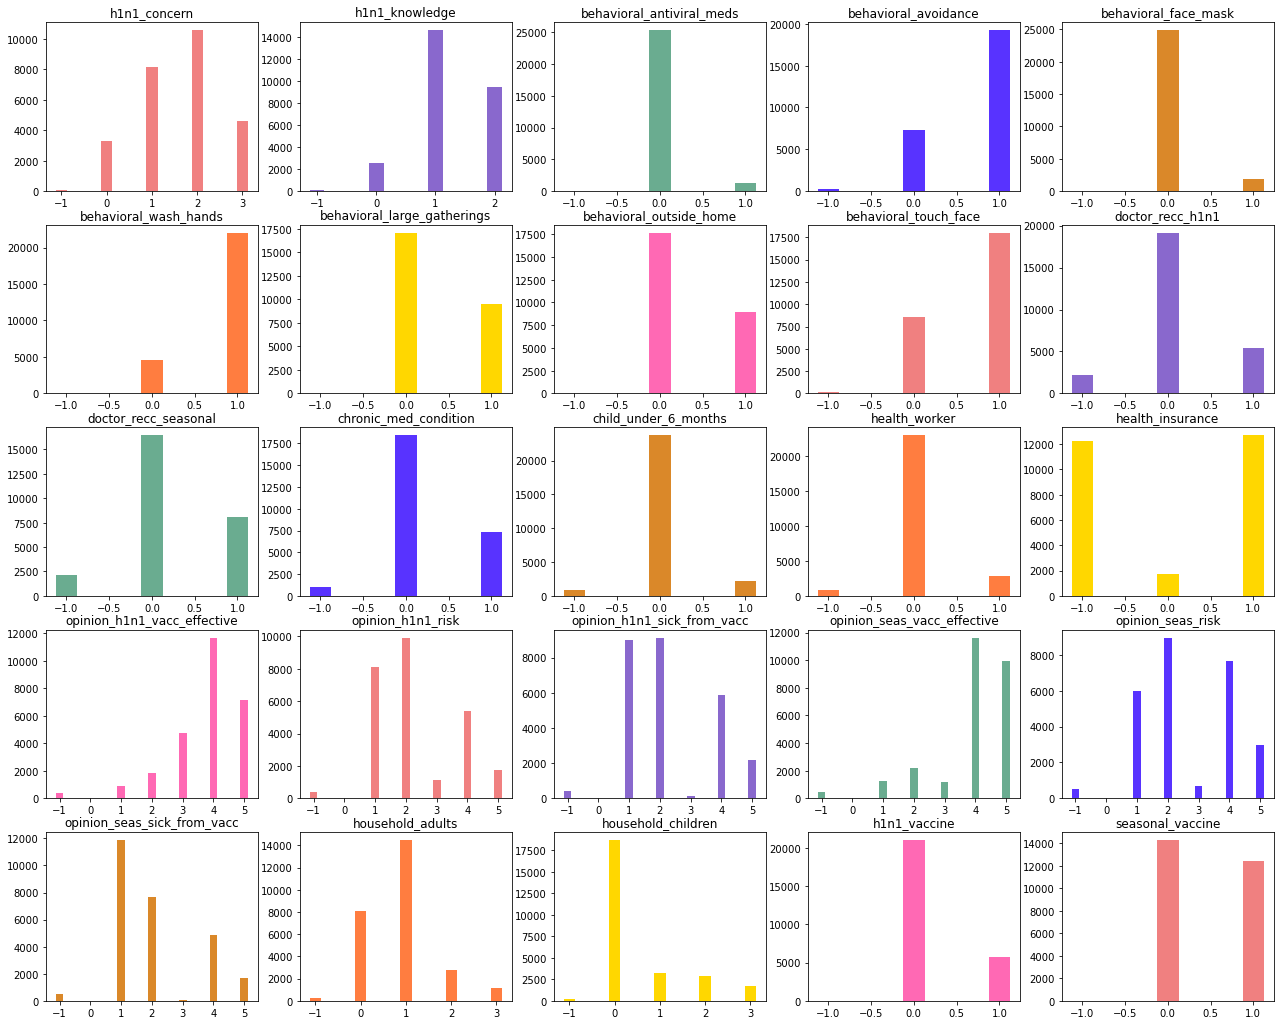

In [9]:
#cat_cols visualization
nrows = 5
ncols = int(len(cat_list)/nrows)
color_list = ["#F08080","#8968CD","#6aac90","#5833ff","#da8829","#FF7D40","#FFD700","#FF69B4"]
fig, axes = plt.subplots(nrows, ncols, figsize = (22,18))
axes = axes.flatten()
for count, p in enumerate(cat_list):
    plt.sca(axes[count])
    plt.title(p)
    bins = np.arange(-1,max(train[p]+0.5),0.25)-0.125
    plt.hist(train[p], bins=bins, color=color_list[count%len(color_list)])

Some Quick Observation:

    a. In the health_insurance column, the proportion of missing values is huge.
    b. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine.
    c. Most respondents do not take antiviral medications before.
    d. Most respondents do not have children.
    e. Most respondents in this dataset wash their hands but do not wear a face mask.
    f. Most respondents in this dataset are not health-related workers
    g. Most respondents in this dataset think the h1n1 vaccine does have a somewhat or great effect on h1n1. 
    h. Most respondents think the risk of getting sick with H1N1 flu without a vaccine is low.
    i. Most respondents think the seasonal flu vaccine does have a somewhat or great effect on flu.
    j. Different from (h), Only half of the respondents think the risk of getting sick with seasonal flu without a vaccine is low.
    k. Most respondents do not think they will get sick after taking the vaccine. In other words, those who took the vaccine believed in it.

<AxesSubplot:xlabel='sex', ylabel='count'>

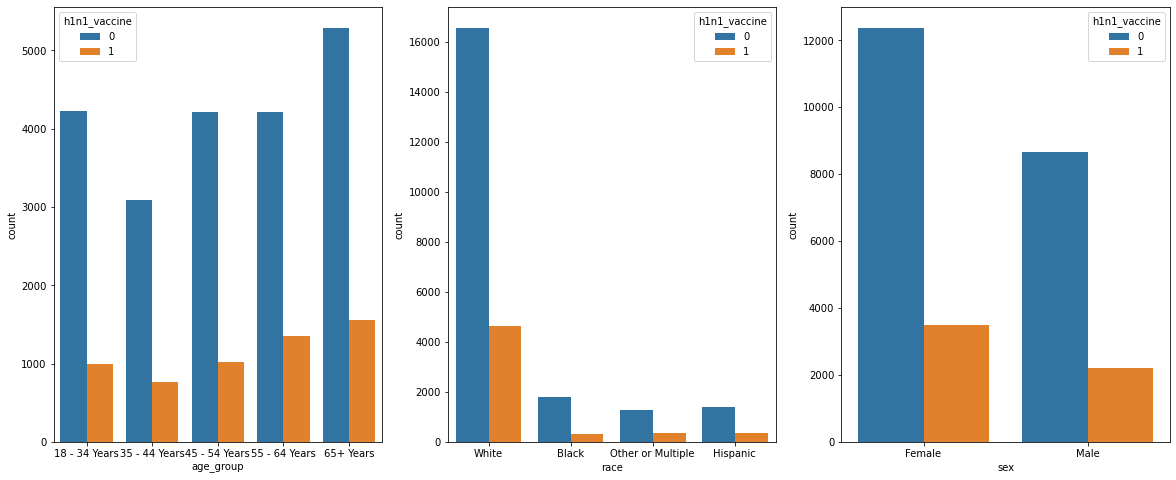

In [10]:
#Interested in age_group, race, and sex to vaccines.
fig, axes = plt.subplots(1, 3, figsize = (20,8))
sns.countplot(x='age_group', hue='h1n1_vaccine', data = train, order=['18 - 34 Years','35 - 44 Years','45 - 54 Years','55 - 64 Years','65+ Years'],ax=axes[0])
sns.countplot(x='race', hue='h1n1_vaccine', data = train,ax=axes[1])
sns.countplot(x='sex', hue='h1n1_vaccine', data = train,ax=axes[2])

Age_group:

    a. 65+ group is slightly more than the other groups. 
    b. 35-44 group is slightly less than the other group. 
    c. Age above 55 years seems more prefer to take the h1n1 vaccine.
    

Race:
    
    a. Most respondents in this dataset are white and extremely imbalanced.

Sex:
    
    a. Female is slightly more than male in this dataset. 
    b. However there is no big difference in h1n1 vaccine proportion.

In [11]:
fig, axes = plt.subplots(1, 3, figsize = (20,8))
sns.countplot(x='age_group', hue='seasonal_vaccine', data = train, order=['18 - 34 Years','35 - 44 Years','45 - 54 Years','55 - 64 Years','65+ Years'],ax=axes[0])
sns.countplot(x='race', hue='seasonal_vaccine', data = train,ax=axes[1])
sns.countplot(x='sex', hue='seasonal_vaccine', data = train,ax=axes[2])

<AxesSubplot:xlabel='sex', ylabel='count'>

Age_group:

    a. There are more and more respondents taking a seasonal vaccine as their age increases.
    b. More than half of the respondents whose age is above 55 took the seasonal vaccine.
    c. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine in each age group.

Race:
    
    a. Most respondents in this dataset are white and extremely imbalanced.
    b. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine no matter their race.

Sex:
    
    a. Females are more willing to take the seasonal vaccine.
    b. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine no matter their sex.

Prepare the data for our model.

In [12]:
for i in oj_list:
    le = LabelEncoder()
    train[i]=le.fit_transform(train[i])
    test[i]=le.fit_transform(test[i])

In [13]:
for i in train.columns:
    train[i] = train[i].astype(int)

In [14]:
for j in test.columns:
    test[j] = test[j].astype(int)

In [15]:
X = train.drop(['respondent_id','h1n1_vaccine','seasonal_vaccine'],axis=1)
y1 = train['h1n1_vaccine']
y2 = train['seasonal_vaccine']

In [16]:
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, random_state = 42)
X_train, X_val, y1_train, y1_val, y2_train, y2_val = train_test_split(X_train, y1_train, y2_train, test_size=0.1, random_state = 42)

Modeling(catboost model + gridsearch)

In [17]:
from catboost import CatBoostClassifier, Pool

cat_model = CatBoostClassifier()

params = {'iterations': [400, 600, 1000],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [4, 6],
        'l2_leaf_reg': [0.1, 0.5, 1, 3],
        'verbose':[10],
        'random_seed': [42],
        'loss_function':['Logloss'],
        'eval_metric':['AUC:hints=skip_train~false']}

scorer = make_scorer(roc_auc_score)

cat_grid = GridSearchCV(estimator=cat_model, param_grid=params, scoring=scorer, cv=5)

In [18]:
cat_grid.fit(X_train, y1_train, eval_set=(X_val,y1_val))
best_param_h1n1 = cat_grid.best_params_
best_param_h1n1

0:	learn: 0.8168097	test: 0.8180980	best: 0.8180980 (0)	total: 67.2ms	remaining: 26.8s
10:	learn: 0.8450873	test: 0.8424058	best: 0.8424134 (9)	total: 109ms	remaining: 3.84s
20:	learn: 0.8517613	test: 0.8494668	best: 0.8494668 (20)	total: 152ms	remaining: 2.73s
30:	learn: 0.8565709	test: 0.8534143	best: 0.8534143 (30)	total: 193ms	remaining: 2.3s
40:	learn: 0.8605089	test: 0.8574108	best: 0.8574108 (40)	total: 236ms	remaining: 2.06s
50:	learn: 0.8636975	test: 0.8601920	best: 0.8601920 (50)	total: 277ms	remaining: 1.9s
60:	learn: 0.8661742	test: 0.8621168	best: 0.8621168 (60)	total: 321ms	remaining: 1.78s
70:	learn: 0.8680902	test: 0.8629846	best: 0.8630430 (69)	total: 362ms	remaining: 1.68s
80:	learn: 0.8701584	test: 0.8639070	best: 0.8639070 (80)	total: 405ms	remaining: 1.59s
90:	learn: 0.8723502	test: 0.8651458	best: 0.8651458 (90)	total: 445ms	remaining: 1.51s
100:	learn: 0.8742953	test: 0.8661507	best: 0.8661507 (100)	total: 487ms	remaining: 1.44s
110:	learn: 0.8766595	test: 0.8668

80:	learn: 0.8711726	test: 0.8633454	best: 0.8633454 (80)	total: 392ms	remaining: 1.54s
90:	learn: 0.8734252	test: 0.8659691	best: 0.8659691 (90)	total: 437ms	remaining: 1.48s
100:	learn: 0.8756953	test: 0.8668978	best: 0.8668978 (100)	total: 482ms	remaining: 1.43s
110:	learn: 0.8779762	test: 0.8682700	best: 0.8682700 (110)	total: 545ms	remaining: 1.42s
120:	learn: 0.8797194	test: 0.8689370	best: 0.8689370 (120)	total: 599ms	remaining: 1.38s
130:	learn: 0.8816305	test: 0.8693029	best: 0.8693029 (130)	total: 643ms	remaining: 1.32s
140:	learn: 0.8838431	test: 0.8694961	best: 0.8696117 (135)	total: 687ms	remaining: 1.26s
150:	learn: 0.8855158	test: 0.8699102	best: 0.8699102 (150)	total: 729ms	remaining: 1.2s
160:	learn: 0.8871576	test: 0.8702253	best: 0.8702253 (160)	total: 773ms	remaining: 1.15s
170:	learn: 0.8886273	test: 0.8700767	best: 0.8702253 (160)	total: 814ms	remaining: 1.09s
180:	learn: 0.8900340	test: 0.8705252	best: 0.8705252 (180)	total: 858ms	remaining: 1.04s
190:	learn: 0.8

200:	learn: 0.8957641	test: 0.8699191	best: 0.8711770 (184)	total: 898ms	remaining: 889ms
210:	learn: 0.8970733	test: 0.8699077	best: 0.8711770 (184)	total: 941ms	remaining: 843ms
220:	learn: 0.8981842	test: 0.8701097	best: 0.8711770 (184)	total: 985ms	remaining: 798ms
230:	learn: 0.8994265	test: 0.8699700	best: 0.8711770 (184)	total: 1.03s	remaining: 752ms
240:	learn: 0.9006787	test: 0.8695138	best: 0.8711770 (184)	total: 1.07s	remaining: 706ms
250:	learn: 0.9016671	test: 0.8694351	best: 0.8711770 (184)	total: 1.11s	remaining: 661ms
260:	learn: 0.9026643	test: 0.8692699	best: 0.8711770 (184)	total: 1.16s	remaining: 617ms
270:	learn: 0.9037877	test: 0.8689917	best: 0.8711770 (184)	total: 1.2s	remaining: 572ms
280:	learn: 0.9048097	test: 0.8687058	best: 0.8711770 (184)	total: 1.24s	remaining: 526ms
290:	learn: 0.9058630	test: 0.8684250	best: 0.8711770 (184)	total: 1.28s	remaining: 481ms
300:	learn: 0.9068149	test: 0.8686016	best: 0.8711770 (184)	total: 1.33s	remaining: 436ms
310:	learn:

300:	learn: 0.9544823	test: 0.8626237	best: 0.8696434 (170)	total: 1.67s	remaining: 548ms
310:	learn: 0.9560526	test: 0.8624522	best: 0.8696434 (170)	total: 1.72s	remaining: 493ms
320:	learn: 0.9574551	test: 0.8614739	best: 0.8696434 (170)	total: 1.78s	remaining: 438ms
330:	learn: 0.9590382	test: 0.8611741	best: 0.8696434 (170)	total: 1.84s	remaining: 383ms
340:	learn: 0.9603260	test: 0.8606646	best: 0.8696434 (170)	total: 1.89s	remaining: 328ms
350:	learn: 0.9616797	test: 0.8608882	best: 0.8696434 (170)	total: 1.95s	remaining: 272ms
360:	learn: 0.9630524	test: 0.8603317	best: 0.8696434 (170)	total: 2s	remaining: 216ms
370:	learn: 0.9644252	test: 0.8599226	best: 0.8696434 (170)	total: 2.07s	remaining: 162ms
380:	learn: 0.9656965	test: 0.8602872	best: 0.8696434 (170)	total: 2.15s	remaining: 107ms
390:	learn: 0.9665931	test: 0.8597244	best: 0.8696434 (170)	total: 2.21s	remaining: 50.8ms
399:	learn: 0.9674200	test: 0.8600141	best: 0.8696434 (170)	total: 2.25s	remaining: 0us

bestTest = 0.

390:	learn: 0.9667122	test: 0.8673044	best: 0.8715086 (260)	total: 2.35s	remaining: 54ms
399:	learn: 0.9676212	test: 0.8669766	best: 0.8715086 (260)	total: 2.41s	remaining: 0us

bestTest = 0.8715085786
bestIteration = 260

Shrink model to first 261 iterations.
0:	learn: 0.8274780	test: 0.8161229	best: 0.8161229 (0)	total: 5.45ms	remaining: 2.17s
10:	learn: 0.8584760	test: 0.8462047	best: 0.8462047 (10)	total: 68.1ms	remaining: 2.41s
20:	learn: 0.8680821	test: 0.8528673	best: 0.8532548 (19)	total: 132ms	remaining: 2.37s
30:	learn: 0.8771986	test: 0.8585644	best: 0.8585644 (30)	total: 195ms	remaining: 2.32s
40:	learn: 0.8824778	test: 0.8608132	best: 0.8611855 (38)	total: 261ms	remaining: 2.28s
50:	learn: 0.8882976	test: 0.8627876	best: 0.8627876 (50)	total: 335ms	remaining: 2.29s
60:	learn: 0.8919980	test: 0.8622566	best: 0.8627876 (50)	total: 442ms	remaining: 2.46s
70:	learn: 0.8958622	test: 0.8623595	best: 0.8630621 (65)	total: 531ms	remaining: 2.46s
80:	learn: 0.8994612	test: 0.862363

70:	learn: 0.8573189	test: 0.8563740	best: 0.8563740 (70)	total: 300ms	remaining: 1.39s
80:	learn: 0.8600345	test: 0.8587054	best: 0.8587054 (80)	total: 344ms	remaining: 1.35s
90:	learn: 0.8614081	test: 0.8599290	best: 0.8599290 (90)	total: 387ms	remaining: 1.31s
100:	learn: 0.8630745	test: 0.8610051	best: 0.8610165 (99)	total: 428ms	remaining: 1.26s
110:	learn: 0.8643140	test: 0.8617700	best: 0.8618932 (109)	total: 470ms	remaining: 1.22s
120:	learn: 0.8658992	test: 0.8624522	best: 0.8624522 (120)	total: 516ms	remaining: 1.19s
130:	learn: 0.8670098	test: 0.8633645	best: 0.8633645 (130)	total: 564ms	remaining: 1.16s
140:	learn: 0.8682259	test: 0.8639731	best: 0.8639731 (140)	total: 606ms	remaining: 1.11s
150:	learn: 0.8691546	test: 0.8644076	best: 0.8645753 (147)	total: 648ms	remaining: 1.07s
160:	learn: 0.8701815	test: 0.8651534	best: 0.8651534 (160)	total: 697ms	remaining: 1.03s
170:	learn: 0.8710226	test: 0.8658420	best: 0.8658420 (170)	total: 740ms	remaining: 991ms
180:	learn: 0.872

180:	learn: 0.8773415	test: 0.8644152	best: 0.8644355 (179)	total: 1.06s	remaining: 1.28s
190:	learn: 0.8783491	test: 0.8650187	best: 0.8650670 (189)	total: 1.12s	remaining: 1.22s
200:	learn: 0.8791394	test: 0.8654875	best: 0.8654875 (200)	total: 1.17s	remaining: 1.15s
210:	learn: 0.8801033	test: 0.8660669	best: 0.8660669 (210)	total: 1.21s	remaining: 1.09s
220:	learn: 0.8812495	test: 0.8665510	best: 0.8665510 (220)	total: 1.27s	remaining: 1.02s
230:	learn: 0.8822947	test: 0.8670604	best: 0.8670948 (229)	total: 1.32s	remaining: 965ms
240:	learn: 0.8831739	test: 0.8677338	best: 0.8677338 (240)	total: 1.37s	remaining: 905ms
250:	learn: 0.8841151	test: 0.8681010	best: 0.8681455 (249)	total: 1.42s	remaining: 844ms
260:	learn: 0.8851008	test: 0.8686677	best: 0.8686677 (260)	total: 1.47s	remaining: 783ms
270:	learn: 0.8858632	test: 0.8687490	best: 0.8688214 (263)	total: 1.52s	remaining: 723ms
280:	learn: 0.8868704	test: 0.8690653	best: 0.8690806 (278)	total: 1.57s	remaining: 663ms
290:	learn

260:	learn: 0.9136299	test: 0.8677402	best: 0.8680896 (253)	total: 1.52s	remaining: 807ms
270:	learn: 0.9155525	test: 0.8678571	best: 0.8680896 (253)	total: 1.58s	remaining: 751ms
280:	learn: 0.9171614	test: 0.8680248	best: 0.8680896 (253)	total: 1.64s	remaining: 694ms
290:	learn: 0.9190451	test: 0.8677173	best: 0.8680896 (253)	total: 1.7s	remaining: 636ms
300:	learn: 0.9206375	test: 0.8677389	best: 0.8680896 (253)	total: 1.76s	remaining: 578ms
310:	learn: 0.9223952	test: 0.8681798	best: 0.8681798 (310)	total: 1.82s	remaining: 520ms
320:	learn: 0.9239193	test: 0.8678456	best: 0.8681798 (310)	total: 1.88s	remaining: 462ms
330:	learn: 0.9254546	test: 0.8678761	best: 0.8681798 (310)	total: 1.93s	remaining: 402ms
340:	learn: 0.9269250	test: 0.8681493	best: 0.8681798 (310)	total: 1.99s	remaining: 344ms
350:	learn: 0.9282506	test: 0.8680858	best: 0.8681798 (310)	total: 2.04s	remaining: 285ms
360:	learn: 0.9296621	test: 0.8679689	best: 0.8681798 (310)	total: 2.1s	remaining: 226ms
370:	learn: 

340:	learn: 0.9280598	test: 0.8691136	best: 0.8699242 (218)	total: 2.13s	remaining: 369ms
350:	learn: 0.9294736	test: 0.8693614	best: 0.8699242 (218)	total: 2.19s	remaining: 306ms
360:	learn: 0.9308539	test: 0.8694872	best: 0.8699242 (218)	total: 2.24s	remaining: 242ms
370:	learn: 0.9321134	test: 0.8695532	best: 0.8699242 (218)	total: 2.29s	remaining: 179ms
380:	learn: 0.9331593	test: 0.8696244	best: 0.8699242 (218)	total: 2.35s	remaining: 117ms
390:	learn: 0.9343043	test: 0.8700233	best: 0.8700640 (388)	total: 2.4s	remaining: 55.3ms
399:	learn: 0.9353234	test: 0.8699789	best: 0.8700640 (388)	total: 2.45s	remaining: 0us

bestTest = 0.870063984
bestIteration = 388

Shrink model to first 389 iterations.
0:	learn: 0.8279813	test: 0.8171629	best: 0.8171629 (0)	total: 5.25ms	remaining: 2.09s
10:	learn: 0.8550974	test: 0.8449125	best: 0.8449125 (10)	total: 61.1ms	remaining: 2.16s
20:	learn: 0.8597922	test: 0.8500182	best: 0.8500182 (20)	total: 115ms	remaining: 2.07s
30:	learn: 0.8651129	test

40:	learn: 0.8399644	test: 0.8395592	best: 0.8399829 (38)	total: 185ms	remaining: 1.62s
50:	learn: 0.8409381	test: 0.8400413	best: 0.8404612 (45)	total: 231ms	remaining: 1.58s
60:	learn: 0.8416032	test: 0.8402935	best: 0.8404612 (45)	total: 276ms	remaining: 1.53s
70:	learn: 0.8421539	test: 0.8407573	best: 0.8407954 (69)	total: 322ms	remaining: 1.49s
80:	learn: 0.8427878	test: 0.8414783	best: 0.8415456 (79)	total: 374ms	remaining: 1.47s
90:	learn: 0.8435678	test: 0.8420183	best: 0.8421949 (86)	total: 429ms	remaining: 1.46s
100:	learn: 0.8442635	test: 0.8424871	best: 0.8425557 (98)	total: 487ms	remaining: 1.44s
110:	learn: 0.8448888	test: 0.8433034	best: 0.8433034 (110)	total: 535ms	remaining: 1.39s
120:	learn: 0.8454654	test: 0.8439095	best: 0.8439095 (120)	total: 583ms	remaining: 1.34s
130:	learn: 0.8461254	test: 0.8445371	best: 0.8445371 (130)	total: 629ms	remaining: 1.29s
140:	learn: 0.8469184	test: 0.8451698	best: 0.8451698 (140)	total: 676ms	remaining: 1.24s
150:	learn: 0.8475040	t

160:	learn: 0.8484961	test: 0.8472008	best: 0.8472008 (160)	total: 724ms	remaining: 1.07s
170:	learn: 0.8491657	test: 0.8478398	best: 0.8478716 (169)	total: 780ms	remaining: 1.04s
180:	learn: 0.8497411	test: 0.8482566	best: 0.8482566 (180)	total: 839ms	remaining: 1.01s
190:	learn: 0.8502596	test: 0.8487495	best: 0.8487495 (190)	total: 897ms	remaining: 981ms
200:	learn: 0.8513957	test: 0.8497342	best: 0.8497342 (200)	total: 958ms	remaining: 948ms
210:	learn: 0.8521528	test: 0.8502678	best: 0.8502678 (210)	total: 1.01s	remaining: 907ms
220:	learn: 0.8530621	test: 0.8509387	best: 0.8509387 (220)	total: 1.07s	remaining: 865ms
230:	learn: 0.8536387	test: 0.8514507	best: 0.8514507 (230)	total: 1.12s	remaining: 819ms
240:	learn: 0.8543328	test: 0.8517213	best: 0.8517213 (240)	total: 1.17s	remaining: 771ms
250:	learn: 0.8549579	test: 0.8522041	best: 0.8522041 (250)	total: 1.21s	remaining: 720ms
260:	learn: 0.8556396	test: 0.8527568	best: 0.8527568 (260)	total: 1.26s	remaining: 670ms
270:	learn

250:	learn: 0.8581001	test: 0.8513732	best: 0.8514761 (249)	total: 1.31s	remaining: 776ms
260:	learn: 0.8587040	test: 0.8519513	best: 0.8519513 (260)	total: 1.35s	remaining: 719ms
270:	learn: 0.8593826	test: 0.8523451	best: 0.8523451 (270)	total: 1.39s	remaining: 664ms
280:	learn: 0.8599793	test: 0.8528953	best: 0.8528953 (280)	total: 1.44s	remaining: 608ms
290:	learn: 0.8604884	test: 0.8533717	best: 0.8533717 (290)	total: 1.48s	remaining: 554ms
300:	learn: 0.8610823	test: 0.8538787	best: 0.8538787 (300)	total: 1.52s	remaining: 501ms
310:	learn: 0.8616534	test: 0.8544085	best: 0.8544085 (310)	total: 1.57s	remaining: 449ms
320:	learn: 0.8622515	test: 0.8548341	best: 0.8548341 (320)	total: 1.61s	remaining: 396ms
330:	learn: 0.8626835	test: 0.8551975	best: 0.8551975 (330)	total: 1.65s	remaining: 345ms
340:	learn: 0.8632191	test: 0.8555583	best: 0.8555609 (339)	total: 1.7s	remaining: 294ms
350:	learn: 0.8636306	test: 0.8559319	best: 0.8559319 (350)	total: 1.74s	remaining: 243ms
360:	learn:

350:	learn: 0.8744248	test: 0.8613113	best: 0.8613685 (346)	total: 2.18s	remaining: 305ms
360:	learn: 0.8750236	test: 0.8614536	best: 0.8614536 (360)	total: 2.28s	remaining: 246ms
370:	learn: 0.8755469	test: 0.8614066	best: 0.8615146 (365)	total: 2.41s	remaining: 188ms
380:	learn: 0.8761771	test: 0.8617128	best: 0.8617128 (380)	total: 2.5s	remaining: 125ms
390:	learn: 0.8767332	test: 0.8620495	best: 0.8620495 (390)	total: 2.58s	remaining: 59.4ms
399:	learn: 0.8773146	test: 0.8623773	best: 0.8624090 (398)	total: 2.64s	remaining: 0us

bestTest = 0.8624090299
bestIteration = 398

Shrink model to first 399 iterations.
0:	learn: 0.8223730	test: 0.8142006	best: 0.8142006 (0)	total: 5.14ms	remaining: 2.05s
10:	learn: 0.8463600	test: 0.8417908	best: 0.8417908 (10)	total: 61.3ms	remaining: 2.17s
20:	learn: 0.8466249	test: 0.8430639	best: 0.8435105 (16)	total: 116ms	remaining: 2.09s
30:	learn: 0.8471377	test: 0.8432583	best: 0.8438669 (23)	total: 172ms	remaining: 2.05s
40:	learn: 0.8484739	test:

30:	learn: 0.8521821	test: 0.8435092	best: 0.8439514 (23)	total: 159ms	remaining: 1.9s
40:	learn: 0.8537250	test: 0.8455732	best: 0.8455732 (40)	total: 212ms	remaining: 1.86s
50:	learn: 0.8551506	test: 0.8461678	best: 0.8461805 (46)	total: 263ms	remaining: 1.8s
60:	learn: 0.8561704	test: 0.8464296	best: 0.8464296 (60)	total: 316ms	remaining: 1.75s
70:	learn: 0.8566920	test: 0.8468476	best: 0.8468476 (70)	total: 378ms	remaining: 1.75s
80:	learn: 0.8577082	test: 0.8475044	best: 0.8475095 (79)	total: 433ms	remaining: 1.7s
90:	learn: 0.8584402	test: 0.8478398	best: 0.8478398 (90)	total: 486ms	remaining: 1.65s
100:	learn: 0.8594575	test: 0.8484675	best: 0.8486314 (98)	total: 540ms	remaining: 1.6s
110:	learn: 0.8604981	test: 0.8495665	best: 0.8495665 (110)	total: 594ms	remaining: 1.55s
120:	learn: 0.8613335	test: 0.8501166	best: 0.8501687 (118)	total: 645ms	remaining: 1.49s
130:	learn: 0.8624082	test: 0.8508103	best: 0.8508980 (129)	total: 696ms	remaining: 1.43s
140:	learn: 0.8634062	test: 0

130:	learn: 0.8798083	test: 0.8680794	best: 0.8682319 (128)	total: 621ms	remaining: 1.27s
140:	learn: 0.8817417	test: 0.8682713	best: 0.8683284 (137)	total: 668ms	remaining: 1.23s
150:	learn: 0.8831585	test: 0.8683234	best: 0.8685660 (143)	total: 714ms	remaining: 1.18s
160:	learn: 0.8849530	test: 0.8683666	best: 0.8685660 (143)	total: 761ms	remaining: 1.13s
170:	learn: 0.8868292	test: 0.8688595	best: 0.8688595 (170)	total: 807ms	remaining: 1.08s
180:	learn: 0.8884851	test: 0.8687769	best: 0.8690209 (174)	total: 857ms	remaining: 1.04s
190:	learn: 0.8898461	test: 0.8692305	best: 0.8692394 (189)	total: 902ms	remaining: 987ms
200:	learn: 0.8910167	test: 0.8695405	best: 0.8695405 (200)	total: 946ms	remaining: 936ms
210:	learn: 0.8924768	test: 0.8694770	best: 0.8696371 (202)	total: 988ms	remaining: 885ms
220:	learn: 0.8935319	test: 0.8700157	best: 0.8700602 (216)	total: 1.03s	remaining: 834ms
230:	learn: 0.8947435	test: 0.8697324	best: 0.8700602 (216)	total: 1.07s	remaining: 785ms
240:	learn

230:	learn: 0.8984246	test: 0.8697019	best: 0.8698810 (225)	total: 1.07s	remaining: 782ms
240:	learn: 0.8996206	test: 0.8697413	best: 0.8698810 (225)	total: 1.12s	remaining: 739ms
250:	learn: 0.9007582	test: 0.8700119	best: 0.8701059 (248)	total: 1.17s	remaining: 693ms
260:	learn: 0.9016364	test: 0.8703333	best: 0.8704083 (257)	total: 1.21s	remaining: 646ms
270:	learn: 0.9026207	test: 0.8706243	best: 0.8706243 (270)	total: 1.26s	remaining: 600ms
280:	learn: 0.9036882	test: 0.8703283	best: 0.8706243 (270)	total: 1.31s	remaining: 555ms
290:	learn: 0.9047251	test: 0.8704502	best: 0.8706243 (270)	total: 1.36s	remaining: 511ms
300:	learn: 0.9058027	test: 0.8706268	best: 0.8706268 (300)	total: 1.41s	remaining: 464ms
310:	learn: 0.9067615	test: 0.8708809	best: 0.8708809 (310)	total: 1.46s	remaining: 417ms
320:	learn: 0.9078861	test: 0.8707615	best: 0.8710321 (311)	total: 1.5s	remaining: 369ms
330:	learn: 0.9087719	test: 0.8702457	best: 0.8710321 (311)	total: 1.55s	remaining: 323ms
340:	learn:

310:	learn: 0.9529425	test: 0.8648802	best: 0.8683373 (116)	total: 1.72s	remaining: 492ms
320:	learn: 0.9543606	test: 0.8649145	best: 0.8683373 (116)	total: 1.77s	remaining: 437ms
330:	learn: 0.9556752	test: 0.8646147	best: 0.8683373 (116)	total: 1.83s	remaining: 381ms
340:	learn: 0.9568632	test: 0.8644050	best: 0.8683373 (116)	total: 1.88s	remaining: 326ms
350:	learn: 0.9583404	test: 0.8645486	best: 0.8683373 (116)	total: 1.94s	remaining: 270ms
360:	learn: 0.9595081	test: 0.8640417	best: 0.8683373 (116)	total: 1.99s	remaining: 215ms
370:	learn: 0.9607617	test: 0.8632679	best: 0.8683373 (116)	total: 2.04s	remaining: 160ms
380:	learn: 0.9620766	test: 0.8624001	best: 0.8683373 (116)	total: 2.1s	remaining: 105ms
390:	learn: 0.9631684	test: 0.8617420	best: 0.8683373 (116)	total: 2.15s	remaining: 49.5ms
399:	learn: 0.9642937	test: 0.8615235	best: 0.8683373 (116)	total: 2.2s	remaining: 0us

bestTest = 0.8683373313
bestIteration = 116

Shrink model to first 117 iterations.
0:	learn: 0.8238423

399:	learn: 0.9628913	test: 0.8652309	best: 0.8696777 (123)	total: 2.38s	remaining: 0us

bestTest = 0.8696777423
bestIteration = 123

Shrink model to first 124 iterations.
0:	learn: 0.8279699	test: 0.8171069	best: 0.8171069 (0)	total: 5.53ms	remaining: 2.21s
10:	learn: 0.8594608	test: 0.8484535	best: 0.8484535 (10)	total: 66.1ms	remaining: 2.34s
20:	learn: 0.8688069	test: 0.8549154	best: 0.8549154 (20)	total: 125ms	remaining: 2.25s
30:	learn: 0.8764612	test: 0.8605960	best: 0.8605960 (30)	total: 191ms	remaining: 2.27s
40:	learn: 0.8820775	test: 0.8635398	best: 0.8635398 (40)	total: 249ms	remaining: 2.18s
50:	learn: 0.8863044	test: 0.8654952	best: 0.8654952 (50)	total: 304ms	remaining: 2.08s
60:	learn: 0.8902206	test: 0.8674556	best: 0.8674556 (60)	total: 357ms	remaining: 1.98s
70:	learn: 0.8941774	test: 0.8681379	best: 0.8682598 (69)	total: 412ms	remaining: 1.91s
80:	learn: 0.8975267	test: 0.8687896	best: 0.8687896 (80)	total: 468ms	remaining: 1.84s
90:	learn: 0.9006730	test: 0.8691772

70:	learn: 0.8589338	test: 0.8559236	best: 0.8559236 (70)	total: 313ms	remaining: 1.45s
80:	learn: 0.8606050	test: 0.8574857	best: 0.8574857 (80)	total: 360ms	remaining: 1.42s
90:	learn: 0.8623839	test: 0.8595592	best: 0.8595592 (90)	total: 405ms	remaining: 1.37s
100:	learn: 0.8639915	test: 0.8610343	best: 0.8610343 (100)	total: 448ms	remaining: 1.33s
110:	learn: 0.8654701	test: 0.8619948	best: 0.8619948 (110)	total: 491ms	remaining: 1.28s
120:	learn: 0.8665732	test: 0.8626733	best: 0.8626733 (120)	total: 536ms	remaining: 1.24s
130:	learn: 0.8677673	test: 0.8634788	best: 0.8634788 (130)	total: 581ms	remaining: 1.19s
140:	learn: 0.8689526	test: 0.8640912	best: 0.8640912 (140)	total: 624ms	remaining: 1.15s
150:	learn: 0.8700120	test: 0.8647011	best: 0.8647011 (150)	total: 673ms	remaining: 1.11s
160:	learn: 0.8709877	test: 0.8652372	best: 0.8652372 (160)	total: 714ms	remaining: 1.06s
170:	learn: 0.8717030	test: 0.8657327	best: 0.8657836 (168)	total: 757ms	remaining: 1.01s
180:	learn: 0.87

180:	learn: 0.8742350	test: 0.8665789	best: 0.8665789 (180)	total: 811ms	remaining: 981ms
190:	learn: 0.8752369	test: 0.8675064	best: 0.8675064 (190)	total: 857ms	remaining: 937ms
200:	learn: 0.8761656	test: 0.8682319	best: 0.8682319 (200)	total: 900ms	remaining: 891ms
210:	learn: 0.8772544	test: 0.8686486	best: 0.8687007 (206)	total: 947ms	remaining: 849ms
220:	learn: 0.8781751	test: 0.8686702	best: 0.8687007 (206)	total: 991ms	remaining: 803ms
230:	learn: 0.8791472	test: 0.8691009	best: 0.8691009 (230)	total: 1.03s	remaining: 757ms
240:	learn: 0.8800507	test: 0.8693118	best: 0.8693118 (240)	total: 1.08s	remaining: 711ms
250:	learn: 0.8809719	test: 0.8694745	best: 0.8695367 (244)	total: 1.12s	remaining: 666ms
260:	learn: 0.8818543	test: 0.8699484	best: 0.8699484 (260)	total: 1.17s	remaining: 624ms
270:	learn: 0.8827263	test: 0.8702253	best: 0.8702253 (270)	total: 1.22s	remaining: 579ms
280:	learn: 0.8836393	test: 0.8705417	best: 0.8705544 (277)	total: 1.26s	remaining: 535ms
290:	learn

280:	learn: 0.8872125	test: 0.8696206	best: 0.8697400 (275)	total: 1.23s	remaining: 521ms
290:	learn: 0.8879683	test: 0.8699725	best: 0.8699725 (290)	total: 1.27s	remaining: 477ms
300:	learn: 0.8886881	test: 0.8701910	best: 0.8702851 (299)	total: 1.32s	remaining: 434ms
310:	learn: 0.8893976	test: 0.8702698	best: 0.8703105 (304)	total: 1.37s	remaining: 391ms
320:	learn: 0.8901778	test: 0.8704985	best: 0.8705188 (319)	total: 1.42s	remaining: 349ms
330:	learn: 0.8909294	test: 0.8704604	best: 0.8705506 (321)	total: 1.47s	remaining: 306ms
340:	learn: 0.8916686	test: 0.8706853	best: 0.8706853 (340)	total: 1.52s	remaining: 263ms
350:	learn: 0.8923591	test: 0.8707602	best: 0.8708847 (346)	total: 1.56s	remaining: 218ms
360:	learn: 0.8930741	test: 0.8704350	best: 0.8708847 (346)	total: 1.61s	remaining: 174ms
370:	learn: 0.8937430	test: 0.8704362	best: 0.8708847 (346)	total: 1.65s	remaining: 129ms
380:	learn: 0.8944203	test: 0.8704617	best: 0.8708847 (346)	total: 1.71s	remaining: 85.1ms
390:	lear

380:	learn: 0.9290662	test: 0.8705684	best: 0.8725834 (286)	total: 2.06s	remaining: 103ms
390:	learn: 0.9302896	test: 0.8707399	best: 0.8725834 (286)	total: 2.12s	remaining: 48.8ms
399:	learn: 0.9313579	test: 0.8707170	best: 0.8725834 (286)	total: 2.17s	remaining: 0us

bestTest = 0.8725834485
bestIteration = 286

Shrink model to first 287 iterations.
0:	learn: 0.8223653	test: 0.8141765	best: 0.8141765 (0)	total: 4.24ms	remaining: 1.69s
10:	learn: 0.8494337	test: 0.8437189	best: 0.8437189 (10)	total: 53.8ms	remaining: 1.9s
20:	learn: 0.8552846	test: 0.8496376	best: 0.8496376 (20)	total: 109ms	remaining: 1.96s
30:	learn: 0.8610769	test: 0.8539803	best: 0.8539803 (30)	total: 164ms	remaining: 1.95s
40:	learn: 0.8656291	test: 0.8571465	best: 0.8571465 (40)	total: 217ms	remaining: 1.9s
50:	learn: 0.8690509	test: 0.8593293	best: 0.8593293 (50)	total: 269ms	remaining: 1.84s
60:	learn: 0.8723599	test: 0.8610940	best: 0.8610940 (60)	total: 324ms	remaining: 1.8s
70:	learn: 0.8752230	test: 0.86356

50:	learn: 0.8725822	test: 0.8575289	best: 0.8575289 (50)	total: 291ms	remaining: 1.99s
60:	learn: 0.8759679	test: 0.8584856	best: 0.8584856 (60)	total: 341ms	remaining: 1.9s
70:	learn: 0.8787370	test: 0.8602593	best: 0.8602593 (70)	total: 395ms	remaining: 1.83s
80:	learn: 0.8813712	test: 0.8614320	best: 0.8614320 (80)	total: 450ms	remaining: 1.77s
90:	learn: 0.8845029	test: 0.8635970	best: 0.8635970 (90)	total: 505ms	remaining: 1.72s
100:	learn: 0.8869543	test: 0.8640683	best: 0.8640683 (100)	total: 559ms	remaining: 1.66s
110:	learn: 0.8890203	test: 0.8651203	best: 0.8651203 (110)	total: 614ms	remaining: 1.6s
120:	learn: 0.8910514	test: 0.8660720	best: 0.8661571 (119)	total: 667ms	remaining: 1.54s
130:	learn: 0.8928277	test: 0.8666945	best: 0.8667047 (129)	total: 722ms	remaining: 1.48s
140:	learn: 0.8946742	test: 0.8672256	best: 0.8672256 (140)	total: 776ms	remaining: 1.43s
150:	learn: 0.8965172	test: 0.8674137	best: 0.8675369 (145)	total: 828ms	remaining: 1.37s
160:	learn: 0.8981824	

150:	learn: 0.8472202	test: 0.8466341	best: 0.8467002 (148)	total: 742ms	remaining: 1.22s
160:	learn: 0.8478219	test: 0.8474117	best: 0.8474320 (159)	total: 786ms	remaining: 1.17s
170:	learn: 0.8484712	test: 0.8483887	best: 0.8483887 (170)	total: 830ms	remaining: 1.11s
180:	learn: 0.8489699	test: 0.8489554	best: 0.8489554 (180)	total: 877ms	remaining: 1.06s
190:	learn: 0.8495147	test: 0.8493200	best: 0.8493454 (185)	total: 926ms	remaining: 1.01s
200:	learn: 0.8500167	test: 0.8499438	best: 0.8499438 (200)	total: 976ms	remaining: 966ms
210:	learn: 0.8504173	test: 0.8502983	best: 0.8503009 (207)	total: 1.02s	remaining: 917ms
220:	learn: 0.8509512	test: 0.8508485	best: 0.8508485 (220)	total: 1.07s	remaining: 868ms
230:	learn: 0.8514545	test: 0.8513427	best: 0.8513427 (230)	total: 1.12s	remaining: 819ms
240:	learn: 0.8519544	test: 0.8519221	best: 0.8519805 (239)	total: 1.16s	remaining: 768ms
250:	learn: 0.8524613	test: 0.8525167	best: 0.8525167 (250)	total: 1.21s	remaining: 720ms
260:	learn

270:	learn: 0.8594772	test: 0.8522804	best: 0.8522804 (270)	total: 1.59s	remaining: 755ms
280:	learn: 0.8600788	test: 0.8529029	best: 0.8529029 (280)	total: 1.64s	remaining: 693ms
290:	learn: 0.8606466	test: 0.8534035	best: 0.8534035 (290)	total: 1.68s	remaining: 630ms
300:	learn: 0.8610554	test: 0.8536830	best: 0.8536830 (300)	total: 1.73s	remaining: 569ms
310:	learn: 0.8616942	test: 0.8541315	best: 0.8541315 (310)	total: 1.78s	remaining: 508ms
320:	learn: 0.8622921	test: 0.8546550	best: 0.8546550 (320)	total: 1.82s	remaining: 449ms
330:	learn: 0.8627731	test: 0.8548151	best: 0.8548151 (330)	total: 1.87s	remaining: 390ms
340:	learn: 0.8630715	test: 0.8548888	best: 0.8549040 (337)	total: 1.91s	remaining: 331ms
350:	learn: 0.8634820	test: 0.8552242	best: 0.8552483 (349)	total: 1.96s	remaining: 273ms
360:	learn: 0.8639502	test: 0.8556549	best: 0.8556549 (360)	total: 2.01s	remaining: 217ms
370:	learn: 0.8643375	test: 0.8559039	best: 0.8559306 (369)	total: 2.06s	remaining: 161ms
380:	learn

390:	learn: 0.8758641	test: 0.8623646	best: 0.8623658 (386)	total: 2.19s	remaining: 50.3ms
399:	learn: 0.8762287	test: 0.8625208	best: 0.8625208 (399)	total: 2.24s	remaining: 0us

bestTest = 0.8625208367
bestIteration = 399

0:	learn: 0.8238423	test: 0.8163847	best: 0.8163847 (0)	total: 10.1ms	remaining: 4.03s
10:	learn: 0.8472129	test: 0.8417813	best: 0.8429629 (8)	total: 65.7ms	remaining: 2.32s
20:	learn: 0.8476949	test: 0.8436344	best: 0.8436344 (20)	total: 120ms	remaining: 2.16s
30:	learn: 0.8481881	test: 0.8433371	best: 0.8436369 (28)	total: 177ms	remaining: 2.11s
40:	learn: 0.8490574	test: 0.8438948	best: 0.8441451 (39)	total: 239ms	remaining: 2.1s
50:	learn: 0.8495073	test: 0.8443154	best: 0.8444031 (49)	total: 301ms	remaining: 2.06s
60:	learn: 0.8501151	test: 0.8451057	best: 0.8451057 (60)	total: 370ms	remaining: 2.06s
70:	learn: 0.8506549	test: 0.8454767	best: 0.8454767 (70)	total: 442ms	remaining: 2.05s
80:	learn: 0.8518059	test: 0.8463228	best: 0.8464346 (79)	total: 513ms	re

70:	learn: 0.8569464	test: 0.8461272	best: 0.8461272 (70)	total: 382ms	remaining: 1.77s
80:	learn: 0.8577478	test: 0.8463914	best: 0.8463914 (80)	total: 440ms	remaining: 1.73s
90:	learn: 0.8583706	test: 0.8467764	best: 0.8467993 (86)	total: 499ms	remaining: 1.69s
100:	learn: 0.8590908	test: 0.8472910	best: 0.8473354 (98)	total: 565ms	remaining: 1.67s
110:	learn: 0.8600214	test: 0.8479720	best: 0.8479720 (110)	total: 619ms	remaining: 1.61s
120:	learn: 0.8612847	test: 0.8489859	best: 0.8489859 (120)	total: 674ms	remaining: 1.55s
130:	learn: 0.8621353	test: 0.8498206	best: 0.8498206 (130)	total: 752ms	remaining: 1.54s
140:	learn: 0.8629876	test: 0.8506248	best: 0.8506960 (139)	total: 811ms	remaining: 1.49s
150:	learn: 0.8642686	test: 0.8516514	best: 0.8516514 (150)	total: 868ms	remaining: 1.43s
160:	learn: 0.8655487	test: 0.8528546	best: 0.8528546 (160)	total: 924ms	remaining: 1.37s
170:	learn: 0.8665075	test: 0.8535509	best: 0.8535509 (170)	total: 980ms	remaining: 1.31s
180:	learn: 0.867

160:	learn: 0.8853868	test: 0.8688290	best: 0.8694046 (125)	total: 718ms	remaining: 1.06s
170:	learn: 0.8868903	test: 0.8693728	best: 0.8694046 (125)	total: 765ms	remaining: 1.02s
180:	learn: 0.8882862	test: 0.8694681	best: 0.8697629 (176)	total: 809ms	remaining: 979ms
190:	learn: 0.8897620	test: 0.8698505	best: 0.8698505 (190)	total: 853ms	remaining: 933ms
200:	learn: 0.8910654	test: 0.8699293	best: 0.8699750 (195)	total: 896ms	remaining: 887ms
210:	learn: 0.8922159	test: 0.8702571	best: 0.8702571 (210)	total: 939ms	remaining: 841ms
220:	learn: 0.8933227	test: 0.8701491	best: 0.8703384 (211)	total: 984ms	remaining: 797ms
230:	learn: 0.8945420	test: 0.8701555	best: 0.8703384 (211)	total: 1.03s	remaining: 753ms
240:	learn: 0.8956623	test: 0.8696079	best: 0.8703384 (211)	total: 1.07s	remaining: 708ms
250:	learn: 0.8965802	test: 0.8704388	best: 0.8704439 (248)	total: 1.12s	remaining: 666ms
260:	learn: 0.8978229	test: 0.8701186	best: 0.8704439 (248)	total: 1.17s	remaining: 623ms
270:	learn

260:	learn: 0.8994402	test: 0.8730612	best: 0.8731069 (257)	total: 1.15s	remaining: 615ms
270:	learn: 0.9005332	test: 0.8725885	best: 0.8731615 (265)	total: 1.2s	remaining: 571ms
280:	learn: 0.9015291	test: 0.8730002	best: 0.8731615 (265)	total: 1.24s	remaining: 526ms
290:	learn: 0.9024984	test: 0.8733623	best: 0.8733699 (288)	total: 1.29s	remaining: 482ms
300:	learn: 0.9034761	test: 0.8735834	best: 0.8735834 (300)	total: 1.33s	remaining: 438ms
310:	learn: 0.9045533	test: 0.8737358	best: 0.8737358 (310)	total: 1.38s	remaining: 394ms
320:	learn: 0.9054352	test: 0.8742237	best: 0.8742237 (320)	total: 1.42s	remaining: 349ms
330:	learn: 0.9061490	test: 0.8740204	best: 0.8742237 (320)	total: 1.46s	remaining: 305ms
340:	learn: 0.9068369	test: 0.8738578	best: 0.8742237 (320)	total: 1.51s	remaining: 261ms
350:	learn: 0.9076831	test: 0.8742148	best: 0.8742262 (349)	total: 1.55s	remaining: 217ms
360:	learn: 0.9085100	test: 0.8739150	best: 0.8743495 (352)	total: 1.6s	remaining: 173ms
370:	learn: 

360:	learn: 0.9114980	test: 0.8695774	best: 0.8714387 (196)	total: 1.6s	remaining: 173ms
370:	learn: 0.9124185	test: 0.8699407	best: 0.8714387 (196)	total: 1.65s	remaining: 129ms
380:	learn: 0.9131476	test: 0.8698963	best: 0.8714387 (196)	total: 1.69s	remaining: 84.4ms
390:	learn: 0.9139914	test: 0.8699230	best: 0.8714387 (196)	total: 1.74s	remaining: 40ms
399:	learn: 0.9147590	test: 0.8696396	best: 0.8714387 (196)	total: 1.78s	remaining: 0us

bestTest = 0.8714386994
bestIteration = 196

Shrink model to first 197 iterations.
0:	learn: 0.8225157	test: 0.8169056	best: 0.8169056 (0)	total: 4.5ms	remaining: 1.8s
10:	learn: 0.8554276	test: 0.8509094	best: 0.8509094 (10)	total: 55.5ms	remaining: 1.96s
20:	learn: 0.8642837	test: 0.8568670	best: 0.8568670 (20)	total: 108ms	remaining: 1.95s
30:	learn: 0.8700010	test: 0.8613634	best: 0.8613634 (30)	total: 162ms	remaining: 1.93s
40:	learn: 0.8749689	test: 0.8642411	best: 0.8642411 (40)	total: 219ms	remaining: 1.92s
50:	learn: 0.8802328	test: 0.86

30:	learn: 0.8716750	test: 0.8599480	best: 0.8599480 (30)	total: 189ms	remaining: 2.25s
40:	learn: 0.8769870	test: 0.8627013	best: 0.8627013 (40)	total: 250ms	remaining: 2.19s
50:	learn: 0.8814955	test: 0.8645766	best: 0.8645766 (50)	total: 319ms	remaining: 2.18s
60:	learn: 0.8861000	test: 0.8667492	best: 0.8667492 (60)	total: 395ms	remaining: 2.19s
70:	learn: 0.8903329	test: 0.8685737	best: 0.8685737 (70)	total: 463ms	remaining: 2.14s
80:	learn: 0.8938350	test: 0.8690158	best: 0.8690158 (80)	total: 521ms	remaining: 2.05s
90:	learn: 0.8976691	test: 0.8685444	best: 0.8690158 (80)	total: 574ms	remaining: 1.95s
100:	learn: 0.9013435	test: 0.8690742	best: 0.8697794 (93)	total: 629ms	remaining: 1.86s
110:	learn: 0.9050816	test: 0.8695189	best: 0.8697794 (93)	total: 682ms	remaining: 1.77s
120:	learn: 0.9085329	test: 0.8696955	best: 0.8697794 (93)	total: 737ms	remaining: 1.7s
130:	learn: 0.9121380	test: 0.8710016	best: 0.8710550 (129)	total: 789ms	remaining: 1.62s
140:	learn: 0.9155670	test: 

140:	learn: 0.9169687	test: 0.8676271	best: 0.8680629 (109)	total: 765ms	remaining: 1.41s
150:	learn: 0.9200535	test: 0.8669639	best: 0.8680629 (109)	total: 821ms	remaining: 1.35s
160:	learn: 0.9226625	test: 0.8666437	best: 0.8680629 (109)	total: 876ms	remaining: 1.3s
170:	learn: 0.9250936	test: 0.8663058	best: 0.8680629 (109)	total: 930ms	remaining: 1.25s
180:	learn: 0.9274613	test: 0.8658661	best: 0.8680629 (109)	total: 986ms	remaining: 1.19s
190:	learn: 0.9301419	test: 0.8666958	best: 0.8680629 (109)	total: 1.04s	remaining: 1.14s
200:	learn: 0.9325449	test: 0.8667238	best: 0.8680629 (109)	total: 1.09s	remaining: 1.08s
210:	learn: 0.9344666	test: 0.8664061	best: 0.8680629 (109)	total: 1.14s	remaining: 1.02s
220:	learn: 0.9368635	test: 0.8654202	best: 0.8680629 (109)	total: 1.2s	remaining: 975ms
230:	learn: 0.9388246	test: 0.8656946	best: 0.8680629 (109)	total: 1.25s	remaining: 919ms
240:	learn: 0.9410185	test: 0.8649844	best: 0.8680629 (109)	total: 1.31s	remaining: 865ms
250:	learn: 

240:	learn: 0.8782449	test: 0.8695977	best: 0.8696320 (239)	total: 1.17s	remaining: 770ms
250:	learn: 0.8790770	test: 0.8700144	best: 0.8700144 (250)	total: 1.21s	remaining: 718ms
260:	learn: 0.8799506	test: 0.8700398	best: 0.8701059 (259)	total: 1.25s	remaining: 667ms
270:	learn: 0.8808275	test: 0.8700513	best: 0.8701059 (259)	total: 1.29s	remaining: 617ms
280:	learn: 0.8816228	test: 0.8701771	best: 0.8702965 (276)	total: 1.34s	remaining: 567ms
290:	learn: 0.8824526	test: 0.8703257	best: 0.8704058 (289)	total: 1.38s	remaining: 518ms
300:	learn: 0.8832948	test: 0.8706078	best: 0.8706078 (300)	total: 1.42s	remaining: 468ms
310:	learn: 0.8840627	test: 0.8703244	best: 0.8706078 (300)	total: 1.47s	remaining: 419ms
320:	learn: 0.8847224	test: 0.8702609	best: 0.8706078 (300)	total: 1.51s	remaining: 371ms
330:	learn: 0.8853914	test: 0.8703994	best: 0.8706078 (300)	total: 1.56s	remaining: 324ms
340:	learn: 0.8862204	test: 0.8707336	best: 0.8707336 (340)	total: 1.6s	remaining: 277ms
350:	learn:

350:	learn: 0.8910944	test: 0.8694325	best: 0.8698111 (324)	total: 1.65s	remaining: 230ms
360:	learn: 0.8918371	test: 0.8697184	best: 0.8698111 (324)	total: 1.7s	remaining: 183ms
370:	learn: 0.8924389	test: 0.8696472	best: 0.8698111 (324)	total: 1.74s	remaining: 136ms
380:	learn: 0.8932165	test: 0.8695990	best: 0.8698709 (375)	total: 1.79s	remaining: 89.3ms
390:	learn: 0.8938220	test: 0.8695558	best: 0.8698709 (375)	total: 1.84s	remaining: 42.4ms
399:	learn: 0.8944707	test: 0.8695774	best: 0.8698709 (375)	total: 1.89s	remaining: 0us

bestTest = 0.8698708631
bestIteration = 375

Shrink model to first 376 iterations.
0:	learn: 0.8210273	test: 0.8179760	best: 0.8179760 (0)	total: 3.85ms	remaining: 1.53s
10:	learn: 0.8444883	test: 0.8372252	best: 0.8372252 (10)	total: 51.9ms	remaining: 1.83s
20:	learn: 0.8492131	test: 0.8435213	best: 0.8435543 (19)	total: 104ms	remaining: 1.87s
30:	learn: 0.8520610	test: 0.8450148	best: 0.8450688 (29)	total: 150ms	remaining: 1.79s
40:	learn: 0.8554598	test

10:	learn: 0.8494296	test: 0.8447410	best: 0.8447410 (10)	total: 62.6ms	remaining: 2.21s
20:	learn: 0.8525460	test: 0.8478456	best: 0.8478456 (20)	total: 132ms	remaining: 2.39s
30:	learn: 0.8578915	test: 0.8523509	best: 0.8523509 (30)	total: 188ms	remaining: 2.24s
40:	learn: 0.8621263	test: 0.8547033	best: 0.8547033 (40)	total: 244ms	remaining: 2.14s
50:	learn: 0.8661947	test: 0.8572151	best: 0.8572786 (48)	total: 305ms	remaining: 2.09s
60:	learn: 0.8702491	test: 0.8594944	best: 0.8595745 (58)	total: 363ms	remaining: 2.02s
70:	learn: 0.8731557	test: 0.8603978	best: 0.8604905 (69)	total: 415ms	remaining: 1.92s
80:	learn: 0.8759512	test: 0.8620558	best: 0.8620558 (80)	total: 469ms	remaining: 1.85s
90:	learn: 0.8788105	test: 0.8637151	best: 0.8637558 (89)	total: 523ms	remaining: 1.77s
100:	learn: 0.8813417	test: 0.8642361	best: 0.8645168 (96)	total: 578ms	remaining: 1.71s
110:	learn: 0.8838832	test: 0.8647773	best: 0.8647773 (110)	total: 633ms	remaining: 1.65s
120:	learn: 0.8859927	test: 

90:	learn: 0.8839709	test: 0.8647773	best: 0.8647773 (90)	total: 495ms	remaining: 1.68s
100:	learn: 0.8865150	test: 0.8657150	best: 0.8657150 (100)	total: 551ms	remaining: 1.63s
110:	learn: 0.8885821	test: 0.8665840	best: 0.8666996 (109)	total: 605ms	remaining: 1.57s
120:	learn: 0.8906440	test: 0.8672320	best: 0.8672320 (120)	total: 661ms	remaining: 1.52s
130:	learn: 0.8926326	test: 0.8669181	best: 0.8672447 (124)	total: 716ms	remaining: 1.47s
140:	learn: 0.8947264	test: 0.8673527	best: 0.8674289 (137)	total: 773ms	remaining: 1.42s
150:	learn: 0.8965041	test: 0.8677478	best: 0.8677478 (150)	total: 826ms	remaining: 1.36s
160:	learn: 0.8983420	test: 0.8682027	best: 0.8682027 (159)	total: 878ms	remaining: 1.3s
170:	learn: 0.8999092	test: 0.8683551	best: 0.8685864 (168)	total: 930ms	remaining: 1.25s
180:	learn: 0.9016033	test: 0.8687198	best: 0.8687198 (180)	total: 986ms	remaining: 1.19s
190:	learn: 0.9029894	test: 0.8687871	best: 0.8688481 (188)	total: 1.04s	remaining: 1.14s
200:	learn: 0

180:	learn: 0.8495276	test: 0.8480838	best: 0.8480838 (180)	total: 783ms	remaining: 948ms
190:	learn: 0.8498817	test: 0.8486327	best: 0.8486479 (188)	total: 826ms	remaining: 903ms
200:	learn: 0.8503872	test: 0.8489681	best: 0.8489782 (196)	total: 867ms	remaining: 858ms
210:	learn: 0.8509798	test: 0.8496783	best: 0.8496783 (210)	total: 909ms	remaining: 814ms
220:	learn: 0.8514682	test: 0.8501319	best: 0.8501319 (220)	total: 957ms	remaining: 775ms
230:	learn: 0.8522205	test: 0.8509450	best: 0.8509450 (230)	total: 1s	remaining: 733ms
240:	learn: 0.8528358	test: 0.8516819	best: 0.8516819 (240)	total: 1.04s	remaining: 689ms
250:	learn: 0.8533961	test: 0.8522232	best: 0.8522232 (250)	total: 1.09s	remaining: 645ms
260:	learn: 0.8540781	test: 0.8528800	best: 0.8528800 (260)	total: 1.13s	remaining: 602ms
270:	learn: 0.8545407	test: 0.8531710	best: 0.8531850 (269)	total: 1.17s	remaining: 559ms
280:	learn: 0.8550449	test: 0.8535865	best: 0.8535865 (280)	total: 1.22s	remaining: 517ms
290:	learn: 0

290:	learn: 0.8570405	test: 0.8549027	best: 0.8549027 (290)	total: 1.48s	remaining: 554ms
300:	learn: 0.8574606	test: 0.8553195	best: 0.8553195 (300)	total: 1.53s	remaining: 505ms
310:	learn: 0.8580879	test: 0.8558455	best: 0.8558455 (310)	total: 1.59s	remaining: 456ms
320:	learn: 0.8585956	test: 0.8563588	best: 0.8563588 (320)	total: 1.64s	remaining: 404ms
330:	learn: 0.8589441	test: 0.8564782	best: 0.8564960 (328)	total: 1.69s	remaining: 353ms
340:	learn: 0.8594110	test: 0.8566586	best: 0.8566586 (340)	total: 1.74s	remaining: 301ms
350:	learn: 0.8597996	test: 0.8569381	best: 0.8569762 (347)	total: 1.79s	remaining: 250ms
360:	learn: 0.8601306	test: 0.8570868	best: 0.8571122 (358)	total: 1.83s	remaining: 198ms
370:	learn: 0.8605512	test: 0.8574616	best: 0.8574616 (370)	total: 1.88s	remaining: 147ms
380:	learn: 0.8609841	test: 0.8579304	best: 0.8579304 (380)	total: 1.93s	remaining: 96.2ms
390:	learn: 0.8614492	test: 0.8582201	best: 0.8582201 (390)	total: 1.97s	remaining: 45.4ms
399:	lea

0:	learn: 0.8225157	test: 0.8169056	best: 0.8169056 (0)	total: 4.79ms	remaining: 1.91s
10:	learn: 0.8466523	test: 0.8407719	best: 0.8415418 (7)	total: 57.9ms	remaining: 2.05s
20:	learn: 0.8467440	test: 0.8423124	best: 0.8423124 (20)	total: 110ms	remaining: 1.98s
30:	learn: 0.8474467	test: 0.8432742	best: 0.8433403 (28)	total: 161ms	remaining: 1.92s
40:	learn: 0.8480493	test: 0.8435772	best: 0.8435772 (40)	total: 217ms	remaining: 1.9s
50:	learn: 0.8491852	test: 0.8449875	best: 0.8449875 (50)	total: 278ms	remaining: 1.9s
60:	learn: 0.8496468	test: 0.8451311	best: 0.8451311 (60)	total: 331ms	remaining: 1.84s
70:	learn: 0.8504411	test: 0.8461361	best: 0.8461361 (70)	total: 385ms	remaining: 1.78s
80:	learn: 0.8515063	test: 0.8470559	best: 0.8470559 (80)	total: 442ms	remaining: 1.74s
90:	learn: 0.8524213	test: 0.8476937	best: 0.8476937 (90)	total: 504ms	remaining: 1.71s
100:	learn: 0.8532555	test: 0.8484573	best: 0.8484573 (100)	total: 568ms	remaining: 1.68s
110:	learn: 0.8548441	test: 0.849

110:	learn: 0.8547854	test: 0.8488347	best: 0.8489414 (108)	total: 619ms	remaining: 1.61s
120:	learn: 0.8556912	test: 0.8496148	best: 0.8497177 (118)	total: 674ms	remaining: 1.55s
130:	learn: 0.8570532	test: 0.8504368	best: 0.8504368 (130)	total: 729ms	remaining: 1.5s
140:	learn: 0.8581450	test: 0.8513224	best: 0.8513224 (140)	total: 781ms	remaining: 1.43s
150:	learn: 0.8592930	test: 0.8526399	best: 0.8526399 (150)	total: 834ms	remaining: 1.38s
160:	learn: 0.8603059	test: 0.8531697	best: 0.8531697 (160)	total: 889ms	remaining: 1.32s
170:	learn: 0.8612504	test: 0.8536119	best: 0.8536284 (169)	total: 940ms	remaining: 1.26s
180:	learn: 0.8621408	test: 0.8542001	best: 0.8542433 (179)	total: 994ms	remaining: 1.2s
190:	learn: 0.8630827	test: 0.8546778	best: 0.8546778 (190)	total: 1.05s	remaining: 1.15s
200:	learn: 0.8639658	test: 0.8552725	best: 0.8552725 (200)	total: 1.1s	remaining: 1.09s
210:	learn: 0.8646851	test: 0.8557769	best: 0.8557769 (210)	total: 1.16s	remaining: 1.03s
220:	learn: 0

220:	learn: 0.8699737	test: 0.8561949	best: 0.8561949 (220)	total: 1.58s	remaining: 1.28s
230:	learn: 0.8707757	test: 0.8565188	best: 0.8565188 (230)	total: 1.67s	remaining: 1.22s
240:	learn: 0.8714956	test: 0.8571312	best: 0.8571579 (239)	total: 1.74s	remaining: 1.15s
250:	learn: 0.8723400	test: 0.8576090	best: 0.8576090 (250)	total: 1.81s	remaining: 1.07s
260:	learn: 0.8729942	test: 0.8579736	best: 0.8579787 (259)	total: 1.87s	remaining: 996ms
270:	learn: 0.8737272	test: 0.8585110	best: 0.8585110 (270)	total: 1.93s	remaining: 918ms
280:	learn: 0.8744886	test: 0.8588744	best: 0.8588922 (279)	total: 1.99s	remaining: 843ms
290:	learn: 0.8751645	test: 0.8592607	best: 0.8592607 (290)	total: 2.05s	remaining: 768ms
300:	learn: 0.8757847	test: 0.8595287	best: 0.8595287 (300)	total: 2.12s	remaining: 696ms
310:	learn: 0.8763666	test: 0.8599277	best: 0.8599277 (310)	total: 2.18s	remaining: 623ms
320:	learn: 0.8769712	test: 0.8600624	best: 0.8600840 (319)	total: 2.23s	remaining: 549ms
330:	learn

330:	learn: 0.9037583	test: 0.8710169	best: 0.8715645 (317)	total: 1.56s	remaining: 326ms
340:	learn: 0.9046964	test: 0.8706878	best: 0.8715645 (317)	total: 1.61s	remaining: 279ms
350:	learn: 0.9055121	test: 0.8706522	best: 0.8715645 (317)	total: 1.66s	remaining: 231ms
360:	learn: 0.9061950	test: 0.8706878	best: 0.8715645 (317)	total: 1.7s	remaining: 184ms
370:	learn: 0.9070132	test: 0.8705023	best: 0.8715645 (317)	total: 1.75s	remaining: 137ms
380:	learn: 0.9079185	test: 0.8701529	best: 0.8715645 (317)	total: 1.8s	remaining: 89.8ms
390:	learn: 0.9087676	test: 0.8698200	best: 0.8715645 (317)	total: 1.87s	remaining: 43.1ms
399:	learn: 0.9093780	test: 0.8694338	best: 0.8715645 (317)	total: 1.92s	remaining: 0us

bestTest = 0.871564482
bestIteration = 317

Shrink model to first 318 iterations.
0:	learn: 0.8159710	test: 0.8180980	best: 0.8180980 (0)	total: 3.82ms	remaining: 1.52s
10:	learn: 0.8421067	test: 0.8409733	best: 0.8409733 (10)	total: 49ms	remaining: 1.73s
20:	learn: 0.8523427	test

30:	learn: 0.8613394	test: 0.8540057	best: 0.8540057 (30)	total: 132ms	remaining: 1.57s
40:	learn: 0.8658347	test: 0.8570321	best: 0.8570321 (40)	total: 178ms	remaining: 1.56s
50:	learn: 0.8690928	test: 0.8598108	best: 0.8598819 (49)	total: 222ms	remaining: 1.52s
60:	learn: 0.8715192	test: 0.8614561	best: 0.8614561 (60)	total: 269ms	remaining: 1.5s
70:	learn: 0.8731306	test: 0.8623900	best: 0.8625310 (68)	total: 316ms	remaining: 1.47s
80:	learn: 0.8750809	test: 0.8642462	best: 0.8642462 (80)	total: 365ms	remaining: 1.44s
90:	learn: 0.8768154	test: 0.8650009	best: 0.8650009 (90)	total: 414ms	remaining: 1.4s
100:	learn: 0.8788215	test: 0.8652779	best: 0.8653058 (95)	total: 463ms	remaining: 1.37s
110:	learn: 0.8809827	test: 0.8668508	best: 0.8668508 (110)	total: 513ms	remaining: 1.33s
120:	learn: 0.8827577	test: 0.8681137	best: 0.8681137 (120)	total: 568ms	remaining: 1.31s
130:	learn: 0.8846475	test: 0.8684898	best: 0.8684898 (130)	total: 620ms	remaining: 1.27s
140:	learn: 0.8861711	test:

130:	learn: 0.9085408	test: 0.8715302	best: 0.8715302 (130)	total: 751ms	remaining: 1.54s
140:	learn: 0.9116799	test: 0.8717347	best: 0.8720358 (138)	total: 808ms	remaining: 1.48s
150:	learn: 0.9142216	test: 0.8711668	best: 0.8721172 (143)	total: 863ms	remaining: 1.42s
160:	learn: 0.9170003	test: 0.8708746	best: 0.8721172 (143)	total: 920ms	remaining: 1.37s
170:	learn: 0.9193794	test: 0.8711173	best: 0.8721172 (143)	total: 977ms	remaining: 1.31s
180:	learn: 0.9222713	test: 0.8708161	best: 0.8721172 (143)	total: 1.03s	remaining: 1.25s
190:	learn: 0.9244425	test: 0.8709305	best: 0.8721172 (143)	total: 1.08s	remaining: 1.18s
200:	learn: 0.9264355	test: 0.8711389	best: 0.8721172 (143)	total: 1.13s	remaining: 1.12s
210:	learn: 0.9285244	test: 0.8710194	best: 0.8721172 (143)	total: 1.19s	remaining: 1.06s
220:	learn: 0.9307781	test: 0.8705658	best: 0.8721172 (143)	total: 1.24s	remaining: 1s
230:	learn: 0.9328161	test: 0.8706535	best: 0.8721172 (143)	total: 1.29s	remaining: 945ms
240:	learn: 0

230:	learn: 0.9360857	test: 0.8719914	best: 0.8723281 (229)	total: 1.29s	remaining: 945ms
240:	learn: 0.9383335	test: 0.8716344	best: 0.8723281 (229)	total: 1.35s	remaining: 889ms
250:	learn: 0.9399686	test: 0.8720219	best: 0.8723281 (229)	total: 1.4s	remaining: 832ms
260:	learn: 0.9418377	test: 0.8717576	best: 0.8723281 (229)	total: 1.46s	remaining: 777ms
270:	learn: 0.9433666	test: 0.8719838	best: 0.8723281 (229)	total: 1.51s	remaining: 721ms
280:	learn: 0.9449859	test: 0.8714933	best: 0.8723281 (229)	total: 1.57s	remaining: 665ms
290:	learn: 0.9467014	test: 0.8711236	best: 0.8723281 (229)	total: 1.62s	remaining: 608ms
300:	learn: 0.9480523	test: 0.8706357	best: 0.8723281 (229)	total: 1.68s	remaining: 552ms
310:	learn: 0.9494885	test: 0.8703905	best: 0.8723281 (229)	total: 1.73s	remaining: 496ms
320:	learn: 0.9509804	test: 0.8703181	best: 0.8723281 (229)	total: 1.79s	remaining: 441ms
330:	learn: 0.9522693	test: 0.8702901	best: 0.8723281 (229)	total: 1.85s	remaining: 386ms
340:	learn:

340:	learn: 0.8854578	test: 0.8692826	best: 0.8694160 (316)	total: 1.74s	remaining: 300ms
350:	learn: 0.8861488	test: 0.8693881	best: 0.8694440 (348)	total: 1.78s	remaining: 249ms
360:	learn: 0.8867048	test: 0.8696282	best: 0.8696282 (360)	total: 1.83s	remaining: 198ms
370:	learn: 0.8873757	test: 0.8697349	best: 0.8698543 (364)	total: 1.88s	remaining: 147ms
380:	learn: 0.8880982	test: 0.8694795	best: 0.8698543 (364)	total: 1.92s	remaining: 95.8ms
390:	learn: 0.8888285	test: 0.8697413	best: 0.8698543 (364)	total: 1.97s	remaining: 45.4ms
399:	learn: 0.8894497	test: 0.8696752	best: 0.8699191 (394)	total: 2.02s	remaining: 0us

bestTest = 0.8699191434
bestIteration = 394

Shrink model to first 395 iterations.
0:	learn: 0.8181189	test: 0.8183279	best: 0.8183279 (0)	total: 3.81ms	remaining: 1.52s
10:	learn: 0.8380770	test: 0.8371788	best: 0.8371788 (10)	total: 51.2ms	remaining: 1.81s
20:	learn: 0.8427759	test: 0.8418042	best: 0.8420653 (18)	total: 96.3ms	remaining: 1.74s
30:	learn: 0.8475632	

30:	learn: 0.8523294	test: 0.8461430	best: 0.8461430 (30)	total: 145ms	remaining: 1.72s
40:	learn: 0.8557953	test: 0.8497609	best: 0.8497609 (40)	total: 196ms	remaining: 1.71s
50:	learn: 0.8583972	test: 0.8522765	best: 0.8522791 (49)	total: 244ms	remaining: 1.67s
60:	learn: 0.8613227	test: 0.8543386	best: 0.8543386 (60)	total: 290ms	remaining: 1.61s
70:	learn: 0.8632575	test: 0.8565188	best: 0.8565188 (70)	total: 342ms	remaining: 1.59s
80:	learn: 0.8650937	test: 0.8578656	best: 0.8579139 (79)	total: 392ms	remaining: 1.54s
90:	learn: 0.8668174	test: 0.8590307	best: 0.8590307 (90)	total: 440ms	remaining: 1.5s
100:	learn: 0.8679985	test: 0.8597917	best: 0.8597917 (100)	total: 492ms	remaining: 1.46s
110:	learn: 0.8694461	test: 0.8608145	best: 0.8609123 (109)	total: 541ms	remaining: 1.41s
120:	learn: 0.8704929	test: 0.8615717	best: 0.8615717 (120)	total: 589ms	remaining: 1.36s
130:	learn: 0.8718186	test: 0.8626225	best: 0.8626225 (130)	total: 634ms	remaining: 1.3s
140:	learn: 0.8726585	test

140:	learn: 0.8876331	test: 0.8677580	best: 0.8677580 (140)	total: 773ms	remaining: 1.42s
150:	learn: 0.8893666	test: 0.8681772	best: 0.8681772 (150)	total: 829ms	remaining: 1.37s
160:	learn: 0.8909750	test: 0.8683221	best: 0.8683221 (160)	total: 882ms	remaining: 1.31s
170:	learn: 0.8925471	test: 0.8685813	best: 0.8685965 (167)	total: 938ms	remaining: 1.26s
180:	learn: 0.8939420	test: 0.8691009	best: 0.8691009 (180)	total: 990ms	remaining: 1.2s
190:	learn: 0.8955965	test: 0.8690806	best: 0.8693754 (183)	total: 1.04s	remaining: 1.14s
200:	learn: 0.8972953	test: 0.8693741	best: 0.8695494 (198)	total: 1.1s	remaining: 1.08s
210:	learn: 0.8993028	test: 0.8698709	best: 0.8698709 (210)	total: 1.15s	remaining: 1.03s
220:	learn: 0.9012087	test: 0.8702101	best: 0.8702952 (219)	total: 1.21s	remaining: 982ms
230:	learn: 0.9027465	test: 0.8700703	best: 0.8702952 (219)	total: 1.27s	remaining: 929ms
240:	learn: 0.9043880	test: 0.8700055	best: 0.8703626 (234)	total: 1.32s	remaining: 875ms
250:	learn: 

250:	learn: 0.9085705	test: 0.8710042	best: 0.8712557 (225)	total: 1.43s	remaining: 851ms
260:	learn: 0.9100575	test: 0.8712189	best: 0.8713193 (258)	total: 1.5s	remaining: 800ms
270:	learn: 0.9116194	test: 0.8712964	best: 0.8713383 (267)	total: 1.57s	remaining: 749ms
280:	learn: 0.9130852	test: 0.8716661	best: 0.8716661 (280)	total: 1.65s	remaining: 698ms
290:	learn: 0.9144779	test: 0.8716534	best: 0.8718097 (284)	total: 1.72s	remaining: 643ms
300:	learn: 0.9159633	test: 0.8720778	best: 0.8720778 (300)	total: 1.78s	remaining: 586ms
310:	learn: 0.9170912	test: 0.8722569	best: 0.8723014 (305)	total: 1.84s	remaining: 526ms
320:	learn: 0.9184493	test: 0.8721057	best: 0.8723535 (315)	total: 1.9s	remaining: 467ms
330:	learn: 0.9198219	test: 0.8722391	best: 0.8723535 (315)	total: 1.96s	remaining: 408ms
340:	learn: 0.9209981	test: 0.8726368	best: 0.8727080 (339)	total: 2.01s	remaining: 348ms
350:	learn: 0.9223443	test: 0.8730053	best: 0.8730053 (350)	total: 2.07s	remaining: 289ms
360:	learn: 

340:	learn: 0.9239612	test: 0.8675648	best: 0.8689256 (268)	total: 1.94s	remaining: 335ms
350:	learn: 0.9251978	test: 0.8674861	best: 0.8689256 (268)	total: 1.99s	remaining: 278ms
360:	learn: 0.9264377	test: 0.8672599	best: 0.8689256 (268)	total: 2.06s	remaining: 222ms
370:	learn: 0.9276009	test: 0.8674886	best: 0.8689256 (268)	total: 2.12s	remaining: 165ms
380:	learn: 0.9287051	test: 0.8671494	best: 0.8689256 (268)	total: 2.18s	remaining: 109ms
390:	learn: 0.9298089	test: 0.8669537	best: 0.8689256 (268)	total: 2.24s	remaining: 51.6ms
399:	learn: 0.9307939	test: 0.8669677	best: 0.8689256 (268)	total: 2.3s	remaining: 0us

bestTest = 0.8689255875
bestIteration = 268

Shrink model to first 269 iterations.
0:	learn: 0.8168097	test: 0.8180980	best: 0.8180980 (0)	total: 3.94ms	remaining: 1.57s
10:	learn: 0.8340320	test: 0.8320014	best: 0.8333806 (5)	total: 53ms	remaining: 1.87s
20:	learn: 0.8365084	test: 0.8371737	best: 0.8371737 (20)	total: 104ms	remaining: 1.87s
30:	learn: 0.8375477	test: 

10:	learn: 0.8347453	test: 0.8330229	best: 0.8335013 (6)	total: 51ms	remaining: 1.8s
20:	learn: 0.8357442	test: 0.8357221	best: 0.8364730 (19)	total: 99.4ms	remaining: 1.79s
30:	learn: 0.8357080	test: 0.8355087	best: 0.8364730 (19)	total: 147ms	remaining: 1.75s
40:	learn: 0.8377461	test: 0.8374983	best: 0.8381813 (38)	total: 218ms	remaining: 1.91s
50:	learn: 0.8397730	test: 0.8390414	best: 0.8391310 (49)	total: 276ms	remaining: 1.89s
60:	learn: 0.8403905	test: 0.8400096	best: 0.8400096 (60)	total: 333ms	remaining: 1.85s
70:	learn: 0.8411640	test: 0.8401849	best: 0.8403304 (64)	total: 388ms	remaining: 1.8s
80:	learn: 0.8421138	test: 0.8411327	best: 0.8411327 (80)	total: 446ms	remaining: 1.75s
90:	learn: 0.8425805	test: 0.8417959	best: 0.8417959 (90)	total: 506ms	remaining: 1.72s
100:	learn: 0.8432082	test: 0.8420678	best: 0.8421606 (99)	total: 563ms	remaining: 1.67s
110:	learn: 0.8439658	test: 0.8425277	best: 0.8425316 (107)	total: 620ms	remaining: 1.61s
120:	learn: 0.8450513	test: 0.84

130:	learn: 0.8516015	test: 0.8448490	best: 0.8448528 (129)	total: 639ms	remaining: 1.31s
140:	learn: 0.8521244	test: 0.8453788	best: 0.8454449 (139)	total: 697ms	remaining: 1.28s
150:	learn: 0.8527828	test: 0.8460179	best: 0.8460179 (150)	total: 745ms	remaining: 1.23s
160:	learn: 0.8531496	test: 0.8462568	best: 0.8462606 (153)	total: 793ms	remaining: 1.18s
170:	learn: 0.8537534	test: 0.8469530	best: 0.8469530 (170)	total: 839ms	remaining: 1.12s
180:	learn: 0.8542637	test: 0.8477268	best: 0.8477433 (179)	total: 887ms	remaining: 1.07s
190:	learn: 0.8547192	test: 0.8485018	best: 0.8485018 (190)	total: 937ms	remaining: 1.02s
200:	learn: 0.8552469	test: 0.8490316	best: 0.8490316 (200)	total: 985ms	remaining: 975ms
210:	learn: 0.8558343	test: 0.8498130	best: 0.8498130 (210)	total: 1.03s	remaining: 923ms
220:	learn: 0.8561666	test: 0.8501992	best: 0.8501992 (220)	total: 1.08s	remaining: 875ms
230:	learn: 0.8566870	test: 0.8507074	best: 0.8507074 (230)	total: 1.13s	remaining: 825ms
240:	learn

230:	learn: 0.8651969	test: 0.8577652	best: 0.8577652 (230)	total: 1.29s	remaining: 943ms
240:	learn: 0.8658366	test: 0.8580054	best: 0.8580054 (240)	total: 1.4s	remaining: 922ms
250:	learn: 0.8665078	test: 0.8586038	best: 0.8586038 (250)	total: 1.48s	remaining: 878ms
260:	learn: 0.8672827	test: 0.8590764	best: 0.8590764 (260)	total: 1.57s	remaining: 835ms
270:	learn: 0.8678933	test: 0.8592530	best: 0.8592607 (269)	total: 1.64s	remaining: 783ms
280:	learn: 0.8685369	test: 0.8598540	best: 0.8598540 (280)	total: 1.71s	remaining: 724ms
290:	learn: 0.8691184	test: 0.8601399	best: 0.8601399 (290)	total: 1.77s	remaining: 662ms
300:	learn: 0.8697785	test: 0.8603800	best: 0.8603800 (300)	total: 1.83s	remaining: 603ms
310:	learn: 0.8705104	test: 0.8608971	best: 0.8608971 (310)	total: 1.89s	remaining: 541ms
320:	learn: 0.8711387	test: 0.8614739	best: 0.8614739 (320)	total: 1.94s	remaining: 478ms
330:	learn: 0.8717611	test: 0.8618017	best: 0.8618017 (330)	total: 1.99s	remaining: 416ms
340:	learn:

330:	learn: 0.8768530	test: 0.8609225	best: 0.8609225 (330)	total: 1.9s	remaining: 396ms
340:	learn: 0.8774096	test: 0.8611537	best: 0.8611537 (340)	total: 1.96s	remaining: 339ms
350:	learn: 0.8779484	test: 0.8614879	best: 0.8615298 (349)	total: 2.01s	remaining: 281ms
360:	learn: 0.8784940	test: 0.8616149	best: 0.8616149 (360)	total: 2.08s	remaining: 224ms
370:	learn: 0.8789935	test: 0.8618779	best: 0.8618779 (370)	total: 2.14s	remaining: 168ms
380:	learn: 0.8794996	test: 0.8621130	best: 0.8621130 (380)	total: 2.21s	remaining: 110ms
390:	learn: 0.8800390	test: 0.8622655	best: 0.8622655 (390)	total: 2.27s	remaining: 52.2ms
399:	learn: 0.8805839	test: 0.8625335	best: 0.8625335 (399)	total: 2.32s	remaining: 0us

bestTest = 0.862533542
bestIteration = 399

0:	learn: 0.8273179	test: 0.8158104	best: 0.8158104 (0)	total: 5.5ms	remaining: 2.19s
10:	learn: 0.8503253	test: 0.8408424	best: 0.8408424 (10)	total: 67.4ms	remaining: 2.38s
20:	learn: 0.8517676	test: 0.8434432	best: 0.8435791 (19)	tota

450:	learn: 0.9150165	test: 0.8696091	best: 0.8701161 (386)	total: 2.27s	remaining: 752ms
460:	learn: 0.9158117	test: 0.8694084	best: 0.8701161 (386)	total: 2.32s	remaining: 701ms
470:	learn: 0.9168134	test: 0.8692470	best: 0.8701161 (386)	total: 2.37s	remaining: 650ms
480:	learn: 0.9176070	test: 0.8689180	best: 0.8701161 (386)	total: 2.42s	remaining: 599ms
490:	learn: 0.9182547	test: 0.8692635	best: 0.8701161 (386)	total: 2.47s	remaining: 549ms
500:	learn: 0.9189285	test: 0.8687591	best: 0.8701161 (386)	total: 2.52s	remaining: 499ms
510:	learn: 0.9196573	test: 0.8681366	best: 0.8701161 (386)	total: 2.58s	remaining: 449ms
520:	learn: 0.9203803	test: 0.8680299	best: 0.8701161 (386)	total: 2.63s	remaining: 398ms
530:	learn: 0.9210080	test: 0.8682255	best: 0.8701161 (386)	total: 2.68s	remaining: 348ms
540:	learn: 0.9216782	test: 0.8684186	best: 0.8701161 (386)	total: 2.73s	remaining: 298ms
550:	learn: 0.9223595	test: 0.8677529	best: 0.8701161 (386)	total: 2.78s	remaining: 247ms
560:	learn

150:	learn: 0.8855158	test: 0.8699102	best: 0.8699102 (150)	total: 673ms	remaining: 2s
160:	learn: 0.8871576	test: 0.8702253	best: 0.8702253 (160)	total: 722ms	remaining: 1.97s
170:	learn: 0.8886273	test: 0.8700767	best: 0.8702253 (160)	total: 767ms	remaining: 1.92s
180:	learn: 0.8900340	test: 0.8705252	best: 0.8705252 (180)	total: 811ms	remaining: 1.88s
190:	learn: 0.8916106	test: 0.8707297	best: 0.8707297 (190)	total: 853ms	remaining: 1.83s
200:	learn: 0.8929886	test: 0.8713904	best: 0.8713904 (200)	total: 904ms	remaining: 1.79s
210:	learn: 0.8942993	test: 0.8719927	best: 0.8719927 (210)	total: 954ms	remaining: 1.76s
220:	learn: 0.8954856	test: 0.8720117	best: 0.8721781 (216)	total: 1s	remaining: 1.72s
230:	learn: 0.8966377	test: 0.8721947	best: 0.8722912 (229)	total: 1.04s	remaining: 1.67s
240:	learn: 0.8979229	test: 0.8722341	best: 0.8723751 (239)	total: 1.09s	remaining: 1.62s
250:	learn: 0.8990541	test: 0.8719965	best: 0.8724411 (245)	total: 1.13s	remaining: 1.57s
260:	learn: 0.89

450:	learn: 0.9189906	test: 0.8686905	best: 0.8687947 (448)	total: 2.18s	remaining: 721ms
460:	learn: 0.9195712	test: 0.8687871	best: 0.8689815 (456)	total: 2.23s	remaining: 672ms
470:	learn: 0.9202073	test: 0.8689523	best: 0.8690133 (466)	total: 2.27s	remaining: 623ms
480:	learn: 0.9209582	test: 0.8691505	best: 0.8692076 (475)	total: 2.33s	remaining: 576ms
490:	learn: 0.9215277	test: 0.8691162	best: 0.8692331 (488)	total: 2.37s	remaining: 527ms
500:	learn: 0.9222276	test: 0.8690641	best: 0.8692661 (494)	total: 2.43s	remaining: 481ms
510:	learn: 0.9229298	test: 0.8689574	best: 0.8692661 (494)	total: 2.49s	remaining: 433ms
520:	learn: 0.9236186	test: 0.8689040	best: 0.8692661 (494)	total: 2.53s	remaining: 384ms
530:	learn: 0.9240192	test: 0.8691784	best: 0.8692661 (494)	total: 2.58s	remaining: 336ms
540:	learn: 0.9247743	test: 0.8693855	best: 0.8693855 (540)	total: 2.63s	remaining: 287ms
550:	learn: 0.9253316	test: 0.8693804	best: 0.8694541 (542)	total: 2.68s	remaining: 238ms
560:	learn

140:	learn: 0.9155824	test: 0.8647493	best: 0.8661190 (92)	total: 866ms	remaining: 2.82s
150:	learn: 0.9190644	test: 0.8650416	best: 0.8661190 (92)	total: 985ms	remaining: 2.93s
160:	learn: 0.9229552	test: 0.8649399	best: 0.8661190 (92)	total: 1.11s	remaining: 3.02s
170:	learn: 0.9259482	test: 0.8642018	best: 0.8661190 (92)	total: 1.21s	remaining: 3.03s
180:	learn: 0.9284907	test: 0.8648256	best: 0.8661190 (92)	total: 1.29s	remaining: 2.99s
190:	learn: 0.9312829	test: 0.8654736	best: 0.8661190 (92)	total: 1.36s	remaining: 2.91s
200:	learn: 0.9334445	test: 0.8653592	best: 0.8661190 (92)	total: 1.42s	remaining: 2.82s
210:	learn: 0.9362522	test: 0.8649488	best: 0.8661190 (92)	total: 1.49s	remaining: 2.74s
220:	learn: 0.9384893	test: 0.8642411	best: 0.8661190 (92)	total: 1.58s	remaining: 2.7s
230:	learn: 0.9408185	test: 0.8644863	best: 0.8661190 (92)	total: 1.64s	remaining: 2.61s
240:	learn: 0.9428871	test: 0.8637863	best: 0.8661190 (92)	total: 1.69s	remaining: 2.52s
250:	learn: 0.9448764	

480:	learn: 0.9751033	test: 0.8586063	best: 0.8696434 (170)	total: 2.97s	remaining: 736ms
490:	learn: 0.9760300	test: 0.8584971	best: 0.8696434 (170)	total: 3.03s	remaining: 673ms
500:	learn: 0.9766954	test: 0.8587207	best: 0.8696434 (170)	total: 3.09s	remaining: 610ms
510:	learn: 0.9775482	test: 0.8580880	best: 0.8696434 (170)	total: 3.15s	remaining: 549ms
520:	learn: 0.9781845	test: 0.8580918	best: 0.8696434 (170)	total: 3.23s	remaining: 490ms
530:	learn: 0.9789515	test: 0.8575327	best: 0.8696434 (170)	total: 3.29s	remaining: 428ms
540:	learn: 0.9797328	test: 0.8568848	best: 0.8696434 (170)	total: 3.35s	remaining: 365ms
550:	learn: 0.9804881	test: 0.8568746	best: 0.8696434 (170)	total: 3.4s	remaining: 303ms
560:	learn: 0.9810335	test: 0.8565557	best: 0.8696434 (170)	total: 3.46s	remaining: 241ms
570:	learn: 0.9816006	test: 0.8562876	best: 0.8696434 (170)	total: 3.52s	remaining: 179ms
580:	learn: 0.9820534	test: 0.8559395	best: 0.8696434 (170)	total: 3.57s	remaining: 117ms
590:	learn:

180:	learn: 0.9325936	test: 0.8696447	best: 0.8702863 (158)	total: 961ms	remaining: 2.22s
190:	learn: 0.9347570	test: 0.8702698	best: 0.8704261 (189)	total: 1.02s	remaining: 2.2s
200:	learn: 0.9371836	test: 0.8709940	best: 0.8709940 (200)	total: 1.09s	remaining: 2.16s
210:	learn: 0.9392978	test: 0.8711071	best: 0.8711198 (204)	total: 1.16s	remaining: 2.13s
220:	learn: 0.9414886	test: 0.8706294	best: 0.8711198 (204)	total: 1.23s	remaining: 2.11s
230:	learn: 0.9434411	test: 0.8701466	best: 0.8711198 (204)	total: 1.3s	remaining: 2.08s
240:	learn: 0.9451046	test: 0.8703105	best: 0.8711198 (204)	total: 1.36s	remaining: 2.03s
250:	learn: 0.9469568	test: 0.8710042	best: 0.8711198 (204)	total: 1.43s	remaining: 1.99s
260:	learn: 0.9485970	test: 0.8715086	best: 0.8715086 (260)	total: 1.49s	remaining: 1.93s
270:	learn: 0.9500990	test: 0.8707971	best: 0.8715086 (260)	total: 1.55s	remaining: 1.88s
280:	learn: 0.9513636	test: 0.8709343	best: 0.8715086 (260)	total: 1.61s	remaining: 1.82s
290:	learn: 

500:	learn: 0.9775486	test: 0.8492158	best: 0.8653529 (121)	total: 3.06s	remaining: 605ms
510:	learn: 0.9783311	test: 0.8485933	best: 0.8653529 (121)	total: 3.13s	remaining: 545ms
520:	learn: 0.9791123	test: 0.8488677	best: 0.8653529 (121)	total: 3.19s	remaining: 484ms
530:	learn: 0.9797406	test: 0.8487038	best: 0.8653529 (121)	total: 3.26s	remaining: 423ms
540:	learn: 0.9804027	test: 0.8485348	best: 0.8653529 (121)	total: 3.32s	remaining: 362ms
550:	learn: 0.9810855	test: 0.8482845	best: 0.8653529 (121)	total: 3.38s	remaining: 300ms
560:	learn: 0.9817109	test: 0.8483658	best: 0.8653529 (121)	total: 3.44s	remaining: 239ms
570:	learn: 0.9825098	test: 0.8476670	best: 0.8653529 (121)	total: 3.5s	remaining: 178ms
580:	learn: 0.9830937	test: 0.8480965	best: 0.8653529 (121)	total: 3.56s	remaining: 116ms
590:	learn: 0.9837725	test: 0.8479351	best: 0.8653529 (121)	total: 3.61s	remaining: 55ms
599:	learn: 0.9842549	test: 0.8473240	best: 0.8653529 (121)	total: 3.66s	remaining: 0us

bestTest = 0.

200:	learn: 0.8744969	test: 0.8678520	best: 0.8678558 (199)	total: 912ms	remaining: 1.81s
210:	learn: 0.8755560	test: 0.8681734	best: 0.8681734 (210)	total: 955ms	remaining: 1.76s
220:	learn: 0.8766768	test: 0.8683526	best: 0.8683526 (220)	total: 998ms	remaining: 1.71s
230:	learn: 0.8775768	test: 0.8686893	best: 0.8687109 (229)	total: 1.04s	remaining: 1.66s
240:	learn: 0.8786069	test: 0.8688405	best: 0.8688405 (240)	total: 1.08s	remaining: 1.61s
250:	learn: 0.8794271	test: 0.8691352	best: 0.8691352 (250)	total: 1.15s	remaining: 1.6s
260:	learn: 0.8804817	test: 0.8693169	best: 0.8693169 (260)	total: 1.21s	remaining: 1.57s
270:	learn: 0.8811733	test: 0.8693842	best: 0.8694503 (268)	total: 1.26s	remaining: 1.53s
280:	learn: 0.8820199	test: 0.8693118	best: 0.8694503 (268)	total: 1.32s	remaining: 1.5s
290:	learn: 0.8828946	test: 0.8691644	best: 0.8694567 (286)	total: 1.38s	remaining: 1.47s
300:	learn: 0.8836950	test: 0.8694376	best: 0.8695113 (299)	total: 1.44s	remaining: 1.43s
310:	learn: 

510:	learn: 0.8999003	test: 0.8722823	best: 0.8725199 (477)	total: 2.34s	remaining: 408ms
520:	learn: 0.9004742	test: 0.8721781	best: 0.8725199 (477)	total: 2.39s	remaining: 362ms
530:	learn: 0.9010620	test: 0.8721057	best: 0.8725199 (477)	total: 2.43s	remaining: 316ms
540:	learn: 0.9016179	test: 0.8724081	best: 0.8725199 (477)	total: 2.47s	remaining: 270ms
550:	learn: 0.9021233	test: 0.8724869	best: 0.8725898 (545)	total: 2.52s	remaining: 224ms
560:	learn: 0.9025804	test: 0.8725606	best: 0.8725898 (545)	total: 2.56s	remaining: 178ms
570:	learn: 0.9029794	test: 0.8723573	best: 0.8725898 (545)	total: 2.61s	remaining: 132ms
580:	learn: 0.9034288	test: 0.8724971	best: 0.8725898 (545)	total: 2.65s	remaining: 86.6ms
590:	learn: 0.9038902	test: 0.8724996	best: 0.8725898 (545)	total: 2.7s	remaining: 41.1ms
599:	learn: 0.9042869	test: 0.8726622	best: 0.8726838 (595)	total: 2.74s	remaining: 0us

bestTest = 0.8726838205
bestIteration = 595

Shrink model to first 596 iterations.
0:	learn: 0.82214

200:	learn: 0.8798710	test: 0.8655472	best: 0.8655472 (200)	total: 949ms	remaining: 1.88s
210:	learn: 0.8809864	test: 0.8662219	best: 0.8662219 (210)	total: 996ms	remaining: 1.83s
220:	learn: 0.8818932	test: 0.8668597	best: 0.8668737 (218)	total: 1.04s	remaining: 1.79s
230:	learn: 0.8828390	test: 0.8672078	best: 0.8674213 (228)	total: 1.09s	remaining: 1.74s
240:	learn: 0.8839692	test: 0.8676487	best: 0.8676487 (240)	total: 1.14s	remaining: 1.69s
250:	learn: 0.8847842	test: 0.8679981	best: 0.8679981 (250)	total: 1.19s	remaining: 1.65s
260:	learn: 0.8856191	test: 0.8685254	best: 0.8685648 (259)	total: 1.23s	remaining: 1.6s
270:	learn: 0.8864585	test: 0.8685089	best: 0.8686346 (266)	total: 1.28s	remaining: 1.55s
280:	learn: 0.8873539	test: 0.8687261	best: 0.8689116 (277)	total: 1.32s	remaining: 1.5s
290:	learn: 0.8879792	test: 0.8690094	best: 0.8690984 (289)	total: 1.36s	remaining: 1.45s
300:	learn: 0.8887601	test: 0.8694325	best: 0.8694325 (297)	total: 1.41s	remaining: 1.4s
310:	learn: 0

500:	learn: 0.9447197	test: 0.8664404	best: 0.8683907 (375)	total: 2.97s	remaining: 587ms
510:	learn: 0.9456480	test: 0.8662600	best: 0.8683907 (375)	total: 3.03s	remaining: 529ms
520:	learn: 0.9465482	test: 0.8665001	best: 0.8683907 (375)	total: 3.09s	remaining: 469ms
530:	learn: 0.9473262	test: 0.8664074	best: 0.8683907 (375)	total: 3.15s	remaining: 409ms
540:	learn: 0.9481020	test: 0.8663337	best: 0.8683907 (375)	total: 3.21s	remaining: 350ms
550:	learn: 0.9489171	test: 0.8664366	best: 0.8683907 (375)	total: 3.27s	remaining: 290ms
560:	learn: 0.9498429	test: 0.8663248	best: 0.8683907 (375)	total: 3.32s	remaining: 231ms
570:	learn: 0.9506055	test: 0.8663629	best: 0.8683907 (375)	total: 3.38s	remaining: 171ms
580:	learn: 0.9516119	test: 0.8666869	best: 0.8683907 (375)	total: 3.43s	remaining: 112ms
590:	learn: 0.9523315	test: 0.8665904	best: 0.8683907 (375)	total: 3.48s	remaining: 53ms
599:	learn: 0.9529788	test: 0.8666983	best: 0.8683907 (375)	total: 3.53s	remaining: 0us

bestTest = 0

180:	learn: 0.9003055	test: 0.8683526	best: 0.8683526 (180)	total: 1.01s	remaining: 2.33s
190:	learn: 0.9022437	test: 0.8688036	best: 0.8688989 (189)	total: 1.06s	remaining: 2.28s
200:	learn: 0.9041200	test: 0.8690247	best: 0.8692470 (197)	total: 1.12s	remaining: 2.23s
210:	learn: 0.9062264	test: 0.8695481	best: 0.8695481 (210)	total: 1.18s	remaining: 2.17s
220:	learn: 0.9083266	test: 0.8696320	best: 0.8699242 (218)	total: 1.24s	remaining: 2.13s
230:	learn: 0.9104035	test: 0.8688900	best: 0.8699242 (218)	total: 1.3s	remaining: 2.08s
240:	learn: 0.9122651	test: 0.8696498	best: 0.8699242 (218)	total: 1.36s	remaining: 2.02s
250:	learn: 0.9139105	test: 0.8689624	best: 0.8699242 (218)	total: 1.41s	remaining: 1.96s
260:	learn: 0.9155243	test: 0.8696663	best: 0.8699242 (218)	total: 1.46s	remaining: 1.9s
270:	learn: 0.9170603	test: 0.8692394	best: 0.8699242 (218)	total: 1.52s	remaining: 1.85s
280:	learn: 0.9187948	test: 0.8692534	best: 0.8699242 (218)	total: 1.58s	remaining: 1.79s
290:	learn: 

500:	learn: 0.9474325	test: 0.8693652	best: 0.8707208 (247)	total: 2.79s	remaining: 551ms
510:	learn: 0.9484552	test: 0.8695863	best: 0.8707208 (247)	total: 2.85s	remaining: 497ms
520:	learn: 0.9492114	test: 0.8696816	best: 0.8707208 (247)	total: 2.91s	remaining: 442ms
530:	learn: 0.9500649	test: 0.8693817	best: 0.8707208 (247)	total: 2.97s	remaining: 386ms
540:	learn: 0.9508174	test: 0.8687414	best: 0.8707208 (247)	total: 3.04s	remaining: 331ms
550:	learn: 0.9516637	test: 0.8685343	best: 0.8707208 (247)	total: 3.1s	remaining: 275ms
560:	learn: 0.9526372	test: 0.8688239	best: 0.8707208 (247)	total: 3.16s	remaining: 219ms
570:	learn: 0.9534796	test: 0.8691200	best: 0.8707208 (247)	total: 3.22s	remaining: 163ms
580:	learn: 0.9543941	test: 0.8691378	best: 0.8707208 (247)	total: 3.28s	remaining: 107ms
590:	learn: 0.9551257	test: 0.8692699	best: 0.8707208 (247)	total: 3.33s	remaining: 50.8ms
599:	learn: 0.9558632	test: 0.8686473	best: 0.8707208 (247)	total: 3.39s	remaining: 0us

bestTest = 

210:	learn: 0.8510019	test: 0.8493353	best: 0.8493353 (210)	total: 1.04s	remaining: 1.91s
220:	learn: 0.8516262	test: 0.8500074	best: 0.8500074 (220)	total: 1.1s	remaining: 1.89s
230:	learn: 0.8524046	test: 0.8509247	best: 0.8509247 (230)	total: 1.16s	remaining: 1.86s
240:	learn: 0.8528809	test: 0.8514151	best: 0.8514151 (240)	total: 1.22s	remaining: 1.82s
250:	learn: 0.8532649	test: 0.8519322	best: 0.8519322 (250)	total: 1.27s	remaining: 1.77s
260:	learn: 0.8537332	test: 0.8523642	best: 0.8523642 (260)	total: 1.32s	remaining: 1.72s
270:	learn: 0.8542537	test: 0.8525599	best: 0.8525599 (270)	total: 1.37s	remaining: 1.66s
280:	learn: 0.8548704	test: 0.8530516	best: 0.8530516 (280)	total: 1.42s	remaining: 1.61s
290:	learn: 0.8554888	test: 0.8533324	best: 0.8533324 (290)	total: 1.47s	remaining: 1.56s
300:	learn: 0.8562402	test: 0.8540083	best: 0.8540083 (300)	total: 1.51s	remaining: 1.5s
310:	learn: 0.8568852	test: 0.8545432	best: 0.8545432 (310)	total: 1.56s	remaining: 1.45s
320:	learn: 

540:	learn: 0.8647985	test: 0.8616378	best: 0.8616378 (540)	total: 2.48s	remaining: 270ms
550:	learn: 0.8651236	test: 0.8617293	best: 0.8617293 (550)	total: 2.52s	remaining: 224ms
560:	learn: 0.8653798	test: 0.8619453	best: 0.8619453 (560)	total: 2.57s	remaining: 179ms
570:	learn: 0.8656091	test: 0.8620812	best: 0.8620812 (570)	total: 2.61s	remaining: 133ms
580:	learn: 0.8658671	test: 0.8622070	best: 0.8622070 (580)	total: 2.66s	remaining: 86.9ms
590:	learn: 0.8661273	test: 0.8623519	best: 0.8623519 (590)	total: 2.71s	remaining: 41.2ms
599:	learn: 0.8663306	test: 0.8625183	best: 0.8625183 (599)	total: 2.75s	remaining: 0us

bestTest = 0.8625182957
bestIteration = 599

0:	learn: 0.8159710	test: 0.8180980	best: 0.8180980 (0)	total: 3.98ms	remaining: 2.39s
10:	learn: 0.8371684	test: 0.8389766	best: 0.8395776 (8)	total: 49.3ms	remaining: 2.64s
20:	learn: 0.8374374	test: 0.8387181	best: 0.8395776 (8)	total: 101ms	remaining: 2.78s
30:	learn: 0.8383781	test: 0.8384303	best: 0.8395776 (8)	total

270:	learn: 0.8598047	test: 0.8527670	best: 0.8527670 (270)	total: 1.22s	remaining: 1.48s
280:	learn: 0.8602274	test: 0.8531075	best: 0.8531075 (280)	total: 1.26s	remaining: 1.44s
290:	learn: 0.8606194	test: 0.8533565	best: 0.8533908 (289)	total: 1.31s	remaining: 1.39s
300:	learn: 0.8611867	test: 0.8538965	best: 0.8538965 (300)	total: 1.35s	remaining: 1.34s
310:	learn: 0.8615899	test: 0.8542077	best: 0.8542077 (310)	total: 1.4s	remaining: 1.3s
320:	learn: 0.8620330	test: 0.8545178	best: 0.8545178 (320)	total: 1.44s	remaining: 1.25s
330:	learn: 0.8624100	test: 0.8548938	best: 0.8548938 (330)	total: 1.48s	remaining: 1.2s
340:	learn: 0.8629105	test: 0.8553665	best: 0.8553665 (340)	total: 1.52s	remaining: 1.16s
350:	learn: 0.8634084	test: 0.8557718	best: 0.8557807 (349)	total: 1.56s	remaining: 1.11s
360:	learn: 0.8640044	test: 0.8563804	best: 0.8563804 (360)	total: 1.61s	remaining: 1.06s
370:	learn: 0.8644787	test: 0.8566192	best: 0.8566395 (369)	total: 1.65s	remaining: 1.02s
380:	learn: 0

0:	learn: 0.8225747	test: 0.8171521	best: 0.8171521 (0)	total: 5.06ms	remaining: 3.03s
10:	learn: 0.8481235	test: 0.8440695	best: 0.8440695 (10)	total: 58ms	remaining: 3.11s
20:	learn: 0.8488079	test: 0.8446241	best: 0.8450694 (18)	total: 116ms	remaining: 3.19s
30:	learn: 0.8493188	test: 0.8445161	best: 0.8450694 (18)	total: 172ms	remaining: 3.15s
40:	learn: 0.8497077	test: 0.8451184	best: 0.8452670 (35)	total: 230ms	remaining: 3.14s
50:	learn: 0.8504159	test: 0.8455719	best: 0.8456037 (48)	total: 291ms	remaining: 3.13s
60:	learn: 0.8513279	test: 0.8462390	best: 0.8462390 (60)	total: 350ms	remaining: 3.09s
70:	learn: 0.8522219	test: 0.8465604	best: 0.8467828 (67)	total: 412ms	remaining: 3.07s
80:	learn: 0.8530138	test: 0.8471004	best: 0.8471004 (80)	total: 473ms	remaining: 3.03s
90:	learn: 0.8538232	test: 0.8477001	best: 0.8477001 (90)	total: 534ms	remaining: 2.99s
100:	learn: 0.8548178	test: 0.8486174	best: 0.8486174 (100)	total: 594ms	remaining: 2.93s
110:	learn: 0.8559097	test: 0.84

320:	learn: 0.8725295	test: 0.8605337	best: 0.8605337 (320)	total: 1.79s	remaining: 1.56s
330:	learn: 0.8731171	test: 0.8608666	best: 0.8608666 (330)	total: 1.85s	remaining: 1.5s
340:	learn: 0.8737960	test: 0.8610470	best: 0.8610496 (339)	total: 1.9s	remaining: 1.45s
350:	learn: 0.8744248	test: 0.8613113	best: 0.8613685 (346)	total: 1.96s	remaining: 1.39s
360:	learn: 0.8750236	test: 0.8614536	best: 0.8614536 (360)	total: 2.01s	remaining: 1.33s
370:	learn: 0.8755469	test: 0.8614066	best: 0.8615146 (365)	total: 2.06s	remaining: 1.27s
380:	learn: 0.8761771	test: 0.8617128	best: 0.8617128 (380)	total: 2.12s	remaining: 1.22s
390:	learn: 0.8767332	test: 0.8620495	best: 0.8620495 (390)	total: 2.17s	remaining: 1.16s
400:	learn: 0.8773802	test: 0.8624078	best: 0.8624090 (398)	total: 2.25s	remaining: 1.11s
410:	learn: 0.8779879	test: 0.8628118	best: 0.8628308 (409)	total: 2.3s	remaining: 1.06s
420:	learn: 0.8785517	test: 0.8629617	best: 0.8629617 (420)	total: 2.35s	remaining: 999ms
430:	learn: 0

30:	learn: 0.8531487	test: 0.8417140	best: 0.8417140 (30)	total: 160ms	remaining: 2.94s
40:	learn: 0.8543656	test: 0.8416308	best: 0.8422647 (36)	total: 219ms	remaining: 2.98s
50:	learn: 0.8553807	test: 0.8423613	best: 0.8423613 (50)	total: 297ms	remaining: 3.19s
60:	learn: 0.8563097	test: 0.8439546	best: 0.8439546 (60)	total: 391ms	remaining: 3.46s
70:	learn: 0.8573055	test: 0.8444767	best: 0.8446102 (65)	total: 457ms	remaining: 3.4s
80:	learn: 0.8579003	test: 0.8450993	best: 0.8450993 (80)	total: 520ms	remaining: 3.33s
90:	learn: 0.8589051	test: 0.8460255	best: 0.8460255 (90)	total: 594ms	remaining: 3.32s
100:	learn: 0.8603522	test: 0.8470737	best: 0.8470737 (100)	total: 661ms	remaining: 3.27s
110:	learn: 0.8613072	test: 0.8476124	best: 0.8476124 (110)	total: 729ms	remaining: 3.21s
120:	learn: 0.8619434	test: 0.8480520	best: 0.8480584 (117)	total: 791ms	remaining: 3.13s
130:	learn: 0.8632677	test: 0.8489503	best: 0.8489503 (130)	total: 855ms	remaining: 3.06s
140:	learn: 0.8645800	tes

360:	learn: 0.8809602	test: 0.8619199	best: 0.8619211 (359)	total: 1.98s	remaining: 1.31s
370:	learn: 0.8815510	test: 0.8620901	best: 0.8620901 (370)	total: 2.04s	remaining: 1.26s
380:	learn: 0.8821427	test: 0.8624586	best: 0.8624586 (380)	total: 2.1s	remaining: 1.21s
390:	learn: 0.8827073	test: 0.8626924	best: 0.8626924 (390)	total: 2.15s	remaining: 1.15s
400:	learn: 0.8832078	test: 0.8629859	best: 0.8629935 (399)	total: 2.21s	remaining: 1.1s
410:	learn: 0.8837522	test: 0.8632603	best: 0.8632603 (410)	total: 2.26s	remaining: 1.04s
420:	learn: 0.8842352	test: 0.8634890	best: 0.8634890 (420)	total: 2.32s	remaining: 985ms
430:	learn: 0.8848414	test: 0.8638485	best: 0.8638485 (430)	total: 2.37s	remaining: 930ms
440:	learn: 0.8853621	test: 0.8641738	best: 0.8641738 (440)	total: 2.43s	remaining: 875ms
450:	learn: 0.8858692	test: 0.8642462	best: 0.8642462 (450)	total: 2.48s	remaining: 820ms
460:	learn: 0.8864432	test: 0.8642678	best: 0.8643110 (455)	total: 2.54s	remaining: 765ms
470:	learn: 

80:	learn: 0.8702769	test: 0.8639413	best: 0.8639413 (80)	total: 362ms	remaining: 2.32s
90:	learn: 0.8722471	test: 0.8649653	best: 0.8649653 (90)	total: 407ms	remaining: 2.28s
100:	learn: 0.8746602	test: 0.8661990	best: 0.8661990 (100)	total: 456ms	remaining: 2.25s
110:	learn: 0.8766222	test: 0.8667886	best: 0.8667886 (110)	total: 505ms	remaining: 2.23s
120:	learn: 0.8781677	test: 0.8675941	best: 0.8676589 (118)	total: 556ms	remaining: 2.2s
130:	learn: 0.8798083	test: 0.8680794	best: 0.8682319 (128)	total: 607ms	remaining: 2.17s
140:	learn: 0.8817417	test: 0.8682713	best: 0.8683284 (137)	total: 658ms	remaining: 2.14s
150:	learn: 0.8831585	test: 0.8683234	best: 0.8685660 (143)	total: 709ms	remaining: 2.11s
160:	learn: 0.8849530	test: 0.8683666	best: 0.8685660 (143)	total: 758ms	remaining: 2.06s
170:	learn: 0.8868292	test: 0.8688595	best: 0.8688595 (170)	total: 804ms	remaining: 2.02s
180:	learn: 0.8884851	test: 0.8687769	best: 0.8690209 (174)	total: 852ms	remaining: 1.97s
190:	learn: 0.8

410:	learn: 0.9130636	test: 0.8754561	best: 0.8755489 (407)	total: 1.99s	remaining: 913ms
420:	learn: 0.9137053	test: 0.8753049	best: 0.8755489 (407)	total: 2.03s	remaining: 864ms
430:	learn: 0.9145048	test: 0.8751728	best: 0.8755489 (407)	total: 2.08s	remaining: 815ms
440:	learn: 0.9152595	test: 0.8751626	best: 0.8755489 (407)	total: 2.12s	remaining: 765ms
450:	learn: 0.9160251	test: 0.8751423	best: 0.8755489 (407)	total: 2.17s	remaining: 716ms
460:	learn: 0.9168055	test: 0.8749962	best: 0.8755489 (407)	total: 2.22s	remaining: 668ms
470:	learn: 0.9175852	test: 0.8750496	best: 0.8755489 (407)	total: 2.26s	remaining: 619ms
480:	learn: 0.9183321	test: 0.8744181	best: 0.8755489 (407)	total: 2.3s	remaining: 570ms
490:	learn: 0.9189429	test: 0.8745477	best: 0.8755489 (407)	total: 2.35s	remaining: 522ms
500:	learn: 0.9196517	test: 0.8746150	best: 0.8755489 (407)	total: 2.39s	remaining: 473ms
510:	learn: 0.9202348	test: 0.8746849	best: 0.8755489 (407)	total: 2.44s	remaining: 425ms
520:	learn:

90:	learn: 0.8781540	test: 0.8645410	best: 0.8645410 (90)	total: 452ms	remaining: 2.53s
100:	learn: 0.8799000	test: 0.8655828	best: 0.8657620 (99)	total: 498ms	remaining: 2.46s
110:	learn: 0.8818511	test: 0.8667670	best: 0.8667670 (110)	total: 543ms	remaining: 2.39s
120:	learn: 0.8838265	test: 0.8679562	best: 0.8679562 (120)	total: 590ms	remaining: 2.34s
130:	learn: 0.8856977	test: 0.8687045	best: 0.8687045 (130)	total: 636ms	remaining: 2.28s
140:	learn: 0.8873030	test: 0.8687287	best: 0.8689434 (135)	total: 684ms	remaining: 2.23s
150:	learn: 0.8889381	test: 0.8692724	best: 0.8692724 (150)	total: 730ms	remaining: 2.17s
160:	learn: 0.8905388	test: 0.8688671	best: 0.8694541 (153)	total: 776ms	remaining: 2.12s
170:	learn: 0.8919035	test: 0.8682535	best: 0.8694541 (153)	total: 819ms	remaining: 2.05s
180:	learn: 0.8933476	test: 0.8685978	best: 0.8694541 (153)	total: 862ms	remaining: 2s
190:	learn: 0.8945287	test: 0.8687998	best: 0.8694541 (153)	total: 905ms	remaining: 1.94s
200:	learn: 0.89

400:	learn: 0.9643579	test: 0.8612122	best: 0.8683373 (116)	total: 2.27s	remaining: 1.13s
410:	learn: 0.9654232	test: 0.8612770	best: 0.8683373 (116)	total: 2.33s	remaining: 1.07s
420:	learn: 0.9666592	test: 0.8609898	best: 0.8683373 (116)	total: 2.4s	remaining: 1.02s
430:	learn: 0.9675994	test: 0.8612236	best: 0.8683373 (116)	total: 2.46s	remaining: 963ms
440:	learn: 0.9686162	test: 0.8608679	best: 0.8683373 (116)	total: 2.53s	remaining: 913ms
450:	learn: 0.9695724	test: 0.8604600	best: 0.8683373 (116)	total: 2.61s	remaining: 863ms
460:	learn: 0.9703580	test: 0.8605248	best: 0.8683373 (116)	total: 2.69s	remaining: 810ms
470:	learn: 0.9713578	test: 0.8604435	best: 0.8683373 (116)	total: 2.75s	remaining: 754ms
480:	learn: 0.9721645	test: 0.8598692	best: 0.8683373 (116)	total: 2.81s	remaining: 697ms
490:	learn: 0.9731308	test: 0.8596050	best: 0.8683373 (116)	total: 2.87s	remaining: 638ms
500:	learn: 0.9739955	test: 0.8596304	best: 0.8683373 (116)	total: 2.93s	remaining: 579ms
510:	learn:

110:	learn: 0.9051319	test: 0.8686092	best: 0.8688328 (101)	total: 605ms	remaining: 2.66s
120:	learn: 0.9087950	test: 0.8694478	best: 0.8695329 (117)	total: 659ms	remaining: 2.61s
130:	learn: 0.9121498	test: 0.8691746	best: 0.8696777 (123)	total: 711ms	remaining: 2.55s
140:	learn: 0.9154400	test: 0.8684072	best: 0.8696777 (123)	total: 765ms	remaining: 2.49s
150:	learn: 0.9183237	test: 0.8686867	best: 0.8696777 (123)	total: 819ms	remaining: 2.44s
160:	learn: 0.9210954	test: 0.8689751	best: 0.8696777 (123)	total: 872ms	remaining: 2.38s
170:	learn: 0.9236801	test: 0.8684961	best: 0.8696777 (123)	total: 926ms	remaining: 2.32s
180:	learn: 0.9264941	test: 0.8686461	best: 0.8696777 (123)	total: 986ms	remaining: 2.28s
190:	learn: 0.9289274	test: 0.8682916	best: 0.8696777 (123)	total: 1.05s	remaining: 2.24s
200:	learn: 0.9311405	test: 0.8682763	best: 0.8696777 (123)	total: 1.11s	remaining: 2.2s
210:	learn: 0.9333682	test: 0.8683246	best: 0.8696777 (123)	total: 1.17s	remaining: 2.15s
220:	learn:

440:	learn: 0.9688657	test: 0.8676627	best: 0.8708631 (115)	total: 2.41s	remaining: 870ms
450:	learn: 0.9696960	test: 0.8674810	best: 0.8708631 (115)	total: 2.47s	remaining: 816ms
460:	learn: 0.9706344	test: 0.8672231	best: 0.8708631 (115)	total: 2.52s	remaining: 760ms
470:	learn: 0.9715176	test: 0.8668559	best: 0.8708631 (115)	total: 2.57s	remaining: 705ms
480:	learn: 0.9723536	test: 0.8670338	best: 0.8708631 (115)	total: 2.63s	remaining: 650ms
490:	learn: 0.9734759	test: 0.8666806	best: 0.8708631 (115)	total: 2.68s	remaining: 596ms
500:	learn: 0.9746450	test: 0.8665141	best: 0.8708631 (115)	total: 2.74s	remaining: 541ms
510:	learn: 0.9754047	test: 0.8666348	best: 0.8708631 (115)	total: 2.79s	remaining: 486ms
520:	learn: 0.9762198	test: 0.8658865	best: 0.8708631 (115)	total: 2.84s	remaining: 431ms
530:	learn: 0.9769179	test: 0.8655244	best: 0.8708631 (115)	total: 2.9s	remaining: 376ms
540:	learn: 0.9777837	test: 0.8653554	best: 0.8708631 (115)	total: 2.95s	remaining: 322ms
550:	learn:

150:	learn: 0.8700120	test: 0.8647011	best: 0.8647011 (150)	total: 682ms	remaining: 2.03s
160:	learn: 0.8709877	test: 0.8652372	best: 0.8652372 (160)	total: 729ms	remaining: 1.99s
170:	learn: 0.8717030	test: 0.8657327	best: 0.8657836 (168)	total: 782ms	remaining: 1.96s
180:	learn: 0.8726190	test: 0.8662003	best: 0.8662003 (180)	total: 832ms	remaining: 1.93s
190:	learn: 0.8736986	test: 0.8670287	best: 0.8670287 (190)	total: 888ms	remaining: 1.9s
200:	learn: 0.8746306	test: 0.8670604	best: 0.8671634 (195)	total: 950ms	remaining: 1.89s
210:	learn: 0.8757150	test: 0.8676944	best: 0.8676944 (210)	total: 1.01s	remaining: 1.86s
220:	learn: 0.8766047	test: 0.8680718	best: 0.8680718 (220)	total: 1.06s	remaining: 1.82s
230:	learn: 0.8775184	test: 0.8682065	best: 0.8682065 (230)	total: 1.11s	remaining: 1.78s
240:	learn: 0.8784722	test: 0.8683577	best: 0.8685470 (235)	total: 1.16s	remaining: 1.73s
250:	learn: 0.8795012	test: 0.8687541	best: 0.8687541 (250)	total: 1.21s	remaining: 1.68s
260:	learn:

450:	learn: 0.8937918	test: 0.8700475	best: 0.8707552 (388)	total: 2.36s	remaining: 780ms
460:	learn: 0.8945403	test: 0.8698035	best: 0.8707552 (388)	total: 2.42s	remaining: 729ms
470:	learn: 0.8951463	test: 0.8699903	best: 0.8707552 (388)	total: 2.47s	remaining: 677ms
480:	learn: 0.8957877	test: 0.8699738	best: 0.8707552 (388)	total: 2.55s	remaining: 630ms
490:	learn: 0.8964168	test: 0.8698607	best: 0.8707552 (388)	total: 2.61s	remaining: 579ms
500:	learn: 0.8970277	test: 0.8699611	best: 0.8707552 (388)	total: 2.67s	remaining: 528ms
510:	learn: 0.8976335	test: 0.8699992	best: 0.8707552 (388)	total: 2.74s	remaining: 477ms
520:	learn: 0.8982225	test: 0.8698442	best: 0.8707552 (388)	total: 2.8s	remaining: 425ms
530:	learn: 0.8987333	test: 0.8698594	best: 0.8707552 (388)	total: 2.88s	remaining: 374ms
540:	learn: 0.8992628	test: 0.8696384	best: 0.8707552 (388)	total: 2.94s	remaining: 321ms
550:	learn: 0.8997735	test: 0.8695316	best: 0.8707552 (388)	total: 3s	remaining: 267ms
560:	learn: 0.

160:	learn: 0.8755359	test: 0.8637266	best: 0.8637266 (160)	total: 788ms	remaining: 2.15s
170:	learn: 0.8763429	test: 0.8645016	best: 0.8645016 (170)	total: 830ms	remaining: 2.08s
180:	learn: 0.8775036	test: 0.8650517	best: 0.8650517 (180)	total: 875ms	remaining: 2.02s
190:	learn: 0.8785354	test: 0.8653160	best: 0.8653160 (190)	total: 917ms	remaining: 1.96s
200:	learn: 0.8794609	test: 0.8654736	best: 0.8655727 (199)	total: 959ms	remaining: 1.9s
210:	learn: 0.8806330	test: 0.8659348	best: 0.8659703 (208)	total: 1s	remaining: 1.85s
220:	learn: 0.8817513	test: 0.8668610	best: 0.8668610 (220)	total: 1.05s	remaining: 1.8s
230:	learn: 0.8826672	test: 0.8670020	best: 0.8670020 (230)	total: 1.09s	remaining: 1.75s
240:	learn: 0.8836167	test: 0.8673311	best: 0.8673463 (239)	total: 1.14s	remaining: 1.69s
250:	learn: 0.8845020	test: 0.8671176	best: 0.8673463 (239)	total: 1.18s	remaining: 1.64s
260:	learn: 0.8853537	test: 0.8673425	best: 0.8673984 (253)	total: 1.23s	remaining: 1.6s
270:	learn: 0.88

470:	learn: 0.9001249	test: 0.8705671	best: 0.8708847 (346)	total: 2.47s	remaining: 677ms
480:	learn: 0.9006643	test: 0.8704058	best: 0.8708847 (346)	total: 2.52s	remaining: 624ms
490:	learn: 0.9012573	test: 0.8706992	best: 0.8708847 (346)	total: 2.57s	remaining: 570ms
500:	learn: 0.9017282	test: 0.8707640	best: 0.8708847 (346)	total: 2.62s	remaining: 517ms
510:	learn: 0.9022414	test: 0.8709216	best: 0.8709216 (510)	total: 2.67s	remaining: 465ms
520:	learn: 0.9027982	test: 0.8709292	best: 0.8709762 (513)	total: 2.72s	remaining: 412ms
530:	learn: 0.9032861	test: 0.8711630	best: 0.8711655 (527)	total: 2.76s	remaining: 359ms
540:	learn: 0.9038054	test: 0.8711007	best: 0.8711770 (538)	total: 2.81s	remaining: 306ms
550:	learn: 0.9043033	test: 0.8708746	best: 0.8711770 (538)	total: 2.85s	remaining: 254ms
560:	learn: 0.9047727	test: 0.8708454	best: 0.8711770 (538)	total: 2.9s	remaining: 202ms
570:	learn: 0.9052486	test: 0.8705010	best: 0.8711770 (538)	total: 2.94s	remaining: 150ms
580:	learn:

150:	learn: 0.8915244	test: 0.8677542	best: 0.8678609 (147)	total: 899ms	remaining: 2.67s
160:	learn: 0.8934199	test: 0.8681556	best: 0.8681747 (155)	total: 956ms	remaining: 2.61s
170:	learn: 0.8953126	test: 0.8691390	best: 0.8691390 (170)	total: 1.01s	remaining: 2.55s
180:	learn: 0.8970407	test: 0.8693919	best: 0.8693919 (180)	total: 1.07s	remaining: 2.48s
190:	learn: 0.8986003	test: 0.8695913	best: 0.8696231 (184)	total: 1.13s	remaining: 2.41s
200:	learn: 0.9003530	test: 0.8700691	best: 0.8700843 (196)	total: 1.18s	remaining: 2.34s
210:	learn: 0.9023188	test: 0.8702012	best: 0.8702965 (209)	total: 1.23s	remaining: 2.27s
220:	learn: 0.9045016	test: 0.8707526	best: 0.8708555 (218)	total: 1.31s	remaining: 2.25s
230:	learn: 0.9062846	test: 0.8712608	best: 0.8712837 (228)	total: 1.38s	remaining: 2.2s
240:	learn: 0.9081402	test: 0.8716572	best: 0.8716953 (239)	total: 1.44s	remaining: 2.14s
250:	learn: 0.9098759	test: 0.8716852	best: 0.8716953 (239)	total: 1.51s	remaining: 2.09s
260:	learn:

480:	learn: 0.9397923	test: 0.8715683	best: 0.8732174 (281)	total: 2.8s	remaining: 693ms
490:	learn: 0.9405961	test: 0.8717805	best: 0.8732174 (281)	total: 2.86s	remaining: 634ms
500:	learn: 0.9415803	test: 0.8719113	best: 0.8732174 (281)	total: 2.91s	remaining: 576ms
510:	learn: 0.9425477	test: 0.8718110	best: 0.8732174 (281)	total: 2.97s	remaining: 518ms
520:	learn: 0.9434059	test: 0.8720079	best: 0.8732174 (281)	total: 3.03s	remaining: 460ms
530:	learn: 0.9443271	test: 0.8721820	best: 0.8732174 (281)	total: 3.08s	remaining: 401ms
540:	learn: 0.9452730	test: 0.8722747	best: 0.8732174 (281)	total: 3.14s	remaining: 342ms
550:	learn: 0.9459829	test: 0.8722912	best: 0.8732174 (281)	total: 3.19s	remaining: 284ms
560:	learn: 0.9469659	test: 0.8720803	best: 0.8732174 (281)	total: 3.25s	remaining: 226ms
570:	learn: 0.9478852	test: 0.8719698	best: 0.8732174 (281)	total: 3.31s	remaining: 168ms
580:	learn: 0.9486423	test: 0.8724335	best: 0.8732174 (281)	total: 3.37s	remaining: 110ms
590:	learn:

180:	learn: 0.9018135	test: 0.8689739	best: 0.8690158 (179)	total: 1.13s	remaining: 2.62s
190:	learn: 0.9033592	test: 0.8690018	best: 0.8691619 (184)	total: 1.2s	remaining: 2.57s
200:	learn: 0.9050628	test: 0.8691670	best: 0.8691670 (200)	total: 1.26s	remaining: 2.51s
210:	learn: 0.9070176	test: 0.8691911	best: 0.8695647 (205)	total: 1.33s	remaining: 2.45s
220:	learn: 0.9090171	test: 0.8694668	best: 0.8695939 (214)	total: 1.39s	remaining: 2.39s
230:	learn: 0.9107717	test: 0.8696650	best: 0.8698302 (226)	total: 1.45s	remaining: 2.32s
240:	learn: 0.9124527	test: 0.8693957	best: 0.8698302 (226)	total: 1.51s	remaining: 2.25s
250:	learn: 0.9142736	test: 0.8693195	best: 0.8698302 (226)	total: 1.57s	remaining: 2.19s
260:	learn: 0.9159596	test: 0.8698569	best: 0.8700144 (259)	total: 1.63s	remaining: 2.12s
270:	learn: 0.9176682	test: 0.8696384	best: 0.8700144 (259)	total: 1.68s	remaining: 2.04s
280:	learn: 0.9192785	test: 0.8693156	best: 0.8700144 (259)	total: 1.73s	remaining: 1.97s
290:	learn:

480:	learn: 0.8632257	test: 0.8603228	best: 0.8603228 (480)	total: 2.15s	remaining: 531ms
490:	learn: 0.8635123	test: 0.8605121	best: 0.8605464 (489)	total: 2.19s	remaining: 487ms
500:	learn: 0.8636828	test: 0.8605896	best: 0.8605896 (500)	total: 2.24s	remaining: 442ms
510:	learn: 0.8639697	test: 0.8606722	best: 0.8607268 (506)	total: 2.28s	remaining: 397ms
520:	learn: 0.8642831	test: 0.8608590	best: 0.8608590 (520)	total: 2.32s	remaining: 352ms
530:	learn: 0.8645451	test: 0.8610013	best: 0.8610013 (530)	total: 2.37s	remaining: 308ms
540:	learn: 0.8647821	test: 0.8611436	best: 0.8611436 (540)	total: 2.42s	remaining: 264ms
550:	learn: 0.8650793	test: 0.8613863	best: 0.8613863 (550)	total: 2.46s	remaining: 219ms
560:	learn: 0.8653596	test: 0.8615692	best: 0.8615692 (560)	total: 2.51s	remaining: 174ms
570:	learn: 0.8656118	test: 0.8618220	best: 0.8618220 (570)	total: 2.55s	remaining: 130ms
580:	learn: 0.8657936	test: 0.8619478	best: 0.8619478 (580)	total: 2.6s	remaining: 85ms
590:	learn: 

180:	learn: 0.8496038	test: 0.8489465	best: 0.8489465 (180)	total: 896ms	remaining: 2.07s
190:	learn: 0.8505368	test: 0.8498142	best: 0.8498142 (190)	total: 938ms	remaining: 2.01s
200:	learn: 0.8511436	test: 0.8503822	best: 0.8503822 (200)	total: 979ms	remaining: 1.94s
210:	learn: 0.8517245	test: 0.8506464	best: 0.8506769 (208)	total: 1.02s	remaining: 1.88s
220:	learn: 0.8524218	test: 0.8511254	best: 0.8511254 (220)	total: 1.06s	remaining: 1.82s
230:	learn: 0.8531258	test: 0.8518039	best: 0.8518039 (230)	total: 1.1s	remaining: 1.76s
240:	learn: 0.8540649	test: 0.8525243	best: 0.8525243 (240)	total: 1.15s	remaining: 1.71s
250:	learn: 0.8547480	test: 0.8529893	best: 0.8529893 (250)	total: 1.19s	remaining: 1.66s
260:	learn: 0.8553969	test: 0.8536284	best: 0.8536284 (260)	total: 1.23s	remaining: 1.6s
270:	learn: 0.8560602	test: 0.8541531	best: 0.8541607 (269)	total: 1.28s	remaining: 1.55s
280:	learn: 0.8565484	test: 0.8547096	best: 0.8547096 (280)	total: 1.32s	remaining: 1.5s
290:	learn: 0

480:	learn: 0.8681127	test: 0.8588312	best: 0.8588312 (480)	total: 2.11s	remaining: 521ms
490:	learn: 0.8684511	test: 0.8589443	best: 0.8589456 (489)	total: 2.15s	remaining: 478ms
500:	learn: 0.8687703	test: 0.8592492	best: 0.8592492 (500)	total: 2.19s	remaining: 434ms
510:	learn: 0.8690459	test: 0.8594233	best: 0.8594233 (510)	total: 2.24s	remaining: 390ms
520:	learn: 0.8692801	test: 0.8594855	best: 0.8595033 (516)	total: 2.28s	remaining: 346ms
530:	learn: 0.8695596	test: 0.8596685	best: 0.8596685 (530)	total: 2.33s	remaining: 303ms
540:	learn: 0.8698047	test: 0.8597701	best: 0.8597739 (539)	total: 2.38s	remaining: 259ms
550:	learn: 0.8700968	test: 0.8599467	best: 0.8599594 (549)	total: 2.42s	remaining: 215ms
560:	learn: 0.8703675	test: 0.8600890	best: 0.8600890 (560)	total: 2.46s	remaining: 171ms
570:	learn: 0.8706249	test: 0.8602161	best: 0.8602161 (570)	total: 2.51s	remaining: 127ms
580:	learn: 0.8708507	test: 0.8603482	best: 0.8603495 (578)	total: 2.55s	remaining: 83.4ms
590:	lear

190:	learn: 0.8626636	test: 0.8549815	best: 0.8549815 (190)	total: 1.11s	remaining: 2.38s
200:	learn: 0.8634637	test: 0.8551543	best: 0.8551543 (200)	total: 1.17s	remaining: 2.33s
210:	learn: 0.8642891	test: 0.8558582	best: 0.8558582 (210)	total: 1.23s	remaining: 2.27s
220:	learn: 0.8650672	test: 0.8564464	best: 0.8564464 (220)	total: 1.28s	remaining: 2.2s
230:	learn: 0.8658620	test: 0.8569889	best: 0.8569889 (230)	total: 1.34s	remaining: 2.15s
240:	learn: 0.8666992	test: 0.8574362	best: 0.8574489 (238)	total: 1.4s	remaining: 2.08s
250:	learn: 0.8674782	test: 0.8578999	best: 0.8578999 (250)	total: 1.45s	remaining: 2.01s
260:	learn: 0.8680901	test: 0.8582048	best: 0.8582048 (260)	total: 1.5s	remaining: 1.95s
270:	learn: 0.8687239	test: 0.8584704	best: 0.8584704 (270)	total: 1.55s	remaining: 1.88s
280:	learn: 0.8694260	test: 0.8587664	best: 0.8587664 (280)	total: 1.6s	remaining: 1.82s
290:	learn: 0.8701367	test: 0.8592924	best: 0.8592924 (290)	total: 1.66s	remaining: 1.76s
300:	learn: 0.

520:	learn: 0.8827272	test: 0.8659564	best: 0.8659564 (520)	total: 2.99s	remaining: 453ms
530:	learn: 0.8831975	test: 0.8661939	best: 0.8661939 (530)	total: 3.05s	remaining: 396ms
540:	learn: 0.8836566	test: 0.8662765	best: 0.8662765 (539)	total: 3.1s	remaining: 339ms
550:	learn: 0.8841151	test: 0.8664582	best: 0.8664582 (550)	total: 3.16s	remaining: 281ms
560:	learn: 0.8845122	test: 0.8665992	best: 0.8666247 (559)	total: 3.21s	remaining: 223ms
570:	learn: 0.8849302	test: 0.8668610	best: 0.8668610 (570)	total: 3.27s	remaining: 166ms
580:	learn: 0.8854391	test: 0.8669918	best: 0.8669918 (580)	total: 3.32s	remaining: 109ms
590:	learn: 0.8858907	test: 0.8669512	best: 0.8670477 (582)	total: 3.38s	remaining: 51.4ms
599:	learn: 0.8862950	test: 0.8669690	best: 0.8670477 (582)	total: 3.43s	remaining: 0us

bestTest = 0.8670477415
bestIteration = 582

Shrink model to first 583 iterations.
0:	learn: 0.8223653	test: 0.8141765	best: 0.8141765 (0)	total: 4.42ms	remaining: 2.65s
10:	learn: 0.8460563	

200:	learn: 0.8692121	test: 0.8553779	best: 0.8553779 (200)	total: 1.09s	remaining: 2.17s
210:	learn: 0.8700389	test: 0.8560424	best: 0.8560424 (210)	total: 1.15s	remaining: 2.11s
220:	learn: 0.8709772	test: 0.8568543	best: 0.8568543 (220)	total: 1.2s	remaining: 2.06s
230:	learn: 0.8717854	test: 0.8575276	best: 0.8575276 (230)	total: 1.25s	remaining: 2s
240:	learn: 0.8724565	test: 0.8579406	best: 0.8579406 (240)	total: 1.3s	remaining: 1.94s
250:	learn: 0.8732243	test: 0.8582950	best: 0.8582950 (250)	total: 1.35s	remaining: 1.88s
260:	learn: 0.8737887	test: 0.8587105	best: 0.8587105 (260)	total: 1.41s	remaining: 1.83s
270:	learn: 0.8744413	test: 0.8590231	best: 0.8590231 (270)	total: 1.46s	remaining: 1.77s
280:	learn: 0.8750948	test: 0.8594068	best: 0.8594068 (280)	total: 1.51s	remaining: 1.72s
290:	learn: 0.8757052	test: 0.8597117	best: 0.8597117 (290)	total: 1.57s	remaining: 1.67s
300:	learn: 0.8763074	test: 0.8599493	best: 0.8599493 (300)	total: 1.63s	remaining: 1.62s
310:	learn: 0.8

530:	learn: 0.8883279	test: 0.8656667	best: 0.8656667 (530)	total: 3.37s	remaining: 438ms
540:	learn: 0.8887610	test: 0.8657111	best: 0.8658001 (538)	total: 3.42s	remaining: 374ms
550:	learn: 0.8892455	test: 0.8658369	best: 0.8658369 (550)	total: 3.48s	remaining: 310ms
560:	learn: 0.8897361	test: 0.8659259	best: 0.8659805 (557)	total: 3.55s	remaining: 247ms
570:	learn: 0.8901624	test: 0.8659449	best: 0.8659805 (557)	total: 3.6s	remaining: 183ms
580:	learn: 0.8905493	test: 0.8660694	best: 0.8661012 (579)	total: 3.66s	remaining: 120ms
590:	learn: 0.8909291	test: 0.8662930	best: 0.8662930 (590)	total: 3.73s	remaining: 56.8ms
599:	learn: 0.8913676	test: 0.8665319	best: 0.8665319 (599)	total: 3.79s	remaining: 0us

bestTest = 0.8665319056
bestIteration = 599

0:	learn: 0.8168097	test: 0.8180980	best: 0.8180980 (0)	total: 4.55ms	remaining: 2.72s
10:	learn: 0.8435414	test: 0.8444081	best: 0.8444081 (10)	total: 53.8ms	remaining: 2.88s
20:	learn: 0.8504246	test: 0.8499305	best: 0.8499305 (20)	to

250:	learn: 0.8961659	test: 0.8708225	best: 0.8712303 (213)	total: 1.27s	remaining: 1.76s
260:	learn: 0.8972413	test: 0.8707399	best: 0.8712303 (213)	total: 1.33s	remaining: 1.72s
270:	learn: 0.8983969	test: 0.8709826	best: 0.8712303 (213)	total: 1.38s	remaining: 1.68s
280:	learn: 0.8995069	test: 0.8710410	best: 0.8712303 (213)	total: 1.44s	remaining: 1.63s
290:	learn: 0.9003350	test: 0.8710575	best: 0.8712456 (286)	total: 1.5s	remaining: 1.59s
300:	learn: 0.9012851	test: 0.8712799	best: 0.8713663 (294)	total: 1.55s	remaining: 1.54s
310:	learn: 0.9022168	test: 0.8705519	best: 0.8714107 (302)	total: 1.6s	remaining: 1.49s
320:	learn: 0.9031428	test: 0.8704794	best: 0.8714107 (302)	total: 1.66s	remaining: 1.44s
330:	learn: 0.9041969	test: 0.8707869	best: 0.8714107 (302)	total: 1.71s	remaining: 1.39s
340:	learn: 0.9051750	test: 0.8704058	best: 0.8714107 (302)	total: 1.76s	remaining: 1.34s
350:	learn: 0.9059019	test: 0.8701110	best: 0.8714107 (302)	total: 1.81s	remaining: 1.29s
360:	learn: 

560:	learn: 0.9230339	test: 0.8728312	best: 0.8744537 (410)	total: 2.53s	remaining: 176ms
570:	learn: 0.9236427	test: 0.8725669	best: 0.8744537 (410)	total: 2.57s	remaining: 131ms
580:	learn: 0.9243455	test: 0.8725707	best: 0.8744537 (410)	total: 2.62s	remaining: 85.6ms
590:	learn: 0.9247913	test: 0.8723865	best: 0.8744537 (410)	total: 2.67s	remaining: 40.6ms
599:	learn: 0.9253441	test: 0.8724107	best: 0.8744537 (410)	total: 2.71s	remaining: 0us

bestTest = 0.8744536713
bestIteration = 410

Shrink model to first 411 iterations.
0:	learn: 0.8221412	test: 0.8183279	best: 0.8183279 (0)	total: 3.98ms	remaining: 2.39s
10:	learn: 0.8513630	test: 0.8427247	best: 0.8427247 (10)	total: 49.9ms	remaining: 2.67s
20:	learn: 0.8565950	test: 0.8495335	best: 0.8495335 (20)	total: 96.7ms	remaining: 2.67s
30:	learn: 0.8615895	test: 0.8538996	best: 0.8539174 (29)	total: 142ms	remaining: 2.61s
40:	learn: 0.8658007	test: 0.8573320	best: 0.8573320 (40)	total: 188ms	remaining: 2.56s
50:	learn: 0.8688275	test

280:	learn: 0.9039210	test: 0.8711249	best: 0.8714387 (196)	total: 1.35s	remaining: 1.53s
290:	learn: 0.9050777	test: 0.8707463	best: 0.8714387 (196)	total: 1.39s	remaining: 1.48s
300:	learn: 0.9059980	test: 0.8703575	best: 0.8714387 (196)	total: 1.44s	remaining: 1.43s
310:	learn: 0.9069727	test: 0.8703854	best: 0.8714387 (196)	total: 1.48s	remaining: 1.38s
320:	learn: 0.9080111	test: 0.8703740	best: 0.8714387 (196)	total: 1.54s	remaining: 1.33s
330:	learn: 0.9088858	test: 0.8703816	best: 0.8714387 (196)	total: 1.59s	remaining: 1.29s
340:	learn: 0.9099053	test: 0.8703333	best: 0.8714387 (196)	total: 1.64s	remaining: 1.24s
350:	learn: 0.9107082	test: 0.8699369	best: 0.8714387 (196)	total: 1.69s	remaining: 1.2s
360:	learn: 0.9114980	test: 0.8695774	best: 0.8714387 (196)	total: 1.74s	remaining: 1.15s
370:	learn: 0.9124185	test: 0.8699407	best: 0.8714387 (196)	total: 1.79s	remaining: 1.1s
380:	learn: 0.9131476	test: 0.8698963	best: 0.8714387 (196)	total: 1.84s	remaining: 1.06s
390:	learn: 

590:	learn: 0.9790803	test: 0.8609822	best: 0.8709699 (129)	total: 3.61s	remaining: 55ms
599:	learn: 0.9797515	test: 0.8607434	best: 0.8709699 (129)	total: 3.66s	remaining: 0us

bestTest = 0.8709698732
bestIteration = 129

Shrink model to first 130 iterations.
0:	learn: 0.8237931	test: 0.8161941	best: 0.8161941 (0)	total: 8.23ms	remaining: 4.93s
10:	learn: 0.8534657	test: 0.8488906	best: 0.8488906 (10)	total: 76.2ms	remaining: 4.08s
20:	learn: 0.8639746	test: 0.8581782	best: 0.8581782 (20)	total: 147ms	remaining: 4.06s
30:	learn: 0.8710381	test: 0.8627190	best: 0.8627190 (30)	total: 217ms	remaining: 3.99s
40:	learn: 0.8765336	test: 0.8648485	best: 0.8648485 (40)	total: 296ms	remaining: 4.03s
50:	learn: 0.8809866	test: 0.8661546	best: 0.8661546 (50)	total: 362ms	remaining: 3.89s
60:	learn: 0.8854655	test: 0.8680362	best: 0.8680362 (60)	total: 426ms	remaining: 3.76s
70:	learn: 0.8890599	test: 0.8678393	best: 0.8682687 (61)	total: 486ms	remaining: 3.62s
80:	learn: 0.8923700	test: 0.868285

270:	learn: 0.9451854	test: 0.8691975	best: 0.8716839 (155)	total: 1.51s	remaining: 1.84s
280:	learn: 0.9468378	test: 0.8688354	best: 0.8716839 (155)	total: 1.57s	remaining: 1.78s
290:	learn: 0.9485280	test: 0.8692839	best: 0.8716839 (155)	total: 1.62s	remaining: 1.72s
300:	learn: 0.9497865	test: 0.8687299	best: 0.8716839 (155)	total: 1.67s	remaining: 1.66s
310:	learn: 0.9511894	test: 0.8681938	best: 0.8716839 (155)	total: 1.73s	remaining: 1.6s
320:	learn: 0.9526875	test: 0.8681836	best: 0.8716839 (155)	total: 1.78s	remaining: 1.55s
330:	learn: 0.9541616	test: 0.8682446	best: 0.8716839 (155)	total: 1.84s	remaining: 1.49s
340:	learn: 0.9554890	test: 0.8675382	best: 0.8716839 (155)	total: 1.89s	remaining: 1.44s
350:	learn: 0.9566807	test: 0.8675521	best: 0.8716839 (155)	total: 1.94s	remaining: 1.38s
360:	learn: 0.9580815	test: 0.8679752	best: 0.8716839 (155)	total: 2s	remaining: 1.32s
370:	learn: 0.9593776	test: 0.8679714	best: 0.8716839 (155)	total: 2.05s	remaining: 1.26s
380:	learn: 0.

580:	learn: 0.9788237	test: 0.8666577	best: 0.8717741 (330)	total: 3.25s	remaining: 106ms
590:	learn: 0.9795058	test: 0.8654418	best: 0.8717741 (330)	total: 3.3s	remaining: 50.3ms
599:	learn: 0.9800053	test: 0.8646731	best: 0.8717741 (330)	total: 3.35s	remaining: 0us

bestTest = 0.8717741198
bestIteration = 330

Shrink model to first 331 iterations.
0:	learn: 0.8274182	test: 0.8159768	best: 0.8159768 (0)	total: 4.35ms	remaining: 2.61s
10:	learn: 0.8606763	test: 0.8489560	best: 0.8489560 (10)	total: 56.5ms	remaining: 3.02s
20:	learn: 0.8688741	test: 0.8553824	best: 0.8553824 (20)	total: 110ms	remaining: 3.02s
30:	learn: 0.8751730	test: 0.8595770	best: 0.8595770 (30)	total: 162ms	remaining: 2.98s
40:	learn: 0.8816240	test: 0.8612160	best: 0.8612516 (39)	total: 218ms	remaining: 2.98s
50:	learn: 0.8858598	test: 0.8621600	best: 0.8621600 (50)	total: 271ms	remaining: 2.92s
60:	learn: 0.8902139	test: 0.8649387	best: 0.8649387 (60)	total: 325ms	remaining: 2.87s
70:	learn: 0.8938363	test: 0.865

290:	learn: 0.8817799	test: 0.8686257	best: 0.8686257 (290)	total: 1.39s	remaining: 1.47s
300:	learn: 0.8825970	test: 0.8685381	best: 0.8686613 (294)	total: 1.43s	remaining: 1.42s
310:	learn: 0.8833516	test: 0.8686791	best: 0.8686791 (310)	total: 1.47s	remaining: 1.37s
320:	learn: 0.8841672	test: 0.8687325	best: 0.8687375 (316)	total: 1.51s	remaining: 1.32s
330:	learn: 0.8849923	test: 0.8687121	best: 0.8688455 (326)	total: 1.56s	remaining: 1.27s
340:	learn: 0.8856690	test: 0.8688011	best: 0.8688722 (339)	total: 1.6s	remaining: 1.22s
350:	learn: 0.8863667	test: 0.8688532	best: 0.8688722 (339)	total: 1.65s	remaining: 1.17s
360:	learn: 0.8872002	test: 0.8692305	best: 0.8692305 (360)	total: 1.69s	remaining: 1.12s
370:	learn: 0.8879204	test: 0.8693766	best: 0.8693766 (370)	total: 1.73s	remaining: 1.07s
380:	learn: 0.8886197	test: 0.8694668	best: 0.8695113 (377)	total: 1.78s	remaining: 1.02s
390:	learn: 0.8893418	test: 0.8691949	best: 0.8695113 (377)	total: 1.82s	remaining: 972ms
400:	learn:

0:	learn: 0.8159710	test: 0.8180980	best: 0.8180980 (0)	total: 3.61ms	remaining: 2.16s
10:	learn: 0.8379462	test: 0.8379106	best: 0.8379716 (9)	total: 44.6ms	remaining: 2.39s
20:	learn: 0.8428007	test: 0.8418950	best: 0.8418950 (20)	total: 87.6ms	remaining: 2.42s
30:	learn: 0.8474018	test: 0.8467523	best: 0.8467523 (30)	total: 133ms	remaining: 2.45s
40:	learn: 0.8512948	test: 0.8496453	best: 0.8496834 (39)	total: 178ms	remaining: 2.43s
50:	learn: 0.8556105	test: 0.8528445	best: 0.8528445 (50)	total: 224ms	remaining: 2.42s
60:	learn: 0.8583075	test: 0.8551403	best: 0.8551403 (60)	total: 268ms	remaining: 2.36s
70:	learn: 0.8602058	test: 0.8569445	best: 0.8569699 (69)	total: 309ms	remaining: 2.3s
80:	learn: 0.8620324	test: 0.8585695	best: 0.8585695 (80)	total: 352ms	remaining: 2.25s
90:	learn: 0.8638372	test: 0.8597244	best: 0.8597346 (89)	total: 395ms	remaining: 2.21s
100:	learn: 0.8649391	test: 0.8607802	best: 0.8607802 (100)	total: 437ms	remaining: 2.16s
110:	learn: 0.8661303	test: 0.8

300:	learn: 0.8876129	test: 0.8689230	best: 0.8691187 (298)	total: 1.29s	remaining: 1.29s
310:	learn: 0.8883093	test: 0.8691568	best: 0.8691683 (308)	total: 1.34s	remaining: 1.24s
320:	learn: 0.8890421	test: 0.8695685	best: 0.8695799 (319)	total: 1.38s	remaining: 1.2s
330:	learn: 0.8897002	test: 0.8694999	best: 0.8698111 (324)	total: 1.42s	remaining: 1.15s
340:	learn: 0.8903786	test: 0.8693906	best: 0.8698111 (324)	total: 1.46s	remaining: 1.11s
350:	learn: 0.8910944	test: 0.8694325	best: 0.8698111 (324)	total: 1.51s	remaining: 1.07s
360:	learn: 0.8918371	test: 0.8697184	best: 0.8698111 (324)	total: 1.55s	remaining: 1.03s
370:	learn: 0.8924389	test: 0.8696472	best: 0.8698111 (324)	total: 1.6s	remaining: 986ms
380:	learn: 0.8932165	test: 0.8695990	best: 0.8698709 (375)	total: 1.64s	remaining: 942ms
390:	learn: 0.8938220	test: 0.8695558	best: 0.8698709 (375)	total: 1.68s	remaining: 900ms
400:	learn: 0.8945031	test: 0.8696345	best: 0.8698709 (375)	total: 1.73s	remaining: 857ms
410:	learn: 

10:	learn: 0.8493125	test: 0.8447467	best: 0.8447467 (10)	total: 54.9ms	remaining: 2.94s
20:	learn: 0.8533125	test: 0.8495068	best: 0.8495068 (20)	total: 108ms	remaining: 2.99s
30:	learn: 0.8589530	test: 0.8520504	best: 0.8520504 (30)	total: 167ms	remaining: 3.06s
40:	learn: 0.8640538	test: 0.8549904	best: 0.8549904 (40)	total: 222ms	remaining: 3.03s
50:	learn: 0.8678589	test: 0.8577335	best: 0.8577335 (50)	total: 276ms	remaining: 2.97s
60:	learn: 0.8712814	test: 0.8596914	best: 0.8596914 (60)	total: 326ms	remaining: 2.88s
70:	learn: 0.8740330	test: 0.8607103	best: 0.8607103 (70)	total: 377ms	remaining: 2.81s
80:	learn: 0.8763840	test: 0.8617661	best: 0.8617661 (80)	total: 429ms	remaining: 2.75s
90:	learn: 0.8787430	test: 0.8628677	best: 0.8629566 (88)	total: 486ms	remaining: 2.72s
100:	learn: 0.8809691	test: 0.8636224	best: 0.8636224 (100)	total: 553ms	remaining: 2.73s
110:	learn: 0.8831266	test: 0.8645588	best: 0.8647748 (108)	total: 606ms	remaining: 2.67s
120:	learn: 0.8849409	test:

310:	learn: 0.9187820	test: 0.8675039	best: 0.8687198 (226)	total: 1.81s	remaining: 1.68s
320:	learn: 0.9203986	test: 0.8674213	best: 0.8687198 (226)	total: 1.87s	remaining: 1.62s
330:	learn: 0.9218018	test: 0.8675776	best: 0.8687198 (226)	total: 1.92s	remaining: 1.56s
340:	learn: 0.9233306	test: 0.8680133	best: 0.8687198 (226)	total: 1.97s	remaining: 1.5s
350:	learn: 0.9246252	test: 0.8679168	best: 0.8687198 (226)	total: 2.03s	remaining: 1.44s
360:	learn: 0.9259318	test: 0.8673971	best: 0.8687198 (226)	total: 2.08s	remaining: 1.38s
370:	learn: 0.9271507	test: 0.8674480	best: 0.8687198 (226)	total: 2.14s	remaining: 1.32s
380:	learn: 0.9284376	test: 0.8673755	best: 0.8687198 (226)	total: 2.21s	remaining: 1.27s
390:	learn: 0.9296971	test: 0.8673616	best: 0.8687198 (226)	total: 2.29s	remaining: 1.23s
400:	learn: 0.9308677	test: 0.8674213	best: 0.8687198 (226)	total: 2.37s	remaining: 1.17s
410:	learn: 0.9319683	test: 0.8670033	best: 0.8687198 (226)	total: 2.46s	remaining: 1.13s
420:	learn:

30:	learn: 0.8638971	test: 0.8507760	best: 0.8507760 (30)	total: 191ms	remaining: 3.51s
40:	learn: 0.8690238	test: 0.8544962	best: 0.8544962 (40)	total: 250ms	remaining: 3.41s
50:	learn: 0.8729589	test: 0.8579507	best: 0.8579507 (50)	total: 306ms	remaining: 3.29s
60:	learn: 0.8761167	test: 0.8600255	best: 0.8600255 (60)	total: 357ms	remaining: 3.15s
70:	learn: 0.8789205	test: 0.8618894	best: 0.8618894 (70)	total: 409ms	remaining: 3.05s
80:	learn: 0.8813411	test: 0.8633988	best: 0.8633988 (80)	total: 464ms	remaining: 2.97s
90:	learn: 0.8839709	test: 0.8647773	best: 0.8647773 (90)	total: 517ms	remaining: 2.89s
100:	learn: 0.8865150	test: 0.8657150	best: 0.8657150 (100)	total: 568ms	remaining: 2.81s
110:	learn: 0.8885821	test: 0.8665840	best: 0.8666996 (109)	total: 620ms	remaining: 2.73s
120:	learn: 0.8906440	test: 0.8672320	best: 0.8672320 (120)	total: 670ms	remaining: 2.65s
130:	learn: 0.8926326	test: 0.8669181	best: 0.8672447 (124)	total: 721ms	remaining: 2.58s
140:	learn: 0.8947264	te

330:	learn: 0.9250399	test: 0.8679371	best: 0.8694846 (267)	total: 1.79s	remaining: 1.46s
340:	learn: 0.9265006	test: 0.8678660	best: 0.8694846 (267)	total: 1.85s	remaining: 1.41s
350:	learn: 0.9278611	test: 0.8680032	best: 0.8694846 (267)	total: 1.91s	remaining: 1.35s
360:	learn: 0.9291131	test: 0.8678317	best: 0.8694846 (267)	total: 1.97s	remaining: 1.3s
370:	learn: 0.9302150	test: 0.8679269	best: 0.8694846 (267)	total: 2.03s	remaining: 1.25s
380:	learn: 0.9315149	test: 0.8676030	best: 0.8694846 (267)	total: 2.1s	remaining: 1.21s
390:	learn: 0.9326138	test: 0.8676601	best: 0.8694846 (267)	total: 2.16s	remaining: 1.15s
400:	learn: 0.9337906	test: 0.8679104	best: 0.8694846 (267)	total: 2.22s	remaining: 1.1s
410:	learn: 0.9350292	test: 0.8669944	best: 0.8694846 (267)	total: 2.29s	remaining: 1.05s
420:	learn: 0.9361636	test: 0.8674035	best: 0.8694846 (267)	total: 2.35s	remaining: 1000ms
430:	learn: 0.9371507	test: 0.8674785	best: 0.8694846 (267)	total: 2.41s	remaining: 946ms
440:	learn: 

30:	learn: 0.8385841	test: 0.8383458	best: 0.8393387 (26)	total: 148ms	remaining: 2.72s
40:	learn: 0.8398410	test: 0.8395922	best: 0.8399225 (38)	total: 200ms	remaining: 2.72s
50:	learn: 0.8400651	test: 0.8394162	best: 0.8399854 (44)	total: 252ms	remaining: 2.71s
60:	learn: 0.8407529	test: 0.8399765	best: 0.8399854 (44)	total: 300ms	remaining: 2.65s
70:	learn: 0.8413550	test: 0.8396678	best: 0.8399854 (44)	total: 348ms	remaining: 2.59s
80:	learn: 0.8421639	test: 0.8402249	best: 0.8402249 (80)	total: 397ms	remaining: 2.54s
90:	learn: 0.8432676	test: 0.8417883	best: 0.8417883 (90)	total: 445ms	remaining: 2.49s
100:	learn: 0.8440731	test: 0.8426281	best: 0.8426281 (100)	total: 491ms	remaining: 2.42s
110:	learn: 0.8444866	test: 0.8431338	best: 0.8431338 (110)	total: 537ms	remaining: 2.37s
120:	learn: 0.8448771	test: 0.8437805	best: 0.8437805 (120)	total: 584ms	remaining: 2.31s
130:	learn: 0.8461086	test: 0.8453420	best: 0.8453420 (130)	total: 631ms	remaining: 2.26s
140:	learn: 0.8465415	te

350:	learn: 0.8597996	test: 0.8569381	best: 0.8569762 (347)	total: 1.57s	remaining: 1.11s
360:	learn: 0.8601306	test: 0.8570868	best: 0.8571122 (358)	total: 1.62s	remaining: 1.07s
370:	learn: 0.8605512	test: 0.8574616	best: 0.8574616 (370)	total: 1.66s	remaining: 1.03s
380:	learn: 0.8609841	test: 0.8579304	best: 0.8579304 (380)	total: 1.71s	remaining: 982ms
390:	learn: 0.8614492	test: 0.8582201	best: 0.8582201 (390)	total: 1.76s	remaining: 940ms
400:	learn: 0.8617133	test: 0.8583471	best: 0.8583471 (400)	total: 1.81s	remaining: 897ms
410:	learn: 0.8620430	test: 0.8585301	best: 0.8585657 (409)	total: 1.86s	remaining: 854ms
420:	learn: 0.8624877	test: 0.8588071	best: 0.8588071 (420)	total: 1.9s	remaining: 809ms
430:	learn: 0.8627922	test: 0.8591133	best: 0.8591133 (430)	total: 1.95s	remaining: 765ms
440:	learn: 0.8630902	test: 0.8592848	best: 0.8592848 (440)	total: 2s	remaining: 720ms
450:	learn: 0.8634635	test: 0.8595796	best: 0.8595872 (449)	total: 2.04s	remaining: 674ms
460:	learn: 0.

60:	learn: 0.8465687	test: 0.8396068	best: 0.8401271 (56)	total: 267ms	remaining: 2.36s
70:	learn: 0.8472890	test: 0.8401087	best: 0.8404072 (64)	total: 310ms	remaining: 2.31s
80:	learn: 0.8483529	test: 0.8414573	best: 0.8414573 (80)	total: 355ms	remaining: 2.27s
90:	learn: 0.8489835	test: 0.8419528	best: 0.8420951 (87)	total: 402ms	remaining: 2.25s
100:	learn: 0.8497267	test: 0.8427882	best: 0.8427882 (100)	total: 450ms	remaining: 2.23s
110:	learn: 0.8502801	test: 0.8432011	best: 0.8432634 (109)	total: 500ms	remaining: 2.2s
120:	learn: 0.8507146	test: 0.8436433	best: 0.8436433 (120)	total: 547ms	remaining: 2.17s
130:	learn: 0.8515689	test: 0.8444717	best: 0.8444717 (130)	total: 594ms	remaining: 2.13s
140:	learn: 0.8521863	test: 0.8453115	best: 0.8453115 (139)	total: 654ms	remaining: 2.13s
150:	learn: 0.8528695	test: 0.8459709	best: 0.8460814 (149)	total: 710ms	remaining: 2.11s
160:	learn: 0.8535522	test: 0.8468793	best: 0.8468793 (160)	total: 774ms	remaining: 2.11s
170:	learn: 0.85418

380:	learn: 0.8754742	test: 0.8627508	best: 0.8627508 (380)	total: 2.46s	remaining: 1.41s
390:	learn: 0.8760068	test: 0.8629261	best: 0.8629261 (390)	total: 2.52s	remaining: 1.35s
400:	learn: 0.8765037	test: 0.8630443	best: 0.8630443 (400)	total: 2.58s	remaining: 1.28s
410:	learn: 0.8770253	test: 0.8632730	best: 0.8632743 (409)	total: 2.63s	remaining: 1.21s
420:	learn: 0.8775095	test: 0.8635576	best: 0.8635576 (420)	total: 2.69s	remaining: 1.14s
430:	learn: 0.8780284	test: 0.8637545	best: 0.8637545 (430)	total: 2.74s	remaining: 1.07s
440:	learn: 0.8785091	test: 0.8638956	best: 0.8639197 (439)	total: 2.79s	remaining: 1.01s
450:	learn: 0.8789185	test: 0.8641255	best: 0.8641255 (450)	total: 2.85s	remaining: 940ms
460:	learn: 0.8793597	test: 0.8642704	best: 0.8642704 (460)	total: 2.9s	remaining: 874ms
470:	learn: 0.8797940	test: 0.8644635	best: 0.8644902 (469)	total: 2.95s	remaining: 809ms
480:	learn: 0.8803131	test: 0.8646426	best: 0.8646426 (480)	total: 3s	remaining: 743ms
490:	learn: 0.

70:	learn: 0.8508965	test: 0.8468984	best: 0.8468984 (70)	total: 386ms	remaining: 2.88s
80:	learn: 0.8518697	test: 0.8471639	best: 0.8472821 (76)	total: 443ms	remaining: 2.84s
90:	learn: 0.8525916	test: 0.8473354	best: 0.8473964 (89)	total: 500ms	remaining: 2.8s
100:	learn: 0.8535955	test: 0.8478716	best: 0.8478983 (97)	total: 558ms	remaining: 2.75s
110:	learn: 0.8547854	test: 0.8488347	best: 0.8489414 (108)	total: 609ms	remaining: 2.68s
120:	learn: 0.8556912	test: 0.8496148	best: 0.8497177 (118)	total: 665ms	remaining: 2.63s
130:	learn: 0.8570532	test: 0.8504368	best: 0.8504368 (130)	total: 722ms	remaining: 2.58s
140:	learn: 0.8581450	test: 0.8513224	best: 0.8513224 (140)	total: 778ms	remaining: 2.53s
150:	learn: 0.8592930	test: 0.8526399	best: 0.8526399 (150)	total: 833ms	remaining: 2.48s
160:	learn: 0.8603059	test: 0.8531697	best: 0.8531697 (160)	total: 887ms	remaining: 2.42s
170:	learn: 0.8612504	test: 0.8536119	best: 0.8536284 (169)	total: 939ms	remaining: 2.35s
180:	learn: 0.8621

400:	learn: 0.8812177	test: 0.8632997	best: 0.8632997 (400)	total: 2.5s	remaining: 1.24s
410:	learn: 0.8818091	test: 0.8635538	best: 0.8635538 (410)	total: 2.59s	remaining: 1.19s
420:	learn: 0.8823391	test: 0.8636643	best: 0.8636643 (420)	total: 2.67s	remaining: 1.13s
430:	learn: 0.8827179	test: 0.8638180	best: 0.8638422 (427)	total: 2.74s	remaining: 1.07s
440:	learn: 0.8832350	test: 0.8640506	best: 0.8640506 (440)	total: 2.8s	remaining: 1.01s
450:	learn: 0.8837149	test: 0.8642094	best: 0.8642449 (448)	total: 2.87s	remaining: 947ms
460:	learn: 0.8841204	test: 0.8643656	best: 0.8643656 (460)	total: 2.93s	remaining: 883ms
470:	learn: 0.8845991	test: 0.8645905	best: 0.8645905 (470)	total: 2.99s	remaining: 819ms
480:	learn: 0.8850988	test: 0.8648053	best: 0.8648053 (480)	total: 3.05s	remaining: 754ms
490:	learn: 0.8855665	test: 0.8649056	best: 0.8649260 (488)	total: 3.11s	remaining: 691ms
500:	learn: 0.8859098	test: 0.8651394	best: 0.8651394 (500)	total: 3.17s	remaining: 626ms
510:	learn: 

100:	learn: 0.8732619	test: 0.8665853	best: 0.8665853 (100)	total: 506ms	remaining: 2.5s
110:	learn: 0.8749888	test: 0.8674200	best: 0.8674200 (110)	total: 552ms	remaining: 2.43s
120:	learn: 0.8769038	test: 0.8675178	best: 0.8677567 (116)	total: 597ms	remaining: 2.36s
130:	learn: 0.8787102	test: 0.8683411	best: 0.8683538 (129)	total: 644ms	remaining: 2.31s
140:	learn: 0.8803489	test: 0.8683157	best: 0.8684517 (134)	total: 689ms	remaining: 2.24s
150:	learn: 0.8821503	test: 0.8688316	best: 0.8688316 (150)	total: 734ms	remaining: 2.18s
160:	learn: 0.8837361	test: 0.8690234	best: 0.8690450 (159)	total: 779ms	remaining: 2.13s
170:	learn: 0.8852528	test: 0.8696384	best: 0.8696625 (165)	total: 829ms	remaining: 2.08s
180:	learn: 0.8866721	test: 0.8700678	best: 0.8700703 (178)	total: 873ms	remaining: 2.02s
190:	learn: 0.8877660	test: 0.8701847	best: 0.8704744 (186)	total: 919ms	remaining: 1.97s
200:	learn: 0.8891292	test: 0.8706065	best: 0.8706065 (200)	total: 965ms	remaining: 1.92s
210:	learn:

420:	learn: 0.9109908	test: 0.8690349	best: 0.8715645 (317)	total: 2.03s	remaining: 863ms
430:	learn: 0.9117014	test: 0.8686715	best: 0.8715645 (317)	total: 2.08s	remaining: 816ms
440:	learn: 0.9124114	test: 0.8683450	best: 0.8715645 (317)	total: 2.13s	remaining: 769ms
450:	learn: 0.9131810	test: 0.8682306	best: 0.8715645 (317)	total: 2.18s	remaining: 721ms
460:	learn: 0.9138856	test: 0.8683831	best: 0.8715645 (317)	total: 2.23s	remaining: 673ms
470:	learn: 0.9146567	test: 0.8682916	best: 0.8715645 (317)	total: 2.28s	remaining: 624ms
480:	learn: 0.9154398	test: 0.8682027	best: 0.8715645 (317)	total: 2.33s	remaining: 576ms
490:	learn: 0.9160815	test: 0.8679206	best: 0.8715645 (317)	total: 2.38s	remaining: 528ms
500:	learn: 0.9167345	test: 0.8679371	best: 0.8715645 (317)	total: 2.43s	remaining: 480ms
510:	learn: 0.9174989	test: 0.8676690	best: 0.8715645 (317)	total: 2.48s	remaining: 432ms
520:	learn: 0.9181076	test: 0.8674632	best: 0.8715645 (317)	total: 2.52s	remaining: 382ms
530:	learn

130:	learn: 0.8835637	test: 0.8673628	best: 0.8674073 (127)	total: 630ms	remaining: 2.26s
140:	learn: 0.8853031	test: 0.8678647	best: 0.8678647 (140)	total: 674ms	remaining: 2.19s
150:	learn: 0.8869801	test: 0.8684834	best: 0.8684834 (150)	total: 719ms	remaining: 2.14s
160:	learn: 0.8883033	test: 0.8685851	best: 0.8686524 (157)	total: 765ms	remaining: 2.09s
170:	learn: 0.8895923	test: 0.8693715	best: 0.8693715 (170)	total: 809ms	remaining: 2.03s
180:	learn: 0.8909341	test: 0.8688328	best: 0.8693715 (170)	total: 853ms	remaining: 1.97s
190:	learn: 0.8922432	test: 0.8690704	best: 0.8693715 (170)	total: 896ms	remaining: 1.92s
200:	learn: 0.8936183	test: 0.8691263	best: 0.8693715 (170)	total: 938ms	remaining: 1.86s
210:	learn: 0.8949050	test: 0.8695354	best: 0.8695354 (210)	total: 984ms	remaining: 1.81s
220:	learn: 0.8960569	test: 0.8697298	best: 0.8697298 (220)	total: 1.03s	remaining: 1.76s
230:	learn: 0.8972572	test: 0.8697807	best: 0.8697807 (230)	total: 1.07s	remaining: 1.71s
240:	learn

470:	learn: 0.9193014	test: 0.8688900	best: 0.8695558 (281)	total: 2.21s	remaining: 606ms
480:	learn: 0.9200520	test: 0.8687058	best: 0.8695558 (281)	total: 2.26s	remaining: 558ms
490:	learn: 0.9206798	test: 0.8687096	best: 0.8695558 (281)	total: 2.3s	remaining: 511ms
500:	learn: 0.9213598	test: 0.8689650	best: 0.8695558 (281)	total: 2.34s	remaining: 463ms
510:	learn: 0.9219760	test: 0.8689358	best: 0.8695558 (281)	total: 2.39s	remaining: 416ms
520:	learn: 0.9225328	test: 0.8686588	best: 0.8695558 (281)	total: 2.43s	remaining: 369ms
530:	learn: 0.9233811	test: 0.8687109	best: 0.8695558 (281)	total: 2.48s	remaining: 322ms
540:	learn: 0.9240675	test: 0.8684707	best: 0.8695558 (281)	total: 2.55s	remaining: 278ms
550:	learn: 0.9248252	test: 0.8681899	best: 0.8695558 (281)	total: 2.6s	remaining: 232ms
560:	learn: 0.9254491	test: 0.8682865	best: 0.8695558 (281)	total: 2.65s	remaining: 184ms
570:	learn: 0.9262103	test: 0.8680743	best: 0.8695558 (281)	total: 2.7s	remaining: 137ms
580:	learn: 0

180:	learn: 0.9222713	test: 0.8708161	best: 0.8721172 (143)	total: 995ms	remaining: 2.3s
190:	learn: 0.9244425	test: 0.8709305	best: 0.8721172 (143)	total: 1.05s	remaining: 2.24s
200:	learn: 0.9264355	test: 0.8711389	best: 0.8721172 (143)	total: 1.1s	remaining: 2.19s
210:	learn: 0.9285244	test: 0.8710194	best: 0.8721172 (143)	total: 1.15s	remaining: 2.13s
220:	learn: 0.9307781	test: 0.8705658	best: 0.8721172 (143)	total: 1.2s	remaining: 2.07s
230:	learn: 0.9328161	test: 0.8706535	best: 0.8721172 (143)	total: 1.26s	remaining: 2.01s
240:	learn: 0.9348100	test: 0.8710957	best: 0.8721172 (143)	total: 1.31s	remaining: 1.95s
250:	learn: 0.9368861	test: 0.8707323	best: 0.8721172 (143)	total: 1.36s	remaining: 1.9s
260:	learn: 0.9385716	test: 0.8710029	best: 0.8721172 (143)	total: 1.42s	remaining: 1.84s
270:	learn: 0.9403797	test: 0.8709076	best: 0.8721172 (143)	total: 1.47s	remaining: 1.79s
280:	learn: 0.9422663	test: 0.8703715	best: 0.8721172 (143)	total: 1.52s	remaining: 1.73s
290:	learn: 0.

500:	learn: 0.9679670	test: 0.8627267	best: 0.8693931 (142)	total: 2.88s	remaining: 569ms
510:	learn: 0.9687347	test: 0.8626199	best: 0.8693931 (142)	total: 2.93s	remaining: 510ms
520:	learn: 0.9696070	test: 0.8622083	best: 0.8693931 (142)	total: 2.98s	remaining: 452ms
530:	learn: 0.9704891	test: 0.8621651	best: 0.8693931 (142)	total: 3.03s	remaining: 394ms
540:	learn: 0.9713299	test: 0.8626390	best: 0.8693931 (142)	total: 3.09s	remaining: 337ms
550:	learn: 0.9719500	test: 0.8620457	best: 0.8693931 (142)	total: 3.14s	remaining: 279ms
560:	learn: 0.9728425	test: 0.8609670	best: 0.8693931 (142)	total: 3.19s	remaining: 222ms
570:	learn: 0.9735920	test: 0.8612401	best: 0.8693931 (142)	total: 3.25s	remaining: 165ms
580:	learn: 0.9743385	test: 0.8606328	best: 0.8693931 (142)	total: 3.3s	remaining: 108ms
590:	learn: 0.9752359	test: 0.8601233	best: 0.8693931 (142)	total: 3.35s	remaining: 51.1ms
599:	learn: 0.9759143	test: 0.8598540	best: 0.8693931 (142)	total: 3.4s	remaining: 0us

bestTest = 0

210:	learn: 0.9334942	test: 0.8656413	best: 0.8682471 (138)	total: 1.18s	remaining: 2.17s
220:	learn: 0.9355080	test: 0.8651915	best: 0.8682471 (138)	total: 1.23s	remaining: 2.11s
230:	learn: 0.9373820	test: 0.8649488	best: 0.8682471 (138)	total: 1.28s	remaining: 2.05s
240:	learn: 0.9388685	test: 0.8649844	best: 0.8682471 (138)	total: 1.33s	remaining: 1.99s
250:	learn: 0.9406250	test: 0.8651369	best: 0.8682471 (138)	total: 1.39s	remaining: 1.93s
260:	learn: 0.9422370	test: 0.8648777	best: 0.8682471 (138)	total: 1.44s	remaining: 1.87s
270:	learn: 0.9442126	test: 0.8650035	best: 0.8682471 (138)	total: 1.49s	remaining: 1.81s
280:	learn: 0.9457410	test: 0.8647405	best: 0.8682471 (138)	total: 1.54s	remaining: 1.75s
290:	learn: 0.9473715	test: 0.8649387	best: 0.8682471 (138)	total: 1.6s	remaining: 1.7s
300:	learn: 0.9488933	test: 0.8647887	best: 0.8682471 (138)	total: 1.65s	remaining: 1.64s
310:	learn: 0.9508095	test: 0.8640086	best: 0.8682471 (138)	total: 1.7s	remaining: 1.58s
320:	learn: 0

530:	learn: 0.8972099	test: 0.8707539	best: 0.8710830 (508)	total: 2.49s	remaining: 323ms
540:	learn: 0.8976630	test: 0.8706446	best: 0.8710830 (508)	total: 2.54s	remaining: 277ms
550:	learn: 0.8981441	test: 0.8706980	best: 0.8710830 (508)	total: 2.58s	remaining: 230ms
560:	learn: 0.8986119	test: 0.8708631	best: 0.8710830 (508)	total: 2.63s	remaining: 183ms
570:	learn: 0.8991734	test: 0.8711096	best: 0.8711236 (568)	total: 2.68s	remaining: 136ms
580:	learn: 0.8996250	test: 0.8709838	best: 0.8711655 (574)	total: 2.72s	remaining: 89ms
590:	learn: 0.9001296	test: 0.8709267	best: 0.8711655 (574)	total: 2.77s	remaining: 42.1ms
599:	learn: 0.9006109	test: 0.8707602	best: 0.8711655 (574)	total: 2.81s	remaining: 0us

bestTest = 0.871165535
bestIteration = 574

Shrink model to first 575 iterations.
0:	learn: 0.8181189	test: 0.8183279	best: 0.8183279 (0)	total: 3.74ms	remaining: 2.24s
10:	learn: 0.8380770	test: 0.8371788	best: 0.8371788 (10)	total: 44.2ms	remaining: 2.37s
20:	learn: 0.8427759	te

250:	learn: 0.8808300	test: 0.8696828	best: 0.8696828 (250)	total: 1.14s	remaining: 1.58s
260:	learn: 0.8816804	test: 0.8698696	best: 0.8698798 (251)	total: 1.19s	remaining: 1.54s
270:	learn: 0.8824502	test: 0.8699153	best: 0.8699484 (261)	total: 1.23s	remaining: 1.49s
280:	learn: 0.8834474	test: 0.8703041	best: 0.8703994 (279)	total: 1.27s	remaining: 1.45s
290:	learn: 0.8842207	test: 0.8706078	best: 0.8706078 (290)	total: 1.32s	remaining: 1.4s
300:	learn: 0.8850240	test: 0.8706942	best: 0.8708250 (295)	total: 1.36s	remaining: 1.35s
310:	learn: 0.8856778	test: 0.8709178	best: 0.8709178 (310)	total: 1.41s	remaining: 1.31s
320:	learn: 0.8865752	test: 0.8710830	best: 0.8711414 (313)	total: 1.45s	remaining: 1.26s
330:	learn: 0.8872644	test: 0.8712659	best: 0.8712659 (330)	total: 1.5s	remaining: 1.22s
340:	learn: 0.8880521	test: 0.8714247	best: 0.8714247 (340)	total: 1.54s	remaining: 1.17s
350:	learn: 0.8886184	test: 0.8715899	best: 0.8716382 (345)	total: 1.59s	remaining: 1.13s
360:	learn: 

580:	learn: 0.9034600	test: 0.8709102	best: 0.8713536 (511)	total: 2.88s	remaining: 94.3ms
590:	learn: 0.9039403	test: 0.8711147	best: 0.8713536 (511)	total: 2.93s	remaining: 44.6ms
599:	learn: 0.9043086	test: 0.8709673	best: 0.8713536 (511)	total: 2.97s	remaining: 0us

bestTest = 0.8713535738
bestIteration = 511

Shrink model to first 512 iterations.
0:	learn: 0.8210273	test: 0.8179760	best: 0.8179760 (0)	total: 3.94ms	remaining: 2.36s
10:	learn: 0.8441613	test: 0.8410063	best: 0.8413354 (9)	total: 47.9ms	remaining: 2.56s
20:	learn: 0.8488337	test: 0.8451254	best: 0.8451254 (20)	total: 91ms	remaining: 2.51s
30:	learn: 0.8520554	test: 0.8467154	best: 0.8467154 (30)	total: 137ms	remaining: 2.52s
40:	learn: 0.8554018	test: 0.8499292	best: 0.8499292 (40)	total: 183ms	remaining: 2.49s
50:	learn: 0.8582916	test: 0.8532097	best: 0.8532097 (50)	total: 227ms	remaining: 2.45s
60:	learn: 0.8614785	test: 0.8559763	best: 0.8559763 (60)	total: 273ms	remaining: 2.41s
70:	learn: 0.8640436	test: 0.856

270:	learn: 0.9095427	test: 0.8697235	best: 0.8703626 (234)	total: 1.5s	remaining: 1.81s
280:	learn: 0.9112468	test: 0.8697527	best: 0.8703626 (234)	total: 1.55s	remaining: 1.76s
290:	learn: 0.9126971	test: 0.8695100	best: 0.8703626 (234)	total: 1.6s	remaining: 1.7s
300:	learn: 0.9140399	test: 0.8700132	best: 0.8703626 (234)	total: 1.65s	remaining: 1.64s
310:	learn: 0.9155687	test: 0.8700691	best: 0.8703626 (234)	total: 1.7s	remaining: 1.58s
320:	learn: 0.9170185	test: 0.8698543	best: 0.8703626 (234)	total: 1.75s	remaining: 1.52s
330:	learn: 0.9183176	test: 0.8694618	best: 0.8703626 (234)	total: 1.8s	remaining: 1.47s
340:	learn: 0.9197489	test: 0.8693741	best: 0.8703626 (234)	total: 1.86s	remaining: 1.41s
350:	learn: 0.9209737	test: 0.8695913	best: 0.8703626 (234)	total: 1.91s	remaining: 1.35s
360:	learn: 0.9223663	test: 0.8695329	best: 0.8703626 (234)	total: 1.96s	remaining: 1.3s
370:	learn: 0.9236413	test: 0.8696434	best: 0.8703626 (234)	total: 2.02s	remaining: 1.25s
380:	learn: 0.92

580:	learn: 0.9431035	test: 0.8672764	best: 0.8698759 (247)	total: 3.17s	remaining: 104ms
590:	learn: 0.9439141	test: 0.8671214	best: 0.8698759 (247)	total: 3.23s	remaining: 49.1ms
599:	learn: 0.9445249	test: 0.8667682	best: 0.8698759 (247)	total: 3.27s	remaining: 0us

bestTest = 0.8698759453
bestIteration = 247

Shrink model to first 248 iterations.
0:	learn: 0.8222238	test: 0.8146326	best: 0.8146326 (0)	total: 4.63ms	remaining: 2.77s
10:	learn: 0.8489723	test: 0.8440187	best: 0.8440187 (10)	total: 57.9ms	remaining: 3.1s
20:	learn: 0.8541720	test: 0.8497418	best: 0.8497418 (20)	total: 113ms	remaining: 3.12s
30:	learn: 0.8604346	test: 0.8531608	best: 0.8531608 (30)	total: 171ms	remaining: 3.14s
40:	learn: 0.8656795	test: 0.8567564	best: 0.8569775 (39)	total: 226ms	remaining: 3.08s
50:	learn: 0.8693188	test: 0.8588045	best: 0.8588172 (49)	total: 281ms	remaining: 3.03s
60:	learn: 0.8725655	test: 0.8613545	best: 0.8613545 (60)	total: 336ms	remaining: 2.97s
70:	learn: 0.8746251	test: 0.862

270:	learn: 0.9129862	test: 0.8720193	best: 0.8720193 (270)	total: 1.71s	remaining: 2.07s
280:	learn: 0.9141461	test: 0.8719329	best: 0.8720193 (270)	total: 1.77s	remaining: 2.01s
290:	learn: 0.9157381	test: 0.8718732	best: 0.8720193 (270)	total: 1.84s	remaining: 1.96s
300:	learn: 0.9171663	test: 0.8721311	best: 0.8721337 (296)	total: 1.92s	remaining: 1.91s
310:	learn: 0.9184316	test: 0.8722366	best: 0.8723649 (307)	total: 2.01s	remaining: 1.86s
320:	learn: 0.9197097	test: 0.8722442	best: 0.8723738 (315)	total: 2.09s	remaining: 1.82s
330:	learn: 0.9211230	test: 0.8723319	best: 0.8723738 (315)	total: 2.16s	remaining: 1.75s
340:	learn: 0.9223109	test: 0.8724831	best: 0.8726686 (337)	total: 2.22s	remaining: 1.69s
350:	learn: 0.9234458	test: 0.8727296	best: 0.8727359 (349)	total: 2.28s	remaining: 1.62s
360:	learn: 0.9247902	test: 0.8723293	best: 0.8727359 (349)	total: 2.34s	remaining: 1.55s
370:	learn: 0.9260172	test: 0.8722785	best: 0.8727359 (349)	total: 2.4s	remaining: 1.48s
380:	learn:

580:	learn: 0.9467846	test: 0.8663096	best: 0.8689256 (268)	total: 3.21s	remaining: 105ms
590:	learn: 0.9475052	test: 0.8666399	best: 0.8689256 (268)	total: 3.27s	remaining: 49.8ms
599:	learn: 0.9481433	test: 0.8662028	best: 0.8689256 (268)	total: 3.32s	remaining: 0us

bestTest = 0.8689255875
bestIteration = 268

Shrink model to first 269 iterations.
0:	learn: 0.8168097	test: 0.8180980	best: 0.8180980 (0)	total: 3.84ms	remaining: 2.3s
10:	learn: 0.8340320	test: 0.8320014	best: 0.8333806 (5)	total: 44.6ms	remaining: 2.39s
20:	learn: 0.8365084	test: 0.8371737	best: 0.8371737 (20)	total: 85.7ms	remaining: 2.36s
30:	learn: 0.8375477	test: 0.8367538	best: 0.8375867 (21)	total: 132ms	remaining: 2.42s
40:	learn: 0.8385265	test: 0.8377931	best: 0.8377931 (40)	total: 176ms	remaining: 2.4s
50:	learn: 0.8395484	test: 0.8390433	best: 0.8390433 (50)	total: 221ms	remaining: 2.38s
60:	learn: 0.8404224	test: 0.8396322	best: 0.8396322 (60)	total: 266ms	remaining: 2.35s
70:	learn: 0.8413648	test: 0.8404

280:	learn: 0.8546576	test: 0.8542751	best: 0.8543297 (279)	total: 1.27s	remaining: 1.44s
290:	learn: 0.8552912	test: 0.8547731	best: 0.8547731 (290)	total: 1.31s	remaining: 1.4s
300:	learn: 0.8557581	test: 0.8550069	best: 0.8550069 (300)	total: 1.36s	remaining: 1.35s
310:	learn: 0.8562203	test: 0.8553716	best: 0.8553716 (310)	total: 1.4s	remaining: 1.3s
320:	learn: 0.8567616	test: 0.8559496	best: 0.8559496 (320)	total: 1.45s	remaining: 1.26s
330:	learn: 0.8572459	test: 0.8561186	best: 0.8561186 (330)	total: 1.49s	remaining: 1.21s
340:	learn: 0.8577994	test: 0.8566052	best: 0.8566052 (340)	total: 1.56s	remaining: 1.18s
350:	learn: 0.8581900	test: 0.8569127	best: 0.8569127 (350)	total: 1.6s	remaining: 1.14s
360:	learn: 0.8585670	test: 0.8571096	best: 0.8571096 (360)	total: 1.65s	remaining: 1.09s
370:	learn: 0.8590510	test: 0.8574794	best: 0.8574794 (370)	total: 1.7s	remaining: 1.05s
380:	learn: 0.8595541	test: 0.8578770	best: 0.8578770 (380)	total: 1.75s	remaining: 1.01s
390:	learn: 0.8

580:	learn: 0.8669926	test: 0.8624980	best: 0.8624980 (580)	total: 2.68s	remaining: 87.5ms
590:	learn: 0.8672203	test: 0.8626784	best: 0.8626784 (590)	total: 2.72s	remaining: 41.4ms
599:	learn: 0.8674543	test: 0.8628626	best: 0.8628626 (599)	total: 2.76s	remaining: 0us

bestTest = 0.8628626098
bestIteration = 599

0:	learn: 0.8221412	test: 0.8183279	best: 0.8183279 (0)	total: 4.38ms	remaining: 2.62s
10:	learn: 0.8406905	test: 0.8330782	best: 0.8330782 (10)	total: 43.4ms	remaining: 2.32s
20:	learn: 0.8412699	test: 0.8333393	best: 0.8347502 (14)	total: 84.8ms	remaining: 2.34s
30:	learn: 0.8425916	test: 0.8336308	best: 0.8347502 (14)	total: 128ms	remaining: 2.36s
40:	learn: 0.8438257	test: 0.8361325	best: 0.8361325 (40)	total: 173ms	remaining: 2.36s
50:	learn: 0.8443334	test: 0.8360125	best: 0.8367329 (46)	total: 217ms	remaining: 2.33s
60:	learn: 0.8458633	test: 0.8384652	best: 0.8384652 (60)	total: 261ms	remaining: 2.31s
70:	learn: 0.8466337	test: 0.8398908	best: 0.8398908 (70)	total: 30

270:	learn: 0.8594679	test: 0.8528750	best: 0.8528750 (270)	total: 1.46s	remaining: 1.77s
280:	learn: 0.8600981	test: 0.8531850	best: 0.8531850 (280)	total: 1.5s	remaining: 1.71s
290:	learn: 0.8607459	test: 0.8538711	best: 0.8538711 (290)	total: 1.54s	remaining: 1.64s
300:	learn: 0.8612610	test: 0.8542166	best: 0.8542166 (300)	total: 1.59s	remaining: 1.58s
310:	learn: 0.8617500	test: 0.8546143	best: 0.8546194 (307)	total: 1.63s	remaining: 1.52s
320:	learn: 0.8622243	test: 0.8548913	best: 0.8549370 (318)	total: 1.68s	remaining: 1.46s
330:	learn: 0.8625709	test: 0.8553766	best: 0.8553766 (330)	total: 1.72s	remaining: 1.4s
340:	learn: 0.8630596	test: 0.8557260	best: 0.8557260 (340)	total: 1.77s	remaining: 1.34s
350:	learn: 0.8634379	test: 0.8559446	best: 0.8559446 (348)	total: 1.86s	remaining: 1.32s
360:	learn: 0.8638446	test: 0.8561212	best: 0.8561288 (358)	total: 1.92s	remaining: 1.27s
370:	learn: 0.8642992	test: 0.8564884	best: 0.8564884 (370)	total: 1.97s	remaining: 1.22s
380:	learn: 

580:	learn: 0.8828759	test: 0.8659348	best: 0.8659348 (580)	total: 3.17s	remaining: 104ms
590:	learn: 0.8832703	test: 0.8660364	best: 0.8660364 (590)	total: 3.22s	remaining: 49.1ms
599:	learn: 0.8836352	test: 0.8661291	best: 0.8661291 (599)	total: 3.27s	remaining: 0us

bestTest = 0.866129147
bestIteration = 599

0:	learn: 0.8236855	test: 0.8158841	best: 0.8158841 (0)	total: 4.77ms	remaining: 2.86s
10:	learn: 0.8465149	test: 0.8424382	best: 0.8424382 (10)	total: 55.4ms	remaining: 2.97s
20:	learn: 0.8476993	test: 0.8433917	best: 0.8433962 (16)	total: 110ms	remaining: 3.03s
30:	learn: 0.8487244	test: 0.8439685	best: 0.8441693 (28)	total: 164ms	remaining: 3.02s
40:	learn: 0.8492372	test: 0.8452962	best: 0.8454258 (37)	total: 222ms	remaining: 3.02s
50:	learn: 0.8494381	test: 0.8453623	best: 0.8455630 (43)	total: 276ms	remaining: 2.97s
60:	learn: 0.8506309	test: 0.8460382	best: 0.8460382 (60)	total: 330ms	remaining: 2.91s
70:	learn: 0.8515601	test: 0.8468819	best: 0.8469467 (68)	total: 384ms

300:	learn: 0.8708136	test: 0.8608120	best: 0.8608501 (299)	total: 1.7s	remaining: 1.69s
310:	learn: 0.8714030	test: 0.8611410	best: 0.8611410 (310)	total: 1.76s	remaining: 1.63s
320:	learn: 0.8720632	test: 0.8613113	best: 0.8613113 (320)	total: 1.81s	remaining: 1.57s
330:	learn: 0.8726214	test: 0.8615057	best: 0.8615070 (329)	total: 1.87s	remaining: 1.52s
340:	learn: 0.8731602	test: 0.8617318	best: 0.8617407 (339)	total: 1.92s	remaining: 1.46s
350:	learn: 0.8736731	test: 0.8621422	best: 0.8621422 (350)	total: 1.97s	remaining: 1.4s
360:	learn: 0.8742748	test: 0.8623023	best: 0.8623036 (359)	total: 2.03s	remaining: 1.34s
370:	learn: 0.8748945	test: 0.8625119	best: 0.8625119 (370)	total: 2.08s	remaining: 1.28s
380:	learn: 0.8754397	test: 0.8627978	best: 0.8627991 (379)	total: 2.13s	remaining: 1.23s
390:	learn: 0.8759258	test: 0.8631320	best: 0.8631320 (390)	total: 2.19s	remaining: 1.17s
400:	learn: 0.8764541	test: 0.8633429	best: 0.8633429 (400)	total: 2.24s	remaining: 1.11s
410:	learn: 

20:	learn: 0.8517676	test: 0.8434432	best: 0.8435791 (19)	total: 103ms	remaining: 2.85s
30:	learn: 0.8526654	test: 0.8430487	best: 0.8435791 (19)	total: 158ms	remaining: 2.9s
40:	learn: 0.8533851	test: 0.8436877	best: 0.8437030 (37)	total: 215ms	remaining: 2.92s
50:	learn: 0.8545812	test: 0.8451438	best: 0.8451438 (50)	total: 274ms	remaining: 2.95s
60:	learn: 0.8559650	test: 0.8462707	best: 0.8462707 (60)	total: 332ms	remaining: 2.93s
70:	learn: 0.8566273	test: 0.8465617	best: 0.8468044 (67)	total: 416ms	remaining: 3.1s
80:	learn: 0.8571385	test: 0.8468615	best: 0.8468780 (79)	total: 475ms	remaining: 3.04s
90:	learn: 0.8579713	test: 0.8475756	best: 0.8475756 (90)	total: 534ms	remaining: 2.99s
100:	learn: 0.8590188	test: 0.8484446	best: 0.8484446 (100)	total: 593ms	remaining: 2.93s
110:	learn: 0.8601238	test: 0.8492425	best: 0.8492768 (109)	total: 649ms	remaining: 2.86s
120:	learn: 0.8610413	test: 0.8499019	best: 0.8499019 (120)	total: 706ms	remaining: 2.79s
130:	learn: 0.8619267	test: 

330:	learn: 0.9051711	test: 0.8690806	best: 0.8691708 (307)	total: 1.46s	remaining: 2.94s
340:	learn: 0.9061104	test: 0.8692115	best: 0.8692254 (339)	total: 1.5s	remaining: 2.9s
350:	learn: 0.9069950	test: 0.8692356	best: 0.8693309 (344)	total: 1.54s	remaining: 2.85s
360:	learn: 0.9078401	test: 0.8694935	best: 0.8698150 (357)	total: 1.58s	remaining: 2.8s
370:	learn: 0.9087770	test: 0.8693118	best: 0.8698150 (357)	total: 1.63s	remaining: 2.76s
380:	learn: 0.9095719	test: 0.8696790	best: 0.8698150 (357)	total: 1.68s	remaining: 2.72s
390:	learn: 0.9102760	test: 0.8698264	best: 0.8701161 (386)	total: 1.73s	remaining: 2.69s
400:	learn: 0.9112149	test: 0.8697171	best: 0.8701161 (386)	total: 1.77s	remaining: 2.64s
410:	learn: 0.9119807	test: 0.8697883	best: 0.8701161 (386)	total: 1.82s	remaining: 2.6s
420:	learn: 0.9129094	test: 0.8695723	best: 0.8701161 (386)	total: 1.86s	remaining: 2.56s
430:	learn: 0.9136841	test: 0.8691835	best: 0.8701161 (386)	total: 1.91s	remaining: 2.52s
440:	learn: 0.

240:	learn: 0.8967498	test: 0.8699318	best: 0.8702774 (237)	total: 1.18s	remaining: 3.71s
250:	learn: 0.8977718	test: 0.8703168	best: 0.8703168 (250)	total: 1.25s	remaining: 3.73s
260:	learn: 0.8988935	test: 0.8700462	best: 0.8703842 (254)	total: 1.32s	remaining: 3.75s
270:	learn: 0.8998301	test: 0.8706116	best: 0.8706116 (270)	total: 1.4s	remaining: 3.75s
280:	learn: 0.9010129	test: 0.8703829	best: 0.8706561 (275)	total: 1.45s	remaining: 3.71s
290:	learn: 0.9020836	test: 0.8704680	best: 0.8706561 (275)	total: 1.5s	remaining: 3.66s
300:	learn: 0.9031551	test: 0.8701466	best: 0.8706916 (292)	total: 1.55s	remaining: 3.6s
310:	learn: 0.9041247	test: 0.8704070	best: 0.8706916 (292)	total: 1.6s	remaining: 3.54s
320:	learn: 0.9048911	test: 0.8701580	best: 0.8706916 (292)	total: 1.64s	remaining: 3.48s
330:	learn: 0.9059004	test: 0.8699001	best: 0.8706916 (292)	total: 1.72s	remaining: 3.47s
340:	learn: 0.9068316	test: 0.8698493	best: 0.8706916 (292)	total: 1.77s	remaining: 3.43s
350:	learn: 0.

160:	learn: 0.8871576	test: 0.8702253	best: 0.8702253 (160)	total: 734ms	remaining: 3.82s
170:	learn: 0.8886273	test: 0.8700767	best: 0.8702253 (160)	total: 777ms	remaining: 3.77s
180:	learn: 0.8900340	test: 0.8705252	best: 0.8705252 (180)	total: 824ms	remaining: 3.73s
190:	learn: 0.8916106	test: 0.8707297	best: 0.8707297 (190)	total: 873ms	remaining: 3.7s
200:	learn: 0.8929886	test: 0.8713904	best: 0.8713904 (200)	total: 921ms	remaining: 3.66s
210:	learn: 0.8942993	test: 0.8719927	best: 0.8719927 (210)	total: 973ms	remaining: 3.64s
220:	learn: 0.8954856	test: 0.8720117	best: 0.8721781 (216)	total: 1.02s	remaining: 3.6s
230:	learn: 0.8966377	test: 0.8721947	best: 0.8722912 (229)	total: 1.06s	remaining: 3.54s
240:	learn: 0.8979229	test: 0.8722341	best: 0.8723751 (239)	total: 1.11s	remaining: 3.49s
250:	learn: 0.8990541	test: 0.8719965	best: 0.8724411 (245)	total: 1.15s	remaining: 3.43s
260:	learn: 0.8999865	test: 0.8720702	best: 0.8724411 (245)	total: 1.19s	remaining: 3.38s
270:	learn: 

70:	learn: 0.8732206	test: 0.8616531	best: 0.8616531 (70)	total: 326ms	remaining: 4.27s
80:	learn: 0.8753438	test: 0.8635144	best: 0.8635144 (80)	total: 371ms	remaining: 4.21s
90:	learn: 0.8767465	test: 0.8632628	best: 0.8635474 (83)	total: 418ms	remaining: 4.18s
100:	learn: 0.8787619	test: 0.8639692	best: 0.8639692 (100)	total: 468ms	remaining: 4.17s
110:	learn: 0.8803535	test: 0.8649908	best: 0.8649908 (110)	total: 525ms	remaining: 4.21s
120:	learn: 0.8825238	test: 0.8661889	best: 0.8661889 (120)	total: 571ms	remaining: 4.15s
130:	learn: 0.8845901	test: 0.8679054	best: 0.8679054 (130)	total: 616ms	remaining: 4.09s
140:	learn: 0.8864960	test: 0.8674975	best: 0.8680400 (131)	total: 662ms	remaining: 4.03s
150:	learn: 0.8880332	test: 0.8672155	best: 0.8680400 (131)	total: 706ms	remaining: 3.97s
160:	learn: 0.8896833	test: 0.8676639	best: 0.8680400 (131)	total: 749ms	remaining: 3.9s
170:	learn: 0.8913811	test: 0.8679206	best: 0.8680400 (131)	total: 793ms	remaining: 3.84s
180:	learn: 0.892

999:	learn: 0.9469531	test: 0.8654291	best: 0.8694973 (554)	total: 4.46s	remaining: 0us

bestTest = 0.8694973268
bestIteration = 554

Shrink model to first 555 iterations.
0:	learn: 0.8210273	test: 0.8179760	best: 0.8179760 (0)	total: 4.05ms	remaining: 4.04s
10:	learn: 0.8470083	test: 0.8408379	best: 0.8408379 (10)	total: 46.2ms	remaining: 4.16s
20:	learn: 0.8555399	test: 0.8488639	best: 0.8488639 (20)	total: 104ms	remaining: 4.86s
30:	learn: 0.8625454	test: 0.8532618	best: 0.8532930 (28)	total: 151ms	remaining: 4.71s
40:	learn: 0.8657748	test: 0.8562514	best: 0.8562514 (40)	total: 197ms	remaining: 4.6s
50:	learn: 0.8684209	test: 0.8588236	best: 0.8588884 (49)	total: 242ms	remaining: 4.5s
60:	learn: 0.8709909	test: 0.8609657	best: 0.8609657 (60)	total: 287ms	remaining: 4.42s
70:	learn: 0.8729777	test: 0.8621498	best: 0.8621498 (70)	total: 332ms	remaining: 4.35s
80:	learn: 0.8747738	test: 0.8636046	best: 0.8637672 (79)	total: 377ms	remaining: 4.28s
90:	learn: 0.8775497	test: 0.8651470	b

930:	learn: 0.9454435	test: 0.8652931	best: 0.8711770 (184)	total: 4.74s	remaining: 351ms
940:	learn: 0.9457252	test: 0.8647748	best: 0.8711770 (184)	total: 4.79s	remaining: 300ms
950:	learn: 0.9460750	test: 0.8647354	best: 0.8711770 (184)	total: 4.83s	remaining: 249ms
960:	learn: 0.9465636	test: 0.8648802	best: 0.8711770 (184)	total: 4.88s	remaining: 198ms
970:	learn: 0.9469030	test: 0.8650619	best: 0.8711770 (184)	total: 4.92s	remaining: 147ms
980:	learn: 0.9473410	test: 0.8654126	best: 0.8711770 (184)	total: 4.96s	remaining: 96.2ms
990:	learn: 0.9477196	test: 0.8646947	best: 0.8711770 (184)	total: 5.01s	remaining: 45.5ms
999:	learn: 0.9480329	test: 0.8646121	best: 0.8711770 (184)	total: 5.06s	remaining: 0us

bestTest = 0.8711769698
bestIteration = 184

Shrink model to first 185 iterations.
0:	learn: 0.8225747	test: 0.8171521	best: 0.8171521 (0)	total: 5.47ms	remaining: 5.46s
10:	learn: 0.8535885	test: 0.8475730	best: 0.8475730 (10)	total: 69.3ms	remaining: 6.23s
20:	learn: 0.8631311

840:	learn: 0.9928297	test: 0.8460903	best: 0.8661190 (92)	total: 5.34s	remaining: 1.01s
850:	learn: 0.9930714	test: 0.8465896	best: 0.8661190 (92)	total: 5.4s	remaining: 946ms
860:	learn: 0.9932786	test: 0.8466112	best: 0.8661190 (92)	total: 5.46s	remaining: 882ms
870:	learn: 0.9935096	test: 0.8464524	best: 0.8661190 (92)	total: 5.52s	remaining: 818ms
880:	learn: 0.9937115	test: 0.8463038	best: 0.8661190 (92)	total: 5.58s	remaining: 754ms
890:	learn: 0.9939351	test: 0.8464321	best: 0.8661190 (92)	total: 5.65s	remaining: 691ms
900:	learn: 0.9941721	test: 0.8465134	best: 0.8661190 (92)	total: 5.7s	remaining: 627ms
910:	learn: 0.9943565	test: 0.8460636	best: 0.8661190 (92)	total: 5.77s	remaining: 564ms
920:	learn: 0.9945762	test: 0.8464778	best: 0.8661190 (92)	total: 5.82s	remaining: 500ms
930:	learn: 0.9947469	test: 0.8464880	best: 0.8661190 (92)	total: 5.88s	remaining: 436ms
940:	learn: 0.9949453	test: 0.8463724	best: 0.8661190 (92)	total: 5.94s	remaining: 372ms
950:	learn: 0.9951300	t

740:	learn: 0.9896159	test: 0.8501204	best: 0.8696434 (170)	total: 4.43s	remaining: 1.55s
750:	learn: 0.9899857	test: 0.8496796	best: 0.8696434 (170)	total: 4.48s	remaining: 1.48s
760:	learn: 0.9903412	test: 0.8490634	best: 0.8696434 (170)	total: 4.53s	remaining: 1.42s
770:	learn: 0.9906330	test: 0.8487915	best: 0.8696434 (170)	total: 4.59s	remaining: 1.36s
780:	learn: 0.9910183	test: 0.8485386	best: 0.8696434 (170)	total: 4.64s	remaining: 1.3s
790:	learn: 0.9912890	test: 0.8485107	best: 0.8696434 (170)	total: 4.69s	remaining: 1.24s
800:	learn: 0.9915933	test: 0.8486466	best: 0.8696434 (170)	total: 4.74s	remaining: 1.18s
810:	learn: 0.9918631	test: 0.8480025	best: 0.8696434 (170)	total: 4.8s	remaining: 1.12s
820:	learn: 0.9921111	test: 0.8473265	best: 0.8696434 (170)	total: 4.85s	remaining: 1.06s
830:	learn: 0.9924509	test: 0.8478462	best: 0.8696434 (170)	total: 4.9s	remaining: 997ms
840:	learn: 0.9927049	test: 0.8480088	best: 0.8696434 (170)	total: 4.96s	remaining: 937ms
850:	learn: 0

670:	learn: 0.9867500	test: 0.8549726	best: 0.8708403 (140)	total: 4.02s	remaining: 1.97s
680:	learn: 0.9871972	test: 0.8546728	best: 0.8708403 (140)	total: 4.08s	remaining: 1.91s
690:	learn: 0.9875805	test: 0.8543259	best: 0.8708403 (140)	total: 4.13s	remaining: 1.85s
700:	learn: 0.9879792	test: 0.8543399	best: 0.8708403 (140)	total: 4.19s	remaining: 1.79s
710:	learn: 0.9882920	test: 0.8538660	best: 0.8708403 (140)	total: 4.25s	remaining: 1.73s
720:	learn: 0.9885991	test: 0.8529995	best: 0.8708403 (140)	total: 4.31s	remaining: 1.67s
730:	learn: 0.9890362	test: 0.8530922	best: 0.8708403 (140)	total: 4.37s	remaining: 1.61s
740:	learn: 0.9894514	test: 0.8531405	best: 0.8708403 (140)	total: 4.43s	remaining: 1.55s
750:	learn: 0.9898078	test: 0.8528051	best: 0.8708403 (140)	total: 4.49s	remaining: 1.49s
760:	learn: 0.9900892	test: 0.8525408	best: 0.8708403 (140)	total: 4.55s	remaining: 1.43s
770:	learn: 0.9905078	test: 0.8516489	best: 0.8708403 (140)	total: 4.61s	remaining: 1.37s
780:	learn

570:	learn: 0.9822501	test: 0.8596367	best: 0.8715086 (260)	total: 3.21s	remaining: 2.41s
580:	learn: 0.9828398	test: 0.8590269	best: 0.8715086 (260)	total: 3.26s	remaining: 2.35s
590:	learn: 0.9833302	test: 0.8593534	best: 0.8715086 (260)	total: 3.31s	remaining: 2.29s
600:	learn: 0.9839331	test: 0.8588655	best: 0.8715086 (260)	total: 3.36s	remaining: 2.23s
610:	learn: 0.9845141	test: 0.8583370	best: 0.8715086 (260)	total: 3.41s	remaining: 2.17s
620:	learn: 0.9850145	test: 0.8582544	best: 0.8715086 (260)	total: 3.46s	remaining: 2.11s
630:	learn: 0.9855922	test: 0.8576877	best: 0.8715086 (260)	total: 3.52s	remaining: 2.06s
640:	learn: 0.9860748	test: 0.8575264	best: 0.8715086 (260)	total: 3.57s	remaining: 2s
650:	learn: 0.9865272	test: 0.8573002	best: 0.8715086 (260)	total: 3.62s	remaining: 1.94s
660:	learn: 0.9869235	test: 0.8571833	best: 0.8715086 (260)	total: 3.68s	remaining: 1.89s
670:	learn: 0.9875088	test: 0.8572316	best: 0.8715086 (260)	total: 3.75s	remaining: 1.84s
680:	learn: 0

500:	learn: 0.9775486	test: 0.8492158	best: 0.8653529 (121)	total: 3.3s	remaining: 3.28s
510:	learn: 0.9783311	test: 0.8485933	best: 0.8653529 (121)	total: 3.35s	remaining: 3.21s
520:	learn: 0.9791123	test: 0.8488677	best: 0.8653529 (121)	total: 3.42s	remaining: 3.14s
530:	learn: 0.9797406	test: 0.8487038	best: 0.8653529 (121)	total: 3.48s	remaining: 3.08s
540:	learn: 0.9804027	test: 0.8485348	best: 0.8653529 (121)	total: 3.58s	remaining: 3.04s
550:	learn: 0.9810855	test: 0.8482845	best: 0.8653529 (121)	total: 3.65s	remaining: 2.98s
560:	learn: 0.9817109	test: 0.8483658	best: 0.8653529 (121)	total: 3.77s	remaining: 2.95s
570:	learn: 0.9825098	test: 0.8476670	best: 0.8653529 (121)	total: 3.88s	remaining: 2.91s
580:	learn: 0.9830937	test: 0.8480965	best: 0.8653529 (121)	total: 3.97s	remaining: 2.86s
590:	learn: 0.9837725	test: 0.8479351	best: 0.8653529 (121)	total: 4.04s	remaining: 2.79s
600:	learn: 0.9843128	test: 0.8473393	best: 0.8653529 (121)	total: 4.1s	remaining: 2.72s
610:	learn: 

410:	learn: 0.8916832	test: 0.8679422	best: 0.8690476 (305)	total: 2.07s	remaining: 2.97s
420:	learn: 0.8923279	test: 0.8680718	best: 0.8690476 (305)	total: 2.16s	remaining: 2.96s
430:	learn: 0.8929706	test: 0.8680121	best: 0.8690476 (305)	total: 2.24s	remaining: 2.95s
440:	learn: 0.8935081	test: 0.8678520	best: 0.8690476 (305)	total: 2.3s	remaining: 2.92s
450:	learn: 0.8941896	test: 0.8678202	best: 0.8690476 (305)	total: 2.36s	remaining: 2.87s
460:	learn: 0.8947920	test: 0.8678723	best: 0.8690476 (305)	total: 2.41s	remaining: 2.82s
470:	learn: 0.8954104	test: 0.8679028	best: 0.8690476 (305)	total: 2.46s	remaining: 2.76s
480:	learn: 0.8959391	test: 0.8681620	best: 0.8690476 (305)	total: 2.51s	remaining: 2.71s
490:	learn: 0.8965942	test: 0.8678304	best: 0.8690476 (305)	total: 2.57s	remaining: 2.67s
500:	learn: 0.8971177	test: 0.8677491	best: 0.8690476 (305)	total: 2.63s	remaining: 2.62s
510:	learn: 0.8976106	test: 0.8678329	best: 0.8690476 (305)	total: 2.69s	remaining: 2.57s
520:	learn:

340:	learn: 0.8867151	test: 0.8700373	best: 0.8701974 (338)	total: 1.64s	remaining: 3.17s
350:	learn: 0.8874458	test: 0.8706345	best: 0.8706345 (350)	total: 1.69s	remaining: 3.12s
360:	learn: 0.8881857	test: 0.8705798	best: 0.8706954 (353)	total: 1.74s	remaining: 3.08s
370:	learn: 0.8888963	test: 0.8706167	best: 0.8706954 (353)	total: 1.79s	remaining: 3.03s
380:	learn: 0.8896076	test: 0.8708682	best: 0.8708682 (380)	total: 1.83s	remaining: 2.98s
390:	learn: 0.8902489	test: 0.8707996	best: 0.8709114 (383)	total: 1.88s	remaining: 2.93s
400:	learn: 0.8909297	test: 0.8708009	best: 0.8709114 (383)	total: 1.93s	remaining: 2.88s
410:	learn: 0.8916866	test: 0.8710957	best: 0.8710957 (410)	total: 1.97s	remaining: 2.83s
420:	learn: 0.8923189	test: 0.8710436	best: 0.8712519 (417)	total: 2.02s	remaining: 2.78s
430:	learn: 0.8929162	test: 0.8709216	best: 0.8712519 (417)	total: 2.06s	remaining: 2.73s
440:	learn: 0.8935394	test: 0.8713155	best: 0.8713155 (440)	total: 2.11s	remaining: 2.68s
450:	learn

270:	learn: 0.8831098	test: 0.8689358	best: 0.8690272 (268)	total: 1.17s	remaining: 3.15s
280:	learn: 0.8841097	test: 0.8692788	best: 0.8692788 (280)	total: 1.21s	remaining: 3.1s
290:	learn: 0.8850143	test: 0.8695774	best: 0.8695774 (290)	total: 1.26s	remaining: 3.06s
300:	learn: 0.8858259	test: 0.8698239	best: 0.8698239 (300)	total: 1.3s	remaining: 3.02s
310:	learn: 0.8866664	test: 0.8704553	best: 0.8704553 (310)	total: 1.34s	remaining: 2.97s
320:	learn: 0.8873872	test: 0.8704998	best: 0.8705633 (319)	total: 1.38s	remaining: 2.93s
330:	learn: 0.8881557	test: 0.8706878	best: 0.8707615 (327)	total: 1.43s	remaining: 2.88s
340:	learn: 0.8890311	test: 0.8712049	best: 0.8712443 (339)	total: 1.47s	remaining: 2.84s
350:	learn: 0.8898043	test: 0.8713891	best: 0.8713993 (347)	total: 1.51s	remaining: 2.8s
360:	learn: 0.8904569	test: 0.8714107	best: 0.8714247 (354)	total: 1.56s	remaining: 2.76s
370:	learn: 0.8911746	test: 0.8714095	best: 0.8715226 (362)	total: 1.6s	remaining: 2.71s
380:	learn: 0.

170:	learn: 0.8763049	test: 0.8637380	best: 0.8637596 (165)	total: 931ms	remaining: 4.51s
180:	learn: 0.8773415	test: 0.8644152	best: 0.8644355 (179)	total: 977ms	remaining: 4.42s
190:	learn: 0.8783491	test: 0.8650187	best: 0.8650670 (189)	total: 1.02s	remaining: 4.32s
200:	learn: 0.8791394	test: 0.8654875	best: 0.8654875 (200)	total: 1.06s	remaining: 4.22s
210:	learn: 0.8801033	test: 0.8660669	best: 0.8660669 (210)	total: 1.1s	remaining: 4.13s
220:	learn: 0.8812495	test: 0.8665510	best: 0.8665510 (220)	total: 1.15s	remaining: 4.04s
230:	learn: 0.8822947	test: 0.8670604	best: 0.8670948 (229)	total: 1.19s	remaining: 3.96s
240:	learn: 0.8831739	test: 0.8677338	best: 0.8677338 (240)	total: 1.23s	remaining: 3.88s
250:	learn: 0.8841151	test: 0.8681010	best: 0.8681455 (249)	total: 1.27s	remaining: 3.8s
260:	learn: 0.8851008	test: 0.8686677	best: 0.8686677 (260)	total: 1.32s	remaining: 3.73s
270:	learn: 0.8858632	test: 0.8687490	best: 0.8688214 (263)	total: 1.36s	remaining: 3.66s
280:	learn: 

70:	learn: 0.8640984	test: 0.8564795	best: 0.8564795 (70)	total: 307ms	remaining: 4.01s
80:	learn: 0.8661578	test: 0.8582303	best: 0.8582607 (79)	total: 349ms	remaining: 3.96s
90:	learn: 0.8679772	test: 0.8593115	best: 0.8593115 (90)	total: 392ms	remaining: 3.92s
100:	learn: 0.8695968	test: 0.8605020	best: 0.8605020 (100)	total: 435ms	remaining: 3.87s
110:	learn: 0.8708146	test: 0.8611525	best: 0.8611525 (110)	total: 476ms	remaining: 3.81s
120:	learn: 0.8720539	test: 0.8618957	best: 0.8619313 (119)	total: 518ms	remaining: 3.76s
130:	learn: 0.8731151	test: 0.8626809	best: 0.8627546 (129)	total: 563ms	remaining: 3.74s
140:	learn: 0.8742838	test: 0.8631193	best: 0.8631193 (140)	total: 606ms	remaining: 3.69s
150:	learn: 0.8751759	test: 0.8633632	best: 0.8633912 (147)	total: 650ms	remaining: 3.65s
160:	learn: 0.8761359	test: 0.8637342	best: 0.8637342 (160)	total: 693ms	remaining: 3.61s
170:	learn: 0.8771413	test: 0.8642259	best: 0.8642259 (170)	total: 744ms	remaining: 3.61s
180:	learn: 0.87

0:	learn: 0.8225747	test: 0.8171521	best: 0.8171521 (0)	total: 5.85ms	remaining: 5.85s
10:	learn: 0.8503144	test: 0.8451419	best: 0.8451965 (7)	total: 66.1ms	remaining: 5.94s
20:	learn: 0.8548929	test: 0.8499909	best: 0.8501522 (19)	total: 128ms	remaining: 5.95s
30:	learn: 0.8598262	test: 0.8525370	best: 0.8525370 (30)	total: 186ms	remaining: 5.81s
40:	learn: 0.8628795	test: 0.8540515	best: 0.8541036 (39)	total: 248ms	remaining: 5.79s
50:	learn: 0.8670632	test: 0.8572418	best: 0.8572418 (50)	total: 307ms	remaining: 5.71s
60:	learn: 0.8711619	test: 0.8591666	best: 0.8591666 (60)	total: 364ms	remaining: 5.6s
70:	learn: 0.8739426	test: 0.8608501	best: 0.8608501 (70)	total: 422ms	remaining: 5.52s
80:	learn: 0.8767830	test: 0.8624815	best: 0.8624815 (80)	total: 478ms	remaining: 5.43s
90:	learn: 0.8792065	test: 0.8627533	best: 0.8627533 (90)	total: 535ms	remaining: 5.34s
100:	learn: 0.8813006	test: 0.8635512	best: 0.8635512 (100)	total: 592ms	remaining: 5.27s
110:	learn: 0.8836682	test: 0.86

940:	learn: 0.9738748	test: 0.8592213	best: 0.8683907 (375)	total: 5.46s	remaining: 342ms
950:	learn: 0.9743395	test: 0.8590205	best: 0.8683907 (375)	total: 5.52s	remaining: 285ms
960:	learn: 0.9747513	test: 0.8591552	best: 0.8683907 (375)	total: 5.58s	remaining: 227ms
970:	learn: 0.9751950	test: 0.8595364	best: 0.8683907 (375)	total: 5.64s	remaining: 168ms
980:	learn: 0.9756400	test: 0.8596215	best: 0.8683907 (375)	total: 5.7s	remaining: 110ms
990:	learn: 0.9760015	test: 0.8591743	best: 0.8683907 (375)	total: 5.76s	remaining: 52.3ms
999:	learn: 0.9763909	test: 0.8590434	best: 0.8683907 (375)	total: 5.8s	remaining: 0us

bestTest = 0.8683906936
bestIteration = 375

Shrink model to first 376 iterations.
0:	learn: 0.8238541	test: 0.8164406	best: 0.8164406 (0)	total: 4.42ms	remaining: 4.42s
10:	learn: 0.8498504	test: 0.8449684	best: 0.8460179 (9)	total: 57.8ms	remaining: 5.19s
20:	learn: 0.8542298	test: 0.8485958	best: 0.8485958 (20)	total: 111ms	remaining: 5.18s
30:	learn: 0.8592719	test:

850:	learn: 0.9699795	test: 0.8611194	best: 0.8696079 (342)	total: 5.18s	remaining: 908ms
860:	learn: 0.9705124	test: 0.8608768	best: 0.8696079 (342)	total: 5.24s	remaining: 846ms
870:	learn: 0.9710267	test: 0.8605299	best: 0.8696079 (342)	total: 5.3s	remaining: 784ms
880:	learn: 0.9714877	test: 0.8604016	best: 0.8696079 (342)	total: 5.35s	remaining: 723ms
890:	learn: 0.9719805	test: 0.8601462	best: 0.8696079 (342)	total: 5.4s	remaining: 661ms
900:	learn: 0.9724308	test: 0.8598705	best: 0.8696079 (342)	total: 5.46s	remaining: 600ms
910:	learn: 0.9727658	test: 0.8597778	best: 0.8696079 (342)	total: 5.51s	remaining: 539ms
920:	learn: 0.9731869	test: 0.8594411	best: 0.8696079 (342)	total: 5.57s	remaining: 478ms
930:	learn: 0.9736775	test: 0.8593674	best: 0.8696079 (342)	total: 5.63s	remaining: 417ms
940:	learn: 0.9741198	test: 0.8591793	best: 0.8696079 (342)	total: 5.69s	remaining: 357ms
950:	learn: 0.9744990	test: 0.8591400	best: 0.8696079 (342)	total: 5.74s	remaining: 296ms
960:	learn: 

770:	learn: 0.9657516	test: 0.8663451	best: 0.8703194 (448)	total: 4.23s	remaining: 1.25s
780:	learn: 0.9663665	test: 0.8661825	best: 0.8703194 (448)	total: 4.28s	remaining: 1.2s
790:	learn: 0.9668801	test: 0.8658954	best: 0.8703194 (448)	total: 4.34s	remaining: 1.15s
800:	learn: 0.9675126	test: 0.8660656	best: 0.8703194 (448)	total: 4.39s	remaining: 1.09s
810:	learn: 0.9681036	test: 0.8655383	best: 0.8703194 (448)	total: 4.45s	remaining: 1.04s
820:	learn: 0.9686268	test: 0.8651661	best: 0.8703194 (448)	total: 4.51s	remaining: 983ms
830:	learn: 0.9691334	test: 0.8647519	best: 0.8703194 (448)	total: 4.57s	remaining: 930ms
840:	learn: 0.9695788	test: 0.8644775	best: 0.8703194 (448)	total: 4.63s	remaining: 876ms
850:	learn: 0.9701256	test: 0.8644838	best: 0.8703194 (448)	total: 4.69s	remaining: 821ms
860:	learn: 0.9705919	test: 0.8643949	best: 0.8703194 (448)	total: 4.75s	remaining: 767ms
870:	learn: 0.9710837	test: 0.8639426	best: 0.8703194 (448)	total: 4.81s	remaining: 712ms
880:	learn:

690:	learn: 0.9623613	test: 0.8682382	best: 0.8707208 (247)	total: 4s	remaining: 1.79s
700:	learn: 0.9630266	test: 0.8679765	best: 0.8707208 (247)	total: 4.05s	remaining: 1.73s
710:	learn: 0.9635938	test: 0.8679485	best: 0.8707208 (247)	total: 4.1s	remaining: 1.67s
720:	learn: 0.9641421	test: 0.8682090	best: 0.8707208 (247)	total: 4.16s	remaining: 1.61s
730:	learn: 0.9647028	test: 0.8682789	best: 0.8707208 (247)	total: 4.21s	remaining: 1.55s
740:	learn: 0.9651780	test: 0.8683704	best: 0.8707208 (247)	total: 4.26s	remaining: 1.49s
750:	learn: 0.9657725	test: 0.8681391	best: 0.8707208 (247)	total: 4.32s	remaining: 1.43s
760:	learn: 0.9663820	test: 0.8681417	best: 0.8707208 (247)	total: 4.37s	remaining: 1.37s
770:	learn: 0.9669660	test: 0.8679015	best: 0.8707208 (247)	total: 4.43s	remaining: 1.31s
780:	learn: 0.9675287	test: 0.8672599	best: 0.8707208 (247)	total: 4.48s	remaining: 1.26s
790:	learn: 0.9680588	test: 0.8672930	best: 0.8707208 (247)	total: 4.53s	remaining: 1.2s
800:	learn: 0.9

610:	learn: 0.9573028	test: 0.8648078	best: 0.8679587 (222)	total: 3.51s	remaining: 2.23s
620:	learn: 0.9582387	test: 0.8649082	best: 0.8679587 (222)	total: 3.56s	remaining: 2.17s
630:	learn: 0.9589785	test: 0.8649120	best: 0.8679587 (222)	total: 3.62s	remaining: 2.12s
640:	learn: 0.9597383	test: 0.8645766	best: 0.8679587 (222)	total: 3.67s	remaining: 2.06s
650:	learn: 0.9603346	test: 0.8644686	best: 0.8679587 (222)	total: 3.72s	remaining: 2s
660:	learn: 0.9608845	test: 0.8645816	best: 0.8679587 (222)	total: 3.77s	remaining: 1.94s
670:	learn: 0.9615490	test: 0.8645664	best: 0.8679587 (222)	total: 3.83s	remaining: 1.88s
680:	learn: 0.9622195	test: 0.8648866	best: 0.8679587 (222)	total: 3.89s	remaining: 1.82s
690:	learn: 0.9629767	test: 0.8651432	best: 0.8679587 (222)	total: 3.94s	remaining: 1.76s
700:	learn: 0.9635541	test: 0.8651203	best: 0.8679587 (222)	total: 4s	remaining: 1.71s
710:	learn: 0.9641575	test: 0.8650009	best: 0.8679587 (222)	total: 4.05s	remaining: 1.65s
720:	learn: 0.96

540:	learn: 0.8649265	test: 0.8606125	best: 0.8606125 (540)	total: 2.5s	remaining: 2.12s
550:	learn: 0.8653108	test: 0.8608094	best: 0.8608094 (550)	total: 2.55s	remaining: 2.08s
560:	learn: 0.8655554	test: 0.8609911	best: 0.8609911 (560)	total: 2.59s	remaining: 2.03s
570:	learn: 0.8657623	test: 0.8611271	best: 0.8611271 (570)	total: 2.63s	remaining: 1.98s
580:	learn: 0.8660361	test: 0.8613456	best: 0.8613456 (580)	total: 2.68s	remaining: 1.93s
590:	learn: 0.8662781	test: 0.8615502	best: 0.8615502 (590)	total: 2.72s	remaining: 1.88s
600:	learn: 0.8665656	test: 0.8618068	best: 0.8618068 (600)	total: 2.76s	remaining: 1.83s
610:	learn: 0.8668123	test: 0.8619605	best: 0.8619605 (610)	total: 2.8s	remaining: 1.78s
620:	learn: 0.8670025	test: 0.8621066	best: 0.8621066 (620)	total: 2.85s	remaining: 1.74s
630:	learn: 0.8672205	test: 0.8622375	best: 0.8622616 (626)	total: 2.89s	remaining: 1.69s
640:	learn: 0.8674612	test: 0.8624637	best: 0.8624637 (640)	total: 2.93s	remaining: 1.64s
650:	learn: 

450:	learn: 0.8620850	test: 0.8598527	best: 0.8598527 (450)	total: 2.13s	remaining: 2.59s
460:	learn: 0.8624236	test: 0.8601488	best: 0.8601488 (460)	total: 2.19s	remaining: 2.56s
470:	learn: 0.8627119	test: 0.8602453	best: 0.8602783 (469)	total: 2.23s	remaining: 2.51s
480:	learn: 0.8630063	test: 0.8603787	best: 0.8604092 (477)	total: 2.28s	remaining: 2.46s
490:	learn: 0.8633680	test: 0.8606176	best: 0.8606189 (489)	total: 2.33s	remaining: 2.42s
500:	learn: 0.8636865	test: 0.8608882	best: 0.8608882 (500)	total: 2.38s	remaining: 2.37s
510:	learn: 0.8639339	test: 0.8610508	best: 0.8610508 (510)	total: 2.43s	remaining: 2.32s
520:	learn: 0.8642207	test: 0.8611931	best: 0.8611969 (518)	total: 2.47s	remaining: 2.27s
530:	learn: 0.8644884	test: 0.8614079	best: 0.8614079 (530)	total: 2.51s	remaining: 2.21s
540:	learn: 0.8647985	test: 0.8616378	best: 0.8616378 (540)	total: 2.55s	remaining: 2.17s
550:	learn: 0.8651236	test: 0.8617293	best: 0.8617293 (550)	total: 2.6s	remaining: 2.12s
560:	learn:

380:	learn: 0.8612521	test: 0.8576242	best: 0.8576242 (380)	total: 1.67s	remaining: 2.71s
390:	learn: 0.8616719	test: 0.8578656	best: 0.8578656 (390)	total: 1.71s	remaining: 2.66s
400:	learn: 0.8620351	test: 0.8581337	best: 0.8581337 (400)	total: 1.75s	remaining: 2.61s
410:	learn: 0.8624614	test: 0.8585428	best: 0.8585428 (410)	total: 1.79s	remaining: 2.57s
420:	learn: 0.8627948	test: 0.8588795	best: 0.8588795 (420)	total: 1.83s	remaining: 2.52s
430:	learn: 0.8631829	test: 0.8592352	best: 0.8592352 (430)	total: 1.88s	remaining: 2.48s
440:	learn: 0.8634744	test: 0.8593725	best: 0.8593750 (437)	total: 1.92s	remaining: 2.43s
450:	learn: 0.8637924	test: 0.8595592	best: 0.8595592 (450)	total: 1.96s	remaining: 2.39s
460:	learn: 0.8641694	test: 0.8598375	best: 0.8598375 (460)	total: 2.01s	remaining: 2.35s
470:	learn: 0.8645692	test: 0.8601221	best: 0.8601221 (470)	total: 2.05s	remaining: 2.3s
480:	learn: 0.8649137	test: 0.8603088	best: 0.8603088 (480)	total: 2.09s	remaining: 2.26s
490:	learn:

290:	learn: 0.8606194	test: 0.8533565	best: 0.8533908 (289)	total: 1.41s	remaining: 3.43s
300:	learn: 0.8611867	test: 0.8538965	best: 0.8538965 (300)	total: 1.46s	remaining: 3.38s
310:	learn: 0.8615899	test: 0.8542077	best: 0.8542077 (310)	total: 1.5s	remaining: 3.32s
320:	learn: 0.8620330	test: 0.8545178	best: 0.8545178 (320)	total: 1.55s	remaining: 3.27s
330:	learn: 0.8624100	test: 0.8548938	best: 0.8548938 (330)	total: 1.6s	remaining: 3.23s
340:	learn: 0.8629105	test: 0.8553665	best: 0.8553665 (340)	total: 1.65s	remaining: 3.18s
350:	learn: 0.8634084	test: 0.8557718	best: 0.8557807 (349)	total: 1.7s	remaining: 3.14s
360:	learn: 0.8640044	test: 0.8563804	best: 0.8563804 (360)	total: 1.75s	remaining: 3.09s
370:	learn: 0.8644787	test: 0.8566192	best: 0.8566395 (369)	total: 1.8s	remaining: 3.05s
380:	learn: 0.8648106	test: 0.8567653	best: 0.8567653 (380)	total: 1.85s	remaining: 3.01s
390:	learn: 0.8651275	test: 0.8570283	best: 0.8570283 (390)	total: 1.91s	remaining: 2.97s
400:	learn: 0.

210:	learn: 0.8558038	test: 0.8492565	best: 0.8492565 (210)	total: 909ms	remaining: 3.4s
220:	learn: 0.8562814	test: 0.8497329	best: 0.8497329 (220)	total: 952ms	remaining: 3.36s
230:	learn: 0.8568458	test: 0.8503250	best: 0.8503250 (230)	total: 993ms	remaining: 3.31s
240:	learn: 0.8574097	test: 0.8509781	best: 0.8509781 (240)	total: 1.03s	remaining: 3.25s
250:	learn: 0.8581001	test: 0.8513732	best: 0.8514761 (249)	total: 1.08s	remaining: 3.21s
260:	learn: 0.8587040	test: 0.8519513	best: 0.8519513 (260)	total: 1.12s	remaining: 3.17s
270:	learn: 0.8593826	test: 0.8523451	best: 0.8523451 (270)	total: 1.16s	remaining: 3.12s
280:	learn: 0.8599793	test: 0.8528953	best: 0.8528953 (280)	total: 1.2s	remaining: 3.08s
290:	learn: 0.8604884	test: 0.8533717	best: 0.8533717 (290)	total: 1.24s	remaining: 3.03s
300:	learn: 0.8610823	test: 0.8538787	best: 0.8538787 (300)	total: 1.29s	remaining: 2.99s
310:	learn: 0.8616534	test: 0.8544085	best: 0.8544085 (310)	total: 1.33s	remaining: 2.94s
320:	learn: 

130:	learn: 0.8577296	test: 0.8510746	best: 0.8510746 (130)	total: 814ms	remaining: 5.4s
140:	learn: 0.8588869	test: 0.8519106	best: 0.8519310 (139)	total: 870ms	remaining: 5.3s
150:	learn: 0.8597908	test: 0.8525459	best: 0.8525599 (149)	total: 927ms	remaining: 5.21s
160:	learn: 0.8606977	test: 0.8530846	best: 0.8530846 (160)	total: 982ms	remaining: 5.12s
170:	learn: 0.8617445	test: 0.8535217	best: 0.8535217 (170)	total: 1.03s	remaining: 5.01s
180:	learn: 0.8628816	test: 0.8544555	best: 0.8544657 (179)	total: 1.08s	remaining: 4.91s
190:	learn: 0.8636534	test: 0.8549624	best: 0.8549624 (190)	total: 1.14s	remaining: 4.81s
200:	learn: 0.8646616	test: 0.8556180	best: 0.8556180 (200)	total: 1.19s	remaining: 4.71s
210:	learn: 0.8655357	test: 0.8561720	best: 0.8561720 (210)	total: 1.24s	remaining: 4.63s
220:	learn: 0.8663295	test: 0.8568632	best: 0.8568657 (218)	total: 1.29s	remaining: 4.54s
230:	learn: 0.8671787	test: 0.8573663	best: 0.8573663 (230)	total: 1.34s	remaining: 4.47s
240:	learn: 

40:	learn: 0.8491327	test: 0.8441337	best: 0.8450015 (34)	total: 220ms	remaining: 5.15s
50:	learn: 0.8500455	test: 0.8446877	best: 0.8450015 (34)	total: 279ms	remaining: 5.2s
60:	learn: 0.8510031	test: 0.8455275	best: 0.8455275 (60)	total: 338ms	remaining: 5.21s
70:	learn: 0.8517863	test: 0.8465896	best: 0.8465896 (70)	total: 397ms	remaining: 5.2s
80:	learn: 0.8525210	test: 0.8472846	best: 0.8472846 (80)	total: 456ms	remaining: 5.17s
90:	learn: 0.8533252	test: 0.8477878	best: 0.8479428 (87)	total: 509ms	remaining: 5.08s
100:	learn: 0.8543941	test: 0.8486873	best: 0.8486873 (100)	total: 570ms	remaining: 5.07s
110:	learn: 0.8554852	test: 0.8497228	best: 0.8497418 (109)	total: 625ms	remaining: 5.01s
120:	learn: 0.8563308	test: 0.8503314	best: 0.8503898 (118)	total: 679ms	remaining: 4.93s
130:	learn: 0.8572714	test: 0.8509679	best: 0.8509679 (130)	total: 735ms	remaining: 4.87s
140:	learn: 0.8581107	test: 0.8518573	best: 0.8518573 (140)	total: 788ms	remaining: 4.8s
150:	learn: 0.8590785	tes

980:	learn: 0.9027500	test: 0.8693563	best: 0.8693563 (980)	total: 5.48s	remaining: 106ms
990:	learn: 0.9031763	test: 0.8694770	best: 0.8694859 (989)	total: 5.54s	remaining: 50.3ms
999:	learn: 0.9035777	test: 0.8694732	best: 0.8695304 (997)	total: 5.59s	remaining: 0us

bestTest = 0.8695303606
bestIteration = 997

Shrink model to first 998 iterations.
0:	learn: 0.8223730	test: 0.8142006	best: 0.8142006 (0)	total: 4.68ms	remaining: 4.67s
10:	learn: 0.8463600	test: 0.8417908	best: 0.8417908 (10)	total: 53.2ms	remaining: 4.78s
20:	learn: 0.8466249	test: 0.8430639	best: 0.8435105 (16)	total: 104ms	remaining: 4.83s
30:	learn: 0.8471377	test: 0.8432583	best: 0.8438669 (23)	total: 155ms	remaining: 4.84s
40:	learn: 0.8484739	test: 0.8437436	best: 0.8438669 (23)	total: 206ms	remaining: 4.83s
50:	learn: 0.8489987	test: 0.8443980	best: 0.8446635 (47)	total: 266ms	remaining: 4.95s
60:	learn: 0.8498119	test: 0.8453864	best: 0.8453864 (60)	total: 322ms	remaining: 4.95s
70:	learn: 0.8511616	test: 0.84

900:	learn: 0.9012353	test: 0.8698467	best: 0.8699128 (889)	total: 6.04s	remaining: 664ms
910:	learn: 0.9015823	test: 0.8697489	best: 0.8699128 (889)	total: 6.1s	remaining: 596ms
920:	learn: 0.9019731	test: 0.8698289	best: 0.8699128 (889)	total: 6.16s	remaining: 528ms
930:	learn: 0.9022911	test: 0.8698404	best: 0.8699128 (889)	total: 6.21s	remaining: 460ms
940:	learn: 0.9026011	test: 0.8699166	best: 0.8699433 (939)	total: 6.27s	remaining: 393ms
950:	learn: 0.9029650	test: 0.8699446	best: 0.8699446 (950)	total: 6.32s	remaining: 326ms
960:	learn: 0.9034431	test: 0.8700932	best: 0.8700932 (960)	total: 6.37s	remaining: 259ms
970:	learn: 0.9037871	test: 0.8701377	best: 0.8701631 (965)	total: 6.43s	remaining: 192ms
980:	learn: 0.9041785	test: 0.8703117	best: 0.8703117 (980)	total: 6.48s	remaining: 125ms
990:	learn: 0.9045973	test: 0.8703244	best: 0.8703283 (981)	total: 6.53s	remaining: 59.3ms
999:	learn: 0.9049426	test: 0.8703016	best: 0.8703283 (981)	total: 6.58s	remaining: 0us

bestTest = 

810:	learn: 0.9006945	test: 0.8682814	best: 0.8682954 (806)	total: 4.53s	remaining: 1.05s
820:	learn: 0.9010852	test: 0.8683627	best: 0.8683627 (820)	total: 4.58s	remaining: 998ms
830:	learn: 0.9014866	test: 0.8684377	best: 0.8684529 (829)	total: 4.65s	remaining: 946ms
840:	learn: 0.9018316	test: 0.8685368	best: 0.8685368 (837)	total: 4.71s	remaining: 891ms
850:	learn: 0.9022175	test: 0.8686524	best: 0.8686994 (848)	total: 4.77s	remaining: 836ms
860:	learn: 0.9026111	test: 0.8687363	best: 0.8687668 (858)	total: 4.83s	remaining: 781ms
870:	learn: 0.9029704	test: 0.8687007	best: 0.8687668 (858)	total: 4.9s	remaining: 726ms
880:	learn: 0.9033629	test: 0.8687464	best: 0.8687960 (878)	total: 4.96s	remaining: 671ms
890:	learn: 0.9037272	test: 0.8687998	best: 0.8688151 (885)	total: 5.02s	remaining: 614ms
900:	learn: 0.9041338	test: 0.8688748	best: 0.8689230 (897)	total: 5.08s	remaining: 558ms
910:	learn: 0.9045259	test: 0.8690044	best: 0.8690044 (910)	total: 5.13s	remaining: 502ms
920:	learn:

710:	learn: 0.8973807	test: 0.8676665	best: 0.8676665 (710)	total: 4.79s	remaining: 1.95s
720:	learn: 0.8978013	test: 0.8677758	best: 0.8677758 (720)	total: 4.87s	remaining: 1.88s
730:	learn: 0.8982039	test: 0.8677694	best: 0.8678139 (723)	total: 4.96s	remaining: 1.82s
740:	learn: 0.8986469	test: 0.8679574	best: 0.8679574 (740)	total: 5.04s	remaining: 1.76s
750:	learn: 0.8990105	test: 0.8681277	best: 0.8681277 (750)	total: 5.12s	remaining: 1.7s
760:	learn: 0.8994343	test: 0.8682979	best: 0.8682979 (760)	total: 5.18s	remaining: 1.63s
770:	learn: 0.8998155	test: 0.8683983	best: 0.8684784 (767)	total: 5.3s	remaining: 1.57s
780:	learn: 0.9001709	test: 0.8683932	best: 0.8684784 (767)	total: 5.39s	remaining: 1.51s
790:	learn: 0.9005481	test: 0.8684225	best: 0.8684784 (767)	total: 5.48s	remaining: 1.45s
800:	learn: 0.9010077	test: 0.8685660	best: 0.8685902 (799)	total: 5.56s	remaining: 1.38s
810:	learn: 0.9014105	test: 0.8686626	best: 0.8686626 (810)	total: 5.63s	remaining: 1.31s
820:	learn: 

620:	learn: 0.9262151	test: 0.8690425	best: 0.8699611 (549)	total: 4.95s	remaining: 3.02s
630:	learn: 0.9268058	test: 0.8688036	best: 0.8699611 (549)	total: 5s	remaining: 2.92s
640:	learn: 0.9273343	test: 0.8685368	best: 0.8699611 (549)	total: 5.05s	remaining: 2.83s
650:	learn: 0.9279376	test: 0.8682852	best: 0.8699611 (549)	total: 5.09s	remaining: 2.73s
660:	learn: 0.9287283	test: 0.8683589	best: 0.8699611 (549)	total: 5.14s	remaining: 2.64s
670:	learn: 0.9292900	test: 0.8681785	best: 0.8699611 (549)	total: 5.19s	remaining: 2.55s
680:	learn: 0.9298621	test: 0.8681277	best: 0.8699611 (549)	total: 5.25s	remaining: 2.46s
690:	learn: 0.9303372	test: 0.8677821	best: 0.8699611 (549)	total: 5.3s	remaining: 2.37s
700:	learn: 0.9309171	test: 0.8677008	best: 0.8699611 (549)	total: 5.36s	remaining: 2.28s
710:	learn: 0.9314316	test: 0.8674264	best: 0.8699611 (549)	total: 5.44s	remaining: 2.21s
720:	learn: 0.9319722	test: 0.8671481	best: 0.8699611 (549)	total: 5.5s	remaining: 2.13s
730:	learn: 0.9

540:	learn: 0.9207101	test: 0.8662041	best: 0.8702228 (289)	total: 2.49s	remaining: 2.11s
550:	learn: 0.9212000	test: 0.8661660	best: 0.8702228 (289)	total: 2.54s	remaining: 2.07s
560:	learn: 0.9218764	test: 0.8659297	best: 0.8702228 (289)	total: 2.58s	remaining: 2.02s
570:	learn: 0.9225407	test: 0.8660821	best: 0.8702228 (289)	total: 2.62s	remaining: 1.97s
580:	learn: 0.9231111	test: 0.8657150	best: 0.8702228 (289)	total: 2.67s	remaining: 1.92s
590:	learn: 0.9237249	test: 0.8654354	best: 0.8702228 (289)	total: 2.71s	remaining: 1.88s
600:	learn: 0.9242783	test: 0.8655091	best: 0.8702228 (289)	total: 2.75s	remaining: 1.83s
610:	learn: 0.9248271	test: 0.8651674	best: 0.8702228 (289)	total: 2.8s	remaining: 1.78s
620:	learn: 0.9252821	test: 0.8655307	best: 0.8702228 (289)	total: 2.84s	remaining: 1.73s
630:	learn: 0.9258572	test: 0.8654151	best: 0.8702228 (289)	total: 2.89s	remaining: 1.69s
640:	learn: 0.9265717	test: 0.8650263	best: 0.8702228 (289)	total: 2.93s	remaining: 1.64s
650:	learn:

480:	learn: 0.9183321	test: 0.8744181	best: 0.8755489 (407)	total: 2.09s	remaining: 2.25s
490:	learn: 0.9189429	test: 0.8745477	best: 0.8755489 (407)	total: 2.13s	remaining: 2.21s
500:	learn: 0.9196517	test: 0.8746150	best: 0.8755489 (407)	total: 2.17s	remaining: 2.16s
510:	learn: 0.9202348	test: 0.8746849	best: 0.8755489 (407)	total: 2.22s	remaining: 2.12s
520:	learn: 0.9210280	test: 0.8746862	best: 0.8755489 (407)	total: 2.26s	remaining: 2.08s
530:	learn: 0.9216901	test: 0.8743533	best: 0.8755489 (407)	total: 2.3s	remaining: 2.03s
540:	learn: 0.9222195	test: 0.8741132	best: 0.8755489 (407)	total: 2.35s	remaining: 1.99s
550:	learn: 0.9228191	test: 0.8741640	best: 0.8755489 (407)	total: 2.39s	remaining: 1.95s
560:	learn: 0.9235035	test: 0.8740560	best: 0.8755489 (407)	total: 2.44s	remaining: 1.91s
570:	learn: 0.9240781	test: 0.8741373	best: 0.8755489 (407)	total: 2.48s	remaining: 1.86s
580:	learn: 0.9246259	test: 0.8740954	best: 0.8755489 (407)	total: 2.52s	remaining: 1.82s
590:	learn:

390:	learn: 0.9136037	test: 0.8695049	best: 0.8710321 (311)	total: 1.71s	remaining: 2.67s
400:	learn: 0.9144236	test: 0.8694376	best: 0.8710321 (311)	total: 1.76s	remaining: 2.62s
410:	learn: 0.9149910	test: 0.8697311	best: 0.8710321 (311)	total: 1.8s	remaining: 2.58s
420:	learn: 0.9157557	test: 0.8698899	best: 0.8710321 (311)	total: 1.84s	remaining: 2.53s
430:	learn: 0.9165484	test: 0.8698721	best: 0.8710321 (311)	total: 1.88s	remaining: 2.49s
440:	learn: 0.9172989	test: 0.8699191	best: 0.8710321 (311)	total: 1.93s	remaining: 2.44s
450:	learn: 0.9180865	test: 0.8700310	best: 0.8710321 (311)	total: 1.97s	remaining: 2.4s
460:	learn: 0.9187720	test: 0.8701224	best: 0.8710321 (311)	total: 2.01s	remaining: 2.35s
470:	learn: 0.9195522	test: 0.8705074	best: 0.8710321 (311)	total: 2.05s	remaining: 2.31s
480:	learn: 0.9202505	test: 0.8705557	best: 0.8710321 (311)	total: 2.09s	remaining: 2.26s
490:	learn: 0.9209595	test: 0.8706586	best: 0.8710321 (311)	total: 2.14s	remaining: 2.21s
500:	learn: 

310:	learn: 0.9077012	test: 0.8693004	best: 0.8695443 (280)	total: 1.34s	remaining: 2.97s
320:	learn: 0.9086067	test: 0.8694681	best: 0.8695443 (280)	total: 1.38s	remaining: 2.92s
330:	learn: 0.9095353	test: 0.8691428	best: 0.8696803 (323)	total: 1.43s	remaining: 2.88s
340:	learn: 0.9103286	test: 0.8687553	best: 0.8696803 (323)	total: 1.47s	remaining: 2.84s
350:	learn: 0.9111684	test: 0.8687871	best: 0.8696803 (323)	total: 1.51s	remaining: 2.8s
360:	learn: 0.9121388	test: 0.8689662	best: 0.8696803 (323)	total: 1.56s	remaining: 2.76s
370:	learn: 0.9128655	test: 0.8690895	best: 0.8696803 (323)	total: 1.6s	remaining: 2.71s
380:	learn: 0.9136412	test: 0.8690603	best: 0.8696803 (323)	total: 1.64s	remaining: 2.67s
390:	learn: 0.9145292	test: 0.8686740	best: 0.8696803 (323)	total: 1.68s	remaining: 2.62s
400:	learn: 0.9154405	test: 0.8687833	best: 0.8696803 (323)	total: 1.73s	remaining: 2.58s
410:	learn: 0.9163880	test: 0.8688036	best: 0.8696803 (323)	total: 1.77s	remaining: 2.54s
420:	learn: 

210:	learn: 0.9339884	test: 0.8662549	best: 0.8683373 (116)	total: 1.11s	remaining: 4.17s
220:	learn: 0.9359622	test: 0.8663375	best: 0.8683373 (116)	total: 1.17s	remaining: 4.13s
230:	learn: 0.9378106	test: 0.8660682	best: 0.8683373 (116)	total: 1.23s	remaining: 4.1s
240:	learn: 0.9398522	test: 0.8661025	best: 0.8683373 (116)	total: 1.29s	remaining: 4.07s
250:	learn: 0.9419537	test: 0.8662587	best: 0.8683373 (116)	total: 1.36s	remaining: 4.07s
260:	learn: 0.9443337	test: 0.8668686	best: 0.8683373 (116)	total: 1.43s	remaining: 4.05s
270:	learn: 0.9462884	test: 0.8665840	best: 0.8683373 (116)	total: 1.49s	remaining: 4.01s
280:	learn: 0.9480453	test: 0.8661914	best: 0.8683373 (116)	total: 1.55s	remaining: 3.97s
290:	learn: 0.9497532	test: 0.8652792	best: 0.8683373 (116)	total: 1.61s	remaining: 3.93s
300:	learn: 0.9513703	test: 0.8647875	best: 0.8683373 (116)	total: 1.67s	remaining: 3.89s
310:	learn: 0.9529425	test: 0.8648802	best: 0.8683373 (116)	total: 1.74s	remaining: 3.86s
320:	learn:

120:	learn: 0.9081482	test: 0.8697527	best: 0.8699217 (119)	total: 664ms	remaining: 4.82s
130:	learn: 0.9116723	test: 0.8692305	best: 0.8699217 (119)	total: 717ms	remaining: 4.76s
140:	learn: 0.9154123	test: 0.8694872	best: 0.8699217 (119)	total: 769ms	remaining: 4.68s
150:	learn: 0.9186821	test: 0.8692864	best: 0.8699217 (119)	total: 822ms	remaining: 4.62s
160:	learn: 0.9215781	test: 0.8692648	best: 0.8699217 (119)	total: 876ms	remaining: 4.56s
170:	learn: 0.9244406	test: 0.8694427	best: 0.8699217 (119)	total: 928ms	remaining: 4.5s
180:	learn: 0.9270379	test: 0.8683335	best: 0.8699217 (119)	total: 981ms	remaining: 4.44s
190:	learn: 0.9294238	test: 0.8688811	best: 0.8699217 (119)	total: 1.03s	remaining: 4.38s
200:	learn: 0.9315459	test: 0.8687312	best: 0.8699217 (119)	total: 1.09s	remaining: 4.33s
210:	learn: 0.9336790	test: 0.8683437	best: 0.8699217 (119)	total: 1.14s	remaining: 4.27s
220:	learn: 0.9359066	test: 0.8683018	best: 0.8699217 (119)	total: 1.19s	remaining: 4.21s
230:	learn:

40:	learn: 0.8772873	test: 0.8616010	best: 0.8616010 (40)	total: 221ms	remaining: 5.18s
50:	learn: 0.8825065	test: 0.8635169	best: 0.8636503 (48)	total: 276ms	remaining: 5.13s
60:	learn: 0.8868839	test: 0.8653948	best: 0.8653948 (60)	total: 329ms	remaining: 5.06s
70:	learn: 0.8909277	test: 0.8669575	best: 0.8669575 (70)	total: 384ms	remaining: 5.03s
80:	learn: 0.8946409	test: 0.8678050	best: 0.8678329 (77)	total: 438ms	remaining: 4.97s
90:	learn: 0.8980355	test: 0.8681366	best: 0.8681861 (88)	total: 495ms	remaining: 4.94s
100:	learn: 0.9009847	test: 0.8688265	best: 0.8688265 (100)	total: 551ms	remaining: 4.91s
110:	learn: 0.9051319	test: 0.8686092	best: 0.8688328 (101)	total: 604ms	remaining: 4.84s
120:	learn: 0.9087950	test: 0.8694478	best: 0.8695329 (117)	total: 658ms	remaining: 4.78s
130:	learn: 0.9121498	test: 0.8691746	best: 0.8696777 (123)	total: 712ms	remaining: 4.72s
140:	learn: 0.9154400	test: 0.8684072	best: 0.8696777 (123)	total: 767ms	remaining: 4.67s
150:	learn: 0.9183237	

960:	learn: 0.9942891	test: 0.8499807	best: 0.8696777 (123)	total: 5.55s	remaining: 225ms
970:	learn: 0.9945361	test: 0.8499667	best: 0.8696777 (123)	total: 5.63s	remaining: 168ms
980:	learn: 0.9947248	test: 0.8500506	best: 0.8696777 (123)	total: 5.71s	remaining: 111ms
990:	learn: 0.9949585	test: 0.8497495	best: 0.8696777 (123)	total: 5.77s	remaining: 52.4ms
999:	learn: 0.9951562	test: 0.8493683	best: 0.8696777 (123)	total: 5.83s	remaining: 0us

bestTest = 0.8696777423
bestIteration = 123

Shrink model to first 124 iterations.
0:	learn: 0.8279699	test: 0.8171069	best: 0.8171069 (0)	total: 4.99ms	remaining: 4.98s
10:	learn: 0.8594608	test: 0.8484535	best: 0.8484535 (10)	total: 62ms	remaining: 5.58s
20:	learn: 0.8688069	test: 0.8549154	best: 0.8549154 (20)	total: 119ms	remaining: 5.56s
30:	learn: 0.8764612	test: 0.8605960	best: 0.8605960 (30)	total: 179ms	remaining: 5.58s
40:	learn: 0.8820775	test: 0.8635398	best: 0.8635398 (40)	total: 233ms	remaining: 5.45s
50:	learn: 0.8863044	test: 0.

880:	learn: 0.9930545	test: 0.8598019	best: 0.8708631 (115)	total: 4.95s	remaining: 668ms
890:	learn: 0.9933510	test: 0.8593445	best: 0.8708631 (115)	total: 5s	remaining: 612ms
900:	learn: 0.9936225	test: 0.8592035	best: 0.8708631 (115)	total: 5.06s	remaining: 556ms
910:	learn: 0.9938629	test: 0.8589697	best: 0.8708631 (115)	total: 5.11s	remaining: 499ms
920:	learn: 0.9940582	test: 0.8589506	best: 0.8708631 (115)	total: 5.17s	remaining: 443ms
930:	learn: 0.9942934	test: 0.8585835	best: 0.8708631 (115)	total: 5.22s	remaining: 387ms
940:	learn: 0.9944637	test: 0.8584259	best: 0.8708631 (115)	total: 5.28s	remaining: 331ms
950:	learn: 0.9946527	test: 0.8575175	best: 0.8708631 (115)	total: 5.33s	remaining: 275ms
960:	learn: 0.9948561	test: 0.8573993	best: 0.8708631 (115)	total: 5.39s	remaining: 219ms
970:	learn: 0.9950359	test: 0.8574972	best: 0.8708631 (115)	total: 5.44s	remaining: 162ms
980:	learn: 0.9952123	test: 0.8574108	best: 0.8708631 (115)	total: 5.49s	remaining: 106ms
990:	learn: 0

780:	learn: 0.9901566	test: 0.8544009	best: 0.8721845 (132)	total: 4.42s	remaining: 1.24s
790:	learn: 0.9905492	test: 0.8540350	best: 0.8721845 (132)	total: 4.48s	remaining: 1.18s
800:	learn: 0.9908682	test: 0.8540820	best: 0.8721845 (132)	total: 4.53s	remaining: 1.13s
810:	learn: 0.9911606	test: 0.8530490	best: 0.8721845 (132)	total: 4.59s	remaining: 1.07s
820:	learn: 0.9914169	test: 0.8530350	best: 0.8721845 (132)	total: 4.65s	remaining: 1.01s
830:	learn: 0.9916149	test: 0.8526641	best: 0.8721845 (132)	total: 4.7s	remaining: 956ms
840:	learn: 0.9919123	test: 0.8527492	best: 0.8721845 (132)	total: 4.75s	remaining: 899ms
850:	learn: 0.9922459	test: 0.8527149	best: 0.8721845 (132)	total: 4.81s	remaining: 842ms
860:	learn: 0.9924827	test: 0.8521241	best: 0.8721845 (132)	total: 4.86s	remaining: 785ms
870:	learn: 0.9927344	test: 0.8525345	best: 0.8721845 (132)	total: 4.92s	remaining: 728ms
880:	learn: 0.9930058	test: 0.8525713	best: 0.8721845 (132)	total: 4.97s	remaining: 671ms
890:	learn:

700:	learn: 0.9065735	test: 0.8701262	best: 0.8704337 (353)	total: 3.24s	remaining: 1.38s
710:	learn: 0.9069825	test: 0.8702609	best: 0.8704337 (353)	total: 3.29s	remaining: 1.33s
720:	learn: 0.9074359	test: 0.8702698	best: 0.8704337 (353)	total: 3.33s	remaining: 1.29s
730:	learn: 0.9078286	test: 0.8702317	best: 0.8704337 (353)	total: 3.38s	remaining: 1.24s
740:	learn: 0.9082612	test: 0.8702927	best: 0.8704337 (353)	total: 3.43s	remaining: 1.2s
750:	learn: 0.9087404	test: 0.8701885	best: 0.8704337 (353)	total: 3.48s	remaining: 1.15s
760:	learn: 0.9091204	test: 0.8702076	best: 0.8704337 (353)	total: 3.53s	remaining: 1.11s
770:	learn: 0.9095246	test: 0.8702139	best: 0.8704337 (353)	total: 3.57s	remaining: 1.06s
780:	learn: 0.9099380	test: 0.8701517	best: 0.8704337 (353)	total: 3.62s	remaining: 1.01s
790:	learn: 0.9103220	test: 0.8702393	best: 0.8704337 (353)	total: 3.67s	remaining: 968ms
800:	learn: 0.9107369	test: 0.8704045	best: 0.8704337 (353)	total: 3.71s	remaining: 923ms
810:	learn:

630:	learn: 0.9035891	test: 0.8695418	best: 0.8707552 (388)	total: 2.78s	remaining: 1.63s
640:	learn: 0.9041157	test: 0.8695126	best: 0.8707552 (388)	total: 2.82s	remaining: 1.58s
650:	learn: 0.9045646	test: 0.8693461	best: 0.8707552 (388)	total: 2.87s	remaining: 1.54s
660:	learn: 0.9050899	test: 0.8692635	best: 0.8707552 (388)	total: 2.91s	remaining: 1.49s
670:	learn: 0.9055133	test: 0.8692394	best: 0.8707552 (388)	total: 2.96s	remaining: 1.45s
680:	learn: 0.9059609	test: 0.8691085	best: 0.8707552 (388)	total: 3s	remaining: 1.41s
690:	learn: 0.9063877	test: 0.8692038	best: 0.8707552 (388)	total: 3.05s	remaining: 1.36s
700:	learn: 0.9067763	test: 0.8690552	best: 0.8707552 (388)	total: 3.1s	remaining: 1.32s
710:	learn: 0.9072809	test: 0.8687795	best: 0.8707552 (388)	total: 3.14s	remaining: 1.28s
720:	learn: 0.9077938	test: 0.8688913	best: 0.8707552 (388)	total: 3.19s	remaining: 1.23s
730:	learn: 0.9081659	test: 0.8690005	best: 0.8707552 (388)	total: 3.24s	remaining: 1.19s
740:	learn: 0.

570:	learn: 0.9020074	test: 0.8741475	best: 0.8742961 (562)	total: 2.56s	remaining: 1.92s
580:	learn: 0.9025498	test: 0.8742059	best: 0.8742961 (562)	total: 2.6s	remaining: 1.88s
590:	learn: 0.9031238	test: 0.8742682	best: 0.8743838 (585)	total: 2.65s	remaining: 1.83s
600:	learn: 0.9036499	test: 0.8744194	best: 0.8744194 (600)	total: 2.7s	remaining: 1.79s
610:	learn: 0.9040926	test: 0.8744638	best: 0.8744804 (609)	total: 2.77s	remaining: 1.76s
620:	learn: 0.9046092	test: 0.8746074	best: 0.8746582 (617)	total: 2.82s	remaining: 1.72s
630:	learn: 0.9050049	test: 0.8746392	best: 0.8746582 (617)	total: 2.87s	remaining: 1.68s
640:	learn: 0.9054643	test: 0.8744676	best: 0.8746951 (632)	total: 2.92s	remaining: 1.64s
650:	learn: 0.9059421	test: 0.8744842	best: 0.8746951 (632)	total: 2.97s	remaining: 1.59s
660:	learn: 0.9064430	test: 0.8744003	best: 0.8746951 (632)	total: 3.02s	remaining: 1.55s
670:	learn: 0.9069194	test: 0.8744689	best: 0.8746951 (632)	total: 3.07s	remaining: 1.5s
680:	learn: 0

510:	learn: 0.9015909	test: 0.8698264	best: 0.8701745 (494)	total: 2.32s	remaining: 2.22s
520:	learn: 0.9020675	test: 0.8697641	best: 0.8701745 (494)	total: 2.37s	remaining: 2.17s
530:	learn: 0.9026032	test: 0.8698035	best: 0.8701745 (494)	total: 2.41s	remaining: 2.13s
540:	learn: 0.9030796	test: 0.8699814	best: 0.8701745 (494)	total: 2.45s	remaining: 2.08s
550:	learn: 0.9035526	test: 0.8700106	best: 0.8701745 (494)	total: 2.5s	remaining: 2.03s
560:	learn: 0.9040265	test: 0.8699725	best: 0.8701745 (494)	total: 2.54s	remaining: 1.99s
570:	learn: 0.9045580	test: 0.8699509	best: 0.8701745 (494)	total: 2.58s	remaining: 1.94s
580:	learn: 0.9050193	test: 0.8698010	best: 0.8701745 (494)	total: 2.62s	remaining: 1.89s
590:	learn: 0.9055061	test: 0.8695189	best: 0.8701745 (494)	total: 2.67s	remaining: 1.84s
600:	learn: 0.9059293	test: 0.8693588	best: 0.8701745 (494)	total: 2.71s	remaining: 1.8s
610:	learn: 0.9064510	test: 0.8693309	best: 0.8701745 (494)	total: 2.76s	remaining: 1.76s
620:	learn: 

410:	learn: 0.8964429	test: 0.8706370	best: 0.8708847 (346)	total: 1.74s	remaining: 2.49s
420:	learn: 0.8969855	test: 0.8705709	best: 0.8708847 (346)	total: 1.78s	remaining: 2.45s
430:	learn: 0.8976154	test: 0.8704274	best: 0.8708847 (346)	total: 1.83s	remaining: 2.41s
440:	learn: 0.8982343	test: 0.8703283	best: 0.8708847 (346)	total: 1.87s	remaining: 2.37s
450:	learn: 0.8989515	test: 0.8704794	best: 0.8708847 (346)	total: 1.91s	remaining: 2.33s
460:	learn: 0.8996113	test: 0.8705811	best: 0.8708847 (346)	total: 1.95s	remaining: 2.28s
470:	learn: 0.9001249	test: 0.8705671	best: 0.8708847 (346)	total: 1.99s	remaining: 2.24s
480:	learn: 0.9006643	test: 0.8704058	best: 0.8708847 (346)	total: 2.04s	remaining: 2.2s
490:	learn: 0.9012573	test: 0.8706992	best: 0.8708847 (346)	total: 2.08s	remaining: 2.15s
500:	learn: 0.9017282	test: 0.8707640	best: 0.8708847 (346)	total: 2.12s	remaining: 2.11s
510:	learn: 0.9022414	test: 0.8709216	best: 0.8709216 (510)	total: 2.16s	remaining: 2.07s
520:	learn:

330:	learn: 0.9221928	test: 0.8682459	best: 0.8686994 (270)	total: 1.93s	remaining: 3.9s
340:	learn: 0.9237425	test: 0.8685241	best: 0.8686994 (270)	total: 1.98s	remaining: 3.83s
350:	learn: 0.9250379	test: 0.8685889	best: 0.8689446 (346)	total: 2.04s	remaining: 3.76s
360:	learn: 0.9263448	test: 0.8682751	best: 0.8689446 (346)	total: 2.1s	remaining: 3.71s
370:	learn: 0.9277206	test: 0.8680362	best: 0.8689446 (346)	total: 2.16s	remaining: 3.67s
380:	learn: 0.9289203	test: 0.8680362	best: 0.8689446 (346)	total: 2.23s	remaining: 3.62s
390:	learn: 0.9303323	test: 0.8678406	best: 0.8689446 (346)	total: 2.29s	remaining: 3.56s
400:	learn: 0.9316098	test: 0.8677491	best: 0.8689446 (346)	total: 2.34s	remaining: 3.5s
410:	learn: 0.9328460	test: 0.8673692	best: 0.8689446 (346)	total: 2.4s	remaining: 3.44s
420:	learn: 0.9340858	test: 0.8668381	best: 0.8689446 (346)	total: 2.46s	remaining: 3.38s
430:	learn: 0.9352434	test: 0.8669372	best: 0.8689446 (346)	total: 2.51s	remaining: 3.31s
440:	learn: 0.

240:	learn: 0.9081402	test: 0.8716572	best: 0.8716953 (239)	total: 1.28s	remaining: 4.03s
250:	learn: 0.9098759	test: 0.8716852	best: 0.8716953 (239)	total: 1.33s	remaining: 3.97s
260:	learn: 0.9116719	test: 0.8715810	best: 0.8717157 (251)	total: 1.38s	remaining: 3.91s
270:	learn: 0.9134826	test: 0.8718415	best: 0.8718415 (270)	total: 1.43s	remaining: 3.85s
280:	learn: 0.9151837	test: 0.8720625	best: 0.8720625 (280)	total: 1.49s	remaining: 3.8s
290:	learn: 0.9168619	test: 0.8725530	best: 0.8725834 (286)	total: 1.54s	remaining: 3.75s
300:	learn: 0.9182844	test: 0.8720244	best: 0.8725834 (286)	total: 1.59s	remaining: 3.69s
310:	learn: 0.9195824	test: 0.8713790	best: 0.8725834 (286)	total: 1.64s	remaining: 3.63s
320:	learn: 0.9209841	test: 0.8714628	best: 0.8725834 (286)	total: 1.69s	remaining: 3.57s
330:	learn: 0.9224855	test: 0.8720295	best: 0.8725834 (286)	total: 1.74s	remaining: 3.52s
340:	learn: 0.9238733	test: 0.8716242	best: 0.8725834 (286)	total: 1.8s	remaining: 3.48s
350:	learn: 

150:	learn: 0.8919973	test: 0.8696371	best: 0.8696371 (150)	total: 1.05s	remaining: 5.91s
160:	learn: 0.8939158	test: 0.8703181	best: 0.8703702 (159)	total: 1.11s	remaining: 5.79s
170:	learn: 0.8959846	test: 0.8708568	best: 0.8708568 (170)	total: 1.17s	remaining: 5.66s
180:	learn: 0.8978552	test: 0.8713472	best: 0.8714247 (175)	total: 1.22s	remaining: 5.52s
190:	learn: 0.8999216	test: 0.8708530	best: 0.8715759 (181)	total: 1.27s	remaining: 5.39s
200:	learn: 0.9018926	test: 0.8713510	best: 0.8715759 (181)	total: 1.33s	remaining: 5.29s
210:	learn: 0.9039400	test: 0.8720231	best: 0.8720231 (210)	total: 1.38s	remaining: 5.17s
220:	learn: 0.9056245	test: 0.8724983	best: 0.8724983 (220)	total: 1.44s	remaining: 5.06s
230:	learn: 0.9076195	test: 0.8727715	best: 0.8727740 (226)	total: 1.49s	remaining: 4.96s
240:	learn: 0.9091622	test: 0.8726432	best: 0.8728007 (232)	total: 1.54s	remaining: 4.86s
250:	learn: 0.9107522	test: 0.8729201	best: 0.8729201 (250)	total: 1.6s	remaining: 4.77s
260:	learn:

80:	learn: 0.8812255	test: 0.8631078	best: 0.8631078 (80)	total: 421ms	remaining: 4.78s
90:	learn: 0.8836879	test: 0.8638828	best: 0.8638828 (90)	total: 473ms	remaining: 4.72s
100:	learn: 0.8860297	test: 0.8649730	best: 0.8649730 (100)	total: 525ms	remaining: 4.67s
110:	learn: 0.8883128	test: 0.8658255	best: 0.8658255 (110)	total: 575ms	remaining: 4.6s
120:	learn: 0.8903904	test: 0.8665535	best: 0.8665535 (120)	total: 627ms	remaining: 4.55s
130:	learn: 0.8922904	test: 0.8671862	best: 0.8671862 (130)	total: 679ms	remaining: 4.5s
140:	learn: 0.8942974	test: 0.8679422	best: 0.8679422 (140)	total: 729ms	remaining: 4.44s
150:	learn: 0.8962620	test: 0.8683437	best: 0.8683437 (150)	total: 783ms	remaining: 4.4s
160:	learn: 0.8980802	test: 0.8683716	best: 0.8685457 (152)	total: 834ms	remaining: 4.34s
170:	learn: 0.8999078	test: 0.8687287	best: 0.8688163 (169)	total: 884ms	remaining: 4.29s
180:	learn: 0.9021672	test: 0.8687833	best: 0.8688989 (178)	total: 935ms	remaining: 4.23s
190:	learn: 0.903

999:	learn: 0.9749457	test: 0.8667072	best: 0.8712113 (434)	total: 5.47s	remaining: 0us

bestTest = 0.8712112742
bestIteration = 434

Shrink model to first 435 iterations.
0:	learn: 0.8274643	test: 0.8160988	best: 0.8160988 (0)	total: 4.65ms	remaining: 4.64s
10:	learn: 0.8537098	test: 0.8441833	best: 0.8441833 (10)	total: 54.8ms	remaining: 4.93s
20:	learn: 0.8573701	test: 0.8471671	best: 0.8472268 (19)	total: 106ms	remaining: 4.96s
30:	learn: 0.8638582	test: 0.8512690	best: 0.8512690 (30)	total: 158ms	remaining: 4.93s
40:	learn: 0.8685756	test: 0.8554135	best: 0.8554135 (40)	total: 209ms	remaining: 4.89s
50:	learn: 0.8725822	test: 0.8575289	best: 0.8575289 (50)	total: 264ms	remaining: 4.91s
60:	learn: 0.8759679	test: 0.8584856	best: 0.8584856 (60)	total: 317ms	remaining: 4.87s
70:	learn: 0.8787370	test: 0.8602593	best: 0.8602593 (70)	total: 368ms	remaining: 4.82s
80:	learn: 0.8813712	test: 0.8614320	best: 0.8614320 (80)	total: 424ms	remaining: 4.81s
90:	learn: 0.8845029	test: 0.8635970

910:	learn: 0.9721306	test: 0.8611728	best: 0.8700144 (259)	total: 5.04s	remaining: 493ms
920:	learn: 0.9725779	test: 0.8608323	best: 0.8700144 (259)	total: 5.1s	remaining: 438ms
930:	learn: 0.9730966	test: 0.8606786	best: 0.8700144 (259)	total: 5.17s	remaining: 383ms
940:	learn: 0.9735694	test: 0.8608958	best: 0.8700144 (259)	total: 5.24s	remaining: 329ms
950:	learn: 0.9739817	test: 0.8608005	best: 0.8700144 (259)	total: 5.32s	remaining: 274ms
960:	learn: 0.9743420	test: 0.8608107	best: 0.8700144 (259)	total: 5.39s	remaining: 219ms
970:	learn: 0.9747220	test: 0.8606443	best: 0.8700144 (259)	total: 5.47s	remaining: 163ms
980:	learn: 0.9751111	test: 0.8607167	best: 0.8700144 (259)	total: 5.53s	remaining: 107ms
990:	learn: 0.9754421	test: 0.8605032	best: 0.8700144 (259)	total: 5.59s	remaining: 50.7ms
999:	learn: 0.9757547	test: 0.8603800	best: 0.8700144 (259)	total: 5.64s	remaining: 0us

bestTest = 0.8700144332
bestIteration = 259

Shrink model to first 260 iterations.
0:	learn: 0.816809

850:	learn: 0.8714506	test: 0.8654913	best: 0.8654990 (849)	total: 3.8s	remaining: 666ms
860:	learn: 0.8716551	test: 0.8656476	best: 0.8656476 (860)	total: 3.85s	remaining: 621ms
870:	learn: 0.8718532	test: 0.8657988	best: 0.8657988 (870)	total: 3.89s	remaining: 576ms
880:	learn: 0.8720727	test: 0.8659208	best: 0.8659208 (880)	total: 3.94s	remaining: 532ms
890:	learn: 0.8722676	test: 0.8659627	best: 0.8660034 (888)	total: 3.98s	remaining: 487ms
900:	learn: 0.8724383	test: 0.8661571	best: 0.8661571 (900)	total: 4.03s	remaining: 442ms
910:	learn: 0.8725653	test: 0.8662359	best: 0.8662410 (908)	total: 4.07s	remaining: 398ms
920:	learn: 0.8727685	test: 0.8663502	best: 0.8663502 (920)	total: 4.11s	remaining: 353ms
930:	learn: 0.8729500	test: 0.8664582	best: 0.8664747 (929)	total: 4.16s	remaining: 308ms
940:	learn: 0.8731257	test: 0.8664938	best: 0.8664938 (940)	total: 4.2s	remaining: 263ms
950:	learn: 0.8733493	test: 0.8666704	best: 0.8666704 (950)	total: 4.24s	remaining: 219ms
960:	learn: 

780:	learn: 0.8699368	test: 0.8651292	best: 0.8651292 (780)	total: 3.43s	remaining: 962ms
790:	learn: 0.8701407	test: 0.8653135	best: 0.8653211 (789)	total: 3.47s	remaining: 917ms
800:	learn: 0.8703160	test: 0.8654049	best: 0.8654049 (800)	total: 3.51s	remaining: 873ms
810:	learn: 0.8705469	test: 0.8655307	best: 0.8655307 (810)	total: 3.56s	remaining: 829ms
820:	learn: 0.8707252	test: 0.8655460	best: 0.8655612 (812)	total: 3.6s	remaining: 784ms
830:	learn: 0.8709323	test: 0.8656362	best: 0.8656667 (829)	total: 3.64s	remaining: 740ms
840:	learn: 0.8711154	test: 0.8657302	best: 0.8657302 (840)	total: 3.68s	remaining: 696ms
850:	learn: 0.8713068	test: 0.8659398	best: 0.8659398 (850)	total: 3.72s	remaining: 652ms
860:	learn: 0.8715288	test: 0.8660593	best: 0.8660593 (860)	total: 3.77s	remaining: 608ms
870:	learn: 0.8717109	test: 0.8661507	best: 0.8661927 (866)	total: 3.81s	remaining: 564ms
880:	learn: 0.8719148	test: 0.8662282	best: 0.8662549 (879)	total: 3.85s	remaining: 520ms
890:	learn:

680:	learn: 0.8699183	test: 0.8642310	best: 0.8642310 (680)	total: 2.99s	remaining: 1.4s
690:	learn: 0.8701462	test: 0.8642983	best: 0.8642983 (690)	total: 3.04s	remaining: 1.36s
700:	learn: 0.8703430	test: 0.8644381	best: 0.8644495 (699)	total: 3.08s	remaining: 1.31s
710:	learn: 0.8705508	test: 0.8645435	best: 0.8645435 (710)	total: 3.13s	remaining: 1.27s
720:	learn: 0.8707551	test: 0.8646325	best: 0.8646325 (720)	total: 3.17s	remaining: 1.23s
730:	learn: 0.8709560	test: 0.8648955	best: 0.8648955 (730)	total: 3.22s	remaining: 1.18s
740:	learn: 0.8711491	test: 0.8649221	best: 0.8649552 (736)	total: 3.26s	remaining: 1.14s
750:	learn: 0.8713147	test: 0.8649641	best: 0.8649641 (750)	total: 3.3s	remaining: 1.09s
760:	learn: 0.8715086	test: 0.8650657	best: 0.8650657 (760)	total: 3.35s	remaining: 1.05s
770:	learn: 0.8717474	test: 0.8651877	best: 0.8651877 (770)	total: 3.39s	remaining: 1.01s
780:	learn: 0.8719338	test: 0.8652271	best: 0.8652499 (777)	total: 3.44s	remaining: 963ms
790:	learn: 

610:	learn: 0.8716119	test: 0.8608501	best: 0.8608755 (609)	total: 2.77s	remaining: 1.76s
620:	learn: 0.8718195	test: 0.8609060	best: 0.8609517 (616)	total: 2.82s	remaining: 1.72s
630:	learn: 0.8720438	test: 0.8609632	best: 0.8609644 (625)	total: 2.88s	remaining: 1.68s
640:	learn: 0.8722880	test: 0.8611449	best: 0.8611449 (640)	total: 2.94s	remaining: 1.65s
650:	learn: 0.8725215	test: 0.8613443	best: 0.8613443 (650)	total: 3s	remaining: 1.61s
660:	learn: 0.8727182	test: 0.8615324	best: 0.8615324 (660)	total: 3.05s	remaining: 1.57s
670:	learn: 0.8729462	test: 0.8616658	best: 0.8616658 (670)	total: 3.1s	remaining: 1.52s
680:	learn: 0.8731723	test: 0.8618068	best: 0.8618144 (678)	total: 3.16s	remaining: 1.48s
690:	learn: 0.8734011	test: 0.8619529	best: 0.8619529 (690)	total: 3.21s	remaining: 1.43s
700:	learn: 0.8735936	test: 0.8620965	best: 0.8621079 (699)	total: 3.25s	remaining: 1.39s
710:	learn: 0.8737896	test: 0.8621994	best: 0.8622121 (708)	total: 3.3s	remaining: 1.34s
720:	learn: 0.8

530:	learn: 0.8695643	test: 0.8605045	best: 0.8605045 (530)	total: 2.42s	remaining: 2.14s
540:	learn: 0.8698092	test: 0.8607345	best: 0.8607345 (540)	total: 2.47s	remaining: 2.09s
550:	learn: 0.8700936	test: 0.8608907	best: 0.8609022 (548)	total: 2.51s	remaining: 2.05s
560:	learn: 0.8704116	test: 0.8611474	best: 0.8611474 (560)	total: 2.56s	remaining: 2s
570:	learn: 0.8706961	test: 0.8613659	best: 0.8613875 (569)	total: 2.61s	remaining: 1.96s
580:	learn: 0.8709759	test: 0.8616035	best: 0.8616035 (580)	total: 2.65s	remaining: 1.91s
590:	learn: 0.8712202	test: 0.8616899	best: 0.8616899 (590)	total: 2.7s	remaining: 1.87s
600:	learn: 0.8714597	test: 0.8618271	best: 0.8618500 (599)	total: 2.74s	remaining: 1.82s
610:	learn: 0.8716735	test: 0.8619046	best: 0.8619377 (608)	total: 2.79s	remaining: 1.77s
620:	learn: 0.8719584	test: 0.8621346	best: 0.8621346 (620)	total: 2.83s	remaining: 1.73s
630:	learn: 0.8722083	test: 0.8622998	best: 0.8623048 (629)	total: 2.87s	remaining: 1.68s
640:	learn: 0.

440:	learn: 0.8785153	test: 0.8635220	best: 0.8635220 (440)	total: 2.48s	remaining: 3.14s
450:	learn: 0.8790438	test: 0.8638740	best: 0.8638740 (450)	total: 2.53s	remaining: 3.08s
460:	learn: 0.8794778	test: 0.8639578	best: 0.8639578 (460)	total: 2.58s	remaining: 3.02s
470:	learn: 0.8800425	test: 0.8641039	best: 0.8641331 (468)	total: 2.63s	remaining: 2.96s
480:	learn: 0.8804959	test: 0.8642386	best: 0.8642615 (479)	total: 2.68s	remaining: 2.9s
490:	learn: 0.8809754	test: 0.8644088	best: 0.8644088 (490)	total: 2.74s	remaining: 2.84s
500:	learn: 0.8813787	test: 0.8644698	best: 0.8645079 (498)	total: 2.79s	remaining: 2.78s
510:	learn: 0.8818479	test: 0.8646172	best: 0.8646452 (505)	total: 2.85s	remaining: 2.72s
520:	learn: 0.8823053	test: 0.8647303	best: 0.8647303 (520)	total: 2.9s	remaining: 2.67s
530:	learn: 0.8827363	test: 0.8648929	best: 0.8648929 (530)	total: 2.96s	remaining: 2.62s
540:	learn: 0.8831575	test: 0.8649641	best: 0.8649679 (538)	total: 3.02s	remaining: 2.56s
550:	learn: 

350:	learn: 0.8742678	test: 0.8623531	best: 0.8623531 (350)	total: 1.96s	remaining: 3.63s
360:	learn: 0.8748595	test: 0.8627559	best: 0.8627559 (360)	total: 2.01s	remaining: 3.57s
370:	learn: 0.8753994	test: 0.8630583	best: 0.8630608 (368)	total: 2.07s	remaining: 3.51s
380:	learn: 0.8759417	test: 0.8633136	best: 0.8633136 (380)	total: 2.12s	remaining: 3.44s
390:	learn: 0.8764544	test: 0.8634941	best: 0.8634941 (390)	total: 2.17s	remaining: 3.38s
400:	learn: 0.8769191	test: 0.8636300	best: 0.8636300 (400)	total: 2.23s	remaining: 3.32s
410:	learn: 0.8773622	test: 0.8637393	best: 0.8637520 (407)	total: 2.28s	remaining: 3.26s
420:	learn: 0.8779104	test: 0.8641065	best: 0.8641065 (420)	total: 2.33s	remaining: 3.21s
430:	learn: 0.8784829	test: 0.8642983	best: 0.8642983 (430)	total: 2.38s	remaining: 3.15s
440:	learn: 0.8789184	test: 0.8644889	best: 0.8644889 (440)	total: 2.44s	remaining: 3.09s
450:	learn: 0.8793859	test: 0.8646426	best: 0.8646426 (450)	total: 2.49s	remaining: 3.04s
460:	learn

270:	learn: 0.8705406	test: 0.8598883	best: 0.8598883 (270)	total: 1.47s	remaining: 3.95s
280:	learn: 0.8712824	test: 0.8605134	best: 0.8605134 (280)	total: 1.52s	remaining: 3.89s
290:	learn: 0.8719475	test: 0.8608094	best: 0.8608094 (290)	total: 1.57s	remaining: 3.83s
300:	learn: 0.8726113	test: 0.8611868	best: 0.8611868 (300)	total: 1.63s	remaining: 3.78s
310:	learn: 0.8733146	test: 0.8615514	best: 0.8615514 (310)	total: 1.68s	remaining: 3.72s
320:	learn: 0.8739463	test: 0.8618462	best: 0.8618462 (320)	total: 1.73s	remaining: 3.66s
330:	learn: 0.8745015	test: 0.8622223	best: 0.8622223 (330)	total: 1.78s	remaining: 3.6s
340:	learn: 0.8750394	test: 0.8623239	best: 0.8623239 (340)	total: 1.84s	remaining: 3.55s
350:	learn: 0.8755313	test: 0.8626199	best: 0.8626199 (350)	total: 1.89s	remaining: 3.49s
360:	learn: 0.8760154	test: 0.8628270	best: 0.8628359 (356)	total: 1.94s	remaining: 3.44s
370:	learn: 0.8765019	test: 0.8630100	best: 0.8630100 (370)	total: 2s	remaining: 3.38s
380:	learn: 0.

190:	learn: 0.8683850	test: 0.8548913	best: 0.8548913 (190)	total: 1.07s	remaining: 4.53s
200:	learn: 0.8692121	test: 0.8553779	best: 0.8553779 (200)	total: 1.12s	remaining: 4.47s
210:	learn: 0.8700389	test: 0.8560424	best: 0.8560424 (210)	total: 1.18s	remaining: 4.41s
220:	learn: 0.8709772	test: 0.8568543	best: 0.8568543 (220)	total: 1.24s	remaining: 4.38s
230:	learn: 0.8717854	test: 0.8575276	best: 0.8575276 (230)	total: 1.3s	remaining: 4.34s
240:	learn: 0.8724565	test: 0.8579406	best: 0.8579406 (240)	total: 1.36s	remaining: 4.3s
250:	learn: 0.8732243	test: 0.8582950	best: 0.8582950 (250)	total: 1.42s	remaining: 4.25s
260:	learn: 0.8737887	test: 0.8587105	best: 0.8587105 (260)	total: 1.49s	remaining: 4.22s
270:	learn: 0.8744413	test: 0.8590231	best: 0.8590231 (270)	total: 1.55s	remaining: 4.18s
280:	learn: 0.8750948	test: 0.8594068	best: 0.8594068 (280)	total: 1.63s	remaining: 4.16s
290:	learn: 0.8757052	test: 0.8597117	best: 0.8597117 (290)	total: 1.7s	remaining: 4.14s
300:	learn: 0

100:	learn: 0.8593389	test: 0.8484688	best: 0.8485081 (99)	total: 538ms	remaining: 4.79s
110:	learn: 0.8604164	test: 0.8490443	best: 0.8490443 (110)	total: 593ms	remaining: 4.75s
120:	learn: 0.8611720	test: 0.8495182	best: 0.8495944 (117)	total: 649ms	remaining: 4.71s
130:	learn: 0.8623909	test: 0.8507455	best: 0.8507964 (129)	total: 711ms	remaining: 4.72s
140:	learn: 0.8635340	test: 0.8516857	best: 0.8516857 (140)	total: 773ms	remaining: 4.71s
150:	learn: 0.8644623	test: 0.8522168	best: 0.8522168 (150)	total: 837ms	remaining: 4.7s
160:	learn: 0.8652818	test: 0.8526170	best: 0.8526170 (160)	total: 898ms	remaining: 4.68s
170:	learn: 0.8661943	test: 0.8531773	best: 0.8532167 (169)	total: 957ms	remaining: 4.64s
180:	learn: 0.8669590	test: 0.8538952	best: 0.8538952 (180)	total: 1.02s	remaining: 4.62s
190:	learn: 0.8677940	test: 0.8545698	best: 0.8545698 (190)	total: 1.09s	remaining: 4.6s
200:	learn: 0.8686412	test: 0.8552356	best: 0.8552356 (200)	total: 1.16s	remaining: 4.59s
210:	learn: 0

30:	learn: 0.8560952	test: 0.8537758	best: 0.8537758 (30)	total: 153ms	remaining: 4.8s
40:	learn: 0.8602467	test: 0.8573981	best: 0.8573981 (40)	total: 202ms	remaining: 4.73s
50:	learn: 0.8641049	test: 0.8601716	best: 0.8601716 (50)	total: 253ms	remaining: 4.7s
60:	learn: 0.8665236	test: 0.8614079	best: 0.8614129 (58)	total: 300ms	remaining: 4.62s
70:	learn: 0.8691791	test: 0.8639400	best: 0.8639400 (70)	total: 347ms	remaining: 4.54s
80:	learn: 0.8709981	test: 0.8651445	best: 0.8651445 (80)	total: 397ms	remaining: 4.5s
90:	learn: 0.8727219	test: 0.8660351	best: 0.8660453 (88)	total: 443ms	remaining: 4.42s
100:	learn: 0.8749453	test: 0.8676385	best: 0.8676385 (100)	total: 491ms	remaining: 4.37s
110:	learn: 0.8769337	test: 0.8680921	best: 0.8680921 (110)	total: 535ms	remaining: 4.29s
120:	learn: 0.8787093	test: 0.8682598	best: 0.8682598 (120)	total: 578ms	remaining: 4.2s
130:	learn: 0.8806335	test: 0.8693474	best: 0.8694046 (125)	total: 623ms	remaining: 4.13s
140:	learn: 0.8822517	test: 

960:	learn: 0.9425946	test: 0.8661762	best: 0.8711490 (548)	total: 4.25s	remaining: 173ms
970:	learn: 0.9429673	test: 0.8658750	best: 0.8711490 (548)	total: 4.3s	remaining: 128ms
980:	learn: 0.9435294	test: 0.8658369	best: 0.8711490 (548)	total: 4.34s	remaining: 84.1ms
990:	learn: 0.9439284	test: 0.8659589	best: 0.8711490 (548)	total: 4.38s	remaining: 39.8ms
999:	learn: 0.9441974	test: 0.8660161	best: 0.8711490 (548)	total: 4.42s	remaining: 0us

bestTest = 0.8711490181
bestIteration = 548

Shrink model to first 549 iterations.
0:	learn: 0.8181189	test: 0.8183279	best: 0.8183279 (0)	total: 3.68ms	remaining: 3.68s
10:	learn: 0.8429881	test: 0.8416416	best: 0.8416416 (10)	total: 44.8ms	remaining: 4.03s
20:	learn: 0.8502918	test: 0.8500836	best: 0.8500836 (20)	total: 86.8ms	remaining: 4.05s
30:	learn: 0.8559874	test: 0.8544657	best: 0.8547001 (29)	total: 129ms	remaining: 4.04s
40:	learn: 0.8610486	test: 0.8589062	best: 0.8589062 (40)	total: 172ms	remaining: 4.02s
50:	learn: 0.8640015	test:

900:	learn: 0.9394003	test: 0.8623493	best: 0.8714107 (302)	total: 4.23s	remaining: 465ms
910:	learn: 0.9398492	test: 0.8619847	best: 0.8714107 (302)	total: 4.28s	remaining: 418ms
920:	learn: 0.9403439	test: 0.8620253	best: 0.8714107 (302)	total: 4.32s	remaining: 371ms
930:	learn: 0.9408189	test: 0.8618894	best: 0.8714107 (302)	total: 4.37s	remaining: 324ms
940:	learn: 0.9413123	test: 0.8617458	best: 0.8714107 (302)	total: 4.41s	remaining: 277ms
950:	learn: 0.9416380	test: 0.8615413	best: 0.8714107 (302)	total: 4.45s	remaining: 229ms
960:	learn: 0.9420731	test: 0.8614498	best: 0.8714107 (302)	total: 4.5s	remaining: 183ms
970:	learn: 0.9424944	test: 0.8609492	best: 0.8714107 (302)	total: 4.54s	remaining: 136ms
980:	learn: 0.9429466	test: 0.8605604	best: 0.8714107 (302)	total: 4.58s	remaining: 88.7ms
990:	learn: 0.9433311	test: 0.8604969	best: 0.8714107 (302)	total: 4.62s	remaining: 42ms
999:	learn: 0.9436639	test: 0.8602682	best: 0.8714107 (302)	total: 4.66s	remaining: 0us

bestTest = 0

820:	learn: 0.9371535	test: 0.8718910	best: 0.8744537 (410)	total: 3.96s	remaining: 864ms
830:	learn: 0.9376466	test: 0.8720803	best: 0.8744537 (410)	total: 4s	remaining: 814ms
840:	learn: 0.9380884	test: 0.8721222	best: 0.8744537 (410)	total: 4.05s	remaining: 765ms
850:	learn: 0.9385720	test: 0.8722963	best: 0.8744537 (410)	total: 4.09s	remaining: 716ms
860:	learn: 0.9389998	test: 0.8722645	best: 0.8744537 (410)	total: 4.13s	remaining: 667ms
870:	learn: 0.9395226	test: 0.8720625	best: 0.8744537 (410)	total: 4.18s	remaining: 619ms
880:	learn: 0.9400645	test: 0.8716280	best: 0.8744537 (410)	total: 4.23s	remaining: 571ms
890:	learn: 0.9404860	test: 0.8714031	best: 0.8744537 (410)	total: 4.27s	remaining: 523ms
900:	learn: 0.9410795	test: 0.8712545	best: 0.8744537 (410)	total: 4.31s	remaining: 474ms
910:	learn: 0.9415282	test: 0.8711757	best: 0.8744537 (410)	total: 4.36s	remaining: 426ms
920:	learn: 0.9420035	test: 0.8711948	best: 0.8744537 (410)	total: 4.4s	remaining: 378ms
930:	learn: 0.

760:	learn: 0.9363218	test: 0.8697464	best: 0.8714425 (447)	total: 3.54s	remaining: 1.11s
770:	learn: 0.9367621	test: 0.8693893	best: 0.8714425 (447)	total: 3.58s	remaining: 1.06s
780:	learn: 0.9371430	test: 0.8689116	best: 0.8714425 (447)	total: 3.63s	remaining: 1.02s
790:	learn: 0.9375482	test: 0.8689561	best: 0.8714425 (447)	total: 3.67s	remaining: 971ms
800:	learn: 0.9379422	test: 0.8691556	best: 0.8714425 (447)	total: 3.72s	remaining: 924ms
810:	learn: 0.9382936	test: 0.8693156	best: 0.8714425 (447)	total: 3.77s	remaining: 878ms
820:	learn: 0.9387668	test: 0.8692483	best: 0.8714425 (447)	total: 3.81s	remaining: 831ms
830:	learn: 0.9390735	test: 0.8691797	best: 0.8714425 (447)	total: 3.86s	remaining: 784ms
840:	learn: 0.9394924	test: 0.8692216	best: 0.8714425 (447)	total: 3.9s	remaining: 737ms
850:	learn: 0.9398511	test: 0.8688608	best: 0.8714425 (447)	total: 3.94s	remaining: 690ms
860:	learn: 0.9402286	test: 0.8686880	best: 0.8714425 (447)	total: 3.98s	remaining: 643ms
870:	learn:

660:	learn: 0.9317660	test: 0.8684695	best: 0.8714387 (196)	total: 2.91s	remaining: 1.49s
670:	learn: 0.9323191	test: 0.8687642	best: 0.8714387 (196)	total: 2.95s	remaining: 1.45s
680:	learn: 0.9328082	test: 0.8685012	best: 0.8714387 (196)	total: 2.99s	remaining: 1.4s
690:	learn: 0.9333157	test: 0.8682611	best: 0.8714387 (196)	total: 3.04s	remaining: 1.36s
700:	learn: 0.9338338	test: 0.8680464	best: 0.8714387 (196)	total: 3.08s	remaining: 1.31s
710:	learn: 0.9344395	test: 0.8683284	best: 0.8714387 (196)	total: 3.12s	remaining: 1.27s
720:	learn: 0.9348298	test: 0.8682522	best: 0.8714387 (196)	total: 3.17s	remaining: 1.23s
730:	learn: 0.9353867	test: 0.8681938	best: 0.8714387 (196)	total: 3.21s	remaining: 1.18s
740:	learn: 0.9359700	test: 0.8678622	best: 0.8714387 (196)	total: 3.25s	remaining: 1.14s
750:	learn: 0.9364326	test: 0.8674886	best: 0.8714387 (196)	total: 3.29s	remaining: 1.09s
760:	learn: 0.9369902	test: 0.8671456	best: 0.8714387 (196)	total: 3.34s	remaining: 1.05s
770:	learn:

570:	learn: 0.9777884	test: 0.8611779	best: 0.8709699 (129)	total: 3.12s	remaining: 2.34s
580:	learn: 0.9784440	test: 0.8609746	best: 0.8709699 (129)	total: 3.17s	remaining: 2.29s
590:	learn: 0.9790803	test: 0.8609822	best: 0.8709699 (129)	total: 3.22s	remaining: 2.23s
600:	learn: 0.9798095	test: 0.8605973	best: 0.8709699 (129)	total: 3.28s	remaining: 2.18s
610:	learn: 0.9804197	test: 0.8602669	best: 0.8709699 (129)	total: 3.33s	remaining: 2.12s
620:	learn: 0.9809270	test: 0.8596837	best: 0.8709699 (129)	total: 3.38s	remaining: 2.06s
630:	learn: 0.9814388	test: 0.8594118	best: 0.8709699 (129)	total: 3.44s	remaining: 2.01s
640:	learn: 0.9820991	test: 0.8591933	best: 0.8709699 (129)	total: 3.49s	remaining: 1.95s
650:	learn: 0.9827091	test: 0.8587766	best: 0.8709699 (129)	total: 3.54s	remaining: 1.9s
660:	learn: 0.9832291	test: 0.8586419	best: 0.8709699 (129)	total: 3.59s	remaining: 1.84s
670:	learn: 0.9837370	test: 0.8585809	best: 0.8709699 (129)	total: 3.65s	remaining: 1.79s
680:	learn:

480:	learn: 0.9693857	test: 0.8632971	best: 0.8700144 (116)	total: 2.66s	remaining: 2.87s
490:	learn: 0.9701276	test: 0.8634089	best: 0.8700144 (116)	total: 2.72s	remaining: 2.82s
500:	learn: 0.9710666	test: 0.8626492	best: 0.8700144 (116)	total: 2.78s	remaining: 2.77s
510:	learn: 0.9718696	test: 0.8625272	best: 0.8700144 (116)	total: 2.83s	remaining: 2.71s
520:	learn: 0.9726735	test: 0.8620533	best: 0.8700144 (116)	total: 2.89s	remaining: 2.65s
530:	learn: 0.9735248	test: 0.8616696	best: 0.8700144 (116)	total: 2.94s	remaining: 2.6s
540:	learn: 0.9743459	test: 0.8616556	best: 0.8700144 (116)	total: 2.99s	remaining: 2.54s
550:	learn: 0.9751677	test: 0.8617966	best: 0.8700144 (116)	total: 3.04s	remaining: 2.48s
560:	learn: 0.9758669	test: 0.8618322	best: 0.8700144 (116)	total: 3.1s	remaining: 2.42s
570:	learn: 0.9766399	test: 0.8613011	best: 0.8700144 (116)	total: 3.15s	remaining: 2.37s
580:	learn: 0.9773222	test: 0.8606976	best: 0.8700144 (116)	total: 3.2s	remaining: 2.31s
590:	learn: 0

400:	learn: 0.9625904	test: 0.8670757	best: 0.8716839 (155)	total: 2.1s	remaining: 3.14s
410:	learn: 0.9637896	test: 0.8670871	best: 0.8716839 (155)	total: 2.15s	remaining: 3.08s
420:	learn: 0.9648416	test: 0.8667733	best: 0.8716839 (155)	total: 2.2s	remaining: 3.03s
430:	learn: 0.9659128	test: 0.8664862	best: 0.8716839 (155)	total: 2.26s	remaining: 2.98s
440:	learn: 0.9667936	test: 0.8658801	best: 0.8716839 (155)	total: 2.35s	remaining: 2.98s
450:	learn: 0.9679011	test: 0.8651966	best: 0.8716839 (155)	total: 2.42s	remaining: 2.94s
460:	learn: 0.9687518	test: 0.8650606	best: 0.8716839 (155)	total: 2.48s	remaining: 2.9s
470:	learn: 0.9695354	test: 0.8644355	best: 0.8716839 (155)	total: 2.54s	remaining: 2.85s
480:	learn: 0.9703882	test: 0.8641344	best: 0.8716839 (155)	total: 2.6s	remaining: 2.81s
490:	learn: 0.9713466	test: 0.8642056	best: 0.8716839 (155)	total: 2.66s	remaining: 2.76s
500:	learn: 0.9723986	test: 0.8635080	best: 0.8716839 (155)	total: 2.72s	remaining: 2.71s
510:	learn: 0.

310:	learn: 0.9514143	test: 0.8711350	best: 0.8717322 (210)	total: 1.63s	remaining: 3.61s
320:	learn: 0.9528324	test: 0.8713561	best: 0.8717322 (210)	total: 1.68s	remaining: 3.56s
330:	learn: 0.9543580	test: 0.8717741	best: 0.8717741 (330)	total: 1.73s	remaining: 3.51s
340:	learn: 0.9557673	test: 0.8713739	best: 0.8717741 (330)	total: 1.79s	remaining: 3.45s
350:	learn: 0.9572690	test: 0.8711071	best: 0.8717741 (330)	total: 1.84s	remaining: 3.4s
360:	learn: 0.9585262	test: 0.8707323	best: 0.8717741 (330)	total: 1.89s	remaining: 3.35s
370:	learn: 0.9596804	test: 0.8706192	best: 0.8717741 (330)	total: 1.94s	remaining: 3.3s
380:	learn: 0.9608772	test: 0.8702889	best: 0.8717741 (330)	total: 2s	remaining: 3.25s
390:	learn: 0.9618946	test: 0.8697464	best: 0.8717741 (330)	total: 2.05s	remaining: 3.19s
400:	learn: 0.9629396	test: 0.8693169	best: 0.8717741 (330)	total: 2.1s	remaining: 3.14s
410:	learn: 0.9639054	test: 0.8692026	best: 0.8717741 (330)	total: 2.16s	remaining: 3.09s
420:	learn: 0.96

230:	learn: 0.9388246	test: 0.8656946	best: 0.8680629 (109)	total: 1.32s	remaining: 4.4s
240:	learn: 0.9410185	test: 0.8649844	best: 0.8680629 (109)	total: 1.37s	remaining: 4.32s
250:	learn: 0.9429328	test: 0.8642030	best: 0.8680629 (109)	total: 1.42s	remaining: 4.25s
260:	learn: 0.9446550	test: 0.8644406	best: 0.8680629 (109)	total: 1.48s	remaining: 4.19s
270:	learn: 0.9464389	test: 0.8643479	best: 0.8680629 (109)	total: 1.53s	remaining: 4.12s
280:	learn: 0.9479134	test: 0.8640340	best: 0.8680629 (109)	total: 1.58s	remaining: 4.05s
290:	learn: 0.9495471	test: 0.8645804	best: 0.8680629 (109)	total: 1.64s	remaining: 3.99s
300:	learn: 0.9511202	test: 0.8652283	best: 0.8680629 (109)	total: 1.69s	remaining: 3.92s
310:	learn: 0.9528038	test: 0.8656057	best: 0.8680629 (109)	total: 1.74s	remaining: 3.86s
320:	learn: 0.9541986	test: 0.8657238	best: 0.8680629 (109)	total: 1.79s	remaining: 3.8s
330:	learn: 0.9556925	test: 0.8649412	best: 0.8680629 (109)	total: 1.85s	remaining: 3.73s
340:	learn: 

130:	learn: 0.8664390	test: 0.8622985	best: 0.8622985 (130)	total: 570ms	remaining: 3.78s
140:	learn: 0.8674370	test: 0.8630634	best: 0.8630634 (140)	total: 614ms	remaining: 3.74s
150:	learn: 0.8684451	test: 0.8635144	best: 0.8635144 (150)	total: 657ms	remaining: 3.69s
160:	learn: 0.8696420	test: 0.8642145	best: 0.8642145 (160)	total: 701ms	remaining: 3.65s
170:	learn: 0.8705391	test: 0.8645804	best: 0.8645804 (170)	total: 746ms	remaining: 3.62s
180:	learn: 0.8717529	test: 0.8652334	best: 0.8652665 (177)	total: 790ms	remaining: 3.57s
190:	learn: 0.8726659	test: 0.8657391	best: 0.8658064 (189)	total: 833ms	remaining: 3.53s
200:	learn: 0.8737327	test: 0.8661291	best: 0.8661291 (200)	total: 878ms	remaining: 3.49s
210:	learn: 0.8747185	test: 0.8665992	best: 0.8665992 (210)	total: 919ms	remaining: 3.44s
220:	learn: 0.8755704	test: 0.8672828	best: 0.8673120 (218)	total: 961ms	remaining: 3.39s
230:	learn: 0.8765285	test: 0.8674467	best: 0.8676233 (223)	total: 1s	remaining: 3.34s
240:	learn: 0

30:	learn: 0.8461656	test: 0.8446070	best: 0.8446114 (29)	total: 127ms	remaining: 3.97s
40:	learn: 0.8500020	test: 0.8497628	best: 0.8497628 (40)	total: 169ms	remaining: 3.95s
50:	learn: 0.8531334	test: 0.8531748	best: 0.8531748 (50)	total: 212ms	remaining: 3.94s
60:	learn: 0.8555012	test: 0.8549408	best: 0.8549408 (60)	total: 257ms	remaining: 3.95s
70:	learn: 0.8579023	test: 0.8569915	best: 0.8569915 (70)	total: 301ms	remaining: 3.94s
80:	learn: 0.8598199	test: 0.8588744	best: 0.8588744 (80)	total: 343ms	remaining: 3.89s
90:	learn: 0.8617736	test: 0.8599798	best: 0.8599798 (90)	total: 385ms	remaining: 3.85s
100:	learn: 0.8631148	test: 0.8608869	best: 0.8609009 (99)	total: 428ms	remaining: 3.81s
110:	learn: 0.8644179	test: 0.8618119	best: 0.8618119 (110)	total: 471ms	remaining: 3.77s
120:	learn: 0.8659342	test: 0.8630621	best: 0.8630621 (120)	total: 513ms	remaining: 3.73s
130:	learn: 0.8671760	test: 0.8640976	best: 0.8641077 (129)	total: 555ms	remaining: 3.68s
140:	learn: 0.8683006	tes

990:	learn: 0.9173873	test: 0.8681938	best: 0.8707666 (341)	total: 4.55s	remaining: 41.4ms
999:	learn: 0.9177215	test: 0.8681760	best: 0.8707666 (341)	total: 4.6s	remaining: 0us

bestTest = 0.8707665881
bestIteration = 341

Shrink model to first 342 iterations.
0:	learn: 0.8159710	test: 0.8180980	best: 0.8180980 (0)	total: 3.95ms	remaining: 3.94s
10:	learn: 0.8379462	test: 0.8379106	best: 0.8379716 (9)	total: 50.3ms	remaining: 4.52s
20:	learn: 0.8428007	test: 0.8418950	best: 0.8418950 (20)	total: 98.8ms	remaining: 4.61s
30:	learn: 0.8474018	test: 0.8467523	best: 0.8467523 (30)	total: 149ms	remaining: 4.65s
40:	learn: 0.8512948	test: 0.8496453	best: 0.8496834 (39)	total: 200ms	remaining: 4.68s
50:	learn: 0.8556105	test: 0.8528445	best: 0.8528445 (50)	total: 251ms	remaining: 4.68s
60:	learn: 0.8583075	test: 0.8551403	best: 0.8551403 (60)	total: 305ms	remaining: 4.7s
70:	learn: 0.8602058	test: 0.8569445	best: 0.8569699 (69)	total: 360ms	remaining: 4.71s
80:	learn: 0.8620324	test: 0.858569

910:	learn: 0.9159545	test: 0.8744295	best: 0.8745070 (909)	total: 4.26s	remaining: 417ms
920:	learn: 0.9163100	test: 0.8744664	best: 0.8745528 (912)	total: 4.31s	remaining: 369ms
930:	learn: 0.9166689	test: 0.8743355	best: 0.8745528 (912)	total: 4.36s	remaining: 323ms
940:	learn: 0.9170718	test: 0.8742161	best: 0.8745528 (912)	total: 4.4s	remaining: 276ms
950:	learn: 0.9174703	test: 0.8743901	best: 0.8745528 (912)	total: 4.45s	remaining: 229ms
960:	learn: 0.9178546	test: 0.8743203	best: 0.8745528 (912)	total: 4.49s	remaining: 182ms
970:	learn: 0.9181601	test: 0.8742313	best: 0.8745528 (912)	total: 4.54s	remaining: 136ms
980:	learn: 0.9185226	test: 0.8741996	best: 0.8745528 (912)	total: 4.59s	remaining: 88.9ms
990:	learn: 0.9188555	test: 0.8742834	best: 0.8745528 (912)	total: 4.64s	remaining: 42.1ms
999:	learn: 0.9191442	test: 0.8741818	best: 0.8745528 (912)	total: 4.68s	remaining: 0us

bestTest = 0.8745527728
bestIteration = 912

Shrink model to first 913 iterations.
0:	learn: 0.82214

850:	learn: 0.9154912	test: 0.8703575	best: 0.8709381 (697)	total: 3.69s	remaining: 647ms
860:	learn: 0.9158119	test: 0.8703715	best: 0.8709381 (697)	total: 3.74s	remaining: 604ms
870:	learn: 0.9162377	test: 0.8704833	best: 0.8709381 (697)	total: 3.79s	remaining: 561ms
880:	learn: 0.9167087	test: 0.8706281	best: 0.8709381 (697)	total: 3.83s	remaining: 517ms
890:	learn: 0.9171240	test: 0.8704985	best: 0.8709381 (697)	total: 3.87s	remaining: 474ms
900:	learn: 0.9174531	test: 0.8705785	best: 0.8709381 (697)	total: 3.92s	remaining: 431ms
910:	learn: 0.9177786	test: 0.8704362	best: 0.8709381 (697)	total: 3.96s	remaining: 387ms
920:	learn: 0.9181959	test: 0.8704833	best: 0.8709381 (697)	total: 4.01s	remaining: 344ms
930:	learn: 0.9185521	test: 0.8704007	best: 0.8709381 (697)	total: 4.05s	remaining: 300ms
940:	learn: 0.9188845	test: 0.8702152	best: 0.8709381 (697)	total: 4.09s	remaining: 257ms
950:	learn: 0.9192581	test: 0.8703117	best: 0.8709381 (697)	total: 4.14s	remaining: 213ms
960:	learn

750:	learn: 0.9128771	test: 0.8686626	best: 0.8709851 (349)	total: 3.29s	remaining: 1.09s
760:	learn: 0.9133167	test: 0.8684250	best: 0.8709851 (349)	total: 3.34s	remaining: 1.05s
770:	learn: 0.9137190	test: 0.8682979	best: 0.8709851 (349)	total: 3.38s	remaining: 1s
780:	learn: 0.9140692	test: 0.8684657	best: 0.8709851 (349)	total: 3.43s	remaining: 962ms
790:	learn: 0.9144115	test: 0.8685203	best: 0.8709851 (349)	total: 3.47s	remaining: 917ms
800:	learn: 0.9148121	test: 0.8684606	best: 0.8709851 (349)	total: 3.52s	remaining: 874ms
810:	learn: 0.9151771	test: 0.8684352	best: 0.8709851 (349)	total: 3.56s	remaining: 830ms
820:	learn: 0.9155713	test: 0.8685165	best: 0.8709851 (349)	total: 3.61s	remaining: 786ms
830:	learn: 0.9159924	test: 0.8682967	best: 0.8709851 (349)	total: 3.65s	remaining: 743ms
840:	learn: 0.9163739	test: 0.8685216	best: 0.8709851 (349)	total: 3.7s	remaining: 699ms
850:	learn: 0.9167643	test: 0.8686041	best: 0.8709851 (349)	total: 3.75s	remaining: 657ms
860:	learn: 0.

670:	learn: 0.9544095	test: 0.8637723	best: 0.8674416 (282)	total: 4.23s	remaining: 2.07s
680:	learn: 0.9550458	test: 0.8637062	best: 0.8674416 (282)	total: 4.28s	remaining: 2s
690:	learn: 0.9558670	test: 0.8639273	best: 0.8674416 (282)	total: 4.33s	remaining: 1.94s
700:	learn: 0.9566737	test: 0.8638269	best: 0.8674416 (282)	total: 4.39s	remaining: 1.87s
710:	learn: 0.9573711	test: 0.8634814	best: 0.8674416 (282)	total: 4.44s	remaining: 1.81s
720:	learn: 0.9580106	test: 0.8633187	best: 0.8674416 (282)	total: 4.5s	remaining: 1.74s
730:	learn: 0.9586814	test: 0.8632361	best: 0.8674416 (282)	total: 4.56s	remaining: 1.68s
740:	learn: 0.9593663	test: 0.8629719	best: 0.8674416 (282)	total: 4.62s	remaining: 1.61s
750:	learn: 0.9598012	test: 0.8631802	best: 0.8674416 (282)	total: 4.67s	remaining: 1.55s
760:	learn: 0.9604589	test: 0.8629566	best: 0.8674416 (282)	total: 4.72s	remaining: 1.48s
770:	learn: 0.9610320	test: 0.8628512	best: 0.8674416 (282)	total: 4.77s	remaining: 1.42s
780:	learn: 0.

590:	learn: 0.9484151	test: 0.8639692	best: 0.8687198 (226)	total: 3.26s	remaining: 2.26s
600:	learn: 0.9491128	test: 0.8638740	best: 0.8687198 (226)	total: 3.31s	remaining: 2.2s
610:	learn: 0.9499048	test: 0.8633175	best: 0.8687198 (226)	total: 3.36s	remaining: 2.14s
620:	learn: 0.9506122	test: 0.8632361	best: 0.8687198 (226)	total: 3.42s	remaining: 2.09s
630:	learn: 0.9512060	test: 0.8629668	best: 0.8687198 (226)	total: 3.47s	remaining: 2.03s
640:	learn: 0.9519457	test: 0.8628956	best: 0.8687198 (226)	total: 3.52s	remaining: 1.97s
650:	learn: 0.9526826	test: 0.8631650	best: 0.8687198 (226)	total: 3.58s	remaining: 1.92s
660:	learn: 0.9532754	test: 0.8628842	best: 0.8687198 (226)	total: 3.63s	remaining: 1.86s
670:	learn: 0.9538894	test: 0.8629439	best: 0.8687198 (226)	total: 3.69s	remaining: 1.81s
680:	learn: 0.9545886	test: 0.8628270	best: 0.8687198 (226)	total: 3.74s	remaining: 1.75s
690:	learn: 0.9553349	test: 0.8629363	best: 0.8687198 (226)	total: 3.79s	remaining: 1.7s
700:	learn: 

500:	learn: 0.9409027	test: 0.8717182	best: 0.8721934 (458)	total: 2.77s	remaining: 2.76s
510:	learn: 0.9418830	test: 0.8713688	best: 0.8721934 (458)	total: 2.83s	remaining: 2.71s
520:	learn: 0.9427586	test: 0.8712862	best: 0.8721934 (458)	total: 2.88s	remaining: 2.65s
530:	learn: 0.9437042	test: 0.8715175	best: 0.8721934 (458)	total: 2.93s	remaining: 2.59s
540:	learn: 0.9446552	test: 0.8716305	best: 0.8721934 (458)	total: 2.99s	remaining: 2.54s
550:	learn: 0.9456283	test: 0.8717195	best: 0.8721934 (458)	total: 3.04s	remaining: 2.48s
560:	learn: 0.9464996	test: 0.8715543	best: 0.8721934 (458)	total: 3.1s	remaining: 2.42s
570:	learn: 0.9472364	test: 0.8714323	best: 0.8721934 (458)	total: 3.15s	remaining: 2.37s
580:	learn: 0.9480488	test: 0.8715175	best: 0.8721934 (458)	total: 3.2s	remaining: 2.31s
590:	learn: 0.9488761	test: 0.8713472	best: 0.8721934 (458)	total: 3.25s	remaining: 2.25s
600:	learn: 0.9497082	test: 0.8712646	best: 0.8721934 (458)	total: 3.31s	remaining: 2.2s
610:	learn: 0

400:	learn: 0.9327785	test: 0.8695697	best: 0.8701898 (306)	total: 2.39s	remaining: 3.57s
410:	learn: 0.9337588	test: 0.8693944	best: 0.8701898 (306)	total: 2.44s	remaining: 3.5s
420:	learn: 0.9347031	test: 0.8692928	best: 0.8701898 (306)	total: 2.5s	remaining: 3.44s
430:	learn: 0.9357834	test: 0.8692229	best: 0.8701898 (306)	total: 2.56s	remaining: 3.38s
440:	learn: 0.9367207	test: 0.8688189	best: 0.8701898 (306)	total: 2.61s	remaining: 3.31s
450:	learn: 0.9376783	test: 0.8688189	best: 0.8701898 (306)	total: 2.66s	remaining: 3.24s
460:	learn: 0.9386095	test: 0.8693118	best: 0.8701898 (306)	total: 2.71s	remaining: 3.17s
470:	learn: 0.9396296	test: 0.8691530	best: 0.8701898 (306)	total: 2.77s	remaining: 3.11s
480:	learn: 0.9405681	test: 0.8692597	best: 0.8701898 (306)	total: 2.82s	remaining: 3.04s
490:	learn: 0.9415613	test: 0.8690717	best: 0.8701898 (306)	total: 2.88s	remaining: 2.99s
500:	learn: 0.9426063	test: 0.8694262	best: 0.8701898 (306)	total: 2.94s	remaining: 2.93s
510:	learn: 

330:	learn: 0.9250399	test: 0.8679371	best: 0.8694846 (267)	total: 1.89s	remaining: 3.82s
340:	learn: 0.9265006	test: 0.8678660	best: 0.8694846 (267)	total: 1.94s	remaining: 3.75s
350:	learn: 0.9278611	test: 0.8680032	best: 0.8694846 (267)	total: 1.99s	remaining: 3.69s
360:	learn: 0.9291131	test: 0.8678317	best: 0.8694846 (267)	total: 2.05s	remaining: 3.62s
370:	learn: 0.9302150	test: 0.8679269	best: 0.8694846 (267)	total: 2.1s	remaining: 3.56s
380:	learn: 0.9315149	test: 0.8676030	best: 0.8694846 (267)	total: 2.15s	remaining: 3.5s
390:	learn: 0.9326138	test: 0.8676601	best: 0.8694846 (267)	total: 2.2s	remaining: 3.43s
400:	learn: 0.9337906	test: 0.8679104	best: 0.8694846 (267)	total: 2.25s	remaining: 3.37s
410:	learn: 0.9350292	test: 0.8669944	best: 0.8694846 (267)	total: 2.31s	remaining: 3.31s
420:	learn: 0.9361636	test: 0.8674035	best: 0.8694846 (267)	total: 2.36s	remaining: 3.25s
430:	learn: 0.9371507	test: 0.8674785	best: 0.8694846 (267)	total: 2.41s	remaining: 3.18s
440:	learn: 0

260:	learn: 0.8540781	test: 0.8528800	best: 0.8528800 (260)	total: 1.14s	remaining: 3.24s
270:	learn: 0.8545407	test: 0.8531710	best: 0.8531850 (269)	total: 1.19s	remaining: 3.2s
280:	learn: 0.8550449	test: 0.8535865	best: 0.8535865 (280)	total: 1.23s	remaining: 3.15s
290:	learn: 0.8556077	test: 0.8540642	best: 0.8540642 (290)	total: 1.28s	remaining: 3.11s
300:	learn: 0.8560852	test: 0.8542865	best: 0.8543107 (299)	total: 1.32s	remaining: 3.07s
310:	learn: 0.8565736	test: 0.8548799	best: 0.8549027 (309)	total: 1.36s	remaining: 3.02s
320:	learn: 0.8570259	test: 0.8552699	best: 0.8552801 (319)	total: 1.41s	remaining: 2.98s
330:	learn: 0.8575722	test: 0.8555227	best: 0.8555227 (330)	total: 1.45s	remaining: 2.94s
340:	learn: 0.8578993	test: 0.8557438	best: 0.8557756 (338)	total: 1.49s	remaining: 2.89s
350:	learn: 0.8583187	test: 0.8560208	best: 0.8560208 (350)	total: 1.54s	remaining: 2.84s
360:	learn: 0.8587496	test: 0.8563918	best: 0.8563918 (360)	total: 1.58s	remaining: 2.8s
370:	learn: 

160:	learn: 0.8480946	test: 0.8477446	best: 0.8477446 (160)	total: 713ms	remaining: 3.71s
170:	learn: 0.8489311	test: 0.8485971	best: 0.8485971 (170)	total: 756ms	remaining: 3.67s
180:	learn: 0.8494241	test: 0.8490646	best: 0.8490646 (180)	total: 797ms	remaining: 3.61s
190:	learn: 0.8498840	test: 0.8496275	best: 0.8496275 (190)	total: 840ms	remaining: 3.56s
200:	learn: 0.8504507	test: 0.8502272	best: 0.8502475 (199)	total: 883ms	remaining: 3.51s
210:	learn: 0.8511248	test: 0.8507468	best: 0.8507468 (210)	total: 926ms	remaining: 3.46s
220:	learn: 0.8516760	test: 0.8511267	best: 0.8511775 (217)	total: 968ms	remaining: 3.41s
230:	learn: 0.8522064	test: 0.8515739	best: 0.8515777 (229)	total: 1.01s	remaining: 3.36s
240:	learn: 0.8527843	test: 0.8520351	best: 0.8520351 (240)	total: 1.05s	remaining: 3.32s
250:	learn: 0.8533033	test: 0.8526653	best: 0.8526653 (250)	total: 1.09s	remaining: 3.27s
260:	learn: 0.8537444	test: 0.8530173	best: 0.8530173 (260)	total: 1.14s	remaining: 3.22s
270:	learn

100:	learn: 0.8440826	test: 0.8432151	best: 0.8432151 (100)	total: 472ms	remaining: 4.2s
110:	learn: 0.8450896	test: 0.8439520	best: 0.8439520 (110)	total: 520ms	remaining: 4.17s
120:	learn: 0.8460201	test: 0.8448414	best: 0.8448414 (120)	total: 567ms	remaining: 4.12s
130:	learn: 0.8468578	test: 0.8452708	best: 0.8452924 (128)	total: 613ms	remaining: 4.07s
140:	learn: 0.8475224	test: 0.8460217	best: 0.8460217 (140)	total: 658ms	remaining: 4.01s
150:	learn: 0.8481311	test: 0.8467866	best: 0.8468107 (149)	total: 705ms	remaining: 3.96s
160:	learn: 0.8489161	test: 0.8480253	best: 0.8480253 (160)	total: 746ms	remaining: 3.89s
170:	learn: 0.8493067	test: 0.8483290	best: 0.8483951 (169)	total: 788ms	remaining: 3.82s
180:	learn: 0.8496999	test: 0.8487051	best: 0.8487051 (180)	total: 830ms	remaining: 3.75s
190:	learn: 0.8505828	test: 0.8495131	best: 0.8495131 (190)	total: 873ms	remaining: 3.7s
200:	learn: 0.8512319	test: 0.8501598	best: 0.8501598 (200)	total: 914ms	remaining: 3.63s
210:	learn: 

40:	learn: 0.8439038	test: 0.8361846	best: 0.8363949 (2)	total: 186ms	remaining: 4.35s
50:	learn: 0.8447625	test: 0.8366255	best: 0.8369018 (47)	total: 232ms	remaining: 4.32s
60:	learn: 0.8453024	test: 0.8372112	best: 0.8372366 (58)	total: 278ms	remaining: 4.27s
70:	learn: 0.8464874	test: 0.8387162	best: 0.8387162 (70)	total: 337ms	remaining: 4.41s
80:	learn: 0.8474666	test: 0.8400178	best: 0.8401334 (78)	total: 388ms	remaining: 4.4s
90:	learn: 0.8486065	test: 0.8412566	best: 0.8412566 (90)	total: 439ms	remaining: 4.39s
100:	learn: 0.8496204	test: 0.8422050	best: 0.8422050 (100)	total: 489ms	remaining: 4.35s
110:	learn: 0.8504106	test: 0.8428721	best: 0.8428721 (110)	total: 537ms	remaining: 4.3s
120:	learn: 0.8510435	test: 0.8435518	best: 0.8435912 (119)	total: 586ms	remaining: 4.25s
130:	learn: 0.8519284	test: 0.8444628	best: 0.8445593 (128)	total: 635ms	remaining: 4.21s
140:	learn: 0.8525424	test: 0.8448706	best: 0.8448706 (140)	total: 687ms	remaining: 4.19s
150:	learn: 0.8531101	tes

999:	learn: 0.8794941	test: 0.8656692	best: 0.8656692 (999)	total: 4.47s	remaining: 0us

bestTest = 0.8656692145
bestIteration = 999

0:	learn: 0.8210273	test: 0.8179760	best: 0.8179760 (0)	total: 3.66ms	remaining: 3.66s
10:	learn: 0.8387554	test: 0.8290074	best: 0.8290074 (10)	total: 47.9ms	remaining: 4.3s
20:	learn: 0.8423621	test: 0.8332967	best: 0.8340743 (19)	total: 92.1ms	remaining: 4.29s
30:	learn: 0.8442624	test: 0.8355036	best: 0.8357564 (28)	total: 135ms	remaining: 4.21s
40:	learn: 0.8457698	test: 0.8388292	best: 0.8388292 (40)	total: 180ms	remaining: 4.2s
50:	learn: 0.8465403	test: 0.8393336	best: 0.8393476 (49)	total: 224ms	remaining: 4.17s
60:	learn: 0.8465687	test: 0.8396068	best: 0.8401271 (56)	total: 294ms	remaining: 4.52s
70:	learn: 0.8472890	test: 0.8401087	best: 0.8404072 (64)	total: 342ms	remaining: 4.48s
80:	learn: 0.8483529	test: 0.8414573	best: 0.8414573 (80)	total: 391ms	remaining: 4.44s
90:	learn: 0.8489835	test: 0.8419528	best: 0.8420951 (87)	total: 438ms	rema

910:	learn: 0.8779465	test: 0.8657378	best: 0.8657378 (910)	total: 4.22s	remaining: 413ms
920:	learn: 0.8781377	test: 0.8657734	best: 0.8657950 (919)	total: 4.28s	remaining: 367ms
930:	learn: 0.8783285	test: 0.8658318	best: 0.8658318 (930)	total: 4.33s	remaining: 321ms
940:	learn: 0.8785297	test: 0.8659868	best: 0.8659868 (940)	total: 4.38s	remaining: 274ms
950:	learn: 0.8786998	test: 0.8660898	best: 0.8660898 (950)	total: 4.43s	remaining: 228ms
960:	learn: 0.8788883	test: 0.8662333	best: 0.8662333 (960)	total: 4.47s	remaining: 182ms
970:	learn: 0.8790744	test: 0.8663718	best: 0.8663718 (970)	total: 4.52s	remaining: 135ms
980:	learn: 0.8792964	test: 0.8665484	best: 0.8665484 (980)	total: 4.57s	remaining: 88.5ms
990:	learn: 0.8794758	test: 0.8666958	best: 0.8666958 (990)	total: 4.61s	remaining: 41.9ms
999:	learn: 0.8796604	test: 0.8667758	best: 0.8667860 (998)	total: 4.65s	remaining: 0us

bestTest = 0.866786012
bestIteration = 998

Shrink model to first 999 iterations.
0:	learn: 0.82251

820:	learn: 0.8934706	test: 0.8679409	best: 0.8680820 (812)	total: 4.77s	remaining: 1.04s
830:	learn: 0.8938356	test: 0.8680095	best: 0.8680820 (812)	total: 4.84s	remaining: 984ms
840:	learn: 0.8941894	test: 0.8680718	best: 0.8680845 (839)	total: 4.89s	remaining: 925ms
850:	learn: 0.8945440	test: 0.8682128	best: 0.8682344 (846)	total: 4.96s	remaining: 868ms
860:	learn: 0.8948788	test: 0.8682840	best: 0.8683284 (858)	total: 5.02s	remaining: 811ms
870:	learn: 0.8952041	test: 0.8683805	best: 0.8684199 (867)	total: 5.09s	remaining: 753ms
880:	learn: 0.8955259	test: 0.8683627	best: 0.8684199 (867)	total: 5.15s	remaining: 695ms
890:	learn: 0.8957938	test: 0.8685419	best: 0.8685419 (890)	total: 5.21s	remaining: 637ms
900:	learn: 0.8961504	test: 0.8686334	best: 0.8686334 (900)	total: 5.27s	remaining: 579ms
910:	learn: 0.8964537	test: 0.8687121	best: 0.8687312 (906)	total: 5.33s	remaining: 521ms
920:	learn: 0.8967838	test: 0.8687058	best: 0.8687325 (911)	total: 5.39s	remaining: 463ms
930:	learn

720:	learn: 0.8907267	test: 0.8683666	best: 0.8683666 (720)	total: 4.29s	remaining: 1.66s
730:	learn: 0.8911453	test: 0.8684682	best: 0.8684695 (729)	total: 4.36s	remaining: 1.6s
740:	learn: 0.8914960	test: 0.8686435	best: 0.8686435 (740)	total: 4.43s	remaining: 1.55s
750:	learn: 0.8918237	test: 0.8686257	best: 0.8686842 (746)	total: 4.5s	remaining: 1.49s
760:	learn: 0.8921402	test: 0.8686728	best: 0.8686842 (746)	total: 4.57s	remaining: 1.44s
770:	learn: 0.8924856	test: 0.8687807	best: 0.8687807 (770)	total: 4.63s	remaining: 1.37s
780:	learn: 0.8928318	test: 0.8688468	best: 0.8688697 (776)	total: 4.68s	remaining: 1.31s
790:	learn: 0.8931685	test: 0.8689103	best: 0.8689103 (790)	total: 4.74s	remaining: 1.25s
800:	learn: 0.8935664	test: 0.8689789	best: 0.8689789 (800)	total: 4.8s	remaining: 1.19s
810:	learn: 0.8939970	test: 0.8691505	best: 0.8691505 (810)	total: 4.86s	remaining: 1.13s
820:	learn: 0.8943170	test: 0.8691505	best: 0.8691975 (814)	total: 4.92s	remaining: 1.07s
830:	learn: 0

620:	learn: 0.8870770	test: 0.8671468	best: 0.8671468 (620)	total: 3.75s	remaining: 2.29s
630:	learn: 0.8874497	test: 0.8672193	best: 0.8672193 (630)	total: 3.82s	remaining: 2.23s
640:	learn: 0.8878408	test: 0.8673323	best: 0.8673323 (640)	total: 3.88s	remaining: 2.17s
650:	learn: 0.8882519	test: 0.8673946	best: 0.8674238 (646)	total: 3.94s	remaining: 2.11s
660:	learn: 0.8886451	test: 0.8675826	best: 0.8675864 (659)	total: 4s	remaining: 2.05s
670:	learn: 0.8890637	test: 0.8677783	best: 0.8677783 (670)	total: 4.06s	remaining: 1.99s
680:	learn: 0.8895236	test: 0.8678240	best: 0.8678240 (680)	total: 4.11s	remaining: 1.93s
690:	learn: 0.8898269	test: 0.8679282	best: 0.8679282 (690)	total: 4.17s	remaining: 1.86s
700:	learn: 0.8901849	test: 0.8679841	best: 0.8680032 (694)	total: 4.22s	remaining: 1.8s
710:	learn: 0.8905242	test: 0.8680515	best: 0.8680515 (710)	total: 4.27s	remaining: 1.74s
720:	learn: 0.8908545	test: 0.8681239	best: 0.8681239 (720)	total: 4.33s	remaining: 1.67s
730:	learn: 0.

520:	learn: 0.8868229	test: 0.8654659	best: 0.8655053 (516)	total: 2.86s	remaining: 2.63s
530:	learn: 0.8872746	test: 0.8657073	best: 0.8657111 (529)	total: 2.93s	remaining: 2.58s
540:	learn: 0.8877132	test: 0.8657798	best: 0.8657798 (540)	total: 2.99s	remaining: 2.53s
550:	learn: 0.8881505	test: 0.8659348	best: 0.8659348 (550)	total: 3.05s	remaining: 2.48s
560:	learn: 0.8885103	test: 0.8660758	best: 0.8660771 (555)	total: 3.1s	remaining: 2.43s
570:	learn: 0.8889475	test: 0.8663223	best: 0.8663223 (570)	total: 3.16s	remaining: 2.38s
580:	learn: 0.8893587	test: 0.8664481	best: 0.8664481 (580)	total: 3.22s	remaining: 2.32s
590:	learn: 0.8897554	test: 0.8666119	best: 0.8666119 (590)	total: 3.27s	remaining: 2.27s
600:	learn: 0.8901623	test: 0.8666450	best: 0.8666844 (596)	total: 3.33s	remaining: 2.21s
610:	learn: 0.8905716	test: 0.8668279	best: 0.8668279 (610)	total: 3.38s	remaining: 2.15s
620:	learn: 0.8909647	test: 0.8670249	best: 0.8670249 (620)	total: 3.43s	remaining: 2.09s
630:	learn:

440:	learn: 0.8833667	test: 0.8632781	best: 0.8632844 (438)	total: 2.37s	remaining: 3s
450:	learn: 0.8837853	test: 0.8635119	best: 0.8635271 (448)	total: 2.43s	remaining: 2.96s
460:	learn: 0.8843133	test: 0.8636300	best: 0.8636821 (459)	total: 2.49s	remaining: 2.91s
470:	learn: 0.8847688	test: 0.8638930	best: 0.8638930 (470)	total: 2.56s	remaining: 2.87s
480:	learn: 0.8852891	test: 0.8640696	best: 0.8640696 (480)	total: 2.62s	remaining: 2.83s
490:	learn: 0.8857093	test: 0.8643428	best: 0.8643428 (490)	total: 2.68s	remaining: 2.78s
500:	learn: 0.8861571	test: 0.8643974	best: 0.8643974 (500)	total: 2.75s	remaining: 2.74s
510:	learn: 0.8865938	test: 0.8645982	best: 0.8645982 (510)	total: 2.81s	remaining: 2.69s
520:	learn: 0.8870449	test: 0.8647976	best: 0.8647976 (520)	total: 2.87s	remaining: 2.64s
530:	learn: 0.8875219	test: 0.8649196	best: 0.8649196 (530)	total: 2.93s	remaining: 2.59s
540:	learn: 0.8878995	test: 0.8649793	best: 0.8649793 (540)	total: 3s	remaining: 2.54s
550:	learn: 0.88

350:	learn: 0.9049291	test: 0.8701720	best: 0.8712570 (281)	total: 1.75s	remaining: 3.23s
360:	learn: 0.9058562	test: 0.8701644	best: 0.8712570 (281)	total: 1.79s	remaining: 3.17s
370:	learn: 0.9066542	test: 0.8704070	best: 0.8712570 (281)	total: 1.84s	remaining: 3.11s
380:	learn: 0.9077671	test: 0.8704172	best: 0.8712570 (281)	total: 1.88s	remaining: 3.05s
390:	learn: 0.9085698	test: 0.8705506	best: 0.8712570 (281)	total: 1.93s	remaining: 3s
400:	learn: 0.9093924	test: 0.8704693	best: 0.8712570 (281)	total: 1.97s	remaining: 2.95s
410:	learn: 0.9100143	test: 0.8703931	best: 0.8712570 (281)	total: 2.02s	remaining: 2.89s
420:	learn: 0.9109899	test: 0.8702253	best: 0.8712570 (281)	total: 2.06s	remaining: 2.84s
430:	learn: 0.9117632	test: 0.8706802	best: 0.8712570 (281)	total: 2.11s	remaining: 2.78s
440:	learn: 0.9126260	test: 0.8705315	best: 0.8712570 (281)	total: 2.15s	remaining: 2.73s
450:	learn: 0.9134479	test: 0.8706789	best: 0.8712570 (281)	total: 2.2s	remaining: 2.67s
460:	learn: 0.

290:	learn: 0.9000179	test: 0.8709788	best: 0.8713612 (258)	total: 1.29s	remaining: 3.16s
300:	learn: 0.9009657	test: 0.8710893	best: 0.8713612 (258)	total: 1.34s	remaining: 3.12s
310:	learn: 0.9020270	test: 0.8710385	best: 0.8713930 (304)	total: 1.39s	remaining: 3.08s
320:	learn: 0.9028624	test: 0.8713231	best: 0.8715645 (317)	total: 1.44s	remaining: 3.04s
330:	learn: 0.9037583	test: 0.8710169	best: 0.8715645 (317)	total: 1.48s	remaining: 3s
340:	learn: 0.9046964	test: 0.8706878	best: 0.8715645 (317)	total: 1.53s	remaining: 2.96s
350:	learn: 0.9055121	test: 0.8706522	best: 0.8715645 (317)	total: 1.57s	remaining: 2.91s
360:	learn: 0.9061950	test: 0.8706878	best: 0.8715645 (317)	total: 1.62s	remaining: 2.87s
370:	learn: 0.9070132	test: 0.8705023	best: 0.8715645 (317)	total: 1.67s	remaining: 2.83s
380:	learn: 0.9079185	test: 0.8701529	best: 0.8715645 (317)	total: 1.71s	remaining: 2.78s
390:	learn: 0.9087676	test: 0.8698200	best: 0.8715645 (317)	total: 1.76s	remaining: 2.74s
400:	learn: 0

190:	learn: 0.8904446	test: 0.8717754	best: 0.8717754 (190)	total: 864ms	remaining: 3.66s
200:	learn: 0.8917476	test: 0.8719393	best: 0.8719393 (200)	total: 910ms	remaining: 3.62s
210:	learn: 0.8930914	test: 0.8723204	best: 0.8723713 (206)	total: 955ms	remaining: 3.57s
220:	learn: 0.8941662	test: 0.8719660	best: 0.8724932 (212)	total: 1s	remaining: 3.53s
230:	learn: 0.8952618	test: 0.8721273	best: 0.8724932 (212)	total: 1.04s	remaining: 3.48s
240:	learn: 0.8962252	test: 0.8723090	best: 0.8724932 (212)	total: 1.09s	remaining: 3.43s
250:	learn: 0.8972735	test: 0.8724043	best: 0.8724932 (212)	total: 1.13s	remaining: 3.38s
260:	learn: 0.8983883	test: 0.8724882	best: 0.8725885 (256)	total: 1.18s	remaining: 3.33s
270:	learn: 0.8994041	test: 0.8725301	best: 0.8725885 (256)	total: 1.22s	remaining: 3.28s
280:	learn: 0.9003685	test: 0.8732263	best: 0.8732263 (280)	total: 1.27s	remaining: 3.26s
290:	learn: 0.9013088	test: 0.8731603	best: 0.8733915 (281)	total: 1.32s	remaining: 3.21s
300:	learn: 0

120:	learn: 0.8819386	test: 0.8669766	best: 0.8669766 (120)	total: 615ms	remaining: 4.46s
130:	learn: 0.8835637	test: 0.8673628	best: 0.8674073 (127)	total: 681ms	remaining: 4.52s
140:	learn: 0.8853031	test: 0.8678647	best: 0.8678647 (140)	total: 741ms	remaining: 4.51s
150:	learn: 0.8869801	test: 0.8684834	best: 0.8684834 (150)	total: 796ms	remaining: 4.48s
160:	learn: 0.8883033	test: 0.8685851	best: 0.8686524 (157)	total: 853ms	remaining: 4.44s
170:	learn: 0.8895923	test: 0.8693715	best: 0.8693715 (170)	total: 905ms	remaining: 4.38s
180:	learn: 0.8909341	test: 0.8688328	best: 0.8693715 (170)	total: 959ms	remaining: 4.34s
190:	learn: 0.8922432	test: 0.8690704	best: 0.8693715 (170)	total: 1.01s	remaining: 4.27s
200:	learn: 0.8936183	test: 0.8691263	best: 0.8693715 (170)	total: 1.05s	remaining: 4.2s
210:	learn: 0.8949050	test: 0.8695354	best: 0.8695354 (210)	total: 1.1s	remaining: 4.13s
220:	learn: 0.8960569	test: 0.8697298	best: 0.8697298 (220)	total: 1.15s	remaining: 4.06s
230:	learn: 

40:	learn: 0.8658347	test: 0.8570321	best: 0.8570321 (40)	total: 184ms	remaining: 4.29s
50:	learn: 0.8690928	test: 0.8598108	best: 0.8598819 (49)	total: 228ms	remaining: 4.24s
60:	learn: 0.8715192	test: 0.8614561	best: 0.8614561 (60)	total: 272ms	remaining: 4.18s
70:	learn: 0.8731306	test: 0.8623900	best: 0.8625310 (68)	total: 316ms	remaining: 4.14s
80:	learn: 0.8750809	test: 0.8642462	best: 0.8642462 (80)	total: 361ms	remaining: 4.1s
90:	learn: 0.8768154	test: 0.8650009	best: 0.8650009 (90)	total: 406ms	remaining: 4.06s
100:	learn: 0.8788215	test: 0.8652779	best: 0.8653058 (95)	total: 484ms	remaining: 4.31s
110:	learn: 0.8809827	test: 0.8668508	best: 0.8668508 (110)	total: 542ms	remaining: 4.34s
120:	learn: 0.8827577	test: 0.8681137	best: 0.8681137 (120)	total: 593ms	remaining: 4.31s
130:	learn: 0.8846475	test: 0.8684898	best: 0.8684898 (130)	total: 645ms	remaining: 4.28s
140:	learn: 0.8861711	test: 0.8686054	best: 0.8688964 (136)	total: 698ms	remaining: 4.25s
150:	learn: 0.8875455	te

960:	learn: 0.9450167	test: 0.8659703	best: 0.8695558 (281)	total: 4.65s	remaining: 189ms
970:	learn: 0.9453743	test: 0.8658801	best: 0.8695558 (281)	total: 4.69s	remaining: 140ms
980:	learn: 0.9457444	test: 0.8657416	best: 0.8695558 (281)	total: 4.74s	remaining: 91.8ms
990:	learn: 0.9461966	test: 0.8659945	best: 0.8695558 (281)	total: 4.78s	remaining: 43.4ms
999:	learn: 0.9464981	test: 0.8657162	best: 0.8695558 (281)	total: 4.83s	remaining: 0us

bestTest = 0.8695557713
bestIteration = 281

Shrink model to first 282 iterations.
0:	learn: 0.8224205	test: 0.8165651	best: 0.8165651 (0)	total: 8.77ms	remaining: 8.76s
10:	learn: 0.8543487	test: 0.8496268	best: 0.8496268 (10)	total: 63.2ms	remaining: 5.68s
20:	learn: 0.8638644	test: 0.8567590	best: 0.8567590 (20)	total: 116ms	remaining: 5.43s
30:	learn: 0.8692880	test: 0.8593242	best: 0.8593242 (30)	total: 170ms	remaining: 5.32s
40:	learn: 0.8745747	test: 0.8611398	best: 0.8612440 (33)	total: 221ms	remaining: 5.17s
50:	learn: 0.8788638	test:

880:	learn: 0.9890952	test: 0.8540591	best: 0.8690552 (145)	total: 4.82s	remaining: 651ms
890:	learn: 0.9895065	test: 0.8542484	best: 0.8690552 (145)	total: 4.88s	remaining: 596ms
900:	learn: 0.9897715	test: 0.8536551	best: 0.8690552 (145)	total: 4.93s	remaining: 542ms
910:	learn: 0.9899974	test: 0.8537732	best: 0.8690552 (145)	total: 4.99s	remaining: 488ms
920:	learn: 0.9902841	test: 0.8535509	best: 0.8690552 (145)	total: 5.05s	remaining: 433ms
930:	learn: 0.9904819	test: 0.8533527	best: 0.8690552 (145)	total: 5.11s	remaining: 378ms
940:	learn: 0.9908021	test: 0.8533146	best: 0.8690552 (145)	total: 5.16s	remaining: 324ms
950:	learn: 0.9911337	test: 0.8526297	best: 0.8690552 (145)	total: 5.22s	remaining: 269ms
960:	learn: 0.9913412	test: 0.8526209	best: 0.8690552 (145)	total: 5.28s	remaining: 214ms
970:	learn: 0.9916309	test: 0.8524531	best: 0.8690552 (145)	total: 5.33s	remaining: 159ms
980:	learn: 0.9918572	test: 0.8521838	best: 0.8690552 (145)	total: 5.38s	remaining: 104ms
990:	learn

790:	learn: 0.9857237	test: 0.8593636	best: 0.8721172 (143)	total: 4.27s	remaining: 1.13s
800:	learn: 0.9861015	test: 0.8593331	best: 0.8721172 (143)	total: 4.33s	remaining: 1.08s
810:	learn: 0.9864689	test: 0.8591247	best: 0.8721172 (143)	total: 4.42s	remaining: 1.03s
820:	learn: 0.9868686	test: 0.8585619	best: 0.8721172 (143)	total: 4.5s	remaining: 981ms
830:	learn: 0.9872745	test: 0.8578783	best: 0.8721172 (143)	total: 4.58s	remaining: 932ms
840:	learn: 0.9876501	test: 0.8574578	best: 0.8721172 (143)	total: 4.66s	remaining: 881ms
850:	learn: 0.9880149	test: 0.8568975	best: 0.8721172 (143)	total: 4.73s	remaining: 829ms
860:	learn: 0.9883583	test: 0.8568377	best: 0.8721172 (143)	total: 4.8s	remaining: 775ms
870:	learn: 0.9886643	test: 0.8568276	best: 0.8721172 (143)	total: 4.87s	remaining: 721ms
880:	learn: 0.9889466	test: 0.8565773	best: 0.8721172 (143)	total: 4.93s	remaining: 666ms
890:	learn: 0.9893696	test: 0.8561224	best: 0.8721172 (143)	total: 4.99s	remaining: 610ms
900:	learn: 

720:	learn: 0.9829730	test: 0.8587118	best: 0.8693931 (142)	total: 3.79s	remaining: 1.47s
730:	learn: 0.9835083	test: 0.8583713	best: 0.8693931 (142)	total: 3.84s	remaining: 1.41s
740:	learn: 0.9839296	test: 0.8587994	best: 0.8693931 (142)	total: 3.9s	remaining: 1.36s
750:	learn: 0.9843888	test: 0.8588376	best: 0.8693931 (142)	total: 3.95s	remaining: 1.31s
760:	learn: 0.9848061	test: 0.8588541	best: 0.8693931 (142)	total: 4s	remaining: 1.26s
770:	learn: 0.9852010	test: 0.8582557	best: 0.8693931 (142)	total: 4.06s	remaining: 1.21s
780:	learn: 0.9856224	test: 0.8579012	best: 0.8693931 (142)	total: 4.11s	remaining: 1.15s
790:	learn: 0.9860391	test: 0.8576699	best: 0.8693931 (142)	total: 4.16s	remaining: 1.1s
800:	learn: 0.9863750	test: 0.8575620	best: 0.8693931 (142)	total: 4.21s	remaining: 1.05s
810:	learn: 0.9867102	test: 0.8570601	best: 0.8693931 (142)	total: 4.27s	remaining: 994ms
820:	learn: 0.9870138	test: 0.8568530	best: 0.8693931 (142)	total: 4.32s	remaining: 942ms
830:	learn: 0.9

640:	learn: 0.9796941	test: 0.8636719	best: 0.8723281 (229)	total: 3.51s	remaining: 1.96s
650:	learn: 0.9802330	test: 0.8639184	best: 0.8723281 (229)	total: 3.56s	remaining: 1.91s
660:	learn: 0.9808996	test: 0.8635093	best: 0.8723281 (229)	total: 3.62s	remaining: 1.85s
670:	learn: 0.9813287	test: 0.8636453	best: 0.8723281 (229)	total: 3.67s	remaining: 1.8s
680:	learn: 0.9818460	test: 0.8630850	best: 0.8723281 (229)	total: 3.73s	remaining: 1.75s
690:	learn: 0.9822822	test: 0.8627584	best: 0.8723281 (229)	total: 3.78s	remaining: 1.69s
700:	learn: 0.9827135	test: 0.8627457	best: 0.8723281 (229)	total: 3.83s	remaining: 1.63s
710:	learn: 0.9831902	test: 0.8629338	best: 0.8723281 (229)	total: 3.88s	remaining: 1.58s
720:	learn: 0.9835971	test: 0.8624522	best: 0.8723281 (229)	total: 3.94s	remaining: 1.52s
730:	learn: 0.9841410	test: 0.8624916	best: 0.8723281 (229)	total: 3.99s	remaining: 1.47s
740:	learn: 0.9846322	test: 0.8628169	best: 0.8723281 (229)	total: 4.04s	remaining: 1.41s
750:	learn:

560:	learn: 0.9761594	test: 0.8579685	best: 0.8682471 (138)	total: 3.08s	remaining: 2.41s
570:	learn: 0.9768978	test: 0.8576331	best: 0.8682471 (138)	total: 3.13s	remaining: 2.35s
580:	learn: 0.9773864	test: 0.8574362	best: 0.8682471 (138)	total: 3.19s	remaining: 2.3s
590:	learn: 0.9778610	test: 0.8572469	best: 0.8682471 (138)	total: 3.24s	remaining: 2.24s
600:	learn: 0.9784650	test: 0.8569635	best: 0.8682471 (138)	total: 3.3s	remaining: 2.19s
610:	learn: 0.9790348	test: 0.8570156	best: 0.8682471 (138)	total: 3.35s	remaining: 2.13s
620:	learn: 0.9796337	test: 0.8569978	best: 0.8682471 (138)	total: 3.4s	remaining: 2.08s
630:	learn: 0.9802622	test: 0.8572799	best: 0.8682471 (138)	total: 3.46s	remaining: 2.02s
640:	learn: 0.9808358	test: 0.8567488	best: 0.8682471 (138)	total: 3.53s	remaining: 1.98s
650:	learn: 0.9814774	test: 0.8557248	best: 0.8682471 (138)	total: 3.6s	remaining: 1.93s
660:	learn: 0.9820962	test: 0.8554325	best: 0.8682471 (138)	total: 3.67s	remaining: 1.88s
670:	learn: 0.

490:	learn: 0.8949522	test: 0.8706929	best: 0.8707259 (489)	total: 2.39s	remaining: 2.48s
500:	learn: 0.8955565	test: 0.8709635	best: 0.8709635 (500)	total: 2.45s	remaining: 2.44s
510:	learn: 0.8960545	test: 0.8709826	best: 0.8710830 (508)	total: 2.51s	remaining: 2.4s
520:	learn: 0.8966064	test: 0.8707221	best: 0.8710830 (508)	total: 2.56s	remaining: 2.36s
530:	learn: 0.8972099	test: 0.8707539	best: 0.8710830 (508)	total: 2.64s	remaining: 2.33s
540:	learn: 0.8976630	test: 0.8706446	best: 0.8710830 (508)	total: 2.71s	remaining: 2.3s
550:	learn: 0.8981441	test: 0.8706980	best: 0.8710830 (508)	total: 2.77s	remaining: 2.26s
560:	learn: 0.8986119	test: 0.8708631	best: 0.8710830 (508)	total: 2.83s	remaining: 2.21s
570:	learn: 0.8991734	test: 0.8711096	best: 0.8711236 (568)	total: 2.89s	remaining: 2.17s
580:	learn: 0.8996250	test: 0.8709838	best: 0.8711655 (574)	total: 2.94s	remaining: 2.12s
590:	learn: 0.9001296	test: 0.8709267	best: 0.8711655 (574)	total: 2.99s	remaining: 2.07s
600:	learn: 

420:	learn: 0.8909860	test: 0.8699407	best: 0.8703803 (385)	total: 2.01s	remaining: 2.76s
430:	learn: 0.8916109	test: 0.8699623	best: 0.8703803 (385)	total: 2.05s	remaining: 2.71s
440:	learn: 0.8922238	test: 0.8697934	best: 0.8703803 (385)	total: 2.1s	remaining: 2.66s
450:	learn: 0.8928124	test: 0.8697476	best: 0.8703803 (385)	total: 2.14s	remaining: 2.61s
460:	learn: 0.8933538	test: 0.8698213	best: 0.8703803 (385)	total: 2.19s	remaining: 2.56s
470:	learn: 0.8940475	test: 0.8699636	best: 0.8703803 (385)	total: 2.23s	remaining: 2.51s
480:	learn: 0.8946435	test: 0.8700983	best: 0.8703803 (385)	total: 2.28s	remaining: 2.46s
490:	learn: 0.8951979	test: 0.8701275	best: 0.8703803 (385)	total: 2.33s	remaining: 2.41s
500:	learn: 0.8957027	test: 0.8699547	best: 0.8703803 (385)	total: 2.37s	remaining: 2.36s
510:	learn: 0.8962261	test: 0.8698137	best: 0.8703803 (385)	total: 2.42s	remaining: 2.31s
520:	learn: 0.8967366	test: 0.8695837	best: 0.8703803 (385)	total: 2.47s	remaining: 2.27s
530:	learn:

360:	learn: 0.8892687	test: 0.8718669	best: 0.8718669 (360)	total: 1.58s	remaining: 2.8s
370:	learn: 0.8899057	test: 0.8717906	best: 0.8719253 (362)	total: 1.63s	remaining: 2.76s
380:	learn: 0.8906346	test: 0.8716839	best: 0.8719253 (362)	total: 1.67s	remaining: 2.71s
390:	learn: 0.8911906	test: 0.8717944	best: 0.8719253 (362)	total: 1.71s	remaining: 2.67s
400:	learn: 0.8918930	test: 0.8720892	best: 0.8721400 (399)	total: 1.76s	remaining: 2.63s
410:	learn: 0.8925742	test: 0.8722061	best: 0.8723344 (406)	total: 1.8s	remaining: 2.58s
420:	learn: 0.8931013	test: 0.8721832	best: 0.8723344 (406)	total: 1.84s	remaining: 2.54s
430:	learn: 0.8937200	test: 0.8723598	best: 0.8723598 (430)	total: 1.89s	remaining: 2.49s
440:	learn: 0.8942470	test: 0.8726775	best: 0.8726775 (440)	total: 1.93s	remaining: 2.45s
450:	learn: 0.8947759	test: 0.8727804	best: 0.8727905 (447)	total: 1.97s	remaining: 2.4s
460:	learn: 0.8953682	test: 0.8730459	best: 0.8730459 (460)	total: 2.02s	remaining: 2.36s
470:	learn: 0

290:	learn: 0.8864953	test: 0.8700996	best: 0.8701847 (286)	total: 1.28s	remaining: 3.13s
300:	learn: 0.8871723	test: 0.8699712	best: 0.8701948 (294)	total: 1.33s	remaining: 3.09s
310:	learn: 0.8878787	test: 0.8701339	best: 0.8701948 (294)	total: 1.37s	remaining: 3.04s
320:	learn: 0.8887485	test: 0.8703384	best: 0.8703486 (319)	total: 1.41s	remaining: 2.99s
330:	learn: 0.8894528	test: 0.8701377	best: 0.8703486 (319)	total: 1.46s	remaining: 2.95s
340:	learn: 0.8900725	test: 0.8703537	best: 0.8703676 (339)	total: 1.5s	remaining: 2.91s
350:	learn: 0.8907788	test: 0.8703143	best: 0.8704515 (345)	total: 1.55s	remaining: 2.87s
360:	learn: 0.8914133	test: 0.8704147	best: 0.8704515 (345)	total: 1.59s	remaining: 2.82s
370:	learn: 0.8921152	test: 0.8706472	best: 0.8706472 (370)	total: 1.64s	remaining: 2.78s
380:	learn: 0.8928120	test: 0.8707717	best: 0.8708581 (376)	total: 1.68s	remaining: 2.73s
390:	learn: 0.8934698	test: 0.8706713	best: 0.8708581 (376)	total: 1.73s	remaining: 2.69s
400:	learn:

200:	learn: 0.8793762	test: 0.8666983	best: 0.8666983 (200)	total: 933ms	remaining: 3.71s
210:	learn: 0.8802989	test: 0.8671913	best: 0.8671913 (210)	total: 980ms	remaining: 3.67s
220:	learn: 0.8813902	test: 0.8675928	best: 0.8676563 (217)	total: 1.03s	remaining: 3.63s
230:	learn: 0.8822603	test: 0.8682077	best: 0.8682077 (230)	total: 1.08s	remaining: 3.58s
240:	learn: 0.8831059	test: 0.8686562	best: 0.8686905 (239)	total: 1.13s	remaining: 3.55s
250:	learn: 0.8840998	test: 0.8688468	best: 0.8689230 (244)	total: 1.17s	remaining: 3.5s
260:	learn: 0.8850172	test: 0.8692953	best: 0.8692953 (260)	total: 1.22s	remaining: 3.45s
270:	learn: 0.8858312	test: 0.8694262	best: 0.8694262 (270)	total: 1.26s	remaining: 3.4s
280:	learn: 0.8866217	test: 0.8695177	best: 0.8695977 (274)	total: 1.31s	remaining: 3.35s
290:	learn: 0.8873390	test: 0.8695227	best: 0.8695977 (274)	total: 1.35s	remaining: 3.29s
300:	learn: 0.8880830	test: 0.8697324	best: 0.8697781 (297)	total: 1.4s	remaining: 3.25s
310:	learn: 0

130:	learn: 0.8858062	test: 0.8670668	best: 0.8670668 (130)	total: 720ms	remaining: 4.78s
140:	learn: 0.8876331	test: 0.8677580	best: 0.8677580 (140)	total: 775ms	remaining: 4.72s
150:	learn: 0.8893666	test: 0.8681772	best: 0.8681772 (150)	total: 830ms	remaining: 4.66s
160:	learn: 0.8909750	test: 0.8683221	best: 0.8683221 (160)	total: 889ms	remaining: 4.63s
170:	learn: 0.8925471	test: 0.8685813	best: 0.8685965 (167)	total: 945ms	remaining: 4.58s
180:	learn: 0.8939420	test: 0.8691009	best: 0.8691009 (180)	total: 999ms	remaining: 4.52s
190:	learn: 0.8955965	test: 0.8690806	best: 0.8693754 (183)	total: 1.05s	remaining: 4.46s
200:	learn: 0.8972953	test: 0.8693741	best: 0.8695494 (198)	total: 1.11s	remaining: 4.42s
210:	learn: 0.8993028	test: 0.8698709	best: 0.8698709 (210)	total: 1.17s	remaining: 4.37s
220:	learn: 0.9012087	test: 0.8702101	best: 0.8702952 (219)	total: 1.22s	remaining: 4.31s
230:	learn: 0.9027465	test: 0.8700703	best: 0.8702952 (219)	total: 1.27s	remaining: 4.25s
240:	learn

50:	learn: 0.8655122	test: 0.8581489	best: 0.8581489 (50)	total: 277ms	remaining: 5.15s
60:	learn: 0.8691243	test: 0.8598197	best: 0.8599035 (59)	total: 332ms	remaining: 5.11s
70:	learn: 0.8717776	test: 0.8617407	best: 0.8617407 (70)	total: 389ms	remaining: 5.08s
80:	learn: 0.8743309	test: 0.8626631	best: 0.8626631 (80)	total: 446ms	remaining: 5.05s
90:	learn: 0.8767608	test: 0.8636770	best: 0.8636770 (90)	total: 501ms	remaining: 5.01s
100:	learn: 0.8794066	test: 0.8653414	best: 0.8653414 (100)	total: 557ms	remaining: 4.96s
110:	learn: 0.8812077	test: 0.8655727	best: 0.8657848 (105)	total: 611ms	remaining: 4.89s
120:	learn: 0.8834658	test: 0.8659322	best: 0.8659322 (120)	total: 666ms	remaining: 4.84s
130:	learn: 0.8852342	test: 0.8664188	best: 0.8666196 (129)	total: 722ms	remaining: 4.79s
140:	learn: 0.8871275	test: 0.8668254	best: 0.8668254 (140)	total: 779ms	remaining: 4.74s
150:	learn: 0.8887370	test: 0.8672637	best: 0.8672688 (146)	total: 842ms	remaining: 4.74s
160:	learn: 0.890437

970:	learn: 0.9664582	test: 0.8636122	best: 0.8698759 (247)	total: 5.57s	remaining: 166ms
980:	learn: 0.9668217	test: 0.8634648	best: 0.8698759 (247)	total: 5.62s	remaining: 109ms
990:	learn: 0.9672491	test: 0.8635182	best: 0.8698759 (247)	total: 5.67s	remaining: 51.5ms
999:	learn: 0.9676855	test: 0.8634267	best: 0.8698759 (247)	total: 5.72s	remaining: 0us

bestTest = 0.8698759453
bestIteration = 247

Shrink model to first 248 iterations.
0:	learn: 0.8222238	test: 0.8146326	best: 0.8146326 (0)	total: 4.76ms	remaining: 4.76s
10:	learn: 0.8489723	test: 0.8440187	best: 0.8440187 (10)	total: 55.8ms	remaining: 5.02s
20:	learn: 0.8541720	test: 0.8497418	best: 0.8497418 (20)	total: 109ms	remaining: 5.09s
30:	learn: 0.8604346	test: 0.8531608	best: 0.8531608 (30)	total: 163ms	remaining: 5.11s
40:	learn: 0.8656795	test: 0.8567564	best: 0.8569775 (39)	total: 217ms	remaining: 5.07s
50:	learn: 0.8693188	test: 0.8588045	best: 0.8588172 (49)	total: 273ms	remaining: 5.08s
60:	learn: 0.8725655	test: 0.

890:	learn: 0.9638367	test: 0.8710702	best: 0.8736291 (412)	total: 4.8s	remaining: 587ms
900:	learn: 0.9642856	test: 0.8707590	best: 0.8736291 (412)	total: 4.86s	remaining: 534ms
910:	learn: 0.9646705	test: 0.8707463	best: 0.8736291 (412)	total: 4.91s	remaining: 480ms
920:	learn: 0.9650834	test: 0.8707755	best: 0.8736291 (412)	total: 4.97s	remaining: 426ms
930:	learn: 0.9655478	test: 0.8706954	best: 0.8736291 (412)	total: 5.02s	remaining: 372ms
940:	learn: 0.9661193	test: 0.8708327	best: 0.8736291 (412)	total: 5.08s	remaining: 318ms
950:	learn: 0.9665710	test: 0.8708009	best: 0.8736291 (412)	total: 5.13s	remaining: 264ms
960:	learn: 0.9671019	test: 0.8705138	best: 0.8736291 (412)	total: 5.18s	remaining: 210ms
970:	learn: 0.9676436	test: 0.8705315	best: 0.8736291 (412)	total: 5.24s	remaining: 156ms
980:	learn: 0.9681094	test: 0.8705608	best: 0.8736291 (412)	total: 5.29s	remaining: 102ms
990:	learn: 0.9686892	test: 0.8700932	best: 0.8736291 (412)	total: 5.34s	remaining: 48.5ms
999:	learn

800:	learn: 0.9604598	test: 0.8704032	best: 0.8727359 (349)	total: 4.51s	remaining: 1.12s
810:	learn: 0.9610365	test: 0.8700259	best: 0.8727359 (349)	total: 4.56s	remaining: 1.06s
820:	learn: 0.9616545	test: 0.8696269	best: 0.8727359 (349)	total: 4.62s	remaining: 1.01s
830:	learn: 0.9621749	test: 0.8697895	best: 0.8727359 (349)	total: 4.67s	remaining: 950ms
840:	learn: 0.9627390	test: 0.8696841	best: 0.8727359 (349)	total: 4.72s	remaining: 893ms
850:	learn: 0.9631999	test: 0.8697032	best: 0.8727359 (349)	total: 4.78s	remaining: 836ms
860:	learn: 0.9637060	test: 0.8698251	best: 0.8727359 (349)	total: 4.83s	remaining: 780ms
870:	learn: 0.9641521	test: 0.8698404	best: 0.8727359 (349)	total: 4.88s	remaining: 723ms
880:	learn: 0.9646451	test: 0.8699992	best: 0.8727359 (349)	total: 4.93s	remaining: 666ms
890:	learn: 0.9650347	test: 0.8701339	best: 0.8727359 (349)	total: 4.98s	remaining: 610ms
900:	learn: 0.9655450	test: 0.8701199	best: 0.8727359 (349)	total: 5.04s	remaining: 553ms
910:	learn

720:	learn: 0.9563424	test: 0.8649552	best: 0.8689256 (268)	total: 4.19s	remaining: 1.62s
730:	learn: 0.9570705	test: 0.8647049	best: 0.8689256 (268)	total: 4.25s	remaining: 1.56s
740:	learn: 0.9576425	test: 0.8647023	best: 0.8689256 (268)	total: 4.3s	remaining: 1.5s
750:	learn: 0.9581885	test: 0.8645041	best: 0.8689256 (268)	total: 4.36s	remaining: 1.45s
760:	learn: 0.9587821	test: 0.8645677	best: 0.8689256 (268)	total: 4.42s	remaining: 1.39s
770:	learn: 0.9592812	test: 0.8644050	best: 0.8689256 (268)	total: 4.47s	remaining: 1.33s
780:	learn: 0.9598433	test: 0.8642437	best: 0.8689256 (268)	total: 4.53s	remaining: 1.27s
790:	learn: 0.9602441	test: 0.8642475	best: 0.8689256 (268)	total: 4.58s	remaining: 1.21s
800:	learn: 0.9608620	test: 0.8641395	best: 0.8689256 (268)	total: 4.64s	remaining: 1.15s
810:	learn: 0.9613280	test: 0.8638689	best: 0.8689256 (268)	total: 4.69s	remaining: 1.09s
820:	learn: 0.9619017	test: 0.8639603	best: 0.8689256 (268)	total: 4.75s	remaining: 1.03s
830:	learn: 

640:	learn: 0.8669537	test: 0.8628766	best: 0.8628766 (640)	total: 3.77s	remaining: 2.11s
650:	learn: 0.8671578	test: 0.8630900	best: 0.8630900 (650)	total: 3.83s	remaining: 2.05s
660:	learn: 0.8673642	test: 0.8631815	best: 0.8631815 (660)	total: 3.89s	remaining: 1.99s
670:	learn: 0.8676426	test: 0.8633365	best: 0.8633467 (669)	total: 3.94s	remaining: 1.93s
680:	learn: 0.8678509	test: 0.8634013	best: 0.8634077 (678)	total: 4s	remaining: 1.88s
690:	learn: 0.8680724	test: 0.8635284	best: 0.8635284 (690)	total: 4.06s	remaining: 1.81s
700:	learn: 0.8683107	test: 0.8636694	best: 0.8636694 (700)	total: 4.11s	remaining: 1.75s
710:	learn: 0.8684854	test: 0.8637761	best: 0.8637761 (710)	total: 4.17s	remaining: 1.69s
720:	learn: 0.8686417	test: 0.8638358	best: 0.8638562 (717)	total: 4.23s	remaining: 1.64s
730:	learn: 0.8688808	test: 0.8639616	best: 0.8639616 (730)	total: 4.3s	remaining: 1.58s
740:	learn: 0.8691215	test: 0.8640315	best: 0.8640315 (740)	total: 4.36s	remaining: 1.52s
750:	learn: 0.

560:	learn: 0.8649387	test: 0.8620114	best: 0.8620114 (560)	total: 3.43s	remaining: 2.69s
570:	learn: 0.8652098	test: 0.8621753	best: 0.8621765 (568)	total: 3.49s	remaining: 2.62s
580:	learn: 0.8654184	test: 0.8623023	best: 0.8623061 (579)	total: 3.55s	remaining: 2.56s
590:	learn: 0.8656756	test: 0.8624865	best: 0.8624865 (590)	total: 3.61s	remaining: 2.5s
600:	learn: 0.8659263	test: 0.8627597	best: 0.8627597 (600)	total: 3.67s	remaining: 2.43s
610:	learn: 0.8661180	test: 0.8628067	best: 0.8628067 (610)	total: 3.73s	remaining: 2.37s
620:	learn: 0.8664007	test: 0.8630443	best: 0.8630761 (618)	total: 3.79s	remaining: 2.31s
630:	learn: 0.8666252	test: 0.8631154	best: 0.8631243 (628)	total: 3.85s	remaining: 2.25s
640:	learn: 0.8668937	test: 0.8633187	best: 0.8633187 (640)	total: 3.91s	remaining: 2.19s
650:	learn: 0.8670903	test: 0.8634699	best: 0.8634801 (649)	total: 3.99s	remaining: 2.14s
660:	learn: 0.8672633	test: 0.8636097	best: 0.8636160 (658)	total: 4.06s	remaining: 2.08s
670:	learn:

490:	learn: 0.8645558	test: 0.8607561	best: 0.8607561 (490)	total: 2.96s	remaining: 3.07s
500:	learn: 0.8648911	test: 0.8609365	best: 0.8609365 (500)	total: 3.02s	remaining: 3.01s
510:	learn: 0.8651717	test: 0.8611169	best: 0.8611334 (509)	total: 3.08s	remaining: 2.95s
520:	learn: 0.8654294	test: 0.8613532	best: 0.8613532 (520)	total: 3.14s	remaining: 2.89s
530:	learn: 0.8656978	test: 0.8615273	best: 0.8615273 (530)	total: 3.2s	remaining: 2.83s
540:	learn: 0.8659774	test: 0.8617471	best: 0.8617471 (540)	total: 3.26s	remaining: 2.77s
550:	learn: 0.8662749	test: 0.8619224	best: 0.8619224 (550)	total: 3.32s	remaining: 2.7s
560:	learn: 0.8664654	test: 0.8620025	best: 0.8620025 (560)	total: 3.38s	remaining: 2.64s
570:	learn: 0.8667450	test: 0.8622210	best: 0.8622210 (570)	total: 3.43s	remaining: 2.58s
580:	learn: 0.8669926	test: 0.8624980	best: 0.8624980 (580)	total: 3.49s	remaining: 2.52s
590:	learn: 0.8672203	test: 0.8626784	best: 0.8626784 (590)	total: 3.55s	remaining: 2.46s
600:	learn: 

390:	learn: 0.8649821	test: 0.8573955	best: 0.8574019 (389)	total: 2.75s	remaining: 4.29s
400:	learn: 0.8653684	test: 0.8576903	best: 0.8576903 (400)	total: 2.83s	remaining: 4.24s
410:	learn: 0.8657286	test: 0.8578593	best: 0.8578593 (410)	total: 2.91s	remaining: 4.17s
420:	learn: 0.8661306	test: 0.8581324	best: 0.8581388 (419)	total: 2.98s	remaining: 4.09s
430:	learn: 0.8665519	test: 0.8584640	best: 0.8584640 (430)	total: 3.04s	remaining: 4.02s
440:	learn: 0.8669091	test: 0.8587131	best: 0.8587131 (440)	total: 3.1s	remaining: 3.94s
450:	learn: 0.8672655	test: 0.8590091	best: 0.8590091 (450)	total: 3.16s	remaining: 3.85s
460:	learn: 0.8675928	test: 0.8592251	best: 0.8592289 (458)	total: 3.21s	remaining: 3.76s
470:	learn: 0.8678442	test: 0.8593979	best: 0.8593979 (470)	total: 3.27s	remaining: 3.68s
480:	learn: 0.8680952	test: 0.8595834	best: 0.8595834 (480)	total: 3.33s	remaining: 3.6s
490:	learn: 0.8683183	test: 0.8598159	best: 0.8598159 (490)	total: 3.39s	remaining: 3.52s
500:	learn: 

310:	learn: 0.8617500	test: 0.8546143	best: 0.8546194 (307)	total: 2.03s	remaining: 4.51s
320:	learn: 0.8622243	test: 0.8548913	best: 0.8549370 (318)	total: 2.1s	remaining: 4.44s
330:	learn: 0.8625709	test: 0.8553766	best: 0.8553766 (330)	total: 2.16s	remaining: 4.36s
340:	learn: 0.8630596	test: 0.8557260	best: 0.8557260 (340)	total: 2.21s	remaining: 4.28s
350:	learn: 0.8634379	test: 0.8559446	best: 0.8559446 (348)	total: 2.28s	remaining: 4.21s
360:	learn: 0.8638446	test: 0.8561212	best: 0.8561288 (358)	total: 2.34s	remaining: 4.14s
370:	learn: 0.8642992	test: 0.8564884	best: 0.8564884 (370)	total: 2.4s	remaining: 4.07s
380:	learn: 0.8647082	test: 0.8568492	best: 0.8568492 (380)	total: 2.48s	remaining: 4.03s
390:	learn: 0.8651702	test: 0.8570360	best: 0.8570360 (390)	total: 2.56s	remaining: 3.99s
400:	learn: 0.8654347	test: 0.8571694	best: 0.8571694 (400)	total: 2.74s	remaining: 4.09s
410:	learn: 0.8657521	test: 0.8574883	best: 0.8574883 (410)	total: 2.92s	remaining: 4.19s
420:	learn: 

230:	learn: 0.8651405	test: 0.8575950	best: 0.8575950 (230)	total: 1.53s	remaining: 5.11s
240:	learn: 0.8657858	test: 0.8580778	best: 0.8580778 (240)	total: 1.6s	remaining: 5.03s
250:	learn: 0.8665004	test: 0.8585784	best: 0.8585784 (250)	total: 1.66s	remaining: 4.95s
260:	learn: 0.8671084	test: 0.8588947	best: 0.8588947 (260)	total: 1.73s	remaining: 4.89s
270:	learn: 0.8677885	test: 0.8594258	best: 0.8594258 (270)	total: 1.79s	remaining: 4.82s
280:	learn: 0.8683590	test: 0.8596914	best: 0.8596914 (280)	total: 1.86s	remaining: 4.75s
290:	learn: 0.8690569	test: 0.8601132	best: 0.8601132 (290)	total: 1.93s	remaining: 4.7s
300:	learn: 0.8695614	test: 0.8603800	best: 0.8603800 (300)	total: 2s	remaining: 4.63s
310:	learn: 0.8701686	test: 0.8606354	best: 0.8606671 (309)	total: 2.07s	remaining: 4.58s
320:	learn: 0.8707766	test: 0.8610559	best: 0.8610559 (320)	total: 2.14s	remaining: 4.52s
330:	learn: 0.8713004	test: 0.8612211	best: 0.8612211 (330)	total: 2.21s	remaining: 4.47s
340:	learn: 0.8

160:	learn: 0.8589144	test: 0.8525611	best: 0.8525611 (160)	total: 909ms	remaining: 4.73s
170:	learn: 0.8599670	test: 0.8534797	best: 0.8534874 (169)	total: 966ms	remaining: 4.68s
180:	learn: 0.8607652	test: 0.8541150	best: 0.8541150 (180)	total: 1.02s	remaining: 4.63s
190:	learn: 0.8617419	test: 0.8550006	best: 0.8550006 (190)	total: 1.08s	remaining: 4.56s
200:	learn: 0.8627843	test: 0.8557832	best: 0.8557832 (200)	total: 1.13s	remaining: 4.51s
210:	learn: 0.8635451	test: 0.8563029	best: 0.8563029 (210)	total: 1.19s	remaining: 4.46s
220:	learn: 0.8645167	test: 0.8572037	best: 0.8572037 (220)	total: 1.25s	remaining: 4.4s
230:	learn: 0.8651969	test: 0.8577652	best: 0.8577652 (230)	total: 1.3s	remaining: 4.34s
240:	learn: 0.8658366	test: 0.8580054	best: 0.8580054 (240)	total: 1.36s	remaining: 4.29s
250:	learn: 0.8665078	test: 0.8586038	best: 0.8586038 (250)	total: 1.42s	remaining: 4.23s
260:	learn: 0.8672827	test: 0.8590764	best: 0.8590764 (260)	total: 1.48s	remaining: 4.18s
270:	learn: 

90:	learn: 0.8529902	test: 0.8476696	best: 0.8476696 (90)	total: 494ms	remaining: 4.93s
100:	learn: 0.8536894	test: 0.8482833	best: 0.8482833 (100)	total: 548ms	remaining: 4.88s
110:	learn: 0.8548004	test: 0.8492425	best: 0.8492425 (110)	total: 611ms	remaining: 4.89s
120:	learn: 0.8559223	test: 0.8503809	best: 0.8503809 (120)	total: 671ms	remaining: 4.88s
130:	learn: 0.8569729	test: 0.8511407	best: 0.8511991 (126)	total: 732ms	remaining: 4.86s
140:	learn: 0.8581215	test: 0.8520097	best: 0.8520097 (140)	total: 792ms	remaining: 4.82s
150:	learn: 0.8594807	test: 0.8530605	best: 0.8530605 (150)	total: 852ms	remaining: 4.79s
160:	learn: 0.8603814	test: 0.8535610	best: 0.8535610 (160)	total: 914ms	remaining: 4.76s
170:	learn: 0.8611657	test: 0.8542052	best: 0.8542052 (170)	total: 987ms	remaining: 4.79s
180:	learn: 0.8622421	test: 0.8548913	best: 0.8548913 (180)	total: 1.06s	remaining: 4.78s
190:	learn: 0.8631567	test: 0.8557019	best: 0.8557019 (190)	total: 1.12s	remaining: 4.76s
200:	learn: 

20:	learn: 0.8511487	test: 0.8415240	best: 0.8419573 (19)	total: 118ms	remaining: 5.48s
30:	learn: 0.8529739	test: 0.8428676	best: 0.8428676 (30)	total: 176ms	remaining: 5.49s
40:	learn: 0.8540137	test: 0.8438288	best: 0.8441337 (38)	total: 233ms	remaining: 5.45s
50:	learn: 0.8543096	test: 0.8442163	best: 0.8443014 (47)	total: 292ms	remaining: 5.43s
60:	learn: 0.8555286	test: 0.8452149	best: 0.8452149 (60)	total: 356ms	remaining: 5.48s
70:	learn: 0.8562638	test: 0.8457447	best: 0.8458172 (67)	total: 416ms	remaining: 5.44s
80:	learn: 0.8568928	test: 0.8464588	best: 0.8464588 (80)	total: 476ms	remaining: 5.4s
90:	learn: 0.8579511	test: 0.8474803	best: 0.8474803 (90)	total: 536ms	remaining: 5.35s
100:	learn: 0.8589754	test: 0.8482782	best: 0.8482782 (100)	total: 598ms	remaining: 5.32s
110:	learn: 0.8598876	test: 0.8488957	best: 0.8488957 (110)	total: 657ms	remaining: 5.26s
120:	learn: 0.8607068	test: 0.8496313	best: 0.8496313 (120)	total: 715ms	remaining: 5.19s
130:	learn: 0.8617138	test:

960:	learn: 0.9011781	test: 0.8689370	best: 0.8689574 (959)	total: 5.62s	remaining: 228ms
970:	learn: 0.9014781	test: 0.8689739	best: 0.8689739 (970)	total: 5.68s	remaining: 170ms
980:	learn: 0.9018191	test: 0.8690374	best: 0.8690463 (979)	total: 5.74s	remaining: 111ms
990:	learn: 0.9021134	test: 0.8689701	best: 0.8690628 (983)	total: 5.79s	remaining: 52.6ms
999:	learn: 0.9023612	test: 0.8690387	best: 0.8690628 (983)	total: 5.85s	remaining: 0us

bestTest = 0.8690628049
bestIteration = 983

Shrink model to first 984 iterations.
0:	learn: 0.8273179	test: 0.8158104	best: 0.8158104 (0)	total: 5.72ms	remaining: 5.72s
10:	learn: 0.8503253	test: 0.8408424	best: 0.8408424 (10)	total: 60.3ms	remaining: 5.42s
20:	learn: 0.8517676	test: 0.8434432	best: 0.8435791 (19)	total: 124ms	remaining: 5.76s
30:	learn: 0.8526654	test: 0.8430487	best: 0.8435791 (19)	total: 180ms	remaining: 5.63s
40:	learn: 0.8533851	test: 0.8436877	best: 0.8437030 (37)	total: 240ms	remaining: 5.61s
50:	learn: 0.8545812	test: 

870:	learn: 0.8982489	test: 0.8691606	best: 0.8691644 (868)	total: 5.12s	remaining: 758ms
880:	learn: 0.8985811	test: 0.8692140	best: 0.8692254 (878)	total: 5.17s	remaining: 699ms
890:	learn: 0.8989001	test: 0.8693131	best: 0.8693182 (889)	total: 5.22s	remaining: 639ms
900:	learn: 0.8992202	test: 0.8693271	best: 0.8693360 (899)	total: 5.28s	remaining: 580ms
910:	learn: 0.8995403	test: 0.8694516	best: 0.8694516 (910)	total: 5.34s	remaining: 521ms
920:	learn: 0.8997965	test: 0.8695647	best: 0.8695647 (920)	total: 5.4s	remaining: 463ms
930:	learn: 0.9001227	test: 0.8696472	best: 0.8696650 (926)	total: 5.46s	remaining: 404ms
940:	learn: 0.9004655	test: 0.8695672	best: 0.8696650 (926)	total: 5.51s	remaining: 346ms
950:	learn: 0.9007731	test: 0.8697197	best: 0.8697197 (950)	total: 5.57s	remaining: 287ms
960:	learn: 0.9010686	test: 0.8698150	best: 0.8698200 (954)	total: 5.63s	remaining: 229ms
970:	learn: 0.9013269	test: 0.8698582	best: 0.8698582 (970)	total: 5.68s	remaining: 170ms
980:	learn:

{'eval_metric': 'AUC:hints=skip_train~false',
 'iterations': 600,
 'l2_leaf_reg': 0.1,
 'learning_rate': 0.1,
 'loss_function': 'Logloss',
 'max_depth': 4,
 'random_seed': 42,
 'verbose': 10}

In [19]:
h1n1_model = CatBoostClassifier(iterations=best_param_h1n1['iterations'], 
                                learning_rate=best_param_h1n1['learning_rate'], 
                                max_depth=best_param_h1n1['max_depth'],
                                l2_leaf_reg=best_param_h1n1['l2_leaf_reg'],
                                verbose=10,
                                cat_features=X_train.columns.to_list(),
                                early_stopping_rounds=200,
                                loss_function='Logloss',
                                eval_metric='AUC:hints=skip_train~false')

In [20]:
h1n1_model.fit(X_train, y1_train, eval_set=(X_val,y1_val),verbose=10,use_best_model = True,plot = True)
preds_proba_h1n1 = h1n1_model.predict_proba(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8062182	test: 0.8015359	best: 0.8015359 (0)	total: 35ms	remaining: 21s
10:	learn: 0.8445699	test: 0.8432742	best: 0.8432742 (10)	total: 373ms	remaining: 20s
20:	learn: 0.8526220	test: 0.8503123	best: 0.8503123 (20)	total: 863ms	remaining: 23.8s
30:	learn: 0.8578221	test: 0.8558448	best: 0.8558448 (30)	total: 1.23s	remaining: 22.5s
40:	learn: 0.8608412	test: 0.8588725	best: 0.8588725 (40)	total: 1.52s	remaining: 20.8s
50:	learn: 0.8636185	test: 0.8609536	best: 0.8609536 (50)	total: 1.85s	remaining: 20s
60:	learn: 0.8661407	test: 0.8631612	best: 0.8631612 (60)	total: 2.16s	remaining: 19.1s
70:	learn: 0.8680802	test: 0.8645893	best: 0.8645893 (70)	total: 2.52s	remaining: 18.8s
80:	learn: 0.8694411	test: 0.8654265	best: 0.8654265 (80)	total: 2.83s	remaining: 18.1s
90:	learn: 0.8705266	test: 0.8663972	best: 0.8663972 (90)	total: 3.18s	remaining: 17.8s
100:	learn: 0.8714573	test: 0.8668559	best: 0.8668559 (100)	total: 3.54s	remaining: 17.5s
110:	learn: 0.8728859	test: 0.8673717	b

In [21]:
h1n1_proba = preds_proba_h1n1[:,1].reshape(-1,1)

In [22]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y1_test, 
    h1n1_proba, 
    'h1n1_vaccine',
    ax=ax
)

In [24]:
cat_grid.fit(X_train, y2_train, eval_set=(X_val,y2_val),verbose=10,use_best_model = True,plot = True)
best_param_sea = cat_grid.best_params_
best_param_sea

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.5ms	remaining: 1.8s
10:	learn: 0.8329899	test: 0.8377077	best: 0.8377077 (10)	total: 49.3ms	remaining: 1.74s
20:	learn: 0.8438581	test: 0.8465006	best: 0.8465006 (20)	total: 93.3ms	remaining: 1.68s
30:	learn: 0.8496793	test: 0.8509781	best: 0.8509781 (30)	total: 138ms	remaining: 1.64s
40:	learn: 0.8533419	test: 0.8537239	best: 0.8537239 (40)	total: 182ms	remaining: 1.59s
50:	learn: 0.8560630	test: 0.8553089	best: 0.8553089 (50)	total: 225ms	remaining: 1.54s
60:	learn: 0.8580614	test: 0.8564522	best: 0.8564522 (60)	total: 270ms	remaining: 1.5s
70:	learn: 0.8600689	test: 0.8570625	best: 0.8570625 (70)	total: 326ms	remaining: 1.51s
80:	learn: 0.8612427	test: 0.8575116	best: 0.8575116 (80)	total: 379ms	remaining: 1.49s
90:	learn: 0.8625288	test: 0.8578807	best: 0.8580248 (89)	total: 431ms	remaining: 1.46s
100:	learn: 0.8645787	test: 0.8590266	best: 0.8590266 (100)	total: 478ms	remaining: 1.42s
110:	learn: 0.8664966	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.8ms	remaining: 1.92s
10:	learn: 0.8377419	test: 0.8373896	best: 0.8373896 (10)	total: 56ms	remaining: 1.98s
20:	learn: 0.8475540	test: 0.8458648	best: 0.8458648 (20)	total: 110ms	remaining: 1.99s
30:	learn: 0.8526523	test: 0.8497460	best: 0.8497460 (30)	total: 174ms	remaining: 2.07s
40:	learn: 0.8564053	test: 0.8530139	best: 0.8530139 (40)	total: 256ms	remaining: 2.24s
50:	learn: 0.8591350	test: 0.8552706	best: 0.8552706 (50)	total: 370ms	remaining: 2.53s
60:	learn: 0.8611084	test: 0.8561143	best: 0.8561143 (60)	total: 456ms	remaining: 2.53s
70:	learn: 0.8629594	test: 0.8573411	best: 0.8573411 (70)	total: 527ms	remaining: 2.44s
80:	learn: 0.8647983	test: 0.8576583	best: 0.8576583 (80)	total: 599ms	remaining: 2.36s
90:	learn: 0.8663722	test: 0.8579510	best: 0.8579510 (90)	total: 678ms	remaining: 2.3s
100:	learn: 0.8684467	test: 0.8584176	best: 0.8586988 (97)	total: 732ms	remaining: 2.17s
110:	learn: 0.8699530	test: 0.85876

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.92ms	remaining: 1.96s
10:	learn: 0.8367435	test: 0.8377187	best: 0.8377187 (10)	total: 55.8ms	remaining: 1.97s
20:	learn: 0.8462607	test: 0.8452830	best: 0.8452830 (20)	total: 107ms	remaining: 1.92s
30:	learn: 0.8522934	test: 0.8517242	best: 0.8517242 (30)	total: 156ms	remaining: 1.85s
40:	learn: 0.8558889	test: 0.8545803	best: 0.8545803 (40)	total: 207ms	remaining: 1.81s
50:	learn: 0.8594115	test: 0.8571231	best: 0.8571231 (50)	total: 257ms	remaining: 1.76s
60:	learn: 0.8617590	test: 0.8579075	best: 0.8579075 (60)	total: 307ms	remaining: 1.7s
70:	learn: 0.8633998	test: 0.8582401	best: 0.8584510 (64)	total: 354ms	remaining: 1.64s
80:	learn: 0.8652250	test: 0.8590170	best: 0.8591690 (79)	total: 403ms	remaining: 1.59s
90:	learn: 0.8666579	test: 0.8595574	best: 0.8595574 (90)	total: 450ms	remaining: 1.53s
100:	learn: 0.8684481	test: 0.8603448	best: 0.8603818 (98)	total: 499ms	remaining: 1.48s
110:	learn: 0.8700671	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.77ms	remaining: 1.9s
10:	learn: 0.8368996	test: 0.8373303	best: 0.8373303 (10)	total: 56.2ms	remaining: 1.99s
20:	learn: 0.8473565	test: 0.8464193	best: 0.8464193 (20)	total: 109ms	remaining: 1.96s
30:	learn: 0.8527086	test: 0.8511156	best: 0.8511156 (30)	total: 196ms	remaining: 2.33s
40:	learn: 0.8560917	test: 0.8535921	best: 0.8535921 (40)	total: 256ms	remaining: 2.24s
50:	learn: 0.8587898	test: 0.8551827	best: 0.8551827 (50)	total: 315ms	remaining: 2.16s
60:	learn: 0.8605531	test: 0.8567628	best: 0.8567628 (60)	total: 378ms	remaining: 2.1s
70:	learn: 0.8624443	test: 0.8576100	best: 0.8576100 (70)	total: 447ms	remaining: 2.07s
80:	learn: 0.8639701	test: 0.8584220	best: 0.8584220 (80)	total: 513ms	remaining: 2.02s
90:	learn: 0.8658654	test: 0.8587885	best: 0.8588245 (87)	total: 574ms	remaining: 1.95s
100:	learn: 0.8672721	test: 0.8587973	best: 0.8589941 (98)	total: 637ms	remaining: 1.89s
110:	learn: 0.8688558	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.76ms	remaining: 1.5s
10:	learn: 0.8347192	test: 0.8380773	best: 0.8380773 (10)	total: 46ms	remaining: 1.63s
20:	learn: 0.8463808	test: 0.8464615	best: 0.8464615 (20)	total: 93ms	remaining: 1.68s
30:	learn: 0.8514333	test: 0.8505796	best: 0.8505796 (30)	total: 138ms	remaining: 1.64s
40:	learn: 0.8554030	test: 0.8537059	best: 0.8537059 (40)	total: 185ms	remaining: 1.62s
50:	learn: 0.8587816	test: 0.8564658	best: 0.8564658 (50)	total: 235ms	remaining: 1.61s
60:	learn: 0.8605357	test: 0.8580046	best: 0.8580046 (60)	total: 281ms	remaining: 1.56s
70:	learn: 0.8625520	test: 0.8586294	best: 0.8586294 (70)	total: 330ms	remaining: 1.53s
80:	learn: 0.8641606	test: 0.8594678	best: 0.8594678 (80)	total: 376ms	remaining: 1.48s
90:	learn: 0.8658642	test: 0.8600997	best: 0.8601700 (89)	total: 422ms	remaining: 1.43s
100:	learn: 0.8672820	test: 0.8603853	best: 0.8606252 (97)	total: 469ms	remaining: 1.39s
110:	learn: 0.8688258	test: 0.86100

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.57ms	remaining: 2.22s
10:	learn: 0.8471077	test: 0.8464400	best: 0.8464400 (10)	total: 62.2ms	remaining: 2.2s
20:	learn: 0.8547189	test: 0.8512584	best: 0.8512584 (20)	total: 119ms	remaining: 2.15s
30:	learn: 0.8618495	test: 0.8558480	best: 0.8558480 (30)	total: 175ms	remaining: 2.08s
40:	learn: 0.8667931	test: 0.8572558	best: 0.8572558 (40)	total: 237ms	remaining: 2.08s
50:	learn: 0.8704067	test: 0.8577779	best: 0.8583174 (48)	total: 312ms	remaining: 2.13s
60:	learn: 0.8739761	test: 0.8584484	best: 0.8584484 (60)	total: 383ms	remaining: 2.13s
70:	learn: 0.8773875	test: 0.8591532	best: 0.8591532 (70)	total: 454ms	remaining: 2.1s
80:	learn: 0.8806330	test: 0.8593026	best: 0.8593826 (77)	total: 521ms	remaining: 2.05s
90:	learn: 0.8839751	test: 0.8602060	best: 0.8602060 (90)	total: 614ms	remaining: 2.09s
100:	learn: 0.8871478	test: 0.8603861	best: 0.8606217 (98)	total: 731ms	remaining: 2.16s
110:	learn: 0.8906307	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 9.85ms	remaining: 3.93s
10:	learn: 0.8470837	test: 0.8437693	best: 0.8437693 (10)	total: 88.2ms	remaining: 3.12s
20:	learn: 0.8584704	test: 0.8504895	best: 0.8504895 (20)	total: 183ms	remaining: 3.31s
30:	learn: 0.8646295	test: 0.8535860	best: 0.8535860 (30)	total: 270ms	remaining: 3.21s
40:	learn: 0.8700888	test: 0.8554912	best: 0.8554912 (40)	total: 402ms	remaining: 3.52s
50:	learn: 0.8737730	test: 0.8558252	best: 0.8562215 (46)	total: 514ms	remaining: 3.52s
60:	learn: 0.8772691	test: 0.8564755	best: 0.8564755 (60)	total: 648ms	remaining: 3.6s
70:	learn: 0.8802413	test: 0.8576487	best: 0.8576724 (68)	total: 766ms	remaining: 3.55s
80:	learn: 0.8830254	test: 0.8580020	best: 0.8580020 (80)	total: 902ms	remaining: 3.55s
90:	learn: 0.8861466	test: 0.8588641	best: 0.8589642 (89)	total: 1s	remaining: 3.41s
100:	learn: 0.8890274	test: 0.8587999	best: 0.8589642 (89)	total: 1.08s	remaining: 3.19s
110:	learn: 0.8924005	test: 0.85862

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 10ms	remaining: 3.99s
10:	learn: 0.8490717	test: 0.8464962	best: 0.8464962 (10)	total: 86.7ms	remaining: 3.07s
20:	learn: 0.8586972	test: 0.8523174	best: 0.8523174 (20)	total: 153ms	remaining: 2.77s
30:	learn: 0.8640092	test: 0.8535271	best: 0.8537494 (27)	total: 220ms	remaining: 2.61s
40:	learn: 0.8688286	test: 0.8563006	best: 0.8563006 (40)	total: 290ms	remaining: 2.54s
50:	learn: 0.8732729	test: 0.8572945	best: 0.8574852 (49)	total: 363ms	remaining: 2.48s
60:	learn: 0.8768397	test: 0.8572980	best: 0.8578798 (55)	total: 435ms	remaining: 2.42s
70:	learn: 0.8801775	test: 0.8576214	best: 0.8578798 (55)	total: 504ms	remaining: 2.33s
80:	learn: 0.8832635	test: 0.8572866	best: 0.8578798 (55)	total: 601ms	remaining: 2.37s
90:	learn: 0.8867012	test: 0.8578903	best: 0.8581232 (87)	total: 701ms	remaining: 2.38s
100:	learn: 0.8900429	test: 0.8568252	best: 0.8581232 (87)	total: 778ms	remaining: 2.3s
110:	learn: 0.8929881	test: 0.8564

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.32ms	remaining: 2.12s
10:	learn: 0.8492868	test: 0.8448454	best: 0.8448454 (10)	total: 65ms	remaining: 2.3s
20:	learn: 0.8580880	test: 0.8502469	best: 0.8502469 (20)	total: 126ms	remaining: 2.28s
30:	learn: 0.8648639	test: 0.8536176	best: 0.8536176 (30)	total: 183ms	remaining: 2.18s
40:	learn: 0.8697126	test: 0.8554165	best: 0.8554165 (40)	total: 239ms	remaining: 2.1s
50:	learn: 0.8734000	test: 0.8563893	best: 0.8564386 (49)	total: 295ms	remaining: 2.02s
60:	learn: 0.8766567	test: 0.8574668	best: 0.8577260 (57)	total: 351ms	remaining: 1.95s
70:	learn: 0.8798678	test: 0.8582401	best: 0.8582445 (69)	total: 404ms	remaining: 1.87s
80:	learn: 0.8829078	test: 0.8583921	best: 0.8584581 (79)	total: 460ms	remaining: 1.81s
90:	learn: 0.8859500	test: 0.8591259	best: 0.8592613 (84)	total: 525ms	remaining: 1.78s
100:	learn: 0.8889586	test: 0.8589475	best: 0.8593008 (94)	total: 589ms	remaining: 1.74s
110:	learn: 0.8921750	test: 0.85894

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 6.27ms	remaining: 2.5s
10:	learn: 0.8488345	test: 0.8449904	best: 0.8449904 (10)	total: 66.2ms	remaining: 2.34s
20:	learn: 0.8578313	test: 0.8513230	best: 0.8513230 (20)	total: 128ms	remaining: 2.31s
30:	learn: 0.8643790	test: 0.8541783	best: 0.8541783 (30)	total: 191ms	remaining: 2.28s
40:	learn: 0.8696889	test: 0.8558990	best: 0.8558990 (40)	total: 255ms	remaining: 2.23s
50:	learn: 0.8733555	test: 0.8571996	best: 0.8571996 (50)	total: 322ms	remaining: 2.2s
60:	learn: 0.8767913	test: 0.8579114	best: 0.8579519 (59)	total: 389ms	remaining: 2.16s
70:	learn: 0.8796203	test: 0.8584923	best: 0.8584923 (70)	total: 447ms	remaining: 2.07s
80:	learn: 0.8823739	test: 0.8584554	best: 0.8586742 (71)	total: 513ms	remaining: 2.02s
90:	learn: 0.8854377	test: 0.8582586	best: 0.8593079 (84)	total: 581ms	remaining: 1.97s
100:	learn: 0.8885673	test: 0.8581935	best: 0.8593079 (84)	total: 646ms	remaining: 1.91s
110:	learn: 0.8920593	test: 0.858

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.51ms	remaining: 1.8s
10:	learn: 0.8243947	test: 0.8297923	best: 0.8297923 (10)	total: 51.2ms	remaining: 1.81s
20:	learn: 0.8336765	test: 0.8371831	best: 0.8371831 (20)	total: 98.5ms	remaining: 1.78s
30:	learn: 0.8388956	test: 0.8420561	best: 0.8420561 (30)	total: 144ms	remaining: 1.71s
40:	learn: 0.8434939	test: 0.8451046	best: 0.8451046 (40)	total: 187ms	remaining: 1.64s
50:	learn: 0.8474445	test: 0.8482723	best: 0.8482723 (50)	total: 230ms	remaining: 1.57s
60:	learn: 0.8496132	test: 0.8507197	best: 0.8507197 (60)	total: 273ms	remaining: 1.52s
70:	learn: 0.8516328	test: 0.8525055	best: 0.8525055 (70)	total: 315ms	remaining: 1.46s
80:	learn: 0.8534581	test: 0.8534594	best: 0.8534594 (80)	total: 360ms	remaining: 1.42s
90:	learn: 0.8547320	test: 0.8542653	best: 0.8542653 (90)	total: 403ms	remaining: 1.37s
100:	learn: 0.8558247	test: 0.8547864	best: 0.8547864 (100)	total: 447ms	remaining: 1.32s
110:	learn: 0.8568308	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.17ms	remaining: 1.66s
10:	learn: 0.8315082	test: 0.8329222	best: 0.8329222 (10)	total: 51.1ms	remaining: 1.81s
20:	learn: 0.8373467	test: 0.8377521	best: 0.8377521 (20)	total: 99.6ms	remaining: 1.8s
30:	learn: 0.8422977	test: 0.8417160	best: 0.8417160 (30)	total: 147ms	remaining: 1.75s
40:	learn: 0.8469478	test: 0.8454979	best: 0.8454979 (40)	total: 196ms	remaining: 1.71s
50:	learn: 0.8498999	test: 0.8483355	best: 0.8483355 (50)	total: 249ms	remaining: 1.7s
60:	learn: 0.8530454	test: 0.8504218	best: 0.8504218 (60)	total: 295ms	remaining: 1.64s
70:	learn: 0.8551331	test: 0.8520902	best: 0.8520902 (70)	total: 344ms	remaining: 1.59s
80:	learn: 0.8569777	test: 0.8537556	best: 0.8537556 (80)	total: 391ms	remaining: 1.54s
90:	learn: 0.8584576	test: 0.8547640	best: 0.8547640 (90)	total: 447ms	remaining: 1.52s
100:	learn: 0.8595486	test: 0.8555334	best: 0.8555334 (100)	total: 495ms	remaining: 1.47s
110:	learn: 0.8606279	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.4ms	remaining: 1.76s
10:	learn: 0.8255093	test: 0.8285976	best: 0.8285976 (10)	total: 50.9ms	remaining: 1.8s
20:	learn: 0.8357347	test: 0.8366400	best: 0.8366400 (20)	total: 97.9ms	remaining: 1.77s
30:	learn: 0.8423626	test: 0.8423149	best: 0.8423149 (30)	total: 146ms	remaining: 1.73s
40:	learn: 0.8469228	test: 0.8454012	best: 0.8454012 (40)	total: 195ms	remaining: 1.71s
50:	learn: 0.8503395	test: 0.8486963	best: 0.8486963 (50)	total: 242ms	remaining: 1.65s
60:	learn: 0.8525532	test: 0.8506758	best: 0.8506758 (60)	total: 287ms	remaining: 1.59s
70:	learn: 0.8545046	test: 0.8521355	best: 0.8521355 (70)	total: 329ms	remaining: 1.52s
80:	learn: 0.8562495	test: 0.8533715	best: 0.8533715 (80)	total: 373ms	remaining: 1.47s
90:	learn: 0.8579044	test: 0.8549323	best: 0.8549323 (90)	total: 420ms	remaining: 1.43s
100:	learn: 0.8592510	test: 0.8558085	best: 0.8558295 (99)	total: 468ms	remaining: 1.39s
110:	learn: 0.8602320	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.42ms	remaining: 1.76s
10:	learn: 0.8252416	test: 0.8281419	best: 0.8281419 (10)	total: 53.8ms	remaining: 1.9s
20:	learn: 0.8351451	test: 0.8369304	best: 0.8369304 (20)	total: 141ms	remaining: 2.55s
30:	learn: 0.8412331	test: 0.8414664	best: 0.8414664 (30)	total: 206ms	remaining: 2.45s
40:	learn: 0.8466358	test: 0.8456991	best: 0.8456991 (40)	total: 264ms	remaining: 2.31s
50:	learn: 0.8502420	test: 0.8488123	best: 0.8488123 (50)	total: 317ms	remaining: 2.17s
60:	learn: 0.8530962	test: 0.8510172	best: 0.8510172 (60)	total: 370ms	remaining: 2.06s
70:	learn: 0.8549696	test: 0.8525973	best: 0.8525973 (70)	total: 427ms	remaining: 1.98s
80:	learn: 0.8568086	test: 0.8539937	best: 0.8539937 (80)	total: 512ms	remaining: 2.02s
90:	learn: 0.8581494	test: 0.8548180	best: 0.8548180 (90)	total: 561ms	remaining: 1.9s
100:	learn: 0.8594851	test: 0.8558717	best: 0.8558717 (100)	total: 608ms	remaining: 1.8s
110:	learn: 0.8606109	test: 0.856

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.23ms	remaining: 1.69s
10:	learn: 0.8283939	test: 0.8308557	best: 0.8310209 (9)	total: 48.6ms	remaining: 1.72s
20:	learn: 0.8364330	test: 0.8383730	best: 0.8383730 (20)	total: 97.9ms	remaining: 1.77s
30:	learn: 0.8423667	test: 0.8429256	best: 0.8429256 (30)	total: 151ms	remaining: 1.79s
40:	learn: 0.8467244	test: 0.8463420	best: 0.8463420 (40)	total: 205ms	remaining: 1.8s
50:	learn: 0.8497666	test: 0.8493822	best: 0.8493822 (50)	total: 262ms	remaining: 1.79s
60:	learn: 0.8521299	test: 0.8509961	best: 0.8509961 (60)	total: 315ms	remaining: 1.75s
70:	learn: 0.8544735	test: 0.8530543	best: 0.8530543 (70)	total: 368ms	remaining: 1.71s
80:	learn: 0.8562192	test: 0.8546585	best: 0.8546585 (80)	total: 418ms	remaining: 1.65s
90:	learn: 0.8576349	test: 0.8551406	best: 0.8551599 (89)	total: 466ms	remaining: 1.58s
100:	learn: 0.8592323	test: 0.8562057	best: 0.8562233 (99)	total: 520ms	remaining: 1.54s
110:	learn: 0.8601612	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 8.25ms	remaining: 3.29s
10:	learn: 0.8383835	test: 0.8396578	best: 0.8396578 (10)	total: 78.1ms	remaining: 2.76s
20:	learn: 0.8454555	test: 0.8452632	best: 0.8452632 (20)	total: 150ms	remaining: 2.71s
30:	learn: 0.8509855	test: 0.8492306	best: 0.8492306 (30)	total: 262ms	remaining: 3.12s
40:	learn: 0.8549805	test: 0.8515252	best: 0.8515252 (40)	total: 368ms	remaining: 3.22s
50:	learn: 0.8588754	test: 0.8532784	best: 0.8532784 (50)	total: 456ms	remaining: 3.12s
60:	learn: 0.8622007	test: 0.8556845	best: 0.8556845 (60)	total: 535ms	remaining: 2.97s
70:	learn: 0.8646313	test: 0.8570810	best: 0.8570810 (70)	total: 676ms	remaining: 3.13s
80:	learn: 0.8670988	test: 0.8577242	best: 0.8577849 (78)	total: 760ms	remaining: 2.99s
90:	learn: 0.8696183	test: 0.8580063	best: 0.8580380 (89)	total: 827ms	remaining: 2.81s
100:	learn: 0.8717790	test: 0.8590688	best: 0.8590688 (100)	total: 925ms	remaining: 2.74s
110:	learn: 0.8738268	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 7.7ms	remaining: 3.07s
10:	learn: 0.8425690	test: 0.8405638	best: 0.8405638 (10)	total: 80.7ms	remaining: 2.85s
20:	learn: 0.8477668	test: 0.8443765	best: 0.8443765 (20)	total: 157ms	remaining: 2.83s
30:	learn: 0.8539117	test: 0.8489428	best: 0.8489428 (30)	total: 231ms	remaining: 2.75s
40:	learn: 0.8584110	test: 0.8516486	best: 0.8516486 (40)	total: 303ms	remaining: 2.65s
50:	learn: 0.8619262	test: 0.8534221	best: 0.8534221 (50)	total: 365ms	remaining: 2.5s
60:	learn: 0.8646067	test: 0.8544569	best: 0.8544569 (60)	total: 429ms	remaining: 2.38s
70:	learn: 0.8672215	test: 0.8559543	best: 0.8559543 (70)	total: 492ms	remaining: 2.28s
80:	learn: 0.8693446	test: 0.8563656	best: 0.8563656 (80)	total: 553ms	remaining: 2.18s
90:	learn: 0.8712434	test: 0.8566196	best: 0.8566196 (90)	total: 612ms	remaining: 2.08s
100:	learn: 0.8733007	test: 0.8573253	best: 0.8573332 (99)	total: 677ms	remaining: 2s
110:	learn: 0.8752298	test: 0.857871

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.57ms	remaining: 2.22s
10:	learn: 0.8391743	test: 0.8395242	best: 0.8395242 (10)	total: 58.6ms	remaining: 2.07s
20:	learn: 0.8479504	test: 0.8444780	best: 0.8444780 (20)	total: 119ms	remaining: 2.15s
30:	learn: 0.8541043	test: 0.8488677	best: 0.8488677 (30)	total: 190ms	remaining: 2.27s
40:	learn: 0.8587526	test: 0.8516429	best: 0.8516429 (40)	total: 252ms	remaining: 2.2s
50:	learn: 0.8620664	test: 0.8535728	best: 0.8535728 (50)	total: 315ms	remaining: 2.15s
60:	learn: 0.8654833	test: 0.8552926	best: 0.8552926 (60)	total: 376ms	remaining: 2.09s
70:	learn: 0.8680447	test: 0.8563138	best: 0.8563138 (70)	total: 443ms	remaining: 2.05s
80:	learn: 0.8703460	test: 0.8572805	best: 0.8572805 (80)	total: 512ms	remaining: 2.02s
90:	learn: 0.8725463	test: 0.8576249	best: 0.8576249 (90)	total: 577ms	remaining: 1.96s
100:	learn: 0.8743248	test: 0.8580617	best: 0.8582129 (99)	total: 642ms	remaining: 1.9s
110:	learn: 0.8761727	test: 0.858

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.79ms	remaining: 2.31s
10:	learn: 0.8416022	test: 0.8411162	best: 0.8411162 (10)	total: 61.2ms	remaining: 2.16s
20:	learn: 0.8489256	test: 0.8453265	best: 0.8453265 (20)	total: 121ms	remaining: 2.18s
30:	learn: 0.8542547	test: 0.8492513	best: 0.8492513 (30)	total: 198ms	remaining: 2.36s
40:	learn: 0.8587149	test: 0.8515731	best: 0.8515731 (40)	total: 260ms	remaining: 2.28s
50:	learn: 0.8621549	test: 0.8533408	best: 0.8533408 (50)	total: 323ms	remaining: 2.21s
60:	learn: 0.8653943	test: 0.8553752	best: 0.8553752 (60)	total: 385ms	remaining: 2.14s
70:	learn: 0.8677315	test: 0.8564667	best: 0.8564667 (70)	total: 445ms	remaining: 2.06s
80:	learn: 0.8696422	test: 0.8570089	best: 0.8570089 (80)	total: 502ms	remaining: 1.98s
90:	learn: 0.8715496	test: 0.8577366	best: 0.8578086 (89)	total: 557ms	remaining: 1.89s
100:	learn: 0.8735320	test: 0.8581821	best: 0.8581821 (100)	total: 612ms	remaining: 1.81s
110:	learn: 0.8753993	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.58ms	remaining: 2.23s
10:	learn: 0.8414199	test: 0.8410098	best: 0.8410098 (10)	total: 57.9ms	remaining: 2.05s
20:	learn: 0.8472670	test: 0.8446226	best: 0.8446903 (19)	total: 123ms	remaining: 2.21s
30:	learn: 0.8527925	test: 0.8483685	best: 0.8483685 (30)	total: 184ms	remaining: 2.19s
40:	learn: 0.8566986	test: 0.8514272	best: 0.8514272 (40)	total: 248ms	remaining: 2.17s
50:	learn: 0.8604905	test: 0.8531536	best: 0.8531536 (50)	total: 313ms	remaining: 2.14s
60:	learn: 0.8638136	test: 0.8548822	best: 0.8548822 (60)	total: 375ms	remaining: 2.08s
70:	learn: 0.8667249	test: 0.8563296	best: 0.8563296 (70)	total: 435ms	remaining: 2.02s
80:	learn: 0.8689418	test: 0.8573024	best: 0.8573024 (80)	total: 497ms	remaining: 1.96s
90:	learn: 0.8710393	test: 0.8575353	best: 0.8576952 (87)	total: 557ms	remaining: 1.89s
100:	learn: 0.8730978	test: 0.8579132	best: 0.8579132 (100)	total: 615ms	remaining: 1.82s
110:	learn: 0.8750580	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 5.12ms	remaining: 2.04s
10:	learn: 0.8203897	test: 0.8266642	best: 0.8271436 (8)	total: 63.4ms	remaining: 2.24s
20:	learn: 0.8225761	test: 0.8294241	best: 0.8294241 (20)	total: 129ms	remaining: 2.33s
30:	learn: 0.8240706	test: 0.8304791	best: 0.8304791 (30)	total: 208ms	remaining: 2.48s
40:	learn: 0.8242250	test: 0.8308254	best: 0.8308799 (36)	total: 275ms	remaining: 2.41s
50:	learn: 0.8254444	test: 0.8318347	best: 0.8318347 (47)	total: 339ms	remaining: 2.32s
60:	learn: 0.8264514	test: 0.8328862	best: 0.8328862 (60)	total: 393ms	remaining: 2.18s
70:	learn: 0.8284714	test: 0.8345805	best: 0.8345805 (70)	total: 447ms	remaining: 2.07s
80:	learn: 0.8301156	test: 0.8357396	best: 0.8358064 (79)	total: 498ms	remaining: 1.96s
90:	learn: 0.8315127	test: 0.8364567	best: 0.8364567 (90)	total: 550ms	remaining: 1.87s
100:	learn: 0.8329185	test: 0.8373285	best: 0.8373285 (100)	total: 604ms	remaining: 1.79s
110:	learn: 0.8344533	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 5.32ms	remaining: 2.12s
10:	learn: 0.8238069	test: 0.8262292	best: 0.8262292 (10)	total: 54ms	remaining: 1.91s
20:	learn: 0.8248950	test: 0.8273871	best: 0.8276841 (19)	total: 103ms	remaining: 1.86s
30:	learn: 0.8251062	test: 0.8275386	best: 0.8276841 (19)	total: 153ms	remaining: 1.82s
40:	learn: 0.8273722	test: 0.8296346	best: 0.8296346 (40)	total: 206ms	remaining: 1.8s
50:	learn: 0.8288134	test: 0.8312428	best: 0.8312428 (50)	total: 259ms	remaining: 1.77s
60:	learn: 0.8299308	test: 0.8321989	best: 0.8322754 (59)	total: 314ms	remaining: 1.75s
70:	learn: 0.8314196	test: 0.8335259	best: 0.8335259 (70)	total: 374ms	remaining: 1.73s
80:	learn: 0.8328459	test: 0.8349553	best: 0.8349553 (80)	total: 432ms	remaining: 1.7s
90:	learn: 0.8341870	test: 0.8363223	best: 0.8363223 (90)	total: 489ms	remaining: 1.66s
100:	learn: 0.8358215	test: 0.8376752	best: 0.8376752 (100)	total: 542ms	remaining: 1.6s
110:	learn: 0.8372123	test: 0.83870

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.34ms	remaining: 1.73s
10:	learn: 0.8229352	test: 0.8273141	best: 0.8273141 (10)	total: 44.6ms	remaining: 1.58s
20:	learn: 0.8251622	test: 0.8289386	best: 0.8289386 (20)	total: 85.5ms	remaining: 1.54s
30:	learn: 0.8258978	test: 0.8293094	best: 0.8293094 (30)	total: 126ms	remaining: 1.5s
40:	learn: 0.8268875	test: 0.8303671	best: 0.8303671 (40)	total: 169ms	remaining: 1.48s
50:	learn: 0.8275032	test: 0.8311655	best: 0.8311655 (50)	total: 211ms	remaining: 1.44s
60:	learn: 0.8291573	test: 0.8323365	best: 0.8324498 (59)	total: 253ms	remaining: 1.41s
70:	learn: 0.8301332	test: 0.8333401	best: 0.8333401 (70)	total: 297ms	remaining: 1.37s
80:	learn: 0.8318842	test: 0.8348143	best: 0.8348143 (80)	total: 341ms	remaining: 1.34s
90:	learn: 0.8338315	test: 0.8359593	best: 0.8359593 (90)	total: 383ms	remaining: 1.3s
100:	learn: 0.8358035	test: 0.8374630	best: 0.8374630 (100)	total: 428ms	remaining: 1.27s
110:	learn: 0.8372228	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.22ms	remaining: 1.68s
10:	learn: 0.8249684	test: 0.8280919	best: 0.8280919 (10)	total: 45.4ms	remaining: 1.6s
20:	learn: 0.8257694	test: 0.8291034	best: 0.8291034 (20)	total: 85ms	remaining: 1.53s
30:	learn: 0.8260412	test: 0.8290990	best: 0.8292633 (23)	total: 127ms	remaining: 1.51s
40:	learn: 0.8268477	test: 0.8302963	best: 0.8302963 (40)	total: 170ms	remaining: 1.49s
50:	learn: 0.8280869	test: 0.8314651	best: 0.8314651 (50)	total: 215ms	remaining: 1.47s
60:	learn: 0.8289977	test: 0.8324125	best: 0.8324125 (60)	total: 259ms	remaining: 1.44s
70:	learn: 0.8303612	test: 0.8332280	best: 0.8333537 (69)	total: 318ms	remaining: 1.48s
80:	learn: 0.8313405	test: 0.8344403	best: 0.8344403 (80)	total: 379ms	remaining: 1.49s
90:	learn: 0.8328898	test: 0.8354294	best: 0.8354294 (90)	total: 433ms	remaining: 1.47s
100:	learn: 0.8352576	test: 0.8371145	best: 0.8371145 (100)	total: 496ms	remaining: 1.47s
110:	learn: 0.8366677	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 6.54ms	remaining: 2.61s
10:	learn: 0.8234109	test: 0.8277597	best: 0.8278010 (9)	total: 58.2ms	remaining: 2.06s
20:	learn: 0.8236976	test: 0.8283691	best: 0.8286341 (18)	total: 114ms	remaining: 2.06s
30:	learn: 0.8248495	test: 0.8290366	best: 0.8290717 (29)	total: 195ms	remaining: 2.33s
40:	learn: 0.8268800	test: 0.8308139	best: 0.8308139 (40)	total: 247ms	remaining: 2.16s
50:	learn: 0.8284724	test: 0.8324942	best: 0.8326568 (49)	total: 298ms	remaining: 2.04s
60:	learn: 0.8284528	test: 0.8324815	best: 0.8328818 (54)	total: 349ms	remaining: 1.94s
70:	learn: 0.8300888	test: 0.8336015	best: 0.8336015 (70)	total: 404ms	remaining: 1.87s
80:	learn: 0.8316359	test: 0.8349553	best: 0.8349553 (80)	total: 463ms	remaining: 1.82s
90:	learn: 0.8334999	test: 0.8365284	best: 0.8365284 (90)	total: 523ms	remaining: 1.77s
100:	learn: 0.8350595	test: 0.8377279	best: 0.8377279 (100)	total: 587ms	remaining: 1.74s
110:	learn: 0.8370447	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 17.3ms	remaining: 6.89s
10:	learn: 0.8333426	test: 0.8366540	best: 0.8366984 (9)	total: 69.8ms	remaining: 2.47s
20:	learn: 0.8355161	test: 0.8373799	best: 0.8380127 (16)	total: 119ms	remaining: 2.14s
30:	learn: 0.8369993	test: 0.8390501	best: 0.8390501 (30)	total: 169ms	remaining: 2.01s
40:	learn: 0.8379657	test: 0.8402145	best: 0.8402145 (40)	total: 220ms	remaining: 1.92s
50:	learn: 0.8388469	test: 0.8407207	best: 0.8407207 (50)	total: 279ms	remaining: 1.91s
60:	learn: 0.8400788	test: 0.8415244	best: 0.8415244 (60)	total: 337ms	remaining: 1.87s
70:	learn: 0.8411176	test: 0.8422924	best: 0.8422924 (69)	total: 396ms	remaining: 1.83s
80:	learn: 0.8425527	test: 0.8433918	best: 0.8433918 (80)	total: 462ms	remaining: 1.82s
90:	learn: 0.8436198	test: 0.8442601	best: 0.8442601 (90)	total: 526ms	remaining: 1.79s
100:	learn: 0.8448977	test: 0.8451354	best: 0.8451354 (100)	total: 588ms	remaining: 1.74s
110:	learn: 0.8462639	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 6.29ms	remaining: 2.51s
10:	learn: 0.8355566	test: 0.8355547	best: 0.8361439 (5)	total: 80.2ms	remaining: 2.83s
20:	learn: 0.8379698	test: 0.8369335	best: 0.8369977 (17)	total: 169ms	remaining: 3.05s
30:	learn: 0.8378659	test: 0.8369036	best: 0.8369977 (17)	total: 254ms	remaining: 3.02s
40:	learn: 0.8386540	test: 0.8378716	best: 0.8379129 (38)	total: 336ms	remaining: 2.94s
50:	learn: 0.8402635	test: 0.8391916	best: 0.8391916 (50)	total: 403ms	remaining: 2.75s
60:	learn: 0.8421814	test: 0.8406636	best: 0.8406636 (60)	total: 463ms	remaining: 2.57s
70:	learn: 0.8436242	test: 0.8417603	best: 0.8417603 (70)	total: 520ms	remaining: 2.41s
80:	learn: 0.8451939	test: 0.8430750	best: 0.8430750 (80)	total: 578ms	remaining: 2.28s
90:	learn: 0.8469356	test: 0.8441419	best: 0.8441419 (90)	total: 640ms	remaining: 2.17s
100:	learn: 0.8483661	test: 0.8451402	best: 0.8451402 (100)	total: 705ms	remaining: 2.09s
110:	learn: 0.8495867	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 7.64ms	remaining: 3.05s
10:	learn: 0.8361746	test: 0.8357761	best: 0.8362753 (9)	total: 111ms	remaining: 3.93s
20:	learn: 0.8378524	test: 0.8370227	best: 0.8370227 (20)	total: 234ms	remaining: 4.22s
30:	learn: 0.8397299	test: 0.8383967	best: 0.8383967 (30)	total: 366ms	remaining: 4.35s
40:	learn: 0.8415913	test: 0.8396442	best: 0.8398771 (39)	total: 458ms	remaining: 4.01s
50:	learn: 0.8428896	test: 0.8407585	best: 0.8407585 (50)	total: 539ms	remaining: 3.69s
60:	learn: 0.8441200	test: 0.8414800	best: 0.8414800 (60)	total: 609ms	remaining: 3.39s
70:	learn: 0.8451000	test: 0.8424225	best: 0.8424225 (70)	total: 673ms	remaining: 3.12s
80:	learn: 0.8465834	test: 0.8434780	best: 0.8434780 (80)	total: 734ms	remaining: 2.89s
90:	learn: 0.8476082	test: 0.8442056	best: 0.8442056 (90)	total: 795ms	remaining: 2.7s
100:	learn: 0.8492295	test: 0.8452839	best: 0.8452839 (100)	total: 852ms	remaining: 2.52s
110:	learn: 0.8504368	test: 0.846

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.2ms	remaining: 2.08s
10:	learn: 0.8359173	test: 0.8364836	best: 0.8364915 (6)	total: 65.3ms	remaining: 2.31s
20:	learn: 0.8365387	test: 0.8374454	best: 0.8381282 (12)	total: 126ms	remaining: 2.27s
30:	learn: 0.8377628	test: 0.8381638	best: 0.8384099 (28)	total: 190ms	remaining: 2.26s
40:	learn: 0.8396179	test: 0.8397272	best: 0.8397659 (38)	total: 247ms	remaining: 2.17s
50:	learn: 0.8406933	test: 0.8400726	best: 0.8400726 (50)	total: 312ms	remaining: 2.13s
60:	learn: 0.8422630	test: 0.8412607	best: 0.8412607 (60)	total: 371ms	remaining: 2.06s
70:	learn: 0.8439139	test: 0.8423311	best: 0.8423504 (69)	total: 429ms	remaining: 1.99s
80:	learn: 0.8457840	test: 0.8434024	best: 0.8434024 (80)	total: 492ms	remaining: 1.94s
90:	learn: 0.8470059	test: 0.8442469	best: 0.8442469 (90)	total: 548ms	remaining: 1.86s
100:	learn: 0.8482561	test: 0.8449482	best: 0.8449482 (100)	total: 616ms	remaining: 1.82s
110:	learn: 0.8498061	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.07ms	remaining: 2.02s
10:	learn: 0.8351694	test: 0.8359339	best: 0.8361922 (4)	total: 65.5ms	remaining: 2.32s
20:	learn: 0.8370607	test: 0.8372455	best: 0.8373276 (17)	total: 123ms	remaining: 2.22s
30:	learn: 0.8377124	test: 0.8382297	best: 0.8382297 (30)	total: 182ms	remaining: 2.16s
40:	learn: 0.8388159	test: 0.8389209	best: 0.8389209 (40)	total: 239ms	remaining: 2.09s
50:	learn: 0.8399235	test: 0.8399733	best: 0.8399733 (50)	total: 297ms	remaining: 2.03s
60:	learn: 0.8415968	test: 0.8412159	best: 0.8412159 (60)	total: 350ms	remaining: 1.95s
70:	learn: 0.8434142	test: 0.8424085	best: 0.8424085 (70)	total: 403ms	remaining: 1.87s
80:	learn: 0.8446558	test: 0.8432793	best: 0.8432793 (80)	total: 470ms	remaining: 1.85s
90:	learn: 0.8462419	test: 0.8443348	best: 0.8443348 (90)	total: 531ms	remaining: 1.8s
100:	learn: 0.8477511	test: 0.8454438	best: 0.8454438 (100)	total: 587ms	remaining: 1.74s
110:	learn: 0.8489731	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 5.42ms	remaining: 2.16s
10:	learn: 0.8332876	test: 0.8367933	best: 0.8367933 (10)	total: 62.8ms	remaining: 2.22s
20:	learn: 0.8438471	test: 0.8459461	best: 0.8459461 (20)	total: 125ms	remaining: 2.26s
30:	learn: 0.8501413	test: 0.8522765	best: 0.8522765 (30)	total: 181ms	remaining: 2.16s
40:	learn: 0.8538955	test: 0.8553840	best: 0.8553840 (40)	total: 253ms	remaining: 2.21s
50:	learn: 0.8564895	test: 0.8572339	best: 0.8572339 (50)	total: 319ms	remaining: 2.19s
60:	learn: 0.8583426	test: 0.8579984	best: 0.8579984 (60)	total: 391ms	remaining: 2.17s
70:	learn: 0.8601666	test: 0.8588614	best: 0.8588614 (70)	total: 468ms	remaining: 2.17s
80:	learn: 0.8615617	test: 0.8594529	best: 0.8595135 (79)	total: 543ms	remaining: 2.14s
90:	learn: 0.8629559	test: 0.8598105	best: 0.8598105 (90)	total: 606ms	remaining: 2.06s
100:	learn: 0.8643329	test: 0.8603027	best: 0.8603027 (100)	total: 660ms	remaining: 1.95s
110:	learn: 0.8663614	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.46ms	remaining: 1.78s
10:	learn: 0.8343533	test: 0.8353082	best: 0.8353082 (10)	total: 50.8ms	remaining: 1.8s
20:	learn: 0.8460543	test: 0.8455040	best: 0.8455040 (20)	total: 98.5ms	remaining: 1.78s
30:	learn: 0.8522628	test: 0.8510818	best: 0.8510818 (30)	total: 158ms	remaining: 1.88s
40:	learn: 0.8564348	test: 0.8538843	best: 0.8538843 (40)	total: 203ms	remaining: 1.78s
50:	learn: 0.8590934	test: 0.8558348	best: 0.8558348 (50)	total: 248ms	remaining: 1.7s
60:	learn: 0.8610137	test: 0.8568085	best: 0.8568085 (60)	total: 293ms	remaining: 1.63s
70:	learn: 0.8624453	test: 0.8581180	best: 0.8581180 (70)	total: 336ms	remaining: 1.55s
80:	learn: 0.8639712	test: 0.8578631	best: 0.8581180 (70)	total: 381ms	remaining: 1.5s
90:	learn: 0.8658555	test: 0.8586821	best: 0.8586821 (90)	total: 425ms	remaining: 1.44s
100:	learn: 0.8672338	test: 0.8593922	best: 0.8593931 (98)	total: 469ms	remaining: 1.39s
110:	learn: 0.8688243	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.43ms	remaining: 1.77s
10:	learn: 0.8367036	test: 0.8382956	best: 0.8382956 (10)	total: 51.5ms	remaining: 1.82s
20:	learn: 0.8476267	test: 0.8467932	best: 0.8467932 (20)	total: 102ms	remaining: 1.83s
30:	learn: 0.8528710	test: 0.8518639	best: 0.8518639 (30)	total: 155ms	remaining: 1.84s
40:	learn: 0.8561752	test: 0.8541625	best: 0.8541625 (40)	total: 211ms	remaining: 1.85s
50:	learn: 0.8590467	test: 0.8560541	best: 0.8560541 (50)	total: 269ms	remaining: 1.84s
60:	learn: 0.8608182	test: 0.8574320	best: 0.8574320 (60)	total: 325ms	remaining: 1.8s
70:	learn: 0.8625083	test: 0.8578807	best: 0.8579062 (69)	total: 380ms	remaining: 1.76s
80:	learn: 0.8641031	test: 0.8585987	best: 0.8585987 (80)	total: 437ms	remaining: 1.72s
90:	learn: 0.8656905	test: 0.8596119	best: 0.8596119 (90)	total: 491ms	remaining: 1.67s
100:	learn: 0.8673377	test: 0.8599819	best: 0.8599819 (100)	total: 540ms	remaining: 1.6s
110:	learn: 0.8690731	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.26ms	remaining: 1.7s
10:	learn: 0.8358269	test: 0.8376128	best: 0.8376128 (10)	total: 51.6ms	remaining: 1.82s
20:	learn: 0.8468701	test: 0.8472739	best: 0.8472739 (20)	total: 100ms	remaining: 1.81s
30:	learn: 0.8527692	test: 0.8524426	best: 0.8524426 (30)	total: 145ms	remaining: 1.73s
40:	learn: 0.8565868	test: 0.8546884	best: 0.8546884 (40)	total: 191ms	remaining: 1.67s
50:	learn: 0.8590742	test: 0.8570102	best: 0.8570102 (50)	total: 238ms	remaining: 1.63s
60:	learn: 0.8606147	test: 0.8573262	best: 0.8575037 (54)	total: 283ms	remaining: 1.57s
70:	learn: 0.8628170	test: 0.8585547	best: 0.8585547 (70)	total: 327ms	remaining: 1.52s
80:	learn: 0.8647032	test: 0.8586953	best: 0.8587938 (71)	total: 385ms	remaining: 1.51s
90:	learn: 0.8662015	test: 0.8590794	best: 0.8591629 (87)	total: 441ms	remaining: 1.5s
100:	learn: 0.8676081	test: 0.8595196	best: 0.8595583 (99)	total: 494ms	remaining: 1.46s
110:	learn: 0.8693173	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.96ms	remaining: 1.58s
10:	learn: 0.8362519	test: 0.8386006	best: 0.8386006 (10)	total: 46.3ms	remaining: 1.64s
20:	learn: 0.8471327	test: 0.8469176	best: 0.8469176 (20)	total: 91.6ms	remaining: 1.65s
30:	learn: 0.8526321	test: 0.8511947	best: 0.8511947 (30)	total: 136ms	remaining: 1.62s
40:	learn: 0.8561998	test: 0.8535174	best: 0.8535174 (40)	total: 183ms	remaining: 1.6s
50:	learn: 0.8583337	test: 0.8551028	best: 0.8551028 (50)	total: 232ms	remaining: 1.59s
60:	learn: 0.8603554	test: 0.8566301	best: 0.8566301 (60)	total: 279ms	remaining: 1.55s
70:	learn: 0.8624814	test: 0.8576979	best: 0.8577295 (69)	total: 327ms	remaining: 1.52s
80:	learn: 0.8637197	test: 0.8582076	best: 0.8582076 (80)	total: 376ms	remaining: 1.48s
90:	learn: 0.8653474	test: 0.8589845	best: 0.8589845 (90)	total: 420ms	remaining: 1.43s
100:	learn: 0.8672007	test: 0.8588184	best: 0.8590978 (92)	total: 468ms	remaining: 1.38s
110:	learn: 0.8687109	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.78ms	remaining: 1.91s
10:	learn: 0.8465772	test: 0.8455396	best: 0.8455396 (10)	total: 68.5ms	remaining: 2.42s
20:	learn: 0.8541832	test: 0.8505980	best: 0.8505980 (20)	total: 122ms	remaining: 2.21s
30:	learn: 0.8611603	test: 0.8552654	best: 0.8552654 (30)	total: 180ms	remaining: 2.14s
40:	learn: 0.8655088	test: 0.8569799	best: 0.8569878 (39)	total: 241ms	remaining: 2.11s
50:	learn: 0.8684802	test: 0.8569351	best: 0.8574501 (43)	total: 315ms	remaining: 2.16s
60:	learn: 0.8717354	test: 0.8582120	best: 0.8583552 (59)	total: 380ms	remaining: 2.11s
70:	learn: 0.8751289	test: 0.8584642	best: 0.8585292 (69)	total: 445ms	remaining: 2.06s
80:	learn: 0.8783173	test: 0.8589475	best: 0.8589475 (80)	total: 508ms	remaining: 2s
90:	learn: 0.8814514	test: 0.8590688	best: 0.8592868 (85)	total: 569ms	remaining: 1.93s
100:	learn: 0.8849072	test: 0.8594994	best: 0.8594994 (100)	total: 634ms	remaining: 1.88s
110:	learn: 0.8883524	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 6.14ms	remaining: 2.45s
10:	learn: 0.8476596	test: 0.8437205	best: 0.8437205 (10)	total: 63.9ms	remaining: 2.26s
20:	learn: 0.8578843	test: 0.8502030	best: 0.8502030 (20)	total: 129ms	remaining: 2.33s
30:	learn: 0.8652595	test: 0.8543066	best: 0.8543066 (30)	total: 194ms	remaining: 2.31s
40:	learn: 0.8700321	test: 0.8566047	best: 0.8566047 (40)	total: 257ms	remaining: 2.25s
50:	learn: 0.8733996	test: 0.8570326	best: 0.8573385 (46)	total: 321ms	remaining: 2.2s
60:	learn: 0.8761217	test: 0.8574826	best: 0.8575125 (59)	total: 387ms	remaining: 2.15s
70:	learn: 0.8790638	test: 0.8581795	best: 0.8583482 (67)	total: 453ms	remaining: 2.1s
80:	learn: 0.8816133	test: 0.8585073	best: 0.8585073 (80)	total: 517ms	remaining: 2.04s
90:	learn: 0.8842951	test: 0.8593281	best: 0.8593281 (90)	total: 580ms	remaining: 1.97s
100:	learn: 0.8870377	test: 0.8599195	best: 0.8600390 (95)	total: 667ms	remaining: 1.97s
110:	learn: 0.8903694	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 7.23ms	remaining: 2.89s
10:	learn: 0.8472421	test: 0.8439754	best: 0.8439754 (10)	total: 70.8ms	remaining: 2.5s
20:	learn: 0.8588455	test: 0.8512387	best: 0.8512387 (20)	total: 135ms	remaining: 2.43s
30:	learn: 0.8643348	test: 0.8554398	best: 0.8554398 (30)	total: 198ms	remaining: 2.36s
40:	learn: 0.8688247	test: 0.8581443	best: 0.8582920 (39)	total: 259ms	remaining: 2.27s
50:	learn: 0.8723250	test: 0.8593896	best: 0.8594195 (49)	total: 317ms	remaining: 2.17s
60:	learn: 0.8759109	test: 0.8597490	best: 0.8599801 (56)	total: 377ms	remaining: 2.09s
70:	learn: 0.8788204	test: 0.8604371	best: 0.8604371 (70)	total: 435ms	remaining: 2.02s
80:	learn: 0.8821051	test: 0.8611041	best: 0.8611041 (80)	total: 496ms	remaining: 1.95s
90:	learn: 0.8850599	test: 0.8616824	best: 0.8616824 (90)	total: 556ms	remaining: 1.89s
100:	learn: 0.8881295	test: 0.8612236	best: 0.8617123 (91)	total: 612ms	remaining: 1.81s
110:	learn: 0.8911267	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.39ms	remaining: 2.15s
10:	learn: 0.8501558	test: 0.8461355	best: 0.8461355 (10)	total: 56.3ms	remaining: 1.99s
20:	learn: 0.8583383	test: 0.8532186	best: 0.8532186 (20)	total: 110ms	remaining: 1.99s
30:	learn: 0.8636521	test: 0.8553440	best: 0.8553440 (30)	total: 165ms	remaining: 1.97s
40:	learn: 0.8677804	test: 0.8566903	best: 0.8566903 (40)	total: 221ms	remaining: 1.94s
50:	learn: 0.8714669	test: 0.8587261	best: 0.8587261 (50)	total: 274ms	remaining: 1.88s
60:	learn: 0.8748092	test: 0.8590152	best: 0.8594353 (59)	total: 331ms	remaining: 1.84s
70:	learn: 0.8778249	test: 0.8583939	best: 0.8594353 (59)	total: 392ms	remaining: 1.81s
80:	learn: 0.8807517	test: 0.8590776	best: 0.8594353 (59)	total: 454ms	remaining: 1.79s
90:	learn: 0.8834575	test: 0.8599687	best: 0.8599687 (90)	total: 515ms	remaining: 1.75s
100:	learn: 0.8867787	test: 0.8602174	best: 0.8603967 (99)	total: 576ms	remaining: 1.7s
110:	learn: 0.8900314	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.57ms	remaining: 2.22s
10:	learn: 0.8475666	test: 0.8449790	best: 0.8449790 (10)	total: 63ms	remaining: 2.23s
20:	learn: 0.8564525	test: 0.8510805	best: 0.8510805 (20)	total: 127ms	remaining: 2.29s
30:	learn: 0.8625875	test: 0.8547310	best: 0.8547310 (30)	total: 185ms	remaining: 2.2s
40:	learn: 0.8683271	test: 0.8576109	best: 0.8576706 (38)	total: 247ms	remaining: 2.16s
50:	learn: 0.8721203	test: 0.8591699	best: 0.8591699 (50)	total: 306ms	remaining: 2.09s
60:	learn: 0.8752036	test: 0.8599257	best: 0.8599257 (60)	total: 368ms	remaining: 2.04s
70:	learn: 0.8778856	test: 0.8603035	best: 0.8603035 (70)	total: 425ms	remaining: 1.97s
80:	learn: 0.8810601	test: 0.8606876	best: 0.8606981 (79)	total: 481ms	remaining: 1.89s
90:	learn: 0.8845031	test: 0.8612149	best: 0.8614108 (89)	total: 535ms	remaining: 1.82s
100:	learn: 0.8872934	test: 0.8614592	best: 0.8615550 (98)	total: 593ms	remaining: 1.76s
110:	learn: 0.8903534	test: 0.8620

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.62ms	remaining: 1.44s
10:	learn: 0.8260994	test: 0.8325663	best: 0.8327377 (9)	total: 45ms	remaining: 1.59s
20:	learn: 0.8340751	test: 0.8382315	best: 0.8382315 (20)	total: 87.8ms	remaining: 1.58s
30:	learn: 0.8392240	test: 0.8426470	best: 0.8426470 (30)	total: 131ms	remaining: 1.55s
40:	learn: 0.8438290	test: 0.8465221	best: 0.8465221 (40)	total: 174ms	remaining: 1.53s
50:	learn: 0.8470082	test: 0.8493985	best: 0.8493985 (50)	total: 223ms	remaining: 1.52s
60:	learn: 0.8494654	test: 0.8512747	best: 0.8512747 (60)	total: 270ms	remaining: 1.5s
70:	learn: 0.8514906	test: 0.8529207	best: 0.8529207 (70)	total: 318ms	remaining: 1.47s
80:	learn: 0.8529412	test: 0.8537969	best: 0.8537969 (80)	total: 361ms	remaining: 1.42s
90:	learn: 0.8543025	test: 0.8550114	best: 0.8550114 (90)	total: 408ms	remaining: 1.38s
100:	learn: 0.8554418	test: 0.8561688	best: 0.8561688 (100)	total: 452ms	remaining: 1.34s
110:	learn: 0.8564333	test: 0.856

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 5.63ms	remaining: 2.25s
10:	learn: 0.8301652	test: 0.8315587	best: 0.8315587 (10)	total: 69.4ms	remaining: 2.45s
20:	learn: 0.8347098	test: 0.8364330	best: 0.8364330 (20)	total: 134ms	remaining: 2.41s
30:	learn: 0.8424795	test: 0.8426624	best: 0.8426624 (30)	total: 220ms	remaining: 2.62s
40:	learn: 0.8466526	test: 0.8462958	best: 0.8462958 (40)	total: 304ms	remaining: 2.66s
50:	learn: 0.8503791	test: 0.8493826	best: 0.8493826 (50)	total: 403ms	remaining: 2.76s
60:	learn: 0.8526053	test: 0.8512708	best: 0.8512708 (60)	total: 477ms	remaining: 2.65s
70:	learn: 0.8546792	test: 0.8529748	best: 0.8529748 (70)	total: 541ms	remaining: 2.51s
80:	learn: 0.8562567	test: 0.8541897	best: 0.8541897 (80)	total: 598ms	remaining: 2.35s
90:	learn: 0.8576587	test: 0.8551138	best: 0.8551138 (90)	total: 651ms	remaining: 2.21s
100:	learn: 0.8585443	test: 0.8556854	best: 0.8556854 (100)	total: 701ms	remaining: 2.08s
110:	learn: 0.8595075	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.29ms	remaining: 1.71s
10:	learn: 0.8249551	test: 0.8280708	best: 0.8280708 (10)	total: 53.6ms	remaining: 1.9s
20:	learn: 0.8344529	test: 0.8369208	best: 0.8369208 (20)	total: 101ms	remaining: 1.82s
30:	learn: 0.8422514	test: 0.8425754	best: 0.8425754 (30)	total: 151ms	remaining: 1.8s
40:	learn: 0.8464678	test: 0.8461117	best: 0.8461117 (40)	total: 210ms	remaining: 1.84s
50:	learn: 0.8493933	test: 0.8484283	best: 0.8484283 (50)	total: 266ms	remaining: 1.82s
60:	learn: 0.8518720	test: 0.8511200	best: 0.8511200 (60)	total: 318ms	remaining: 1.77s
70:	learn: 0.8542095	test: 0.8527915	best: 0.8527915 (70)	total: 371ms	remaining: 1.72s
80:	learn: 0.8560109	test: 0.8539032	best: 0.8539234 (79)	total: 424ms	remaining: 1.67s
90:	learn: 0.8573119	test: 0.8548128	best: 0.8548128 (90)	total: 485ms	remaining: 1.65s
100:	learn: 0.8587569	test: 0.8557584	best: 0.8557584 (100)	total: 541ms	remaining: 1.6s
110:	learn: 0.8600121	test: 0.856

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.48ms	remaining: 1.79s
10:	learn: 0.8281989	test: 0.8314212	best: 0.8314212 (10)	total: 49.5ms	remaining: 1.75s
20:	learn: 0.8357726	test: 0.8372942	best: 0.8372942 (20)	total: 97.5ms	remaining: 1.76s
30:	learn: 0.8417483	test: 0.8419994	best: 0.8419994 (30)	total: 148ms	remaining: 1.76s
40:	learn: 0.8467585	test: 0.8463806	best: 0.8464149 (39)	total: 197ms	remaining: 1.73s
50:	learn: 0.8499232	test: 0.8489582	best: 0.8489582 (50)	total: 246ms	remaining: 1.68s
60:	learn: 0.8526396	test: 0.8512813	best: 0.8512813 (60)	total: 297ms	remaining: 1.65s
70:	learn: 0.8547161	test: 0.8530407	best: 0.8530407 (70)	total: 345ms	remaining: 1.6s
80:	learn: 0.8563074	test: 0.8539674	best: 0.8539674 (80)	total: 393ms	remaining: 1.55s
90:	learn: 0.8576371	test: 0.8549340	best: 0.8549340 (90)	total: 439ms	remaining: 1.49s
100:	learn: 0.8588623	test: 0.8558871	best: 0.8558871 (100)	total: 488ms	remaining: 1.44s
110:	learn: 0.8597883	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.76ms	remaining: 1.5s
10:	learn: 0.8264467	test: 0.8309405	best: 0.8309405 (10)	total: 46.4ms	remaining: 1.64s
20:	learn: 0.8370717	test: 0.8389569	best: 0.8389569 (20)	total: 89.3ms	remaining: 1.61s
30:	learn: 0.8428710	test: 0.8433105	best: 0.8433105 (30)	total: 137ms	remaining: 1.64s
40:	learn: 0.8465052	test: 0.8460572	best: 0.8460572 (40)	total: 187ms	remaining: 1.64s
50:	learn: 0.8497369	test: 0.8492794	best: 0.8492794 (50)	total: 236ms	remaining: 1.61s
60:	learn: 0.8521001	test: 0.8510774	best: 0.8510774 (60)	total: 283ms	remaining: 1.57s
70:	learn: 0.8541135	test: 0.8526421	best: 0.8526421 (70)	total: 330ms	remaining: 1.53s
80:	learn: 0.8553274	test: 0.8536563	best: 0.8536563 (80)	total: 375ms	remaining: 1.48s
90:	learn: 0.8567259	test: 0.8548734	best: 0.8548734 (90)	total: 423ms	remaining: 1.43s
100:	learn: 0.8578218	test: 0.8554833	best: 0.8554833 (100)	total: 470ms	remaining: 1.39s
110:	learn: 0.8591798	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.77ms	remaining: 1.9s
10:	learn: 0.8362795	test: 0.8398801	best: 0.8398801 (10)	total: 57.8ms	remaining: 2.04s
20:	learn: 0.8449725	test: 0.8461544	best: 0.8461544 (20)	total: 114ms	remaining: 2.06s
30:	learn: 0.8507491	test: 0.8495914	best: 0.8495914 (30)	total: 173ms	remaining: 2.05s
40:	learn: 0.8545338	test: 0.8520735	best: 0.8520735 (40)	total: 233ms	remaining: 2.04s
50:	learn: 0.8580429	test: 0.8547785	best: 0.8547785 (50)	total: 289ms	remaining: 1.98s
60:	learn: 0.8607734	test: 0.8558884	best: 0.8559807 (59)	total: 347ms	remaining: 1.93s
70:	learn: 0.8636467	test: 0.8573121	best: 0.8573121 (70)	total: 416ms	remaining: 1.93s
80:	learn: 0.8660809	test: 0.8580318	best: 0.8580318 (80)	total: 476ms	remaining: 1.88s
90:	learn: 0.8680275	test: 0.8585776	best: 0.8585776 (90)	total: 541ms	remaining: 1.84s
100:	learn: 0.8697528	test: 0.8592147	best: 0.8592472 (99)	total: 609ms	remaining: 1.8s
110:	learn: 0.8717372	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.67ms	remaining: 1.86s
10:	learn: 0.8407440	test: 0.8398327	best: 0.8402545 (8)	total: 55.7ms	remaining: 1.97s
20:	learn: 0.8477993	test: 0.8452703	best: 0.8452703 (20)	total: 110ms	remaining: 1.99s
30:	learn: 0.8524959	test: 0.8493936	best: 0.8493936 (30)	total: 164ms	remaining: 1.96s
40:	learn: 0.8569101	test: 0.8518468	best: 0.8518468 (40)	total: 219ms	remaining: 1.92s
50:	learn: 0.8604314	test: 0.8536677	best: 0.8536677 (50)	total: 278ms	remaining: 1.9s
60:	learn: 0.8632689	test: 0.8548400	best: 0.8548400 (60)	total: 337ms	remaining: 1.87s
70:	learn: 0.8656906	test: 0.8560036	best: 0.8560036 (70)	total: 394ms	remaining: 1.83s
80:	learn: 0.8676397	test: 0.8569078	best: 0.8569078 (80)	total: 450ms	remaining: 1.77s
90:	learn: 0.8694950	test: 0.8570379	best: 0.8570379 (90)	total: 505ms	remaining: 1.71s
100:	learn: 0.8714538	test: 0.8577989	best: 0.8577989 (100)	total: 560ms	remaining: 1.66s
110:	learn: 0.8732887	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.28ms	remaining: 2.11s
10:	learn: 0.8419643	test: 0.8402242	best: 0.8402242 (10)	total: 57.7ms	remaining: 2.04s
20:	learn: 0.8491532	test: 0.8451815	best: 0.8451815 (20)	total: 110ms	remaining: 1.99s
30:	learn: 0.8542645	test: 0.8483342	best: 0.8483342 (30)	total: 165ms	remaining: 1.96s
40:	learn: 0.8585472	test: 0.8510357	best: 0.8510357 (40)	total: 224ms	remaining: 1.96s
50:	learn: 0.8613364	test: 0.8527660	best: 0.8527660 (50)	total: 278ms	remaining: 1.91s
60:	learn: 0.8643907	test: 0.8540552	best: 0.8541045 (59)	total: 333ms	remaining: 1.85s
70:	learn: 0.8667376	test: 0.8551494	best: 0.8551494 (70)	total: 391ms	remaining: 1.81s
80:	learn: 0.8689136	test: 0.8556406	best: 0.8556406 (80)	total: 458ms	remaining: 1.8s
90:	learn: 0.8706345	test: 0.8566161	best: 0.8566161 (90)	total: 521ms	remaining: 1.77s
100:	learn: 0.8726648	test: 0.8572172	best: 0.8572172 (100)	total: 583ms	remaining: 1.72s
110:	learn: 0.8746142	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.33ms	remaining: 2.13s
10:	learn: 0.8408294	test: 0.8403687	best: 0.8403687 (10)	total: 63.3ms	remaining: 2.24s
20:	learn: 0.8468282	test: 0.8437289	best: 0.8437289 (20)	total: 125ms	remaining: 2.26s
30:	learn: 0.8536362	test: 0.8491498	best: 0.8491498 (30)	total: 187ms	remaining: 2.23s
40:	learn: 0.8581122	test: 0.8520516	best: 0.8520516 (40)	total: 250ms	remaining: 2.19s
50:	learn: 0.8618394	test: 0.8539867	best: 0.8539867 (50)	total: 310ms	remaining: 2.12s
60:	learn: 0.8649147	test: 0.8557759	best: 0.8557759 (60)	total: 368ms	remaining: 2.05s
70:	learn: 0.8670009	test: 0.8569852	best: 0.8569852 (70)	total: 428ms	remaining: 1.98s
80:	learn: 0.8690178	test: 0.8578745	best: 0.8578745 (80)	total: 485ms	remaining: 1.91s
90:	learn: 0.8710049	test: 0.8587612	best: 0.8587788 (88)	total: 545ms	remaining: 1.85s
100:	learn: 0.8731459	test: 0.8596154	best: 0.8596154 (100)	total: 602ms	remaining: 1.78s
110:	learn: 0.8748929	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.09ms	remaining: 2.03s
10:	learn: 0.8416393	test: 0.8410423	best: 0.8410423 (10)	total: 61ms	remaining: 2.15s
20:	learn: 0.8484717	test: 0.8460265	best: 0.8460265 (20)	total: 118ms	remaining: 2.12s
30:	learn: 0.8539699	test: 0.8502355	best: 0.8502355 (30)	total: 174ms	remaining: 2.07s
40:	learn: 0.8579207	test: 0.8521236	best: 0.8521236 (40)	total: 234ms	remaining: 2.05s
50:	learn: 0.8612932	test: 0.8538962	best: 0.8538962 (50)	total: 296ms	remaining: 2.02s
60:	learn: 0.8638601	test: 0.8557223	best: 0.8557223 (60)	total: 361ms	remaining: 2s
70:	learn: 0.8662615	test: 0.8569237	best: 0.8569237 (70)	total: 423ms	remaining: 1.96s
80:	learn: 0.8683808	test: 0.8574588	best: 0.8574588 (80)	total: 493ms	remaining: 1.94s
90:	learn: 0.8699810	test: 0.8577752	best: 0.8577752 (90)	total: 556ms	remaining: 1.89s
100:	learn: 0.8719262	test: 0.8582665	best: 0.8582665 (100)	total: 621ms	remaining: 1.84s
110:	learn: 0.8734675	test: 0.85901

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.78ms	remaining: 1.91s
10:	learn: 0.8214398	test: 0.8269520	best: 0.8269520 (10)	total: 46.1ms	remaining: 1.63s
20:	learn: 0.8210813	test: 0.8272359	best: 0.8275325 (16)	total: 87.2ms	remaining: 1.57s
30:	learn: 0.8232462	test: 0.8289636	best: 0.8289636 (30)	total: 128ms	remaining: 1.52s
40:	learn: 0.8249529	test: 0.8306725	best: 0.8306725 (40)	total: 172ms	remaining: 1.5s
50:	learn: 0.8259228	test: 0.8315209	best: 0.8315209 (50)	total: 218ms	remaining: 1.49s
60:	learn: 0.8263149	test: 0.8319696	best: 0.8320065 (58)	total: 268ms	remaining: 1.49s
70:	learn: 0.8280850	test: 0.8334020	best: 0.8334020 (70)	total: 313ms	remaining: 1.45s
80:	learn: 0.8300332	test: 0.8353811	best: 0.8353811 (80)	total: 359ms	remaining: 1.41s
90:	learn: 0.8314538	test: 0.8364528	best: 0.8364528 (90)	total: 404ms	remaining: 1.37s
100:	learn: 0.8327574	test: 0.8375030	best: 0.8375030 (100)	total: 449ms	remaining: 1.33s
110:	learn: 0.8344217	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 5.75ms	remaining: 2.29s
10:	learn: 0.8247183	test: 0.8256734	best: 0.8262156 (9)	total: 53.9ms	remaining: 1.91s
20:	learn: 0.8254186	test: 0.8269468	best: 0.8269468 (20)	total: 102ms	remaining: 1.84s
30:	learn: 0.8263873	test: 0.8285378	best: 0.8285378 (30)	total: 149ms	remaining: 1.77s
40:	learn: 0.8271236	test: 0.8294153	best: 0.8294153 (40)	total: 197ms	remaining: 1.72s
50:	learn: 0.8284509	test: 0.8311237	best: 0.8311237 (50)	total: 247ms	remaining: 1.69s
60:	learn: 0.8295153	test: 0.8318953	best: 0.8318953 (60)	total: 298ms	remaining: 1.65s
70:	learn: 0.8310227	test: 0.8333023	best: 0.8333032 (69)	total: 348ms	remaining: 1.61s
80:	learn: 0.8326911	test: 0.8348015	best: 0.8348015 (80)	total: 400ms	remaining: 1.57s
90:	learn: 0.8344507	test: 0.8359712	best: 0.8359712 (90)	total: 451ms	remaining: 1.53s
100:	learn: 0.8357833	test: 0.8370020	best: 0.8370020 (100)	total: 501ms	remaining: 1.48s
110:	learn: 0.8368719	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.55ms	remaining: 1.82s
10:	learn: 0.8198011	test: 0.8235722	best: 0.8237233 (2)	total: 53ms	remaining: 1.87s
20:	learn: 0.8240662	test: 0.8270883	best: 0.8270883 (20)	total: 101ms	remaining: 1.82s
30:	learn: 0.8260413	test: 0.8289579	best: 0.8290001 (28)	total: 149ms	remaining: 1.78s
40:	learn: 0.8275384	test: 0.8304093	best: 0.8305921 (34)	total: 206ms	remaining: 1.8s
50:	learn: 0.8282856	test: 0.8309414	best: 0.8310943 (48)	total: 262ms	remaining: 1.79s
60:	learn: 0.8299507	test: 0.8324019	best: 0.8324019 (60)	total: 325ms	remaining: 1.8s
70:	learn: 0.8319229	test: 0.8343415	best: 0.8343415 (70)	total: 390ms	remaining: 1.81s
80:	learn: 0.8331653	test: 0.8352879	best: 0.8352879 (80)	total: 458ms	remaining: 1.8s
90:	learn: 0.8347271	test: 0.8363117	best: 0.8363706 (89)	total: 523ms	remaining: 1.77s
100:	learn: 0.8360730	test: 0.8374204	best: 0.8374204 (100)	total: 582ms	remaining: 1.72s
110:	learn: 0.8373856	test: 0.838482

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 5.21ms	remaining: 2.08s
10:	learn: 0.8210007	test: 0.8246258	best: 0.8248218 (5)	total: 60.5ms	remaining: 2.14s
20:	learn: 0.8250472	test: 0.8284675	best: 0.8291433 (19)	total: 115ms	remaining: 2.08s
30:	learn: 0.8259134	test: 0.8298394	best: 0.8298394 (30)	total: 174ms	remaining: 2.07s
40:	learn: 0.8279201	test: 0.8317789	best: 0.8317789 (40)	total: 231ms	remaining: 2.02s
50:	learn: 0.8276864	test: 0.8319116	best: 0.8319907 (47)	total: 286ms	remaining: 1.96s
60:	learn: 0.8301990	test: 0.8337241	best: 0.8338322 (59)	total: 342ms	remaining: 1.9s
70:	learn: 0.8319076	test: 0.8350660	best: 0.8350660 (70)	total: 392ms	remaining: 1.82s
80:	learn: 0.8335108	test: 0.8360565	best: 0.8361448 (79)	total: 445ms	remaining: 1.75s
90:	learn: 0.8348456	test: 0.8369322	best: 0.8369322 (90)	total: 503ms	remaining: 1.71s
100:	learn: 0.8360435	test: 0.8378593	best: 0.8378593 (100)	total: 558ms	remaining: 1.65s
110:	learn: 0.8374479	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 6.5ms	remaining: 2.59s
10:	learn: 0.8247051	test: 0.8286569	best: 0.8286569 (10)	total: 58.5ms	remaining: 2.07s
20:	learn: 0.8252036	test: 0.8293824	best: 0.8295959 (16)	total: 110ms	remaining: 1.98s
30:	learn: 0.8261687	test: 0.8302875	best: 0.8302875 (30)	total: 162ms	remaining: 1.93s
40:	learn: 0.8262893	test: 0.8303693	best: 0.8303693 (40)	total: 212ms	remaining: 1.85s
50:	learn: 0.8268778	test: 0.8308394	best: 0.8310433 (48)	total: 260ms	remaining: 1.78s
60:	learn: 0.8288935	test: 0.8324367	best: 0.8324551 (58)	total: 307ms	remaining: 1.71s
70:	learn: 0.8306163	test: 0.8342523	best: 0.8342523 (70)	total: 353ms	remaining: 1.64s
80:	learn: 0.8319259	test: 0.8353402	best: 0.8353402 (80)	total: 405ms	remaining: 1.59s
90:	learn: 0.8329004	test: 0.8362414	best: 0.8362414 (90)	total: 453ms	remaining: 1.54s
100:	learn: 0.8344686	test: 0.8372661	best: 0.8372661 (100)	total: 499ms	remaining: 1.48s
110:	learn: 0.8359426	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 7.18ms	remaining: 2.87s
10:	learn: 0.8336445	test: 0.8370271	best: 0.8370271 (10)	total: 67.4ms	remaining: 2.38s
20:	learn: 0.8363110	test: 0.8388141	best: 0.8388141 (20)	total: 129ms	remaining: 2.32s
30:	learn: 0.8370953	test: 0.8393072	best: 0.8395488 (25)	total: 189ms	remaining: 2.25s
40:	learn: 0.8375518	test: 0.8395602	best: 0.8396793 (38)	total: 253ms	remaining: 2.21s
50:	learn: 0.8387950	test: 0.8401121	best: 0.8401631 (49)	total: 315ms	remaining: 2.15s
60:	learn: 0.8396842	test: 0.8409408	best: 0.8409417 (59)	total: 378ms	remaining: 2.1s
70:	learn: 0.8404637	test: 0.8412792	best: 0.8412792 (70)	total: 444ms	remaining: 2.06s
80:	learn: 0.8419219	test: 0.8424559	best: 0.8424858 (79)	total: 512ms	remaining: 2.01s
90:	learn: 0.8432030	test: 0.8433857	best: 0.8433857 (90)	total: 574ms	remaining: 1.95s
100:	learn: 0.8448767	test: 0.8447303	best: 0.8447303 (100)	total: 639ms	remaining: 1.89s
110:	learn: 0.8461420	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 6.77ms	remaining: 2.7s
10:	learn: 0.8357441	test: 0.8353007	best: 0.8354448 (9)	total: 75.3ms	remaining: 2.66s
20:	learn: 0.8369580	test: 0.8355670	best: 0.8361435 (13)	total: 138ms	remaining: 2.49s
30:	learn: 0.8382417	test: 0.8364963	best: 0.8365837 (25)	total: 200ms	remaining: 2.38s
40:	learn: 0.8400207	test: 0.8381515	best: 0.8381515 (40)	total: 267ms	remaining: 2.34s
50:	learn: 0.8414356	test: 0.8394820	best: 0.8394820 (50)	total: 336ms	remaining: 2.3s
60:	learn: 0.8427241	test: 0.8409742	best: 0.8409778 (58)	total: 406ms	remaining: 2.25s
70:	learn: 0.8440366	test: 0.8419260	best: 0.8419277 (69)	total: 468ms	remaining: 2.17s
80:	learn: 0.8454792	test: 0.8430131	best: 0.8430219 (79)	total: 530ms	remaining: 2.09s
90:	learn: 0.8467759	test: 0.8440492	best: 0.8440492 (90)	total: 590ms	remaining: 2s
100:	learn: 0.8480786	test: 0.8447144	best: 0.8447144 (100)	total: 654ms	remaining: 1.94s
110:	learn: 0.8497393	test: 0.845959

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 6.42ms	remaining: 2.56s
10:	learn: 0.8344136	test: 0.8358398	best: 0.8358398 (10)	total: 67.9ms	remaining: 2.4s
20:	learn: 0.8368386	test: 0.8370912	best: 0.8371862 (19)	total: 124ms	remaining: 2.23s
30:	learn: 0.8388578	test: 0.8389596	best: 0.8389666 (29)	total: 179ms	remaining: 2.13s
40:	learn: 0.8404780	test: 0.8399065	best: 0.8399065 (40)	total: 235ms	remaining: 2.06s
50:	learn: 0.8420650	test: 0.8408306	best: 0.8408306 (50)	total: 295ms	remaining: 2.02s
60:	learn: 0.8430811	test: 0.8418280	best: 0.8418280 (60)	total: 360ms	remaining: 2s
70:	learn: 0.8443071	test: 0.8428430	best: 0.8428430 (70)	total: 424ms	remaining: 1.97s
80:	learn: 0.8456259	test: 0.8434279	best: 0.8434516 (79)	total: 487ms	remaining: 1.92s
90:	learn: 0.8470398	test: 0.8443822	best: 0.8443822 (90)	total: 548ms	remaining: 1.86s
100:	learn: 0.8484017	test: 0.8451073	best: 0.8451073 (100)	total: 612ms	remaining: 1.81s
110:	learn: 0.8497557	test: 0.8460

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 6.44ms	remaining: 2.57s
10:	learn: 0.8342165	test: 0.8351473	best: 0.8359642 (8)	total: 69.5ms	remaining: 2.46s
20:	learn: 0.8359448	test: 0.8353350	best: 0.8359642 (8)	total: 134ms	remaining: 2.42s
30:	learn: 0.8378488	test: 0.8374828	best: 0.8376559 (26)	total: 203ms	remaining: 2.42s
40:	learn: 0.8394811	test: 0.8386718	best: 0.8386718 (40)	total: 265ms	remaining: 2.32s
50:	learn: 0.8399031	test: 0.8389833	best: 0.8389833 (50)	total: 328ms	remaining: 2.24s
60:	learn: 0.8417162	test: 0.8403626	best: 0.8403626 (60)	total: 389ms	remaining: 2.16s
70:	learn: 0.8434687	test: 0.8414602	best: 0.8415042 (69)	total: 451ms	remaining: 2.09s
80:	learn: 0.8453439	test: 0.8430342	best: 0.8430342 (80)	total: 514ms	remaining: 2.02s
90:	learn: 0.8465847	test: 0.8434006	best: 0.8434243 (88)	total: 596ms	remaining: 2.02s
100:	learn: 0.8481855	test: 0.8445852	best: 0.8445852 (100)	total: 673ms	remaining: 1.99s
110:	learn: 0.8494317	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.82ms	remaining: 2.32s
10:	learn: 0.8366840	test: 0.8372007	best: 0.8373953 (8)	total: 66.5ms	remaining: 2.35s
20:	learn: 0.8383113	test: 0.8379327	best: 0.8379327 (20)	total: 123ms	remaining: 2.23s
30:	learn: 0.8385076	test: 0.8382240	best: 0.8384552 (27)	total: 174ms	remaining: 2.07s
40:	learn: 0.8395572	test: 0.8392030	best: 0.8392118 (38)	total: 225ms	remaining: 1.97s
50:	learn: 0.8406937	test: 0.8402145	best: 0.8402145 (50)	total: 290ms	remaining: 1.98s
60:	learn: 0.8416991	test: 0.8410300	best: 0.8410300 (60)	total: 349ms	remaining: 1.94s
70:	learn: 0.8433820	test: 0.8422643	best: 0.8422643 (70)	total: 407ms	remaining: 1.89s
80:	learn: 0.8447294	test: 0.8430394	best: 0.8430394 (80)	total: 472ms	remaining: 1.86s
90:	learn: 0.8462158	test: 0.8440905	best: 0.8440905 (90)	total: 532ms	remaining: 1.81s
100:	learn: 0.8473886	test: 0.8449807	best: 0.8449807 (100)	total: 597ms	remaining: 1.77s
110:	learn: 0.8483890	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.93ms	remaining: 1.57s
10:	learn: 0.8358325	test: 0.8392346	best: 0.8392346 (10)	total: 45.3ms	remaining: 1.6s
20:	learn: 0.8445496	test: 0.8468025	best: 0.8468025 (20)	total: 88.4ms	remaining: 1.59s
30:	learn: 0.8496666	test: 0.8514417	best: 0.8514417 (30)	total: 135ms	remaining: 1.61s
40:	learn: 0.8534067	test: 0.8545368	best: 0.8545368 (40)	total: 182ms	remaining: 1.59s
50:	learn: 0.8556531	test: 0.8562518	best: 0.8563160 (49)	total: 231ms	remaining: 1.58s
60:	learn: 0.8578349	test: 0.8572998	best: 0.8574044 (59)	total: 283ms	remaining: 1.57s
70:	learn: 0.8600046	test: 0.8579932	best: 0.8583737 (68)	total: 337ms	remaining: 1.56s
80:	learn: 0.8619370	test: 0.8588597	best: 0.8588597 (80)	total: 399ms	remaining: 1.57s
90:	learn: 0.8635402	test: 0.8598123	best: 0.8598510 (89)	total: 453ms	remaining: 1.54s
100:	learn: 0.8652992	test: 0.8606885	best: 0.8607834 (97)	total: 508ms	remaining: 1.5s
110:	learn: 0.8670647	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 6.39ms	remaining: 2.55s
10:	learn: 0.8370861	test: 0.8375957	best: 0.8375957 (10)	total: 60.3ms	remaining: 2.13s
20:	learn: 0.8466814	test: 0.8453437	best: 0.8453437 (20)	total: 117ms	remaining: 2.11s
30:	learn: 0.8536364	test: 0.8510946	best: 0.8510946 (30)	total: 170ms	remaining: 2.02s
40:	learn: 0.8567883	test: 0.8535464	best: 0.8535464 (40)	total: 225ms	remaining: 1.97s
50:	learn: 0.8590815	test: 0.8552368	best: 0.8552368 (50)	total: 275ms	remaining: 1.88s
60:	learn: 0.8608784	test: 0.8562813	best: 0.8562813 (60)	total: 329ms	remaining: 1.83s
70:	learn: 0.8624070	test: 0.8569052	best: 0.8569052 (70)	total: 380ms	remaining: 1.76s
80:	learn: 0.8638596	test: 0.8574773	best: 0.8574773 (80)	total: 434ms	remaining: 1.71s
90:	learn: 0.8660221	test: 0.8577515	best: 0.8577559 (87)	total: 490ms	remaining: 1.66s
100:	learn: 0.8675106	test: 0.8585451	best: 0.8586356 (99)	total: 549ms	remaining: 1.63s
110:	learn: 0.8692631	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 5.16ms	remaining: 2.06s
10:	learn: 0.8372790	test: 0.8386032	best: 0.8386032 (10)	total: 54.5ms	remaining: 1.93s
20:	learn: 0.8472610	test: 0.8461482	best: 0.8461482 (20)	total: 103ms	remaining: 1.86s
30:	learn: 0.8524368	test: 0.8509452	best: 0.8509452 (30)	total: 151ms	remaining: 1.8s
40:	learn: 0.8566656	test: 0.8540895	best: 0.8540895 (40)	total: 203ms	remaining: 1.78s
50:	learn: 0.8590389	test: 0.8561894	best: 0.8561894 (50)	total: 254ms	remaining: 1.74s
60:	learn: 0.8607604	test: 0.8569790	best: 0.8569790 (60)	total: 306ms	remaining: 1.7s
70:	learn: 0.8628205	test: 0.8575212	best: 0.8576276 (68)	total: 359ms	remaining: 1.66s
80:	learn: 0.8644210	test: 0.8584000	best: 0.8584000 (80)	total: 412ms	remaining: 1.62s
90:	learn: 0.8660757	test: 0.8591286	best: 0.8592525 (89)	total: 462ms	remaining: 1.57s
100:	learn: 0.8675859	test: 0.8592657	best: 0.8592657 (100)	total: 514ms	remaining: 1.52s
110:	learn: 0.8692988	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.54ms	remaining: 1.81s
10:	learn: 0.8376621	test: 0.8389442	best: 0.8389442 (10)	total: 55.2ms	remaining: 1.95s
20:	learn: 0.8476547	test: 0.8463820	best: 0.8463820 (20)	total: 104ms	remaining: 1.87s
30:	learn: 0.8537111	test: 0.8518349	best: 0.8518349 (30)	total: 152ms	remaining: 1.8s
40:	learn: 0.8573681	test: 0.8544881	best: 0.8545162 (39)	total: 199ms	remaining: 1.74s
50:	learn: 0.8597396	test: 0.8561200	best: 0.8561200 (50)	total: 248ms	remaining: 1.7s
60:	learn: 0.8613793	test: 0.8562351	best: 0.8564583 (56)	total: 296ms	remaining: 1.65s
70:	learn: 0.8628971	test: 0.8568296	best: 0.8568296 (70)	total: 346ms	remaining: 1.6s
80:	learn: 0.8648619	test: 0.8580881	best: 0.8580881 (80)	total: 396ms	remaining: 1.56s
90:	learn: 0.8662535	test: 0.8583737	best: 0.8584756 (88)	total: 445ms	remaining: 1.51s
100:	learn: 0.8676515	test: 0.8583974	best: 0.8585486 (97)	total: 495ms	remaining: 1.47s
110:	learn: 0.8692321	test: 0.8589

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 5.79ms	remaining: 2.31s
10:	learn: 0.8368545	test: 0.8395624	best: 0.8395624 (10)	total: 57.1ms	remaining: 2.02s
20:	learn: 0.8471122	test: 0.8473016	best: 0.8473016 (20)	total: 109ms	remaining: 1.96s
30:	learn: 0.8519401	test: 0.8510322	best: 0.8510322 (30)	total: 159ms	remaining: 1.89s
40:	learn: 0.8555805	test: 0.8535152	best: 0.8535152 (40)	total: 209ms	remaining: 1.82s
50:	learn: 0.8584477	test: 0.8551111	best: 0.8551753 (47)	total: 261ms	remaining: 1.79s
60:	learn: 0.8603211	test: 0.8567171	best: 0.8567171 (60)	total: 314ms	remaining: 1.75s
70:	learn: 0.8621437	test: 0.8574606	best: 0.8574676 (69)	total: 372ms	remaining: 1.72s
80:	learn: 0.8641968	test: 0.8583254	best: 0.8583254 (80)	total: 435ms	remaining: 1.71s
90:	learn: 0.8655082	test: 0.8584598	best: 0.8584598 (90)	total: 485ms	remaining: 1.65s
100:	learn: 0.8673534	test: 0.8585899	best: 0.8586364 (98)	total: 536ms	remaining: 1.59s
110:	learn: 0.8691039	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 6.15ms	remaining: 2.46s
10:	learn: 0.8460627	test: 0.8463376	best: 0.8463376 (10)	total: 75.1ms	remaining: 2.65s
20:	learn: 0.8550027	test: 0.8519268	best: 0.8519268 (20)	total: 140ms	remaining: 2.53s
30:	learn: 0.8607201	test: 0.8555457	best: 0.8555457 (30)	total: 202ms	remaining: 2.4s
40:	learn: 0.8658761	test: 0.8572866	best: 0.8572866 (40)	total: 264ms	remaining: 2.31s
50:	learn: 0.8693377	test: 0.8581698	best: 0.8581698 (50)	total: 327ms	remaining: 2.24s
60:	learn: 0.8726590	test: 0.8588087	best: 0.8588122 (59)	total: 392ms	remaining: 2.18s
70:	learn: 0.8760923	test: 0.8594476	best: 0.8594476 (70)	total: 454ms	remaining: 2.1s
80:	learn: 0.8788749	test: 0.8587727	best: 0.8594476 (70)	total: 514ms	remaining: 2.02s
90:	learn: 0.8813895	test: 0.8593017	best: 0.8594476 (70)	total: 576ms	remaining: 1.96s
100:	learn: 0.8848964	test: 0.8594968	best: 0.8596014 (98)	total: 640ms	remaining: 1.9s
110:	learn: 0.8884555	test: 0.8603

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 6.47ms	remaining: 2.58s
10:	learn: 0.8483459	test: 0.8446191	best: 0.8446191 (10)	total: 72.8ms	remaining: 2.57s
20:	learn: 0.8587111	test: 0.8510598	best: 0.8510598 (20)	total: 152ms	remaining: 2.75s
30:	learn: 0.8646760	test: 0.8540983	best: 0.8540983 (30)	total: 228ms	remaining: 2.71s
40:	learn: 0.8687524	test: 0.8564781	best: 0.8564781 (40)	total: 303ms	remaining: 2.65s
50:	learn: 0.8724282	test: 0.8580969	best: 0.8583087 (48)	total: 373ms	remaining: 2.55s
60:	learn: 0.8758887	test: 0.8587524	best: 0.8587524 (60)	total: 435ms	remaining: 2.41s
70:	learn: 0.8789713	test: 0.8596119	best: 0.8596119 (70)	total: 496ms	remaining: 2.3s
80:	learn: 0.8816616	test: 0.8603404	best: 0.8603404 (80)	total: 555ms	remaining: 2.18s
90:	learn: 0.8844976	test: 0.8606085	best: 0.8608765 (83)	total: 613ms	remaining: 2.08s
100:	learn: 0.8877700	test: 0.8608783	best: 0.8608897 (97)	total: 669ms	remaining: 1.98s
110:	learn: 0.8905270	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 5.28ms	remaining: 2.1s
10:	learn: 0.8489154	test: 0.8457193	best: 0.8457193 (10)	total: 56.2ms	remaining: 1.99s
20:	learn: 0.8587824	test: 0.8528232	best: 0.8528232 (20)	total: 109ms	remaining: 1.97s
30:	learn: 0.8639834	test: 0.8559240	best: 0.8559240 (30)	total: 164ms	remaining: 1.95s
40:	learn: 0.8684475	test: 0.8583992	best: 0.8583992 (40)	total: 218ms	remaining: 1.91s
50:	learn: 0.8722399	test: 0.8590504	best: 0.8591567 (45)	total: 271ms	remaining: 1.85s
60:	learn: 0.8755241	test: 0.8598220	best: 0.8599160 (59)	total: 323ms	remaining: 1.79s
70:	learn: 0.8786935	test: 0.8608089	best: 0.8608739 (69)	total: 376ms	remaining: 1.74s
80:	learn: 0.8814000	test: 0.8614240	best: 0.8615462 (78)	total: 432ms	remaining: 1.7s
90:	learn: 0.8839750	test: 0.8611085	best: 0.8615462 (78)	total: 487ms	remaining: 1.65s
100:	learn: 0.8866789	test: 0.8604978	best: 0.8615462 (78)	total: 603ms	remaining: 1.78s
110:	learn: 0.8899325	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 6.36ms	remaining: 2.54s
10:	learn: 0.8492560	test: 0.8458701	best: 0.8458701 (10)	total: 64.7ms	remaining: 2.29s
20:	learn: 0.8588719	test: 0.8538228	best: 0.8538228 (20)	total: 121ms	remaining: 2.18s
30:	learn: 0.8642084	test: 0.8567997	best: 0.8567997 (30)	total: 176ms	remaining: 2.09s
40:	learn: 0.8684745	test: 0.8585582	best: 0.8585582 (40)	total: 236ms	remaining: 2.07s
50:	learn: 0.8718741	test: 0.8589994	best: 0.8590864 (49)	total: 293ms	remaining: 2s
60:	learn: 0.8752824	test: 0.8597103	best: 0.8597103 (60)	total: 348ms	remaining: 1.93s
70:	learn: 0.8780942	test: 0.8605601	best: 0.8605601 (70)	total: 402ms	remaining: 1.86s
80:	learn: 0.8812440	test: 0.8607122	best: 0.8608607 (78)	total: 459ms	remaining: 1.8s
90:	learn: 0.8839572	test: 0.8615857	best: 0.8615857 (90)	total: 513ms	remaining: 1.74s
100:	learn: 0.8866924	test: 0.8618827	best: 0.8619267 (94)	total: 568ms	remaining: 1.68s
110:	learn: 0.8898049	test: 0.86186

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 5.53ms	remaining: 2.21s
10:	learn: 0.8485581	test: 0.8466039	best: 0.8466039 (10)	total: 61.8ms	remaining: 2.19s
20:	learn: 0.8567905	test: 0.8500958	best: 0.8500958 (20)	total: 123ms	remaining: 2.22s
30:	learn: 0.8628642	test: 0.8532889	best: 0.8533197 (29)	total: 186ms	remaining: 2.22s
40:	learn: 0.8682215	test: 0.8558621	best: 0.8558621 (40)	total: 246ms	remaining: 2.15s
50:	learn: 0.8717915	test: 0.8568208	best: 0.8569210 (49)	total: 305ms	remaining: 2.08s
60:	learn: 0.8751300	test: 0.8577779	best: 0.8577779 (60)	total: 363ms	remaining: 2.01s
70:	learn: 0.8781367	test: 0.8586321	best: 0.8586321 (70)	total: 422ms	remaining: 1.95s
80:	learn: 0.8805836	test: 0.8590917	best: 0.8590917 (80)	total: 477ms	remaining: 1.88s
90:	learn: 0.8833203	test: 0.8598553	best: 0.8598553 (90)	total: 531ms	remaining: 1.8s
100:	learn: 0.8863087	test: 0.8593061	best: 0.8598553 (90)	total: 592ms	remaining: 1.75s
110:	learn: 0.8888829	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.73ms	remaining: 1.49s
10:	learn: 0.8247964	test: 0.8303781	best: 0.8306505 (9)	total: 46.9ms	remaining: 1.66s
20:	learn: 0.8337948	test: 0.8377618	best: 0.8377618 (20)	total: 91.8ms	remaining: 1.66s
30:	learn: 0.8395971	test: 0.8427701	best: 0.8427701 (30)	total: 135ms	remaining: 1.6s
40:	learn: 0.8443849	test: 0.8459566	best: 0.8459566 (40)	total: 179ms	remaining: 1.57s
50:	learn: 0.8469953	test: 0.8485421	best: 0.8485421 (50)	total: 225ms	remaining: 1.54s
60:	learn: 0.8496862	test: 0.8510831	best: 0.8510831 (60)	total: 272ms	remaining: 1.51s
70:	learn: 0.8516468	test: 0.8525103	best: 0.8525103 (70)	total: 320ms	remaining: 1.48s
80:	learn: 0.8532475	test: 0.8542266	best: 0.8542266 (80)	total: 366ms	remaining: 1.44s
90:	learn: 0.8543372	test: 0.8550395	best: 0.8550395 (90)	total: 415ms	remaining: 1.41s
100:	learn: 0.8556286	test: 0.8559253	best: 0.8559253 (100)	total: 464ms	remaining: 1.37s
110:	learn: 0.8566352	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.89ms	remaining: 1.55s
10:	learn: 0.8254310	test: 0.8288252	best: 0.8289333 (9)	total: 44.7ms	remaining: 1.58s
20:	learn: 0.8351554	test: 0.8364049	best: 0.8364879 (19)	total: 88.3ms	remaining: 1.59s
30:	learn: 0.8424150	test: 0.8422182	best: 0.8422182 (30)	total: 136ms	remaining: 1.61s
40:	learn: 0.8467113	test: 0.8464848	best: 0.8464848 (40)	total: 182ms	remaining: 1.6s
50:	learn: 0.8501494	test: 0.8493018	best: 0.8493018 (50)	total: 229ms	remaining: 1.57s
60:	learn: 0.8527869	test: 0.8515599	best: 0.8515599 (60)	total: 275ms	remaining: 1.53s
70:	learn: 0.8544722	test: 0.8527792	best: 0.8527819 (69)	total: 318ms	remaining: 1.47s
80:	learn: 0.8561063	test: 0.8541343	best: 0.8541343 (80)	total: 364ms	remaining: 1.43s
90:	learn: 0.8578000	test: 0.8552895	best: 0.8552895 (90)	total: 411ms	remaining: 1.4s
100:	learn: 0.8590160	test: 0.8561345	best: 0.8561345 (100)	total: 456ms	remaining: 1.35s
110:	learn: 0.8600934	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.08ms	remaining: 1.63s
10:	learn: 0.8256520	test: 0.8284908	best: 0.8290559 (9)	total: 52ms	remaining: 1.84s
20:	learn: 0.8356247	test: 0.8361360	best: 0.8361360 (20)	total: 104ms	remaining: 1.87s
30:	learn: 0.8423378	test: 0.8412893	best: 0.8412893 (30)	total: 154ms	remaining: 1.83s
40:	learn: 0.8470163	test: 0.8453973	best: 0.8453973 (40)	total: 205ms	remaining: 1.8s
50:	learn: 0.8498760	test: 0.8485060	best: 0.8485060 (50)	total: 257ms	remaining: 1.75s
60:	learn: 0.8521591	test: 0.8504623	best: 0.8504623 (60)	total: 304ms	remaining: 1.69s
70:	learn: 0.8540904	test: 0.8522001	best: 0.8522001 (70)	total: 351ms	remaining: 1.63s
80:	learn: 0.8557587	test: 0.8534515	best: 0.8534515 (80)	total: 398ms	remaining: 1.57s
90:	learn: 0.8570418	test: 0.8544823	best: 0.8544823 (90)	total: 447ms	remaining: 1.52s
100:	learn: 0.8582631	test: 0.8553102	best: 0.8553102 (100)	total: 496ms	remaining: 1.47s
110:	learn: 0.8592495	test: 0.8559

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 5.23ms	remaining: 2.09s
10:	learn: 0.8268640	test: 0.8298108	best: 0.8298108 (10)	total: 52.7ms	remaining: 1.86s
20:	learn: 0.8367680	test: 0.8384235	best: 0.8384235 (20)	total: 103ms	remaining: 1.86s
30:	learn: 0.8423534	test: 0.8426541	best: 0.8426541 (30)	total: 155ms	remaining: 1.85s
40:	learn: 0.8473986	test: 0.8474638	best: 0.8474638 (40)	total: 208ms	remaining: 1.82s
50:	learn: 0.8503371	test: 0.8498286	best: 0.8498286 (50)	total: 260ms	remaining: 1.78s
60:	learn: 0.8525373	test: 0.8514650	best: 0.8514650 (60)	total: 311ms	remaining: 1.73s
70:	learn: 0.8546417	test: 0.8530864	best: 0.8530864 (70)	total: 364ms	remaining: 1.69s
80:	learn: 0.8562091	test: 0.8543026	best: 0.8543026 (80)	total: 416ms	remaining: 1.64s
90:	learn: 0.8577854	test: 0.8552443	best: 0.8552443 (90)	total: 469ms	remaining: 1.59s
100:	learn: 0.8589613	test: 0.8560932	best: 0.8561002 (96)	total: 522ms	remaining: 1.55s
110:	learn: 0.8601187	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.92ms	remaining: 1.56s
10:	learn: 0.8259519	test: 0.8302594	best: 0.8302594 (10)	total: 52.3ms	remaining: 1.85s
20:	learn: 0.8346915	test: 0.8375794	best: 0.8375794 (20)	total: 100ms	remaining: 1.81s
30:	learn: 0.8425301	test: 0.8434678	best: 0.8434678 (30)	total: 158ms	remaining: 1.88s
40:	learn: 0.8466370	test: 0.8469571	best: 0.8469571 (40)	total: 221ms	remaining: 1.93s
50:	learn: 0.8495097	test: 0.8492535	best: 0.8492535 (50)	total: 280ms	remaining: 1.92s
60:	learn: 0.8519724	test: 0.8516829	best: 0.8516829 (60)	total: 340ms	remaining: 1.89s
70:	learn: 0.8539678	test: 0.8533882	best: 0.8533882 (70)	total: 403ms	remaining: 1.87s
80:	learn: 0.8555835	test: 0.8547952	best: 0.8547952 (80)	total: 473ms	remaining: 1.86s
90:	learn: 0.8568748	test: 0.8556995	best: 0.8557092 (88)	total: 544ms	remaining: 1.85s
100:	learn: 0.8581420	test: 0.8564219	best: 0.8564219 (100)	total: 615ms	remaining: 1.82s
110:	learn: 0.8595384	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 6.76ms	remaining: 2.7s
10:	learn: 0.8383620	test: 0.8404878	best: 0.8404878 (10)	total: 73.1ms	remaining: 2.58s
20:	learn: 0.8450373	test: 0.8458222	best: 0.8458222 (20)	total: 149ms	remaining: 2.69s
30:	learn: 0.8506113	test: 0.8500325	best: 0.8500325 (30)	total: 223ms	remaining: 2.65s
40:	learn: 0.8553047	test: 0.8523820	best: 0.8523820 (40)	total: 294ms	remaining: 2.57s
50:	learn: 0.8588599	test: 0.8547794	best: 0.8547794 (50)	total: 365ms	remaining: 2.5s
60:	learn: 0.8619405	test: 0.8559201	best: 0.8561099 (58)	total: 430ms	remaining: 2.39s
70:	learn: 0.8642669	test: 0.8570933	best: 0.8570933 (70)	total: 494ms	remaining: 2.29s
80:	learn: 0.8666128	test: 0.8579659	best: 0.8580125 (79)	total: 557ms	remaining: 2.19s
90:	learn: 0.8685944	test: 0.8584194	best: 0.8584194 (90)	total: 621ms	remaining: 2.11s
100:	learn: 0.8703853	test: 0.8586865	best: 0.8587226 (99)	total: 684ms	remaining: 2.02s
110:	learn: 0.8721050	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 5.82ms	remaining: 2.32s
10:	learn: 0.8414304	test: 0.8399474	best: 0.8399474 (10)	total: 60.6ms	remaining: 2.14s
20:	learn: 0.8490722	test: 0.8460142	best: 0.8460142 (20)	total: 120ms	remaining: 2.17s
30:	learn: 0.8539835	test: 0.8502469	best: 0.8502469 (30)	total: 181ms	remaining: 2.15s
40:	learn: 0.8574660	test: 0.8526821	best: 0.8526821 (40)	total: 242ms	remaining: 2.12s
50:	learn: 0.8605928	test: 0.8546379	best: 0.8546379 (50)	total: 304ms	remaining: 2.08s
60:	learn: 0.8630058	test: 0.8556925	best: 0.8556925 (60)	total: 363ms	remaining: 2.02s
70:	learn: 0.8656896	test: 0.8572040	best: 0.8572040 (70)	total: 420ms	remaining: 1.95s
80:	learn: 0.8677553	test: 0.8581742	best: 0.8581742 (80)	total: 479ms	remaining: 1.89s
90:	learn: 0.8697568	test: 0.8589888	best: 0.8589888 (90)	total: 538ms	remaining: 1.83s
100:	learn: 0.8720421	test: 0.8591303	best: 0.8592507 (98)	total: 596ms	remaining: 1.76s
110:	learn: 0.8737104	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 5.71ms	remaining: 2.28s
10:	learn: 0.8432541	test: 0.8419581	best: 0.8419581 (10)	total: 67.2ms	remaining: 2.38s
20:	learn: 0.8495216	test: 0.8459557	best: 0.8459557 (20)	total: 125ms	remaining: 2.26s
30:	learn: 0.8538854	test: 0.8486207	best: 0.8486207 (30)	total: 191ms	remaining: 2.27s
40:	learn: 0.8580239	test: 0.8512470	best: 0.8512470 (40)	total: 268ms	remaining: 2.34s
50:	learn: 0.8611255	test: 0.8531202	best: 0.8531202 (50)	total: 337ms	remaining: 2.31s
60:	learn: 0.8636733	test: 0.8547829	best: 0.8547829 (60)	total: 403ms	remaining: 2.24s
70:	learn: 0.8659946	test: 0.8564315	best: 0.8564315 (70)	total: 467ms	remaining: 2.16s
80:	learn: 0.8679022	test: 0.8569650	best: 0.8569650 (80)	total: 527ms	remaining: 2.08s
90:	learn: 0.8699858	test: 0.8575678	best: 0.8575678 (90)	total: 590ms	remaining: 2s
100:	learn: 0.8719192	test: 0.8583500	best: 0.8583939 (98)	total: 657ms	remaining: 1.94s
110:	learn: 0.8735492	test: 0.8588

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 5.3ms	remaining: 2.12s
10:	learn: 0.8407472	test: 0.8400207	best: 0.8400207 (10)	total: 59.3ms	remaining: 2.1s
20:	learn: 0.8480278	test: 0.8450321	best: 0.8450321 (20)	total: 112ms	remaining: 2.03s
30:	learn: 0.8537988	test: 0.8496463	best: 0.8496463 (30)	total: 168ms	remaining: 2s
40:	learn: 0.8584992	test: 0.8521953	best: 0.8521953 (40)	total: 223ms	remaining: 1.96s
50:	learn: 0.8618921	test: 0.8546388	best: 0.8546388 (50)	total: 276ms	remaining: 1.89s
60:	learn: 0.8642366	test: 0.8563287	best: 0.8563287 (60)	total: 339ms	remaining: 1.89s
70:	learn: 0.8664584	test: 0.8576662	best: 0.8576662 (70)	total: 403ms	remaining: 1.87s
80:	learn: 0.8684252	test: 0.8582155	best: 0.8582155 (80)	total: 467ms	remaining: 1.84s
90:	learn: 0.8708602	test: 0.8593289	best: 0.8593289 (90)	total: 532ms	remaining: 1.81s
100:	learn: 0.8724839	test: 0.8596778	best: 0.8596778 (100)	total: 598ms	remaining: 1.77s
110:	learn: 0.8741420	test: 0.86016

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 4.92ms	remaining: 1.96s
10:	learn: 0.8405131	test: 0.8406319	best: 0.8406319 (10)	total: 57.8ms	remaining: 2.04s
20:	learn: 0.8465647	test: 0.8448164	best: 0.8448164 (20)	total: 110ms	remaining: 1.99s
30:	learn: 0.8529973	test: 0.8496762	best: 0.8497605 (29)	total: 163ms	remaining: 1.94s
40:	learn: 0.8568678	test: 0.8520243	best: 0.8520243 (40)	total: 223ms	remaining: 1.96s
50:	learn: 0.8605957	test: 0.8543277	best: 0.8543277 (50)	total: 281ms	remaining: 1.93s
60:	learn: 0.8638457	test: 0.8556265	best: 0.8556265 (60)	total: 337ms	remaining: 1.87s
70:	learn: 0.8660299	test: 0.8566943	best: 0.8566943 (70)	total: 390ms	remaining: 1.8s
80:	learn: 0.8682066	test: 0.8573973	best: 0.8573973 (80)	total: 445ms	remaining: 1.75s
90:	learn: 0.8699371	test: 0.8581487	best: 0.8581487 (90)	total: 502ms	remaining: 1.7s
100:	learn: 0.8719756	test: 0.8589695	best: 0.8589695 (100)	total: 560ms	remaining: 1.66s
110:	learn: 0.8737293	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 5.53ms	remaining: 2.21s
10:	learn: 0.8209452	test: 0.8279135	best: 0.8280079 (8)	total: 53ms	remaining: 1.87s
20:	learn: 0.8226210	test: 0.8280290	best: 0.8280290 (20)	total: 103ms	remaining: 1.86s
30:	learn: 0.8241095	test: 0.8300191	best: 0.8300191 (30)	total: 152ms	remaining: 1.81s
40:	learn: 0.8259893	test: 0.8319524	best: 0.8319524 (40)	total: 202ms	remaining: 1.77s
50:	learn: 0.8262017	test: 0.8325289	best: 0.8326313 (47)	total: 252ms	remaining: 1.72s
60:	learn: 0.8279467	test: 0.8339183	best: 0.8339183 (60)	total: 306ms	remaining: 1.7s
70:	learn: 0.8289825	test: 0.8344482	best: 0.8344482 (70)	total: 374ms	remaining: 1.73s
80:	learn: 0.8300933	test: 0.8355410	best: 0.8355410 (80)	total: 451ms	remaining: 1.77s
90:	learn: 0.8318737	test: 0.8370833	best: 0.8370833 (90)	total: 527ms	remaining: 1.79s
100:	learn: 0.8333846	test: 0.8380166	best: 0.8380166 (100)	total: 600ms	remaining: 1.78s
110:	learn: 0.8348688	test: 0.8391

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.79ms	remaining: 1.51s
10:	learn: 0.8239692	test: 0.8266133	best: 0.8269753 (9)	total: 43.6ms	remaining: 1.54s
20:	learn: 0.8250681	test: 0.8268712	best: 0.8273058 (18)	total: 84.4ms	remaining: 1.52s
30:	learn: 0.8254997	test: 0.8275742	best: 0.8275742 (30)	total: 128ms	remaining: 1.53s
40:	learn: 0.8266290	test: 0.8287914	best: 0.8288191 (38)	total: 171ms	remaining: 1.5s
50:	learn: 0.8278577	test: 0.8303675	best: 0.8305600 (49)	total: 213ms	remaining: 1.45s
60:	learn: 0.8292236	test: 0.8317802	best: 0.8318206 (59)	total: 300ms	remaining: 1.66s
70:	learn: 0.8306436	test: 0.8331766	best: 0.8331766 (70)	total: 350ms	remaining: 1.62s
80:	learn: 0.8323974	test: 0.8346064	best: 0.8346064 (80)	total: 404ms	remaining: 1.59s
90:	learn: 0.8342703	test: 0.8359229	best: 0.8359229 (90)	total: 465ms	remaining: 1.58s
100:	learn: 0.8357959	test: 0.8374067	best: 0.8374067 (100)	total: 523ms	remaining: 1.55s
110:	learn: 0.8372846	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.36ms	remaining: 1.74s
10:	learn: 0.8237903	test: 0.8282905	best: 0.8282905 (10)	total: 48.5ms	remaining: 1.72s
20:	learn: 0.8260418	test: 0.8294641	best: 0.8295164 (19)	total: 92.2ms	remaining: 1.66s
30:	learn: 0.8263417	test: 0.8300977	best: 0.8300977 (30)	total: 137ms	remaining: 1.63s
40:	learn: 0.8266052	test: 0.8301610	best: 0.8301610 (40)	total: 182ms	remaining: 1.6s
50:	learn: 0.8276298	test: 0.8312736	best: 0.8312736 (50)	total: 230ms	remaining: 1.57s
60:	learn: 0.8296569	test: 0.8325364	best: 0.8325364 (60)	total: 284ms	remaining: 1.58s
70:	learn: 0.8308521	test: 0.8339403	best: 0.8339781 (68)	total: 337ms	remaining: 1.56s
80:	learn: 0.8324002	test: 0.8352357	best: 0.8352357 (80)	total: 389ms	remaining: 1.53s
90:	learn: 0.8341750	test: 0.8364792	best: 0.8364792 (90)	total: 438ms	remaining: 1.49s
100:	learn: 0.8357031	test: 0.8374300	best: 0.8374300 (100)	total: 484ms	remaining: 1.43s
110:	learn: 0.8372002	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.06ms	remaining: 1.62s
10:	learn: 0.8230297	test: 0.8264353	best: 0.8266295 (9)	total: 44.8ms	remaining: 1.58s
20:	learn: 0.8241208	test: 0.8272952	best: 0.8272952 (20)	total: 87.6ms	remaining: 1.58s
30:	learn: 0.8246095	test: 0.8276634	best: 0.8278335 (26)	total: 132ms	remaining: 1.57s
40:	learn: 0.8266105	test: 0.8292844	best: 0.8295032 (39)	total: 179ms	remaining: 1.57s
50:	learn: 0.8282206	test: 0.8309985	best: 0.8310068 (49)	total: 223ms	remaining: 1.53s
60:	learn: 0.8299689	test: 0.8326884	best: 0.8326884 (60)	total: 269ms	remaining: 1.5s
70:	learn: 0.8312582	test: 0.8341314	best: 0.8341631 (69)	total: 315ms	remaining: 1.46s
80:	learn: 0.8329373	test: 0.8354198	best: 0.8354198 (80)	total: 363ms	remaining: 1.43s
90:	learn: 0.8340069	test: 0.8363153	best: 0.8363153 (90)	total: 413ms	remaining: 1.4s
100:	learn: 0.8357878	test: 0.8377060	best: 0.8377060 (100)	total: 466ms	remaining: 1.38s
110:	learn: 0.8372289	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 5.42ms	remaining: 2.16s
10:	learn: 0.8233950	test: 0.8269696	best: 0.8283261 (5)	total: 50.2ms	remaining: 1.77s
20:	learn: 0.8233278	test: 0.8265803	best: 0.8283261 (5)	total: 93.4ms	remaining: 1.69s
30:	learn: 0.8261474	test: 0.8300560	best: 0.8300560 (30)	total: 138ms	remaining: 1.64s
40:	learn: 0.8276302	test: 0.8310917	best: 0.8310917 (40)	total: 186ms	remaining: 1.63s
50:	learn: 0.8279947	test: 0.8319379	best: 0.8321453 (49)	total: 233ms	remaining: 1.59s
60:	learn: 0.8289666	test: 0.8326019	best: 0.8326019 (60)	total: 279ms	remaining: 1.55s
70:	learn: 0.8306245	test: 0.8338111	best: 0.8338111 (70)	total: 324ms	remaining: 1.5s
80:	learn: 0.8323169	test: 0.8355019	best: 0.8355019 (80)	total: 368ms	remaining: 1.45s
90:	learn: 0.8337317	test: 0.8366962	best: 0.8366962 (90)	total: 413ms	remaining: 1.4s
100:	learn: 0.8351399	test: 0.8375680	best: 0.8376445 (99)	total: 461ms	remaining: 1.36s
110:	learn: 0.8366051	test: 0.8388

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 6.35ms	remaining: 2.53s
10:	learn: 0.8321000	test: 0.8352910	best: 0.8360055 (6)	total: 72ms	remaining: 2.55s
20:	learn: 0.8333800	test: 0.8363254	best: 0.8368232 (13)	total: 135ms	remaining: 2.43s
30:	learn: 0.8356675	test: 0.8375996	best: 0.8375996 (30)	total: 201ms	remaining: 2.39s
40:	learn: 0.8377887	test: 0.8394574	best: 0.8394574 (40)	total: 277ms	remaining: 2.42s
50:	learn: 0.8386087	test: 0.8400128	best: 0.8400128 (50)	total: 355ms	remaining: 2.43s
60:	learn: 0.8396931	test: 0.8411386	best: 0.8411386 (60)	total: 434ms	remaining: 2.41s
70:	learn: 0.8405079	test: 0.8420262	best: 0.8420262 (70)	total: 506ms	remaining: 2.34s
80:	learn: 0.8421333	test: 0.8433268	best: 0.8433268 (80)	total: 574ms	remaining: 2.26s
90:	learn: 0.8435670	test: 0.8446740	best: 0.8446740 (90)	total: 636ms	remaining: 2.16s
100:	learn: 0.8447630	test: 0.8454755	best: 0.8454755 (100)	total: 699ms	remaining: 2.07s
110:	learn: 0.8459103	test: 0.846

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 5.77ms	remaining: 2.3s
10:	learn: 0.8354034	test: 0.8350924	best: 0.8355810 (7)	total: 57.6ms	remaining: 2.04s
20:	learn: 0.8376058	test: 0.8370047	best: 0.8370047 (20)	total: 109ms	remaining: 1.96s
30:	learn: 0.8394118	test: 0.8388036	best: 0.8388264 (29)	total: 159ms	remaining: 1.89s
40:	learn: 0.8394198	test: 0.8388686	best: 0.8388686 (40)	total: 210ms	remaining: 1.84s
50:	learn: 0.8405353	test: 0.8398037	best: 0.8398590 (49)	total: 264ms	remaining: 1.81s
60:	learn: 0.8421820	test: 0.8411553	best: 0.8411553 (60)	total: 325ms	remaining: 1.8s
70:	learn: 0.8431954	test: 0.8416369	best: 0.8417239 (69)	total: 379ms	remaining: 1.76s
80:	learn: 0.8443661	test: 0.8427547	best: 0.8427547 (80)	total: 438ms	remaining: 1.73s
90:	learn: 0.8458110	test: 0.8436739	best: 0.8436739 (90)	total: 501ms	remaining: 1.7s
100:	learn: 0.8476725	test: 0.8448041	best: 0.8448041 (100)	total: 565ms	remaining: 1.67s
110:	learn: 0.8489417	test: 0.8458

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 5.12ms	remaining: 2.04s
10:	learn: 0.8363850	test: 0.8370187	best: 0.8371022 (8)	total: 63.6ms	remaining: 2.25s
20:	learn: 0.8377905	test: 0.8379476	best: 0.8379476 (20)	total: 116ms	remaining: 2.09s
30:	learn: 0.8390575	test: 0.8388511	best: 0.8390584 (29)	total: 166ms	remaining: 1.97s
40:	learn: 0.8402028	test: 0.8399948	best: 0.8399948 (40)	total: 217ms	remaining: 1.9s
50:	learn: 0.8416915	test: 0.8410138	best: 0.8410138 (50)	total: 269ms	remaining: 1.84s
60:	learn: 0.8422488	test: 0.8414198	best: 0.8414216 (56)	total: 323ms	remaining: 1.8s
70:	learn: 0.8436992	test: 0.8421844	best: 0.8421844 (70)	total: 379ms	remaining: 1.76s
80:	learn: 0.8449250	test: 0.8431449	best: 0.8431449 (80)	total: 439ms	remaining: 1.73s
90:	learn: 0.8463988	test: 0.8445088	best: 0.8445088 (90)	total: 499ms	remaining: 1.69s
100:	learn: 0.8479351	test: 0.8452725	best: 0.8452725 (100)	total: 556ms	remaining: 1.65s
110:	learn: 0.8491285	test: 0.845

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 7.53ms	remaining: 3s
10:	learn: 0.8364299	test: 0.8366198	best: 0.8366198 (10)	total: 88.7ms	remaining: 3.14s
20:	learn: 0.8360715	test: 0.8367283	best: 0.8374124 (13)	total: 170ms	remaining: 3.06s
30:	learn: 0.8382094	test: 0.8382601	best: 0.8383225 (28)	total: 254ms	remaining: 3.02s
40:	learn: 0.8393380	test: 0.8392311	best: 0.8392311 (40)	total: 327ms	remaining: 2.86s
50:	learn: 0.8405561	test: 0.8401750	best: 0.8402084 (49)	total: 402ms	remaining: 2.75s
60:	learn: 0.8417481	test: 0.8409633	best: 0.8409633 (60)	total: 476ms	remaining: 2.64s
70:	learn: 0.8436315	test: 0.8424704	best: 0.8424704 (70)	total: 542ms	remaining: 2.51s
80:	learn: 0.8450990	test: 0.8434696	best: 0.8434696 (80)	total: 599ms	remaining: 2.36s
90:	learn: 0.8466405	test: 0.8443625	best: 0.8443625 (90)	total: 657ms	remaining: 2.23s
100:	learn: 0.8480739	test: 0.8450572	best: 0.8450572 (100)	total: 718ms	remaining: 2.13s
110:	learn: 0.8493539	test: 0.846

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 7.47ms	remaining: 2.98s
10:	learn: 0.8362656	test: 0.8362546	best: 0.8362546 (10)	total: 77.4ms	remaining: 2.74s
20:	learn: 0.8368250	test: 0.8371620	best: 0.8371620 (20)	total: 139ms	remaining: 2.51s
30:	learn: 0.8376979	test: 0.8380535	best: 0.8380535 (30)	total: 205ms	remaining: 2.43s
40:	learn: 0.8396422	test: 0.8397795	best: 0.8398709 (39)	total: 278ms	remaining: 2.43s
50:	learn: 0.8407646	test: 0.8409070	best: 0.8409070 (50)	total: 358ms	remaining: 2.45s
60:	learn: 0.8418061	test: 0.8414440	best: 0.8414440 (60)	total: 431ms	remaining: 2.39s
70:	learn: 0.8427597	test: 0.8419950	best: 0.8420152 (69)	total: 507ms	remaining: 2.35s
80:	learn: 0.8441146	test: 0.8428566	best: 0.8428566 (80)	total: 577ms	remaining: 2.27s
90:	learn: 0.8455374	test: 0.8439921	best: 0.8439921 (90)	total: 639ms	remaining: 2.17s
100:	learn: 0.8467937	test: 0.8446529	best: 0.8446529 (100)	total: 699ms	remaining: 2.07s
110:	learn: 0.8482266	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.21ms	remaining: 1.28s
10:	learn: 0.8340095	test: 0.8381357	best: 0.8381357 (10)	total: 46.7ms	remaining: 1.65s
20:	learn: 0.8441418	test: 0.8463033	best: 0.8463033 (20)	total: 92.3ms	remaining: 1.67s
30:	learn: 0.8494767	test: 0.8513151	best: 0.8513151 (30)	total: 138ms	remaining: 1.64s
40:	learn: 0.8529057	test: 0.8541537	best: 0.8541537 (40)	total: 180ms	remaining: 1.58s
50:	learn: 0.8558435	test: 0.8555496	best: 0.8555496 (50)	total: 225ms	remaining: 1.54s
60:	learn: 0.8583489	test: 0.8572646	best: 0.8572646 (60)	total: 269ms	remaining: 1.5s
70:	learn: 0.8599782	test: 0.8579035	best: 0.8579035 (70)	total: 314ms	remaining: 1.46s
80:	learn: 0.8614367	test: 0.8587296	best: 0.8587296 (80)	total: 363ms	remaining: 1.43s
90:	learn: 0.8628449	test: 0.8594502	best: 0.8594616 (88)	total: 411ms	remaining: 1.39s
100:	learn: 0.8643821	test: 0.8604477	best: 0.8604477 (100)	total: 459ms	remaining: 1.36s
110:	learn: 0.8661337	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.36ms	remaining: 1.74s
10:	learn: 0.8367432	test: 0.8380729	best: 0.8380729 (10)	total: 49ms	remaining: 1.73s
20:	learn: 0.8469590	test: 0.8459206	best: 0.8459206 (19)	total: 99.6ms	remaining: 1.8s
30:	learn: 0.8526333	test: 0.8515089	best: 0.8515089 (30)	total: 149ms	remaining: 1.77s
40:	learn: 0.8561853	test: 0.8543655	best: 0.8543655 (40)	total: 199ms	remaining: 1.74s
50:	learn: 0.8584717	test: 0.8563748	best: 0.8563748 (50)	total: 248ms	remaining: 1.7s
60:	learn: 0.8601513	test: 0.8569483	best: 0.8570111 (58)	total: 293ms	remaining: 1.63s
70:	learn: 0.8619963	test: 0.8580784	best: 0.8580784 (70)	total: 341ms	remaining: 1.58s
80:	learn: 0.8635522	test: 0.8589888	best: 0.8591330 (79)	total: 393ms	remaining: 1.54s
90:	learn: 0.8655561	test: 0.8597332	best: 0.8597332 (90)	total: 444ms	remaining: 1.51s
100:	learn: 0.8672177	test: 0.8600830	best: 0.8600830 (100)	total: 497ms	remaining: 1.47s
110:	learn: 0.8687212	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.28ms	remaining: 1.71s
10:	learn: 0.8364817	test: 0.8376585	best: 0.8376585 (10)	total: 52.2ms	remaining: 1.85s
20:	learn: 0.8473874	test: 0.8454526	best: 0.8454526 (20)	total: 98.2ms	remaining: 1.77s
30:	learn: 0.8520215	test: 0.8502390	best: 0.8502390 (30)	total: 145ms	remaining: 1.72s
40:	learn: 0.8559712	test: 0.8531365	best: 0.8531365 (40)	total: 190ms	remaining: 1.66s
50:	learn: 0.8581462	test: 0.8546717	best: 0.8546717 (50)	total: 240ms	remaining: 1.64s
60:	learn: 0.8606993	test: 0.8563274	best: 0.8563274 (60)	total: 289ms	remaining: 1.61s
70:	learn: 0.8621634	test: 0.8569447	best: 0.8569447 (70)	total: 337ms	remaining: 1.56s
80:	learn: 0.8635586	test: 0.8571231	best: 0.8571231 (80)	total: 384ms	remaining: 1.51s
90:	learn: 0.8650169	test: 0.8574879	best: 0.8574879 (90)	total: 429ms	remaining: 1.46s
100:	learn: 0.8668768	test: 0.8581566	best: 0.8581566 (100)	total: 475ms	remaining: 1.41s
110:	learn: 0.8688417	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 5.37ms	remaining: 2.14s
10:	learn: 0.8358268	test: 0.8382284	best: 0.8382284 (10)	total: 51.9ms	remaining: 1.83s
20:	learn: 0.8479032	test: 0.8473034	best: 0.8473034 (20)	total: 97.8ms	remaining: 1.76s
30:	learn: 0.8535537	test: 0.8518929	best: 0.8518929 (30)	total: 145ms	remaining: 1.73s
40:	learn: 0.8567190	test: 0.8533557	best: 0.8533557 (40)	total: 194ms	remaining: 1.7s
50:	learn: 0.8588339	test: 0.8556951	best: 0.8556951 (50)	total: 239ms	remaining: 1.64s
60:	learn: 0.8605222	test: 0.8563278	best: 0.8563278 (60)	total: 285ms	remaining: 1.58s
70:	learn: 0.8623715	test: 0.8576258	best: 0.8576258 (70)	total: 332ms	remaining: 1.54s
80:	learn: 0.8635540	test: 0.8582814	best: 0.8582814 (80)	total: 380ms	remaining: 1.5s
90:	learn: 0.8652330	test: 0.8591980	best: 0.8591980 (90)	total: 431ms	remaining: 1.46s
100:	learn: 0.8668022	test: 0.8599309	best: 0.8599309 (100)	total: 484ms	remaining: 1.43s
110:	learn: 0.8686912	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.83ms	remaining: 1.53s
10:	learn: 0.8362307	test: 0.8379349	best: 0.8379349 (10)	total: 48.3ms	remaining: 1.71s
20:	learn: 0.8470992	test: 0.8472094	best: 0.8472094 (20)	total: 98ms	remaining: 1.77s
30:	learn: 0.8516441	test: 0.8509693	best: 0.8509693 (30)	total: 149ms	remaining: 1.78s
40:	learn: 0.8552123	test: 0.8536150	best: 0.8536150 (40)	total: 200ms	remaining: 1.75s
50:	learn: 0.8574942	test: 0.8549877	best: 0.8549877 (50)	total: 250ms	remaining: 1.71s
60:	learn: 0.8597665	test: 0.8562848	best: 0.8562848 (60)	total: 297ms	remaining: 1.65s
70:	learn: 0.8612016	test: 0.8570766	best: 0.8570766 (70)	total: 348ms	remaining: 1.61s
80:	learn: 0.8627455	test: 0.8583658	best: 0.8583658 (80)	total: 397ms	remaining: 1.56s
90:	learn: 0.8641738	test: 0.8584115	best: 0.8585240 (84)	total: 446ms	remaining: 1.51s
100:	learn: 0.8660769	test: 0.8591602	best: 0.8591602 (100)	total: 498ms	remaining: 1.47s
110:	learn: 0.8678268	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 5.69ms	remaining: 2.27s
10:	learn: 0.8458026	test: 0.8475727	best: 0.8475727 (10)	total: 71.9ms	remaining: 2.54s
20:	learn: 0.8549988	test: 0.8528544	best: 0.8528544 (20)	total: 138ms	remaining: 2.48s
30:	learn: 0.8609775	test: 0.8555791	best: 0.8555791 (30)	total: 202ms	remaining: 2.4s
40:	learn: 0.8648401	test: 0.8575775	best: 0.8575775 (40)	total: 266ms	remaining: 2.33s
50:	learn: 0.8685384	test: 0.8586654	best: 0.8588157 (48)	total: 330ms	remaining: 2.26s
60:	learn: 0.8716088	test: 0.8591356	best: 0.8593694 (59)	total: 392ms	remaining: 2.18s
70:	learn: 0.8752608	test: 0.8601937	best: 0.8601937 (70)	total: 454ms	remaining: 2.1s
80:	learn: 0.8778982	test: 0.8604002	best: 0.8605944 (75)	total: 523ms	remaining: 2.06s
90:	learn: 0.8805686	test: 0.8603062	best: 0.8605944 (75)	total: 590ms	remaining: 2s
100:	learn: 0.8834518	test: 0.8610786	best: 0.8610786 (100)	total: 652ms	remaining: 1.93s
110:	learn: 0.8864735	test: 0.86095

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 7.72ms	remaining: 3.08s
10:	learn: 0.8485667	test: 0.8451323	best: 0.8451323 (10)	total: 74.1ms	remaining: 2.62s
20:	learn: 0.8575123	test: 0.8505901	best: 0.8505901 (20)	total: 205ms	remaining: 3.7s
30:	learn: 0.8628573	test: 0.8540122	best: 0.8540122 (30)	total: 290ms	remaining: 3.45s
40:	learn: 0.8681293	test: 0.8564509	best: 0.8564509 (40)	total: 371ms	remaining: 3.25s
50:	learn: 0.8721206	test: 0.8578974	best: 0.8578974 (50)	total: 450ms	remaining: 3.08s
60:	learn: 0.8755421	test: 0.8583517	best: 0.8584844 (56)	total: 520ms	remaining: 2.89s
70:	learn: 0.8780170	test: 0.8591180	best: 0.8591180 (70)	total: 591ms	remaining: 2.74s
80:	learn: 0.8807343	test: 0.8591892	best: 0.8592542 (71)	total: 656ms	remaining: 2.58s
90:	learn: 0.8837924	test: 0.8593377	best: 0.8593377 (90)	total: 724ms	remaining: 2.46s
100:	learn: 0.8869058	test: 0.8595750	best: 0.8596928 (98)	total: 789ms	remaining: 2.34s
110:	learn: 0.8893617	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 8.1ms	remaining: 3.23s
10:	learn: 0.8494082	test: 0.8453388	best: 0.8453388 (10)	total: 74.8ms	remaining: 2.65s
20:	learn: 0.8576127	test: 0.8507685	best: 0.8507685 (20)	total: 141ms	remaining: 2.55s
30:	learn: 0.8640174	test: 0.8543382	best: 0.8543382 (30)	total: 218ms	remaining: 2.6s
40:	learn: 0.8677145	test: 0.8566670	best: 0.8566670 (40)	total: 303ms	remaining: 2.65s
50:	learn: 0.8720824	test: 0.8573648	best: 0.8575696 (47)	total: 381ms	remaining: 2.61s
60:	learn: 0.8750539	test: 0.8577076	best: 0.8578921 (56)	total: 459ms	remaining: 2.55s
70:	learn: 0.8783226	test: 0.8580670	best: 0.8581891 (69)	total: 529ms	remaining: 2.45s
80:	learn: 0.8808491	test: 0.8586619	best: 0.8586619 (80)	total: 596ms	remaining: 2.35s
90:	learn: 0.8835131	test: 0.8587577	best: 0.8591119 (83)	total: 657ms	remaining: 2.23s
100:	learn: 0.8864694	test: 0.8594942	best: 0.8594942 (100)	total: 719ms	remaining: 2.13s
110:	learn: 0.8890065	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 4.45ms	remaining: 1.77s
10:	learn: 0.8480564	test: 0.8439978	best: 0.8439978 (10)	total: 60.4ms	remaining: 2.13s
20:	learn: 0.8577411	test: 0.8505159	best: 0.8505159 (20)	total: 115ms	remaining: 2.08s
30:	learn: 0.8636983	test: 0.8540649	best: 0.8540649 (30)	total: 174ms	remaining: 2.07s
40:	learn: 0.8682365	test: 0.8563059	best: 0.8563059 (40)	total: 236ms	remaining: 2.07s
50:	learn: 0.8716310	test: 0.8568173	best: 0.8571768 (48)	total: 293ms	remaining: 2.01s
60:	learn: 0.8746706	test: 0.8580318	best: 0.8580318 (60)	total: 351ms	remaining: 1.95s
70:	learn: 0.8775832	test: 0.8580775	best: 0.8582999 (64)	total: 405ms	remaining: 1.88s
80:	learn: 0.8799047	test: 0.8583359	best: 0.8583561 (75)	total: 465ms	remaining: 1.83s
90:	learn: 0.8830101	test: 0.8589713	best: 0.8590082 (87)	total: 536ms	remaining: 1.82s
100:	learn: 0.8859574	test: 0.8595768	best: 0.8595768 (100)	total: 598ms	remaining: 1.77s
110:	learn: 0.8886070	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 7.51ms	remaining: 3s
10:	learn: 0.8468712	test: 0.8446309	best: 0.8446309 (10)	total: 72.4ms	remaining: 2.56s
20:	learn: 0.8567878	test: 0.8521337	best: 0.8521337 (20)	total: 146ms	remaining: 2.64s
30:	learn: 0.8631770	test: 0.8561358	best: 0.8561358 (30)	total: 225ms	remaining: 2.68s
40:	learn: 0.8678509	test: 0.8583043	best: 0.8583043 (40)	total: 305ms	remaining: 2.67s
50:	learn: 0.8711300	test: 0.8586074	best: 0.8587006 (46)	total: 389ms	remaining: 2.66s
60:	learn: 0.8745972	test: 0.8593957	best: 0.8593957 (60)	total: 476ms	remaining: 2.64s
70:	learn: 0.8772756	test: 0.8597710	best: 0.8599397 (68)	total: 561ms	remaining: 2.6s
80:	learn: 0.8797215	test: 0.8602473	best: 0.8602473 (80)	total: 641ms	remaining: 2.52s
90:	learn: 0.8822650	test: 0.8608642	best: 0.8612078 (85)	total: 711ms	remaining: 2.41s
100:	learn: 0.8849196	test: 0.8609908	best: 0.8612078 (85)	total: 773ms	remaining: 2.29s
110:	learn: 0.8879413	test: 0.86103

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.34ms	remaining: 1.73s
10:	learn: 0.8255632	test: 0.8315271	best: 0.8315271 (10)	total: 51.2ms	remaining: 1.81s
20:	learn: 0.8349092	test: 0.8377587	best: 0.8377587 (20)	total: 98.6ms	remaining: 1.78s
30:	learn: 0.8396236	test: 0.8425385	best: 0.8425385 (30)	total: 146ms	remaining: 1.74s
40:	learn: 0.8439158	test: 0.8459281	best: 0.8459281 (40)	total: 196ms	remaining: 1.71s
50:	learn: 0.8466271	test: 0.8482173	best: 0.8482173 (50)	total: 246ms	remaining: 1.68s
60:	learn: 0.8492038	test: 0.8506165	best: 0.8506165 (60)	total: 296ms	remaining: 1.65s
70:	learn: 0.8508589	test: 0.8524097	best: 0.8524097 (70)	total: 345ms	remaining: 1.6s
80:	learn: 0.8524122	test: 0.8539906	best: 0.8539906 (80)	total: 390ms	remaining: 1.53s
90:	learn: 0.8544496	test: 0.8552601	best: 0.8552601 (90)	total: 435ms	remaining: 1.48s
100:	learn: 0.8556574	test: 0.8563146	best: 0.8563146 (100)	total: 482ms	remaining: 1.43s
110:	learn: 0.8566894	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.9ms	remaining: 1.55s
10:	learn: 0.8289648	test: 0.8312898	best: 0.8312898 (10)	total: 47.9ms	remaining: 1.69s
20:	learn: 0.8369423	test: 0.8379916	best: 0.8379916 (20)	total: 95.1ms	remaining: 1.72s
30:	learn: 0.8419193	test: 0.8426238	best: 0.8426238 (30)	total: 141ms	remaining: 1.68s
40:	learn: 0.8461900	test: 0.8456293	best: 0.8456293 (40)	total: 187ms	remaining: 1.64s
50:	learn: 0.8498810	test: 0.8488848	best: 0.8488848 (50)	total: 235ms	remaining: 1.6s
60:	learn: 0.8523892	test: 0.8512312	best: 0.8512312 (60)	total: 280ms	remaining: 1.56s
70:	learn: 0.8546976	test: 0.8531874	best: 0.8531874 (70)	total: 326ms	remaining: 1.51s
80:	learn: 0.8562489	test: 0.8543567	best: 0.8543567 (80)	total: 372ms	remaining: 1.47s
90:	learn: 0.8572222	test: 0.8550395	best: 0.8550395 (90)	total: 419ms	remaining: 1.42s
100:	learn: 0.8583412	test: 0.8555756	best: 0.8555756 (100)	total: 469ms	remaining: 1.39s
110:	learn: 0.8594323	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.85ms	remaining: 1.54s
10:	learn: 0.8275986	test: 0.8311624	best: 0.8311624 (10)	total: 49.2ms	remaining: 1.74s
20:	learn: 0.8358924	test: 0.8374032	best: 0.8374032 (20)	total: 97.7ms	remaining: 1.76s
30:	learn: 0.8418366	test: 0.8432670	best: 0.8432670 (30)	total: 150ms	remaining: 1.78s
40:	learn: 0.8472908	test: 0.8474699	best: 0.8474699 (40)	total: 205ms	remaining: 1.8s
50:	learn: 0.8498894	test: 0.8496661	best: 0.8496661 (50)	total: 257ms	remaining: 1.76s
60:	learn: 0.8527214	test: 0.8519861	best: 0.8519861 (60)	total: 309ms	remaining: 1.72s
70:	learn: 0.8546552	test: 0.8536242	best: 0.8536242 (70)	total: 361ms	remaining: 1.67s
80:	learn: 0.8563519	test: 0.8549367	best: 0.8549367 (80)	total: 414ms	remaining: 1.63s
90:	learn: 0.8578092	test: 0.8559464	best: 0.8559464 (90)	total: 469ms	remaining: 1.59s
100:	learn: 0.8590181	test: 0.8564570	best: 0.8564570 (100)	total: 521ms	remaining: 1.54s
110:	learn: 0.8598298	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 6.15ms	remaining: 2.45s
10:	learn: 0.8268661	test: 0.8314854	best: 0.8314854 (10)	total: 66.5ms	remaining: 2.35s
20:	learn: 0.8353690	test: 0.8365855	best: 0.8365855 (20)	total: 137ms	remaining: 2.48s
30:	learn: 0.8416603	test: 0.8424172	best: 0.8424172 (30)	total: 212ms	remaining: 2.52s
40:	learn: 0.8468373	test: 0.8467295	best: 0.8467295 (40)	total: 288ms	remaining: 2.52s
50:	learn: 0.8498007	test: 0.8494024	best: 0.8494024 (50)	total: 351ms	remaining: 2.4s
60:	learn: 0.8525473	test: 0.8516561	best: 0.8516561 (60)	total: 407ms	remaining: 2.26s
70:	learn: 0.8548114	test: 0.8529440	best: 0.8529440 (70)	total: 465ms	remaining: 2.15s
80:	learn: 0.8566071	test: 0.8544529	best: 0.8544529 (80)	total: 518ms	remaining: 2.04s
90:	learn: 0.8583217	test: 0.8555110	best: 0.8555110 (90)	total: 575ms	remaining: 1.95s
100:	learn: 0.8593178	test: 0.8563371	best: 0.8563371 (100)	total: 629ms	remaining: 1.86s
110:	learn: 0.8601727	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.97ms	remaining: 1.98s
10:	learn: 0.8295184	test: 0.8331894	best: 0.8331894 (10)	total: 50.1ms	remaining: 1.77s
20:	learn: 0.8360873	test: 0.8382451	best: 0.8382451 (20)	total: 98.8ms	remaining: 1.78s
30:	learn: 0.8419640	test: 0.8427222	best: 0.8427222 (30)	total: 150ms	remaining: 1.78s
40:	learn: 0.8462674	test: 0.8463297	best: 0.8463297 (40)	total: 199ms	remaining: 1.74s
50:	learn: 0.8491341	test: 0.8486967	best: 0.8486967 (50)	total: 251ms	remaining: 1.72s
60:	learn: 0.8516593	test: 0.8509702	best: 0.8509702 (60)	total: 302ms	remaining: 1.68s
70:	learn: 0.8533923	test: 0.8524536	best: 0.8524536 (70)	total: 352ms	remaining: 1.63s
80:	learn: 0.8548911	test: 0.8537833	best: 0.8537833 (80)	total: 399ms	remaining: 1.57s
90:	learn: 0.8564629	test: 0.8547952	best: 0.8547952 (90)	total: 449ms	remaining: 1.52s
100:	learn: 0.8575816	test: 0.8554640	best: 0.8554640 (100)	total: 501ms	remaining: 1.48s
110:	learn: 0.8587035	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 5.71ms	remaining: 2.28s
10:	learn: 0.8381822	test: 0.8401275	best: 0.8403819 (9)	total: 65.8ms	remaining: 2.33s
20:	learn: 0.8447775	test: 0.8452285	best: 0.8452285 (20)	total: 127ms	remaining: 2.3s
30:	learn: 0.8506465	test: 0.8492983	best: 0.8492983 (30)	total: 189ms	remaining: 2.25s
40:	learn: 0.8548909	test: 0.8524980	best: 0.8524980 (40)	total: 247ms	remaining: 2.16s
50:	learn: 0.8582568	test: 0.8547003	best: 0.8547003 (50)	total: 302ms	remaining: 2.07s
60:	learn: 0.8607513	test: 0.8557074	best: 0.8557074 (60)	total: 356ms	remaining: 1.98s
70:	learn: 0.8627692	test: 0.8568024	best: 0.8568024 (70)	total: 415ms	remaining: 1.92s
80:	learn: 0.8651701	test: 0.8575239	best: 0.8576478 (79)	total: 476ms	remaining: 1.88s
90:	learn: 0.8670611	test: 0.8579501	best: 0.8580380 (88)	total: 535ms	remaining: 1.82s
100:	learn: 0.8688938	test: 0.8586110	best: 0.8586110 (100)	total: 594ms	remaining: 1.76s
110:	learn: 0.8706022	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.57ms	remaining: 1.82s
10:	learn: 0.8415569	test: 0.8390633	best: 0.8390633 (10)	total: 57.3ms	remaining: 2.02s
20:	learn: 0.8485561	test: 0.8451160	best: 0.8451160 (20)	total: 113ms	remaining: 2.03s
30:	learn: 0.8541328	test: 0.8497016	best: 0.8497016 (30)	total: 165ms	remaining: 1.97s
40:	learn: 0.8579279	test: 0.8523244	best: 0.8523244 (40)	total: 222ms	remaining: 1.94s
50:	learn: 0.8611224	test: 0.8542301	best: 0.8542301 (50)	total: 277ms	remaining: 1.89s
60:	learn: 0.8637215	test: 0.8553822	best: 0.8553822 (60)	total: 333ms	remaining: 1.85s
70:	learn: 0.8660660	test: 0.8564500	best: 0.8564500 (70)	total: 406ms	remaining: 1.88s
80:	learn: 0.8679147	test: 0.8574149	best: 0.8574149 (80)	total: 469ms	remaining: 1.85s
90:	learn: 0.8698795	test: 0.8581417	best: 0.8581417 (90)	total: 533ms	remaining: 1.81s
100:	learn: 0.8716538	test: 0.8588017	best: 0.8588017 (100)	total: 599ms	remaining: 1.77s
110:	learn: 0.8733855	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 5.39ms	remaining: 2.15s
10:	learn: 0.8411677	test: 0.8387992	best: 0.8387992 (10)	total: 65.6ms	remaining: 2.32s
20:	learn: 0.8481580	test: 0.8451600	best: 0.8451600 (20)	total: 124ms	remaining: 2.23s
30:	learn: 0.8531733	test: 0.8487104	best: 0.8487104 (30)	total: 182ms	remaining: 2.17s
40:	learn: 0.8575855	test: 0.8520722	best: 0.8520722 (40)	total: 241ms	remaining: 2.11s
50:	learn: 0.8606818	test: 0.8539436	best: 0.8539436 (50)	total: 297ms	remaining: 2.03s
60:	learn: 0.8634574	test: 0.8553559	best: 0.8553559 (60)	total: 355ms	remaining: 1.97s
70:	learn: 0.8659518	test: 0.8568542	best: 0.8568542 (70)	total: 410ms	remaining: 1.9s
80:	learn: 0.8679582	test: 0.8573771	best: 0.8573771 (80)	total: 469ms	remaining: 1.85s
90:	learn: 0.8700456	test: 0.8579334	best: 0.8579334 (90)	total: 529ms	remaining: 1.79s
100:	learn: 0.8718444	test: 0.8584238	best: 0.8584528 (99)	total: 587ms	remaining: 1.74s
110:	learn: 0.8733697	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 5.58ms	remaining: 2.22s
10:	learn: 0.8422190	test: 0.8405726	best: 0.8405726 (10)	total: 62.3ms	remaining: 2.2s
20:	learn: 0.8488899	test: 0.8459812	best: 0.8459812 (20)	total: 125ms	remaining: 2.25s
30:	learn: 0.8536508	test: 0.8490878	best: 0.8490878 (30)	total: 185ms	remaining: 2.2s
40:	learn: 0.8580933	test: 0.8517554	best: 0.8517554 (40)	total: 249ms	remaining: 2.18s
50:	learn: 0.8611994	test: 0.8533302	best: 0.8533548 (49)	total: 312ms	remaining: 2.13s
60:	learn: 0.8642974	test: 0.8551441	best: 0.8551441 (60)	total: 373ms	remaining: 2.07s
70:	learn: 0.8663410	test: 0.8560185	best: 0.8560185 (70)	total: 432ms	remaining: 2s
80:	learn: 0.8680598	test: 0.8566460	best: 0.8566460 (80)	total: 492ms	remaining: 1.94s
90:	learn: 0.8699634	test: 0.8575836	best: 0.8575836 (90)	total: 546ms	remaining: 1.85s
100:	learn: 0.8717264	test: 0.8582550	best: 0.8582550 (100)	total: 604ms	remaining: 1.79s
110:	learn: 0.8732456	test: 0.85862

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 5.27ms	remaining: 2.1s
10:	learn: 0.8435686	test: 0.8417041	best: 0.8417041 (10)	total: 76.2ms	remaining: 2.69s
20:	learn: 0.8487793	test: 0.8458582	best: 0.8458582 (20)	total: 137ms	remaining: 2.47s
30:	learn: 0.8524217	test: 0.8482727	best: 0.8483228 (29)	total: 202ms	remaining: 2.4s
40:	learn: 0.8575979	test: 0.8520634	best: 0.8520634 (40)	total: 270ms	remaining: 2.36s
50:	learn: 0.8610257	test: 0.8541726	best: 0.8541726 (50)	total: 335ms	remaining: 2.29s
60:	learn: 0.8637196	test: 0.8550659	best: 0.8550738 (57)	total: 403ms	remaining: 2.24s
70:	learn: 0.8659564	test: 0.8566530	best: 0.8566530 (70)	total: 474ms	remaining: 2.19s
80:	learn: 0.8679565	test: 0.8575186	best: 0.8575186 (80)	total: 538ms	remaining: 2.12s
90:	learn: 0.8699583	test: 0.8582603	best: 0.8582603 (90)	total: 603ms	remaining: 2.05s
100:	learn: 0.8716192	test: 0.8583834	best: 0.8583834 (100)	total: 667ms	remaining: 1.97s
110:	learn: 0.8732320	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 5ms	remaining: 1.99s
10:	learn: 0.8218927	test: 0.8283858	best: 0.8284842 (8)	total: 48.3ms	remaining: 1.71s
20:	learn: 0.8243222	test: 0.8297708	best: 0.8301030 (19)	total: 94ms	remaining: 1.7s
30:	learn: 0.8259729	test: 0.8313913	best: 0.8313913 (30)	total: 139ms	remaining: 1.66s
40:	learn: 0.8263160	test: 0.8322310	best: 0.8322310 (40)	total: 188ms	remaining: 1.65s
50:	learn: 0.8270835	test: 0.8329046	best: 0.8329574 (48)	total: 235ms	remaining: 1.61s
60:	learn: 0.8280028	test: 0.8331876	best: 0.8331876 (60)	total: 282ms	remaining: 1.56s
70:	learn: 0.8291144	test: 0.8344513	best: 0.8345190 (69)	total: 328ms	remaining: 1.52s
80:	learn: 0.8306129	test: 0.8355837	best: 0.8355837 (80)	total: 375ms	remaining: 1.48s
90:	learn: 0.8320323	test: 0.8365653	best: 0.8365653 (90)	total: 425ms	remaining: 1.44s
100:	learn: 0.8333698	test: 0.8375838	best: 0.8375838 (100)	total: 480ms	remaining: 1.42s
110:	learn: 0.8348353	test: 0.838705

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.93ms	remaining: 1.57s
10:	learn: 0.8221518	test: 0.8235959	best: 0.8247651 (5)	total: 46.3ms	remaining: 1.64s
20:	learn: 0.8264374	test: 0.8284227	best: 0.8284227 (20)	total: 89.5ms	remaining: 1.61s
30:	learn: 0.8268675	test: 0.8291609	best: 0.8293006 (24)	total: 132ms	remaining: 1.57s
40:	learn: 0.8282143	test: 0.8308157	best: 0.8308157 (40)	total: 174ms	remaining: 1.53s
50:	learn: 0.8287533	test: 0.8313245	best: 0.8315908 (47)	total: 220ms	remaining: 1.51s
60:	learn: 0.8295703	test: 0.8322692	best: 0.8324353 (59)	total: 270ms	remaining: 1.5s
70:	learn: 0.8308681	test: 0.8332913	best: 0.8332913 (70)	total: 322ms	remaining: 1.49s
80:	learn: 0.8321971	test: 0.8347747	best: 0.8348143 (79)	total: 373ms	remaining: 1.47s
90:	learn: 0.8336411	test: 0.8356179	best: 0.8356882 (89)	total: 426ms	remaining: 1.45s
100:	learn: 0.8355362	test: 0.8369168	best: 0.8369168 (100)	total: 486ms	remaining: 1.44s
110:	learn: 0.8371859	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.39ms	remaining: 1.75s
10:	learn: 0.8228807	test: 0.8275316	best: 0.8275316 (10)	total: 45.6ms	remaining: 1.61s
20:	learn: 0.8249968	test: 0.8281863	best: 0.8281894 (15)	total: 87.3ms	remaining: 1.58s
30:	learn: 0.8260976	test: 0.8290998	best: 0.8290998 (30)	total: 130ms	remaining: 1.54s
40:	learn: 0.8266057	test: 0.8303600	best: 0.8304774 (39)	total: 172ms	remaining: 1.5s
50:	learn: 0.8281621	test: 0.8317951	best: 0.8318233 (49)	total: 216ms	remaining: 1.48s
60:	learn: 0.8300815	test: 0.8330602	best: 0.8330602 (60)	total: 259ms	remaining: 1.44s
70:	learn: 0.8310947	test: 0.8339442	best: 0.8339442 (70)	total: 305ms	remaining: 1.41s
80:	learn: 0.8328081	test: 0.8354742	best: 0.8354742 (80)	total: 354ms	remaining: 1.4s
90:	learn: 0.8346533	test: 0.8368786	best: 0.8368786 (90)	total: 410ms	remaining: 1.39s
100:	learn: 0.8363518	test: 0.8380201	best: 0.8380201 (100)	total: 462ms	remaining: 1.37s
110:	learn: 0.8378793	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.75ms	remaining: 1.5s
10:	learn: 0.8238824	test: 0.8280505	best: 0.8280505 (10)	total: 47ms	remaining: 1.66s
20:	learn: 0.8248032	test: 0.8290511	best: 0.8290511 (20)	total: 90.1ms	remaining: 1.63s
30:	learn: 0.8253912	test: 0.8294452	best: 0.8294496 (29)	total: 131ms	remaining: 1.56s
40:	learn: 0.8260344	test: 0.8302186	best: 0.8302186 (40)	total: 173ms	remaining: 1.51s
50:	learn: 0.8269742	test: 0.8311101	best: 0.8311101 (50)	total: 220ms	remaining: 1.51s
60:	learn: 0.8287035	test: 0.8325448	best: 0.8325799 (59)	total: 265ms	remaining: 1.47s
70:	learn: 0.8296575	test: 0.8332970	best: 0.8332970 (70)	total: 311ms	remaining: 1.44s
80:	learn: 0.8311447	test: 0.8344649	best: 0.8344649 (80)	total: 359ms	remaining: 1.41s
90:	learn: 0.8331001	test: 0.8358209	best: 0.8358209 (90)	total: 402ms	remaining: 1.36s
100:	learn: 0.8343585	test: 0.8368579	best: 0.8368579 (100)	total: 445ms	remaining: 1.32s
110:	learn: 0.8362321	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.41ms	remaining: 1.76s
10:	learn: 0.8244047	test: 0.8279345	best: 0.8285018 (4)	total: 52.3ms	remaining: 1.85s
20:	learn: 0.8240379	test: 0.8276419	best: 0.8285018 (4)	total: 106ms	remaining: 1.91s
30:	learn: 0.8253398	test: 0.8292822	best: 0.8292822 (30)	total: 163ms	remaining: 1.94s
40:	learn: 0.8277178	test: 0.8316655	best: 0.8316655 (40)	total: 228ms	remaining: 1.99s
50:	learn: 0.8279415	test: 0.8318408	best: 0.8318408 (50)	total: 291ms	remaining: 1.99s
60:	learn: 0.8291474	test: 0.8328435	best: 0.8328435 (60)	total: 356ms	remaining: 1.98s
70:	learn: 0.8302571	test: 0.8342769	best: 0.8343226 (69)	total: 417ms	remaining: 1.93s
80:	learn: 0.8321599	test: 0.8353793	best: 0.8353793 (80)	total: 475ms	remaining: 1.87s
90:	learn: 0.8333809	test: 0.8362037	best: 0.8362037 (90)	total: 526ms	remaining: 1.78s
100:	learn: 0.8350886	test: 0.8373044	best: 0.8373044 (100)	total: 576ms	remaining: 1.71s
110:	learn: 0.8371158	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 5.13ms	remaining: 2.05s
10:	learn: 0.8332763	test: 0.8372464	best: 0.8372464 (10)	total: 58.8ms	remaining: 2.08s
20:	learn: 0.8368419	test: 0.8398744	best: 0.8398744 (20)	total: 114ms	remaining: 2.05s
30:	learn: 0.8371303	test: 0.8397628	best: 0.8399245 (23)	total: 175ms	remaining: 2.08s
40:	learn: 0.8378579	test: 0.8401877	best: 0.8403173 (38)	total: 235ms	remaining: 2.06s
50:	learn: 0.8388484	test: 0.8408424	best: 0.8408424 (50)	total: 296ms	remaining: 2.02s
60:	learn: 0.8403739	test: 0.8420499	best: 0.8420499 (60)	total: 356ms	remaining: 1.98s
70:	learn: 0.8412373	test: 0.8428004	best: 0.8428004 (70)	total: 418ms	remaining: 1.94s
80:	learn: 0.8426858	test: 0.8439015	best: 0.8439015 (80)	total: 482ms	remaining: 1.9s
90:	learn: 0.8437893	test: 0.8446406	best: 0.8446406 (90)	total: 544ms	remaining: 1.85s
100:	learn: 0.8448215	test: 0.8454517	best: 0.8454517 (100)	total: 609ms	remaining: 1.8s
110:	learn: 0.8464245	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 7.72ms	remaining: 3.08s
10:	learn: 0.8362492	test: 0.8358407	best: 0.8359273 (8)	total: 75.6ms	remaining: 2.67s
20:	learn: 0.8382235	test: 0.8372942	best: 0.8372942 (20)	total: 142ms	remaining: 2.57s
30:	learn: 0.8384838	test: 0.8375280	best: 0.8376260 (27)	total: 205ms	remaining: 2.44s
40:	learn: 0.8392853	test: 0.8382785	best: 0.8382882 (37)	total: 263ms	remaining: 2.3s
50:	learn: 0.8404342	test: 0.8393608	best: 0.8393608 (50)	total: 322ms	remaining: 2.21s
60:	learn: 0.8417463	test: 0.8405533	best: 0.8405533 (60)	total: 384ms	remaining: 2.14s
70:	learn: 0.8429767	test: 0.8417652	best: 0.8417652 (70)	total: 448ms	remaining: 2.07s
80:	learn: 0.8449582	test: 0.8434744	best: 0.8434744 (80)	total: 511ms	remaining: 2.01s
90:	learn: 0.8463655	test: 0.8443251	best: 0.8443655 (89)	total: 570ms	remaining: 1.94s
100:	learn: 0.8474949	test: 0.8452145	best: 0.8452145 (100)	total: 628ms	remaining: 1.86s
110:	learn: 0.8488408	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 5.11ms	remaining: 2.04s
10:	learn: 0.8375175	test: 0.8371932	best: 0.8372411 (8)	total: 57.3ms	remaining: 2.02s
20:	learn: 0.8371221	test: 0.8372841	best: 0.8379951 (12)	total: 112ms	remaining: 2.01s
30:	learn: 0.8397664	test: 0.8390826	best: 0.8390826 (30)	total: 170ms	remaining: 2.03s
40:	learn: 0.8410080	test: 0.8402694	best: 0.8402694 (40)	total: 230ms	remaining: 2.01s
50:	learn: 0.8417404	test: 0.8408521	best: 0.8408521 (50)	total: 291ms	remaining: 1.99s
60:	learn: 0.8431497	test: 0.8419638	best: 0.8420569 (59)	total: 349ms	remaining: 1.94s
70:	learn: 0.8447190	test: 0.8431765	best: 0.8431765 (70)	total: 404ms	remaining: 1.87s
80:	learn: 0.8456634	test: 0.8436774	best: 0.8436774 (80)	total: 463ms	remaining: 1.82s
90:	learn: 0.8470740	test: 0.8444991	best: 0.8444991 (90)	total: 518ms	remaining: 1.76s
100:	learn: 0.8483482	test: 0.8453709	best: 0.8453709 (100)	total: 572ms	remaining: 1.69s
110:	learn: 0.8495412	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 5.2ms	remaining: 2.07s
10:	learn: 0.8363516	test: 0.8374349	best: 0.8374349 (10)	total: 61.4ms	remaining: 2.17s
20:	learn: 0.8364579	test: 0.8373637	best: 0.8377183 (15)	total: 120ms	remaining: 2.17s
30:	learn: 0.8375212	test: 0.8375900	best: 0.8377402 (29)	total: 180ms	remaining: 2.14s
40:	learn: 0.8398017	test: 0.8397039	best: 0.8397039 (40)	total: 242ms	remaining: 2.12s
50:	learn: 0.8412673	test: 0.8405810	best: 0.8407163 (49)	total: 309ms	remaining: 2.11s
60:	learn: 0.8422890	test: 0.8412357	best: 0.8413912 (59)	total: 371ms	remaining: 2.06s
70:	learn: 0.8435415	test: 0.8423289	best: 0.8423289 (70)	total: 436ms	remaining: 2.02s
80:	learn: 0.8450976	test: 0.8435711	best: 0.8435711 (80)	total: 503ms	remaining: 1.98s
90:	learn: 0.8465292	test: 0.8447100	best: 0.8447100 (90)	total: 569ms	remaining: 1.93s
100:	learn: 0.8477941	test: 0.8455194	best: 0.8455194 (100)	total: 637ms	remaining: 1.88s
110:	learn: 0.8493240	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 5.5ms	remaining: 2.19s
10:	learn: 0.8372982	test: 0.8373123	best: 0.8373123 (10)	total: 64.8ms	remaining: 2.29s
20:	learn: 0.8376782	test: 0.8381603	best: 0.8385351 (15)	total: 129ms	remaining: 2.32s
30:	learn: 0.8386894	test: 0.8392100	best: 0.8392100 (30)	total: 184ms	remaining: 2.19s
40:	learn: 0.8400562	test: 0.8403433	best: 0.8406227 (38)	total: 244ms	remaining: 2.14s
50:	learn: 0.8413780	test: 0.8414611	best: 0.8414611 (50)	total: 305ms	remaining: 2.09s
60:	learn: 0.8422676	test: 0.8420429	best: 0.8421422 (59)	total: 369ms	remaining: 2.05s
70:	learn: 0.8432875	test: 0.8426361	best: 0.8426361 (70)	total: 430ms	remaining: 1.99s
80:	learn: 0.8449493	test: 0.8438611	best: 0.8438611 (80)	total: 490ms	remaining: 1.93s
90:	learn: 0.8465382	test: 0.8448515	best: 0.8448515 (90)	total: 553ms	remaining: 1.88s
100:	learn: 0.8479193	test: 0.8456266	best: 0.8456266 (100)	total: 615ms	remaining: 1.82s
110:	learn: 0.8490325	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.77ms	remaining: 2.85s
10:	learn: 0.8329899	test: 0.8377077	best: 0.8377077 (10)	total: 46.2ms	remaining: 2.47s
20:	learn: 0.8438581	test: 0.8465006	best: 0.8465006 (20)	total: 89.6ms	remaining: 2.47s
30:	learn: 0.8496793	test: 0.8509781	best: 0.8509781 (30)	total: 132ms	remaining: 2.42s
40:	learn: 0.8533419	test: 0.8537239	best: 0.8537239 (40)	total: 177ms	remaining: 2.41s
50:	learn: 0.8560630	test: 0.8553089	best: 0.8553089 (50)	total: 220ms	remaining: 2.37s
60:	learn: 0.8580614	test: 0.8564522	best: 0.8564522 (60)	total: 262ms	remaining: 2.32s
70:	learn: 0.8600689	test: 0.8570625	best: 0.8570625 (70)	total: 307ms	remaining: 2.29s
80:	learn: 0.8612427	test: 0.8575116	best: 0.8575116 (80)	total: 348ms	remaining: 2.23s
90:	learn: 0.8625288	test: 0.8578807	best: 0.8580248 (89)	total: 389ms	remaining: 2.17s
100:	learn: 0.8645787	test: 0.8590266	best: 0.8590266 (100)	total: 433ms	remaining: 2.14s
110:	learn: 0.8664966	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.19ms	remaining: 2.51s
10:	learn: 0.8377419	test: 0.8373896	best: 0.8373896 (10)	total: 50.9ms	remaining: 2.72s
20:	learn: 0.8475540	test: 0.8458648	best: 0.8458648 (20)	total: 98.4ms	remaining: 2.71s
30:	learn: 0.8526523	test: 0.8497460	best: 0.8497460 (30)	total: 150ms	remaining: 2.75s
40:	learn: 0.8564053	test: 0.8530139	best: 0.8530139 (40)	total: 200ms	remaining: 2.73s
50:	learn: 0.8591350	test: 0.8552706	best: 0.8552706 (50)	total: 251ms	remaining: 2.7s
60:	learn: 0.8611084	test: 0.8561143	best: 0.8561143 (60)	total: 299ms	remaining: 2.64s
70:	learn: 0.8629594	test: 0.8573411	best: 0.8573411 (70)	total: 345ms	remaining: 2.57s
80:	learn: 0.8647983	test: 0.8576583	best: 0.8576583 (80)	total: 390ms	remaining: 2.5s
90:	learn: 0.8663722	test: 0.8579510	best: 0.8579510 (90)	total: 435ms	remaining: 2.43s
100:	learn: 0.8684467	test: 0.8584176	best: 0.8586988 (97)	total: 481ms	remaining: 2.38s
110:	learn: 0.8699530	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 7.04ms	remaining: 4.21s
10:	learn: 0.8367435	test: 0.8377187	best: 0.8377187 (10)	total: 67.3ms	remaining: 3.6s
20:	learn: 0.8462607	test: 0.8452830	best: 0.8452830 (20)	total: 125ms	remaining: 3.45s
30:	learn: 0.8522934	test: 0.8517242	best: 0.8517242 (30)	total: 180ms	remaining: 3.3s
40:	learn: 0.8558889	test: 0.8545803	best: 0.8545803 (40)	total: 233ms	remaining: 3.18s
50:	learn: 0.8594115	test: 0.8571231	best: 0.8571231 (50)	total: 284ms	remaining: 3.05s
60:	learn: 0.8617590	test: 0.8579075	best: 0.8579075 (60)	total: 333ms	remaining: 2.94s
70:	learn: 0.8633998	test: 0.8582401	best: 0.8584510 (64)	total: 382ms	remaining: 2.85s
80:	learn: 0.8652250	test: 0.8590170	best: 0.8591690 (79)	total: 432ms	remaining: 2.77s
90:	learn: 0.8666579	test: 0.8595574	best: 0.8595574 (90)	total: 484ms	remaining: 2.71s
100:	learn: 0.8684481	test: 0.8603448	best: 0.8603818 (98)	total: 539ms	remaining: 2.66s
110:	learn: 0.8700671	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.56ms	remaining: 2.73s
10:	learn: 0.8368996	test: 0.8373303	best: 0.8373303 (10)	total: 52.6ms	remaining: 2.82s
20:	learn: 0.8473565	test: 0.8464193	best: 0.8464193 (20)	total: 102ms	remaining: 2.81s
30:	learn: 0.8527086	test: 0.8511156	best: 0.8511156 (30)	total: 150ms	remaining: 2.76s
40:	learn: 0.8560917	test: 0.8535921	best: 0.8535921 (40)	total: 198ms	remaining: 2.69s
50:	learn: 0.8587898	test: 0.8551827	best: 0.8551827 (50)	total: 246ms	remaining: 2.64s
60:	learn: 0.8605531	test: 0.8567628	best: 0.8567628 (60)	total: 295ms	remaining: 2.6s
70:	learn: 0.8624443	test: 0.8576100	best: 0.8576100 (70)	total: 347ms	remaining: 2.58s
80:	learn: 0.8639701	test: 0.8584220	best: 0.8584220 (80)	total: 399ms	remaining: 2.55s
90:	learn: 0.8658654	test: 0.8587885	best: 0.8588245 (87)	total: 453ms	remaining: 2.54s
100:	learn: 0.8672721	test: 0.8587973	best: 0.8589941 (98)	total: 525ms	remaining: 2.59s
110:	learn: 0.8688558	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.73ms	remaining: 2.83s
10:	learn: 0.8347192	test: 0.8380773	best: 0.8380773 (10)	total: 54.6ms	remaining: 2.92s
20:	learn: 0.8463808	test: 0.8464615	best: 0.8464615 (20)	total: 105ms	remaining: 2.91s
30:	learn: 0.8514333	test: 0.8505796	best: 0.8505796 (30)	total: 154ms	remaining: 2.83s
40:	learn: 0.8554030	test: 0.8537059	best: 0.8537059 (40)	total: 204ms	remaining: 2.79s
50:	learn: 0.8587816	test: 0.8564658	best: 0.8564658 (50)	total: 253ms	remaining: 2.73s
60:	learn: 0.8605357	test: 0.8580046	best: 0.8580046 (60)	total: 301ms	remaining: 2.66s
70:	learn: 0.8625520	test: 0.8586294	best: 0.8586294 (70)	total: 348ms	remaining: 2.6s
80:	learn: 0.8641606	test: 0.8594678	best: 0.8594678 (80)	total: 393ms	remaining: 2.52s
90:	learn: 0.8658642	test: 0.8600997	best: 0.8601700 (89)	total: 439ms	remaining: 2.46s
100:	learn: 0.8672820	test: 0.8603853	best: 0.8606252 (97)	total: 482ms	remaining: 2.38s
110:	learn: 0.8688258	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 7.08ms	remaining: 4.24s
10:	learn: 0.8471077	test: 0.8464400	best: 0.8464400 (10)	total: 89.5ms	remaining: 4.79s
20:	learn: 0.8547189	test: 0.8512584	best: 0.8512584 (20)	total: 160ms	remaining: 4.42s
30:	learn: 0.8618495	test: 0.8558480	best: 0.8558480 (30)	total: 228ms	remaining: 4.18s
40:	learn: 0.8667931	test: 0.8572558	best: 0.8572558 (40)	total: 293ms	remaining: 3.99s
50:	learn: 0.8704067	test: 0.8577779	best: 0.8583174 (48)	total: 356ms	remaining: 3.84s
60:	learn: 0.8739761	test: 0.8584484	best: 0.8584484 (60)	total: 420ms	remaining: 3.71s
70:	learn: 0.8773875	test: 0.8591532	best: 0.8591532 (70)	total: 484ms	remaining: 3.6s
80:	learn: 0.8806330	test: 0.8593026	best: 0.8593826 (77)	total: 553ms	remaining: 3.54s
90:	learn: 0.8839751	test: 0.8602060	best: 0.8602060 (90)	total: 623ms	remaining: 3.48s
100:	learn: 0.8871478	test: 0.8603861	best: 0.8606217 (98)	total: 696ms	remaining: 3.44s
110:	learn: 0.8906307	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 7.01ms	remaining: 4.2s
10:	learn: 0.8470837	test: 0.8437693	best: 0.8437693 (10)	total: 82.5ms	remaining: 4.42s
20:	learn: 0.8584704	test: 0.8504895	best: 0.8504895 (20)	total: 161ms	remaining: 4.44s
30:	learn: 0.8646295	test: 0.8535860	best: 0.8535860 (30)	total: 244ms	remaining: 4.49s
40:	learn: 0.8700888	test: 0.8554912	best: 0.8554912 (40)	total: 327ms	remaining: 4.46s
50:	learn: 0.8737730	test: 0.8558252	best: 0.8562215 (46)	total: 403ms	remaining: 4.33s
60:	learn: 0.8772691	test: 0.8564755	best: 0.8564755 (60)	total: 476ms	remaining: 4.21s
70:	learn: 0.8802413	test: 0.8576487	best: 0.8576724 (68)	total: 548ms	remaining: 4.08s
80:	learn: 0.8830254	test: 0.8580020	best: 0.8580020 (80)	total: 623ms	remaining: 3.99s
90:	learn: 0.8861466	test: 0.8588641	best: 0.8589642 (89)	total: 697ms	remaining: 3.9s
100:	learn: 0.8890274	test: 0.8587999	best: 0.8589642 (89)	total: 776ms	remaining: 3.83s
110:	learn: 0.8924005	test: 0.858

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.94ms	remaining: 2.96s
10:	learn: 0.8490717	test: 0.8464962	best: 0.8464962 (10)	total: 60.1ms	remaining: 3.22s
20:	learn: 0.8586972	test: 0.8523174	best: 0.8523174 (20)	total: 114ms	remaining: 3.13s
30:	learn: 0.8640092	test: 0.8535271	best: 0.8537494 (27)	total: 172ms	remaining: 3.15s
40:	learn: 0.8688286	test: 0.8563006	best: 0.8563006 (40)	total: 237ms	remaining: 3.23s
50:	learn: 0.8732729	test: 0.8572945	best: 0.8574852 (49)	total: 303ms	remaining: 3.26s
60:	learn: 0.8768397	test: 0.8572980	best: 0.8578798 (55)	total: 366ms	remaining: 3.23s
70:	learn: 0.8801775	test: 0.8576214	best: 0.8578798 (55)	total: 423ms	remaining: 3.15s
80:	learn: 0.8832635	test: 0.8572866	best: 0.8578798 (55)	total: 488ms	remaining: 3.13s
90:	learn: 0.8867012	test: 0.8578903	best: 0.8581232 (87)	total: 555ms	remaining: 3.1s
100:	learn: 0.8900429	test: 0.8568252	best: 0.8581232 (87)	total: 622ms	remaining: 3.08s
110:	learn: 0.8929881	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.27ms	remaining: 3.16s
10:	learn: 0.8492868	test: 0.8448454	best: 0.8448454 (10)	total: 59.1ms	remaining: 3.16s
20:	learn: 0.8580880	test: 0.8502469	best: 0.8502469 (20)	total: 113ms	remaining: 3.11s
30:	learn: 0.8648639	test: 0.8536176	best: 0.8536176 (30)	total: 170ms	remaining: 3.12s
40:	learn: 0.8697126	test: 0.8554165	best: 0.8554165 (40)	total: 225ms	remaining: 3.07s
50:	learn: 0.8734000	test: 0.8563893	best: 0.8564386 (49)	total: 282ms	remaining: 3.04s
60:	learn: 0.8766567	test: 0.8574668	best: 0.8577260 (57)	total: 337ms	remaining: 2.98s
70:	learn: 0.8798678	test: 0.8582401	best: 0.8582445 (69)	total: 394ms	remaining: 2.94s
80:	learn: 0.8829078	test: 0.8583921	best: 0.8584581 (79)	total: 453ms	remaining: 2.9s
90:	learn: 0.8859500	test: 0.8591259	best: 0.8592613 (84)	total: 510ms	remaining: 2.85s
100:	learn: 0.8889586	test: 0.8589475	best: 0.8593008 (94)	total: 564ms	remaining: 2.79s
110:	learn: 0.8921750	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.87ms	remaining: 2.92s
10:	learn: 0.8488345	test: 0.8449904	best: 0.8449904 (10)	total: 58.4ms	remaining: 3.13s
20:	learn: 0.8578313	test: 0.8513230	best: 0.8513230 (20)	total: 113ms	remaining: 3.12s
30:	learn: 0.8643790	test: 0.8541783	best: 0.8541783 (30)	total: 170ms	remaining: 3.12s
40:	learn: 0.8696889	test: 0.8558990	best: 0.8558990 (40)	total: 224ms	remaining: 3.06s
50:	learn: 0.8733555	test: 0.8571996	best: 0.8571996 (50)	total: 280ms	remaining: 3.02s
60:	learn: 0.8767913	test: 0.8579114	best: 0.8579519 (59)	total: 334ms	remaining: 2.95s
70:	learn: 0.8796203	test: 0.8584923	best: 0.8584923 (70)	total: 387ms	remaining: 2.88s
80:	learn: 0.8823739	test: 0.8584554	best: 0.8586742 (71)	total: 444ms	remaining: 2.85s
90:	learn: 0.8854377	test: 0.8582586	best: 0.8593079 (84)	total: 502ms	remaining: 2.81s
100:	learn: 0.8885673	test: 0.8581935	best: 0.8593079 (84)	total: 557ms	remaining: 2.75s
110:	learn: 0.8920593	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.26ms	remaining: 2.55s
10:	learn: 0.8243947	test: 0.8297923	best: 0.8297923 (10)	total: 46.2ms	remaining: 2.48s
20:	learn: 0.8336765	test: 0.8371831	best: 0.8371831 (20)	total: 90.3ms	remaining: 2.49s
30:	learn: 0.8388956	test: 0.8420561	best: 0.8420561 (30)	total: 137ms	remaining: 2.52s
40:	learn: 0.8434939	test: 0.8451046	best: 0.8451046 (40)	total: 181ms	remaining: 2.46s
50:	learn: 0.8474445	test: 0.8482723	best: 0.8482723 (50)	total: 225ms	remaining: 2.43s
60:	learn: 0.8496132	test: 0.8507197	best: 0.8507197 (60)	total: 268ms	remaining: 2.37s
70:	learn: 0.8516328	test: 0.8525055	best: 0.8525055 (70)	total: 313ms	remaining: 2.33s
80:	learn: 0.8534581	test: 0.8534594	best: 0.8534594 (80)	total: 368ms	remaining: 2.36s
90:	learn: 0.8547320	test: 0.8542653	best: 0.8542653 (90)	total: 420ms	remaining: 2.35s
100:	learn: 0.8558247	test: 0.8547864	best: 0.8547864 (100)	total: 475ms	remaining: 2.35s
110:	learn: 0.8568308	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.77ms	remaining: 2.86s
10:	learn: 0.8315082	test: 0.8329222	best: 0.8329222 (10)	total: 55ms	remaining: 2.95s
20:	learn: 0.8373467	test: 0.8377521	best: 0.8377521 (20)	total: 107ms	remaining: 2.94s
30:	learn: 0.8422977	test: 0.8417160	best: 0.8417160 (30)	total: 158ms	remaining: 2.9s
40:	learn: 0.8469478	test: 0.8454979	best: 0.8454979 (40)	total: 210ms	remaining: 2.87s
50:	learn: 0.8498999	test: 0.8483355	best: 0.8483355 (50)	total: 261ms	remaining: 2.81s
60:	learn: 0.8530454	test: 0.8504218	best: 0.8504218 (60)	total: 313ms	remaining: 2.77s
70:	learn: 0.8551331	test: 0.8520902	best: 0.8520902 (70)	total: 366ms	remaining: 2.73s
80:	learn: 0.8569777	test: 0.8537556	best: 0.8537556 (80)	total: 418ms	remaining: 2.68s
90:	learn: 0.8584576	test: 0.8547640	best: 0.8547640 (90)	total: 472ms	remaining: 2.64s
100:	learn: 0.8595486	test: 0.8555334	best: 0.8555334 (100)	total: 529ms	remaining: 2.62s
110:	learn: 0.8606279	test: 0.856

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.88ms	remaining: 2.33s
10:	learn: 0.8255093	test: 0.8285976	best: 0.8285976 (10)	total: 45.8ms	remaining: 2.45s
20:	learn: 0.8357347	test: 0.8366400	best: 0.8366400 (20)	total: 89.3ms	remaining: 2.46s
30:	learn: 0.8423626	test: 0.8423149	best: 0.8423149 (30)	total: 136ms	remaining: 2.49s
40:	learn: 0.8469228	test: 0.8454012	best: 0.8454012 (40)	total: 182ms	remaining: 2.48s
50:	learn: 0.8503395	test: 0.8486963	best: 0.8486963 (50)	total: 225ms	remaining: 2.42s
60:	learn: 0.8525532	test: 0.8506758	best: 0.8506758 (60)	total: 269ms	remaining: 2.38s
70:	learn: 0.8545046	test: 0.8521355	best: 0.8521355 (70)	total: 313ms	remaining: 2.33s
80:	learn: 0.8562495	test: 0.8533715	best: 0.8533715 (80)	total: 355ms	remaining: 2.27s
90:	learn: 0.8579044	test: 0.8549323	best: 0.8549323 (90)	total: 399ms	remaining: 2.23s
100:	learn: 0.8592510	test: 0.8558085	best: 0.8558295 (99)	total: 446ms	remaining: 2.2s
110:	learn: 0.8602320	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.1ms	remaining: 2.45s
10:	learn: 0.8252416	test: 0.8281419	best: 0.8281419 (10)	total: 45.1ms	remaining: 2.42s
20:	learn: 0.8351451	test: 0.8369304	best: 0.8369304 (20)	total: 87.8ms	remaining: 2.42s
30:	learn: 0.8412331	test: 0.8414664	best: 0.8414664 (30)	total: 131ms	remaining: 2.4s
40:	learn: 0.8466358	test: 0.8456991	best: 0.8456991 (40)	total: 175ms	remaining: 2.38s
50:	learn: 0.8502420	test: 0.8488123	best: 0.8488123 (50)	total: 220ms	remaining: 2.36s
60:	learn: 0.8530962	test: 0.8510172	best: 0.8510172 (60)	total: 263ms	remaining: 2.32s
70:	learn: 0.8549696	test: 0.8525973	best: 0.8525973 (70)	total: 305ms	remaining: 2.27s
80:	learn: 0.8568086	test: 0.8539937	best: 0.8539937 (80)	total: 350ms	remaining: 2.24s
90:	learn: 0.8581494	test: 0.8548180	best: 0.8548180 (90)	total: 396ms	remaining: 2.21s
100:	learn: 0.8594851	test: 0.8558717	best: 0.8558717 (100)	total: 444ms	remaining: 2.19s
110:	learn: 0.8606109	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.67ms	remaining: 2.2s
10:	learn: 0.8283939	test: 0.8308557	best: 0.8310209 (9)	total: 44.8ms	remaining: 2.4s
20:	learn: 0.8364330	test: 0.8383730	best: 0.8383730 (20)	total: 88.3ms	remaining: 2.43s
30:	learn: 0.8423667	test: 0.8429256	best: 0.8429256 (30)	total: 131ms	remaining: 2.4s
40:	learn: 0.8467244	test: 0.8463420	best: 0.8463420 (40)	total: 174ms	remaining: 2.37s
50:	learn: 0.8497666	test: 0.8493822	best: 0.8493822 (50)	total: 220ms	remaining: 2.36s
60:	learn: 0.8521299	test: 0.8509961	best: 0.8509961 (60)	total: 263ms	remaining: 2.32s
70:	learn: 0.8544735	test: 0.8530543	best: 0.8530543 (70)	total: 307ms	remaining: 2.29s
80:	learn: 0.8562192	test: 0.8546585	best: 0.8546585 (80)	total: 353ms	remaining: 2.26s
90:	learn: 0.8576349	test: 0.8551406	best: 0.8551599 (89)	total: 400ms	remaining: 2.23s
100:	learn: 0.8592323	test: 0.8562057	best: 0.8562233 (99)	total: 450ms	remaining: 2.22s
110:	learn: 0.8601612	test: 0.8566

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 6.8ms	remaining: 4.07s
10:	learn: 0.8383835	test: 0.8396578	best: 0.8396578 (10)	total: 77ms	remaining: 4.12s
20:	learn: 0.8454555	test: 0.8452632	best: 0.8452632 (20)	total: 140ms	remaining: 3.87s
30:	learn: 0.8509855	test: 0.8492306	best: 0.8492306 (30)	total: 205ms	remaining: 3.76s
40:	learn: 0.8549805	test: 0.8515252	best: 0.8515252 (40)	total: 270ms	remaining: 3.68s
50:	learn: 0.8588754	test: 0.8532784	best: 0.8532784 (50)	total: 333ms	remaining: 3.58s
60:	learn: 0.8622007	test: 0.8556845	best: 0.8556845 (60)	total: 394ms	remaining: 3.48s
70:	learn: 0.8646313	test: 0.8570810	best: 0.8570810 (70)	total: 476ms	remaining: 3.55s
80:	learn: 0.8670988	test: 0.8577242	best: 0.8577849 (78)	total: 548ms	remaining: 3.51s
90:	learn: 0.8696183	test: 0.8580063	best: 0.8580380 (89)	total: 625ms	remaining: 3.49s
100:	learn: 0.8717790	test: 0.8590688	best: 0.8590688 (100)	total: 698ms	remaining: 3.45s
110:	learn: 0.8738268	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5.86ms	remaining: 3.51s
10:	learn: 0.8425690	test: 0.8405638	best: 0.8405638 (10)	total: 66.8ms	remaining: 3.58s
20:	learn: 0.8477668	test: 0.8443765	best: 0.8443765 (20)	total: 132ms	remaining: 3.65s
30:	learn: 0.8539117	test: 0.8489428	best: 0.8489428 (30)	total: 203ms	remaining: 3.72s
40:	learn: 0.8584110	test: 0.8516486	best: 0.8516486 (40)	total: 271ms	remaining: 3.7s
50:	learn: 0.8619262	test: 0.8534221	best: 0.8534221 (50)	total: 340ms	remaining: 3.66s
60:	learn: 0.8646067	test: 0.8544569	best: 0.8544569 (60)	total: 406ms	remaining: 3.59s
70:	learn: 0.8672215	test: 0.8559543	best: 0.8559543 (70)	total: 475ms	remaining: 3.54s
80:	learn: 0.8693446	test: 0.8563656	best: 0.8563656 (80)	total: 543ms	remaining: 3.48s
90:	learn: 0.8712434	test: 0.8566196	best: 0.8566196 (90)	total: 612ms	remaining: 3.42s
100:	learn: 0.8733007	test: 0.8573253	best: 0.8573332 (99)	total: 684ms	remaining: 3.38s
110:	learn: 0.8752298	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 6.12ms	remaining: 3.66s
10:	learn: 0.8391743	test: 0.8395242	best: 0.8395242 (10)	total: 60.5ms	remaining: 3.24s
20:	learn: 0.8479504	test: 0.8444780	best: 0.8444780 (20)	total: 121ms	remaining: 3.34s
30:	learn: 0.8541043	test: 0.8488677	best: 0.8488677 (30)	total: 181ms	remaining: 3.31s
40:	learn: 0.8587526	test: 0.8516429	best: 0.8516429 (40)	total: 244ms	remaining: 3.33s
50:	learn: 0.8620664	test: 0.8535728	best: 0.8535728 (50)	total: 307ms	remaining: 3.3s
60:	learn: 0.8654833	test: 0.8552926	best: 0.8552926 (60)	total: 374ms	remaining: 3.3s
70:	learn: 0.8680447	test: 0.8563138	best: 0.8563138 (70)	total: 435ms	remaining: 3.24s
80:	learn: 0.8703460	test: 0.8572805	best: 0.8572805 (80)	total: 499ms	remaining: 3.2s
90:	learn: 0.8725463	test: 0.8576249	best: 0.8576249 (90)	total: 564ms	remaining: 3.16s
100:	learn: 0.8743248	test: 0.8580617	best: 0.8582129 (99)	total: 630ms	remaining: 3.11s
110:	learn: 0.8761727	test: 0.8583

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.8ms	remaining: 3.48s
10:	learn: 0.8416022	test: 0.8411162	best: 0.8411162 (10)	total: 64.3ms	remaining: 3.44s
20:	learn: 0.8489256	test: 0.8453265	best: 0.8453265 (20)	total: 129ms	remaining: 3.54s
30:	learn: 0.8542547	test: 0.8492513	best: 0.8492513 (30)	total: 193ms	remaining: 3.54s
40:	learn: 0.8587149	test: 0.8515731	best: 0.8515731 (40)	total: 259ms	remaining: 3.52s
50:	learn: 0.8621549	test: 0.8533408	best: 0.8533408 (50)	total: 322ms	remaining: 3.46s
60:	learn: 0.8653943	test: 0.8553752	best: 0.8553752 (60)	total: 386ms	remaining: 3.41s
70:	learn: 0.8677315	test: 0.8564667	best: 0.8564667 (70)	total: 451ms	remaining: 3.36s
80:	learn: 0.8696422	test: 0.8570089	best: 0.8570089 (80)	total: 522ms	remaining: 3.35s
90:	learn: 0.8715496	test: 0.8577366	best: 0.8578086 (89)	total: 586ms	remaining: 3.28s
100:	learn: 0.8735320	test: 0.8581821	best: 0.8581821 (100)	total: 648ms	remaining: 3.2s
110:	learn: 0.8753993	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 6.21ms	remaining: 3.72s
10:	learn: 0.8414199	test: 0.8410098	best: 0.8410098 (10)	total: 67.2ms	remaining: 3.6s
20:	learn: 0.8472670	test: 0.8446226	best: 0.8446903 (19)	total: 127ms	remaining: 3.5s
30:	learn: 0.8527925	test: 0.8483685	best: 0.8483685 (30)	total: 186ms	remaining: 3.41s
40:	learn: 0.8566986	test: 0.8514272	best: 0.8514272 (40)	total: 246ms	remaining: 3.35s
50:	learn: 0.8604905	test: 0.8531536	best: 0.8531536 (50)	total: 308ms	remaining: 3.31s
60:	learn: 0.8638136	test: 0.8548822	best: 0.8548822 (60)	total: 367ms	remaining: 3.24s
70:	learn: 0.8667249	test: 0.8563296	best: 0.8563296 (70)	total: 439ms	remaining: 3.27s
80:	learn: 0.8689418	test: 0.8573024	best: 0.8573024 (80)	total: 511ms	remaining: 3.27s
90:	learn: 0.8710393	test: 0.8575353	best: 0.8576952 (87)	total: 580ms	remaining: 3.24s
100:	learn: 0.8730978	test: 0.8579132	best: 0.8579132 (100)	total: 652ms	remaining: 3.22s
110:	learn: 0.8750580	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.01ms	remaining: 2.4s
10:	learn: 0.8203897	test: 0.8266642	best: 0.8271436 (8)	total: 44.6ms	remaining: 2.39s
20:	learn: 0.8225761	test: 0.8294241	best: 0.8294241 (20)	total: 84.2ms	remaining: 2.32s
30:	learn: 0.8240706	test: 0.8304791	best: 0.8304791 (30)	total: 126ms	remaining: 2.3s
40:	learn: 0.8242250	test: 0.8308254	best: 0.8308799 (36)	total: 168ms	remaining: 2.29s
50:	learn: 0.8254444	test: 0.8318347	best: 0.8318347 (47)	total: 213ms	remaining: 2.3s
60:	learn: 0.8264514	test: 0.8328862	best: 0.8328862 (60)	total: 258ms	remaining: 2.28s
70:	learn: 0.8284714	test: 0.8345805	best: 0.8345805 (70)	total: 303ms	remaining: 2.26s
80:	learn: 0.8301156	test: 0.8357396	best: 0.8358064 (79)	total: 346ms	remaining: 2.22s
90:	learn: 0.8315127	test: 0.8364567	best: 0.8364567 (90)	total: 391ms	remaining: 2.19s
100:	learn: 0.8329185	test: 0.8373285	best: 0.8373285 (100)	total: 434ms	remaining: 2.14s
110:	learn: 0.8344533	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.23ms	remaining: 2.53s
10:	learn: 0.8238069	test: 0.8262292	best: 0.8262292 (10)	total: 45.2ms	remaining: 2.42s
20:	learn: 0.8248950	test: 0.8273871	best: 0.8276841 (19)	total: 85.2ms	remaining: 2.35s
30:	learn: 0.8251062	test: 0.8275386	best: 0.8276841 (19)	total: 127ms	remaining: 2.33s
40:	learn: 0.8273722	test: 0.8296346	best: 0.8296346 (40)	total: 167ms	remaining: 2.28s
50:	learn: 0.8288134	test: 0.8312428	best: 0.8312428 (50)	total: 210ms	remaining: 2.27s
60:	learn: 0.8299308	test: 0.8321989	best: 0.8322754 (59)	total: 253ms	remaining: 2.23s
70:	learn: 0.8314196	test: 0.8335259	best: 0.8335259 (70)	total: 295ms	remaining: 2.2s
80:	learn: 0.8328459	test: 0.8349553	best: 0.8349553 (80)	total: 338ms	remaining: 2.17s
90:	learn: 0.8341870	test: 0.8363223	best: 0.8363223 (90)	total: 382ms	remaining: 2.14s
100:	learn: 0.8358215	test: 0.8376752	best: 0.8376752 (100)	total: 427ms	remaining: 2.11s
110:	learn: 0.8372123	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.71ms	remaining: 2.22s
10:	learn: 0.8229352	test: 0.8273141	best: 0.8273141 (10)	total: 43.3ms	remaining: 2.32s
20:	learn: 0.8251622	test: 0.8289386	best: 0.8289386 (20)	total: 82.4ms	remaining: 2.27s
30:	learn: 0.8258978	test: 0.8293094	best: 0.8293094 (30)	total: 123ms	remaining: 2.26s
40:	learn: 0.8268875	test: 0.8303671	best: 0.8303671 (40)	total: 166ms	remaining: 2.26s
50:	learn: 0.8275032	test: 0.8311655	best: 0.8311655 (50)	total: 208ms	remaining: 2.23s
60:	learn: 0.8291573	test: 0.8323365	best: 0.8324498 (59)	total: 252ms	remaining: 2.22s
70:	learn: 0.8301332	test: 0.8333401	best: 0.8333401 (70)	total: 294ms	remaining: 2.19s
80:	learn: 0.8318842	test: 0.8348143	best: 0.8348143 (80)	total: 338ms	remaining: 2.16s
90:	learn: 0.8338315	test: 0.8359593	best: 0.8359593 (90)	total: 381ms	remaining: 2.13s
100:	learn: 0.8358035	test: 0.8374630	best: 0.8374630 (100)	total: 424ms	remaining: 2.09s
110:	learn: 0.8372228	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.06ms	remaining: 2.43s
10:	learn: 0.8249684	test: 0.8280919	best: 0.8280919 (10)	total: 51.5ms	remaining: 2.76s
20:	learn: 0.8257694	test: 0.8291034	best: 0.8291034 (20)	total: 99.5ms	remaining: 2.74s
30:	learn: 0.8260412	test: 0.8290990	best: 0.8292633 (23)	total: 186ms	remaining: 3.42s
40:	learn: 0.8268477	test: 0.8302963	best: 0.8302963 (40)	total: 241ms	remaining: 3.29s
50:	learn: 0.8280869	test: 0.8314651	best: 0.8314651 (50)	total: 296ms	remaining: 3.19s
60:	learn: 0.8289977	test: 0.8324125	best: 0.8324125 (60)	total: 354ms	remaining: 3.13s
70:	learn: 0.8303612	test: 0.8332280	best: 0.8333537 (69)	total: 411ms	remaining: 3.06s
80:	learn: 0.8313405	test: 0.8344403	best: 0.8344403 (80)	total: 487ms	remaining: 3.12s
90:	learn: 0.8328898	test: 0.8354294	best: 0.8354294 (90)	total: 564ms	remaining: 3.15s
100:	learn: 0.8352576	test: 0.8371145	best: 0.8371145 (100)	total: 627ms	remaining: 3.1s
110:	learn: 0.8366677	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.07ms	remaining: 2.44s
10:	learn: 0.8234109	test: 0.8277597	best: 0.8278010 (9)	total: 43.9ms	remaining: 2.35s
20:	learn: 0.8236976	test: 0.8283691	best: 0.8286341 (18)	total: 86.2ms	remaining: 2.38s
30:	learn: 0.8248495	test: 0.8290366	best: 0.8290717 (29)	total: 127ms	remaining: 2.33s
40:	learn: 0.8268800	test: 0.8308139	best: 0.8308139 (40)	total: 171ms	remaining: 2.33s
50:	learn: 0.8284724	test: 0.8324942	best: 0.8326568 (49)	total: 213ms	remaining: 2.29s
60:	learn: 0.8284528	test: 0.8324815	best: 0.8328818 (54)	total: 264ms	remaining: 2.33s
70:	learn: 0.8300888	test: 0.8336015	best: 0.8336015 (70)	total: 309ms	remaining: 2.3s
80:	learn: 0.8316359	test: 0.8349553	best: 0.8349553 (80)	total: 354ms	remaining: 2.27s
90:	learn: 0.8334999	test: 0.8365284	best: 0.8365284 (90)	total: 398ms	remaining: 2.22s
100:	learn: 0.8350595	test: 0.8377279	best: 0.8377279 (100)	total: 445ms	remaining: 2.2s
110:	learn: 0.8370447	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.3ms	remaining: 3.18s
10:	learn: 0.8333426	test: 0.8366540	best: 0.8366984 (9)	total: 58.1ms	remaining: 3.11s
20:	learn: 0.8355161	test: 0.8373799	best: 0.8380127 (16)	total: 109ms	remaining: 2.99s
30:	learn: 0.8369993	test: 0.8390501	best: 0.8390501 (30)	total: 161ms	remaining: 2.95s
40:	learn: 0.8379657	test: 0.8402145	best: 0.8402145 (40)	total: 211ms	remaining: 2.88s
50:	learn: 0.8388469	test: 0.8407207	best: 0.8407207 (50)	total: 263ms	remaining: 2.83s
60:	learn: 0.8400788	test: 0.8415244	best: 0.8415244 (60)	total: 319ms	remaining: 2.82s
70:	learn: 0.8411176	test: 0.8422924	best: 0.8422924 (69)	total: 374ms	remaining: 2.79s
80:	learn: 0.8425527	test: 0.8433918	best: 0.8433918 (80)	total: 429ms	remaining: 2.75s
90:	learn: 0.8436198	test: 0.8442601	best: 0.8442601 (90)	total: 483ms	remaining: 2.7s
100:	learn: 0.8448977	test: 0.8451354	best: 0.8451354 (100)	total: 534ms	remaining: 2.64s
110:	learn: 0.8462639	test: 0.846

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5.09ms	remaining: 3.05s
10:	learn: 0.8355566	test: 0.8355547	best: 0.8361439 (5)	total: 54.7ms	remaining: 2.93s
20:	learn: 0.8379698	test: 0.8369335	best: 0.8369977 (17)	total: 108ms	remaining: 2.98s
30:	learn: 0.8378659	test: 0.8369036	best: 0.8369977 (17)	total: 160ms	remaining: 2.93s
40:	learn: 0.8386540	test: 0.8378716	best: 0.8379129 (38)	total: 209ms	remaining: 2.85s
50:	learn: 0.8402635	test: 0.8391916	best: 0.8391916 (50)	total: 261ms	remaining: 2.81s
60:	learn: 0.8421814	test: 0.8406636	best: 0.8406636 (60)	total: 331ms	remaining: 2.92s
70:	learn: 0.8436242	test: 0.8417603	best: 0.8417603 (70)	total: 412ms	remaining: 3.07s
80:	learn: 0.8451939	test: 0.8430750	best: 0.8430750 (80)	total: 504ms	remaining: 3.23s
90:	learn: 0.8469356	test: 0.8441419	best: 0.8441419 (90)	total: 596ms	remaining: 3.33s
100:	learn: 0.8483661	test: 0.8451402	best: 0.8451402 (100)	total: 678ms	remaining: 3.35s
110:	learn: 0.8495867	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 6.63ms	remaining: 3.97s
10:	learn: 0.8361746	test: 0.8357761	best: 0.8362753 (9)	total: 71.8ms	remaining: 3.84s
20:	learn: 0.8378524	test: 0.8370227	best: 0.8370227 (20)	total: 139ms	remaining: 3.84s
30:	learn: 0.8397299	test: 0.8383967	best: 0.8383967 (30)	total: 213ms	remaining: 3.92s
40:	learn: 0.8415913	test: 0.8396442	best: 0.8398771 (39)	total: 284ms	remaining: 3.87s
50:	learn: 0.8428896	test: 0.8407585	best: 0.8407585 (50)	total: 358ms	remaining: 3.86s
60:	learn: 0.8441200	test: 0.8414800	best: 0.8414800 (60)	total: 436ms	remaining: 3.85s
70:	learn: 0.8451000	test: 0.8424225	best: 0.8424225 (70)	total: 510ms	remaining: 3.8s
80:	learn: 0.8465834	test: 0.8434780	best: 0.8434780 (80)	total: 583ms	remaining: 3.73s
90:	learn: 0.8476082	test: 0.8442056	best: 0.8442056 (90)	total: 655ms	remaining: 3.66s
100:	learn: 0.8492295	test: 0.8452839	best: 0.8452839 (100)	total: 724ms	remaining: 3.58s
110:	learn: 0.8504368	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 6.78ms	remaining: 4.06s
10:	learn: 0.8359173	test: 0.8364836	best: 0.8364915 (6)	total: 77.1ms	remaining: 4.13s
20:	learn: 0.8365387	test: 0.8374454	best: 0.8381282 (12)	total: 147ms	remaining: 4.05s
30:	learn: 0.8377628	test: 0.8381638	best: 0.8384099 (28)	total: 221ms	remaining: 4.05s
40:	learn: 0.8396179	test: 0.8397272	best: 0.8397659 (38)	total: 293ms	remaining: 4s
50:	learn: 0.8406933	test: 0.8400726	best: 0.8400726 (50)	total: 364ms	remaining: 3.92s
60:	learn: 0.8422630	test: 0.8412607	best: 0.8412607 (60)	total: 436ms	remaining: 3.85s
70:	learn: 0.8439139	test: 0.8423311	best: 0.8423504 (69)	total: 526ms	remaining: 3.92s
80:	learn: 0.8457840	test: 0.8434024	best: 0.8434024 (80)	total: 613ms	remaining: 3.93s
90:	learn: 0.8470059	test: 0.8442469	best: 0.8442469 (90)	total: 687ms	remaining: 3.84s
100:	learn: 0.8482561	test: 0.8449482	best: 0.8449482 (100)	total: 761ms	remaining: 3.76s
110:	learn: 0.8498061	test: 0.8460

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 6.01ms	remaining: 3.6s
10:	learn: 0.8351694	test: 0.8359339	best: 0.8361922 (4)	total: 65.7ms	remaining: 3.52s
20:	learn: 0.8370607	test: 0.8372455	best: 0.8373276 (17)	total: 124ms	remaining: 3.41s
30:	learn: 0.8377124	test: 0.8382297	best: 0.8382297 (30)	total: 185ms	remaining: 3.39s
40:	learn: 0.8388159	test: 0.8389209	best: 0.8389209 (40)	total: 239ms	remaining: 3.25s
50:	learn: 0.8399235	test: 0.8399733	best: 0.8399733 (50)	total: 320ms	remaining: 3.45s
60:	learn: 0.8415968	test: 0.8412159	best: 0.8412159 (60)	total: 412ms	remaining: 3.64s
70:	learn: 0.8434142	test: 0.8424085	best: 0.8424085 (70)	total: 505ms	remaining: 3.77s
80:	learn: 0.8446558	test: 0.8432793	best: 0.8432793 (80)	total: 591ms	remaining: 3.78s
90:	learn: 0.8462419	test: 0.8443348	best: 0.8443348 (90)	total: 666ms	remaining: 3.73s
100:	learn: 0.8477511	test: 0.8454438	best: 0.8454438 (100)	total: 737ms	remaining: 3.64s
110:	learn: 0.8489731	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.74ms	remaining: 2.24s
10:	learn: 0.8332876	test: 0.8367933	best: 0.8367933 (10)	total: 45.4ms	remaining: 2.43s
20:	learn: 0.8438471	test: 0.8459461	best: 0.8459461 (20)	total: 88.3ms	remaining: 2.43s
30:	learn: 0.8501413	test: 0.8522765	best: 0.8522765 (30)	total: 131ms	remaining: 2.41s
40:	learn: 0.8538955	test: 0.8553840	best: 0.8553840 (40)	total: 175ms	remaining: 2.38s
50:	learn: 0.8564895	test: 0.8572339	best: 0.8572339 (50)	total: 224ms	remaining: 2.41s
60:	learn: 0.8583426	test: 0.8579984	best: 0.8579984 (60)	total: 271ms	remaining: 2.39s
70:	learn: 0.8601666	test: 0.8588614	best: 0.8588614 (70)	total: 319ms	remaining: 2.38s
80:	learn: 0.8615617	test: 0.8594529	best: 0.8595135 (79)	total: 369ms	remaining: 2.37s
90:	learn: 0.8629559	test: 0.8598105	best: 0.8598105 (90)	total: 417ms	remaining: 2.33s
100:	learn: 0.8643329	test: 0.8603027	best: 0.8603027 (100)	total: 467ms	remaining: 2.31s
110:	learn: 0.8663614	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.75ms	remaining: 2.25s
10:	learn: 0.8343533	test: 0.8353082	best: 0.8353082 (10)	total: 44.7ms	remaining: 2.4s
20:	learn: 0.8460543	test: 0.8455040	best: 0.8455040 (20)	total: 88.4ms	remaining: 2.44s
30:	learn: 0.8522628	test: 0.8510818	best: 0.8510818 (30)	total: 133ms	remaining: 2.43s
40:	learn: 0.8564348	test: 0.8538843	best: 0.8538843 (40)	total: 192ms	remaining: 2.61s
50:	learn: 0.8590934	test: 0.8558348	best: 0.8558348 (50)	total: 235ms	remaining: 2.53s
60:	learn: 0.8610137	test: 0.8568085	best: 0.8568085 (60)	total: 279ms	remaining: 2.46s
70:	learn: 0.8624453	test: 0.8581180	best: 0.8581180 (70)	total: 326ms	remaining: 2.43s
80:	learn: 0.8639712	test: 0.8578631	best: 0.8581180 (70)	total: 374ms	remaining: 2.4s
90:	learn: 0.8658555	test: 0.8586821	best: 0.8586821 (90)	total: 423ms	remaining: 2.37s
100:	learn: 0.8672338	test: 0.8593922	best: 0.8593931 (98)	total: 467ms	remaining: 2.31s
110:	learn: 0.8688243	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.9ms	remaining: 2.34s
10:	learn: 0.8367036	test: 0.8382956	best: 0.8382956 (10)	total: 45.6ms	remaining: 2.44s
20:	learn: 0.8476267	test: 0.8467932	best: 0.8467932 (20)	total: 89.3ms	remaining: 2.46s
30:	learn: 0.8528710	test: 0.8518639	best: 0.8518639 (30)	total: 133ms	remaining: 2.44s
40:	learn: 0.8561752	test: 0.8541625	best: 0.8541625 (40)	total: 179ms	remaining: 2.44s
50:	learn: 0.8590467	test: 0.8560541	best: 0.8560541 (50)	total: 228ms	remaining: 2.46s
60:	learn: 0.8608182	test: 0.8574320	best: 0.8574320 (60)	total: 271ms	remaining: 2.39s
70:	learn: 0.8625083	test: 0.8578807	best: 0.8579062 (69)	total: 314ms	remaining: 2.34s
80:	learn: 0.8641031	test: 0.8585987	best: 0.8585987 (80)	total: 357ms	remaining: 2.29s
90:	learn: 0.8656905	test: 0.8596119	best: 0.8596119 (90)	total: 403ms	remaining: 2.25s
100:	learn: 0.8673377	test: 0.8599819	best: 0.8599819 (100)	total: 454ms	remaining: 2.24s
110:	learn: 0.8690731	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.05ms	remaining: 2.43s
10:	learn: 0.8358269	test: 0.8376128	best: 0.8376128 (10)	total: 46ms	remaining: 2.46s
20:	learn: 0.8468701	test: 0.8472739	best: 0.8472739 (20)	total: 91.1ms	remaining: 2.51s
30:	learn: 0.8527692	test: 0.8524426	best: 0.8524426 (30)	total: 133ms	remaining: 2.45s
40:	learn: 0.8565868	test: 0.8546884	best: 0.8546884 (40)	total: 177ms	remaining: 2.41s
50:	learn: 0.8590742	test: 0.8570102	best: 0.8570102 (50)	total: 222ms	remaining: 2.38s
60:	learn: 0.8606147	test: 0.8573262	best: 0.8575037 (54)	total: 265ms	remaining: 2.34s
70:	learn: 0.8628170	test: 0.8585547	best: 0.8585547 (70)	total: 309ms	remaining: 2.31s
80:	learn: 0.8647032	test: 0.8586953	best: 0.8587938 (71)	total: 353ms	remaining: 2.26s
90:	learn: 0.8662015	test: 0.8590794	best: 0.8591629 (87)	total: 397ms	remaining: 2.22s
100:	learn: 0.8676081	test: 0.8595196	best: 0.8595583 (99)	total: 441ms	remaining: 2.18s
110:	learn: 0.8693173	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.11ms	remaining: 2.46s
10:	learn: 0.8362519	test: 0.8386006	best: 0.8386006 (10)	total: 47.3ms	remaining: 2.53s
20:	learn: 0.8471327	test: 0.8469176	best: 0.8469176 (20)	total: 92ms	remaining: 2.54s
30:	learn: 0.8526321	test: 0.8511947	best: 0.8511947 (30)	total: 135ms	remaining: 2.47s
40:	learn: 0.8561998	test: 0.8535174	best: 0.8535174 (40)	total: 179ms	remaining: 2.44s
50:	learn: 0.8583337	test: 0.8551028	best: 0.8551028 (50)	total: 223ms	remaining: 2.4s
60:	learn: 0.8603554	test: 0.8566301	best: 0.8566301 (60)	total: 267ms	remaining: 2.36s
70:	learn: 0.8624814	test: 0.8576979	best: 0.8577295 (69)	total: 312ms	remaining: 2.32s
80:	learn: 0.8637197	test: 0.8582076	best: 0.8582076 (80)	total: 356ms	remaining: 2.28s
90:	learn: 0.8653474	test: 0.8589845	best: 0.8589845 (90)	total: 399ms	remaining: 2.23s
100:	learn: 0.8672007	test: 0.8588184	best: 0.8590978 (92)	total: 443ms	remaining: 2.19s
110:	learn: 0.8687109	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.66ms	remaining: 2.79s
10:	learn: 0.8465772	test: 0.8455396	best: 0.8455396 (10)	total: 56.5ms	remaining: 3.02s
20:	learn: 0.8541832	test: 0.8505980	best: 0.8505980 (20)	total: 110ms	remaining: 3.02s
30:	learn: 0.8611603	test: 0.8552654	best: 0.8552654 (30)	total: 162ms	remaining: 2.98s
40:	learn: 0.8655088	test: 0.8569799	best: 0.8569878 (39)	total: 216ms	remaining: 2.95s
50:	learn: 0.8684802	test: 0.8569351	best: 0.8574501 (43)	total: 269ms	remaining: 2.89s
60:	learn: 0.8717354	test: 0.8582120	best: 0.8583552 (59)	total: 320ms	remaining: 2.83s
70:	learn: 0.8751289	test: 0.8584642	best: 0.8585292 (69)	total: 375ms	remaining: 2.79s
80:	learn: 0.8783173	test: 0.8589475	best: 0.8589475 (80)	total: 428ms	remaining: 2.74s
90:	learn: 0.8814514	test: 0.8590688	best: 0.8592868 (85)	total: 480ms	remaining: 2.68s
100:	learn: 0.8849072	test: 0.8594994	best: 0.8594994 (100)	total: 532ms	remaining: 2.63s
110:	learn: 0.8883524	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5.92ms	remaining: 3.55s
10:	learn: 0.8476596	test: 0.8437205	best: 0.8437205 (10)	total: 58.5ms	remaining: 3.13s
20:	learn: 0.8578843	test: 0.8502030	best: 0.8502030 (20)	total: 112ms	remaining: 3.09s
30:	learn: 0.8652595	test: 0.8543066	best: 0.8543066 (30)	total: 167ms	remaining: 3.06s
40:	learn: 0.8700321	test: 0.8566047	best: 0.8566047 (40)	total: 219ms	remaining: 2.99s
50:	learn: 0.8733996	test: 0.8570326	best: 0.8573385 (46)	total: 272ms	remaining: 2.93s
60:	learn: 0.8761217	test: 0.8574826	best: 0.8575125 (59)	total: 328ms	remaining: 2.9s
70:	learn: 0.8790638	test: 0.8581795	best: 0.8583482 (67)	total: 388ms	remaining: 2.89s
80:	learn: 0.8816133	test: 0.8585073	best: 0.8585073 (80)	total: 444ms	remaining: 2.85s
90:	learn: 0.8842951	test: 0.8593281	best: 0.8593281 (90)	total: 499ms	remaining: 2.79s
100:	learn: 0.8870377	test: 0.8599195	best: 0.8600390 (95)	total: 555ms	remaining: 2.74s
110:	learn: 0.8903694	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.75ms	remaining: 2.85s
10:	learn: 0.8472421	test: 0.8439754	best: 0.8439754 (10)	total: 57.5ms	remaining: 3.08s
20:	learn: 0.8588455	test: 0.8512387	best: 0.8512387 (20)	total: 111ms	remaining: 3.05s
30:	learn: 0.8643348	test: 0.8554398	best: 0.8554398 (30)	total: 162ms	remaining: 2.98s
40:	learn: 0.8688247	test: 0.8581443	best: 0.8582920 (39)	total: 215ms	remaining: 2.92s
50:	learn: 0.8723250	test: 0.8593896	best: 0.8594195 (49)	total: 266ms	remaining: 2.86s
60:	learn: 0.8759109	test: 0.8597490	best: 0.8599801 (56)	total: 318ms	remaining: 2.81s
70:	learn: 0.8788204	test: 0.8604371	best: 0.8604371 (70)	total: 373ms	remaining: 2.78s
80:	learn: 0.8821051	test: 0.8611041	best: 0.8611041 (80)	total: 427ms	remaining: 2.74s
90:	learn: 0.8850599	test: 0.8616824	best: 0.8616824 (90)	total: 485ms	remaining: 2.71s
100:	learn: 0.8881295	test: 0.8612236	best: 0.8617123 (91)	total: 543ms	remaining: 2.68s
110:	learn: 0.8911267	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.73ms	remaining: 2.83s
10:	learn: 0.8501558	test: 0.8461355	best: 0.8461355 (10)	total: 55.7ms	remaining: 2.98s
20:	learn: 0.8583383	test: 0.8532186	best: 0.8532186 (20)	total: 114ms	remaining: 3.14s
30:	learn: 0.8636521	test: 0.8553440	best: 0.8553440 (30)	total: 169ms	remaining: 3.1s
40:	learn: 0.8677804	test: 0.8566903	best: 0.8566903 (40)	total: 227ms	remaining: 3.09s
50:	learn: 0.8714669	test: 0.8587261	best: 0.8587261 (50)	total: 287ms	remaining: 3.08s
60:	learn: 0.8748092	test: 0.8590152	best: 0.8594353 (59)	total: 343ms	remaining: 3.03s
70:	learn: 0.8778249	test: 0.8583939	best: 0.8594353 (59)	total: 398ms	remaining: 2.97s
80:	learn: 0.8807517	test: 0.8590776	best: 0.8594353 (59)	total: 453ms	remaining: 2.9s
90:	learn: 0.8834575	test: 0.8599687	best: 0.8599687 (90)	total: 506ms	remaining: 2.83s
100:	learn: 0.8867787	test: 0.8602174	best: 0.8603967 (99)	total: 561ms	remaining: 2.77s
110:	learn: 0.8900314	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 6.2ms	remaining: 3.71s
10:	learn: 0.8475666	test: 0.8449790	best: 0.8449790 (10)	total: 69.6ms	remaining: 3.73s
20:	learn: 0.8564525	test: 0.8510805	best: 0.8510805 (20)	total: 137ms	remaining: 3.76s
30:	learn: 0.8625875	test: 0.8547310	best: 0.8547310 (30)	total: 200ms	remaining: 3.67s
40:	learn: 0.8683271	test: 0.8576109	best: 0.8576706 (38)	total: 264ms	remaining: 3.6s
50:	learn: 0.8721203	test: 0.8591699	best: 0.8591699 (50)	total: 329ms	remaining: 3.54s
60:	learn: 0.8752036	test: 0.8599257	best: 0.8599257 (60)	total: 392ms	remaining: 3.46s
70:	learn: 0.8778856	test: 0.8603035	best: 0.8603035 (70)	total: 448ms	remaining: 3.34s
80:	learn: 0.8810601	test: 0.8606876	best: 0.8606981 (79)	total: 505ms	remaining: 3.24s
90:	learn: 0.8845031	test: 0.8612149	best: 0.8614108 (89)	total: 564ms	remaining: 3.16s
100:	learn: 0.8872934	test: 0.8614592	best: 0.8615550 (98)	total: 624ms	remaining: 3.08s
110:	learn: 0.8903534	test: 0.862

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.94ms	remaining: 2.36s
10:	learn: 0.8260994	test: 0.8325663	best: 0.8327377 (9)	total: 44.6ms	remaining: 2.39s
20:	learn: 0.8340751	test: 0.8382315	best: 0.8382315 (20)	total: 86.6ms	remaining: 2.39s
30:	learn: 0.8392240	test: 0.8426470	best: 0.8426470 (30)	total: 130ms	remaining: 2.39s
40:	learn: 0.8438290	test: 0.8465221	best: 0.8465221 (40)	total: 173ms	remaining: 2.35s
50:	learn: 0.8470082	test: 0.8493985	best: 0.8493985 (50)	total: 214ms	remaining: 2.31s
60:	learn: 0.8494654	test: 0.8512747	best: 0.8512747 (60)	total: 257ms	remaining: 2.27s
70:	learn: 0.8514906	test: 0.8529207	best: 0.8529207 (70)	total: 299ms	remaining: 2.22s
80:	learn: 0.8529412	test: 0.8537969	best: 0.8537969 (80)	total: 341ms	remaining: 2.19s
90:	learn: 0.8543025	test: 0.8550114	best: 0.8550114 (90)	total: 384ms	remaining: 2.15s
100:	learn: 0.8554418	test: 0.8561688	best: 0.8561688 (100)	total: 427ms	remaining: 2.11s
110:	learn: 0.8564333	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.26ms	remaining: 2.55s
10:	learn: 0.8301652	test: 0.8315587	best: 0.8315587 (10)	total: 46.8ms	remaining: 2.5s
20:	learn: 0.8347098	test: 0.8364330	best: 0.8364330 (20)	total: 89.5ms	remaining: 2.47s
30:	learn: 0.8424795	test: 0.8426624	best: 0.8426624 (30)	total: 134ms	remaining: 2.46s
40:	learn: 0.8466526	test: 0.8462958	best: 0.8462958 (40)	total: 177ms	remaining: 2.42s
50:	learn: 0.8503791	test: 0.8493826	best: 0.8493826 (50)	total: 221ms	remaining: 2.38s
60:	learn: 0.8526053	test: 0.8512708	best: 0.8512708 (60)	total: 274ms	remaining: 2.42s
70:	learn: 0.8546792	test: 0.8529748	best: 0.8529748 (70)	total: 325ms	remaining: 2.42s
80:	learn: 0.8562567	test: 0.8541897	best: 0.8541897 (80)	total: 373ms	remaining: 2.39s
90:	learn: 0.8576587	test: 0.8551138	best: 0.8551138 (90)	total: 419ms	remaining: 2.35s
100:	learn: 0.8585443	test: 0.8556854	best: 0.8556854 (100)	total: 481ms	remaining: 2.37s
110:	learn: 0.8595075	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.89ms	remaining: 2.33s
10:	learn: 0.8249551	test: 0.8280708	best: 0.8280708 (10)	total: 43.8ms	remaining: 2.34s
20:	learn: 0.8344529	test: 0.8369208	best: 0.8369208 (20)	total: 85ms	remaining: 2.34s
30:	learn: 0.8422514	test: 0.8425754	best: 0.8425754 (30)	total: 130ms	remaining: 2.39s
40:	learn: 0.8464678	test: 0.8461117	best: 0.8461117 (40)	total: 175ms	remaining: 2.38s
50:	learn: 0.8493933	test: 0.8484283	best: 0.8484283 (50)	total: 218ms	remaining: 2.35s
60:	learn: 0.8518720	test: 0.8511200	best: 0.8511200 (60)	total: 262ms	remaining: 2.32s
70:	learn: 0.8542095	test: 0.8527915	best: 0.8527915 (70)	total: 305ms	remaining: 2.27s
80:	learn: 0.8560109	test: 0.8539032	best: 0.8539234 (79)	total: 348ms	remaining: 2.23s
90:	learn: 0.8573119	test: 0.8548128	best: 0.8548128 (90)	total: 392ms	remaining: 2.19s
100:	learn: 0.8587569	test: 0.8557584	best: 0.8557584 (100)	total: 437ms	remaining: 2.16s
110:	learn: 0.8600121	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.75ms	remaining: 2.24s
10:	learn: 0.8281989	test: 0.8314212	best: 0.8314212 (10)	total: 44.4ms	remaining: 2.38s
20:	learn: 0.8357726	test: 0.8372942	best: 0.8372942 (20)	total: 86.9ms	remaining: 2.39s
30:	learn: 0.8417483	test: 0.8419994	best: 0.8419994 (30)	total: 130ms	remaining: 2.38s
40:	learn: 0.8467585	test: 0.8463806	best: 0.8464149 (39)	total: 174ms	remaining: 2.38s
50:	learn: 0.8499232	test: 0.8489582	best: 0.8489582 (50)	total: 217ms	remaining: 2.34s
60:	learn: 0.8526396	test: 0.8512813	best: 0.8512813 (60)	total: 264ms	remaining: 2.33s
70:	learn: 0.8547161	test: 0.8530407	best: 0.8530407 (70)	total: 306ms	remaining: 2.28s
80:	learn: 0.8563074	test: 0.8539674	best: 0.8539674 (80)	total: 348ms	remaining: 2.23s
90:	learn: 0.8576371	test: 0.8549340	best: 0.8549340 (90)	total: 391ms	remaining: 2.19s
100:	learn: 0.8588623	test: 0.8558871	best: 0.8558871 (100)	total: 436ms	remaining: 2.15s
110:	learn: 0.8597883	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.87ms	remaining: 2.32s
10:	learn: 0.8264467	test: 0.8309405	best: 0.8309405 (10)	total: 44.9ms	remaining: 2.4s
20:	learn: 0.8370717	test: 0.8389569	best: 0.8389569 (20)	total: 85.8ms	remaining: 2.36s
30:	learn: 0.8428710	test: 0.8433105	best: 0.8433105 (30)	total: 129ms	remaining: 2.38s
40:	learn: 0.8465052	test: 0.8460572	best: 0.8460572 (40)	total: 173ms	remaining: 2.36s
50:	learn: 0.8497369	test: 0.8492794	best: 0.8492794 (50)	total: 216ms	remaining: 2.32s
60:	learn: 0.8521001	test: 0.8510774	best: 0.8510774 (60)	total: 259ms	remaining: 2.29s
70:	learn: 0.8541135	test: 0.8526421	best: 0.8526421 (70)	total: 304ms	remaining: 2.26s
80:	learn: 0.8553274	test: 0.8536563	best: 0.8536563 (80)	total: 351ms	remaining: 2.25s
90:	learn: 0.8567259	test: 0.8548734	best: 0.8548734 (90)	total: 396ms	remaining: 2.21s
100:	learn: 0.8578218	test: 0.8554833	best: 0.8554833 (100)	total: 438ms	remaining: 2.16s
110:	learn: 0.8591798	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.94ms	remaining: 2.96s
10:	learn: 0.8362795	test: 0.8398801	best: 0.8398801 (10)	total: 57ms	remaining: 3.05s
20:	learn: 0.8449725	test: 0.8461544	best: 0.8461544 (20)	total: 109ms	remaining: 3.01s
30:	learn: 0.8507491	test: 0.8495914	best: 0.8495914 (30)	total: 164ms	remaining: 3s
40:	learn: 0.8545338	test: 0.8520735	best: 0.8520735 (40)	total: 223ms	remaining: 3.04s
50:	learn: 0.8580429	test: 0.8547785	best: 0.8547785 (50)	total: 277ms	remaining: 2.98s
60:	learn: 0.8607734	test: 0.8558884	best: 0.8559807 (59)	total: 331ms	remaining: 2.93s
70:	learn: 0.8636467	test: 0.8573121	best: 0.8573121 (70)	total: 391ms	remaining: 2.91s
80:	learn: 0.8660809	test: 0.8580318	best: 0.8580318 (80)	total: 445ms	remaining: 2.85s
90:	learn: 0.8680275	test: 0.8585776	best: 0.8585776 (90)	total: 503ms	remaining: 2.81s
100:	learn: 0.8697528	test: 0.8592147	best: 0.8592472 (99)	total: 556ms	remaining: 2.75s
110:	learn: 0.8717372	test: 0.860115

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.99ms	remaining: 2.99s
10:	learn: 0.8407440	test: 0.8398327	best: 0.8402545 (8)	total: 56.1ms	remaining: 3s
20:	learn: 0.8477993	test: 0.8452703	best: 0.8452703 (20)	total: 109ms	remaining: 3s
30:	learn: 0.8524959	test: 0.8493936	best: 0.8493936 (30)	total: 165ms	remaining: 3.03s
40:	learn: 0.8569101	test: 0.8518468	best: 0.8518468 (40)	total: 224ms	remaining: 3.05s
50:	learn: 0.8604314	test: 0.8536677	best: 0.8536677 (50)	total: 280ms	remaining: 3.02s
60:	learn: 0.8632689	test: 0.8548400	best: 0.8548400 (60)	total: 342ms	remaining: 3.02s
70:	learn: 0.8656906	test: 0.8560036	best: 0.8560036 (70)	total: 405ms	remaining: 3.01s
80:	learn: 0.8676397	test: 0.8569078	best: 0.8569078 (80)	total: 465ms	remaining: 2.98s
90:	learn: 0.8694950	test: 0.8570379	best: 0.8570379 (90)	total: 529ms	remaining: 2.96s
100:	learn: 0.8714538	test: 0.8577989	best: 0.8577989 (100)	total: 586ms	remaining: 2.9s
110:	learn: 0.8732887	test: 0.8582278	

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.97ms	remaining: 2.98s
10:	learn: 0.8419643	test: 0.8402242	best: 0.8402242 (10)	total: 56.3ms	remaining: 3.02s
20:	learn: 0.8491532	test: 0.8451815	best: 0.8451815 (20)	total: 108ms	remaining: 2.98s
30:	learn: 0.8542645	test: 0.8483342	best: 0.8483342 (30)	total: 166ms	remaining: 3.04s
40:	learn: 0.8585472	test: 0.8510357	best: 0.8510357 (40)	total: 222ms	remaining: 3.02s
50:	learn: 0.8613364	test: 0.8527660	best: 0.8527660 (50)	total: 274ms	remaining: 2.95s
60:	learn: 0.8643907	test: 0.8540552	best: 0.8541045 (59)	total: 329ms	remaining: 2.91s
70:	learn: 0.8667376	test: 0.8551494	best: 0.8551494 (70)	total: 383ms	remaining: 2.86s
80:	learn: 0.8689136	test: 0.8556406	best: 0.8556406 (80)	total: 438ms	remaining: 2.81s
90:	learn: 0.8706345	test: 0.8566161	best: 0.8566161 (90)	total: 492ms	remaining: 2.75s
100:	learn: 0.8726648	test: 0.8572172	best: 0.8572172 (100)	total: 546ms	remaining: 2.69s
110:	learn: 0.8746142	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.47ms	remaining: 3.28s
10:	learn: 0.8408294	test: 0.8403687	best: 0.8403687 (10)	total: 57.7ms	remaining: 3.09s
20:	learn: 0.8468282	test: 0.8437289	best: 0.8437289 (20)	total: 111ms	remaining: 3.06s
30:	learn: 0.8536362	test: 0.8491498	best: 0.8491498 (30)	total: 166ms	remaining: 3.06s
40:	learn: 0.8581122	test: 0.8520516	best: 0.8520516 (40)	total: 219ms	remaining: 2.99s
50:	learn: 0.8618394	test: 0.8539867	best: 0.8539867 (50)	total: 275ms	remaining: 2.96s
60:	learn: 0.8649147	test: 0.8557759	best: 0.8557759 (60)	total: 326ms	remaining: 2.88s
70:	learn: 0.8670009	test: 0.8569852	best: 0.8569852 (70)	total: 382ms	remaining: 2.84s
80:	learn: 0.8690178	test: 0.8578745	best: 0.8578745 (80)	total: 435ms	remaining: 2.79s
90:	learn: 0.8710049	test: 0.8587612	best: 0.8587788 (88)	total: 489ms	remaining: 2.73s
100:	learn: 0.8731459	test: 0.8596154	best: 0.8596154 (100)	total: 560ms	remaining: 2.76s
110:	learn: 0.8748929	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.65ms	remaining: 3.38s
10:	learn: 0.8416393	test: 0.8410423	best: 0.8410423 (10)	total: 56.6ms	remaining: 3.03s
20:	learn: 0.8484717	test: 0.8460265	best: 0.8460265 (20)	total: 110ms	remaining: 3.03s
30:	learn: 0.8539699	test: 0.8502355	best: 0.8502355 (30)	total: 163ms	remaining: 3s
40:	learn: 0.8579207	test: 0.8521236	best: 0.8521236 (40)	total: 215ms	remaining: 2.94s
50:	learn: 0.8612932	test: 0.8538962	best: 0.8538962 (50)	total: 269ms	remaining: 2.89s
60:	learn: 0.8638601	test: 0.8557223	best: 0.8557223 (60)	total: 322ms	remaining: 2.84s
70:	learn: 0.8662615	test: 0.8569237	best: 0.8569237 (70)	total: 375ms	remaining: 2.79s
80:	learn: 0.8683808	test: 0.8574588	best: 0.8574588 (80)	total: 427ms	remaining: 2.74s
90:	learn: 0.8699810	test: 0.8577752	best: 0.8577752 (90)	total: 479ms	remaining: 2.68s
100:	learn: 0.8719262	test: 0.8582665	best: 0.8582665 (100)	total: 532ms	remaining: 2.63s
110:	learn: 0.8734675	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.48ms	remaining: 2.09s
10:	learn: 0.8214398	test: 0.8269520	best: 0.8269520 (10)	total: 44ms	remaining: 2.36s
20:	learn: 0.8210813	test: 0.8272359	best: 0.8275325 (16)	total: 84.4ms	remaining: 2.33s
30:	learn: 0.8232462	test: 0.8289636	best: 0.8289636 (30)	total: 126ms	remaining: 2.31s
40:	learn: 0.8249529	test: 0.8306725	best: 0.8306725 (40)	total: 168ms	remaining: 2.29s
50:	learn: 0.8259228	test: 0.8315209	best: 0.8315209 (50)	total: 211ms	remaining: 2.27s
60:	learn: 0.8263149	test: 0.8319696	best: 0.8320065 (58)	total: 252ms	remaining: 2.23s
70:	learn: 0.8280850	test: 0.8334020	best: 0.8334020 (70)	total: 306ms	remaining: 2.28s
80:	learn: 0.8300332	test: 0.8353811	best: 0.8353811 (80)	total: 350ms	remaining: 2.24s
90:	learn: 0.8314538	test: 0.8364528	best: 0.8364528 (90)	total: 395ms	remaining: 2.21s
100:	learn: 0.8327574	test: 0.8375030	best: 0.8375030 (100)	total: 440ms	remaining: 2.17s
110:	learn: 0.8344217	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.83ms	remaining: 2.29s
10:	learn: 0.8247183	test: 0.8256734	best: 0.8262156 (9)	total: 44.5ms	remaining: 2.38s
20:	learn: 0.8254186	test: 0.8269468	best: 0.8269468 (20)	total: 84.6ms	remaining: 2.33s
30:	learn: 0.8263873	test: 0.8285378	best: 0.8285378 (30)	total: 131ms	remaining: 2.4s
40:	learn: 0.8271236	test: 0.8294153	best: 0.8294153 (40)	total: 175ms	remaining: 2.39s
50:	learn: 0.8284509	test: 0.8311237	best: 0.8311237 (50)	total: 222ms	remaining: 2.39s
60:	learn: 0.8295153	test: 0.8318953	best: 0.8318953 (60)	total: 272ms	remaining: 2.41s
70:	learn: 0.8310227	test: 0.8333023	best: 0.8333032 (69)	total: 323ms	remaining: 2.4s
80:	learn: 0.8326911	test: 0.8348015	best: 0.8348015 (80)	total: 375ms	remaining: 2.4s
90:	learn: 0.8344507	test: 0.8359712	best: 0.8359712 (90)	total: 425ms	remaining: 2.38s
100:	learn: 0.8357833	test: 0.8370020	best: 0.8370020 (100)	total: 475ms	remaining: 2.35s
110:	learn: 0.8368719	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.94ms	remaining: 2.36s
10:	learn: 0.8198011	test: 0.8235722	best: 0.8237233 (2)	total: 44.8ms	remaining: 2.4s
20:	learn: 0.8240662	test: 0.8270883	best: 0.8270883 (20)	total: 84.7ms	remaining: 2.34s
30:	learn: 0.8260413	test: 0.8289579	best: 0.8290001 (28)	total: 126ms	remaining: 2.31s
40:	learn: 0.8275384	test: 0.8304093	best: 0.8305921 (34)	total: 171ms	remaining: 2.33s
50:	learn: 0.8282856	test: 0.8309414	best: 0.8310943 (48)	total: 215ms	remaining: 2.31s
60:	learn: 0.8299507	test: 0.8324019	best: 0.8324019 (60)	total: 260ms	remaining: 2.3s
70:	learn: 0.8319229	test: 0.8343415	best: 0.8343415 (70)	total: 305ms	remaining: 2.27s
80:	learn: 0.8331653	test: 0.8352879	best: 0.8352879 (80)	total: 351ms	remaining: 2.25s
90:	learn: 0.8347271	test: 0.8363117	best: 0.8363706 (89)	total: 396ms	remaining: 2.21s
100:	learn: 0.8360730	test: 0.8374204	best: 0.8374204 (100)	total: 439ms	remaining: 2.17s
110:	learn: 0.8373856	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.66ms	remaining: 2.19s
10:	learn: 0.8210007	test: 0.8246258	best: 0.8248218 (5)	total: 46.7ms	remaining: 2.5s
20:	learn: 0.8250472	test: 0.8284675	best: 0.8291433 (19)	total: 88ms	remaining: 2.42s
30:	learn: 0.8259134	test: 0.8298394	best: 0.8298394 (30)	total: 130ms	remaining: 2.38s
40:	learn: 0.8279201	test: 0.8317789	best: 0.8317789 (40)	total: 173ms	remaining: 2.35s
50:	learn: 0.8276864	test: 0.8319116	best: 0.8319907 (47)	total: 220ms	remaining: 2.37s
60:	learn: 0.8301990	test: 0.8337241	best: 0.8338322 (59)	total: 269ms	remaining: 2.38s
70:	learn: 0.8319076	test: 0.8350660	best: 0.8350660 (70)	total: 316ms	remaining: 2.35s
80:	learn: 0.8335108	test: 0.8360565	best: 0.8361448 (79)	total: 362ms	remaining: 2.32s
90:	learn: 0.8348456	test: 0.8369322	best: 0.8369322 (90)	total: 410ms	remaining: 2.29s
100:	learn: 0.8360435	test: 0.8378593	best: 0.8378593 (100)	total: 459ms	remaining: 2.27s
110:	learn: 0.8374479	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.25ms	remaining: 2.55s
10:	learn: 0.8247051	test: 0.8286569	best: 0.8286569 (10)	total: 48.5ms	remaining: 2.6s
20:	learn: 0.8252036	test: 0.8293824	best: 0.8295959 (16)	total: 92ms	remaining: 2.54s
30:	learn: 0.8261687	test: 0.8302875	best: 0.8302875 (30)	total: 140ms	remaining: 2.56s
40:	learn: 0.8262893	test: 0.8303693	best: 0.8303693 (40)	total: 185ms	remaining: 2.52s
50:	learn: 0.8268778	test: 0.8308394	best: 0.8310433 (48)	total: 232ms	remaining: 2.5s
60:	learn: 0.8288935	test: 0.8324367	best: 0.8324551 (58)	total: 283ms	remaining: 2.5s
70:	learn: 0.8306163	test: 0.8342523	best: 0.8342523 (70)	total: 334ms	remaining: 2.49s
80:	learn: 0.8319259	test: 0.8353402	best: 0.8353402 (80)	total: 383ms	remaining: 2.45s
90:	learn: 0.8329004	test: 0.8362414	best: 0.8362414 (90)	total: 432ms	remaining: 2.41s
100:	learn: 0.8344686	test: 0.8372661	best: 0.8372661 (100)	total: 481ms	remaining: 2.38s
110:	learn: 0.8359426	test: 0.8382

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.75ms	remaining: 3.44s
10:	learn: 0.8336445	test: 0.8370271	best: 0.8370271 (10)	total: 59.5ms	remaining: 3.19s
20:	learn: 0.8363110	test: 0.8388141	best: 0.8388141 (20)	total: 111ms	remaining: 3.07s
30:	learn: 0.8370953	test: 0.8393072	best: 0.8395488 (25)	total: 162ms	remaining: 2.97s
40:	learn: 0.8375518	test: 0.8395602	best: 0.8396793 (38)	total: 212ms	remaining: 2.9s
50:	learn: 0.8387950	test: 0.8401121	best: 0.8401631 (49)	total: 269ms	remaining: 2.9s
60:	learn: 0.8396842	test: 0.8409408	best: 0.8409417 (59)	total: 329ms	remaining: 2.9s
70:	learn: 0.8404637	test: 0.8412792	best: 0.8412792 (70)	total: 386ms	remaining: 2.87s
80:	learn: 0.8419219	test: 0.8424559	best: 0.8424858 (79)	total: 443ms	remaining: 2.84s
90:	learn: 0.8432030	test: 0.8433857	best: 0.8433857 (90)	total: 500ms	remaining: 2.8s
100:	learn: 0.8448767	test: 0.8447303	best: 0.8447303 (100)	total: 557ms	remaining: 2.75s
110:	learn: 0.8461420	test: 0.8456

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 6.13ms	remaining: 3.67s
10:	learn: 0.8357441	test: 0.8353007	best: 0.8354448 (9)	total: 60ms	remaining: 3.21s
20:	learn: 0.8369580	test: 0.8355670	best: 0.8361435 (13)	total: 117ms	remaining: 3.23s
30:	learn: 0.8382417	test: 0.8364963	best: 0.8365837 (25)	total: 168ms	remaining: 3.08s
40:	learn: 0.8400207	test: 0.8381515	best: 0.8381515 (40)	total: 226ms	remaining: 3.08s
50:	learn: 0.8414356	test: 0.8394820	best: 0.8394820 (50)	total: 285ms	remaining: 3.07s
60:	learn: 0.8427241	test: 0.8409742	best: 0.8409778 (58)	total: 346ms	remaining: 3.06s
70:	learn: 0.8440366	test: 0.8419260	best: 0.8419277 (69)	total: 408ms	remaining: 3.04s
80:	learn: 0.8454792	test: 0.8430131	best: 0.8430219 (79)	total: 469ms	remaining: 3s
90:	learn: 0.8467759	test: 0.8440492	best: 0.8440492 (90)	total: 529ms	remaining: 2.96s
100:	learn: 0.8480786	test: 0.8447144	best: 0.8447144 (100)	total: 589ms	remaining: 2.91s
110:	learn: 0.8497393	test: 0.845959

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.08ms	remaining: 3.04s
10:	learn: 0.8344136	test: 0.8358398	best: 0.8358398 (10)	total: 55.1ms	remaining: 2.95s
20:	learn: 0.8368386	test: 0.8370912	best: 0.8371862 (19)	total: 106ms	remaining: 2.93s
30:	learn: 0.8388578	test: 0.8389596	best: 0.8389666 (29)	total: 167ms	remaining: 3.07s
40:	learn: 0.8404780	test: 0.8399065	best: 0.8399065 (40)	total: 229ms	remaining: 3.13s
50:	learn: 0.8420650	test: 0.8408306	best: 0.8408306 (50)	total: 290ms	remaining: 3.12s
60:	learn: 0.8430811	test: 0.8418280	best: 0.8418280 (60)	total: 350ms	remaining: 3.09s
70:	learn: 0.8443071	test: 0.8428430	best: 0.8428430 (70)	total: 410ms	remaining: 3.05s
80:	learn: 0.8456259	test: 0.8434279	best: 0.8434516 (79)	total: 469ms	remaining: 3.01s
90:	learn: 0.8470398	test: 0.8443822	best: 0.8443822 (90)	total: 530ms	remaining: 2.96s
100:	learn: 0.8484017	test: 0.8451073	best: 0.8451073 (100)	total: 591ms	remaining: 2.92s
110:	learn: 0.8497557	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.91ms	remaining: 2.94s
10:	learn: 0.8342165	test: 0.8351473	best: 0.8359642 (8)	total: 59.7ms	remaining: 3.19s
20:	learn: 0.8359448	test: 0.8353350	best: 0.8359642 (8)	total: 110ms	remaining: 3.04s
30:	learn: 0.8378488	test: 0.8374828	best: 0.8376559 (26)	total: 166ms	remaining: 3.05s
40:	learn: 0.8394811	test: 0.8386718	best: 0.8386718 (40)	total: 222ms	remaining: 3.03s
50:	learn: 0.8399031	test: 0.8389833	best: 0.8389833 (50)	total: 280ms	remaining: 3.02s
60:	learn: 0.8417162	test: 0.8403626	best: 0.8403626 (60)	total: 339ms	remaining: 2.99s
70:	learn: 0.8434687	test: 0.8414602	best: 0.8415042 (69)	total: 400ms	remaining: 2.98s
80:	learn: 0.8453439	test: 0.8430342	best: 0.8430342 (80)	total: 457ms	remaining: 2.93s
90:	learn: 0.8465847	test: 0.8434006	best: 0.8434243 (88)	total: 516ms	remaining: 2.89s
100:	learn: 0.8481855	test: 0.8445852	best: 0.8445852 (100)	total: 577ms	remaining: 2.85s
110:	learn: 0.8494317	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.52ms	remaining: 3.31s
10:	learn: 0.8366840	test: 0.8372007	best: 0.8373953 (8)	total: 58.6ms	remaining: 3.14s
20:	learn: 0.8383113	test: 0.8379327	best: 0.8379327 (20)	total: 112ms	remaining: 3.09s
30:	learn: 0.8385076	test: 0.8382240	best: 0.8384552 (27)	total: 166ms	remaining: 3.05s
40:	learn: 0.8395572	test: 0.8392030	best: 0.8392118 (38)	total: 218ms	remaining: 2.97s
50:	learn: 0.8406937	test: 0.8402145	best: 0.8402145 (50)	total: 270ms	remaining: 2.91s
60:	learn: 0.8416991	test: 0.8410300	best: 0.8410300 (60)	total: 329ms	remaining: 2.9s
70:	learn: 0.8433820	test: 0.8422643	best: 0.8422643 (70)	total: 389ms	remaining: 2.9s
80:	learn: 0.8447294	test: 0.8430394	best: 0.8430394 (80)	total: 453ms	remaining: 2.9s
90:	learn: 0.8462158	test: 0.8440905	best: 0.8440905 (90)	total: 520ms	remaining: 2.91s
100:	learn: 0.8473886	test: 0.8449807	best: 0.8449807 (100)	total: 589ms	remaining: 2.91s
110:	learn: 0.8483890	test: 0.8458

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.64ms	remaining: 2.18s
10:	learn: 0.8358325	test: 0.8392346	best: 0.8392346 (10)	total: 48.3ms	remaining: 2.58s
20:	learn: 0.8445496	test: 0.8468025	best: 0.8468025 (20)	total: 93.5ms	remaining: 2.58s
30:	learn: 0.8496666	test: 0.8514417	best: 0.8514417 (30)	total: 139ms	remaining: 2.54s
40:	learn: 0.8534067	test: 0.8545368	best: 0.8545368 (40)	total: 181ms	remaining: 2.47s
50:	learn: 0.8556531	test: 0.8562518	best: 0.8563160 (49)	total: 228ms	remaining: 2.45s
60:	learn: 0.8578349	test: 0.8572998	best: 0.8574044 (59)	total: 274ms	remaining: 2.42s
70:	learn: 0.8600046	test: 0.8579932	best: 0.8583737 (68)	total: 321ms	remaining: 2.39s
80:	learn: 0.8619370	test: 0.8588597	best: 0.8588597 (80)	total: 369ms	remaining: 2.36s
90:	learn: 0.8635402	test: 0.8598123	best: 0.8598510 (89)	total: 415ms	remaining: 2.32s
100:	learn: 0.8652992	test: 0.8606885	best: 0.8607834 (97)	total: 462ms	remaining: 2.28s
110:	learn: 0.8670647	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.64ms	remaining: 2.18s
10:	learn: 0.8370861	test: 0.8375957	best: 0.8375957 (10)	total: 61.3ms	remaining: 3.28s
20:	learn: 0.8466814	test: 0.8453437	best: 0.8453437 (20)	total: 109ms	remaining: 2.99s
30:	learn: 0.8536364	test: 0.8510946	best: 0.8510946 (30)	total: 155ms	remaining: 2.85s
40:	learn: 0.8567883	test: 0.8535464	best: 0.8535464 (40)	total: 201ms	remaining: 2.74s
50:	learn: 0.8590815	test: 0.8552368	best: 0.8552368 (50)	total: 248ms	remaining: 2.67s
60:	learn: 0.8608784	test: 0.8562813	best: 0.8562813 (60)	total: 295ms	remaining: 2.61s
70:	learn: 0.8624070	test: 0.8569052	best: 0.8569052 (70)	total: 342ms	remaining: 2.55s
80:	learn: 0.8638596	test: 0.8574773	best: 0.8574773 (80)	total: 388ms	remaining: 2.48s
90:	learn: 0.8660221	test: 0.8577515	best: 0.8577559 (87)	total: 436ms	remaining: 2.44s
100:	learn: 0.8675106	test: 0.8585451	best: 0.8586356 (99)	total: 483ms	remaining: 2.38s
110:	learn: 0.8692631	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.36ms	remaining: 2.61s
10:	learn: 0.8372790	test: 0.8386032	best: 0.8386032 (10)	total: 50.8ms	remaining: 2.72s
20:	learn: 0.8472610	test: 0.8461482	best: 0.8461482 (20)	total: 108ms	remaining: 2.99s
30:	learn: 0.8524368	test: 0.8509452	best: 0.8509452 (30)	total: 160ms	remaining: 2.94s
40:	learn: 0.8566656	test: 0.8540895	best: 0.8540895 (40)	total: 211ms	remaining: 2.88s
50:	learn: 0.8590389	test: 0.8561894	best: 0.8561894 (50)	total: 261ms	remaining: 2.81s
60:	learn: 0.8607604	test: 0.8569790	best: 0.8569790 (60)	total: 309ms	remaining: 2.73s
70:	learn: 0.8628205	test: 0.8575212	best: 0.8576276 (68)	total: 356ms	remaining: 2.65s
80:	learn: 0.8644210	test: 0.8584000	best: 0.8584000 (80)	total: 404ms	remaining: 2.58s
90:	learn: 0.8660757	test: 0.8591286	best: 0.8592525 (89)	total: 452ms	remaining: 2.53s
100:	learn: 0.8675859	test: 0.8592657	best: 0.8592657 (100)	total: 504ms	remaining: 2.49s
110:	learn: 0.8692988	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 5.3ms	remaining: 3.18s
10:	learn: 0.8376621	test: 0.8389442	best: 0.8389442 (10)	total: 61.6ms	remaining: 3.3s
20:	learn: 0.8476547	test: 0.8463820	best: 0.8463820 (20)	total: 124ms	remaining: 3.42s
30:	learn: 0.8537111	test: 0.8518349	best: 0.8518349 (30)	total: 188ms	remaining: 3.45s
40:	learn: 0.8573681	test: 0.8544881	best: 0.8545162 (39)	total: 250ms	remaining: 3.41s
50:	learn: 0.8597396	test: 0.8561200	best: 0.8561200 (50)	total: 314ms	remaining: 3.38s
60:	learn: 0.8613793	test: 0.8562351	best: 0.8564583 (56)	total: 372ms	remaining: 3.29s
70:	learn: 0.8628971	test: 0.8568296	best: 0.8568296 (70)	total: 427ms	remaining: 3.18s
80:	learn: 0.8648619	test: 0.8580881	best: 0.8580881 (80)	total: 477ms	remaining: 3.06s
90:	learn: 0.8662535	test: 0.8583737	best: 0.8584756 (88)	total: 528ms	remaining: 2.95s
100:	learn: 0.8676515	test: 0.8583974	best: 0.8585486 (97)	total: 580ms	remaining: 2.86s
110:	learn: 0.8692321	test: 0.858

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.5ms	remaining: 2.7s
10:	learn: 0.8368545	test: 0.8395624	best: 0.8395624 (10)	total: 52.4ms	remaining: 2.81s
20:	learn: 0.8471122	test: 0.8473016	best: 0.8473016 (20)	total: 103ms	remaining: 2.83s
30:	learn: 0.8519401	test: 0.8510322	best: 0.8510322 (30)	total: 150ms	remaining: 2.75s
40:	learn: 0.8555805	test: 0.8535152	best: 0.8535152 (40)	total: 197ms	remaining: 2.68s
50:	learn: 0.8584477	test: 0.8551111	best: 0.8551753 (47)	total: 242ms	remaining: 2.61s
60:	learn: 0.8603211	test: 0.8567171	best: 0.8567171 (60)	total: 288ms	remaining: 2.54s
70:	learn: 0.8621437	test: 0.8574606	best: 0.8574676 (69)	total: 333ms	remaining: 2.48s
80:	learn: 0.8641968	test: 0.8583254	best: 0.8583254 (80)	total: 383ms	remaining: 2.45s
90:	learn: 0.8655082	test: 0.8584598	best: 0.8584598 (90)	total: 433ms	remaining: 2.42s
100:	learn: 0.8673534	test: 0.8585899	best: 0.8586364 (98)	total: 481ms	remaining: 2.38s
110:	learn: 0.8691039	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 4.77ms	remaining: 2.86s
10:	learn: 0.8460627	test: 0.8463376	best: 0.8463376 (10)	total: 57.3ms	remaining: 3.07s
20:	learn: 0.8550027	test: 0.8519268	best: 0.8519268 (20)	total: 111ms	remaining: 3.05s
30:	learn: 0.8607201	test: 0.8555457	best: 0.8555457 (30)	total: 164ms	remaining: 3.02s
40:	learn: 0.8658761	test: 0.8572866	best: 0.8572866 (40)	total: 218ms	remaining: 2.98s
50:	learn: 0.8693377	test: 0.8581698	best: 0.8581698 (50)	total: 275ms	remaining: 2.96s
60:	learn: 0.8726590	test: 0.8588087	best: 0.8588122 (59)	total: 333ms	remaining: 2.94s
70:	learn: 0.8760923	test: 0.8594476	best: 0.8594476 (70)	total: 392ms	remaining: 2.92s
80:	learn: 0.8788749	test: 0.8587727	best: 0.8594476 (70)	total: 453ms	remaining: 2.9s
90:	learn: 0.8813895	test: 0.8593017	best: 0.8594476 (70)	total: 511ms	remaining: 2.86s
100:	learn: 0.8848964	test: 0.8594968	best: 0.8596014 (98)	total: 575ms	remaining: 2.84s
110:	learn: 0.8884555	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 5.83ms	remaining: 3.49s
10:	learn: 0.8483459	test: 0.8446191	best: 0.8446191 (10)	total: 65.2ms	remaining: 3.49s
20:	learn: 0.8587111	test: 0.8510598	best: 0.8510598 (20)	total: 128ms	remaining: 3.52s
30:	learn: 0.8646760	test: 0.8540983	best: 0.8540983 (30)	total: 191ms	remaining: 3.5s
40:	learn: 0.8687524	test: 0.8564781	best: 0.8564781 (40)	total: 250ms	remaining: 3.4s
50:	learn: 0.8724282	test: 0.8580969	best: 0.8583087 (48)	total: 307ms	remaining: 3.31s
60:	learn: 0.8758887	test: 0.8587524	best: 0.8587524 (60)	total: 365ms	remaining: 3.22s
70:	learn: 0.8789713	test: 0.8596119	best: 0.8596119 (70)	total: 422ms	remaining: 3.14s
80:	learn: 0.8816616	test: 0.8603404	best: 0.8603404 (80)	total: 479ms	remaining: 3.07s
90:	learn: 0.8844976	test: 0.8606085	best: 0.8608765 (83)	total: 535ms	remaining: 2.99s
100:	learn: 0.8877700	test: 0.8608783	best: 0.8608897 (97)	total: 593ms	remaining: 2.93s
110:	learn: 0.8905270	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 5.18ms	remaining: 3.1s
10:	learn: 0.8489154	test: 0.8457193	best: 0.8457193 (10)	total: 63.3ms	remaining: 3.39s
20:	learn: 0.8587824	test: 0.8528232	best: 0.8528232 (20)	total: 119ms	remaining: 3.28s
30:	learn: 0.8639834	test: 0.8559240	best: 0.8559240 (30)	total: 176ms	remaining: 3.23s
40:	learn: 0.8684475	test: 0.8583992	best: 0.8583992 (40)	total: 231ms	remaining: 3.15s
50:	learn: 0.8722399	test: 0.8590504	best: 0.8591567 (45)	total: 283ms	remaining: 3.05s
60:	learn: 0.8755241	test: 0.8598220	best: 0.8599160 (59)	total: 337ms	remaining: 2.97s
70:	learn: 0.8786935	test: 0.8608089	best: 0.8608739 (69)	total: 390ms	remaining: 2.9s
80:	learn: 0.8814000	test: 0.8614240	best: 0.8615462 (78)	total: 445ms	remaining: 2.85s
90:	learn: 0.8839750	test: 0.8611085	best: 0.8615462 (78)	total: 501ms	remaining: 2.8s
100:	learn: 0.8866789	test: 0.8604978	best: 0.8615462 (78)	total: 553ms	remaining: 2.73s
110:	learn: 0.8899325	test: 0.8606

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 5ms	remaining: 3s
10:	learn: 0.8492560	test: 0.8458701	best: 0.8458701 (10)	total: 57ms	remaining: 3.05s
20:	learn: 0.8588719	test: 0.8538228	best: 0.8538228 (20)	total: 111ms	remaining: 3.07s
30:	learn: 0.8642084	test: 0.8567997	best: 0.8567997 (30)	total: 167ms	remaining: 3.07s
40:	learn: 0.8684745	test: 0.8585582	best: 0.8585582 (40)	total: 224ms	remaining: 3.05s
50:	learn: 0.8718741	test: 0.8589994	best: 0.8590864 (49)	total: 283ms	remaining: 3.05s
60:	learn: 0.8752824	test: 0.8597103	best: 0.8597103 (60)	total: 344ms	remaining: 3.04s
70:	learn: 0.8780942	test: 0.8605601	best: 0.8605601 (70)	total: 403ms	remaining: 3s
80:	learn: 0.8812440	test: 0.8607122	best: 0.8608607 (78)	total: 463ms	remaining: 2.97s
90:	learn: 0.8839572	test: 0.8615857	best: 0.8615857 (90)	total: 523ms	remaining: 2.92s
100:	learn: 0.8866924	test: 0.8618827	best: 0.8619267 (94)	total: 585ms	remaining: 2.89s
110:	learn: 0.8898049	test: 0.8618652	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 4.83ms	remaining: 2.9s
10:	learn: 0.8485581	test: 0.8466039	best: 0.8466039 (10)	total: 55.9ms	remaining: 2.99s
20:	learn: 0.8567905	test: 0.8500958	best: 0.8500958 (20)	total: 111ms	remaining: 3.06s
30:	learn: 0.8628642	test: 0.8532889	best: 0.8533197 (29)	total: 168ms	remaining: 3.09s
40:	learn: 0.8682215	test: 0.8558621	best: 0.8558621 (40)	total: 223ms	remaining: 3.04s
50:	learn: 0.8717915	test: 0.8568208	best: 0.8569210 (49)	total: 280ms	remaining: 3.01s
60:	learn: 0.8751300	test: 0.8577779	best: 0.8577779 (60)	total: 335ms	remaining: 2.96s
70:	learn: 0.8781367	test: 0.8586321	best: 0.8586321 (70)	total: 391ms	remaining: 2.91s
80:	learn: 0.8805836	test: 0.8590917	best: 0.8590917 (80)	total: 453ms	remaining: 2.9s
90:	learn: 0.8833203	test: 0.8598553	best: 0.8598553 (90)	total: 513ms	remaining: 2.87s
100:	learn: 0.8863087	test: 0.8593061	best: 0.8598553 (90)	total: 572ms	remaining: 2.82s
110:	learn: 0.8888829	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.76ms	remaining: 2.25s
10:	learn: 0.8247964	test: 0.8303781	best: 0.8306505 (9)	total: 48.3ms	remaining: 2.59s
20:	learn: 0.8337948	test: 0.8377618	best: 0.8377618 (20)	total: 92.3ms	remaining: 2.54s
30:	learn: 0.8395971	test: 0.8427701	best: 0.8427701 (30)	total: 137ms	remaining: 2.51s
40:	learn: 0.8443849	test: 0.8459566	best: 0.8459566 (40)	total: 180ms	remaining: 2.45s
50:	learn: 0.8469953	test: 0.8485421	best: 0.8485421 (50)	total: 225ms	remaining: 2.42s
60:	learn: 0.8496862	test: 0.8510831	best: 0.8510831 (60)	total: 270ms	remaining: 2.39s
70:	learn: 0.8516468	test: 0.8525103	best: 0.8525103 (70)	total: 318ms	remaining: 2.37s
80:	learn: 0.8532475	test: 0.8542266	best: 0.8542266 (80)	total: 368ms	remaining: 2.36s
90:	learn: 0.8543372	test: 0.8550395	best: 0.8550395 (90)	total: 415ms	remaining: 2.32s
100:	learn: 0.8556286	test: 0.8559253	best: 0.8559253 (100)	total: 463ms	remaining: 2.29s
110:	learn: 0.8566352	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.85ms	remaining: 2.3s
10:	learn: 0.8254310	test: 0.8288252	best: 0.8289333 (9)	total: 46ms	remaining: 2.46s
20:	learn: 0.8351554	test: 0.8364049	best: 0.8364879 (19)	total: 89.6ms	remaining: 2.47s
30:	learn: 0.8424150	test: 0.8422182	best: 0.8422182 (30)	total: 132ms	remaining: 2.42s
40:	learn: 0.8467113	test: 0.8464848	best: 0.8464848 (40)	total: 175ms	remaining: 2.39s
50:	learn: 0.8501494	test: 0.8493018	best: 0.8493018 (50)	total: 219ms	remaining: 2.36s
60:	learn: 0.8527869	test: 0.8515599	best: 0.8515599 (60)	total: 263ms	remaining: 2.33s
70:	learn: 0.8544722	test: 0.8527792	best: 0.8527819 (69)	total: 306ms	remaining: 2.28s
80:	learn: 0.8561063	test: 0.8541343	best: 0.8541343 (80)	total: 352ms	remaining: 2.25s
90:	learn: 0.8578000	test: 0.8552895	best: 0.8552895 (90)	total: 397ms	remaining: 2.22s
100:	learn: 0.8590160	test: 0.8561345	best: 0.8561345 (100)	total: 441ms	remaining: 2.18s
110:	learn: 0.8600934	test: 0.856

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.83ms	remaining: 2.29s
10:	learn: 0.8256520	test: 0.8284908	best: 0.8290559 (9)	total: 46.1ms	remaining: 2.47s
20:	learn: 0.8356247	test: 0.8361360	best: 0.8361360 (20)	total: 88.9ms	remaining: 2.45s
30:	learn: 0.8423378	test: 0.8412893	best: 0.8412893 (30)	total: 133ms	remaining: 2.44s
40:	learn: 0.8470163	test: 0.8453973	best: 0.8453973 (40)	total: 177ms	remaining: 2.42s
50:	learn: 0.8498760	test: 0.8485060	best: 0.8485060 (50)	total: 222ms	remaining: 2.39s
60:	learn: 0.8521591	test: 0.8504623	best: 0.8504623 (60)	total: 266ms	remaining: 2.35s
70:	learn: 0.8540904	test: 0.8522001	best: 0.8522001 (70)	total: 310ms	remaining: 2.31s
80:	learn: 0.8557587	test: 0.8534515	best: 0.8534515 (80)	total: 356ms	remaining: 2.28s
90:	learn: 0.8570418	test: 0.8544823	best: 0.8544823 (90)	total: 401ms	remaining: 2.24s
100:	learn: 0.8582631	test: 0.8553102	best: 0.8553102 (100)	total: 448ms	remaining: 2.21s
110:	learn: 0.8592495	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.4ms	remaining: 2.04s
10:	learn: 0.8268640	test: 0.8298108	best: 0.8298108 (10)	total: 47ms	remaining: 2.52s
20:	learn: 0.8367680	test: 0.8384235	best: 0.8384235 (20)	total: 90.3ms	remaining: 2.49s
30:	learn: 0.8423534	test: 0.8426541	best: 0.8426541 (30)	total: 134ms	remaining: 2.46s
40:	learn: 0.8473986	test: 0.8474638	best: 0.8474638 (40)	total: 180ms	remaining: 2.45s
50:	learn: 0.8503371	test: 0.8498286	best: 0.8498286 (50)	total: 224ms	remaining: 2.41s
60:	learn: 0.8525373	test: 0.8514650	best: 0.8514650 (60)	total: 271ms	remaining: 2.4s
70:	learn: 0.8546417	test: 0.8530864	best: 0.8530864 (70)	total: 316ms	remaining: 2.35s
80:	learn: 0.8562091	test: 0.8543026	best: 0.8543026 (80)	total: 360ms	remaining: 2.31s
90:	learn: 0.8577854	test: 0.8552443	best: 0.8552443 (90)	total: 404ms	remaining: 2.26s
100:	learn: 0.8589613	test: 0.8560932	best: 0.8561002 (96)	total: 449ms	remaining: 2.22s
110:	learn: 0.8601187	test: 0.8565

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.23ms	remaining: 2.53s
10:	learn: 0.8259519	test: 0.8302594	best: 0.8302594 (10)	total: 45.3ms	remaining: 2.42s
20:	learn: 0.8346915	test: 0.8375794	best: 0.8375794 (20)	total: 90.9ms	remaining: 2.51s
30:	learn: 0.8425301	test: 0.8434678	best: 0.8434678 (30)	total: 135ms	remaining: 2.48s
40:	learn: 0.8466370	test: 0.8469571	best: 0.8469571 (40)	total: 181ms	remaining: 2.46s
50:	learn: 0.8495097	test: 0.8492535	best: 0.8492535 (50)	total: 226ms	remaining: 2.43s
60:	learn: 0.8519724	test: 0.8516829	best: 0.8516829 (60)	total: 269ms	remaining: 2.38s
70:	learn: 0.8539678	test: 0.8533882	best: 0.8533882 (70)	total: 315ms	remaining: 2.34s
80:	learn: 0.8555835	test: 0.8547952	best: 0.8547952 (80)	total: 365ms	remaining: 2.34s
90:	learn: 0.8568748	test: 0.8556995	best: 0.8557092 (88)	total: 409ms	remaining: 2.29s
100:	learn: 0.8581420	test: 0.8564219	best: 0.8564219 (100)	total: 458ms	remaining: 2.26s
110:	learn: 0.8595384	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 6.25ms	remaining: 3.74s
10:	learn: 0.8383620	test: 0.8404878	best: 0.8404878 (10)	total: 69.7ms	remaining: 3.73s
20:	learn: 0.8450373	test: 0.8458222	best: 0.8458222 (20)	total: 129ms	remaining: 3.54s
30:	learn: 0.8506113	test: 0.8500325	best: 0.8500325 (30)	total: 191ms	remaining: 3.51s
40:	learn: 0.8553047	test: 0.8523820	best: 0.8523820 (40)	total: 257ms	remaining: 3.51s
50:	learn: 0.8588599	test: 0.8547794	best: 0.8547794 (50)	total: 323ms	remaining: 3.47s
60:	learn: 0.8619405	test: 0.8559201	best: 0.8561099 (58)	total: 382ms	remaining: 3.38s
70:	learn: 0.8642669	test: 0.8570933	best: 0.8570933 (70)	total: 441ms	remaining: 3.29s
80:	learn: 0.8666128	test: 0.8579659	best: 0.8580125 (79)	total: 504ms	remaining: 3.23s
90:	learn: 0.8685944	test: 0.8584194	best: 0.8584194 (90)	total: 568ms	remaining: 3.18s
100:	learn: 0.8703853	test: 0.8586865	best: 0.8587226 (99)	total: 627ms	remaining: 3.1s
110:	learn: 0.8721050	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.66ms	remaining: 2.79s
10:	learn: 0.8414304	test: 0.8399474	best: 0.8399474 (10)	total: 54.5ms	remaining: 2.92s
20:	learn: 0.8490722	test: 0.8460142	best: 0.8460142 (20)	total: 107ms	remaining: 2.94s
30:	learn: 0.8539835	test: 0.8502469	best: 0.8502469 (30)	total: 160ms	remaining: 2.94s
40:	learn: 0.8574660	test: 0.8526821	best: 0.8526821 (40)	total: 214ms	remaining: 2.92s
50:	learn: 0.8605928	test: 0.8546379	best: 0.8546379 (50)	total: 269ms	remaining: 2.9s
60:	learn: 0.8630058	test: 0.8556925	best: 0.8556925 (60)	total: 323ms	remaining: 2.86s
70:	learn: 0.8656896	test: 0.8572040	best: 0.8572040 (70)	total: 376ms	remaining: 2.8s
80:	learn: 0.8677553	test: 0.8581742	best: 0.8581742 (80)	total: 429ms	remaining: 2.75s
90:	learn: 0.8697568	test: 0.8589888	best: 0.8589888 (90)	total: 482ms	remaining: 2.7s
100:	learn: 0.8720421	test: 0.8591303	best: 0.8592507 (98)	total: 537ms	remaining: 2.65s
110:	learn: 0.8737104	test: 0.8597

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 5.28ms	remaining: 3.17s
10:	learn: 0.8432541	test: 0.8419581	best: 0.8419581 (10)	total: 55.4ms	remaining: 2.96s
20:	learn: 0.8495216	test: 0.8459557	best: 0.8459557 (20)	total: 141ms	remaining: 3.88s
30:	learn: 0.8538854	test: 0.8486207	best: 0.8486207 (30)	total: 219ms	remaining: 4.03s
40:	learn: 0.8580239	test: 0.8512470	best: 0.8512470 (40)	total: 314ms	remaining: 4.28s
50:	learn: 0.8611255	test: 0.8531202	best: 0.8531202 (50)	total: 407ms	remaining: 4.38s
60:	learn: 0.8636733	test: 0.8547829	best: 0.8547829 (60)	total: 503ms	remaining: 4.44s
70:	learn: 0.8659946	test: 0.8564315	best: 0.8564315 (70)	total: 581ms	remaining: 4.33s
80:	learn: 0.8679022	test: 0.8569650	best: 0.8569650 (80)	total: 654ms	remaining: 4.19s
90:	learn: 0.8699858	test: 0.8575678	best: 0.8575678 (90)	total: 719ms	remaining: 4.02s
100:	learn: 0.8719192	test: 0.8583500	best: 0.8583939 (98)	total: 779ms	remaining: 3.85s
110:	learn: 0.8735492	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 6.86ms	remaining: 4.11s
10:	learn: 0.8407472	test: 0.8400207	best: 0.8400207 (10)	total: 68.3ms	remaining: 3.65s
20:	learn: 0.8480278	test: 0.8450321	best: 0.8450321 (20)	total: 129ms	remaining: 3.56s
30:	learn: 0.8537988	test: 0.8496463	best: 0.8496463 (30)	total: 184ms	remaining: 3.37s
40:	learn: 0.8584992	test: 0.8521953	best: 0.8521953 (40)	total: 237ms	remaining: 3.23s
50:	learn: 0.8618921	test: 0.8546388	best: 0.8546388 (50)	total: 294ms	remaining: 3.17s
60:	learn: 0.8642366	test: 0.8563287	best: 0.8563287 (60)	total: 350ms	remaining: 3.09s
70:	learn: 0.8664584	test: 0.8576662	best: 0.8576662 (70)	total: 408ms	remaining: 3.04s
80:	learn: 0.8684252	test: 0.8582155	best: 0.8582155 (80)	total: 463ms	remaining: 2.97s
90:	learn: 0.8708602	test: 0.8593289	best: 0.8593289 (90)	total: 537ms	remaining: 3s
100:	learn: 0.8724839	test: 0.8596778	best: 0.8596778 (100)	total: 610ms	remaining: 3.01s
110:	learn: 0.8741420	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 4.75ms	remaining: 2.85s
10:	learn: 0.8405131	test: 0.8406319	best: 0.8406319 (10)	total: 61.5ms	remaining: 3.29s
20:	learn: 0.8465647	test: 0.8448164	best: 0.8448164 (20)	total: 115ms	remaining: 3.18s
30:	learn: 0.8529973	test: 0.8496762	best: 0.8497605 (29)	total: 179ms	remaining: 3.28s
40:	learn: 0.8568678	test: 0.8520243	best: 0.8520243 (40)	total: 237ms	remaining: 3.23s
50:	learn: 0.8605957	test: 0.8543277	best: 0.8543277 (50)	total: 291ms	remaining: 3.13s
60:	learn: 0.8638457	test: 0.8556265	best: 0.8556265 (60)	total: 345ms	remaining: 3.05s
70:	learn: 0.8660299	test: 0.8566943	best: 0.8566943 (70)	total: 402ms	remaining: 2.99s
80:	learn: 0.8682066	test: 0.8573973	best: 0.8573973 (80)	total: 459ms	remaining: 2.94s
90:	learn: 0.8699371	test: 0.8581487	best: 0.8581487 (90)	total: 514ms	remaining: 2.88s
100:	learn: 0.8719756	test: 0.8589695	best: 0.8589695 (100)	total: 571ms	remaining: 2.82s
110:	learn: 0.8737293	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.87ms	remaining: 2.32s
10:	learn: 0.8209452	test: 0.8279135	best: 0.8280079 (8)	total: 46.1ms	remaining: 2.47s
20:	learn: 0.8226210	test: 0.8280290	best: 0.8280290 (20)	total: 95.5ms	remaining: 2.63s
30:	learn: 0.8241095	test: 0.8300191	best: 0.8300191 (30)	total: 140ms	remaining: 2.57s
40:	learn: 0.8259893	test: 0.8319524	best: 0.8319524 (40)	total: 190ms	remaining: 2.59s
50:	learn: 0.8262017	test: 0.8325289	best: 0.8326313 (47)	total: 238ms	remaining: 2.56s
60:	learn: 0.8279467	test: 0.8339183	best: 0.8339183 (60)	total: 294ms	remaining: 2.6s
70:	learn: 0.8289825	test: 0.8344482	best: 0.8344482 (70)	total: 351ms	remaining: 2.61s
80:	learn: 0.8300933	test: 0.8355410	best: 0.8355410 (80)	total: 400ms	remaining: 2.56s
90:	learn: 0.8318737	test: 0.8370833	best: 0.8370833 (90)	total: 450ms	remaining: 2.52s
100:	learn: 0.8333846	test: 0.8380166	best: 0.8380166 (100)	total: 501ms	remaining: 2.47s
110:	learn: 0.8348688	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.22ms	remaining: 2.53s
10:	learn: 0.8239692	test: 0.8266133	best: 0.8269753 (9)	total: 44.8ms	remaining: 2.4s
20:	learn: 0.8250681	test: 0.8268712	best: 0.8273058 (18)	total: 91.6ms	remaining: 2.52s
30:	learn: 0.8254997	test: 0.8275742	best: 0.8275742 (30)	total: 138ms	remaining: 2.54s
40:	learn: 0.8266290	test: 0.8287914	best: 0.8288191 (38)	total: 185ms	remaining: 2.52s
50:	learn: 0.8278577	test: 0.8303675	best: 0.8305600 (49)	total: 233ms	remaining: 2.51s
60:	learn: 0.8292236	test: 0.8317802	best: 0.8318206 (59)	total: 285ms	remaining: 2.51s
70:	learn: 0.8306436	test: 0.8331766	best: 0.8331766 (70)	total: 335ms	remaining: 2.49s
80:	learn: 0.8323974	test: 0.8346064	best: 0.8346064 (80)	total: 382ms	remaining: 2.45s
90:	learn: 0.8342703	test: 0.8359229	best: 0.8359229 (90)	total: 435ms	remaining: 2.43s
100:	learn: 0.8357959	test: 0.8374067	best: 0.8374067 (100)	total: 486ms	remaining: 2.4s
110:	learn: 0.8372846	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.27ms	remaining: 2.56s
10:	learn: 0.8237903	test: 0.8282905	best: 0.8282905 (10)	total: 50.9ms	remaining: 2.73s
20:	learn: 0.8260418	test: 0.8294641	best: 0.8295164 (19)	total: 96ms	remaining: 2.65s
30:	learn: 0.8263417	test: 0.8300977	best: 0.8300977 (30)	total: 143ms	remaining: 2.62s
40:	learn: 0.8266052	test: 0.8301610	best: 0.8301610 (40)	total: 189ms	remaining: 2.57s
50:	learn: 0.8276298	test: 0.8312736	best: 0.8312736 (50)	total: 238ms	remaining: 2.56s
60:	learn: 0.8296569	test: 0.8325364	best: 0.8325364 (60)	total: 287ms	remaining: 2.53s
70:	learn: 0.8308521	test: 0.8339403	best: 0.8339781 (68)	total: 335ms	remaining: 2.5s
80:	learn: 0.8324002	test: 0.8352357	best: 0.8352357 (80)	total: 383ms	remaining: 2.46s
90:	learn: 0.8341750	test: 0.8364792	best: 0.8364792 (90)	total: 428ms	remaining: 2.4s
100:	learn: 0.8357031	test: 0.8374300	best: 0.8374300 (100)	total: 482ms	remaining: 2.38s
110:	learn: 0.8372002	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 5.15ms	remaining: 3.09s
10:	learn: 0.8230297	test: 0.8264353	best: 0.8266295 (9)	total: 57.6ms	remaining: 3.08s
20:	learn: 0.8241208	test: 0.8272952	best: 0.8272952 (20)	total: 107ms	remaining: 2.94s
30:	learn: 0.8246095	test: 0.8276634	best: 0.8278335 (26)	total: 159ms	remaining: 2.91s
40:	learn: 0.8266105	test: 0.8292844	best: 0.8295032 (39)	total: 206ms	remaining: 2.81s
50:	learn: 0.8282206	test: 0.8309985	best: 0.8310068 (49)	total: 255ms	remaining: 2.74s
60:	learn: 0.8299689	test: 0.8326884	best: 0.8326884 (60)	total: 303ms	remaining: 2.68s
70:	learn: 0.8312582	test: 0.8341314	best: 0.8341631 (69)	total: 353ms	remaining: 2.63s
80:	learn: 0.8329373	test: 0.8354198	best: 0.8354198 (80)	total: 404ms	remaining: 2.59s
90:	learn: 0.8340069	test: 0.8363153	best: 0.8363153 (90)	total: 452ms	remaining: 2.53s
100:	learn: 0.8357878	test: 0.8377060	best: 0.8377060 (100)	total: 502ms	remaining: 2.48s
110:	learn: 0.8372289	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.95ms	remaining: 2.37s
10:	learn: 0.8233950	test: 0.8269696	best: 0.8283261 (5)	total: 46.8ms	remaining: 2.51s
20:	learn: 0.8233278	test: 0.8265803	best: 0.8283261 (5)	total: 92ms	remaining: 2.54s
30:	learn: 0.8261474	test: 0.8300560	best: 0.8300560 (30)	total: 138ms	remaining: 2.54s
40:	learn: 0.8276302	test: 0.8310917	best: 0.8310917 (40)	total: 191ms	remaining: 2.6s
50:	learn: 0.8279947	test: 0.8319379	best: 0.8321453 (49)	total: 241ms	remaining: 2.59s
60:	learn: 0.8289666	test: 0.8326019	best: 0.8326019 (60)	total: 288ms	remaining: 2.55s
70:	learn: 0.8306245	test: 0.8338111	best: 0.8338111 (70)	total: 336ms	remaining: 2.5s
80:	learn: 0.8323169	test: 0.8355019	best: 0.8355019 (80)	total: 382ms	remaining: 2.45s
90:	learn: 0.8337317	test: 0.8366962	best: 0.8366962 (90)	total: 427ms	remaining: 2.39s
100:	learn: 0.8351399	test: 0.8375680	best: 0.8376445 (99)	total: 476ms	remaining: 2.35s
110:	learn: 0.8366051	test: 0.838839

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 5.25ms	remaining: 3.15s
10:	learn: 0.8321000	test: 0.8352910	best: 0.8360055 (6)	total: 56.3ms	remaining: 3.01s
20:	learn: 0.8333800	test: 0.8363254	best: 0.8368232 (13)	total: 109ms	remaining: 3.01s
30:	learn: 0.8356675	test: 0.8375996	best: 0.8375996 (30)	total: 162ms	remaining: 2.97s
40:	learn: 0.8377887	test: 0.8394574	best: 0.8394574 (40)	total: 217ms	remaining: 2.96s
50:	learn: 0.8386087	test: 0.8400128	best: 0.8400128 (50)	total: 276ms	remaining: 2.98s
60:	learn: 0.8396931	test: 0.8411386	best: 0.8411386 (60)	total: 334ms	remaining: 2.95s
70:	learn: 0.8405079	test: 0.8420262	best: 0.8420262 (70)	total: 393ms	remaining: 2.92s
80:	learn: 0.8421333	test: 0.8433268	best: 0.8433268 (80)	total: 452ms	remaining: 2.9s
90:	learn: 0.8435670	test: 0.8446740	best: 0.8446740 (90)	total: 509ms	remaining: 2.85s
100:	learn: 0.8447630	test: 0.8454755	best: 0.8454755 (100)	total: 572ms	remaining: 2.83s
110:	learn: 0.8459103	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 5.48ms	remaining: 3.28s
10:	learn: 0.8354034	test: 0.8350924	best: 0.8355810 (7)	total: 60.6ms	remaining: 3.25s
20:	learn: 0.8376058	test: 0.8370047	best: 0.8370047 (20)	total: 114ms	remaining: 3.14s
30:	learn: 0.8394118	test: 0.8388036	best: 0.8388264 (29)	total: 168ms	remaining: 3.09s
40:	learn: 0.8394198	test: 0.8388686	best: 0.8388686 (40)	total: 224ms	remaining: 3.05s
50:	learn: 0.8405353	test: 0.8398037	best: 0.8398590 (49)	total: 279ms	remaining: 3s
60:	learn: 0.8421820	test: 0.8411553	best: 0.8411553 (60)	total: 336ms	remaining: 2.96s
70:	learn: 0.8431954	test: 0.8416369	best: 0.8417239 (69)	total: 391ms	remaining: 2.91s
80:	learn: 0.8443661	test: 0.8427547	best: 0.8427547 (80)	total: 449ms	remaining: 2.88s
90:	learn: 0.8458110	test: 0.8436739	best: 0.8436739 (90)	total: 512ms	remaining: 2.86s
100:	learn: 0.8476725	test: 0.8448041	best: 0.8448041 (100)	total: 575ms	remaining: 2.84s
110:	learn: 0.8489417	test: 0.8458

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 7.69ms	remaining: 4.61s
10:	learn: 0.8363850	test: 0.8370187	best: 0.8371022 (8)	total: 79.6ms	remaining: 4.26s
20:	learn: 0.8377905	test: 0.8379476	best: 0.8379476 (20)	total: 157ms	remaining: 4.33s
30:	learn: 0.8390575	test: 0.8388511	best: 0.8390584 (29)	total: 235ms	remaining: 4.32s
40:	learn: 0.8402028	test: 0.8399948	best: 0.8399948 (40)	total: 309ms	remaining: 4.21s
50:	learn: 0.8416915	test: 0.8410138	best: 0.8410138 (50)	total: 375ms	remaining: 4.04s
60:	learn: 0.8422488	test: 0.8414198	best: 0.8414216 (56)	total: 444ms	remaining: 3.92s
70:	learn: 0.8436992	test: 0.8421844	best: 0.8421844 (70)	total: 506ms	remaining: 3.77s
80:	learn: 0.8449250	test: 0.8431449	best: 0.8431449 (80)	total: 567ms	remaining: 3.64s
90:	learn: 0.8463988	test: 0.8445088	best: 0.8445088 (90)	total: 630ms	remaining: 3.52s
100:	learn: 0.8479351	test: 0.8452725	best: 0.8452725 (100)	total: 696ms	remaining: 3.44s
110:	learn: 0.8491285	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 6ms	remaining: 3.6s
10:	learn: 0.8364299	test: 0.8366198	best: 0.8366198 (10)	total: 86.4ms	remaining: 4.63s
20:	learn: 0.8360715	test: 0.8367283	best: 0.8374124 (13)	total: 158ms	remaining: 4.36s
30:	learn: 0.8382094	test: 0.8382601	best: 0.8383225 (28)	total: 249ms	remaining: 4.57s
40:	learn: 0.8393380	test: 0.8392311	best: 0.8392311 (40)	total: 332ms	remaining: 4.53s
50:	learn: 0.8405561	test: 0.8401750	best: 0.8402084 (49)	total: 422ms	remaining: 4.54s
60:	learn: 0.8417481	test: 0.8409633	best: 0.8409633 (60)	total: 512ms	remaining: 4.53s
70:	learn: 0.8436315	test: 0.8424704	best: 0.8424704 (70)	total: 586ms	remaining: 4.36s
80:	learn: 0.8450990	test: 0.8434696	best: 0.8434696 (80)	total: 659ms	remaining: 4.22s
90:	learn: 0.8466405	test: 0.8443625	best: 0.8443625 (90)	total: 734ms	remaining: 4.1s
100:	learn: 0.8480739	test: 0.8450572	best: 0.8450572 (100)	total: 806ms	remaining: 3.98s
110:	learn: 0.8493539	test: 0.84607

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 7.05ms	remaining: 4.23s
10:	learn: 0.8362656	test: 0.8362546	best: 0.8362546 (10)	total: 76.5ms	remaining: 4.1s
20:	learn: 0.8368250	test: 0.8371620	best: 0.8371620 (20)	total: 141ms	remaining: 3.88s
30:	learn: 0.8376979	test: 0.8380535	best: 0.8380535 (30)	total: 203ms	remaining: 3.73s
40:	learn: 0.8396422	test: 0.8397795	best: 0.8398709 (39)	total: 287ms	remaining: 3.91s
50:	learn: 0.8407646	test: 0.8409070	best: 0.8409070 (50)	total: 357ms	remaining: 3.84s
60:	learn: 0.8418061	test: 0.8414440	best: 0.8414440 (60)	total: 425ms	remaining: 3.75s
70:	learn: 0.8427597	test: 0.8419950	best: 0.8420152 (69)	total: 493ms	remaining: 3.67s
80:	learn: 0.8441146	test: 0.8428566	best: 0.8428566 (80)	total: 560ms	remaining: 3.59s
90:	learn: 0.8455374	test: 0.8439921	best: 0.8439921 (90)	total: 622ms	remaining: 3.48s
100:	learn: 0.8467937	test: 0.8446529	best: 0.8446529 (100)	total: 687ms	remaining: 3.39s
110:	learn: 0.8482266	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.76ms	remaining: 2.25s
10:	learn: 0.8340095	test: 0.8381357	best: 0.8381357 (10)	total: 48.5ms	remaining: 2.6s
20:	learn: 0.8441418	test: 0.8463033	best: 0.8463033 (20)	total: 97.4ms	remaining: 2.69s
30:	learn: 0.8494767	test: 0.8513151	best: 0.8513151 (30)	total: 149ms	remaining: 2.74s
40:	learn: 0.8529057	test: 0.8541537	best: 0.8541537 (40)	total: 198ms	remaining: 2.7s
50:	learn: 0.8558435	test: 0.8555496	best: 0.8555496 (50)	total: 249ms	remaining: 2.67s
60:	learn: 0.8583489	test: 0.8572646	best: 0.8572646 (60)	total: 296ms	remaining: 2.62s
70:	learn: 0.8599782	test: 0.8579035	best: 0.8579035 (70)	total: 346ms	remaining: 2.58s
80:	learn: 0.8614367	test: 0.8587296	best: 0.8587296 (80)	total: 395ms	remaining: 2.53s
90:	learn: 0.8628449	test: 0.8594502	best: 0.8594616 (88)	total: 443ms	remaining: 2.48s
100:	learn: 0.8643821	test: 0.8604477	best: 0.8604477 (100)	total: 492ms	remaining: 2.43s
110:	learn: 0.8661337	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.55ms	remaining: 2.73s
10:	learn: 0.8367432	test: 0.8380729	best: 0.8380729 (10)	total: 50.3ms	remaining: 2.69s
20:	learn: 0.8469590	test: 0.8459206	best: 0.8459206 (19)	total: 95.3ms	remaining: 2.63s
30:	learn: 0.8526333	test: 0.8515089	best: 0.8515089 (30)	total: 143ms	remaining: 2.62s
40:	learn: 0.8561853	test: 0.8543655	best: 0.8543655 (40)	total: 191ms	remaining: 2.61s
50:	learn: 0.8584717	test: 0.8563748	best: 0.8563748 (50)	total: 244ms	remaining: 2.62s
60:	learn: 0.8601513	test: 0.8569483	best: 0.8570111 (58)	total: 292ms	remaining: 2.58s
70:	learn: 0.8619963	test: 0.8580784	best: 0.8580784 (70)	total: 341ms	remaining: 2.54s
80:	learn: 0.8635522	test: 0.8589888	best: 0.8591330 (79)	total: 389ms	remaining: 2.49s
90:	learn: 0.8655561	test: 0.8597332	best: 0.8597332 (90)	total: 436ms	remaining: 2.44s
100:	learn: 0.8672177	test: 0.8600830	best: 0.8600830 (100)	total: 485ms	remaining: 2.4s
110:	learn: 0.8687212	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.94ms	remaining: 2.36s
10:	learn: 0.8364817	test: 0.8376585	best: 0.8376585 (10)	total: 49.2ms	remaining: 2.63s
20:	learn: 0.8473874	test: 0.8454526	best: 0.8454526 (20)	total: 94.1ms	remaining: 2.6s
30:	learn: 0.8520215	test: 0.8502390	best: 0.8502390 (30)	total: 139ms	remaining: 2.55s
40:	learn: 0.8559712	test: 0.8531365	best: 0.8531365 (40)	total: 190ms	remaining: 2.59s
50:	learn: 0.8581462	test: 0.8546717	best: 0.8546717 (50)	total: 241ms	remaining: 2.59s
60:	learn: 0.8606993	test: 0.8563274	best: 0.8563274 (60)	total: 293ms	remaining: 2.59s
70:	learn: 0.8621634	test: 0.8569447	best: 0.8569447 (70)	total: 344ms	remaining: 2.56s
80:	learn: 0.8635586	test: 0.8571231	best: 0.8571231 (80)	total: 393ms	remaining: 2.52s
90:	learn: 0.8650169	test: 0.8574879	best: 0.8574879 (90)	total: 441ms	remaining: 2.46s
100:	learn: 0.8668768	test: 0.8581566	best: 0.8581566 (100)	total: 493ms	remaining: 2.44s
110:	learn: 0.8688417	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.94ms	remaining: 2.36s
10:	learn: 0.8358268	test: 0.8382284	best: 0.8382284 (10)	total: 49.3ms	remaining: 2.64s
20:	learn: 0.8479032	test: 0.8473034	best: 0.8473034 (20)	total: 94.9ms	remaining: 2.62s
30:	learn: 0.8535537	test: 0.8518929	best: 0.8518929 (30)	total: 142ms	remaining: 2.61s
40:	learn: 0.8567190	test: 0.8533557	best: 0.8533557 (40)	total: 190ms	remaining: 2.59s
50:	learn: 0.8588339	test: 0.8556951	best: 0.8556951 (50)	total: 233ms	remaining: 2.51s
60:	learn: 0.8605222	test: 0.8563278	best: 0.8563278 (60)	total: 278ms	remaining: 2.45s
70:	learn: 0.8623715	test: 0.8576258	best: 0.8576258 (70)	total: 325ms	remaining: 2.42s
80:	learn: 0.8635540	test: 0.8582814	best: 0.8582814 (80)	total: 371ms	remaining: 2.38s
90:	learn: 0.8652330	test: 0.8591980	best: 0.8591980 (90)	total: 419ms	remaining: 2.35s
100:	learn: 0.8668022	test: 0.8599309	best: 0.8599309 (100)	total: 472ms	remaining: 2.33s
110:	learn: 0.8686912	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.54ms	remaining: 2.12s
10:	learn: 0.8362307	test: 0.8379349	best: 0.8379349 (10)	total: 47.9ms	remaining: 2.56s
20:	learn: 0.8470992	test: 0.8472094	best: 0.8472094 (20)	total: 92.9ms	remaining: 2.56s
30:	learn: 0.8516441	test: 0.8509693	best: 0.8509693 (30)	total: 138ms	remaining: 2.53s
40:	learn: 0.8552123	test: 0.8536150	best: 0.8536150 (40)	total: 185ms	remaining: 2.52s
50:	learn: 0.8574942	test: 0.8549877	best: 0.8549877 (50)	total: 234ms	remaining: 2.52s
60:	learn: 0.8597665	test: 0.8562848	best: 0.8562848 (60)	total: 285ms	remaining: 2.52s
70:	learn: 0.8612016	test: 0.8570766	best: 0.8570766 (70)	total: 334ms	remaining: 2.49s
80:	learn: 0.8627455	test: 0.8583658	best: 0.8583658 (80)	total: 384ms	remaining: 2.46s
90:	learn: 0.8641738	test: 0.8584115	best: 0.8585240 (84)	total: 433ms	remaining: 2.42s
100:	learn: 0.8660769	test: 0.8591602	best: 0.8591602 (100)	total: 482ms	remaining: 2.38s
110:	learn: 0.8678268	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 5.5ms	remaining: 3.29s
10:	learn: 0.8458026	test: 0.8475727	best: 0.8475727 (10)	total: 59.4ms	remaining: 3.18s
20:	learn: 0.8549988	test: 0.8528544	best: 0.8528544 (20)	total: 114ms	remaining: 3.15s
30:	learn: 0.8609775	test: 0.8555791	best: 0.8555791 (30)	total: 176ms	remaining: 3.23s
40:	learn: 0.8648401	test: 0.8575775	best: 0.8575775 (40)	total: 237ms	remaining: 3.23s
50:	learn: 0.8685384	test: 0.8586654	best: 0.8588157 (48)	total: 293ms	remaining: 3.16s
60:	learn: 0.8716088	test: 0.8591356	best: 0.8593694 (59)	total: 355ms	remaining: 3.13s
70:	learn: 0.8752608	test: 0.8601937	best: 0.8601937 (70)	total: 411ms	remaining: 3.06s
80:	learn: 0.8778982	test: 0.8604002	best: 0.8605944 (75)	total: 471ms	remaining: 3.01s
90:	learn: 0.8805686	test: 0.8603062	best: 0.8605944 (75)	total: 530ms	remaining: 2.97s
100:	learn: 0.8834518	test: 0.8610786	best: 0.8610786 (100)	total: 589ms	remaining: 2.91s
110:	learn: 0.8864735	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 6.54ms	remaining: 3.92s
10:	learn: 0.8485667	test: 0.8451323	best: 0.8451323 (10)	total: 78.5ms	remaining: 4.2s
20:	learn: 0.8575123	test: 0.8505901	best: 0.8505901 (20)	total: 153ms	remaining: 4.21s
30:	learn: 0.8628573	test: 0.8540122	best: 0.8540122 (30)	total: 223ms	remaining: 4.1s
40:	learn: 0.8681293	test: 0.8564509	best: 0.8564509 (40)	total: 294ms	remaining: 4s
50:	learn: 0.8721206	test: 0.8578974	best: 0.8578974 (50)	total: 359ms	remaining: 3.86s
60:	learn: 0.8755421	test: 0.8583517	best: 0.8584844 (56)	total: 434ms	remaining: 3.83s
70:	learn: 0.8780170	test: 0.8591180	best: 0.8591180 (70)	total: 494ms	remaining: 3.68s
80:	learn: 0.8807343	test: 0.8591892	best: 0.8592542 (71)	total: 556ms	remaining: 3.56s
90:	learn: 0.8837924	test: 0.8593377	best: 0.8593377 (90)	total: 618ms	remaining: 3.45s
100:	learn: 0.8869058	test: 0.8595750	best: 0.8596928 (98)	total: 678ms	remaining: 3.35s
110:	learn: 0.8893617	test: 0.860033

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 4.89ms	remaining: 2.93s
10:	learn: 0.8494082	test: 0.8453388	best: 0.8453388 (10)	total: 59.8ms	remaining: 3.2s
20:	learn: 0.8576127	test: 0.8507685	best: 0.8507685 (20)	total: 113ms	remaining: 3.12s
30:	learn: 0.8640174	test: 0.8543382	best: 0.8543382 (30)	total: 168ms	remaining: 3.09s
40:	learn: 0.8677145	test: 0.8566670	best: 0.8566670 (40)	total: 229ms	remaining: 3.12s
50:	learn: 0.8720824	test: 0.8573648	best: 0.8575696 (47)	total: 287ms	remaining: 3.09s
60:	learn: 0.8750539	test: 0.8577076	best: 0.8578921 (56)	total: 340ms	remaining: 3s
70:	learn: 0.8783226	test: 0.8580670	best: 0.8581891 (69)	total: 397ms	remaining: 2.96s
80:	learn: 0.8808491	test: 0.8586619	best: 0.8586619 (80)	total: 459ms	remaining: 2.94s
90:	learn: 0.8835131	test: 0.8587577	best: 0.8591119 (83)	total: 516ms	remaining: 2.88s
100:	learn: 0.8864694	test: 0.8594942	best: 0.8594942 (100)	total: 573ms	remaining: 2.83s
110:	learn: 0.8890065	test: 0.8596

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 5.38ms	remaining: 3.22s
10:	learn: 0.8480564	test: 0.8439978	best: 0.8439978 (10)	total: 61.2ms	remaining: 3.28s
20:	learn: 0.8577411	test: 0.8505159	best: 0.8505159 (20)	total: 116ms	remaining: 3.19s
30:	learn: 0.8636983	test: 0.8540649	best: 0.8540649 (30)	total: 173ms	remaining: 3.17s
40:	learn: 0.8682365	test: 0.8563059	best: 0.8563059 (40)	total: 234ms	remaining: 3.19s
50:	learn: 0.8716310	test: 0.8568173	best: 0.8571768 (48)	total: 292ms	remaining: 3.15s
60:	learn: 0.8746706	test: 0.8580318	best: 0.8580318 (60)	total: 368ms	remaining: 3.25s
70:	learn: 0.8775832	test: 0.8580775	best: 0.8582999 (64)	total: 430ms	remaining: 3.2s
80:	learn: 0.8799047	test: 0.8583359	best: 0.8583561 (75)	total: 499ms	remaining: 3.2s
90:	learn: 0.8830101	test: 0.8589713	best: 0.8590082 (87)	total: 579ms	remaining: 3.24s
100:	learn: 0.8859574	test: 0.8595768	best: 0.8595768 (100)	total: 658ms	remaining: 3.25s
110:	learn: 0.8886070	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 6.28ms	remaining: 3.76s
10:	learn: 0.8468712	test: 0.8446309	best: 0.8446309 (10)	total: 69.4ms	remaining: 3.72s
20:	learn: 0.8567878	test: 0.8521337	best: 0.8521337 (20)	total: 138ms	remaining: 3.8s
30:	learn: 0.8631770	test: 0.8561358	best: 0.8561358 (30)	total: 199ms	remaining: 3.66s
40:	learn: 0.8678509	test: 0.8583043	best: 0.8583043 (40)	total: 263ms	remaining: 3.58s
50:	learn: 0.8711300	test: 0.8586074	best: 0.8587006 (46)	total: 322ms	remaining: 3.46s
60:	learn: 0.8745972	test: 0.8593957	best: 0.8593957 (60)	total: 387ms	remaining: 3.42s
70:	learn: 0.8772756	test: 0.8597710	best: 0.8599397 (68)	total: 447ms	remaining: 3.33s
80:	learn: 0.8797215	test: 0.8602473	best: 0.8602473 (80)	total: 512ms	remaining: 3.28s
90:	learn: 0.8822650	test: 0.8608642	best: 0.8612078 (85)	total: 572ms	remaining: 3.2s
100:	learn: 0.8849196	test: 0.8609908	best: 0.8612078 (85)	total: 634ms	remaining: 3.13s
110:	learn: 0.8879413	test: 0.861

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.51ms	remaining: 2.7s
10:	learn: 0.8255632	test: 0.8315271	best: 0.8315271 (10)	total: 48.6ms	remaining: 2.6s
20:	learn: 0.8349092	test: 0.8377587	best: 0.8377587 (20)	total: 92.9ms	remaining: 2.56s
30:	learn: 0.8396236	test: 0.8425385	best: 0.8425385 (30)	total: 138ms	remaining: 2.52s
40:	learn: 0.8439158	test: 0.8459281	best: 0.8459281 (40)	total: 185ms	remaining: 2.52s
50:	learn: 0.8466271	test: 0.8482173	best: 0.8482173 (50)	total: 234ms	remaining: 2.52s
60:	learn: 0.8492038	test: 0.8506165	best: 0.8506165 (60)	total: 284ms	remaining: 2.51s
70:	learn: 0.8508589	test: 0.8524097	best: 0.8524097 (70)	total: 333ms	remaining: 2.48s
80:	learn: 0.8524122	test: 0.8539906	best: 0.8539906 (80)	total: 378ms	remaining: 2.42s
90:	learn: 0.8544496	test: 0.8552601	best: 0.8552601 (90)	total: 424ms	remaining: 2.37s
100:	learn: 0.8556574	test: 0.8563146	best: 0.8563146 (100)	total: 473ms	remaining: 2.33s
110:	learn: 0.8566894	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.82ms	remaining: 2.29s
10:	learn: 0.8289648	test: 0.8312898	best: 0.8312898 (10)	total: 45.5ms	remaining: 2.44s
20:	learn: 0.8369423	test: 0.8379916	best: 0.8379916 (20)	total: 88.2ms	remaining: 2.43s
30:	learn: 0.8419193	test: 0.8426238	best: 0.8426238 (30)	total: 134ms	remaining: 2.45s
40:	learn: 0.8461900	test: 0.8456293	best: 0.8456293 (40)	total: 179ms	remaining: 2.44s
50:	learn: 0.8498810	test: 0.8488848	best: 0.8488848 (50)	total: 225ms	remaining: 2.42s
60:	learn: 0.8523892	test: 0.8512312	best: 0.8512312 (60)	total: 276ms	remaining: 2.44s
70:	learn: 0.8546976	test: 0.8531874	best: 0.8531874 (70)	total: 325ms	remaining: 2.42s
80:	learn: 0.8562489	test: 0.8543567	best: 0.8543567 (80)	total: 375ms	remaining: 2.4s
90:	learn: 0.8572222	test: 0.8550395	best: 0.8550395 (90)	total: 423ms	remaining: 2.37s
100:	learn: 0.8583412	test: 0.8555756	best: 0.8555756 (100)	total: 473ms	remaining: 2.33s
110:	learn: 0.8594323	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.93ms	remaining: 2.35s
10:	learn: 0.8275986	test: 0.8311624	best: 0.8311624 (10)	total: 44.9ms	remaining: 2.4s
20:	learn: 0.8358924	test: 0.8374032	best: 0.8374032 (20)	total: 90.9ms	remaining: 2.51s
30:	learn: 0.8418366	test: 0.8432670	best: 0.8432670 (30)	total: 137ms	remaining: 2.51s
40:	learn: 0.8472908	test: 0.8474699	best: 0.8474699 (40)	total: 185ms	remaining: 2.52s
50:	learn: 0.8498894	test: 0.8496661	best: 0.8496661 (50)	total: 234ms	remaining: 2.51s
60:	learn: 0.8527214	test: 0.8519861	best: 0.8519861 (60)	total: 283ms	remaining: 2.5s
70:	learn: 0.8546552	test: 0.8536242	best: 0.8536242 (70)	total: 334ms	remaining: 2.49s
80:	learn: 0.8563519	test: 0.8549367	best: 0.8549367 (80)	total: 382ms	remaining: 2.45s
90:	learn: 0.8578092	test: 0.8559464	best: 0.8559464 (90)	total: 432ms	remaining: 2.41s
100:	learn: 0.8590181	test: 0.8564570	best: 0.8564570 (100)	total: 482ms	remaining: 2.38s
110:	learn: 0.8598298	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.88ms	remaining: 2.32s
10:	learn: 0.8268661	test: 0.8314854	best: 0.8314854 (10)	total: 47.2ms	remaining: 2.53s
20:	learn: 0.8353690	test: 0.8365855	best: 0.8365855 (20)	total: 91.2ms	remaining: 2.51s
30:	learn: 0.8416603	test: 0.8424172	best: 0.8424172 (30)	total: 135ms	remaining: 2.47s
40:	learn: 0.8468373	test: 0.8467295	best: 0.8467295 (40)	total: 181ms	remaining: 2.47s
50:	learn: 0.8498007	test: 0.8494024	best: 0.8494024 (50)	total: 229ms	remaining: 2.46s
60:	learn: 0.8525473	test: 0.8516561	best: 0.8516561 (60)	total: 274ms	remaining: 2.42s
70:	learn: 0.8548114	test: 0.8529440	best: 0.8529440 (70)	total: 318ms	remaining: 2.37s
80:	learn: 0.8566071	test: 0.8544529	best: 0.8544529 (80)	total: 365ms	remaining: 2.34s
90:	learn: 0.8583217	test: 0.8555110	best: 0.8555110 (90)	total: 414ms	remaining: 2.31s
100:	learn: 0.8593178	test: 0.8563371	best: 0.8563371 (100)	total: 465ms	remaining: 2.29s
110:	learn: 0.8601727	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.68ms	remaining: 2.21s
10:	learn: 0.8295184	test: 0.8331894	best: 0.8331894 (10)	total: 48.1ms	remaining: 2.58s
20:	learn: 0.8360873	test: 0.8382451	best: 0.8382451 (20)	total: 92.5ms	remaining: 2.55s
30:	learn: 0.8419640	test: 0.8427222	best: 0.8427222 (30)	total: 138ms	remaining: 2.54s
40:	learn: 0.8462674	test: 0.8463297	best: 0.8463297 (40)	total: 186ms	remaining: 2.54s
50:	learn: 0.8491341	test: 0.8486967	best: 0.8486967 (50)	total: 237ms	remaining: 2.54s
60:	learn: 0.8516593	test: 0.8509702	best: 0.8509702 (60)	total: 284ms	remaining: 2.51s
70:	learn: 0.8533923	test: 0.8524536	best: 0.8524536 (70)	total: 333ms	remaining: 2.48s
80:	learn: 0.8548911	test: 0.8537833	best: 0.8537833 (80)	total: 379ms	remaining: 2.43s
90:	learn: 0.8564629	test: 0.8547952	best: 0.8547952 (90)	total: 427ms	remaining: 2.39s
100:	learn: 0.8575816	test: 0.8554640	best: 0.8554640 (100)	total: 476ms	remaining: 2.35s
110:	learn: 0.8587035	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 5.03ms	remaining: 3.01s
10:	learn: 0.8381822	test: 0.8401275	best: 0.8403819 (9)	total: 60.5ms	remaining: 3.24s
20:	learn: 0.8447775	test: 0.8452285	best: 0.8452285 (20)	total: 116ms	remaining: 3.21s
30:	learn: 0.8506465	test: 0.8492983	best: 0.8492983 (30)	total: 179ms	remaining: 3.28s
40:	learn: 0.8548909	test: 0.8524980	best: 0.8524980 (40)	total: 241ms	remaining: 3.28s
50:	learn: 0.8582568	test: 0.8547003	best: 0.8547003 (50)	total: 301ms	remaining: 3.24s
60:	learn: 0.8607513	test: 0.8557074	best: 0.8557074 (60)	total: 360ms	remaining: 3.18s
70:	learn: 0.8627692	test: 0.8568024	best: 0.8568024 (70)	total: 421ms	remaining: 3.14s
80:	learn: 0.8651701	test: 0.8575239	best: 0.8576478 (79)	total: 485ms	remaining: 3.11s
90:	learn: 0.8670611	test: 0.8579501	best: 0.8580380 (88)	total: 550ms	remaining: 3.08s
100:	learn: 0.8688938	test: 0.8586110	best: 0.8586110 (100)	total: 608ms	remaining: 3s
110:	learn: 0.8706022	test: 0.8590

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 5.44ms	remaining: 3.26s
10:	learn: 0.8415569	test: 0.8390633	best: 0.8390633 (10)	total: 61.1ms	remaining: 3.27s
20:	learn: 0.8485561	test: 0.8451160	best: 0.8451160 (20)	total: 116ms	remaining: 3.19s
30:	learn: 0.8541328	test: 0.8497016	best: 0.8497016 (30)	total: 175ms	remaining: 3.21s
40:	learn: 0.8579279	test: 0.8523244	best: 0.8523244 (40)	total: 237ms	remaining: 3.23s
50:	learn: 0.8611224	test: 0.8542301	best: 0.8542301 (50)	total: 297ms	remaining: 3.2s
60:	learn: 0.8637215	test: 0.8553822	best: 0.8553822 (60)	total: 356ms	remaining: 3.15s
70:	learn: 0.8660660	test: 0.8564500	best: 0.8564500 (70)	total: 416ms	remaining: 3.1s
80:	learn: 0.8679147	test: 0.8574149	best: 0.8574149 (80)	total: 475ms	remaining: 3.04s
90:	learn: 0.8698795	test: 0.8581417	best: 0.8581417 (90)	total: 535ms	remaining: 2.99s
100:	learn: 0.8716538	test: 0.8588017	best: 0.8588017 (100)	total: 592ms	remaining: 2.92s
110:	learn: 0.8733855	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 5.9ms	remaining: 3.54s
10:	learn: 0.8411677	test: 0.8387992	best: 0.8387992 (10)	total: 67.2ms	remaining: 3.6s
20:	learn: 0.8481580	test: 0.8451600	best: 0.8451600 (20)	total: 128ms	remaining: 3.53s
30:	learn: 0.8531733	test: 0.8487104	best: 0.8487104 (30)	total: 190ms	remaining: 3.48s
40:	learn: 0.8575855	test: 0.8520722	best: 0.8520722 (40)	total: 252ms	remaining: 3.43s
50:	learn: 0.8606818	test: 0.8539436	best: 0.8539436 (50)	total: 312ms	remaining: 3.36s
60:	learn: 0.8634574	test: 0.8553559	best: 0.8553559 (60)	total: 371ms	remaining: 3.28s
70:	learn: 0.8659518	test: 0.8568542	best: 0.8568542 (70)	total: 432ms	remaining: 3.21s
80:	learn: 0.8679582	test: 0.8573771	best: 0.8573771 (80)	total: 496ms	remaining: 3.18s
90:	learn: 0.8700456	test: 0.8579334	best: 0.8579334 (90)	total: 556ms	remaining: 3.11s
100:	learn: 0.8718444	test: 0.8584238	best: 0.8584528 (99)	total: 618ms	remaining: 3.05s
110:	learn: 0.8733697	test: 0.858

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 5.22ms	remaining: 3.13s
10:	learn: 0.8422190	test: 0.8405726	best: 0.8405726 (10)	total: 59.5ms	remaining: 3.19s
20:	learn: 0.8488899	test: 0.8459812	best: 0.8459812 (20)	total: 115ms	remaining: 3.18s
30:	learn: 0.8536508	test: 0.8490878	best: 0.8490878 (30)	total: 176ms	remaining: 3.23s
40:	learn: 0.8580933	test: 0.8517554	best: 0.8517554 (40)	total: 239ms	remaining: 3.26s
50:	learn: 0.8611994	test: 0.8533302	best: 0.8533548 (49)	total: 297ms	remaining: 3.2s
60:	learn: 0.8642974	test: 0.8551441	best: 0.8551441 (60)	total: 359ms	remaining: 3.17s
70:	learn: 0.8663410	test: 0.8560185	best: 0.8560185 (70)	total: 420ms	remaining: 3.13s
80:	learn: 0.8680598	test: 0.8566460	best: 0.8566460 (80)	total: 479ms	remaining: 3.07s
90:	learn: 0.8699634	test: 0.8575836	best: 0.8575836 (90)	total: 536ms	remaining: 3s
100:	learn: 0.8717264	test: 0.8582550	best: 0.8582550 (100)	total: 594ms	remaining: 2.94s
110:	learn: 0.8732456	test: 0.8586

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 5.86ms	remaining: 3.51s
10:	learn: 0.8435686	test: 0.8417041	best: 0.8417041 (10)	total: 63ms	remaining: 3.37s
20:	learn: 0.8487793	test: 0.8458582	best: 0.8458582 (20)	total: 121ms	remaining: 3.33s
30:	learn: 0.8524217	test: 0.8482727	best: 0.8483228 (29)	total: 185ms	remaining: 3.39s
40:	learn: 0.8575979	test: 0.8520634	best: 0.8520634 (40)	total: 247ms	remaining: 3.37s
50:	learn: 0.8610257	test: 0.8541726	best: 0.8541726 (50)	total: 309ms	remaining: 3.33s
60:	learn: 0.8637196	test: 0.8550659	best: 0.8550738 (57)	total: 369ms	remaining: 3.26s
70:	learn: 0.8659564	test: 0.8566530	best: 0.8566530 (70)	total: 435ms	remaining: 3.24s
80:	learn: 0.8679565	test: 0.8575186	best: 0.8575186 (80)	total: 497ms	remaining: 3.18s
90:	learn: 0.8699583	test: 0.8582603	best: 0.8582603 (90)	total: 559ms	remaining: 3.13s
100:	learn: 0.8716192	test: 0.8583834	best: 0.8583834 (100)	total: 621ms	remaining: 3.07s
110:	learn: 0.8732320	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.63ms	remaining: 2.77s
10:	learn: 0.8218927	test: 0.8283858	best: 0.8284842 (8)	total: 51.1ms	remaining: 2.73s
20:	learn: 0.8243222	test: 0.8297708	best: 0.8301030 (19)	total: 99.3ms	remaining: 2.74s
30:	learn: 0.8259729	test: 0.8313913	best: 0.8313913 (30)	total: 148ms	remaining: 2.71s
40:	learn: 0.8263160	test: 0.8322310	best: 0.8322310 (40)	total: 195ms	remaining: 2.66s
50:	learn: 0.8270835	test: 0.8329046	best: 0.8329574 (48)	total: 243ms	remaining: 2.62s
60:	learn: 0.8280028	test: 0.8331876	best: 0.8331876 (60)	total: 287ms	remaining: 2.54s
70:	learn: 0.8291144	test: 0.8344513	best: 0.8345190 (69)	total: 336ms	remaining: 2.5s
80:	learn: 0.8306129	test: 0.8355837	best: 0.8355837 (80)	total: 384ms	remaining: 2.46s
90:	learn: 0.8320323	test: 0.8365653	best: 0.8365653 (90)	total: 431ms	remaining: 2.41s
100:	learn: 0.8333698	test: 0.8375838	best: 0.8375838 (100)	total: 482ms	remaining: 2.38s
110:	learn: 0.8348353	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.56ms	remaining: 2.13s
10:	learn: 0.8221518	test: 0.8235959	best: 0.8247651 (5)	total: 46.9ms	remaining: 2.51s
20:	learn: 0.8264374	test: 0.8284227	best: 0.8284227 (20)	total: 89.6ms	remaining: 2.47s
30:	learn: 0.8268675	test: 0.8291609	best: 0.8293006 (24)	total: 135ms	remaining: 2.47s
40:	learn: 0.8282143	test: 0.8308157	best: 0.8308157 (40)	total: 183ms	remaining: 2.49s
50:	learn: 0.8287533	test: 0.8313245	best: 0.8315908 (47)	total: 238ms	remaining: 2.56s
60:	learn: 0.8295703	test: 0.8322692	best: 0.8324353 (59)	total: 295ms	remaining: 2.6s
70:	learn: 0.8308681	test: 0.8332913	best: 0.8332913 (70)	total: 349ms	remaining: 2.6s
80:	learn: 0.8321971	test: 0.8347747	best: 0.8348143 (79)	total: 409ms	remaining: 2.62s
90:	learn: 0.8336411	test: 0.8356179	best: 0.8356882 (89)	total: 481ms	remaining: 2.69s
100:	learn: 0.8355362	test: 0.8369168	best: 0.8369168 (100)	total: 547ms	remaining: 2.7s
110:	learn: 0.8371859	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.29ms	remaining: 2.57s
10:	learn: 0.8228807	test: 0.8275316	best: 0.8275316 (10)	total: 47.3ms	remaining: 2.53s
20:	learn: 0.8249968	test: 0.8281863	best: 0.8281894 (15)	total: 87ms	remaining: 2.4s
30:	learn: 0.8260976	test: 0.8290998	best: 0.8290998 (30)	total: 129ms	remaining: 2.37s
40:	learn: 0.8266057	test: 0.8303600	best: 0.8304774 (39)	total: 172ms	remaining: 2.35s
50:	learn: 0.8281621	test: 0.8317951	best: 0.8318233 (49)	total: 214ms	remaining: 2.31s
60:	learn: 0.8300815	test: 0.8330602	best: 0.8330602 (60)	total: 258ms	remaining: 2.28s
70:	learn: 0.8310947	test: 0.8339442	best: 0.8339442 (70)	total: 302ms	remaining: 2.25s
80:	learn: 0.8328081	test: 0.8354742	best: 0.8354742 (80)	total: 347ms	remaining: 2.23s
90:	learn: 0.8346533	test: 0.8368786	best: 0.8368786 (90)	total: 392ms	remaining: 2.19s
100:	learn: 0.8363518	test: 0.8380201	best: 0.8380201 (100)	total: 438ms	remaining: 2.16s
110:	learn: 0.8378793	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.82ms	remaining: 2.29s
10:	learn: 0.8238824	test: 0.8280505	best: 0.8280505 (10)	total: 45.3ms	remaining: 2.42s
20:	learn: 0.8248032	test: 0.8290511	best: 0.8290511 (20)	total: 87.3ms	remaining: 2.41s
30:	learn: 0.8253912	test: 0.8294452	best: 0.8294496 (29)	total: 130ms	remaining: 2.38s
40:	learn: 0.8260344	test: 0.8302186	best: 0.8302186 (40)	total: 177ms	remaining: 2.41s
50:	learn: 0.8269742	test: 0.8311101	best: 0.8311101 (50)	total: 225ms	remaining: 2.42s
60:	learn: 0.8287035	test: 0.8325448	best: 0.8325799 (59)	total: 271ms	remaining: 2.39s
70:	learn: 0.8296575	test: 0.8332970	best: 0.8332970 (70)	total: 317ms	remaining: 2.36s
80:	learn: 0.8311447	test: 0.8344649	best: 0.8344649 (80)	total: 367ms	remaining: 2.35s
90:	learn: 0.8331001	test: 0.8358209	best: 0.8358209 (90)	total: 415ms	remaining: 2.32s
100:	learn: 0.8343585	test: 0.8368579	best: 0.8368579 (100)	total: 465ms	remaining: 2.3s
110:	learn: 0.8362321	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.69ms	remaining: 2.21s
10:	learn: 0.8244047	test: 0.8279345	best: 0.8285018 (4)	total: 46.2ms	remaining: 2.47s
20:	learn: 0.8240379	test: 0.8276419	best: 0.8285018 (4)	total: 88.9ms	remaining: 2.45s
30:	learn: 0.8253398	test: 0.8292822	best: 0.8292822 (30)	total: 131ms	remaining: 2.4s
40:	learn: 0.8277178	test: 0.8316655	best: 0.8316655 (40)	total: 172ms	remaining: 2.35s
50:	learn: 0.8279415	test: 0.8318408	best: 0.8318408 (50)	total: 217ms	remaining: 2.33s
60:	learn: 0.8291474	test: 0.8328435	best: 0.8328435 (60)	total: 261ms	remaining: 2.31s
70:	learn: 0.8302571	test: 0.8342769	best: 0.8343226 (69)	total: 305ms	remaining: 2.27s
80:	learn: 0.8321599	test: 0.8353793	best: 0.8353793 (80)	total: 347ms	remaining: 2.22s
90:	learn: 0.8333809	test: 0.8362037	best: 0.8362037 (90)	total: 393ms	remaining: 2.2s
100:	learn: 0.8350886	test: 0.8373044	best: 0.8373044 (100)	total: 443ms	remaining: 2.19s
110:	learn: 0.8371158	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 5.42ms	remaining: 3.24s
10:	learn: 0.8332763	test: 0.8372464	best: 0.8372464 (10)	total: 60.4ms	remaining: 3.23s
20:	learn: 0.8368419	test: 0.8398744	best: 0.8398744 (20)	total: 113ms	remaining: 3.12s
30:	learn: 0.8371303	test: 0.8397628	best: 0.8399245 (23)	total: 167ms	remaining: 3.07s
40:	learn: 0.8378579	test: 0.8401877	best: 0.8403173 (38)	total: 222ms	remaining: 3.02s
50:	learn: 0.8388484	test: 0.8408424	best: 0.8408424 (50)	total: 279ms	remaining: 3.01s
60:	learn: 0.8403739	test: 0.8420499	best: 0.8420499 (60)	total: 339ms	remaining: 2.99s
70:	learn: 0.8412373	test: 0.8428004	best: 0.8428004 (70)	total: 396ms	remaining: 2.95s
80:	learn: 0.8426858	test: 0.8439015	best: 0.8439015 (80)	total: 458ms	remaining: 2.93s
90:	learn: 0.8437893	test: 0.8446406	best: 0.8446406 (90)	total: 516ms	remaining: 2.89s
100:	learn: 0.8448215	test: 0.8454517	best: 0.8454517 (100)	total: 573ms	remaining: 2.83s
110:	learn: 0.8464245	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 5.14ms	remaining: 3.08s
10:	learn: 0.8362492	test: 0.8358407	best: 0.8359273 (8)	total: 59.5ms	remaining: 3.18s
20:	learn: 0.8382235	test: 0.8372942	best: 0.8372942 (20)	total: 113ms	remaining: 3.13s
30:	learn: 0.8384838	test: 0.8375280	best: 0.8376260 (27)	total: 166ms	remaining: 3.05s
40:	learn: 0.8392853	test: 0.8382785	best: 0.8382882 (37)	total: 226ms	remaining: 3.08s
50:	learn: 0.8404342	test: 0.8393608	best: 0.8393608 (50)	total: 287ms	remaining: 3.09s
60:	learn: 0.8417463	test: 0.8405533	best: 0.8405533 (60)	total: 345ms	remaining: 3.05s
70:	learn: 0.8429767	test: 0.8417652	best: 0.8417652 (70)	total: 406ms	remaining: 3.03s
80:	learn: 0.8449582	test: 0.8434744	best: 0.8434744 (80)	total: 468ms	remaining: 3s
90:	learn: 0.8463655	test: 0.8443251	best: 0.8443655 (89)	total: 528ms	remaining: 2.95s
100:	learn: 0.8474949	test: 0.8452145	best: 0.8452145 (100)	total: 586ms	remaining: 2.9s
110:	learn: 0.8488408	test: 0.84615

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 5.94ms	remaining: 3.56s
10:	learn: 0.8375175	test: 0.8371932	best: 0.8372411 (8)	total: 58.5ms	remaining: 3.13s
20:	learn: 0.8371221	test: 0.8372841	best: 0.8379951 (12)	total: 115ms	remaining: 3.16s
30:	learn: 0.8397664	test: 0.8390826	best: 0.8390826 (30)	total: 173ms	remaining: 3.17s
40:	learn: 0.8410080	test: 0.8402694	best: 0.8402694 (40)	total: 232ms	remaining: 3.16s
50:	learn: 0.8417404	test: 0.8408521	best: 0.8408521 (50)	total: 291ms	remaining: 3.13s
60:	learn: 0.8431497	test: 0.8419638	best: 0.8420569 (59)	total: 347ms	remaining: 3.06s
70:	learn: 0.8447190	test: 0.8431765	best: 0.8431765 (70)	total: 405ms	remaining: 3.02s
80:	learn: 0.8456634	test: 0.8436774	best: 0.8436774 (80)	total: 469ms	remaining: 3.01s
90:	learn: 0.8470740	test: 0.8444991	best: 0.8444991 (90)	total: 526ms	remaining: 2.94s
100:	learn: 0.8483482	test: 0.8453709	best: 0.8453709 (100)	total: 581ms	remaining: 2.87s
110:	learn: 0.8495412	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 5.9ms	remaining: 3.53s
10:	learn: 0.8363516	test: 0.8374349	best: 0.8374349 (10)	total: 60.7ms	remaining: 3.25s
20:	learn: 0.8364579	test: 0.8373637	best: 0.8377183 (15)	total: 116ms	remaining: 3.19s
30:	learn: 0.8375212	test: 0.8375900	best: 0.8377402 (29)	total: 176ms	remaining: 3.22s
40:	learn: 0.8398017	test: 0.8397039	best: 0.8397039 (40)	total: 237ms	remaining: 3.23s
50:	learn: 0.8412673	test: 0.8405810	best: 0.8407163 (49)	total: 297ms	remaining: 3.19s
60:	learn: 0.8422890	test: 0.8412357	best: 0.8413912 (59)	total: 357ms	remaining: 3.15s
70:	learn: 0.8435415	test: 0.8423289	best: 0.8423289 (70)	total: 416ms	remaining: 3.1s
80:	learn: 0.8450976	test: 0.8435711	best: 0.8435711 (80)	total: 477ms	remaining: 3.06s
90:	learn: 0.8465292	test: 0.8447100	best: 0.8447100 (90)	total: 537ms	remaining: 3s
100:	learn: 0.8477941	test: 0.8455194	best: 0.8455194 (100)	total: 597ms	remaining: 2.95s
110:	learn: 0.8493240	test: 0.84623

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 5.95ms	remaining: 3.57s
10:	learn: 0.8372982	test: 0.8373123	best: 0.8373123 (10)	total: 60.3ms	remaining: 3.23s
20:	learn: 0.8376782	test: 0.8381603	best: 0.8385351 (15)	total: 114ms	remaining: 3.14s
30:	learn: 0.8386894	test: 0.8392100	best: 0.8392100 (30)	total: 171ms	remaining: 3.14s
40:	learn: 0.8400562	test: 0.8403433	best: 0.8406227 (38)	total: 232ms	remaining: 3.17s
50:	learn: 0.8413780	test: 0.8414611	best: 0.8414611 (50)	total: 289ms	remaining: 3.11s
60:	learn: 0.8422676	test: 0.8420429	best: 0.8421422 (59)	total: 347ms	remaining: 3.06s
70:	learn: 0.8432875	test: 0.8426361	best: 0.8426361 (70)	total: 404ms	remaining: 3.01s
80:	learn: 0.8449493	test: 0.8438611	best: 0.8438611 (80)	total: 464ms	remaining: 2.97s
90:	learn: 0.8465382	test: 0.8448515	best: 0.8448515 (90)	total: 523ms	remaining: 2.93s
100:	learn: 0.8479193	test: 0.8456266	best: 0.8456266 (100)	total: 585ms	remaining: 2.89s
110:	learn: 0.8490325	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.96ms	remaining: 3.96s
10:	learn: 0.8329899	test: 0.8377077	best: 0.8377077 (10)	total: 48.9ms	remaining: 4.4s
20:	learn: 0.8438581	test: 0.8465006	best: 0.8465006 (20)	total: 93.4ms	remaining: 4.35s
30:	learn: 0.8496793	test: 0.8509781	best: 0.8509781 (30)	total: 140ms	remaining: 4.38s
40:	learn: 0.8533419	test: 0.8537239	best: 0.8537239 (40)	total: 190ms	remaining: 4.44s
50:	learn: 0.8560630	test: 0.8553089	best: 0.8553089 (50)	total: 237ms	remaining: 4.41s
60:	learn: 0.8580614	test: 0.8564522	best: 0.8564522 (60)	total: 285ms	remaining: 4.39s
70:	learn: 0.8600689	test: 0.8570625	best: 0.8570625 (70)	total: 331ms	remaining: 4.33s
80:	learn: 0.8612427	test: 0.8575116	best: 0.8575116 (80)	total: 376ms	remaining: 4.26s
90:	learn: 0.8625288	test: 0.8578807	best: 0.8580248 (89)	total: 422ms	remaining: 4.22s
100:	learn: 0.8645787	test: 0.8590266	best: 0.8590266 (100)	total: 470ms	remaining: 4.18s
110:	learn: 0.8664966	test: 0.

920:	learn: 0.9255147	test: 0.8562628	best: 0.8634338 (300)	total: 4.39s	remaining: 376ms
930:	learn: 0.9259913	test: 0.8561828	best: 0.8634338 (300)	total: 4.43s	remaining: 328ms
940:	learn: 0.9263306	test: 0.8560326	best: 0.8634338 (300)	total: 4.48s	remaining: 281ms
950:	learn: 0.9267609	test: 0.8559895	best: 0.8634338 (300)	total: 4.53s	remaining: 233ms
960:	learn: 0.9271831	test: 0.8558252	best: 0.8634338 (300)	total: 4.57s	remaining: 185ms
970:	learn: 0.9276305	test: 0.8556547	best: 0.8634338 (300)	total: 4.62s	remaining: 138ms
980:	learn: 0.9280204	test: 0.8558278	best: 0.8634338 (300)	total: 4.66s	remaining: 90.3ms
990:	learn: 0.9284119	test: 0.8558208	best: 0.8634338 (300)	total: 4.71s	remaining: 42.8ms
999:	learn: 0.9287777	test: 0.8553884	best: 0.8634338 (300)	total: 4.75s	remaining: 0us

bestTest = 0.8634338392
bestIteration = 300

Shrink model to first 301 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.22ms	remaining: 4.22s
10:	learn: 0.8377419	test: 0.8373896	best: 0.8373896 (10)	total: 48.5ms	remaining: 4.36s
20:	learn: 0.8475540	test: 0.8458648	best: 0.8458648 (20)	total: 92.5ms	remaining: 4.31s
30:	learn: 0.8526523	test: 0.8497460	best: 0.8497460 (30)	total: 139ms	remaining: 4.35s
40:	learn: 0.8564053	test: 0.8530139	best: 0.8530139 (40)	total: 182ms	remaining: 4.25s
50:	learn: 0.8591350	test: 0.8552706	best: 0.8552706 (50)	total: 227ms	remaining: 4.22s
60:	learn: 0.8611084	test: 0.8561143	best: 0.8561143 (60)	total: 276ms	remaining: 4.24s
70:	learn: 0.8629594	test: 0.8573411	best: 0.8573411 (70)	total: 322ms	remaining: 4.21s
80:	learn: 0.8647983	test: 0.8576583	best: 0.8576583 (80)	total: 369ms	remaining: 4.18s
90:	learn: 0.8663722	test: 0.8579510	best: 0.8579510 (90)	total: 418ms	remaining: 4.17s
100:	learn: 0.8684467	test: 0.8584176	best: 0.8586988 (97)	total: 466ms	remaining: 4.15s
110:	learn: 0.8699530	test: 0.

920:	learn: 0.9268946	test: 0.8546511	best: 0.8607113 (169)	total: 4.41s	remaining: 379ms
930:	learn: 0.9272736	test: 0.8546528	best: 0.8607113 (169)	total: 4.46s	remaining: 331ms
940:	learn: 0.9275781	test: 0.8542090	best: 0.8607113 (169)	total: 4.51s	remaining: 283ms
950:	learn: 0.9280407	test: 0.8544296	best: 0.8607113 (169)	total: 4.56s	remaining: 235ms
960:	learn: 0.9283905	test: 0.8544595	best: 0.8607113 (169)	total: 4.61s	remaining: 187ms
970:	learn: 0.9288260	test: 0.8543426	best: 0.8607113 (169)	total: 4.65s	remaining: 139ms
980:	learn: 0.9292556	test: 0.8540403	best: 0.8607113 (169)	total: 4.7s	remaining: 91ms
990:	learn: 0.9296498	test: 0.8541018	best: 0.8607113 (169)	total: 4.74s	remaining: 43.1ms
999:	learn: 0.9299762	test: 0.8537916	best: 0.8607113 (169)	total: 4.78s	remaining: 0us

bestTest = 0.8607113041
bestIteration = 169

Shrink model to first 170 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.82ms	remaining: 3.81s
10:	learn: 0.8367435	test: 0.8377187	best: 0.8377187 (10)	total: 46.5ms	remaining: 4.18s
20:	learn: 0.8462607	test: 0.8452830	best: 0.8452830 (20)	total: 91ms	remaining: 4.24s
30:	learn: 0.8522934	test: 0.8517242	best: 0.8517242 (30)	total: 136ms	remaining: 4.24s
40:	learn: 0.8558889	test: 0.8545803	best: 0.8545803 (40)	total: 179ms	remaining: 4.18s
50:	learn: 0.8594115	test: 0.8571231	best: 0.8571231 (50)	total: 225ms	remaining: 4.18s
60:	learn: 0.8617590	test: 0.8579075	best: 0.8579075 (60)	total: 270ms	remaining: 4.16s
70:	learn: 0.8633998	test: 0.8582401	best: 0.8584510 (64)	total: 316ms	remaining: 4.14s
80:	learn: 0.8652250	test: 0.8590170	best: 0.8591690 (79)	total: 361ms	remaining: 4.1s
90:	learn: 0.8666579	test: 0.8595574	best: 0.8595574 (90)	total: 404ms	remaining: 4.03s
100:	learn: 0.8684481	test: 0.8603448	best: 0.8603818 (98)	total: 448ms	remaining: 3.99s
110:	learn: 0.8700671	test: 0.860

940:	learn: 0.9286488	test: 0.8528645	best: 0.8611059 (182)	total: 4.36s	remaining: 273ms
950:	learn: 0.9291599	test: 0.8526483	best: 0.8611059 (182)	total: 4.41s	remaining: 227ms
960:	learn: 0.9295562	test: 0.8528100	best: 0.8611059 (182)	total: 4.46s	remaining: 181ms
970:	learn: 0.9299457	test: 0.8526764	best: 0.8611059 (182)	total: 4.5s	remaining: 134ms
980:	learn: 0.9303374	test: 0.8526544	best: 0.8611059 (182)	total: 4.54s	remaining: 88ms
990:	learn: 0.9307502	test: 0.8524883	best: 0.8611059 (182)	total: 4.59s	remaining: 41.7ms
999:	learn: 0.9311875	test: 0.8523609	best: 0.8611059 (182)	total: 4.63s	remaining: 0us

bestTest = 0.8611058871
bestIteration = 182

Shrink model to first 183 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.77ms	remaining: 3.77s
10:	learn: 0.8368996	test: 0.8373303	best: 0.8373303 (10)	total: 47.4ms	remaining: 4.26s
20:	learn: 0.8473565	test: 0.8464193	best: 0.8464193 (20)	total: 91.7ms	remaining: 4.28s
30:	learn: 0.8527086	test: 0.8511156	best: 0.8511156 (30)	total: 136ms	remaining: 4.26s
40:	learn: 0.8560917	test: 0.8535921	best: 0.8535921 (40)	total: 180ms	remaining: 4.22s
50:	learn: 0.8587898	test: 0.8551827	best: 0.8551827 (50)	total: 225ms	remaining: 4.18s
60:	learn: 0.8605531	test: 0.8567628	best: 0.8567628 (60)	total: 272ms	remaining: 4.18s
70:	learn: 0.8624443	test: 0.8576100	best: 0.8576100 (70)	total: 319ms	remaining: 4.18s
80:	learn: 0.8639701	test: 0.8584220	best: 0.8584220 (80)	total: 368ms	remaining: 4.17s
90:	learn: 0.8658654	test: 0.8587885	best: 0.8588245 (87)	total: 415ms	remaining: 4.14s
100:	learn: 0.8672721	test: 0.8587973	best: 0.8589941 (98)	total: 466ms	remaining: 4.15s
110:	learn: 0.8688558	test: 0.

920:	learn: 0.9277359	test: 0.8553726	best: 0.8620225 (291)	total: 4.37s	remaining: 374ms
930:	learn: 0.9281525	test: 0.8556986	best: 0.8620225 (291)	total: 4.41s	remaining: 327ms
940:	learn: 0.9286281	test: 0.8555228	best: 0.8620225 (291)	total: 4.46s	remaining: 279ms
950:	learn: 0.9290136	test: 0.8553629	best: 0.8620225 (291)	total: 4.5s	remaining: 232ms
960:	learn: 0.9294927	test: 0.8552777	best: 0.8620225 (291)	total: 4.54s	remaining: 184ms
970:	learn: 0.9300189	test: 0.8550070	best: 0.8620225 (291)	total: 4.59s	remaining: 137ms
980:	learn: 0.9304704	test: 0.8551124	best: 0.8620225 (291)	total: 4.64s	remaining: 89.8ms
990:	learn: 0.9308598	test: 0.8549859	best: 0.8620225 (291)	total: 4.68s	remaining: 42.5ms
999:	learn: 0.9312216	test: 0.8548207	best: 0.8620225 (291)	total: 4.72s	remaining: 0us

bestTest = 0.8620224798
bestIteration = 291

Shrink model to first 292 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.73ms	remaining: 3.73s
10:	learn: 0.8347192	test: 0.8380773	best: 0.8380773 (10)	total: 48.1ms	remaining: 4.32s
20:	learn: 0.8463808	test: 0.8464615	best: 0.8464615 (20)	total: 92.4ms	remaining: 4.31s
30:	learn: 0.8514333	test: 0.8505796	best: 0.8505796 (30)	total: 136ms	remaining: 4.26s
40:	learn: 0.8554030	test: 0.8537059	best: 0.8537059 (40)	total: 182ms	remaining: 4.25s
50:	learn: 0.8587816	test: 0.8564658	best: 0.8564658 (50)	total: 251ms	remaining: 4.67s
60:	learn: 0.8605357	test: 0.8580046	best: 0.8580046 (60)	total: 298ms	remaining: 4.58s
70:	learn: 0.8625520	test: 0.8586294	best: 0.8586294 (70)	total: 346ms	remaining: 4.52s
80:	learn: 0.8641606	test: 0.8594678	best: 0.8594678 (80)	total: 394ms	remaining: 4.47s
90:	learn: 0.8658642	test: 0.8600997	best: 0.8601700 (89)	total: 441ms	remaining: 4.41s
100:	learn: 0.8672820	test: 0.8603853	best: 0.8606252 (97)	total: 495ms	remaining: 4.41s
110:	learn: 0.8688258	test: 0.

930:	learn: 0.9272277	test: 0.8587059	best: 0.8636421 (228)	total: 4.56s	remaining: 338ms
940:	learn: 0.9276651	test: 0.8587252	best: 0.8636421 (228)	total: 4.61s	remaining: 289ms
950:	learn: 0.9280742	test: 0.8585407	best: 0.8636421 (228)	total: 4.66s	remaining: 240ms
960:	learn: 0.9284164	test: 0.8584756	best: 0.8636421 (228)	total: 4.7s	remaining: 191ms
970:	learn: 0.9288139	test: 0.8581891	best: 0.8636421 (228)	total: 4.75s	remaining: 142ms
980:	learn: 0.9291763	test: 0.8580679	best: 0.8636421 (228)	total: 4.8s	remaining: 93ms
990:	learn: 0.9295978	test: 0.8579650	best: 0.8636421 (228)	total: 4.85s	remaining: 44ms
999:	learn: 0.9299536	test: 0.8579334	best: 0.8636421 (228)	total: 4.89s	remaining: 0us

bestTest = 0.8636421158
bestIteration = 228

Shrink model to first 229 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.26ms	remaining: 5.25s
10:	learn: 0.8471077	test: 0.8464400	best: 0.8464400 (10)	total: 62.4ms	remaining: 5.61s
20:	learn: 0.8547189	test: 0.8512584	best: 0.8512584 (20)	total: 118ms	remaining: 5.52s
30:	learn: 0.8618495	test: 0.8558480	best: 0.8558480 (30)	total: 177ms	remaining: 5.53s
40:	learn: 0.8667931	test: 0.8572558	best: 0.8572558 (40)	total: 238ms	remaining: 5.56s
50:	learn: 0.8704067	test: 0.8577779	best: 0.8583174 (48)	total: 299ms	remaining: 5.56s
60:	learn: 0.8739761	test: 0.8584484	best: 0.8584484 (60)	total: 359ms	remaining: 5.52s
70:	learn: 0.8773875	test: 0.8591532	best: 0.8591532 (70)	total: 419ms	remaining: 5.49s
80:	learn: 0.8806330	test: 0.8593026	best: 0.8593826 (77)	total: 482ms	remaining: 5.47s
90:	learn: 0.8839751	test: 0.8602060	best: 0.8602060 (90)	total: 543ms	remaining: 5.42s
100:	learn: 0.8871478	test: 0.8603861	best: 0.8606217 (98)	total: 603ms	remaining: 5.36s
110:	learn: 0.8906307	test: 0.8

920:	learn: 0.9859750	test: 0.8464676	best: 0.8607438 (133)	total: 5.43s	remaining: 466ms
930:	learn: 0.9863375	test: 0.8463956	best: 0.8607438 (133)	total: 5.49s	remaining: 407ms
940:	learn: 0.9867162	test: 0.8463719	best: 0.8607438 (133)	total: 5.55s	remaining: 348ms
950:	learn: 0.9870634	test: 0.8458630	best: 0.8607438 (133)	total: 5.6s	remaining: 289ms
960:	learn: 0.9873787	test: 0.8461768	best: 0.8607438 (133)	total: 5.66s	remaining: 230ms
970:	learn: 0.9877299	test: 0.8457497	best: 0.8607438 (133)	total: 5.71s	remaining: 171ms
980:	learn: 0.9880743	test: 0.8461522	best: 0.8607438 (133)	total: 5.77s	remaining: 112ms
990:	learn: 0.9884011	test: 0.8460546	best: 0.8607438 (133)	total: 5.83s	remaining: 52.9ms
999:	learn: 0.9886166	test: 0.8462225	best: 0.8607438 (133)	total: 5.88s	remaining: 0us

bestTest = 0.8607438198
bestIteration = 133

Shrink model to first 134 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.84ms	remaining: 4.83s
10:	learn: 0.8470837	test: 0.8437693	best: 0.8437693 (10)	total: 59.7ms	remaining: 5.37s
20:	learn: 0.8584704	test: 0.8504895	best: 0.8504895 (20)	total: 116ms	remaining: 5.42s
30:	learn: 0.8646295	test: 0.8535860	best: 0.8535860 (30)	total: 174ms	remaining: 5.44s
40:	learn: 0.8700888	test: 0.8554912	best: 0.8554912 (40)	total: 234ms	remaining: 5.47s
50:	learn: 0.8737730	test: 0.8558252	best: 0.8562215 (46)	total: 297ms	remaining: 5.53s
60:	learn: 0.8772691	test: 0.8564755	best: 0.8564755 (60)	total: 356ms	remaining: 5.48s
70:	learn: 0.8802413	test: 0.8576487	best: 0.8576724 (68)	total: 417ms	remaining: 5.45s
80:	learn: 0.8830254	test: 0.8580020	best: 0.8580020 (80)	total: 479ms	remaining: 5.43s
90:	learn: 0.8861466	test: 0.8588641	best: 0.8589642 (89)	total: 540ms	remaining: 5.4s
100:	learn: 0.8890274	test: 0.8587999	best: 0.8589642 (89)	total: 598ms	remaining: 5.32s
110:	learn: 0.8924005	test: 0.85

920:	learn: 0.9864738	test: 0.8433655	best: 0.8591259 (115)	total: 5.58s	remaining: 479ms
930:	learn: 0.9868315	test: 0.8432310	best: 0.8591259 (115)	total: 5.64s	remaining: 418ms
940:	learn: 0.9871531	test: 0.8433224	best: 0.8591259 (115)	total: 5.7s	remaining: 357ms
950:	learn: 0.9874879	test: 0.8432750	best: 0.8591259 (115)	total: 5.75s	remaining: 296ms
960:	learn: 0.9877900	test: 0.8430974	best: 0.8591259 (115)	total: 5.82s	remaining: 236ms
970:	learn: 0.9881217	test: 0.8427266	best: 0.8591259 (115)	total: 5.87s	remaining: 175ms
980:	learn: 0.9884812	test: 0.8424120	best: 0.8591259 (115)	total: 5.93s	remaining: 115ms
990:	learn: 0.9887860	test: 0.8424172	best: 0.8591259 (115)	total: 5.98s	remaining: 54.4ms
999:	learn: 0.9889962	test: 0.8420912	best: 0.8591259 (115)	total: 6.18s	remaining: 0us

bestTest = 0.8591259414
bestIteration = 115

Shrink model to first 116 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.31ms	remaining: 5.3s
10:	learn: 0.8490717	test: 0.8464962	best: 0.8464962 (10)	total: 59.8ms	remaining: 5.38s
20:	learn: 0.8586972	test: 0.8523174	best: 0.8523174 (20)	total: 114ms	remaining: 5.32s
30:	learn: 0.8640092	test: 0.8535271	best: 0.8537494 (27)	total: 169ms	remaining: 5.28s
40:	learn: 0.8688286	test: 0.8563006	best: 0.8563006 (40)	total: 228ms	remaining: 5.33s
50:	learn: 0.8732729	test: 0.8572945	best: 0.8574852 (49)	total: 286ms	remaining: 5.31s
60:	learn: 0.8768397	test: 0.8572980	best: 0.8578798 (55)	total: 339ms	remaining: 5.22s
70:	learn: 0.8801775	test: 0.8576214	best: 0.8578798 (55)	total: 394ms	remaining: 5.15s
80:	learn: 0.8832635	test: 0.8572866	best: 0.8578798 (55)	total: 449ms	remaining: 5.1s
90:	learn: 0.8867012	test: 0.8578903	best: 0.8581232 (87)	total: 503ms	remaining: 5.03s
100:	learn: 0.8900429	test: 0.8568252	best: 0.8581232 (87)	total: 558ms	remaining: 4.96s
110:	learn: 0.8929881	test: 0.856

930:	learn: 0.9870233	test: 0.8414418	best: 0.8581232 (87)	total: 5.67s	remaining: 421ms
940:	learn: 0.9873421	test: 0.8414128	best: 0.8581232 (87)	total: 5.73s	remaining: 359ms
950:	learn: 0.9876610	test: 0.8411526	best: 0.8581232 (87)	total: 5.79s	remaining: 298ms
960:	learn: 0.9879360	test: 0.8406693	best: 0.8581232 (87)	total: 5.84s	remaining: 237ms
970:	learn: 0.9882427	test: 0.8405278	best: 0.8581232 (87)	total: 5.93s	remaining: 177ms
980:	learn: 0.9886038	test: 0.8404540	best: 0.8581232 (87)	total: 5.98s	remaining: 116ms
990:	learn: 0.9889436	test: 0.8403266	best: 0.8581232 (87)	total: 6.05s	remaining: 54.9ms
999:	learn: 0.9892535	test: 0.8401675	best: 0.8581232 (87)	total: 6.1s	remaining: 0us

bestTest = 0.8581232259
bestIteration = 87

Shrink model to first 88 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.99ms	remaining: 4.98s
10:	learn: 0.8492868	test: 0.8448454	best: 0.8448454 (10)	total: 60.9ms	remaining: 5.48s
20:	learn: 0.8580880	test: 0.8502469	best: 0.8502469 (20)	total: 116ms	remaining: 5.39s
30:	learn: 0.8648639	test: 0.8536176	best: 0.8536176 (30)	total: 172ms	remaining: 5.36s
40:	learn: 0.8697126	test: 0.8554165	best: 0.8554165 (40)	total: 230ms	remaining: 5.38s
50:	learn: 0.8734000	test: 0.8563893	best: 0.8564386 (49)	total: 291ms	remaining: 5.41s
60:	learn: 0.8766567	test: 0.8574668	best: 0.8577260 (57)	total: 350ms	remaining: 5.39s
70:	learn: 0.8798678	test: 0.8582401	best: 0.8582445 (69)	total: 409ms	remaining: 5.35s
80:	learn: 0.8829078	test: 0.8583921	best: 0.8584581 (79)	total: 477ms	remaining: 5.41s
90:	learn: 0.8859500	test: 0.8591259	best: 0.8592613 (84)	total: 545ms	remaining: 5.44s
100:	learn: 0.8889586	test: 0.8589475	best: 0.8593008 (94)	total: 614ms	remaining: 5.46s
110:	learn: 0.8921750	test: 0.8

960:	learn: 0.9878287	test: 0.8436221	best: 0.8593008 (94)	total: 6.32s	remaining: 256ms
970:	learn: 0.9882292	test: 0.8430781	best: 0.8593008 (94)	total: 6.38s	remaining: 190ms
980:	learn: 0.9885831	test: 0.8430368	best: 0.8593008 (94)	total: 6.43s	remaining: 125ms
990:	learn: 0.9889390	test: 0.8429164	best: 0.8593008 (94)	total: 6.49s	remaining: 59ms
999:	learn: 0.9892257	test: 0.8428162	best: 0.8593008 (94)	total: 6.54s	remaining: 0us

bestTest = 0.8593008234
bestIteration = 94

Shrink model to first 95 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.44ms	remaining: 5.43s
10:	learn: 0.8488345	test: 0.8449904	best: 0.8449904 (10)	total: 57.6ms	remaining: 5.18s
20:	learn: 0.8578313	test: 0.8513230	best: 0.8513230 (20)	total: 112ms	remaining: 5.2s
30:	learn: 0.8643790	test: 0.8541783	best: 0.8541783 (30)	total: 167ms	remaining: 5.21s
40:	learn: 0.8696889	test: 0.8558990	best: 0.8558990 (40)	total: 224ms	remaining: 5.23s
50:	learn: 0.8733555	test: 0.8571996	best: 0.8571996 (50)	total: 278ms	remaining: 5.18s
60:	learn: 0.8767913	test: 0.8579114	best: 0.8579519 (59)	total: 332ms	remaining: 5.11s
70:	learn: 0.8796203	test: 0.8584923	best: 0.8584923 (70)	total: 386ms	remaining: 5.05s
80:	learn: 0.8823739	test: 0.8584554	best: 0.8586742 (71)	total: 448ms	remaining: 5.09s
90:	learn: 0.8854377	test: 0.8582586	best: 0.8593079 (84)	total: 511ms	remaining: 5.1s
100:	learn: 0.8885673	test: 0.8581935	best: 0.8593079 (84)	total: 568ms	remaining: 5.06s
110:	learn: 0.8920593	test: 0.858

950:	learn: 0.9877756	test: 0.8471918	best: 0.8593079 (84)	total: 5.64s	remaining: 291ms
960:	learn: 0.9880774	test: 0.8472524	best: 0.8593079 (84)	total: 5.7s	remaining: 231ms
970:	learn: 0.9883723	test: 0.8468350	best: 0.8593079 (84)	total: 5.76s	remaining: 172ms
980:	learn: 0.9886781	test: 0.8468157	best: 0.8593079 (84)	total: 5.81s	remaining: 113ms
990:	learn: 0.9889714	test: 0.8468297	best: 0.8593079 (84)	total: 5.88s	remaining: 53.4ms
999:	learn: 0.9892084	test: 0.8466364	best: 0.8593079 (84)	total: 5.93s	remaining: 0us

bestTest = 0.8593078539
bestIteration = 84

Shrink model to first 85 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.35ms	remaining: 4.34s
10:	learn: 0.8243947	test: 0.8297923	best: 0.8297923 (10)	total: 45.8ms	remaining: 4.12s
20:	learn: 0.8336765	test: 0.8371831	best: 0.8371831 (20)	total: 88ms	remaining: 4.1s
30:	learn: 0.8388956	test: 0.8420561	best: 0.8420561 (30)	total: 136ms	remaining: 4.24s
40:	learn: 0.8434939	test: 0.8451046	best: 0.8451046 (40)	total: 183ms	remaining: 4.28s
50:	learn: 0.8474445	test: 0.8482723	best: 0.8482723 (50)	total: 230ms	remaining: 4.27s
60:	learn: 0.8496132	test: 0.8507197	best: 0.8507197 (60)	total: 274ms	remaining: 4.22s
70:	learn: 0.8516328	test: 0.8525055	best: 0.8525055 (70)	total: 322ms	remaining: 4.22s
80:	learn: 0.8534581	test: 0.8534594	best: 0.8534594 (80)	total: 372ms	remaining: 4.22s
90:	learn: 0.8547320	test: 0.8542653	best: 0.8542653 (90)	total: 423ms	remaining: 4.22s
100:	learn: 0.8558247	test: 0.8547864	best: 0.8547864 (100)	total: 479ms	remaining: 4.26s
110:	learn: 0.8568308	test: 0.85

920:	learn: 0.9015378	test: 0.8602578	best: 0.8621429 (547)	total: 4.46s	remaining: 382ms
930:	learn: 0.9018982	test: 0.8604688	best: 0.8621429 (547)	total: 4.5s	remaining: 334ms
940:	learn: 0.9022445	test: 0.8605364	best: 0.8621429 (547)	total: 4.54s	remaining: 285ms
950:	learn: 0.9025748	test: 0.8605856	best: 0.8621429 (547)	total: 4.59s	remaining: 237ms
960:	learn: 0.9028989	test: 0.8605663	best: 0.8621429 (547)	total: 4.64s	remaining: 188ms
970:	learn: 0.9031950	test: 0.8604345	best: 0.8621429 (547)	total: 4.68s	remaining: 140ms
980:	learn: 0.9035251	test: 0.8602315	best: 0.8621429 (547)	total: 4.73s	remaining: 91.6ms
990:	learn: 0.9038682	test: 0.8603220	best: 0.8621429 (547)	total: 4.78s	remaining: 43.4ms
999:	learn: 0.9041416	test: 0.8602596	best: 0.8621429 (547)	total: 4.82s	remaining: 0us

bestTest = 0.862142876
bestIteration = 547

Shrink model to first 548 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.03ms	remaining: 4.03s
10:	learn: 0.8315082	test: 0.8329222	best: 0.8329222 (10)	total: 46.7ms	remaining: 4.2s
20:	learn: 0.8373467	test: 0.8377521	best: 0.8377521 (20)	total: 91.1ms	remaining: 4.25s
30:	learn: 0.8422977	test: 0.8417160	best: 0.8417160 (30)	total: 135ms	remaining: 4.22s
40:	learn: 0.8469478	test: 0.8454979	best: 0.8454979 (40)	total: 182ms	remaining: 4.26s
50:	learn: 0.8498999	test: 0.8483355	best: 0.8483355 (50)	total: 226ms	remaining: 4.21s
60:	learn: 0.8530454	test: 0.8504218	best: 0.8504218 (60)	total: 271ms	remaining: 4.18s
70:	learn: 0.8551331	test: 0.8520902	best: 0.8520902 (70)	total: 316ms	remaining: 4.14s
80:	learn: 0.8569777	test: 0.8537556	best: 0.8537556 (80)	total: 364ms	remaining: 4.13s
90:	learn: 0.8584576	test: 0.8547640	best: 0.8547640 (90)	total: 411ms	remaining: 4.1s
100:	learn: 0.8595486	test: 0.8555334	best: 0.8555334 (100)	total: 461ms	remaining: 4.1s
110:	learn: 0.8606279	test: 0.85

960:	learn: 0.9049527	test: 0.8600127	best: 0.8617369 (390)	total: 4.52s	remaining: 183ms
970:	learn: 0.9052726	test: 0.8599125	best: 0.8617369 (390)	total: 4.56s	remaining: 136ms
980:	learn: 0.9055911	test: 0.8599125	best: 0.8617369 (390)	total: 4.61s	remaining: 89.3ms
990:	learn: 0.9059616	test: 0.8599590	best: 0.8617369 (390)	total: 4.65s	remaining: 42.3ms
999:	learn: 0.9062340	test: 0.8597921	best: 0.8617369 (390)	total: 4.69s	remaining: 0us

bestTest = 0.8617368685
bestIteration = 390

Shrink model to first 391 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.98ms	remaining: 3.98s
10:	learn: 0.8255093	test: 0.8285976	best: 0.8285976 (10)	total: 47.2ms	remaining: 4.24s
20:	learn: 0.8357347	test: 0.8366400	best: 0.8366400 (20)	total: 89.8ms	remaining: 4.19s
30:	learn: 0.8423626	test: 0.8423149	best: 0.8423149 (30)	total: 132ms	remaining: 4.13s
40:	learn: 0.8469228	test: 0.8454012	best: 0.8454012 (40)	total: 176ms	remaining: 4.12s
50:	learn: 0.8503395	test: 0.8486963	best: 0.8486963 (50)	total: 224ms	remaining: 4.17s
60:	learn: 0.8525532	test: 0.8506758	best: 0.8506758 (60)	total: 273ms	remaining: 4.2s
70:	learn: 0.8545046	test: 0.8521355	best: 0.8521355 (70)	total: 318ms	remaining: 4.16s
80:	learn: 0.8562495	test: 0.8533715	best: 0.8533715 (80)	total: 364ms	remaining: 4.12s
90:	learn: 0.8579044	test: 0.8549323	best: 0.8549323 (90)	total: 409ms	remaining: 4.08s
100:	learn: 0.8592510	test: 0.8558085	best: 0.8558295 (99)	total: 454ms	remaining: 4.04s
110:	learn: 0.8602320	test: 0.8

960:	learn: 0.9051957	test: 0.8580925	best: 0.8605663 (482)	total: 4.56s	remaining: 185ms
970:	learn: 0.9055322	test: 0.8580890	best: 0.8605663 (482)	total: 4.6s	remaining: 137ms
980:	learn: 0.9058376	test: 0.8579721	best: 0.8605663 (482)	total: 4.65s	remaining: 90.1ms
990:	learn: 0.9061312	test: 0.8578754	best: 0.8605663 (482)	total: 4.69s	remaining: 42.6ms
999:	learn: 0.9064658	test: 0.8578587	best: 0.8605663 (482)	total: 4.74s	remaining: 0us

bestTest = 0.8605663014
bestIteration = 482

Shrink model to first 483 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.77ms	remaining: 4.76s
10:	learn: 0.8252416	test: 0.8281419	best: 0.8281419 (10)	total: 46.4ms	remaining: 4.17s
20:	learn: 0.8351451	test: 0.8369304	best: 0.8369304 (20)	total: 88.7ms	remaining: 4.13s
30:	learn: 0.8412331	test: 0.8414664	best: 0.8414664 (30)	total: 133ms	remaining: 4.15s
40:	learn: 0.8466358	test: 0.8456991	best: 0.8456991 (40)	total: 174ms	remaining: 4.08s
50:	learn: 0.8502420	test: 0.8488123	best: 0.8488123 (50)	total: 222ms	remaining: 4.12s
60:	learn: 0.8530962	test: 0.8510172	best: 0.8510172 (60)	total: 268ms	remaining: 4.12s
70:	learn: 0.8549696	test: 0.8525973	best: 0.8525973 (70)	total: 313ms	remaining: 4.1s
80:	learn: 0.8568086	test: 0.8539937	best: 0.8539937 (80)	total: 361ms	remaining: 4.1s
90:	learn: 0.8581494	test: 0.8548180	best: 0.8548180 (90)	total: 411ms	remaining: 4.1s
100:	learn: 0.8594851	test: 0.8558717	best: 0.8558717 (100)	total: 456ms	remaining: 4.06s
110:	learn: 0.8606109	test: 0.85

940:	learn: 0.9044611	test: 0.8589897	best: 0.8602209 (309)	total: 4.36s	remaining: 273ms
950:	learn: 0.9048544	test: 0.8587393	best: 0.8602209 (309)	total: 4.41s	remaining: 227ms
960:	learn: 0.9051912	test: 0.8586865	best: 0.8602209 (309)	total: 4.46s	remaining: 181ms
970:	learn: 0.9054929	test: 0.8586725	best: 0.8602209 (309)	total: 4.5s	remaining: 134ms
980:	learn: 0.9057940	test: 0.8584871	best: 0.8602209 (309)	total: 4.54s	remaining: 88ms
990:	learn: 0.9061184	test: 0.8585661	best: 0.8602209 (309)	total: 4.59s	remaining: 41.7ms
999:	learn: 0.9063932	test: 0.8585925	best: 0.8602209 (309)	total: 4.64s	remaining: 0us

bestTest = 0.8602209314
bestIteration = 309

Shrink model to first 310 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.96ms	remaining: 3.96s
10:	learn: 0.8283939	test: 0.8308557	best: 0.8310209 (9)	total: 47.7ms	remaining: 4.29s
20:	learn: 0.8364330	test: 0.8383730	best: 0.8383730 (20)	total: 90.6ms	remaining: 4.22s
30:	learn: 0.8423667	test: 0.8429256	best: 0.8429256 (30)	total: 141ms	remaining: 4.41s
40:	learn: 0.8467244	test: 0.8463420	best: 0.8463420 (40)	total: 193ms	remaining: 4.52s
50:	learn: 0.8497666	test: 0.8493822	best: 0.8493822 (50)	total: 244ms	remaining: 4.54s
60:	learn: 0.8521299	test: 0.8509961	best: 0.8509961 (60)	total: 292ms	remaining: 4.5s
70:	learn: 0.8544735	test: 0.8530543	best: 0.8530543 (70)	total: 341ms	remaining: 4.46s
80:	learn: 0.8562192	test: 0.8546585	best: 0.8546585 (80)	total: 389ms	remaining: 4.42s
90:	learn: 0.8576349	test: 0.8551406	best: 0.8551599 (89)	total: 437ms	remaining: 4.36s
100:	learn: 0.8592323	test: 0.8562057	best: 0.8562233 (99)	total: 485ms	remaining: 4.32s
110:	learn: 0.8601612	test: 0.85

920:	learn: 0.9032229	test: 0.8616174	best: 0.8624812 (677)	total: 4.4s	remaining: 377ms
930:	learn: 0.9035433	test: 0.8614978	best: 0.8624812 (677)	total: 4.45s	remaining: 330ms
940:	learn: 0.9038615	test: 0.8612544	best: 0.8624812 (677)	total: 4.49s	remaining: 282ms
950:	learn: 0.9042206	test: 0.8612368	best: 0.8624812 (677)	total: 4.54s	remaining: 234ms
960:	learn: 0.9045339	test: 0.8614574	best: 0.8624812 (677)	total: 4.59s	remaining: 186ms
970:	learn: 0.9048601	test: 0.8613353	best: 0.8624812 (677)	total: 4.63s	remaining: 138ms
980:	learn: 0.9051687	test: 0.8612298	best: 0.8624812 (677)	total: 4.68s	remaining: 90.7ms
990:	learn: 0.9054700	test: 0.8610628	best: 0.8624812 (677)	total: 4.73s	remaining: 42.9ms
999:	learn: 0.9057547	test: 0.8612043	best: 0.8624812 (677)	total: 4.77s	remaining: 0us

bestTest = 0.8624812156
bestIteration = 677

Shrink model to first 678 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.82ms	remaining: 5.82s
10:	learn: 0.8383835	test: 0.8396578	best: 0.8396578 (10)	total: 59.7ms	remaining: 5.37s
20:	learn: 0.8454555	test: 0.8452632	best: 0.8452632 (20)	total: 111ms	remaining: 5.16s
30:	learn: 0.8509855	test: 0.8492306	best: 0.8492306 (30)	total: 166ms	remaining: 5.18s
40:	learn: 0.8549805	test: 0.8515252	best: 0.8515252 (40)	total: 220ms	remaining: 5.16s
50:	learn: 0.8588754	test: 0.8532784	best: 0.8532784 (50)	total: 275ms	remaining: 5.12s
60:	learn: 0.8622007	test: 0.8556845	best: 0.8556845 (60)	total: 332ms	remaining: 5.11s
70:	learn: 0.8646313	test: 0.8570810	best: 0.8570810 (70)	total: 386ms	remaining: 5.05s
80:	learn: 0.8670988	test: 0.8577242	best: 0.8577849 (78)	total: 441ms	remaining: 5s
90:	learn: 0.8696183	test: 0.8580063	best: 0.8580380 (89)	total: 494ms	remaining: 4.94s
100:	learn: 0.8717790	test: 0.8590688	best: 0.8590688 (100)	total: 547ms	remaining: 4.87s
110:	learn: 0.8738268	test: 0.859

950:	learn: 0.9587940	test: 0.8577946	best: 0.8622061 (321)	total: 5.48s	remaining: 282ms
960:	learn: 0.9593137	test: 0.8578236	best: 0.8622061 (321)	total: 5.54s	remaining: 225ms
970:	learn: 0.9598517	test: 0.8579993	best: 0.8622061 (321)	total: 5.6s	remaining: 167ms
980:	learn: 0.9603645	test: 0.8581320	best: 0.8622061 (321)	total: 5.67s	remaining: 110ms
990:	learn: 0.9609344	test: 0.8580380	best: 0.8622061 (321)	total: 5.73s	remaining: 52ms
999:	learn: 0.9613994	test: 0.8581522	best: 0.8622061 (321)	total: 5.78s	remaining: 0us

bestTest = 0.8622061499
bestIteration = 321

Shrink model to first 322 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5.64ms	remaining: 5.64s
10:	learn: 0.8425690	test: 0.8405638	best: 0.8405638 (10)	total: 57.3ms	remaining: 5.15s
20:	learn: 0.8477668	test: 0.8443765	best: 0.8443765 (20)	total: 111ms	remaining: 5.2s
30:	learn: 0.8539117	test: 0.8489428	best: 0.8489428 (30)	total: 170ms	remaining: 5.32s
40:	learn: 0.8584110	test: 0.8516486	best: 0.8516486 (40)	total: 230ms	remaining: 5.37s
50:	learn: 0.8619262	test: 0.8534221	best: 0.8534221 (50)	total: 288ms	remaining: 5.36s
60:	learn: 0.8646067	test: 0.8544569	best: 0.8544569 (60)	total: 351ms	remaining: 5.4s
70:	learn: 0.8672215	test: 0.8559543	best: 0.8559543 (70)	total: 407ms	remaining: 5.33s
80:	learn: 0.8693446	test: 0.8563656	best: 0.8563656 (80)	total: 465ms	remaining: 5.28s
90:	learn: 0.8712434	test: 0.8566196	best: 0.8566196 (90)	total: 522ms	remaining: 5.22s
100:	learn: 0.8733007	test: 0.8573253	best: 0.8573332 (99)	total: 583ms	remaining: 5.18s
110:	learn: 0.8752298	test: 0.857

930:	learn: 0.9574946	test: 0.8557672	best: 0.8611454 (366)	total: 5.53s	remaining: 410ms
940:	learn: 0.9580630	test: 0.8557215	best: 0.8611454 (366)	total: 5.58s	remaining: 350ms
950:	learn: 0.9585372	test: 0.8554640	best: 0.8611454 (366)	total: 5.64s	remaining: 291ms
960:	learn: 0.9590323	test: 0.8555694	best: 0.8611454 (366)	total: 5.7s	remaining: 231ms
970:	learn: 0.9594955	test: 0.8553954	best: 0.8611454 (366)	total: 5.76s	remaining: 172ms
980:	learn: 0.9600081	test: 0.8553365	best: 0.8611454 (366)	total: 5.82s	remaining: 113ms
990:	learn: 0.9604580	test: 0.8554807	best: 0.8611454 (366)	total: 5.88s	remaining: 53.4ms
999:	learn: 0.9609227	test: 0.8554666	best: 0.8611454 (366)	total: 5.93s	remaining: 0us

bestTest = 0.8611454333
bestIteration = 366

Shrink model to first 367 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.59ms	remaining: 5.58s
10:	learn: 0.8391743	test: 0.8395242	best: 0.8395242 (10)	total: 56.7ms	remaining: 5.1s
20:	learn: 0.8479504	test: 0.8444780	best: 0.8444780 (20)	total: 113ms	remaining: 5.25s
30:	learn: 0.8541043	test: 0.8488677	best: 0.8488677 (30)	total: 167ms	remaining: 5.21s
40:	learn: 0.8587526	test: 0.8516429	best: 0.8516429 (40)	total: 229ms	remaining: 5.36s
50:	learn: 0.8620664	test: 0.8535728	best: 0.8535728 (50)	total: 289ms	remaining: 5.38s
60:	learn: 0.8654833	test: 0.8552926	best: 0.8552926 (60)	total: 349ms	remaining: 5.37s
70:	learn: 0.8680447	test: 0.8563138	best: 0.8563138 (70)	total: 409ms	remaining: 5.35s
80:	learn: 0.8703460	test: 0.8572805	best: 0.8572805 (80)	total: 471ms	remaining: 5.34s
90:	learn: 0.8725463	test: 0.8576249	best: 0.8576249 (90)	total: 529ms	remaining: 5.28s
100:	learn: 0.8743248	test: 0.8580617	best: 0.8582129 (99)	total: 590ms	remaining: 5.25s
110:	learn: 0.8761727	test: 0.85

930:	learn: 0.9589166	test: 0.8541396	best: 0.8595495 (216)	total: 5.49s	remaining: 407ms
940:	learn: 0.9594803	test: 0.8540421	best: 0.8595495 (216)	total: 5.55s	remaining: 348ms
950:	learn: 0.9599720	test: 0.8540711	best: 0.8595495 (216)	total: 5.61s	remaining: 289ms
960:	learn: 0.9603982	test: 0.8539384	best: 0.8595495 (216)	total: 5.67s	remaining: 230ms
970:	learn: 0.9609432	test: 0.8538487	best: 0.8595495 (216)	total: 5.74s	remaining: 171ms
980:	learn: 0.9615283	test: 0.8537600	best: 0.8595495 (216)	total: 5.8s	remaining: 112ms
990:	learn: 0.9620642	test: 0.8538593	best: 0.8595495 (216)	total: 5.86s	remaining: 53.3ms
999:	learn: 0.9623892	test: 0.8535666	best: 0.8595495 (216)	total: 5.92s	remaining: 0us

bestTest = 0.859549525
bestIteration = 216

Shrink model to first 217 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 6.59ms	remaining: 6.58s
10:	learn: 0.8416022	test: 0.8411162	best: 0.8411162 (10)	total: 60.5ms	remaining: 5.44s
20:	learn: 0.8489256	test: 0.8453265	best: 0.8453265 (20)	total: 121ms	remaining: 5.66s
30:	learn: 0.8542547	test: 0.8492513	best: 0.8492513 (30)	total: 181ms	remaining: 5.67s
40:	learn: 0.8587149	test: 0.8515731	best: 0.8515731 (40)	total: 241ms	remaining: 5.64s
50:	learn: 0.8621549	test: 0.8533408	best: 0.8533408 (50)	total: 302ms	remaining: 5.62s
60:	learn: 0.8653943	test: 0.8553752	best: 0.8553752 (60)	total: 363ms	remaining: 5.58s
70:	learn: 0.8677315	test: 0.8564667	best: 0.8564667 (70)	total: 421ms	remaining: 5.51s
80:	learn: 0.8696422	test: 0.8570089	best: 0.8570089 (80)	total: 484ms	remaining: 5.5s
90:	learn: 0.8715496	test: 0.8577366	best: 0.8578086 (89)	total: 543ms	remaining: 5.42s
100:	learn: 0.8735320	test: 0.8581821	best: 0.8581821 (100)	total: 608ms	remaining: 5.41s
110:	learn: 0.8753993	test: 0.8

930:	learn: 0.9591132	test: 0.8540860	best: 0.8613889 (399)	total: 5.52s	remaining: 409ms
940:	learn: 0.9597013	test: 0.8541352	best: 0.8613889 (399)	total: 5.58s	remaining: 350ms
950:	learn: 0.9602161	test: 0.8539568	best: 0.8613889 (399)	total: 5.64s	remaining: 291ms
960:	learn: 0.9607699	test: 0.8538461	best: 0.8613889 (399)	total: 5.7s	remaining: 231ms
970:	learn: 0.9613735	test: 0.8537793	best: 0.8613889 (399)	total: 5.76s	remaining: 172ms
980:	learn: 0.9618940	test: 0.8536334	best: 0.8613889 (399)	total: 5.82s	remaining: 113ms
990:	learn: 0.9623880	test: 0.8534928	best: 0.8613889 (399)	total: 5.87s	remaining: 53.4ms
999:	learn: 0.9629107	test: 0.8533478	best: 0.8613889 (399)	total: 5.92s	remaining: 0us

bestTest = 0.861388862
bestIteration = 399

Shrink model to first 400 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 6.18ms	remaining: 6.17s
10:	learn: 0.8414199	test: 0.8410098	best: 0.8410098 (10)	total: 60.2ms	remaining: 5.41s
20:	learn: 0.8472670	test: 0.8446226	best: 0.8446903 (19)	total: 112ms	remaining: 5.22s
30:	learn: 0.8527925	test: 0.8483685	best: 0.8483685 (30)	total: 168ms	remaining: 5.24s
40:	learn: 0.8566986	test: 0.8514272	best: 0.8514272 (40)	total: 230ms	remaining: 5.38s
50:	learn: 0.8604905	test: 0.8531536	best: 0.8531536 (50)	total: 292ms	remaining: 5.44s
60:	learn: 0.8638136	test: 0.8548822	best: 0.8548822 (60)	total: 351ms	remaining: 5.4s
70:	learn: 0.8667249	test: 0.8563296	best: 0.8563296 (70)	total: 406ms	remaining: 5.31s
80:	learn: 0.8689418	test: 0.8573024	best: 0.8573024 (80)	total: 467ms	remaining: 5.3s
90:	learn: 0.8710393	test: 0.8575353	best: 0.8576952 (87)	total: 527ms	remaining: 5.26s
100:	learn: 0.8730978	test: 0.8579132	best: 0.8579132 (100)	total: 586ms	remaining: 5.22s
110:	learn: 0.8750580	test: 0.85

920:	learn: 0.9583420	test: 0.8564711	best: 0.8604398 (282)	total: 5.67s	remaining: 486ms
930:	learn: 0.9588010	test: 0.8563674	best: 0.8604398 (282)	total: 5.72s	remaining: 424ms
940:	learn: 0.9594186	test: 0.8562092	best: 0.8604398 (282)	total: 5.78s	remaining: 363ms
950:	learn: 0.9599302	test: 0.8560616	best: 0.8604398 (282)	total: 5.84s	remaining: 301ms
960:	learn: 0.9605758	test: 0.8556968	best: 0.8604398 (282)	total: 5.91s	remaining: 240ms
970:	learn: 0.9610767	test: 0.8554130	best: 0.8604398 (282)	total: 5.97s	remaining: 178ms
980:	learn: 0.9616339	test: 0.8552065	best: 0.8604398 (282)	total: 6.07s	remaining: 118ms
990:	learn: 0.9621010	test: 0.8552794	best: 0.8604398 (282)	total: 6.13s	remaining: 55.7ms
999:	learn: 0.9624723	test: 0.8555149	best: 0.8604398 (282)	total: 6.19s	remaining: 0us

bestTest = 0.8604397536
bestIteration = 282

Shrink model to first 283 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.75ms	remaining: 4.74s
10:	learn: 0.8203897	test: 0.8266642	best: 0.8271436 (8)	total: 56.2ms	remaining: 5.05s
20:	learn: 0.8225761	test: 0.8294241	best: 0.8294241 (20)	total: 105ms	remaining: 4.89s
30:	learn: 0.8240706	test: 0.8304791	best: 0.8304791 (30)	total: 153ms	remaining: 4.79s
40:	learn: 0.8242250	test: 0.8308254	best: 0.8308799 (36)	total: 205ms	remaining: 4.8s
50:	learn: 0.8254444	test: 0.8318347	best: 0.8318347 (47)	total: 265ms	remaining: 4.93s
60:	learn: 0.8264514	test: 0.8328862	best: 0.8328862 (60)	total: 320ms	remaining: 4.92s
70:	learn: 0.8284714	test: 0.8345805	best: 0.8345805 (70)	total: 375ms	remaining: 4.91s
80:	learn: 0.8301156	test: 0.8357396	best: 0.8358064 (79)	total: 431ms	remaining: 4.89s
90:	learn: 0.8315127	test: 0.8364567	best: 0.8364567 (90)	total: 484ms	remaining: 4.83s
100:	learn: 0.8329185	test: 0.8373285	best: 0.8373285 (100)	total: 537ms	remaining: 4.78s
110:	learn: 0.8344533	test: 0.83

940:	learn: 0.8637305	test: 0.8598378	best: 0.8598378 (940)	total: 5.45s	remaining: 342ms
950:	learn: 0.8638816	test: 0.8598984	best: 0.8598984 (950)	total: 5.51s	remaining: 284ms
960:	learn: 0.8640765	test: 0.8599793	best: 0.8599854 (957)	total: 5.56s	remaining: 226ms
970:	learn: 0.8642497	test: 0.8600443	best: 0.8600443 (970)	total: 5.61s	remaining: 168ms
980:	learn: 0.8644570	test: 0.8600926	best: 0.8600926 (980)	total: 5.66s	remaining: 110ms
990:	learn: 0.8646317	test: 0.8601867	best: 0.8601867 (990)	total: 5.71s	remaining: 51.9ms
999:	learn: 0.8647819	test: 0.8602121	best: 0.8602253 (996)	total: 5.76s	remaining: 0us

bestTest = 0.8602253254
bestIteration = 996

Shrink model to first 997 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 5.18ms	remaining: 5.18s
10:	learn: 0.8238069	test: 0.8262292	best: 0.8262292 (10)	total: 57.8ms	remaining: 5.2s
20:	learn: 0.8248950	test: 0.8273871	best: 0.8276841 (19)	total: 109ms	remaining: 5.1s
30:	learn: 0.8251062	test: 0.8275386	best: 0.8276841 (19)	total: 166ms	remaining: 5.17s
40:	learn: 0.8273722	test: 0.8296346	best: 0.8296346 (40)	total: 217ms	remaining: 5.08s
50:	learn: 0.8288134	test: 0.8312428	best: 0.8312428 (50)	total: 269ms	remaining: 5.01s
60:	learn: 0.8299308	test: 0.8321989	best: 0.8322754 (59)	total: 323ms	remaining: 4.97s
70:	learn: 0.8314196	test: 0.8335259	best: 0.8335259 (70)	total: 380ms	remaining: 4.98s
80:	learn: 0.8328459	test: 0.8349553	best: 0.8349553 (80)	total: 433ms	remaining: 4.92s
90:	learn: 0.8341870	test: 0.8363223	best: 0.8363223 (90)	total: 493ms	remaining: 4.92s
100:	learn: 0.8358215	test: 0.8376752	best: 0.8376752 (100)	total: 568ms	remaining: 5.06s
110:	learn: 0.8372123	test: 0.83

920:	learn: 0.8659548	test: 0.8590592	best: 0.8590653 (916)	total: 5.27s	remaining: 452ms
930:	learn: 0.8661548	test: 0.8591787	best: 0.8591787 (930)	total: 5.32s	remaining: 395ms
940:	learn: 0.8662867	test: 0.8592358	best: 0.8592525 (938)	total: 5.38s	remaining: 337ms
950:	learn: 0.8664708	test: 0.8592516	best: 0.8592560 (947)	total: 5.43s	remaining: 280ms
960:	learn: 0.8667103	test: 0.8593456	best: 0.8593456 (960)	total: 5.49s	remaining: 223ms
970:	learn: 0.8669043	test: 0.8593782	best: 0.8594353 (966)	total: 5.55s	remaining: 166ms
980:	learn: 0.8670629	test: 0.8594898	best: 0.8594898 (980)	total: 5.6s	remaining: 109ms
990:	learn: 0.8672121	test: 0.8595847	best: 0.8595847 (990)	total: 5.66s	remaining: 51.4ms
999:	learn: 0.8673583	test: 0.8595486	best: 0.8595935 (994)	total: 5.71s	remaining: 0us

bestTest = 0.8595934652
bestIteration = 994

Shrink model to first 995 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 5.79ms	remaining: 5.78s
10:	learn: 0.8229352	test: 0.8273141	best: 0.8273141 (10)	total: 59.3ms	remaining: 5.33s
20:	learn: 0.8251622	test: 0.8289386	best: 0.8289386 (20)	total: 106ms	remaining: 4.96s
30:	learn: 0.8258978	test: 0.8293094	best: 0.8293094 (30)	total: 160ms	remaining: 4.99s
40:	learn: 0.8268875	test: 0.8303671	best: 0.8303671 (40)	total: 215ms	remaining: 5.03s
50:	learn: 0.8275032	test: 0.8311655	best: 0.8311655 (50)	total: 272ms	remaining: 5.06s
60:	learn: 0.8291573	test: 0.8323365	best: 0.8324498 (59)	total: 345ms	remaining: 5.32s
70:	learn: 0.8301332	test: 0.8333401	best: 0.8333401 (70)	total: 411ms	remaining: 5.38s
80:	learn: 0.8318842	test: 0.8348143	best: 0.8348143 (80)	total: 474ms	remaining: 5.38s
90:	learn: 0.8338315	test: 0.8359593	best: 0.8359593 (90)	total: 528ms	remaining: 5.28s
100:	learn: 0.8358035	test: 0.8374630	best: 0.8374630 (100)	total: 579ms	remaining: 5.16s
110:	learn: 0.8372228	test: 0.

930:	learn: 0.8668049	test: 0.8593052	best: 0.8593052 (930)	total: 4.52s	remaining: 335ms
940:	learn: 0.8669591	test: 0.8593149	best: 0.8593412 (934)	total: 4.57s	remaining: 286ms
950:	learn: 0.8671495	test: 0.8593588	best: 0.8593641 (942)	total: 4.61s	remaining: 238ms
960:	learn: 0.8673354	test: 0.8594291	best: 0.8594291 (960)	total: 4.66s	remaining: 189ms
970:	learn: 0.8675408	test: 0.8595003	best: 0.8595029 (969)	total: 4.71s	remaining: 141ms
980:	learn: 0.8676916	test: 0.8595768	best: 0.8595803 (976)	total: 4.76s	remaining: 92.1ms
990:	learn: 0.8678846	test: 0.8596198	best: 0.8596198 (990)	total: 4.8s	remaining: 43.6ms
999:	learn: 0.8680296	test: 0.8596629	best: 0.8596673 (998)	total: 4.85s	remaining: 0us

bestTest = 0.8596672848
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.2ms	remaining: 4.19s
10:	learn: 0.8249684	test: 0.8280919	best: 0.8280919 (10)	total: 56.5ms	remaining: 5.08s
20:	learn: 0.8257694	test: 0.8291034	best: 0.8291034 (20)	total: 105ms	remaining: 4.91s
30:	learn: 0.8260412	test: 0.8290990	best: 0.8292633 (23)	total: 158ms	remaining: 4.95s
40:	learn: 0.8268477	test: 0.8302963	best: 0.8302963 (40)	total: 208ms	remaining: 4.87s
50:	learn: 0.8280869	test: 0.8314651	best: 0.8314651 (50)	total: 261ms	remaining: 4.85s
60:	learn: 0.8289977	test: 0.8324125	best: 0.8324125 (60)	total: 315ms	remaining: 4.85s
70:	learn: 0.8303612	test: 0.8332280	best: 0.8333537 (69)	total: 370ms	remaining: 4.84s
80:	learn: 0.8313405	test: 0.8344403	best: 0.8344403 (80)	total: 437ms	remaining: 4.96s
90:	learn: 0.8328898	test: 0.8354294	best: 0.8354294 (90)	total: 498ms	remaining: 4.97s
100:	learn: 0.8352576	test: 0.8371145	best: 0.8371145 (100)	total: 553ms	remaining: 4.92s
110:	learn: 0.8366677	test: 0.8

930:	learn: 0.8669030	test: 0.8592745	best: 0.8592859 (929)	total: 4.64s	remaining: 344ms
940:	learn: 0.8670476	test: 0.8593905	best: 0.8593905 (940)	total: 4.69s	remaining: 294ms
950:	learn: 0.8672197	test: 0.8594449	best: 0.8594511 (949)	total: 4.73s	remaining: 244ms
960:	learn: 0.8675099	test: 0.8595566	best: 0.8595566 (960)	total: 4.78s	remaining: 194ms
970:	learn: 0.8676642	test: 0.8595891	best: 0.8595970 (967)	total: 4.82s	remaining: 144ms
980:	learn: 0.8678141	test: 0.8595882	best: 0.8596049 (978)	total: 4.87s	remaining: 94.4ms
990:	learn: 0.8679431	test: 0.8596172	best: 0.8596409 (985)	total: 4.92s	remaining: 44.7ms
999:	learn: 0.8680662	test: 0.8596277	best: 0.8596409 (985)	total: 4.96s	remaining: 0us

bestTest = 0.8596409206
bestIteration = 985

Shrink model to first 986 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.76ms	remaining: 3.76s
10:	learn: 0.8234109	test: 0.8277597	best: 0.8278010 (9)	total: 46.5ms	remaining: 4.18s
20:	learn: 0.8236976	test: 0.8283691	best: 0.8286341 (18)	total: 88.6ms	remaining: 4.13s
30:	learn: 0.8248495	test: 0.8290366	best: 0.8290717 (29)	total: 130ms	remaining: 4.08s
40:	learn: 0.8268800	test: 0.8308139	best: 0.8308139 (40)	total: 178ms	remaining: 4.17s
50:	learn: 0.8284724	test: 0.8324942	best: 0.8326568 (49)	total: 225ms	remaining: 4.18s
60:	learn: 0.8284528	test: 0.8324815	best: 0.8328818 (54)	total: 273ms	remaining: 4.21s
70:	learn: 0.8300888	test: 0.8336015	best: 0.8336015 (70)	total: 320ms	remaining: 4.19s
80:	learn: 0.8316359	test: 0.8349553	best: 0.8349553 (80)	total: 371ms	remaining: 4.2s
90:	learn: 0.8334999	test: 0.8365284	best: 0.8365284 (90)	total: 419ms	remaining: 4.19s
100:	learn: 0.8350595	test: 0.8377279	best: 0.8377279 (100)	total: 467ms	remaining: 4.15s
110:	learn: 0.8370447	test: 0.8

960:	learn: 0.8666282	test: 0.8594529	best: 0.8594696 (959)	total: 4.72s	remaining: 192ms
970:	learn: 0.8667946	test: 0.8594819	best: 0.8594986 (969)	total: 4.77s	remaining: 142ms
980:	learn: 0.8669332	test: 0.8595144	best: 0.8595214 (975)	total: 4.82s	remaining: 93.3ms
990:	learn: 0.8671408	test: 0.8595979	best: 0.8595979 (990)	total: 4.86s	remaining: 44.1ms
999:	learn: 0.8672942	test: 0.8595803	best: 0.8596163 (995)	total: 4.9s	remaining: 0us

bestTest = 0.8596163141
bestIteration = 995

Shrink model to first 996 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.73ms	remaining: 5.72s
10:	learn: 0.8333426	test: 0.8366540	best: 0.8366984 (9)	total: 57ms	remaining: 5.13s
20:	learn: 0.8355161	test: 0.8373799	best: 0.8380127 (16)	total: 108ms	remaining: 5.04s
30:	learn: 0.8369993	test: 0.8390501	best: 0.8390501 (30)	total: 162ms	remaining: 5.08s
40:	learn: 0.8379657	test: 0.8402145	best: 0.8402145 (40)	total: 215ms	remaining: 5.03s
50:	learn: 0.8388469	test: 0.8407207	best: 0.8407207 (50)	total: 268ms	remaining: 4.99s
60:	learn: 0.8400788	test: 0.8415244	best: 0.8415244 (60)	total: 325ms	remaining: 5s
70:	learn: 0.8411176	test: 0.8422924	best: 0.8422924 (69)	total: 379ms	remaining: 4.96s
80:	learn: 0.8425527	test: 0.8433918	best: 0.8433918 (80)	total: 436ms	remaining: 4.94s
90:	learn: 0.8436198	test: 0.8442601	best: 0.8442601 (90)	total: 495ms	remaining: 4.94s
100:	learn: 0.8448977	test: 0.8451354	best: 0.8451354 (100)	total: 552ms	remaining: 4.91s
110:	learn: 0.8462639	test: 0.846046

950:	learn: 0.8866236	test: 0.8612764	best: 0.8613256 (946)	total: 5.5s	remaining: 283ms
960:	learn: 0.8869671	test: 0.8613977	best: 0.8613977 (960)	total: 5.55s	remaining: 225ms
970:	learn: 0.8873479	test: 0.8613792	best: 0.8614223 (964)	total: 5.61s	remaining: 168ms
980:	learn: 0.8876862	test: 0.8614003	best: 0.8614223 (964)	total: 5.67s	remaining: 110ms
990:	learn: 0.8880465	test: 0.8614486	best: 0.8614917 (986)	total: 5.74s	remaining: 52.1ms
999:	learn: 0.8883710	test: 0.8615444	best: 0.8615444 (999)	total: 5.79s	remaining: 0us

bestTest = 0.8615444104
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5.91ms	remaining: 5.9s
10:	learn: 0.8355566	test: 0.8355547	best: 0.8361439 (5)	total: 56.7ms	remaining: 5.1s
20:	learn: 0.8379698	test: 0.8369335	best: 0.8369977 (17)	total: 113ms	remaining: 5.26s
30:	learn: 0.8378659	test: 0.8369036	best: 0.8369977 (17)	total: 168ms	remaining: 5.25s
40:	learn: 0.8386540	test: 0.8378716	best: 0.8379129 (38)	total: 223ms	remaining: 5.22s
50:	learn: 0.8402635	test: 0.8391916	best: 0.8391916 (50)	total: 279ms	remaining: 5.2s
60:	learn: 0.8421814	test: 0.8406636	best: 0.8406636 (60)	total: 339ms	remaining: 5.21s
70:	learn: 0.8436242	test: 0.8417603	best: 0.8417603 (70)	total: 397ms	remaining: 5.19s
80:	learn: 0.8451939	test: 0.8430750	best: 0.8430750 (80)	total: 456ms	remaining: 5.17s
90:	learn: 0.8469356	test: 0.8441419	best: 0.8441419 (90)	total: 512ms	remaining: 5.11s
100:	learn: 0.8483661	test: 0.8451402	best: 0.8451402 (100)	total: 570ms	remaining: 5.07s
110:	learn: 0.8495867	test: 0.8458

930:	learn: 0.8880557	test: 0.8615066	best: 0.8615514 (918)	total: 5.5s	remaining: 408ms
940:	learn: 0.8884085	test: 0.8615374	best: 0.8615514 (918)	total: 5.56s	remaining: 348ms
950:	learn: 0.8887919	test: 0.8615848	best: 0.8615884 (948)	total: 5.61s	remaining: 289ms
960:	learn: 0.8890987	test: 0.8616464	best: 0.8616613 (954)	total: 5.67s	remaining: 230ms
970:	learn: 0.8894274	test: 0.8616745	best: 0.8616745 (970)	total: 5.73s	remaining: 171ms
980:	learn: 0.8897366	test: 0.8616850	best: 0.8616991 (973)	total: 5.79s	remaining: 112ms
990:	learn: 0.8900574	test: 0.8615963	best: 0.8616991 (973)	total: 5.85s	remaining: 53.1ms
999:	learn: 0.8903445	test: 0.8616349	best: 0.8616991 (973)	total: 5.9s	remaining: 0us

bestTest = 0.8616990799
bestIteration = 973

Shrink model to first 974 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.72ms	remaining: 5.72s
10:	learn: 0.8361746	test: 0.8357761	best: 0.8362753 (9)	total: 57.3ms	remaining: 5.15s
20:	learn: 0.8378524	test: 0.8370227	best: 0.8370227 (20)	total: 110ms	remaining: 5.13s
30:	learn: 0.8397299	test: 0.8383967	best: 0.8383967 (30)	total: 162ms	remaining: 5.08s
40:	learn: 0.8415913	test: 0.8396442	best: 0.8398771 (39)	total: 219ms	remaining: 5.13s
50:	learn: 0.8428896	test: 0.8407585	best: 0.8407585 (50)	total: 276ms	remaining: 5.13s
60:	learn: 0.8441200	test: 0.8414800	best: 0.8414800 (60)	total: 334ms	remaining: 5.13s
70:	learn: 0.8451000	test: 0.8424225	best: 0.8424225 (70)	total: 393ms	remaining: 5.14s
80:	learn: 0.8465834	test: 0.8434780	best: 0.8434780 (80)	total: 456ms	remaining: 5.17s
90:	learn: 0.8476082	test: 0.8442056	best: 0.8442056 (90)	total: 515ms	remaining: 5.14s
100:	learn: 0.8492295	test: 0.8452839	best: 0.8452839 (100)	total: 575ms	remaining: 5.11s
110:	learn: 0.8504368	test: 0.8

920:	learn: 0.8882939	test: 0.8604160	best: 0.8604389 (917)	total: 6s	remaining: 515ms
930:	learn: 0.8886266	test: 0.8604398	best: 0.8604398 (930)	total: 6.16s	remaining: 457ms
940:	learn: 0.8889703	test: 0.8604301	best: 0.8604398 (930)	total: 6.25s	remaining: 392ms
950:	learn: 0.8892979	test: 0.8605057	best: 0.8605057 (950)	total: 6.34s	remaining: 327ms
960:	learn: 0.8895966	test: 0.8605408	best: 0.8605408 (960)	total: 6.42s	remaining: 261ms
970:	learn: 0.8899677	test: 0.8605373	best: 0.8606340 (965)	total: 6.52s	remaining: 195ms
980:	learn: 0.8903349	test: 0.8605637	best: 0.8606340 (965)	total: 6.62s	remaining: 128ms
990:	learn: 0.8906981	test: 0.8606401	best: 0.8606428 (987)	total: 6.71s	remaining: 61ms
999:	learn: 0.8910498	test: 0.8606981	best: 0.8606981 (999)	total: 6.78s	remaining: 0us

bestTest = 0.860698122
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 6.11ms	remaining: 6.11s
10:	learn: 0.8359173	test: 0.8364836	best: 0.8364915 (6)	total: 66.8ms	remaining: 6s
20:	learn: 0.8365387	test: 0.8374454	best: 0.8381282 (12)	total: 129ms	remaining: 6.01s
30:	learn: 0.8377628	test: 0.8381638	best: 0.8384099 (28)	total: 191ms	remaining: 5.96s
40:	learn: 0.8396179	test: 0.8397272	best: 0.8397659 (38)	total: 256ms	remaining: 5.99s
50:	learn: 0.8406933	test: 0.8400726	best: 0.8400726 (50)	total: 320ms	remaining: 5.95s
60:	learn: 0.8422630	test: 0.8412607	best: 0.8412607 (60)	total: 396ms	remaining: 6.1s
70:	learn: 0.8439139	test: 0.8423311	best: 0.8423504 (69)	total: 466ms	remaining: 6.09s
80:	learn: 0.8457840	test: 0.8434024	best: 0.8434024 (80)	total: 538ms	remaining: 6.1s
90:	learn: 0.8470059	test: 0.8442469	best: 0.8442469 (90)	total: 615ms	remaining: 6.14s
100:	learn: 0.8482561	test: 0.8449482	best: 0.8449482 (100)	total: 708ms	remaining: 6.3s
110:	learn: 0.8498061	test: 0.8460063

920:	learn: 0.8874023	test: 0.8604433	best: 0.8604433 (920)	total: 5.76s	remaining: 494ms
930:	learn: 0.8877639	test: 0.8605408	best: 0.8605408 (929)	total: 5.82s	remaining: 431ms
940:	learn: 0.8880987	test: 0.8605496	best: 0.8606375 (936)	total: 5.88s	remaining: 368ms
950:	learn: 0.8884362	test: 0.8606753	best: 0.8606753 (950)	total: 5.93s	remaining: 306ms
960:	learn: 0.8887768	test: 0.8607104	best: 0.8607236 (957)	total: 5.99s	remaining: 243ms
970:	learn: 0.8891017	test: 0.8607517	best: 0.8607561 (969)	total: 6.08s	remaining: 182ms
980:	learn: 0.8894419	test: 0.8607236	best: 0.8607719 (974)	total: 6.13s	remaining: 119ms
990:	learn: 0.8897899	test: 0.8608220	best: 0.8608431 (986)	total: 6.19s	remaining: 56.2ms
999:	learn: 0.8901148	test: 0.8608036	best: 0.8608598 (991)	total: 6.24s	remaining: 0us

bestTest = 0.860859822
bestIteration = 991

Shrink model to first 992 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 7.26ms	remaining: 7.26s
10:	learn: 0.8351694	test: 0.8359339	best: 0.8361922 (4)	total: 71.2ms	remaining: 6.4s
20:	learn: 0.8370607	test: 0.8372455	best: 0.8373276 (17)	total: 133ms	remaining: 6.21s
30:	learn: 0.8377124	test: 0.8382297	best: 0.8382297 (30)	total: 203ms	remaining: 6.34s
40:	learn: 0.8388159	test: 0.8389209	best: 0.8389209 (40)	total: 278ms	remaining: 6.5s
50:	learn: 0.8399235	test: 0.8399733	best: 0.8399733 (50)	total: 356ms	remaining: 6.63s
60:	learn: 0.8415968	test: 0.8412159	best: 0.8412159 (60)	total: 430ms	remaining: 6.63s
70:	learn: 0.8434142	test: 0.8424085	best: 0.8424085 (70)	total: 508ms	remaining: 6.65s
80:	learn: 0.8446558	test: 0.8432793	best: 0.8432793 (80)	total: 588ms	remaining: 6.67s
90:	learn: 0.8462419	test: 0.8443348	best: 0.8443348 (90)	total: 659ms	remaining: 6.58s
100:	learn: 0.8477511	test: 0.8454438	best: 0.8454438 (100)	total: 728ms	remaining: 6.48s
110:	learn: 0.8489731	test: 0.846

920:	learn: 0.8870089	test: 0.8606111	best: 0.8606234 (880)	total: 5.74s	remaining: 492ms
930:	learn: 0.8873380	test: 0.8606138	best: 0.8606234 (880)	total: 5.8s	remaining: 430ms
940:	learn: 0.8876547	test: 0.8606524	best: 0.8606630 (939)	total: 5.86s	remaining: 368ms
950:	learn: 0.8879950	test: 0.8607192	best: 0.8607289 (948)	total: 5.92s	remaining: 305ms
960:	learn: 0.8882723	test: 0.8607377	best: 0.8607438 (952)	total: 5.97s	remaining: 242ms
970:	learn: 0.8886115	test: 0.8607298	best: 0.8607447 (968)	total: 6.06s	remaining: 181ms
980:	learn: 0.8889391	test: 0.8607394	best: 0.8607517 (973)	total: 6.12s	remaining: 119ms
990:	learn: 0.8892703	test: 0.8607385	best: 0.8608097 (988)	total: 6.17s	remaining: 56.1ms
999:	learn: 0.8895602	test: 0.8608229	best: 0.8608607 (998)	total: 6.22s	remaining: 0us

bestTest = 0.8608607008
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.65ms	remaining: 3.64s
10:	learn: 0.8332876	test: 0.8367933	best: 0.8367933 (10)	total: 48.2ms	remaining: 4.34s
20:	learn: 0.8438471	test: 0.8459461	best: 0.8459461 (20)	total: 92.9ms	remaining: 4.33s
30:	learn: 0.8501413	test: 0.8522765	best: 0.8522765 (30)	total: 138ms	remaining: 4.31s
40:	learn: 0.8538955	test: 0.8553840	best: 0.8553840 (40)	total: 182ms	remaining: 4.25s
50:	learn: 0.8564895	test: 0.8572339	best: 0.8572339 (50)	total: 229ms	remaining: 4.26s
60:	learn: 0.8583426	test: 0.8579984	best: 0.8579984 (60)	total: 274ms	remaining: 4.21s
70:	learn: 0.8601666	test: 0.8588614	best: 0.8588614 (70)	total: 316ms	remaining: 4.14s
80:	learn: 0.8615617	test: 0.8594529	best: 0.8595135 (79)	total: 362ms	remaining: 4.1s
90:	learn: 0.8629559	test: 0.8598105	best: 0.8598105 (90)	total: 408ms	remaining: 4.07s
100:	learn: 0.8643329	test: 0.8603027	best: 0.8603027 (100)	total: 457ms	remaining: 4.06s
110:	learn: 0.8663614	test: 0.

940:	learn: 0.9252983	test: 0.8582700	best: 0.8641439 (349)	total: 4.5s	remaining: 282ms
950:	learn: 0.9257225	test: 0.8583649	best: 0.8641439 (349)	total: 4.55s	remaining: 234ms
960:	learn: 0.9261718	test: 0.8580960	best: 0.8641439 (349)	total: 4.6s	remaining: 187ms
970:	learn: 0.9265195	test: 0.8583078	best: 0.8641439 (349)	total: 4.65s	remaining: 139ms
980:	learn: 0.9268256	test: 0.8582533	best: 0.8641439 (349)	total: 4.7s	remaining: 91ms
990:	learn: 0.9272132	test: 0.8582023	best: 0.8641439 (349)	total: 4.75s	remaining: 43.1ms
999:	learn: 0.9275515	test: 0.8577401	best: 0.8641439 (349)	total: 4.79s	remaining: 0us

bestTest = 0.864143913
bestIteration = 349

Shrink model to first 350 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4ms	remaining: 3.99s
10:	learn: 0.8343533	test: 0.8353082	best: 0.8353082 (10)	total: 49.3ms	remaining: 4.43s
20:	learn: 0.8460543	test: 0.8455040	best: 0.8455040 (20)	total: 97.1ms	remaining: 4.53s
30:	learn: 0.8522628	test: 0.8510818	best: 0.8510818 (30)	total: 143ms	remaining: 4.48s
40:	learn: 0.8564348	test: 0.8538843	best: 0.8538843 (40)	total: 190ms	remaining: 4.44s
50:	learn: 0.8590934	test: 0.8558348	best: 0.8558348 (50)	total: 239ms	remaining: 4.46s
60:	learn: 0.8610137	test: 0.8568085	best: 0.8568085 (60)	total: 282ms	remaining: 4.34s
70:	learn: 0.8624453	test: 0.8581180	best: 0.8581180 (70)	total: 329ms	remaining: 4.3s
80:	learn: 0.8639712	test: 0.8578631	best: 0.8581180 (70)	total: 374ms	remaining: 4.25s
90:	learn: 0.8658555	test: 0.8586821	best: 0.8586821 (90)	total: 422ms	remaining: 4.22s
100:	learn: 0.8672338	test: 0.8593922	best: 0.8593931 (98)	total: 474ms	remaining: 4.22s
110:	learn: 0.8688243	test: 0.8601

930:	learn: 0.9262837	test: 0.8573200	best: 0.8633222 (247)	total: 4.54s	remaining: 337ms
940:	learn: 0.9266359	test: 0.8568929	best: 0.8633222 (247)	total: 4.6s	remaining: 288ms
950:	learn: 0.9270285	test: 0.8565730	best: 0.8633222 (247)	total: 4.65s	remaining: 240ms
960:	learn: 0.9274569	test: 0.8564473	best: 0.8633222 (247)	total: 4.71s	remaining: 191ms
970:	learn: 0.9278328	test: 0.8562399	best: 0.8633222 (247)	total: 4.77s	remaining: 142ms
980:	learn: 0.9282113	test: 0.8561380	best: 0.8633222 (247)	total: 4.83s	remaining: 93.5ms
990:	learn: 0.9286259	test: 0.8562320	best: 0.8633222 (247)	total: 4.89s	remaining: 44.4ms
999:	learn: 0.9290100	test: 0.8561442	best: 0.8633222 (247)	total: 4.95s	remaining: 0us

bestTest = 0.8633222311
bestIteration = 247

Shrink model to first 248 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 5.1ms	remaining: 5.09s
10:	learn: 0.8367036	test: 0.8382956	best: 0.8382956 (10)	total: 61.4ms	remaining: 5.52s
20:	learn: 0.8476267	test: 0.8467932	best: 0.8467932 (20)	total: 117ms	remaining: 5.46s
30:	learn: 0.8528710	test: 0.8518639	best: 0.8518639 (30)	total: 167ms	remaining: 5.23s
40:	learn: 0.8561752	test: 0.8541625	best: 0.8541625 (40)	total: 222ms	remaining: 5.2s
50:	learn: 0.8590467	test: 0.8560541	best: 0.8560541 (50)	total: 276ms	remaining: 5.13s
60:	learn: 0.8608182	test: 0.8574320	best: 0.8574320 (60)	total: 331ms	remaining: 5.09s
70:	learn: 0.8625083	test: 0.8578807	best: 0.8579062 (69)	total: 379ms	remaining: 4.95s
80:	learn: 0.8641031	test: 0.8585987	best: 0.8585987 (80)	total: 426ms	remaining: 4.83s
90:	learn: 0.8656905	test: 0.8596119	best: 0.8596119 (90)	total: 479ms	remaining: 4.78s
100:	learn: 0.8673377	test: 0.8599819	best: 0.8599819 (100)	total: 527ms	remaining: 4.69s
110:	learn: 0.8690731	test: 0.86

920:	learn: 0.9264323	test: 0.8537644	best: 0.8609846 (258)	total: 4.49s	remaining: 385ms
930:	learn: 0.9268381	test: 0.8535754	best: 0.8609846 (258)	total: 4.54s	remaining: 336ms
940:	learn: 0.9272033	test: 0.8534752	best: 0.8609846 (258)	total: 4.58s	remaining: 287ms
950:	learn: 0.9277003	test: 0.8531483	best: 0.8609846 (258)	total: 4.63s	remaining: 239ms
960:	learn: 0.9281618	test: 0.8530499	best: 0.8609846 (258)	total: 4.68s	remaining: 190ms
970:	learn: 0.9285203	test: 0.8527801	best: 0.8609846 (258)	total: 4.72s	remaining: 141ms
980:	learn: 0.9289288	test: 0.8529084	best: 0.8609846 (258)	total: 4.77s	remaining: 92.4ms
990:	learn: 0.9293033	test: 0.8528601	best: 0.8609846 (258)	total: 4.82s	remaining: 43.7ms
999:	learn: 0.9296419	test: 0.8527212	best: 0.8609846 (258)	total: 4.86s	remaining: 0us

bestTest = 0.8609846121
bestIteration = 258

Shrink model to first 259 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.71ms	remaining: 3.7s
10:	learn: 0.8358269	test: 0.8376128	best: 0.8376128 (10)	total: 47.6ms	remaining: 4.28s
20:	learn: 0.8468701	test: 0.8472739	best: 0.8472739 (20)	total: 90.2ms	remaining: 4.2s
30:	learn: 0.8527692	test: 0.8524426	best: 0.8524426 (30)	total: 134ms	remaining: 4.18s
40:	learn: 0.8565868	test: 0.8546884	best: 0.8546884 (40)	total: 178ms	remaining: 4.17s
50:	learn: 0.8590742	test: 0.8570102	best: 0.8570102 (50)	total: 226ms	remaining: 4.21s
60:	learn: 0.8606147	test: 0.8573262	best: 0.8575037 (54)	total: 272ms	remaining: 4.19s
70:	learn: 0.8628170	test: 0.8585547	best: 0.8585547 (70)	total: 321ms	remaining: 4.21s
80:	learn: 0.8647032	test: 0.8586953	best: 0.8587938 (71)	total: 373ms	remaining: 4.23s
90:	learn: 0.8662015	test: 0.8590794	best: 0.8591629 (87)	total: 421ms	remaining: 4.21s
100:	learn: 0.8676081	test: 0.8595196	best: 0.8595583 (99)	total: 471ms	remaining: 4.19s
110:	learn: 0.8693173	test: 0.86

920:	learn: 0.9261982	test: 0.8553814	best: 0.8613036 (182)	total: 4.5s	remaining: 386ms
930:	learn: 0.9266397	test: 0.8553910	best: 0.8613036 (182)	total: 4.54s	remaining: 337ms
940:	learn: 0.9269994	test: 0.8552161	best: 0.8613036 (182)	total: 4.59s	remaining: 288ms
950:	learn: 0.9274881	test: 0.8552047	best: 0.8613036 (182)	total: 4.63s	remaining: 239ms
960:	learn: 0.9278901	test: 0.8551045	best: 0.8613036 (182)	total: 4.67s	remaining: 190ms
970:	learn: 0.9283310	test: 0.8550448	best: 0.8613036 (182)	total: 4.72s	remaining: 141ms
980:	learn: 0.9287349	test: 0.8549384	best: 0.8613036 (182)	total: 4.77s	remaining: 92.4ms
990:	learn: 0.9291025	test: 0.8547073	best: 0.8613036 (182)	total: 4.82s	remaining: 43.7ms
999:	learn: 0.9293830	test: 0.8546511	best: 0.8613036 (182)	total: 4.86s	remaining: 0us

bestTest = 0.861303618
bestIteration = 182

Shrink model to first 183 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.25ms	remaining: 4.25s
10:	learn: 0.8362519	test: 0.8386006	best: 0.8386006 (10)	total: 48.6ms	remaining: 4.37s
20:	learn: 0.8471327	test: 0.8469176	best: 0.8469176 (20)	total: 92.2ms	remaining: 4.3s
30:	learn: 0.8526321	test: 0.8511947	best: 0.8511947 (30)	total: 135ms	remaining: 4.21s
40:	learn: 0.8561998	test: 0.8535174	best: 0.8535174 (40)	total: 178ms	remaining: 4.15s
50:	learn: 0.8583337	test: 0.8551028	best: 0.8551028 (50)	total: 224ms	remaining: 4.17s
60:	learn: 0.8603554	test: 0.8566301	best: 0.8566301 (60)	total: 269ms	remaining: 4.14s
70:	learn: 0.8624814	test: 0.8576979	best: 0.8577295 (69)	total: 316ms	remaining: 4.13s
80:	learn: 0.8637197	test: 0.8582076	best: 0.8582076 (80)	total: 363ms	remaining: 4.12s
90:	learn: 0.8653474	test: 0.8589845	best: 0.8589845 (90)	total: 410ms	remaining: 4.1s
100:	learn: 0.8672007	test: 0.8588184	best: 0.8590978 (92)	total: 460ms	remaining: 4.09s
110:	learn: 0.8687109	test: 0.85

960:	learn: 0.9275815	test: 0.8557179	best: 0.8609363 (237)	total: 4.63s	remaining: 188ms
970:	learn: 0.9279778	test: 0.8557215	best: 0.8609363 (237)	total: 4.67s	remaining: 140ms
980:	learn: 0.9283924	test: 0.8554798	best: 0.8609363 (237)	total: 4.72s	remaining: 91.4ms
990:	learn: 0.9287547	test: 0.8554754	best: 0.8609363 (237)	total: 4.76s	remaining: 43.3ms
999:	learn: 0.9291141	test: 0.8554139	best: 0.8609363 (237)	total: 4.8s	remaining: 0us

bestTest = 0.8609362779
bestIteration = 237

Shrink model to first 238 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 6ms	remaining: 5.99s
10:	learn: 0.8465772	test: 0.8455396	best: 0.8455396 (10)	total: 59.9ms	remaining: 5.39s
20:	learn: 0.8541832	test: 0.8505980	best: 0.8505980 (20)	total: 113ms	remaining: 5.27s
30:	learn: 0.8611603	test: 0.8552654	best: 0.8552654 (30)	total: 168ms	remaining: 5.25s
40:	learn: 0.8655088	test: 0.8569799	best: 0.8569878 (39)	total: 223ms	remaining: 5.21s
50:	learn: 0.8684802	test: 0.8569351	best: 0.8574501 (43)	total: 276ms	remaining: 5.13s
60:	learn: 0.8717354	test: 0.8582120	best: 0.8583552 (59)	total: 333ms	remaining: 5.13s
70:	learn: 0.8751289	test: 0.8584642	best: 0.8585292 (69)	total: 393ms	remaining: 5.15s
80:	learn: 0.8783173	test: 0.8589475	best: 0.8589475 (80)	total: 455ms	remaining: 5.16s
90:	learn: 0.8814514	test: 0.8590688	best: 0.8592868 (85)	total: 514ms	remaining: 5.13s
100:	learn: 0.8849072	test: 0.8594994	best: 0.8594994 (100)	total: 572ms	remaining: 5.09s
110:	learn: 0.8883524	test: 0.859

950:	learn: 0.9846843	test: 0.8492034	best: 0.8610294 (198)	total: 5.52s	remaining: 285ms
960:	learn: 0.9850289	test: 0.8495443	best: 0.8610294 (198)	total: 5.58s	remaining: 226ms
970:	learn: 0.9854054	test: 0.8497096	best: 0.8610294 (198)	total: 5.64s	remaining: 168ms
980:	learn: 0.9857338	test: 0.8495276	best: 0.8610294 (198)	total: 5.7s	remaining: 110ms
990:	learn: 0.9859887	test: 0.8494582	best: 0.8610294 (198)	total: 5.75s	remaining: 52.3ms
999:	learn: 0.9862807	test: 0.8491164	best: 0.8610294 (198)	total: 5.8s	remaining: 0us

bestTest = 0.8610294312
bestIteration = 198

Shrink model to first 199 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5.6ms	remaining: 5.59s
10:	learn: 0.8476596	test: 0.8437205	best: 0.8437205 (10)	total: 58.7ms	remaining: 5.28s
20:	learn: 0.8578843	test: 0.8502030	best: 0.8502030 (20)	total: 119ms	remaining: 5.57s
30:	learn: 0.8652595	test: 0.8543066	best: 0.8543066 (30)	total: 178ms	remaining: 5.56s
40:	learn: 0.8700321	test: 0.8566047	best: 0.8566047 (40)	total: 234ms	remaining: 5.48s
50:	learn: 0.8733996	test: 0.8570326	best: 0.8573385 (46)	total: 290ms	remaining: 5.4s
60:	learn: 0.8761217	test: 0.8574826	best: 0.8575125 (59)	total: 351ms	remaining: 5.4s
70:	learn: 0.8790638	test: 0.8581795	best: 0.8583482 (67)	total: 411ms	remaining: 5.37s
80:	learn: 0.8816133	test: 0.8585073	best: 0.8585073 (80)	total: 472ms	remaining: 5.35s
90:	learn: 0.8842951	test: 0.8593281	best: 0.8593281 (90)	total: 529ms	remaining: 5.28s
100:	learn: 0.8870377	test: 0.8599195	best: 0.8600390 (95)	total: 588ms	remaining: 5.24s
110:	learn: 0.8903694	test: 0.8604

920:	learn: 0.9834231	test: 0.8506420	best: 0.8610567 (134)	total: 5.49s	remaining: 470ms
930:	learn: 0.9838243	test: 0.8503010	best: 0.8610567 (134)	total: 5.55s	remaining: 411ms
940:	learn: 0.9842101	test: 0.8506261	best: 0.8610567 (134)	total: 5.61s	remaining: 352ms
950:	learn: 0.9845892	test: 0.8503950	best: 0.8610567 (134)	total: 5.67s	remaining: 292ms
960:	learn: 0.9848675	test: 0.8502799	best: 0.8610567 (134)	total: 5.73s	remaining: 232ms
970:	learn: 0.9851742	test: 0.8499345	best: 0.8610567 (134)	total: 5.79s	remaining: 173ms
980:	learn: 0.9855179	test: 0.8493791	best: 0.8610567 (134)	total: 5.84s	remaining: 113ms
990:	learn: 0.9859204	test: 0.8493800	best: 0.8610567 (134)	total: 5.9s	remaining: 53.6ms
999:	learn: 0.9861847	test: 0.8494960	best: 0.8610567 (134)	total: 5.95s	remaining: 0us

bestTest = 0.8610566741
bestIteration = 134

Shrink model to first 135 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.74ms	remaining: 5.73s
10:	learn: 0.8472421	test: 0.8439754	best: 0.8439754 (10)	total: 60.8ms	remaining: 5.46s
20:	learn: 0.8588455	test: 0.8512387	best: 0.8512387 (20)	total: 117ms	remaining: 5.43s
30:	learn: 0.8643348	test: 0.8554398	best: 0.8554398 (30)	total: 173ms	remaining: 5.4s
40:	learn: 0.8688247	test: 0.8581443	best: 0.8582920 (39)	total: 234ms	remaining: 5.47s
50:	learn: 0.8723250	test: 0.8593896	best: 0.8594195 (49)	total: 292ms	remaining: 5.43s
60:	learn: 0.8759109	test: 0.8597490	best: 0.8599801 (56)	total: 351ms	remaining: 5.41s
70:	learn: 0.8788204	test: 0.8604371	best: 0.8604371 (70)	total: 411ms	remaining: 5.38s
80:	learn: 0.8821051	test: 0.8611041	best: 0.8611041 (80)	total: 473ms	remaining: 5.36s
90:	learn: 0.8850599	test: 0.8616824	best: 0.8616824 (90)	total: 532ms	remaining: 5.32s
100:	learn: 0.8881295	test: 0.8612236	best: 0.8617123 (91)	total: 591ms	remaining: 5.26s
110:	learn: 0.8911267	test: 0.86

930:	learn: 0.9842346	test: 0.8488817	best: 0.8617123 (91)	total: 5.55s	remaining: 412ms
940:	learn: 0.9845448	test: 0.8490021	best: 0.8617123 (91)	total: 5.61s	remaining: 352ms
950:	learn: 0.9849511	test: 0.8487692	best: 0.8617123 (91)	total: 5.67s	remaining: 292ms
960:	learn: 0.9852296	test: 0.8485425	best: 0.8617123 (91)	total: 5.73s	remaining: 232ms
970:	learn: 0.9855099	test: 0.8483913	best: 0.8617123 (91)	total: 5.78s	remaining: 173ms
980:	learn: 0.9858599	test: 0.8484432	best: 0.8617123 (91)	total: 5.84s	remaining: 113ms
990:	learn: 0.9862222	test: 0.8481207	best: 0.8617123 (91)	total: 5.9s	remaining: 53.6ms
999:	learn: 0.9865589	test: 0.8481752	best: 0.8617123 (91)	total: 5.95s	remaining: 0us

bestTest = 0.861712262
bestIteration = 91

Shrink model to first 92 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.55ms	remaining: 5.54s
10:	learn: 0.8501558	test: 0.8461355	best: 0.8461355 (10)	total: 59.8ms	remaining: 5.38s
20:	learn: 0.8583383	test: 0.8532186	best: 0.8532186 (20)	total: 117ms	remaining: 5.46s
30:	learn: 0.8636521	test: 0.8553440	best: 0.8553440 (30)	total: 172ms	remaining: 5.39s
40:	learn: 0.8677804	test: 0.8566903	best: 0.8566903 (40)	total: 232ms	remaining: 5.42s
50:	learn: 0.8714669	test: 0.8587261	best: 0.8587261 (50)	total: 291ms	remaining: 5.42s
60:	learn: 0.8748092	test: 0.8590152	best: 0.8594353 (59)	total: 354ms	remaining: 5.45s
70:	learn: 0.8778249	test: 0.8583939	best: 0.8594353 (59)	total: 412ms	remaining: 5.39s
80:	learn: 0.8807517	test: 0.8590776	best: 0.8594353 (59)	total: 475ms	remaining: 5.38s
90:	learn: 0.8834575	test: 0.8599687	best: 0.8599687 (90)	total: 530ms	remaining: 5.29s
100:	learn: 0.8867787	test: 0.8602174	best: 0.8603967 (99)	total: 592ms	remaining: 5.27s
110:	learn: 0.8900314	test: 0.8

930:	learn: 0.9852142	test: 0.8443374	best: 0.8621481 (136)	total: 5.64s	remaining: 418ms
940:	learn: 0.9855635	test: 0.8440632	best: 0.8621481 (136)	total: 5.7s	remaining: 357ms
950:	learn: 0.9858906	test: 0.8438769	best: 0.8621481 (136)	total: 5.76s	remaining: 297ms
960:	learn: 0.9863300	test: 0.8435632	best: 0.8621481 (136)	total: 5.81s	remaining: 236ms
970:	learn: 0.9866610	test: 0.8432143	best: 0.8621481 (136)	total: 5.87s	remaining: 175ms
980:	learn: 0.9869582	test: 0.8433250	best: 0.8621481 (136)	total: 5.93s	remaining: 115ms
990:	learn: 0.9872964	test: 0.8431519	best: 0.8621481 (136)	total: 5.99s	remaining: 54.4ms
999:	learn: 0.9875795	test: 0.8430394	best: 0.8621481 (136)	total: 6.08s	remaining: 0us

bestTest = 0.8621481488
bestIteration = 136

Shrink model to first 137 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.15ms	remaining: 5.15s
10:	learn: 0.8475666	test: 0.8449790	best: 0.8449790 (10)	total: 59.4ms	remaining: 5.34s
20:	learn: 0.8564525	test: 0.8510805	best: 0.8510805 (20)	total: 118ms	remaining: 5.51s
30:	learn: 0.8625875	test: 0.8547310	best: 0.8547310 (30)	total: 181ms	remaining: 5.65s
40:	learn: 0.8683271	test: 0.8576109	best: 0.8576706 (38)	total: 244ms	remaining: 5.71s
50:	learn: 0.8721203	test: 0.8591699	best: 0.8591699 (50)	total: 322ms	remaining: 5.99s
60:	learn: 0.8752036	test: 0.8599257	best: 0.8599257 (60)	total: 395ms	remaining: 6.08s
70:	learn: 0.8778856	test: 0.8603035	best: 0.8603035 (70)	total: 467ms	remaining: 6.11s
80:	learn: 0.8810601	test: 0.8606876	best: 0.8606981 (79)	total: 535ms	remaining: 6.07s
90:	learn: 0.8845031	test: 0.8612149	best: 0.8614108 (89)	total: 605ms	remaining: 6.04s
100:	learn: 0.8872934	test: 0.8614592	best: 0.8615550 (98)	total: 668ms	remaining: 5.95s
110:	learn: 0.8903534	test: 0.8

930:	learn: 0.9846583	test: 0.8508766	best: 0.8627405 (160)	total: 5.64s	remaining: 418ms
940:	learn: 0.9850484	test: 0.8507070	best: 0.8627405 (160)	total: 5.7s	remaining: 358ms
950:	learn: 0.9854661	test: 0.8503107	best: 0.8627405 (160)	total: 5.76s	remaining: 297ms
960:	learn: 0.9858216	test: 0.8504899	best: 0.8627405 (160)	total: 5.82s	remaining: 236ms
970:	learn: 0.9861616	test: 0.8502641	best: 0.8627405 (160)	total: 5.88s	remaining: 176ms
980:	learn: 0.9864946	test: 0.8501700	best: 0.8627405 (160)	total: 5.94s	remaining: 115ms
990:	learn: 0.9868448	test: 0.8501068	best: 0.8627405 (160)	total: 6.03s	remaining: 54.8ms
999:	learn: 0.9871307	test: 0.8500136	best: 0.8627405 (160)	total: 6.08s	remaining: 0us

bestTest = 0.8627404628
bestIteration = 160

Shrink model to first 161 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.14ms	remaining: 4.13s
10:	learn: 0.8260994	test: 0.8325663	best: 0.8327377 (9)	total: 46.2ms	remaining: 4.16s
20:	learn: 0.8340751	test: 0.8382315	best: 0.8382315 (20)	total: 88.3ms	remaining: 4.12s
30:	learn: 0.8392240	test: 0.8426470	best: 0.8426470 (30)	total: 131ms	remaining: 4.1s
40:	learn: 0.8438290	test: 0.8465221	best: 0.8465221 (40)	total: 179ms	remaining: 4.19s
50:	learn: 0.8470082	test: 0.8493985	best: 0.8493985 (50)	total: 225ms	remaining: 4.19s
60:	learn: 0.8494654	test: 0.8512747	best: 0.8512747 (60)	total: 275ms	remaining: 4.23s
70:	learn: 0.8514906	test: 0.8529207	best: 0.8529207 (70)	total: 322ms	remaining: 4.21s
80:	learn: 0.8529412	test: 0.8537969	best: 0.8537969 (80)	total: 370ms	remaining: 4.2s
90:	learn: 0.8543025	test: 0.8550114	best: 0.8550114 (90)	total: 417ms	remaining: 4.17s
100:	learn: 0.8554418	test: 0.8561688	best: 0.8561688 (100)	total: 468ms	remaining: 4.16s
110:	learn: 0.8564333	test: 0.85

940:	learn: 0.9012977	test: 0.8629197	best: 0.8644401 (542)	total: 4.55s	remaining: 285ms
950:	learn: 0.9015743	test: 0.8627853	best: 0.8644401 (542)	total: 4.6s	remaining: 237ms
960:	learn: 0.9018969	test: 0.8626693	best: 0.8644401 (542)	total: 4.65s	remaining: 189ms
970:	learn: 0.9021766	test: 0.8626526	best: 0.8644401 (542)	total: 4.7s	remaining: 140ms
980:	learn: 0.9024647	test: 0.8626622	best: 0.8644401 (542)	total: 4.74s	remaining: 91.9ms
990:	learn: 0.9027883	test: 0.8626992	best: 0.8644401 (542)	total: 4.79s	remaining: 43.5ms
999:	learn: 0.9030461	test: 0.8626148	best: 0.8644401 (542)	total: 4.83s	remaining: 0us

bestTest = 0.86444007
bestIteration = 542

Shrink model to first 543 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.11ms	remaining: 4.11s
10:	learn: 0.8301652	test: 0.8315587	best: 0.8315587 (10)	total: 46.9ms	remaining: 4.22s
20:	learn: 0.8347098	test: 0.8364330	best: 0.8364330 (20)	total: 90.6ms	remaining: 4.22s
30:	learn: 0.8424795	test: 0.8426624	best: 0.8426624 (30)	total: 139ms	remaining: 4.36s
40:	learn: 0.8466526	test: 0.8462958	best: 0.8462958 (40)	total: 185ms	remaining: 4.33s
50:	learn: 0.8503791	test: 0.8493826	best: 0.8493826 (50)	total: 236ms	remaining: 4.39s
60:	learn: 0.8526053	test: 0.8512708	best: 0.8512708 (60)	total: 284ms	remaining: 4.38s
70:	learn: 0.8546792	test: 0.8529748	best: 0.8529748 (70)	total: 333ms	remaining: 4.35s
80:	learn: 0.8562567	test: 0.8541897	best: 0.8541897 (80)	total: 380ms	remaining: 4.31s
90:	learn: 0.8576587	test: 0.8551138	best: 0.8551138 (90)	total: 424ms	remaining: 4.24s
100:	learn: 0.8585443	test: 0.8556854	best: 0.8556854 (100)	total: 472ms	remaining: 4.2s
110:	learn: 0.8595075	test: 0.

920:	learn: 0.9025323	test: 0.8606612	best: 0.8629285 (500)	total: 4.51s	remaining: 387ms
930:	learn: 0.9029031	test: 0.8607078	best: 0.8629285 (500)	total: 4.56s	remaining: 338ms
940:	learn: 0.9032148	test: 0.8606436	best: 0.8629285 (500)	total: 4.6s	remaining: 289ms
950:	learn: 0.9035539	test: 0.8607289	best: 0.8629285 (500)	total: 4.65s	remaining: 240ms
960:	learn: 0.9038695	test: 0.8607183	best: 0.8629285 (500)	total: 4.7s	remaining: 191ms
970:	learn: 0.9042139	test: 0.8607799	best: 0.8629285 (500)	total: 4.74s	remaining: 142ms
980:	learn: 0.9044762	test: 0.8607500	best: 0.8629285 (500)	total: 4.79s	remaining: 92.8ms
990:	learn: 0.9047784	test: 0.8608001	best: 0.8629285 (500)	total: 4.84s	remaining: 43.9ms
999:	learn: 0.9050295	test: 0.8609064	best: 0.8629285 (500)	total: 4.88s	remaining: 0us

bestTest = 0.8629285269
bestIteration = 500

Shrink model to first 501 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.98ms	remaining: 3.98s
10:	learn: 0.8249551	test: 0.8280708	best: 0.8280708 (10)	total: 45.7ms	remaining: 4.11s
20:	learn: 0.8344529	test: 0.8369208	best: 0.8369208 (20)	total: 88.3ms	remaining: 4.11s
30:	learn: 0.8422514	test: 0.8425754	best: 0.8425754 (30)	total: 133ms	remaining: 4.15s
40:	learn: 0.8464678	test: 0.8461117	best: 0.8461117 (40)	total: 182ms	remaining: 4.26s
50:	learn: 0.8493933	test: 0.8484283	best: 0.8484283 (50)	total: 231ms	remaining: 4.3s
60:	learn: 0.8518720	test: 0.8511200	best: 0.8511200 (60)	total: 279ms	remaining: 4.29s
70:	learn: 0.8542095	test: 0.8527915	best: 0.8527915 (70)	total: 326ms	remaining: 4.26s
80:	learn: 0.8560109	test: 0.8539032	best: 0.8539234 (79)	total: 374ms	remaining: 4.24s
90:	learn: 0.8573119	test: 0.8548128	best: 0.8548128 (90)	total: 422ms	remaining: 4.22s
100:	learn: 0.8587569	test: 0.8557584	best: 0.8557584 (100)	total: 470ms	remaining: 4.18s
110:	learn: 0.8600121	test: 0.

930:	learn: 0.9035111	test: 0.8582955	best: 0.8617536 (397)	total: 4.5s	remaining: 333ms
940:	learn: 0.9038588	test: 0.8584589	best: 0.8617536 (397)	total: 4.55s	remaining: 285ms
950:	learn: 0.9041923	test: 0.8584519	best: 0.8617536 (397)	total: 4.61s	remaining: 237ms
960:	learn: 0.9044887	test: 0.8583192	best: 0.8617536 (397)	total: 4.65s	remaining: 189ms
970:	learn: 0.9048298	test: 0.8582630	best: 0.8617536 (397)	total: 4.71s	remaining: 141ms
980:	learn: 0.9051781	test: 0.8580784	best: 0.8617536 (397)	total: 4.75s	remaining: 92.1ms
990:	learn: 0.9055101	test: 0.8579668	best: 0.8617536 (397)	total: 4.8s	remaining: 43.6ms
999:	learn: 0.9057793	test: 0.8579457	best: 0.8617536 (397)	total: 4.85s	remaining: 0us

bestTest = 0.8617535657
bestIteration = 397

Shrink model to first 398 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.37ms	remaining: 4.37s
10:	learn: 0.8281989	test: 0.8314212	best: 0.8314212 (10)	total: 49.1ms	remaining: 4.42s
20:	learn: 0.8357726	test: 0.8372942	best: 0.8372942 (20)	total: 92.5ms	remaining: 4.31s
30:	learn: 0.8417483	test: 0.8419994	best: 0.8419994 (30)	total: 136ms	remaining: 4.25s
40:	learn: 0.8467585	test: 0.8463806	best: 0.8464149 (39)	total: 179ms	remaining: 4.19s
50:	learn: 0.8499232	test: 0.8489582	best: 0.8489582 (50)	total: 223ms	remaining: 4.15s
60:	learn: 0.8526396	test: 0.8512813	best: 0.8512813 (60)	total: 268ms	remaining: 4.12s
70:	learn: 0.8547161	test: 0.8530407	best: 0.8530407 (70)	total: 310ms	remaining: 4.05s
80:	learn: 0.8563074	test: 0.8539674	best: 0.8539674 (80)	total: 354ms	remaining: 4.01s
90:	learn: 0.8576371	test: 0.8549340	best: 0.8549340 (90)	total: 397ms	remaining: 3.96s
100:	learn: 0.8588623	test: 0.8558871	best: 0.8558871 (100)	total: 444ms	remaining: 3.95s
110:	learn: 0.8597883	test: 0

950:	learn: 0.9037712	test: 0.8598202	best: 0.8616929 (505)	total: 4.45s	remaining: 229ms
960:	learn: 0.9040753	test: 0.8597622	best: 0.8616929 (505)	total: 4.5s	remaining: 183ms
970:	learn: 0.9043791	test: 0.8597226	best: 0.8616929 (505)	total: 4.55s	remaining: 136ms
980:	learn: 0.9046748	test: 0.8598220	best: 0.8616929 (505)	total: 4.61s	remaining: 89.4ms
990:	learn: 0.9050026	test: 0.8597824	best: 0.8616929 (505)	total: 4.68s	remaining: 42.5ms
999:	learn: 0.9052520	test: 0.8596620	best: 0.8616929 (505)	total: 4.74s	remaining: 0us

bestTest = 0.8616929283
bestIteration = 505

Shrink model to first 506 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 7.23ms	remaining: 7.22s
10:	learn: 0.8264467	test: 0.8309405	best: 0.8309405 (10)	total: 61.7ms	remaining: 5.55s
20:	learn: 0.8370717	test: 0.8389569	best: 0.8389569 (20)	total: 112ms	remaining: 5.22s
30:	learn: 0.8428710	test: 0.8433105	best: 0.8433105 (30)	total: 160ms	remaining: 5.01s
40:	learn: 0.8465052	test: 0.8460572	best: 0.8460572 (40)	total: 211ms	remaining: 4.94s
50:	learn: 0.8497369	test: 0.8492794	best: 0.8492794 (50)	total: 264ms	remaining: 4.91s
60:	learn: 0.8521001	test: 0.8510774	best: 0.8510774 (60)	total: 316ms	remaining: 4.87s
70:	learn: 0.8541135	test: 0.8526421	best: 0.8526421 (70)	total: 370ms	remaining: 4.85s
80:	learn: 0.8553274	test: 0.8536563	best: 0.8536563 (80)	total: 422ms	remaining: 4.79s
90:	learn: 0.8567259	test: 0.8548734	best: 0.8548734 (90)	total: 475ms	remaining: 4.74s
100:	learn: 0.8578218	test: 0.8554833	best: 0.8554833 (100)	total: 523ms	remaining: 4.66s
110:	learn: 0.8591798	test: 0.

940:	learn: 0.9030050	test: 0.8603765	best: 0.8614354 (712)	total: 4.65s	remaining: 292ms
950:	learn: 0.9033372	test: 0.8602473	best: 0.8614354 (712)	total: 4.71s	remaining: 242ms
960:	learn: 0.9036369	test: 0.8601506	best: 0.8614354 (712)	total: 4.79s	remaining: 194ms
970:	learn: 0.9039705	test: 0.8601049	best: 0.8614354 (712)	total: 4.84s	remaining: 145ms
980:	learn: 0.9042255	test: 0.8600575	best: 0.8614354 (712)	total: 4.9s	remaining: 94.9ms
990:	learn: 0.9045759	test: 0.8600294	best: 0.8614354 (712)	total: 5.01s	remaining: 45.5ms
999:	learn: 0.9048020	test: 0.8600601	best: 0.8614354 (712)	total: 5.07s	remaining: 0us

bestTest = 0.8614354387
bestIteration = 712

Shrink model to first 713 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.89ms	remaining: 5.89s
10:	learn: 0.8362795	test: 0.8398801	best: 0.8398801 (10)	total: 64.7ms	remaining: 5.82s
20:	learn: 0.8449725	test: 0.8461544	best: 0.8461544 (20)	total: 130ms	remaining: 6.06s
30:	learn: 0.8507491	test: 0.8495914	best: 0.8495914 (30)	total: 189ms	remaining: 5.92s
40:	learn: 0.8545338	test: 0.8520735	best: 0.8520735 (40)	total: 250ms	remaining: 5.85s
50:	learn: 0.8580429	test: 0.8547785	best: 0.8547785 (50)	total: 304ms	remaining: 5.66s
60:	learn: 0.8607734	test: 0.8558884	best: 0.8559807 (59)	total: 359ms	remaining: 5.52s
70:	learn: 0.8636467	test: 0.8573121	best: 0.8573121 (70)	total: 414ms	remaining: 5.41s
80:	learn: 0.8660809	test: 0.8580318	best: 0.8580318 (80)	total: 471ms	remaining: 5.34s
90:	learn: 0.8680275	test: 0.8585776	best: 0.8585776 (90)	total: 525ms	remaining: 5.24s
100:	learn: 0.8697528	test: 0.8592147	best: 0.8592472 (99)	total: 578ms	remaining: 5.14s
110:	learn: 0.8717372	test: 0.8

950:	learn: 0.9549650	test: 0.8616587	best: 0.8652943 (474)	total: 5.51s	remaining: 284ms
960:	learn: 0.9554936	test: 0.8613467	best: 0.8652943 (474)	total: 5.57s	remaining: 226ms
970:	learn: 0.9560065	test: 0.8613282	best: 0.8652943 (474)	total: 5.63s	remaining: 168ms
980:	learn: 0.9565551	test: 0.8612131	best: 0.8652943 (474)	total: 5.68s	remaining: 110ms
990:	learn: 0.9569621	test: 0.8611841	best: 0.8652943 (474)	total: 5.74s	remaining: 52.1ms
999:	learn: 0.9573613	test: 0.8610611	best: 0.8652943 (474)	total: 5.79s	remaining: 0us

bestTest = 0.8652942676
bestIteration = 474

Shrink model to first 475 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5.83ms	remaining: 5.83s
10:	learn: 0.8407440	test: 0.8398327	best: 0.8402545 (8)	total: 58.4ms	remaining: 5.25s
20:	learn: 0.8477993	test: 0.8452703	best: 0.8452703 (20)	total: 113ms	remaining: 5.27s
30:	learn: 0.8524959	test: 0.8493936	best: 0.8493936 (30)	total: 167ms	remaining: 5.21s
40:	learn: 0.8569101	test: 0.8518468	best: 0.8518468 (40)	total: 222ms	remaining: 5.19s
50:	learn: 0.8604314	test: 0.8536677	best: 0.8536677 (50)	total: 282ms	remaining: 5.25s
60:	learn: 0.8632689	test: 0.8548400	best: 0.8548400 (60)	total: 343ms	remaining: 5.29s
70:	learn: 0.8656906	test: 0.8560036	best: 0.8560036 (70)	total: 402ms	remaining: 5.26s
80:	learn: 0.8676397	test: 0.8569078	best: 0.8569078 (80)	total: 464ms	remaining: 5.26s
90:	learn: 0.8694950	test: 0.8570379	best: 0.8570379 (90)	total: 522ms	remaining: 5.21s
100:	learn: 0.8714538	test: 0.8577989	best: 0.8577989 (100)	total: 583ms	remaining: 5.19s
110:	learn: 0.8732887	test: 0.8

950:	learn: 0.9546628	test: 0.8581118	best: 0.8627633 (372)	total: 5.72s	remaining: 295ms
960:	learn: 0.9550811	test: 0.8579334	best: 0.8627633 (372)	total: 5.78s	remaining: 235ms
970:	learn: 0.9555472	test: 0.8577682	best: 0.8627633 (372)	total: 5.84s	remaining: 174ms
980:	learn: 0.9560726	test: 0.8578622	best: 0.8627633 (372)	total: 5.9s	remaining: 114ms
990:	learn: 0.9565604	test: 0.8577313	best: 0.8627633 (372)	total: 5.95s	remaining: 54.1ms
999:	learn: 0.9570099	test: 0.8578279	best: 0.8627633 (372)	total: 6.02s	remaining: 0us

bestTest = 0.8627633117
bestIteration = 372

Shrink model to first 373 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.03ms	remaining: 5.03s
10:	learn: 0.8419643	test: 0.8402242	best: 0.8402242 (10)	total: 59.5ms	remaining: 5.35s
20:	learn: 0.8491532	test: 0.8451815	best: 0.8451815 (20)	total: 115ms	remaining: 5.36s
30:	learn: 0.8542645	test: 0.8483342	best: 0.8483342 (30)	total: 167ms	remaining: 5.22s
40:	learn: 0.8585472	test: 0.8510357	best: 0.8510357 (40)	total: 222ms	remaining: 5.19s
50:	learn: 0.8613364	test: 0.8527660	best: 0.8527660 (50)	total: 276ms	remaining: 5.13s
60:	learn: 0.8643907	test: 0.8540552	best: 0.8541045 (59)	total: 334ms	remaining: 5.14s
70:	learn: 0.8667376	test: 0.8551494	best: 0.8551494 (70)	total: 388ms	remaining: 5.07s
80:	learn: 0.8689136	test: 0.8556406	best: 0.8556406 (80)	total: 447ms	remaining: 5.07s
90:	learn: 0.8706345	test: 0.8566161	best: 0.8566161 (90)	total: 510ms	remaining: 5.09s
100:	learn: 0.8726648	test: 0.8572172	best: 0.8572172 (100)	total: 568ms	remaining: 5.06s
110:	learn: 0.8746142	test: 0.

940:	learn: 0.9552953	test: 0.8526175	best: 0.8596734 (252)	total: 5.63s	remaining: 353ms
950:	learn: 0.9557834	test: 0.8525340	best: 0.8596734 (252)	total: 5.69s	remaining: 293ms
960:	learn: 0.9563156	test: 0.8524989	best: 0.8596734 (252)	total: 5.75s	remaining: 233ms
970:	learn: 0.9568069	test: 0.8521412	best: 0.8596734 (252)	total: 5.81s	remaining: 174ms
980:	learn: 0.9573467	test: 0.8520032	best: 0.8596734 (252)	total: 5.87s	remaining: 114ms
990:	learn: 0.9577615	test: 0.8519206	best: 0.8596734 (252)	total: 5.93s	remaining: 53.9ms
999:	learn: 0.9581963	test: 0.8517457	best: 0.8596734 (252)	total: 5.98s	remaining: 0us

bestTest = 0.8596734364
bestIteration = 252

Shrink model to first 253 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.74ms	remaining: 5.74s
10:	learn: 0.8408294	test: 0.8403687	best: 0.8403687 (10)	total: 60.5ms	remaining: 5.44s
20:	learn: 0.8468282	test: 0.8437289	best: 0.8437289 (20)	total: 116ms	remaining: 5.38s
30:	learn: 0.8536362	test: 0.8491498	best: 0.8491498 (30)	total: 171ms	remaining: 5.35s
40:	learn: 0.8581122	test: 0.8520516	best: 0.8520516 (40)	total: 226ms	remaining: 5.28s
50:	learn: 0.8618394	test: 0.8539867	best: 0.8539867 (50)	total: 288ms	remaining: 5.36s
60:	learn: 0.8649147	test: 0.8557759	best: 0.8557759 (60)	total: 348ms	remaining: 5.36s
70:	learn: 0.8670009	test: 0.8569852	best: 0.8569852 (70)	total: 405ms	remaining: 5.3s
80:	learn: 0.8690178	test: 0.8578745	best: 0.8578745 (80)	total: 469ms	remaining: 5.32s
90:	learn: 0.8710049	test: 0.8587612	best: 0.8587788 (88)	total: 536ms	remaining: 5.35s
100:	learn: 0.8731459	test: 0.8596154	best: 0.8596154 (100)	total: 605ms	remaining: 5.39s
110:	learn: 0.8748929	test: 0.8

920:	learn: 0.9554523	test: 0.8566398	best: 0.8624891 (319)	total: 5.59s	remaining: 479ms
930:	learn: 0.9560204	test: 0.8564746	best: 0.8624891 (319)	total: 5.65s	remaining: 419ms
940:	learn: 0.9564770	test: 0.8564869	best: 0.8624891 (319)	total: 5.71s	remaining: 358ms
950:	learn: 0.9570193	test: 0.8563647	best: 0.8624891 (319)	total: 5.76s	remaining: 297ms
960:	learn: 0.9574954	test: 0.8563393	best: 0.8624891 (319)	total: 5.82s	remaining: 236ms
970:	learn: 0.9580122	test: 0.8563015	best: 0.8624891 (319)	total: 5.88s	remaining: 176ms
980:	learn: 0.9584956	test: 0.8563357	best: 0.8624891 (319)	total: 5.94s	remaining: 115ms
990:	learn: 0.9589313	test: 0.8560888	best: 0.8624891 (319)	total: 6.04s	remaining: 54.8ms
999:	learn: 0.9593894	test: 0.8560616	best: 0.8624891 (319)	total: 6.09s	remaining: 0us

bestTest = 0.8624891248
bestIteration = 319

Shrink model to first 320 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 6.38ms	remaining: 6.38s
10:	learn: 0.8416393	test: 0.8410423	best: 0.8410423 (10)	total: 60.8ms	remaining: 5.47s
20:	learn: 0.8484717	test: 0.8460265	best: 0.8460265 (20)	total: 118ms	remaining: 5.5s
30:	learn: 0.8539699	test: 0.8502355	best: 0.8502355 (30)	total: 174ms	remaining: 5.43s
40:	learn: 0.8579207	test: 0.8521236	best: 0.8521236 (40)	total: 229ms	remaining: 5.35s
50:	learn: 0.8612932	test: 0.8538962	best: 0.8538962 (50)	total: 288ms	remaining: 5.36s
60:	learn: 0.8638601	test: 0.8557223	best: 0.8557223 (60)	total: 353ms	remaining: 5.43s
70:	learn: 0.8662615	test: 0.8569237	best: 0.8569237 (70)	total: 413ms	remaining: 5.4s
80:	learn: 0.8683808	test: 0.8574588	best: 0.8574588 (80)	total: 473ms	remaining: 5.37s
90:	learn: 0.8699810	test: 0.8577752	best: 0.8577752 (90)	total: 540ms	remaining: 5.39s
100:	learn: 0.8719262	test: 0.8582665	best: 0.8582665 (100)	total: 602ms	remaining: 5.35s
110:	learn: 0.8734675	test: 0.85

930:	learn: 0.9545237	test: 0.8565220	best: 0.8622606 (288)	total: 5.63s	remaining: 417ms
940:	learn: 0.9549630	test: 0.8565836	best: 0.8622606 (288)	total: 5.68s	remaining: 356ms
950:	learn: 0.9553800	test: 0.8563226	best: 0.8622606 (288)	total: 5.74s	remaining: 296ms
960:	learn: 0.9558895	test: 0.8560238	best: 0.8622606 (288)	total: 5.8s	remaining: 235ms
970:	learn: 0.9563704	test: 0.8559095	best: 0.8622606 (288)	total: 5.86s	remaining: 175ms
980:	learn: 0.9569317	test: 0.8561547	best: 0.8622606 (288)	total: 5.91s	remaining: 115ms
990:	learn: 0.9574046	test: 0.8558234	best: 0.8622606 (288)	total: 5.97s	remaining: 54.2ms
999:	learn: 0.9578186	test: 0.8558348	best: 0.8622606 (288)	total: 6.06s	remaining: 0us

bestTest = 0.8622606357
bestIteration = 288

Shrink model to first 289 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.08ms	remaining: 4.08s
10:	learn: 0.8214398	test: 0.8269520	best: 0.8269520 (10)	total: 47.7ms	remaining: 4.29s
20:	learn: 0.8210813	test: 0.8272359	best: 0.8275325 (16)	total: 90.8ms	remaining: 4.23s
30:	learn: 0.8232462	test: 0.8289636	best: 0.8289636 (30)	total: 133ms	remaining: 4.16s
40:	learn: 0.8249529	test: 0.8306725	best: 0.8306725 (40)	total: 177ms	remaining: 4.14s
50:	learn: 0.8259228	test: 0.8315209	best: 0.8315209 (50)	total: 220ms	remaining: 4.09s
60:	learn: 0.8263149	test: 0.8319696	best: 0.8320065 (58)	total: 265ms	remaining: 4.08s
70:	learn: 0.8280850	test: 0.8334020	best: 0.8334020 (70)	total: 322ms	remaining: 4.21s
80:	learn: 0.8300332	test: 0.8353811	best: 0.8353811 (80)	total: 376ms	remaining: 4.26s
90:	learn: 0.8314538	test: 0.8364528	best: 0.8364528 (90)	total: 422ms	remaining: 4.22s
100:	learn: 0.8327574	test: 0.8375030	best: 0.8375030 (100)	total: 477ms	remaining: 4.25s
110:	learn: 0.8344217	test: 0

940:	learn: 0.8633224	test: 0.8594335	best: 0.8594335 (940)	total: 4.82s	remaining: 302ms
950:	learn: 0.8635182	test: 0.8594616	best: 0.8594783 (949)	total: 4.87s	remaining: 251ms
960:	learn: 0.8636661	test: 0.8595240	best: 0.8595355 (959)	total: 4.92s	remaining: 200ms
970:	learn: 0.8638226	test: 0.8595733	best: 0.8595776 (969)	total: 5s	remaining: 149ms
980:	learn: 0.8640591	test: 0.8596726	best: 0.8596726 (980)	total: 5.04s	remaining: 97.7ms
990:	learn: 0.8642233	test: 0.8597631	best: 0.8597631 (990)	total: 5.09s	remaining: 46.2ms
999:	learn: 0.8644017	test: 0.8597903	best: 0.8597912 (997)	total: 5.13s	remaining: 0us

bestTest = 0.8597911961
bestIteration = 997

Shrink model to first 998 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.16ms	remaining: 4.15s
10:	learn: 0.8247183	test: 0.8256734	best: 0.8262156 (9)	total: 44.6ms	remaining: 4.01s
20:	learn: 0.8254186	test: 0.8269468	best: 0.8269468 (20)	total: 86ms	remaining: 4.01s
30:	learn: 0.8263873	test: 0.8285378	best: 0.8285378 (30)	total: 132ms	remaining: 4.14s
40:	learn: 0.8271236	test: 0.8294153	best: 0.8294153 (40)	total: 180ms	remaining: 4.21s
50:	learn: 0.8284509	test: 0.8311237	best: 0.8311237 (50)	total: 231ms	remaining: 4.29s
60:	learn: 0.8295153	test: 0.8318953	best: 0.8318953 (60)	total: 285ms	remaining: 4.39s
70:	learn: 0.8310227	test: 0.8333023	best: 0.8333032 (69)	total: 342ms	remaining: 4.47s
80:	learn: 0.8326911	test: 0.8348015	best: 0.8348015 (80)	total: 400ms	remaining: 4.54s
90:	learn: 0.8344507	test: 0.8359712	best: 0.8359712 (90)	total: 461ms	remaining: 4.6s
100:	learn: 0.8357833	test: 0.8370020	best: 0.8370020 (100)	total: 521ms	remaining: 4.63s
110:	learn: 0.8368719	test: 0.838

920:	learn: 0.8662079	test: 0.8595451	best: 0.8595522 (917)	total: 4.52s	remaining: 388ms
930:	learn: 0.8663827	test: 0.8596014	best: 0.8596014 (930)	total: 4.57s	remaining: 339ms
940:	learn: 0.8665710	test: 0.8595987	best: 0.8596523 (934)	total: 4.62s	remaining: 290ms
950:	learn: 0.8667233	test: 0.8596453	best: 0.8596567 (945)	total: 4.67s	remaining: 240ms
960:	learn: 0.8668708	test: 0.8596436	best: 0.8597033 (955)	total: 4.71s	remaining: 191ms
970:	learn: 0.8670409	test: 0.8597376	best: 0.8597376 (970)	total: 4.76s	remaining: 142ms
980:	learn: 0.8672781	test: 0.8598914	best: 0.8598914 (980)	total: 4.81s	remaining: 93.2ms
990:	learn: 0.8674212	test: 0.8599248	best: 0.8599292 (986)	total: 4.86s	remaining: 44.1ms
999:	learn: 0.8676357	test: 0.8599854	best: 0.8599854 (999)	total: 4.9s	remaining: 0us

bestTest = 0.8599854119
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.31ms	remaining: 4.31s
10:	learn: 0.8198011	test: 0.8235722	best: 0.8237233 (2)	total: 51ms	remaining: 4.58s
20:	learn: 0.8240662	test: 0.8270883	best: 0.8270883 (20)	total: 91.6ms	remaining: 4.27s
30:	learn: 0.8260413	test: 0.8289579	best: 0.8290001 (28)	total: 132ms	remaining: 4.14s
40:	learn: 0.8275384	test: 0.8304093	best: 0.8305921 (34)	total: 178ms	remaining: 4.16s
50:	learn: 0.8282856	test: 0.8309414	best: 0.8310943 (48)	total: 222ms	remaining: 4.14s
60:	learn: 0.8299507	test: 0.8324019	best: 0.8324019 (60)	total: 269ms	remaining: 4.13s
70:	learn: 0.8319229	test: 0.8343415	best: 0.8343415 (70)	total: 316ms	remaining: 4.13s
80:	learn: 0.8331653	test: 0.8352879	best: 0.8352879 (80)	total: 367ms	remaining: 4.17s
90:	learn: 0.8347271	test: 0.8363117	best: 0.8363706 (89)	total: 416ms	remaining: 4.15s
100:	learn: 0.8360730	test: 0.8374204	best: 0.8374204 (100)	total: 465ms	remaining: 4.14s
110:	learn: 0.8373856	test: 0.83

940:	learn: 0.8666310	test: 0.8591092	best: 0.8591242 (930)	total: 4.53s	remaining: 284ms
950:	learn: 0.8667510	test: 0.8591725	best: 0.8591725 (950)	total: 4.58s	remaining: 236ms
960:	learn: 0.8669064	test: 0.8591585	best: 0.8591725 (950)	total: 4.62s	remaining: 188ms
970:	learn: 0.8670733	test: 0.8591699	best: 0.8591725 (950)	total: 4.67s	remaining: 139ms
980:	learn: 0.8672776	test: 0.8592129	best: 0.8592173 (977)	total: 4.72s	remaining: 91.4ms
990:	learn: 0.8675077	test: 0.8593140	best: 0.8593175 (987)	total: 4.77s	remaining: 43.3ms
999:	learn: 0.8676422	test: 0.8593615	best: 0.8593852 (997)	total: 4.81s	remaining: 0us

bestTest = 0.8593851886
bestIteration = 997

Shrink model to first 998 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.21ms	remaining: 4.21s
10:	learn: 0.8210007	test: 0.8246258	best: 0.8248218 (5)	total: 46ms	remaining: 4.13s
20:	learn: 0.8250472	test: 0.8284675	best: 0.8291433 (19)	total: 86.9ms	remaining: 4.05s
30:	learn: 0.8259134	test: 0.8298394	best: 0.8298394 (30)	total: 133ms	remaining: 4.16s
40:	learn: 0.8279201	test: 0.8317789	best: 0.8317789 (40)	total: 178ms	remaining: 4.17s
50:	learn: 0.8276864	test: 0.8319116	best: 0.8319907 (47)	total: 224ms	remaining: 4.18s
60:	learn: 0.8301990	test: 0.8337241	best: 0.8338322 (59)	total: 272ms	remaining: 4.18s
70:	learn: 0.8319076	test: 0.8350660	best: 0.8350660 (70)	total: 318ms	remaining: 4.17s
80:	learn: 0.8335108	test: 0.8360565	best: 0.8361448 (79)	total: 366ms	remaining: 4.16s
90:	learn: 0.8348456	test: 0.8369322	best: 0.8369322 (90)	total: 414ms	remaining: 4.13s
100:	learn: 0.8360435	test: 0.8378593	best: 0.8378593 (100)	total: 463ms	remaining: 4.12s
110:	learn: 0.8374479	test: 0.83

920:	learn: 0.8664177	test: 0.8594309	best: 0.8594318 (914)	total: 4.39s	remaining: 376ms
930:	learn: 0.8665755	test: 0.8594713	best: 0.8594801 (928)	total: 4.44s	remaining: 329ms
940:	learn: 0.8667306	test: 0.8595170	best: 0.8595249 (933)	total: 4.48s	remaining: 281ms
950:	learn: 0.8668837	test: 0.8595319	best: 0.8595592 (945)	total: 4.53s	remaining: 233ms
960:	learn: 0.8670484	test: 0.8595864	best: 0.8595864 (960)	total: 4.58s	remaining: 186ms
970:	learn: 0.8671890	test: 0.8596480	best: 0.8596506 (969)	total: 4.62s	remaining: 138ms
980:	learn: 0.8673351	test: 0.8596392	best: 0.8596629 (974)	total: 4.67s	remaining: 90.5ms
990:	learn: 0.8675349	test: 0.8596796	best: 0.8596805 (989)	total: 4.72s	remaining: 42.9ms
999:	learn: 0.8676663	test: 0.8597042	best: 0.8597112 (997)	total: 4.77s	remaining: 0us

bestTest = 0.859711225
bestIteration = 997

Shrink model to first 998 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.45ms	remaining: 4.45s
10:	learn: 0.8247051	test: 0.8286569	best: 0.8286569 (10)	total: 48.3ms	remaining: 4.34s
20:	learn: 0.8252036	test: 0.8293824	best: 0.8295959 (16)	total: 91.9ms	remaining: 4.28s
30:	learn: 0.8261687	test: 0.8302875	best: 0.8302875 (30)	total: 137ms	remaining: 4.29s
40:	learn: 0.8262893	test: 0.8303693	best: 0.8303693 (40)	total: 185ms	remaining: 4.34s
50:	learn: 0.8268778	test: 0.8308394	best: 0.8310433 (48)	total: 234ms	remaining: 4.36s
60:	learn: 0.8288935	test: 0.8324367	best: 0.8324551 (58)	total: 281ms	remaining: 4.33s
70:	learn: 0.8306163	test: 0.8342523	best: 0.8342523 (70)	total: 328ms	remaining: 4.29s
80:	learn: 0.8319259	test: 0.8353402	best: 0.8353402 (80)	total: 376ms	remaining: 4.26s
90:	learn: 0.8329004	test: 0.8362414	best: 0.8362414 (90)	total: 422ms	remaining: 4.21s
100:	learn: 0.8344686	test: 0.8372661	best: 0.8372661 (100)	total: 474ms	remaining: 4.21s
110:	learn: 0.8359426	test: 0

950:	learn: 0.8661121	test: 0.8599485	best: 0.8599485 (950)	total: 4.68s	remaining: 241ms
960:	learn: 0.8662500	test: 0.8599819	best: 0.8599819 (960)	total: 4.74s	remaining: 192ms
970:	learn: 0.8663996	test: 0.8599661	best: 0.8599819 (960)	total: 4.79s	remaining: 143ms
980:	learn: 0.8665724	test: 0.8600425	best: 0.8600425 (980)	total: 4.84s	remaining: 93.8ms
990:	learn: 0.8667594	test: 0.8600768	best: 0.8601014 (988)	total: 4.9s	remaining: 44.5ms
999:	learn: 0.8669575	test: 0.8600663	best: 0.8601137 (996)	total: 4.95s	remaining: 0us

bestTest = 0.8601137173
bestIteration = 996

Shrink model to first 997 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 6.55ms	remaining: 6.55s
10:	learn: 0.8336445	test: 0.8370271	best: 0.8370271 (10)	total: 65.4ms	remaining: 5.88s
20:	learn: 0.8363110	test: 0.8388141	best: 0.8388141 (20)	total: 122ms	remaining: 5.67s
30:	learn: 0.8370953	test: 0.8393072	best: 0.8395488 (25)	total: 176ms	remaining: 5.5s
40:	learn: 0.8375518	test: 0.8395602	best: 0.8396793 (38)	total: 236ms	remaining: 5.51s
50:	learn: 0.8387950	test: 0.8401121	best: 0.8401631 (49)	total: 291ms	remaining: 5.42s
60:	learn: 0.8396842	test: 0.8409408	best: 0.8409417 (59)	total: 349ms	remaining: 5.37s
70:	learn: 0.8404637	test: 0.8412792	best: 0.8412792 (70)	total: 405ms	remaining: 5.3s
80:	learn: 0.8419219	test: 0.8424559	best: 0.8424858 (79)	total: 464ms	remaining: 5.26s
90:	learn: 0.8432030	test: 0.8433857	best: 0.8433857 (90)	total: 526ms	remaining: 5.25s
100:	learn: 0.8448767	test: 0.8447303	best: 0.8447303 (100)	total: 582ms	remaining: 5.18s
110:	learn: 0.8461420	test: 0.84

920:	learn: 0.8839406	test: 0.8617764	best: 0.8617834 (919)	total: 5.74s	remaining: 493ms
930:	learn: 0.8842653	test: 0.8618010	best: 0.8618283 (928)	total: 5.8s	remaining: 430ms
940:	learn: 0.8845760	test: 0.8617720	best: 0.8618283 (928)	total: 5.86s	remaining: 367ms
950:	learn: 0.8848918	test: 0.8619249	best: 0.8619249 (950)	total: 5.92s	remaining: 305ms
960:	learn: 0.8851948	test: 0.8619179	best: 0.8619601 (952)	total: 5.98s	remaining: 243ms
970:	learn: 0.8854585	test: 0.8619724	best: 0.8619724 (970)	total: 6.07s	remaining: 181ms
980:	learn: 0.8857374	test: 0.8619610	best: 0.8619996 (971)	total: 6.12s	remaining: 119ms
990:	learn: 0.8860422	test: 0.8620357	best: 0.8620357 (990)	total: 6.18s	remaining: 56.1ms
999:	learn: 0.8863835	test: 0.8620524	best: 0.8620550 (996)	total: 6.23s	remaining: 0us

bestTest = 0.8620549956
bestIteration = 996

Shrink model to first 997 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 6.53ms	remaining: 6.52s
10:	learn: 0.8357441	test: 0.8353007	best: 0.8354448 (9)	total: 57.9ms	remaining: 5.2s
20:	learn: 0.8369580	test: 0.8355670	best: 0.8361435 (13)	total: 112ms	remaining: 5.24s
30:	learn: 0.8382417	test: 0.8364963	best: 0.8365837 (25)	total: 166ms	remaining: 5.18s
40:	learn: 0.8400207	test: 0.8381515	best: 0.8381515 (40)	total: 228ms	remaining: 5.33s
50:	learn: 0.8414356	test: 0.8394820	best: 0.8394820 (50)	total: 296ms	remaining: 5.51s
60:	learn: 0.8427241	test: 0.8409742	best: 0.8409778 (58)	total: 363ms	remaining: 5.59s
70:	learn: 0.8440366	test: 0.8419260	best: 0.8419277 (69)	total: 423ms	remaining: 5.53s
80:	learn: 0.8454792	test: 0.8430131	best: 0.8430219 (79)	total: 490ms	remaining: 5.55s
90:	learn: 0.8467759	test: 0.8440492	best: 0.8440492 (90)	total: 551ms	remaining: 5.51s
100:	learn: 0.8480786	test: 0.8447144	best: 0.8447144 (100)	total: 611ms	remaining: 5.44s
110:	learn: 0.8497393	test: 0.84

920:	learn: 0.8864487	test: 0.8606999	best: 0.8607465 (914)	total: 5.49s	remaining: 471ms
930:	learn: 0.8867529	test: 0.8606603	best: 0.8607465 (914)	total: 5.55s	remaining: 411ms
940:	learn: 0.8870765	test: 0.8607183	best: 0.8607465 (914)	total: 5.61s	remaining: 352ms
950:	learn: 0.8873811	test: 0.8606559	best: 0.8607465 (914)	total: 5.67s	remaining: 292ms
960:	learn: 0.8876913	test: 0.8606647	best: 0.8607465 (914)	total: 5.73s	remaining: 233ms
970:	learn: 0.8880521	test: 0.8608220	best: 0.8608220 (970)	total: 5.79s	remaining: 173ms
980:	learn: 0.8883826	test: 0.8608396	best: 0.8608422 (979)	total: 5.85s	remaining: 113ms
990:	learn: 0.8886802	test: 0.8608343	best: 0.8608422 (979)	total: 5.91s	remaining: 53.6ms
999:	learn: 0.8889930	test: 0.8608642	best: 0.8608976 (998)	total: 5.96s	remaining: 0us

bestTest = 0.8608976105
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.57ms	remaining: 5.56s
10:	learn: 0.8344136	test: 0.8358398	best: 0.8358398 (10)	total: 63.3ms	remaining: 5.69s
20:	learn: 0.8368386	test: 0.8370912	best: 0.8371862 (19)	total: 116ms	remaining: 5.4s
30:	learn: 0.8388578	test: 0.8389596	best: 0.8389666 (29)	total: 175ms	remaining: 5.48s
40:	learn: 0.8404780	test: 0.8399065	best: 0.8399065 (40)	total: 230ms	remaining: 5.37s
50:	learn: 0.8420650	test: 0.8408306	best: 0.8408306 (50)	total: 287ms	remaining: 5.34s
60:	learn: 0.8430811	test: 0.8418280	best: 0.8418280 (60)	total: 346ms	remaining: 5.32s
70:	learn: 0.8443071	test: 0.8428430	best: 0.8428430 (70)	total: 405ms	remaining: 5.3s
80:	learn: 0.8456259	test: 0.8434279	best: 0.8434516 (79)	total: 466ms	remaining: 5.29s
90:	learn: 0.8470398	test: 0.8443822	best: 0.8443822 (90)	total: 526ms	remaining: 5.25s
100:	learn: 0.8484017	test: 0.8451073	best: 0.8451073 (100)	total: 583ms	remaining: 5.19s
110:	learn: 0.8497557	test: 0.84

930:	learn: 0.8871177	test: 0.8609099	best: 0.8609240 (918)	total: 5.55s	remaining: 412ms
940:	learn: 0.8874007	test: 0.8609389	best: 0.8609600 (937)	total: 5.61s	remaining: 352ms
950:	learn: 0.8876829	test: 0.8609134	best: 0.8609600 (937)	total: 5.67s	remaining: 292ms
960:	learn: 0.8880354	test: 0.8609495	best: 0.8609600 (937)	total: 5.73s	remaining: 232ms
970:	learn: 0.8883653	test: 0.8610277	best: 0.8610277 (970)	total: 5.79s	remaining: 173ms
980:	learn: 0.8887161	test: 0.8610154	best: 0.8610277 (970)	total: 5.85s	remaining: 113ms
990:	learn: 0.8890916	test: 0.8611024	best: 0.8611094 (989)	total: 5.9s	remaining: 53.6ms
999:	learn: 0.8893451	test: 0.8611999	best: 0.8611999 (999)	total: 5.96s	remaining: 0us

bestTest = 0.8611999192
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.26ms	remaining: 5.25s
10:	learn: 0.8342165	test: 0.8351473	best: 0.8359642 (8)	total: 60.9ms	remaining: 5.47s
20:	learn: 0.8359448	test: 0.8353350	best: 0.8359642 (8)	total: 116ms	remaining: 5.43s
30:	learn: 0.8378488	test: 0.8374828	best: 0.8376559 (26)	total: 171ms	remaining: 5.36s
40:	learn: 0.8394811	test: 0.8386718	best: 0.8386718 (40)	total: 228ms	remaining: 5.34s
50:	learn: 0.8399031	test: 0.8389833	best: 0.8389833 (50)	total: 286ms	remaining: 5.32s
60:	learn: 0.8417162	test: 0.8403626	best: 0.8403626 (60)	total: 345ms	remaining: 5.31s
70:	learn: 0.8434687	test: 0.8414602	best: 0.8415042 (69)	total: 403ms	remaining: 5.28s
80:	learn: 0.8453439	test: 0.8430342	best: 0.8430342 (80)	total: 462ms	remaining: 5.25s
90:	learn: 0.8465847	test: 0.8434006	best: 0.8434243 (88)	total: 524ms	remaining: 5.23s
100:	learn: 0.8481855	test: 0.8445852	best: 0.8445852 (100)	total: 582ms	remaining: 5.18s
110:	learn: 0.8494317	test: 0.84

920:	learn: 0.8859220	test: 0.8600794	best: 0.8601164 (905)	total: 5.48s	remaining: 470ms
930:	learn: 0.8861934	test: 0.8600469	best: 0.8601164 (905)	total: 5.54s	remaining: 410ms
940:	learn: 0.8865055	test: 0.8601181	best: 0.8601269 (939)	total: 5.6s	remaining: 351ms
950:	learn: 0.8868273	test: 0.8601383	best: 0.8601726 (948)	total: 5.65s	remaining: 291ms
960:	learn: 0.8871380	test: 0.8602218	best: 0.8602218 (960)	total: 5.71s	remaining: 232ms
970:	learn: 0.8874554	test: 0.8602042	best: 0.8602227 (965)	total: 5.77s	remaining: 172ms
980:	learn: 0.8877456	test: 0.8602447	best: 0.8602455 (979)	total: 5.83s	remaining: 113ms
990:	learn: 0.8880316	test: 0.8602693	best: 0.8602763 (989)	total: 5.89s	remaining: 53.5ms
999:	learn: 0.8883671	test: 0.8602684	best: 0.8602789 (994)	total: 5.94s	remaining: 0us

bestTest = 0.8602789324
bestIteration = 994

Shrink model to first 995 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.11ms	remaining: 5.1s
10:	learn: 0.8366840	test: 0.8372007	best: 0.8373953 (8)	total: 60.4ms	remaining: 5.43s
20:	learn: 0.8383113	test: 0.8379327	best: 0.8379327 (20)	total: 113ms	remaining: 5.29s
30:	learn: 0.8385076	test: 0.8382240	best: 0.8384552 (27)	total: 167ms	remaining: 5.21s
40:	learn: 0.8395572	test: 0.8392030	best: 0.8392118 (38)	total: 226ms	remaining: 5.28s
50:	learn: 0.8406937	test: 0.8402145	best: 0.8402145 (50)	total: 287ms	remaining: 5.35s
60:	learn: 0.8416991	test: 0.8410300	best: 0.8410300 (60)	total: 346ms	remaining: 5.33s
70:	learn: 0.8433820	test: 0.8422643	best: 0.8422643 (70)	total: 414ms	remaining: 5.42s
80:	learn: 0.8447294	test: 0.8430394	best: 0.8430394 (80)	total: 476ms	remaining: 5.39s
90:	learn: 0.8462158	test: 0.8440905	best: 0.8440905 (90)	total: 535ms	remaining: 5.34s
100:	learn: 0.8473886	test: 0.8449807	best: 0.8449807 (100)	total: 594ms	remaining: 5.29s
110:	learn: 0.8483890	test: 0.84

930:	learn: 0.8859217	test: 0.8618010	best: 0.8618010 (930)	total: 5.67s	remaining: 420ms
940:	learn: 0.8862164	test: 0.8617650	best: 0.8618010 (930)	total: 5.72s	remaining: 359ms
950:	learn: 0.8865312	test: 0.8618423	best: 0.8618423 (950)	total: 5.78s	remaining: 298ms
960:	learn: 0.8868698	test: 0.8618924	best: 0.8618924 (960)	total: 5.84s	remaining: 237ms
970:	learn: 0.8871429	test: 0.8619566	best: 0.8619566 (970)	total: 5.9s	remaining: 176ms
980:	learn: 0.8874405	test: 0.8619284	best: 0.8619680 (973)	total: 5.95s	remaining: 115ms
990:	learn: 0.8877416	test: 0.8619364	best: 0.8619847 (985)	total: 6.01s	remaining: 54.6ms
999:	learn: 0.8880442	test: 0.8619794	best: 0.8619873 (998)	total: 6.1s	remaining: 0us

bestTest = 0.8619873276
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.11ms	remaining: 4.11s
10:	learn: 0.8358325	test: 0.8392346	best: 0.8392346 (10)	total: 49.4ms	remaining: 4.44s
20:	learn: 0.8445496	test: 0.8468025	best: 0.8468025 (20)	total: 95.5ms	remaining: 4.45s
30:	learn: 0.8496666	test: 0.8514417	best: 0.8514417 (30)	total: 141ms	remaining: 4.42s
40:	learn: 0.8534067	test: 0.8545368	best: 0.8545368 (40)	total: 186ms	remaining: 4.35s
50:	learn: 0.8556531	test: 0.8562518	best: 0.8563160 (49)	total: 235ms	remaining: 4.37s
60:	learn: 0.8578349	test: 0.8572998	best: 0.8574044 (59)	total: 278ms	remaining: 4.28s
70:	learn: 0.8600046	test: 0.8579932	best: 0.8583737 (68)	total: 322ms	remaining: 4.21s
80:	learn: 0.8619370	test: 0.8588597	best: 0.8588597 (80)	total: 369ms	remaining: 4.19s
90:	learn: 0.8635402	test: 0.8598123	best: 0.8598510 (89)	total: 417ms	remaining: 4.16s
100:	learn: 0.8652992	test: 0.8606885	best: 0.8607834 (97)	total: 471ms	remaining: 4.19s
110:	learn: 0.8670647	test: 0.

920:	learn: 0.9240182	test: 0.8568041	best: 0.8629470 (301)	total: 4.52s	remaining: 388ms
930:	learn: 0.9244034	test: 0.8565871	best: 0.8629470 (301)	total: 4.57s	remaining: 339ms
940:	learn: 0.9247492	test: 0.8564544	best: 0.8629470 (301)	total: 4.62s	remaining: 290ms
950:	learn: 0.9251894	test: 0.8562646	best: 0.8629470 (301)	total: 4.66s	remaining: 240ms
960:	learn: 0.9255884	test: 0.8563146	best: 0.8629470 (301)	total: 4.71s	remaining: 191ms
970:	learn: 0.9260027	test: 0.8561679	best: 0.8629470 (301)	total: 4.76s	remaining: 142ms
980:	learn: 0.9264103	test: 0.8557786	best: 0.8629470 (301)	total: 4.8s	remaining: 93.1ms
990:	learn: 0.9268203	test: 0.8558313	best: 0.8629470 (301)	total: 4.85s	remaining: 44.1ms
999:	learn: 0.9271602	test: 0.8557012	best: 0.8629470 (301)	total: 4.89s	remaining: 0us

bestTest = 0.8629469817
bestIteration = 301

Shrink model to first 302 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.84ms	remaining: 3.83s
10:	learn: 0.8370861	test: 0.8375957	best: 0.8375957 (10)	total: 48.2ms	remaining: 4.34s
20:	learn: 0.8466814	test: 0.8453437	best: 0.8453437 (20)	total: 91.9ms	remaining: 4.28s
30:	learn: 0.8536364	test: 0.8510946	best: 0.8510946 (30)	total: 138ms	remaining: 4.3s
40:	learn: 0.8567883	test: 0.8535464	best: 0.8535464 (40)	total: 181ms	remaining: 4.23s
50:	learn: 0.8590815	test: 0.8552368	best: 0.8552368 (50)	total: 225ms	remaining: 4.18s
60:	learn: 0.8608784	test: 0.8562813	best: 0.8562813 (60)	total: 269ms	remaining: 4.15s
70:	learn: 0.8624070	test: 0.8569052	best: 0.8569052 (70)	total: 314ms	remaining: 4.11s
80:	learn: 0.8638596	test: 0.8574773	best: 0.8574773 (80)	total: 359ms	remaining: 4.07s
90:	learn: 0.8660221	test: 0.8577515	best: 0.8577559 (87)	total: 406ms	remaining: 4.05s
100:	learn: 0.8675106	test: 0.8585451	best: 0.8586356 (99)	total: 455ms	remaining: 4.05s
110:	learn: 0.8692631	test: 0.8

920:	learn: 0.9254332	test: 0.8573218	best: 0.8626324 (278)	total: 4.38s	remaining: 376ms
930:	learn: 0.9258823	test: 0.8572418	best: 0.8626324 (278)	total: 4.43s	remaining: 329ms
940:	learn: 0.9262770	test: 0.8572532	best: 0.8626324 (278)	total: 4.48s	remaining: 281ms
950:	learn: 0.9266599	test: 0.8573147	best: 0.8626324 (278)	total: 4.53s	remaining: 233ms
960:	learn: 0.9270437	test: 0.8572866	best: 0.8626324 (278)	total: 4.57s	remaining: 186ms
970:	learn: 0.9274405	test: 0.8571082	best: 0.8626324 (278)	total: 4.62s	remaining: 138ms
980:	learn: 0.9278062	test: 0.8569878	best: 0.8626324 (278)	total: 4.67s	remaining: 90.4ms
990:	learn: 0.9282002	test: 0.8569887	best: 0.8626324 (278)	total: 4.71s	remaining: 42.8ms
999:	learn: 0.9285327	test: 0.8570036	best: 0.8626324 (278)	total: 4.75s	remaining: 0us

bestTest = 0.8626323699
bestIteration = 278

Shrink model to first 279 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.6ms	remaining: 3.6s
10:	learn: 0.8372790	test: 0.8386032	best: 0.8386032 (10)	total: 47.2ms	remaining: 4.24s
20:	learn: 0.8472610	test: 0.8461482	best: 0.8461482 (20)	total: 90.3ms	remaining: 4.21s
30:	learn: 0.8524368	test: 0.8509452	best: 0.8509452 (30)	total: 134ms	remaining: 4.18s
40:	learn: 0.8566656	test: 0.8540895	best: 0.8540895 (40)	total: 180ms	remaining: 4.22s
50:	learn: 0.8590389	test: 0.8561894	best: 0.8561894 (50)	total: 230ms	remaining: 4.27s
60:	learn: 0.8607604	test: 0.8569790	best: 0.8569790 (60)	total: 280ms	remaining: 4.31s
70:	learn: 0.8628205	test: 0.8575212	best: 0.8576276 (68)	total: 327ms	remaining: 4.28s
80:	learn: 0.8644210	test: 0.8584000	best: 0.8584000 (80)	total: 373ms	remaining: 4.23s
90:	learn: 0.8660757	test: 0.8591286	best: 0.8592525 (89)	total: 421ms	remaining: 4.21s
100:	learn: 0.8675859	test: 0.8592657	best: 0.8592657 (100)	total: 470ms	remaining: 4.19s
110:	learn: 0.8692988	test: 0.8

920:	learn: 0.9258263	test: 0.8553585	best: 0.8614530 (231)	total: 4.41s	remaining: 378ms
930:	learn: 0.9261823	test: 0.8553770	best: 0.8614530 (231)	total: 4.46s	remaining: 331ms
940:	learn: 0.9265270	test: 0.8554200	best: 0.8614530 (231)	total: 4.51s	remaining: 283ms
950:	learn: 0.9268489	test: 0.8552803	best: 0.8614530 (231)	total: 4.55s	remaining: 235ms
960:	learn: 0.9272113	test: 0.8551485	best: 0.8614530 (231)	total: 4.6s	remaining: 187ms
970:	learn: 0.9276360	test: 0.8551450	best: 0.8614530 (231)	total: 4.65s	remaining: 139ms
980:	learn: 0.9279826	test: 0.8550650	best: 0.8614530 (231)	total: 4.7s	remaining: 91ms
990:	learn: 0.9283725	test: 0.8551080	best: 0.8614530 (231)	total: 4.75s	remaining: 43.1ms
999:	learn: 0.9287351	test: 0.8553128	best: 0.8614530 (231)	total: 4.79s	remaining: 0us

bestTest = 0.8614530147
bestIteration = 231

Shrink model to first 232 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.89ms	remaining: 3.89s
10:	learn: 0.8376621	test: 0.8389442	best: 0.8389442 (10)	total: 50ms	remaining: 4.5s
20:	learn: 0.8476547	test: 0.8463820	best: 0.8463820 (20)	total: 97.6ms	remaining: 4.55s
30:	learn: 0.8537111	test: 0.8518349	best: 0.8518349 (30)	total: 142ms	remaining: 4.43s
40:	learn: 0.8573681	test: 0.8544881	best: 0.8545162 (39)	total: 185ms	remaining: 4.33s
50:	learn: 0.8597396	test: 0.8561200	best: 0.8561200 (50)	total: 231ms	remaining: 4.3s
60:	learn: 0.8613793	test: 0.8562351	best: 0.8564583 (56)	total: 279ms	remaining: 4.29s
70:	learn: 0.8628971	test: 0.8568296	best: 0.8568296 (70)	total: 328ms	remaining: 4.29s
80:	learn: 0.8648619	test: 0.8580881	best: 0.8580881 (80)	total: 376ms	remaining: 4.26s
90:	learn: 0.8662535	test: 0.8583737	best: 0.8584756 (88)	total: 422ms	remaining: 4.21s
100:	learn: 0.8676515	test: 0.8583974	best: 0.8585486 (97)	total: 472ms	remaining: 4.2s
110:	learn: 0.8692321	test: 0.85890

930:	learn: 0.9265085	test: 0.8546432	best: 0.8607306 (227)	total: 4.44s	remaining: 329ms
940:	learn: 0.9268982	test: 0.8548224	best: 0.8607306 (227)	total: 4.49s	remaining: 281ms
950:	learn: 0.9273026	test: 0.8549130	best: 0.8607306 (227)	total: 4.54s	remaining: 234ms
960:	learn: 0.9278063	test: 0.8548919	best: 0.8607306 (227)	total: 4.58s	remaining: 186ms
970:	learn: 0.9281554	test: 0.8547688	best: 0.8607306 (227)	total: 4.63s	remaining: 138ms
980:	learn: 0.9285444	test: 0.8548550	best: 0.8607306 (227)	total: 4.67s	remaining: 90.5ms
990:	learn: 0.9289150	test: 0.8548374	best: 0.8607306 (227)	total: 4.72s	remaining: 42.9ms
999:	learn: 0.9292589	test: 0.8549991	best: 0.8607306 (227)	total: 4.76s	remaining: 0us

bestTest = 0.8607306377
bestIteration = 227

Shrink model to first 228 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.72ms	remaining: 3.71s
10:	learn: 0.8368545	test: 0.8395624	best: 0.8395624 (10)	total: 46.8ms	remaining: 4.21s
20:	learn: 0.8471122	test: 0.8473016	best: 0.8473016 (20)	total: 92.4ms	remaining: 4.3s
30:	learn: 0.8519401	test: 0.8510322	best: 0.8510322 (30)	total: 136ms	remaining: 4.27s
40:	learn: 0.8555805	test: 0.8535152	best: 0.8535152 (40)	total: 181ms	remaining: 4.22s
50:	learn: 0.8584477	test: 0.8551111	best: 0.8551753 (47)	total: 230ms	remaining: 4.28s
60:	learn: 0.8603211	test: 0.8567171	best: 0.8567171 (60)	total: 280ms	remaining: 4.3s
70:	learn: 0.8621437	test: 0.8574606	best: 0.8574676 (69)	total: 327ms	remaining: 4.29s
80:	learn: 0.8641968	test: 0.8583254	best: 0.8583254 (80)	total: 376ms	remaining: 4.27s
90:	learn: 0.8655082	test: 0.8584598	best: 0.8584598 (90)	total: 424ms	remaining: 4.24s
100:	learn: 0.8673534	test: 0.8585899	best: 0.8586364 (98)	total: 475ms	remaining: 4.23s
110:	learn: 0.8691039	test: 0.85

920:	learn: 0.9255726	test: 0.8553137	best: 0.8603079 (310)	total: 4.38s	remaining: 376ms
930:	learn: 0.9260127	test: 0.8550351	best: 0.8603079 (310)	total: 4.43s	remaining: 328ms
940:	learn: 0.9264891	test: 0.8551397	best: 0.8603079 (310)	total: 4.47s	remaining: 281ms
950:	learn: 0.9268762	test: 0.8549551	best: 0.8603079 (310)	total: 4.52s	remaining: 233ms
960:	learn: 0.9272933	test: 0.8548963	best: 0.8603079 (310)	total: 4.57s	remaining: 185ms
970:	learn: 0.9277152	test: 0.8549736	best: 0.8603079 (310)	total: 4.62s	remaining: 138ms
980:	learn: 0.9281624	test: 0.8548901	best: 0.8603079 (310)	total: 4.66s	remaining: 90.3ms
990:	learn: 0.9285750	test: 0.8546467	best: 0.8603079 (310)	total: 4.71s	remaining: 42.8ms
999:	learn: 0.9289117	test: 0.8547548	best: 0.8603079 (310)	total: 4.75s	remaining: 0us

bestTest = 0.860307933
bestIteration = 310

Shrink model to first 311 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 6.02ms	remaining: 6.02s
10:	learn: 0.8460627	test: 0.8463376	best: 0.8463376 (10)	total: 61.3ms	remaining: 5.51s
20:	learn: 0.8550027	test: 0.8519268	best: 0.8519268 (20)	total: 116ms	remaining: 5.43s
30:	learn: 0.8607201	test: 0.8555457	best: 0.8555457 (30)	total: 171ms	remaining: 5.35s
40:	learn: 0.8658761	test: 0.8572866	best: 0.8572866 (40)	total: 225ms	remaining: 5.27s
50:	learn: 0.8693377	test: 0.8581698	best: 0.8581698 (50)	total: 279ms	remaining: 5.19s
60:	learn: 0.8726590	test: 0.8588087	best: 0.8588122 (59)	total: 334ms	remaining: 5.15s
70:	learn: 0.8760923	test: 0.8594476	best: 0.8594476 (70)	total: 391ms	remaining: 5.11s
80:	learn: 0.8788749	test: 0.8587727	best: 0.8594476 (70)	total: 447ms	remaining: 5.07s
90:	learn: 0.8813895	test: 0.8593017	best: 0.8594476 (70)	total: 501ms	remaining: 5s
100:	learn: 0.8848964	test: 0.8594968	best: 0.8596014 (98)	total: 556ms	remaining: 4.95s
110:	learn: 0.8884555	test: 0.8603

930:	learn: 0.9827721	test: 0.8495382	best: 0.8612553 (219)	total: 5.52s	remaining: 409ms
940:	learn: 0.9831250	test: 0.8493624	best: 0.8612553 (219)	total: 5.58s	remaining: 350ms
950:	learn: 0.9834922	test: 0.8491946	best: 0.8612553 (219)	total: 5.63s	remaining: 290ms
960:	learn: 0.9838491	test: 0.8492517	best: 0.8612553 (219)	total: 5.69s	remaining: 231ms
970:	learn: 0.9841981	test: 0.8493255	best: 0.8612553 (219)	total: 5.75s	remaining: 172ms
980:	learn: 0.9845534	test: 0.8493079	best: 0.8612553 (219)	total: 5.8s	remaining: 112ms
990:	learn: 0.9848882	test: 0.8491963	best: 0.8612553 (219)	total: 5.86s	remaining: 53.2ms
999:	learn: 0.9852568	test: 0.8492060	best: 0.8612553 (219)	total: 5.91s	remaining: 0us

bestTest = 0.8612552838
bestIteration = 219

Shrink model to first 220 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 5.31ms	remaining: 5.3s
10:	learn: 0.8483459	test: 0.8446191	best: 0.8446191 (10)	total: 60.9ms	remaining: 5.47s
20:	learn: 0.8587111	test: 0.8510598	best: 0.8510598 (20)	total: 115ms	remaining: 5.38s
30:	learn: 0.8646760	test: 0.8540983	best: 0.8540983 (30)	total: 173ms	remaining: 5.4s
40:	learn: 0.8687524	test: 0.8564781	best: 0.8564781 (40)	total: 234ms	remaining: 5.46s
50:	learn: 0.8724282	test: 0.8580969	best: 0.8583087 (48)	total: 293ms	remaining: 5.46s
60:	learn: 0.8758887	test: 0.8587524	best: 0.8587524 (60)	total: 350ms	remaining: 5.38s
70:	learn: 0.8789713	test: 0.8596119	best: 0.8596119 (70)	total: 407ms	remaining: 5.33s
80:	learn: 0.8816616	test: 0.8603404	best: 0.8603404 (80)	total: 467ms	remaining: 5.29s
90:	learn: 0.8844976	test: 0.8606085	best: 0.8608765 (83)	total: 525ms	remaining: 5.25s
100:	learn: 0.8877700	test: 0.8608783	best: 0.8608897 (97)	total: 582ms	remaining: 5.18s
110:	learn: 0.8905270	test: 0.860

950:	learn: 0.9832965	test: 0.8488949	best: 0.8613704 (153)	total: 5.52s	remaining: 284ms
960:	learn: 0.9836147	test: 0.8484160	best: 0.8613704 (153)	total: 5.57s	remaining: 226ms
970:	learn: 0.9839602	test: 0.8483878	best: 0.8613704 (153)	total: 5.63s	remaining: 168ms
980:	learn: 0.9843029	test: 0.8478957	best: 0.8613704 (153)	total: 5.69s	remaining: 110ms
990:	learn: 0.9846791	test: 0.8479836	best: 0.8613704 (153)	total: 5.74s	remaining: 52.2ms
999:	learn: 0.9850305	test: 0.8480354	best: 0.8613704 (153)	total: 5.8s	remaining: 0us

bestTest = 0.8613704071
bestIteration = 153

Shrink model to first 154 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 5.27ms	remaining: 5.27s
10:	learn: 0.8489154	test: 0.8457193	best: 0.8457193 (10)	total: 64.7ms	remaining: 5.81s
20:	learn: 0.8587824	test: 0.8528232	best: 0.8528232 (20)	total: 131ms	remaining: 6.11s
30:	learn: 0.8639834	test: 0.8559240	best: 0.8559240 (30)	total: 189ms	remaining: 5.89s
40:	learn: 0.8684475	test: 0.8583992	best: 0.8583992 (40)	total: 242ms	remaining: 5.66s
50:	learn: 0.8722399	test: 0.8590504	best: 0.8591567 (45)	total: 296ms	remaining: 5.51s
60:	learn: 0.8755241	test: 0.8598220	best: 0.8599160 (59)	total: 354ms	remaining: 5.45s
70:	learn: 0.8786935	test: 0.8608089	best: 0.8608739 (69)	total: 413ms	remaining: 5.4s
80:	learn: 0.8814000	test: 0.8614240	best: 0.8615462 (78)	total: 474ms	remaining: 5.38s
90:	learn: 0.8839750	test: 0.8611085	best: 0.8615462 (78)	total: 535ms	remaining: 5.34s
100:	learn: 0.8866789	test: 0.8604978	best: 0.8615462 (78)	total: 595ms	remaining: 5.3s
110:	learn: 0.8899325	test: 0.860

920:	learn: 0.9834298	test: 0.8466109	best: 0.8620357 (134)	total: 5.6s	remaining: 481ms
930:	learn: 0.9838003	test: 0.8463842	best: 0.8620357 (134)	total: 5.66s	remaining: 420ms
940:	learn: 0.9841298	test: 0.8463253	best: 0.8620357 (134)	total: 5.72s	remaining: 359ms
950:	learn: 0.9844315	test: 0.8464184	best: 0.8620357 (134)	total: 5.77s	remaining: 298ms
960:	learn: 0.9847500	test: 0.8465248	best: 0.8620357 (134)	total: 5.83s	remaining: 237ms
970:	learn: 0.9851116	test: 0.8466671	best: 0.8620357 (134)	total: 5.89s	remaining: 176ms
980:	learn: 0.9853966	test: 0.8465634	best: 0.8620357 (134)	total: 5.94s	remaining: 115ms
990:	learn: 0.9856746	test: 0.8466636	best: 0.8620357 (134)	total: 6.02s	remaining: 54.7ms
999:	learn: 0.9860294	test: 0.8461882	best: 0.8620357 (134)	total: 6.07s	remaining: 0us

bestTest = 0.8620356619
bestIteration = 134

Shrink model to first 135 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 4.94ms	remaining: 4.93s
10:	learn: 0.8492560	test: 0.8458701	best: 0.8458701 (10)	total: 61.2ms	remaining: 5.5s
20:	learn: 0.8588719	test: 0.8538228	best: 0.8538228 (20)	total: 118ms	remaining: 5.5s
30:	learn: 0.8642084	test: 0.8567997	best: 0.8567997 (30)	total: 175ms	remaining: 5.47s
40:	learn: 0.8684745	test: 0.8585582	best: 0.8585582 (40)	total: 231ms	remaining: 5.41s
50:	learn: 0.8718741	test: 0.8589994	best: 0.8590864 (49)	total: 286ms	remaining: 5.31s
60:	learn: 0.8752824	test: 0.8597103	best: 0.8597103 (60)	total: 343ms	remaining: 5.28s
70:	learn: 0.8780942	test: 0.8605601	best: 0.8605601 (70)	total: 402ms	remaining: 5.26s
80:	learn: 0.8812440	test: 0.8607122	best: 0.8608607 (78)	total: 463ms	remaining: 5.25s
90:	learn: 0.8839572	test: 0.8615857	best: 0.8615857 (90)	total: 522ms	remaining: 5.21s
100:	learn: 0.8866924	test: 0.8618827	best: 0.8619267 (94)	total: 584ms	remaining: 5.19s
110:	learn: 0.8898049	test: 0.861

920:	learn: 0.9836066	test: 0.8459377	best: 0.8620471 (105)	total: 5.5s	remaining: 471ms
930:	learn: 0.9840714	test: 0.8457734	best: 0.8620471 (105)	total: 5.56s	remaining: 412ms
940:	learn: 0.9844184	test: 0.8454052	best: 0.8620471 (105)	total: 5.62s	remaining: 352ms
950:	learn: 0.9847555	test: 0.8453190	best: 0.8620471 (105)	total: 5.67s	remaining: 292ms
960:	learn: 0.9851318	test: 0.8450572	best: 0.8620471 (105)	total: 5.73s	remaining: 233ms
970:	learn: 0.9855002	test: 0.8450677	best: 0.8620471 (105)	total: 5.79s	remaining: 173ms
980:	learn: 0.9857788	test: 0.8451231	best: 0.8620471 (105)	total: 5.85s	remaining: 113ms
990:	learn: 0.9860546	test: 0.8453190	best: 0.8620471 (105)	total: 5.91s	remaining: 53.7ms
999:	learn: 0.9863770	test: 0.8450607	best: 0.8620471 (105)	total: 5.96s	remaining: 0us

bestTest = 0.8620470863
bestIteration = 105

Shrink model to first 106 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 5.02ms	remaining: 5.01s
10:	learn: 0.8485581	test: 0.8466039	best: 0.8466039 (10)	total: 59.7ms	remaining: 5.37s
20:	learn: 0.8567905	test: 0.8500958	best: 0.8500958 (20)	total: 112ms	remaining: 5.24s
30:	learn: 0.8628642	test: 0.8532889	best: 0.8533197 (29)	total: 170ms	remaining: 5.3s
40:	learn: 0.8682215	test: 0.8558621	best: 0.8558621 (40)	total: 232ms	remaining: 5.42s
50:	learn: 0.8717915	test: 0.8568208	best: 0.8569210 (49)	total: 294ms	remaining: 5.47s
60:	learn: 0.8751300	test: 0.8577779	best: 0.8577779 (60)	total: 352ms	remaining: 5.41s
70:	learn: 0.8781367	test: 0.8586321	best: 0.8586321 (70)	total: 416ms	remaining: 5.44s
80:	learn: 0.8805836	test: 0.8590917	best: 0.8590917 (80)	total: 473ms	remaining: 5.37s
90:	learn: 0.8833203	test: 0.8598553	best: 0.8598553 (90)	total: 531ms	remaining: 5.3s
100:	learn: 0.8863087	test: 0.8593061	best: 0.8598553 (90)	total: 595ms	remaining: 5.29s
110:	learn: 0.8888829	test: 0.859

930:	learn: 0.9837927	test: 0.8477410	best: 0.8602148 (132)	total: 5.58s	remaining: 414ms
940:	learn: 0.9840939	test: 0.8476417	best: 0.8602148 (132)	total: 5.64s	remaining: 354ms
950:	learn: 0.9845013	test: 0.8476997	best: 0.8602148 (132)	total: 5.7s	remaining: 294ms
960:	learn: 0.9848794	test: 0.8473412	best: 0.8602148 (132)	total: 5.76s	remaining: 234ms
970:	learn: 0.9852612	test: 0.8469624	best: 0.8602148 (132)	total: 5.82s	remaining: 174ms
980:	learn: 0.9855656	test: 0.8468244	best: 0.8602148 (132)	total: 5.88s	remaining: 114ms
990:	learn: 0.9859071	test: 0.8465555	best: 0.8602148 (132)	total: 5.94s	remaining: 53.9ms
999:	learn: 0.9861962	test: 0.8466223	best: 0.8602148 (132)	total: 5.99s	remaining: 0us

bestTest = 0.8602147797
bestIteration = 132

Shrink model to first 133 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.06ms	remaining: 4.06s
10:	learn: 0.8247964	test: 0.8303781	best: 0.8306505 (9)	total: 46.8ms	remaining: 4.21s
20:	learn: 0.8337948	test: 0.8377618	best: 0.8377618 (20)	total: 91.4ms	remaining: 4.26s
30:	learn: 0.8395971	test: 0.8427701	best: 0.8427701 (30)	total: 135ms	remaining: 4.23s
40:	learn: 0.8443849	test: 0.8459566	best: 0.8459566 (40)	total: 178ms	remaining: 4.17s
50:	learn: 0.8469953	test: 0.8485421	best: 0.8485421 (50)	total: 224ms	remaining: 4.17s
60:	learn: 0.8496862	test: 0.8510831	best: 0.8510831 (60)	total: 269ms	remaining: 4.15s
70:	learn: 0.8516468	test: 0.8525103	best: 0.8525103 (70)	total: 319ms	remaining: 4.17s
80:	learn: 0.8532475	test: 0.8542266	best: 0.8542266 (80)	total: 372ms	remaining: 4.22s
90:	learn: 0.8543372	test: 0.8550395	best: 0.8550395 (90)	total: 421ms	remaining: 4.2s
100:	learn: 0.8556286	test: 0.8559253	best: 0.8559253 (100)	total: 470ms	remaining: 4.19s
110:	learn: 0.8566352	test: 0.8

920:	learn: 0.8999983	test: 0.8624654	best: 0.8638319 (622)	total: 4.62s	remaining: 396ms
930:	learn: 0.9003037	test: 0.8625067	best: 0.8638319 (622)	total: 4.67s	remaining: 346ms
940:	learn: 0.9006082	test: 0.8625752	best: 0.8638319 (622)	total: 4.72s	remaining: 296ms
950:	learn: 0.9009482	test: 0.8625331	best: 0.8638319 (622)	total: 4.76s	remaining: 245ms
960:	learn: 0.9012487	test: 0.8626807	best: 0.8638319 (622)	total: 4.81s	remaining: 195ms
970:	learn: 0.9015579	test: 0.8626315	best: 0.8638319 (622)	total: 4.86s	remaining: 145ms
980:	learn: 0.9018307	test: 0.8626666	best: 0.8638319 (622)	total: 4.91s	remaining: 95ms
990:	learn: 0.9021843	test: 0.8626420	best: 0.8638319 (622)	total: 4.96s	remaining: 45ms
999:	learn: 0.9024442	test: 0.8625656	best: 0.8638319 (622)	total: 5.04s	remaining: 0us

bestTest = 0.8638319375
bestIteration = 622

Shrink model to first 623 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.29ms	remaining: 4.28s
10:	learn: 0.8254310	test: 0.8288252	best: 0.8289333 (9)	total: 46.6ms	remaining: 4.19s
20:	learn: 0.8351554	test: 0.8364049	best: 0.8364879 (19)	total: 91.3ms	remaining: 4.25s
30:	learn: 0.8424150	test: 0.8422182	best: 0.8422182 (30)	total: 137ms	remaining: 4.29s
40:	learn: 0.8467113	test: 0.8464848	best: 0.8464848 (40)	total: 181ms	remaining: 4.24s
50:	learn: 0.8501494	test: 0.8493018	best: 0.8493018 (50)	total: 227ms	remaining: 4.23s
60:	learn: 0.8527869	test: 0.8515599	best: 0.8515599 (60)	total: 272ms	remaining: 4.18s
70:	learn: 0.8544722	test: 0.8527792	best: 0.8527819 (69)	total: 316ms	remaining: 4.14s
80:	learn: 0.8561063	test: 0.8541343	best: 0.8541343 (80)	total: 362ms	remaining: 4.11s
90:	learn: 0.8578000	test: 0.8552895	best: 0.8552895 (90)	total: 410ms	remaining: 4.09s
100:	learn: 0.8590160	test: 0.8561345	best: 0.8561345 (100)	total: 459ms	remaining: 4.08s
110:	learn: 0.8600934	test: 0.

920:	learn: 0.9022292	test: 0.8610329	best: 0.8621183 (491)	total: 4.74s	remaining: 407ms
930:	learn: 0.9025474	test: 0.8609345	best: 0.8621183 (491)	total: 4.79s	remaining: 355ms
940:	learn: 0.9028830	test: 0.8608695	best: 0.8621183 (491)	total: 4.84s	remaining: 304ms
950:	learn: 0.9031718	test: 0.8608124	best: 0.8621183 (491)	total: 4.89s	remaining: 252ms
960:	learn: 0.9035205	test: 0.8605804	best: 0.8621183 (491)	total: 4.94s	remaining: 200ms
970:	learn: 0.9038706	test: 0.8605092	best: 0.8621183 (491)	total: 4.98s	remaining: 149ms
980:	learn: 0.9041307	test: 0.8606753	best: 0.8621183 (491)	total: 5.08s	remaining: 98.3ms
990:	learn: 0.9044582	test: 0.8604969	best: 0.8621183 (491)	total: 5.13s	remaining: 46.6ms
999:	learn: 0.9047673	test: 0.8605777	best: 0.8621183 (491)	total: 5.17s	remaining: 0us

bestTest = 0.8621182695
bestIteration = 491

Shrink model to first 492 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.84ms	remaining: 4.84s
10:	learn: 0.8256520	test: 0.8284908	best: 0.8290559 (9)	total: 55.7ms	remaining: 5s
20:	learn: 0.8356247	test: 0.8361360	best: 0.8361360 (20)	total: 104ms	remaining: 4.87s
30:	learn: 0.8423378	test: 0.8412893	best: 0.8412893 (30)	total: 152ms	remaining: 4.75s
40:	learn: 0.8470163	test: 0.8453973	best: 0.8453973 (40)	total: 205ms	remaining: 4.79s
50:	learn: 0.8498760	test: 0.8485060	best: 0.8485060 (50)	total: 263ms	remaining: 4.9s
60:	learn: 0.8521591	test: 0.8504623	best: 0.8504623 (60)	total: 322ms	remaining: 4.96s
70:	learn: 0.8540904	test: 0.8522001	best: 0.8522001 (70)	total: 376ms	remaining: 4.92s
80:	learn: 0.8557587	test: 0.8534515	best: 0.8534515 (80)	total: 429ms	remaining: 4.87s
90:	learn: 0.8570418	test: 0.8544823	best: 0.8544823 (90)	total: 483ms	remaining: 4.83s
100:	learn: 0.8582631	test: 0.8553102	best: 0.8553102 (100)	total: 536ms	remaining: 4.77s
110:	learn: 0.8592495	test: 0.85591

940:	learn: 0.9030042	test: 0.8583983	best: 0.8602895 (492)	total: 4.75s	remaining: 298ms
950:	learn: 0.9032928	test: 0.8582823	best: 0.8602895 (492)	total: 4.81s	remaining: 248ms
960:	learn: 0.9036071	test: 0.8582709	best: 0.8602895 (492)	total: 4.87s	remaining: 198ms
970:	learn: 0.9039088	test: 0.8583640	best: 0.8602895 (492)	total: 4.92s	remaining: 147ms
980:	learn: 0.9041677	test: 0.8581927	best: 0.8602895 (492)	total: 4.97s	remaining: 96.3ms
990:	learn: 0.9044492	test: 0.8581232	best: 0.8602895 (492)	total: 5.02s	remaining: 45.6ms
999:	learn: 0.9047060	test: 0.8581891	best: 0.8602895 (492)	total: 5.1s	remaining: 0us

bestTest = 0.8602894781
bestIteration = 492

Shrink model to first 493 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.52ms	remaining: 4.51s
10:	learn: 0.8268640	test: 0.8298108	best: 0.8298108 (10)	total: 47.8ms	remaining: 4.29s
20:	learn: 0.8367680	test: 0.8384235	best: 0.8384235 (20)	total: 90.1ms	remaining: 4.2s
30:	learn: 0.8423534	test: 0.8426541	best: 0.8426541 (30)	total: 133ms	remaining: 4.14s
40:	learn: 0.8473986	test: 0.8474638	best: 0.8474638 (40)	total: 177ms	remaining: 4.15s
50:	learn: 0.8503371	test: 0.8498286	best: 0.8498286 (50)	total: 225ms	remaining: 4.18s
60:	learn: 0.8525373	test: 0.8514650	best: 0.8514650 (60)	total: 268ms	remaining: 4.13s
70:	learn: 0.8546417	test: 0.8530864	best: 0.8530864 (70)	total: 314ms	remaining: 4.1s
80:	learn: 0.8562091	test: 0.8543026	best: 0.8543026 (80)	total: 358ms	remaining: 4.06s
90:	learn: 0.8577854	test: 0.8552443	best: 0.8552443 (90)	total: 404ms	remaining: 4.04s
100:	learn: 0.8589613	test: 0.8560932	best: 0.8561002 (96)	total: 452ms	remaining: 4.02s
110:	learn: 0.8601187	test: 0.85

960:	learn: 0.9038160	test: 0.8604081	best: 0.8612693 (495)	total: 4.67s	remaining: 190ms
970:	learn: 0.9041737	test: 0.8604477	best: 0.8612693 (495)	total: 4.72s	remaining: 141ms
980:	learn: 0.9044850	test: 0.8604081	best: 0.8612693 (495)	total: 4.77s	remaining: 92.3ms
990:	learn: 0.9048003	test: 0.8602491	best: 0.8612693 (495)	total: 4.81s	remaining: 43.7ms
999:	learn: 0.9050640	test: 0.8603615	best: 0.8612693 (495)	total: 4.85s	remaining: 0us

bestTest = 0.8612693447
bestIteration = 495

Shrink model to first 496 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.18ms	remaining: 4.18s
10:	learn: 0.8259519	test: 0.8302594	best: 0.8302594 (10)	total: 46.3ms	remaining: 4.16s
20:	learn: 0.8346915	test: 0.8375794	best: 0.8375794 (20)	total: 89.5ms	remaining: 4.17s
30:	learn: 0.8425301	test: 0.8434678	best: 0.8434678 (30)	total: 134ms	remaining: 4.19s
40:	learn: 0.8466370	test: 0.8469571	best: 0.8469571 (40)	total: 177ms	remaining: 4.14s
50:	learn: 0.8495097	test: 0.8492535	best: 0.8492535 (50)	total: 225ms	remaining: 4.19s
60:	learn: 0.8519724	test: 0.8516829	best: 0.8516829 (60)	total: 273ms	remaining: 4.2s
70:	learn: 0.8539678	test: 0.8533882	best: 0.8533882 (70)	total: 320ms	remaining: 4.19s
80:	learn: 0.8555835	test: 0.8547952	best: 0.8547952 (80)	total: 369ms	remaining: 4.19s
90:	learn: 0.8568748	test: 0.8556995	best: 0.8557092 (88)	total: 414ms	remaining: 4.14s
100:	learn: 0.8581420	test: 0.8564219	best: 0.8564219 (100)	total: 464ms	remaining: 4.13s
110:	learn: 0.8595384	test: 0.

920:	learn: 0.9019778	test: 0.8614091	best: 0.8625568 (583)	total: 4.43s	remaining: 380ms
930:	learn: 0.9023091	test: 0.8613994	best: 0.8625568 (583)	total: 4.48s	remaining: 332ms
940:	learn: 0.9025956	test: 0.8613520	best: 0.8625568 (583)	total: 4.53s	remaining: 284ms
950:	learn: 0.9029142	test: 0.8613440	best: 0.8625568 (583)	total: 4.57s	remaining: 236ms
960:	learn: 0.9032658	test: 0.8612078	best: 0.8625568 (583)	total: 4.62s	remaining: 187ms
970:	learn: 0.9035113	test: 0.8611428	best: 0.8625568 (583)	total: 4.67s	remaining: 139ms
980:	learn: 0.9038241	test: 0.8610839	best: 0.8625568 (583)	total: 4.72s	remaining: 91.4ms
990:	learn: 0.9041233	test: 0.8611006	best: 0.8625568 (583)	total: 4.76s	remaining: 43.2ms
999:	learn: 0.9044148	test: 0.8612456	best: 0.8625568 (583)	total: 4.8s	remaining: 0us

bestTest = 0.8625567927
bestIteration = 583

Shrink model to first 584 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 8.68ms	remaining: 8.67s
10:	learn: 0.8383620	test: 0.8404878	best: 0.8404878 (10)	total: 62.4ms	remaining: 5.61s
20:	learn: 0.8450373	test: 0.8458222	best: 0.8458222 (20)	total: 116ms	remaining: 5.43s
30:	learn: 0.8506113	test: 0.8500325	best: 0.8500325 (30)	total: 171ms	remaining: 5.34s
40:	learn: 0.8553047	test: 0.8523820	best: 0.8523820 (40)	total: 228ms	remaining: 5.33s
50:	learn: 0.8588599	test: 0.8547794	best: 0.8547794 (50)	total: 283ms	remaining: 5.27s
60:	learn: 0.8619405	test: 0.8559201	best: 0.8561099 (58)	total: 339ms	remaining: 5.22s
70:	learn: 0.8642669	test: 0.8570933	best: 0.8570933 (70)	total: 399ms	remaining: 5.22s
80:	learn: 0.8666128	test: 0.8579659	best: 0.8580125 (79)	total: 461ms	remaining: 5.23s
90:	learn: 0.8685944	test: 0.8584194	best: 0.8584194 (90)	total: 520ms	remaining: 5.19s
100:	learn: 0.8703853	test: 0.8586865	best: 0.8587226 (99)	total: 577ms	remaining: 5.14s
110:	learn: 0.8721050	test: 0.8

950:	learn: 0.9528169	test: 0.8605663	best: 0.8640815 (538)	total: 5.51s	remaining: 284ms
960:	learn: 0.9532850	test: 0.8604696	best: 0.8640815 (538)	total: 5.57s	remaining: 226ms
970:	learn: 0.9537649	test: 0.8602631	best: 0.8640815 (538)	total: 5.62s	remaining: 168ms
980:	learn: 0.9542740	test: 0.8603229	best: 0.8640815 (538)	total: 5.68s	remaining: 110ms
990:	learn: 0.9549107	test: 0.8602745	best: 0.8640815 (538)	total: 5.74s	remaining: 52.1ms
999:	learn: 0.9552567	test: 0.8602640	best: 0.8640815 (538)	total: 5.79s	remaining: 0us

bestTest = 0.8640815179
bestIteration = 538

Shrink model to first 539 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.71ms	remaining: 4.7s
10:	learn: 0.8414304	test: 0.8399474	best: 0.8399474 (10)	total: 55.5ms	remaining: 4.99s
20:	learn: 0.8490722	test: 0.8460142	best: 0.8460142 (20)	total: 112ms	remaining: 5.24s
30:	learn: 0.8539835	test: 0.8502469	best: 0.8502469 (30)	total: 167ms	remaining: 5.21s
40:	learn: 0.8574660	test: 0.8526821	best: 0.8526821 (40)	total: 224ms	remaining: 5.23s
50:	learn: 0.8605928	test: 0.8546379	best: 0.8546379 (50)	total: 283ms	remaining: 5.27s
60:	learn: 0.8630058	test: 0.8556925	best: 0.8556925 (60)	total: 348ms	remaining: 5.36s
70:	learn: 0.8656896	test: 0.8572040	best: 0.8572040 (70)	total: 410ms	remaining: 5.36s
80:	learn: 0.8677553	test: 0.8581742	best: 0.8581742 (80)	total: 476ms	remaining: 5.4s
90:	learn: 0.8697568	test: 0.8589888	best: 0.8589888 (90)	total: 537ms	remaining: 5.37s
100:	learn: 0.8720421	test: 0.8591303	best: 0.8592507 (98)	total: 605ms	remaining: 5.38s
110:	learn: 0.8737104	test: 0.859

920:	learn: 0.9523940	test: 0.8597534	best: 0.8630691 (422)	total: 5.58s	remaining: 479ms
930:	learn: 0.9528519	test: 0.8595478	best: 0.8630691 (422)	total: 5.64s	remaining: 418ms
940:	learn: 0.9534418	test: 0.8594915	best: 0.8630691 (422)	total: 5.7s	remaining: 357ms
950:	learn: 0.9540071	test: 0.8592419	best: 0.8630691 (422)	total: 5.76s	remaining: 297ms
960:	learn: 0.9543850	test: 0.8591795	best: 0.8630691 (422)	total: 5.81s	remaining: 236ms
970:	learn: 0.9548148	test: 0.8591145	best: 0.8630691 (422)	total: 5.87s	remaining: 175ms
980:	learn: 0.9552754	test: 0.8590987	best: 0.8630691 (422)	total: 5.93s	remaining: 115ms
990:	learn: 0.9557159	test: 0.8591743	best: 0.8630691 (422)	total: 6.02s	remaining: 54.7ms
999:	learn: 0.9561092	test: 0.8589238	best: 0.8630691 (422)	total: 6.07s	remaining: 0us

bestTest = 0.8630691355
bestIteration = 422

Shrink model to first 423 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 6.09ms	remaining: 6.08s
10:	learn: 0.8432541	test: 0.8419581	best: 0.8419581 (10)	total: 59.6ms	remaining: 5.36s
20:	learn: 0.8495216	test: 0.8459557	best: 0.8459557 (20)	total: 116ms	remaining: 5.39s
30:	learn: 0.8538854	test: 0.8486207	best: 0.8486207 (30)	total: 170ms	remaining: 5.33s
40:	learn: 0.8580239	test: 0.8512470	best: 0.8512470 (40)	total: 227ms	remaining: 5.31s
50:	learn: 0.8611255	test: 0.8531202	best: 0.8531202 (50)	total: 285ms	remaining: 5.31s
60:	learn: 0.8636733	test: 0.8547829	best: 0.8547829 (60)	total: 347ms	remaining: 5.33s
70:	learn: 0.8659946	test: 0.8564315	best: 0.8564315 (70)	total: 406ms	remaining: 5.31s
80:	learn: 0.8679022	test: 0.8569650	best: 0.8569650 (80)	total: 465ms	remaining: 5.28s
90:	learn: 0.8699858	test: 0.8575678	best: 0.8575678 (90)	total: 527ms	remaining: 5.26s
100:	learn: 0.8719192	test: 0.8583500	best: 0.8583939 (98)	total: 587ms	remaining: 5.23s
110:	learn: 0.8735492	test: 0.8

920:	learn: 0.9520434	test: 0.8554086	best: 0.8617061 (269)	total: 5.58s	remaining: 478ms
930:	learn: 0.9526076	test: 0.8552785	best: 0.8617061 (269)	total: 5.64s	remaining: 418ms
940:	learn: 0.9530424	test: 0.8551652	best: 0.8617061 (269)	total: 5.7s	remaining: 357ms
950:	learn: 0.9535468	test: 0.8550052	best: 0.8617061 (269)	total: 5.76s	remaining: 297ms
960:	learn: 0.9540483	test: 0.8549877	best: 0.8617061 (269)	total: 5.82s	remaining: 236ms
970:	learn: 0.9545415	test: 0.8546643	best: 0.8617061 (269)	total: 5.88s	remaining: 176ms
980:	learn: 0.9550964	test: 0.8543365	best: 0.8617061 (269)	total: 5.94s	remaining: 115ms
990:	learn: 0.9556539	test: 0.8542837	best: 0.8617061 (269)	total: 6s	remaining: 54.5ms
999:	learn: 0.9561362	test: 0.8542714	best: 0.8617061 (269)	total: 6.09s	remaining: 0us

bestTest = 0.8617061103
bestIteration = 269

Shrink model to first 270 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 5.07ms	remaining: 5.07s
10:	learn: 0.8407472	test: 0.8400207	best: 0.8400207 (10)	total: 60.2ms	remaining: 5.41s
20:	learn: 0.8480278	test: 0.8450321	best: 0.8450321 (20)	total: 113ms	remaining: 5.28s
30:	learn: 0.8537988	test: 0.8496463	best: 0.8496463 (30)	total: 171ms	remaining: 5.34s
40:	learn: 0.8584992	test: 0.8521953	best: 0.8521953 (40)	total: 228ms	remaining: 5.33s
50:	learn: 0.8618921	test: 0.8546388	best: 0.8546388 (50)	total: 282ms	remaining: 5.24s
60:	learn: 0.8642366	test: 0.8563287	best: 0.8563287 (60)	total: 336ms	remaining: 5.18s
70:	learn: 0.8664584	test: 0.8576662	best: 0.8576662 (70)	total: 389ms	remaining: 5.09s
80:	learn: 0.8684252	test: 0.8582155	best: 0.8582155 (80)	total: 447ms	remaining: 5.07s
90:	learn: 0.8708602	test: 0.8593289	best: 0.8593289 (90)	total: 501ms	remaining: 5.01s
100:	learn: 0.8724839	test: 0.8596778	best: 0.8596778 (100)	total: 555ms	remaining: 4.94s
110:	learn: 0.8741420	test: 0.

940:	learn: 0.9542496	test: 0.8570977	best: 0.8619838 (285)	total: 5.56s	remaining: 349ms
950:	learn: 0.9547465	test: 0.8568507	best: 0.8619838 (285)	total: 5.62s	remaining: 290ms
960:	learn: 0.9551810	test: 0.8568920	best: 0.8619838 (285)	total: 5.68s	remaining: 231ms
970:	learn: 0.9557344	test: 0.8566205	best: 0.8619838 (285)	total: 5.74s	remaining: 171ms
980:	learn: 0.9562071	test: 0.8565704	best: 0.8619838 (285)	total: 5.8s	remaining: 112ms
990:	learn: 0.9567177	test: 0.8564254	best: 0.8619838 (285)	total: 5.85s	remaining: 53.2ms
999:	learn: 0.9572211	test: 0.8561749	best: 0.8619838 (285)	total: 5.9s	remaining: 0us

bestTest = 0.8619838124
bestIteration = 285

Shrink model to first 286 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 5.39ms	remaining: 5.39s
10:	learn: 0.8405131	test: 0.8406319	best: 0.8406319 (10)	total: 59.9ms	remaining: 5.38s
20:	learn: 0.8465647	test: 0.8448164	best: 0.8448164 (20)	total: 113ms	remaining: 5.27s
30:	learn: 0.8529973	test: 0.8496762	best: 0.8497605 (29)	total: 168ms	remaining: 5.25s
40:	learn: 0.8568678	test: 0.8520243	best: 0.8520243 (40)	total: 232ms	remaining: 5.42s
50:	learn: 0.8605957	test: 0.8543277	best: 0.8543277 (50)	total: 293ms	remaining: 5.44s
60:	learn: 0.8638457	test: 0.8556265	best: 0.8556265 (60)	total: 351ms	remaining: 5.4s
70:	learn: 0.8660299	test: 0.8566943	best: 0.8566943 (70)	total: 408ms	remaining: 5.34s
80:	learn: 0.8682066	test: 0.8573973	best: 0.8573973 (80)	total: 470ms	remaining: 5.33s
90:	learn: 0.8699371	test: 0.8581487	best: 0.8581487 (90)	total: 531ms	remaining: 5.31s
100:	learn: 0.8719756	test: 0.8589695	best: 0.8589695 (100)	total: 590ms	remaining: 5.25s
110:	learn: 0.8737293	test: 0.8

920:	learn: 0.9525918	test: 0.8582673	best: 0.8624522 (324)	total: 5.48s	remaining: 470ms
930:	learn: 0.9531539	test: 0.8581610	best: 0.8624522 (324)	total: 5.54s	remaining: 410ms
940:	learn: 0.9536523	test: 0.8580819	best: 0.8624522 (324)	total: 5.59s	remaining: 351ms
950:	learn: 0.9542014	test: 0.8577251	best: 0.8624522 (324)	total: 5.65s	remaining: 291ms
960:	learn: 0.9546354	test: 0.8576803	best: 0.8624522 (324)	total: 5.71s	remaining: 232ms
970:	learn: 0.9552048	test: 0.8574615	best: 0.8624522 (324)	total: 5.77s	remaining: 172ms
980:	learn: 0.9556997	test: 0.8574088	best: 0.8624522 (324)	total: 5.82s	remaining: 113ms
990:	learn: 0.9561233	test: 0.8573411	best: 0.8624522 (324)	total: 5.88s	remaining: 53.4ms
999:	learn: 0.9565414	test: 0.8572928	best: 0.8624522 (324)	total: 5.93s	remaining: 0us

bestTest = 0.862452215
bestIteration = 324

Shrink model to first 325 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.68ms	remaining: 3.68s
10:	learn: 0.8209452	test: 0.8279135	best: 0.8280079 (8)	total: 47.4ms	remaining: 4.26s
20:	learn: 0.8226210	test: 0.8280290	best: 0.8280290 (20)	total: 89.1ms	remaining: 4.15s
30:	learn: 0.8241095	test: 0.8300191	best: 0.8300191 (30)	total: 130ms	remaining: 4.06s
40:	learn: 0.8259893	test: 0.8319524	best: 0.8319524 (40)	total: 173ms	remaining: 4.05s
50:	learn: 0.8262017	test: 0.8325289	best: 0.8326313 (47)	total: 219ms	remaining: 4.07s
60:	learn: 0.8279467	test: 0.8339183	best: 0.8339183 (60)	total: 267ms	remaining: 4.11s
70:	learn: 0.8289825	test: 0.8344482	best: 0.8344482 (70)	total: 317ms	remaining: 4.15s
80:	learn: 0.8300933	test: 0.8355410	best: 0.8355410 (80)	total: 366ms	remaining: 4.15s
90:	learn: 0.8318737	test: 0.8370833	best: 0.8370833 (90)	total: 415ms	remaining: 4.14s
100:	learn: 0.8333846	test: 0.8380166	best: 0.8380166 (100)	total: 464ms	remaining: 4.13s
110:	learn: 0.8348688	test: 0.

920:	learn: 0.8630078	test: 0.8593448	best: 0.8593448 (920)	total: 4.53s	remaining: 388ms
930:	learn: 0.8631449	test: 0.8593720	best: 0.8593720 (930)	total: 4.57s	remaining: 339ms
940:	learn: 0.8632859	test: 0.8594406	best: 0.8594406 (940)	total: 4.63s	remaining: 290ms
950:	learn: 0.8634497	test: 0.8595311	best: 0.8595381 (948)	total: 4.67s	remaining: 241ms
960:	learn: 0.8636066	test: 0.8596233	best: 0.8596233 (960)	total: 4.72s	remaining: 191ms
970:	learn: 0.8638420	test: 0.8597297	best: 0.8597297 (970)	total: 4.77s	remaining: 142ms
980:	learn: 0.8640291	test: 0.8598387	best: 0.8598492 (977)	total: 4.81s	remaining: 93.2ms
990:	learn: 0.8642023	test: 0.8599151	best: 0.8599151 (990)	total: 4.86s	remaining: 44.2ms
999:	learn: 0.8643426	test: 0.8599555	best: 0.8599722 (998)	total: 4.91s	remaining: 0us

bestTest = 0.8599722298
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.11ms	remaining: 4.1s
10:	learn: 0.8239692	test: 0.8266133	best: 0.8269753 (9)	total: 47.1ms	remaining: 4.23s
20:	learn: 0.8250681	test: 0.8268712	best: 0.8273058 (18)	total: 88.5ms	remaining: 4.12s
30:	learn: 0.8254997	test: 0.8275742	best: 0.8275742 (30)	total: 131ms	remaining: 4.09s
40:	learn: 0.8266290	test: 0.8287914	best: 0.8288191 (38)	total: 175ms	remaining: 4.09s
50:	learn: 0.8278577	test: 0.8303675	best: 0.8305600 (49)	total: 223ms	remaining: 4.14s
60:	learn: 0.8292236	test: 0.8317802	best: 0.8318206 (59)	total: 270ms	remaining: 4.16s
70:	learn: 0.8306436	test: 0.8331766	best: 0.8331766 (70)	total: 321ms	remaining: 4.2s
80:	learn: 0.8323974	test: 0.8346064	best: 0.8346064 (80)	total: 372ms	remaining: 4.21s
90:	learn: 0.8342703	test: 0.8359229	best: 0.8359229 (90)	total: 425ms	remaining: 4.25s
100:	learn: 0.8357959	test: 0.8374067	best: 0.8374067 (100)	total: 481ms	remaining: 4.28s
110:	learn: 0.8372846	test: 0.83

920:	learn: 0.8661553	test: 0.8591435	best: 0.8591435 (920)	total: 4.58s	remaining: 393ms
930:	learn: 0.8663041	test: 0.8591945	best: 0.8591989 (928)	total: 4.63s	remaining: 343ms
940:	learn: 0.8664612	test: 0.8592147	best: 0.8592270 (936)	total: 4.68s	remaining: 294ms
950:	learn: 0.8666530	test: 0.8593456	best: 0.8593456 (950)	total: 4.73s	remaining: 244ms
960:	learn: 0.8667984	test: 0.8593931	best: 0.8593940 (959)	total: 4.79s	remaining: 194ms
970:	learn: 0.8669663	test: 0.8594581	best: 0.8594581 (970)	total: 4.84s	remaining: 144ms
980:	learn: 0.8671251	test: 0.8594739	best: 0.8594898 (978)	total: 4.88s	remaining: 94.6ms
990:	learn: 0.8672889	test: 0.8595284	best: 0.8595328 (986)	total: 4.93s	remaining: 44.8ms
999:	learn: 0.8674365	test: 0.8596119	best: 0.8596119 (999)	total: 4.98s	remaining: 0us

bestTest = 0.8596119201
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.6ms	remaining: 4.59s
10:	learn: 0.8237903	test: 0.8282905	best: 0.8282905 (10)	total: 47ms	remaining: 4.23s
20:	learn: 0.8260418	test: 0.8294641	best: 0.8295164 (19)	total: 86.7ms	remaining: 4.04s
30:	learn: 0.8263417	test: 0.8300977	best: 0.8300977 (30)	total: 130ms	remaining: 4.06s
40:	learn: 0.8266052	test: 0.8301610	best: 0.8301610 (40)	total: 172ms	remaining: 4.02s
50:	learn: 0.8276298	test: 0.8312736	best: 0.8312736 (50)	total: 220ms	remaining: 4.09s
60:	learn: 0.8296569	test: 0.8325364	best: 0.8325364 (60)	total: 267ms	remaining: 4.11s
70:	learn: 0.8308521	test: 0.8339403	best: 0.8339781 (68)	total: 316ms	remaining: 4.14s
80:	learn: 0.8324002	test: 0.8352357	best: 0.8352357 (80)	total: 363ms	remaining: 4.12s
90:	learn: 0.8341750	test: 0.8364792	best: 0.8364792 (90)	total: 411ms	remaining: 4.1s
100:	learn: 0.8357031	test: 0.8374300	best: 0.8374300 (100)	total: 461ms	remaining: 4.11s
110:	learn: 0.8372002	test: 0.838

930:	learn: 0.8662700	test: 0.8588869	best: 0.8589141 (927)	total: 4.5s	remaining: 333ms
940:	learn: 0.8664064	test: 0.8589809	best: 0.8589853 (937)	total: 4.54s	remaining: 285ms
950:	learn: 0.8665841	test: 0.8590635	best: 0.8590635 (950)	total: 4.59s	remaining: 237ms
960:	learn: 0.8667774	test: 0.8591330	best: 0.8591330 (960)	total: 4.64s	remaining: 188ms
970:	learn: 0.8669550	test: 0.8591295	best: 0.8591391 (961)	total: 4.68s	remaining: 140ms
980:	learn: 0.8672186	test: 0.8592129	best: 0.8592349 (979)	total: 4.74s	remaining: 91.7ms
990:	learn: 0.8673740	test: 0.8592560	best: 0.8592560 (990)	total: 4.78s	remaining: 43.4ms
999:	learn: 0.8675154	test: 0.8592709	best: 0.8592771 (995)	total: 4.83s	remaining: 0us

bestTest = 0.8592770957
bestIteration = 995

Shrink model to first 996 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.91ms	remaining: 3.91s
10:	learn: 0.8230297	test: 0.8264353	best: 0.8266295 (9)	total: 45.7ms	remaining: 4.11s
20:	learn: 0.8241208	test: 0.8272952	best: 0.8272952 (20)	total: 90ms	remaining: 4.2s
30:	learn: 0.8246095	test: 0.8276634	best: 0.8278335 (26)	total: 131ms	remaining: 4.08s
40:	learn: 0.8266105	test: 0.8292844	best: 0.8295032 (39)	total: 174ms	remaining: 4.06s
50:	learn: 0.8282206	test: 0.8309985	best: 0.8310068 (49)	total: 219ms	remaining: 4.07s
60:	learn: 0.8299689	test: 0.8326884	best: 0.8326884 (60)	total: 272ms	remaining: 4.19s
70:	learn: 0.8312582	test: 0.8341314	best: 0.8341631 (69)	total: 321ms	remaining: 4.21s
80:	learn: 0.8329373	test: 0.8354198	best: 0.8354198 (80)	total: 370ms	remaining: 4.2s
90:	learn: 0.8340069	test: 0.8363153	best: 0.8363153 (90)	total: 417ms	remaining: 4.17s
100:	learn: 0.8357878	test: 0.8377060	best: 0.8377060 (100)	total: 466ms	remaining: 4.14s
110:	learn: 0.8372289	test: 0.8387

920:	learn: 0.8661746	test: 0.8590460	best: 0.8590548 (914)	total: 4.5s	remaining: 386ms
930:	learn: 0.8663368	test: 0.8591084	best: 0.8591215 (929)	total: 4.55s	remaining: 337ms
940:	learn: 0.8664786	test: 0.8591725	best: 0.8591752 (939)	total: 4.59s	remaining: 288ms
950:	learn: 0.8666261	test: 0.8592692	best: 0.8592692 (950)	total: 4.64s	remaining: 239ms
960:	learn: 0.8668017	test: 0.8592964	best: 0.8592964 (960)	total: 4.68s	remaining: 190ms
970:	learn: 0.8669439	test: 0.8593386	best: 0.8593386 (970)	total: 4.73s	remaining: 141ms
980:	learn: 0.8671074	test: 0.8593808	best: 0.8593887 (979)	total: 4.78s	remaining: 92.6ms
990:	learn: 0.8673393	test: 0.8594370	best: 0.8594537 (986)	total: 4.83s	remaining: 43.9ms
999:	learn: 0.8674845	test: 0.8594845	best: 0.8594950 (998)	total: 4.87s	remaining: 0us

bestTest = 0.8594950392
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.44ms	remaining: 4.44s
10:	learn: 0.8233950	test: 0.8269696	best: 0.8283261 (5)	total: 49.5ms	remaining: 4.45s
20:	learn: 0.8233278	test: 0.8265803	best: 0.8283261 (5)	total: 92.9ms	remaining: 4.33s
30:	learn: 0.8261474	test: 0.8300560	best: 0.8300560 (30)	total: 138ms	remaining: 4.31s
40:	learn: 0.8276302	test: 0.8310917	best: 0.8310917 (40)	total: 183ms	remaining: 4.28s
50:	learn: 0.8279947	test: 0.8319379	best: 0.8321453 (49)	total: 230ms	remaining: 4.29s
60:	learn: 0.8289666	test: 0.8326019	best: 0.8326019 (60)	total: 278ms	remaining: 4.28s
70:	learn: 0.8306245	test: 0.8338111	best: 0.8338111 (70)	total: 328ms	remaining: 4.29s
80:	learn: 0.8323169	test: 0.8355019	best: 0.8355019 (80)	total: 374ms	remaining: 4.24s
90:	learn: 0.8337317	test: 0.8366962	best: 0.8366962 (90)	total: 420ms	remaining: 4.2s
100:	learn: 0.8351399	test: 0.8375680	best: 0.8376445 (99)	total: 469ms	remaining: 4.18s
110:	learn: 0.8366051	test: 0.838

930:	learn: 0.8655153	test: 0.8593052	best: 0.8593052 (930)	total: 4.53s	remaining: 336ms
940:	learn: 0.8656498	test: 0.8592745	best: 0.8593052 (930)	total: 4.58s	remaining: 287ms
950:	learn: 0.8657804	test: 0.8593228	best: 0.8593228 (950)	total: 4.62s	remaining: 238ms
960:	learn: 0.8659381	test: 0.8593659	best: 0.8593659 (960)	total: 4.67s	remaining: 190ms
970:	learn: 0.8660733	test: 0.8593975	best: 0.8593975 (970)	total: 4.72s	remaining: 141ms
980:	learn: 0.8662461	test: 0.8594564	best: 0.8594660 (978)	total: 4.77s	remaining: 92.4ms
990:	learn: 0.8664301	test: 0.8594924	best: 0.8595065 (986)	total: 4.82s	remaining: 43.8ms
999:	learn: 0.8665655	test: 0.8594827	best: 0.8595065 (986)	total: 4.86s	remaining: 0us

bestTest = 0.8595064636
bestIteration = 986

Shrink model to first 987 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 5.58ms	remaining: 5.57s
10:	learn: 0.8321000	test: 0.8352910	best: 0.8360055 (6)	total: 59.3ms	remaining: 5.33s
20:	learn: 0.8333800	test: 0.8363254	best: 0.8368232 (13)	total: 115ms	remaining: 5.34s
30:	learn: 0.8356675	test: 0.8375996	best: 0.8375996 (30)	total: 171ms	remaining: 5.34s
40:	learn: 0.8377887	test: 0.8394574	best: 0.8394574 (40)	total: 230ms	remaining: 5.39s
50:	learn: 0.8386087	test: 0.8400128	best: 0.8400128 (50)	total: 289ms	remaining: 5.38s
60:	learn: 0.8396931	test: 0.8411386	best: 0.8411386 (60)	total: 346ms	remaining: 5.33s
70:	learn: 0.8405079	test: 0.8420262	best: 0.8420262 (70)	total: 404ms	remaining: 5.29s
80:	learn: 0.8421333	test: 0.8433268	best: 0.8433268 (80)	total: 468ms	remaining: 5.31s
90:	learn: 0.8435670	test: 0.8446740	best: 0.8446740 (90)	total: 529ms	remaining: 5.28s
100:	learn: 0.8447630	test: 0.8454755	best: 0.8454755 (100)	total: 588ms	remaining: 5.23s
110:	learn: 0.8459103	test: 0.8

920:	learn: 0.8830576	test: 0.8620972	best: 0.8621244 (894)	total: 5.47s	remaining: 469ms
930:	learn: 0.8833737	test: 0.8621095	best: 0.8621244 (894)	total: 5.52s	remaining: 409ms
940:	learn: 0.8836603	test: 0.8621411	best: 0.8621411 (940)	total: 5.58s	remaining: 350ms
950:	learn: 0.8840001	test: 0.8621613	best: 0.8621675 (949)	total: 5.63s	remaining: 290ms
960:	learn: 0.8843008	test: 0.8622026	best: 0.8622026 (960)	total: 5.69s	remaining: 231ms
970:	learn: 0.8846568	test: 0.8623547	best: 0.8623547 (970)	total: 5.75s	remaining: 172ms
980:	learn: 0.8849552	test: 0.8624241	best: 0.8624241 (980)	total: 5.81s	remaining: 113ms
990:	learn: 0.8852614	test: 0.8624496	best: 0.8624496 (990)	total: 5.86s	remaining: 53.3ms
999:	learn: 0.8855427	test: 0.8624250	best: 0.8624997 (995)	total: 5.92s	remaining: 0us

bestTest = 0.8624996704
bestIteration = 995

Shrink model to first 996 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 5.05ms	remaining: 5.04s
10:	learn: 0.8354034	test: 0.8350924	best: 0.8355810 (7)	total: 58ms	remaining: 5.21s
20:	learn: 0.8376058	test: 0.8370047	best: 0.8370047 (20)	total: 109ms	remaining: 5.09s
30:	learn: 0.8394118	test: 0.8388036	best: 0.8388264 (29)	total: 168ms	remaining: 5.25s
40:	learn: 0.8394198	test: 0.8388686	best: 0.8388686 (40)	total: 226ms	remaining: 5.28s
50:	learn: 0.8405353	test: 0.8398037	best: 0.8398590 (49)	total: 285ms	remaining: 5.3s
60:	learn: 0.8421820	test: 0.8411553	best: 0.8411553 (60)	total: 345ms	remaining: 5.3s
70:	learn: 0.8431954	test: 0.8416369	best: 0.8417239 (69)	total: 403ms	remaining: 5.27s
80:	learn: 0.8443661	test: 0.8427547	best: 0.8427547 (80)	total: 472ms	remaining: 5.35s
90:	learn: 0.8458110	test: 0.8436739	best: 0.8436739 (90)	total: 530ms	remaining: 5.29s
100:	learn: 0.8476725	test: 0.8448041	best: 0.8448041 (100)	total: 588ms	remaining: 5.23s
110:	learn: 0.8489417	test: 0.84584

920:	learn: 0.8854227	test: 0.8615110	best: 0.8615383 (919)	total: 5.64s	remaining: 484ms
930:	learn: 0.8857339	test: 0.8614847	best: 0.8615383 (919)	total: 5.7s	remaining: 422ms
940:	learn: 0.8860420	test: 0.8615892	best: 0.8615945 (939)	total: 5.76s	remaining: 361ms
950:	learn: 0.8863365	test: 0.8616217	best: 0.8616437 (944)	total: 5.81s	remaining: 300ms
960:	learn: 0.8866442	test: 0.8616894	best: 0.8616894 (960)	total: 5.87s	remaining: 238ms
970:	learn: 0.8868980	test: 0.8617439	best: 0.8617457 (969)	total: 5.93s	remaining: 177ms
980:	learn: 0.8872220	test: 0.8617588	best: 0.8617650 (974)	total: 5.99s	remaining: 116ms
990:	learn: 0.8875071	test: 0.8617228	best: 0.8617755 (985)	total: 6.08s	remaining: 55.3ms
999:	learn: 0.8877506	test: 0.8617158	best: 0.8617755 (985)	total: 6.13s	remaining: 0us

bestTest = 0.8617755359
bestIteration = 985

Shrink model to first 986 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 5.85ms	remaining: 5.84s
10:	learn: 0.8363850	test: 0.8370187	best: 0.8371022 (8)	total: 60.2ms	remaining: 5.41s
20:	learn: 0.8377905	test: 0.8379476	best: 0.8379476 (20)	total: 115ms	remaining: 5.34s
30:	learn: 0.8390575	test: 0.8388511	best: 0.8390584 (29)	total: 168ms	remaining: 5.26s
40:	learn: 0.8402028	test: 0.8399948	best: 0.8399948 (40)	total: 225ms	remaining: 5.27s
50:	learn: 0.8416915	test: 0.8410138	best: 0.8410138 (50)	total: 283ms	remaining: 5.27s
60:	learn: 0.8422488	test: 0.8414198	best: 0.8414216 (56)	total: 343ms	remaining: 5.29s
70:	learn: 0.8436992	test: 0.8421844	best: 0.8421844 (70)	total: 408ms	remaining: 5.34s
80:	learn: 0.8449250	test: 0.8431449	best: 0.8431449 (80)	total: 475ms	remaining: 5.39s
90:	learn: 0.8463988	test: 0.8445088	best: 0.8445088 (90)	total: 535ms	remaining: 5.34s
100:	learn: 0.8479351	test: 0.8452725	best: 0.8452725 (100)	total: 596ms	remaining: 5.31s
110:	learn: 0.8491285	test: 0.8

940:	learn: 0.8865680	test: 0.8614741	best: 0.8614741 (940)	total: 5.7s	remaining: 358ms
950:	learn: 0.8868827	test: 0.8615005	best: 0.8615040 (944)	total: 5.76s	remaining: 297ms
960:	learn: 0.8871737	test: 0.8614469	best: 0.8615163 (952)	total: 5.82s	remaining: 236ms
970:	learn: 0.8874808	test: 0.8615725	best: 0.8615725 (970)	total: 5.88s	remaining: 176ms
980:	learn: 0.8877936	test: 0.8616007	best: 0.8616094 (973)	total: 5.94s	remaining: 115ms
990:	learn: 0.8880871	test: 0.8615769	best: 0.8616094 (973)	total: 6s	remaining: 54.5ms
999:	learn: 0.8883429	test: 0.8617175	best: 0.8617175 (999)	total: 6.08s	remaining: 0us

bestTest = 0.8617175348
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 4.84ms	remaining: 4.83s
10:	learn: 0.8364299	test: 0.8366198	best: 0.8366198 (10)	total: 57.9ms	remaining: 5.21s
20:	learn: 0.8360715	test: 0.8367283	best: 0.8374124 (13)	total: 112ms	remaining: 5.24s
30:	learn: 0.8382094	test: 0.8382601	best: 0.8383225 (28)	total: 165ms	remaining: 5.14s
40:	learn: 0.8393380	test: 0.8392311	best: 0.8392311 (40)	total: 215ms	remaining: 5.03s
50:	learn: 0.8405561	test: 0.8401750	best: 0.8402084 (49)	total: 273ms	remaining: 5.07s
60:	learn: 0.8417481	test: 0.8409633	best: 0.8409633 (60)	total: 332ms	remaining: 5.11s
70:	learn: 0.8436315	test: 0.8424704	best: 0.8424704 (70)	total: 390ms	remaining: 5.11s
80:	learn: 0.8450990	test: 0.8434696	best: 0.8434696 (80)	total: 450ms	remaining: 5.11s
90:	learn: 0.8466405	test: 0.8443625	best: 0.8443625 (90)	total: 518ms	remaining: 5.17s
100:	learn: 0.8480739	test: 0.8450572	best: 0.8450572 (100)	total: 581ms	remaining: 5.17s
110:	learn: 0.8493539	test: 0.

920:	learn: 0.8851981	test: 0.8604081	best: 0.8604644 (906)	total: 5.51s	remaining: 473ms
930:	learn: 0.8855206	test: 0.8605408	best: 0.8605408 (930)	total: 5.57s	remaining: 413ms
940:	learn: 0.8858198	test: 0.8606269	best: 0.8606296 (939)	total: 5.63s	remaining: 353ms
950:	learn: 0.8860937	test: 0.8606612	best: 0.8606612 (950)	total: 5.68s	remaining: 293ms
960:	learn: 0.8863875	test: 0.8606735	best: 0.8606788 (955)	total: 5.74s	remaining: 233ms
970:	learn: 0.8867509	test: 0.8607104	best: 0.8607324 (965)	total: 5.8s	remaining: 173ms
980:	learn: 0.8870858	test: 0.8606885	best: 0.8607473 (974)	total: 5.86s	remaining: 114ms
990:	learn: 0.8873820	test: 0.8607060	best: 0.8607473 (974)	total: 5.92s	remaining: 53.8ms
999:	learn: 0.8876606	test: 0.8607429	best: 0.8607623 (998)	total: 5.97s	remaining: 0us

bestTest = 0.8607622747
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 5.45ms	remaining: 5.44s
10:	learn: 0.8362656	test: 0.8362546	best: 0.8362546 (10)	total: 61.6ms	remaining: 5.54s
20:	learn: 0.8368250	test: 0.8371620	best: 0.8371620 (20)	total: 116ms	remaining: 5.4s
30:	learn: 0.8376979	test: 0.8380535	best: 0.8380535 (30)	total: 182ms	remaining: 5.68s
40:	learn: 0.8396422	test: 0.8397795	best: 0.8398709 (39)	total: 240ms	remaining: 5.62s
50:	learn: 0.8407646	test: 0.8409070	best: 0.8409070 (50)	total: 300ms	remaining: 5.58s
60:	learn: 0.8418061	test: 0.8414440	best: 0.8414440 (60)	total: 356ms	remaining: 5.48s
70:	learn: 0.8427597	test: 0.8419950	best: 0.8420152 (69)	total: 416ms	remaining: 5.45s
80:	learn: 0.8441146	test: 0.8428566	best: 0.8428566 (80)	total: 479ms	remaining: 5.43s
90:	learn: 0.8455374	test: 0.8439921	best: 0.8439921 (90)	total: 539ms	remaining: 5.39s
100:	learn: 0.8467937	test: 0.8446529	best: 0.8446529 (100)	total: 600ms	remaining: 5.34s
110:	learn: 0.8482266	test: 0.8

930:	learn: 0.8852161	test: 0.8613001	best: 0.8613344 (919)	total: 5.65s	remaining: 418ms
940:	learn: 0.8855606	test: 0.8613581	best: 0.8613581 (940)	total: 5.71s	remaining: 358ms
950:	learn: 0.8858564	test: 0.8614451	best: 0.8614583 (947)	total: 5.77s	remaining: 297ms
960:	learn: 0.8860931	test: 0.8614741	best: 0.8614741 (959)	total: 5.82s	remaining: 236ms
970:	learn: 0.8863912	test: 0.8615066	best: 0.8615101 (969)	total: 5.88s	remaining: 176ms
980:	learn: 0.8866936	test: 0.8615444	best: 0.8615646 (979)	total: 5.94s	remaining: 115ms
990:	learn: 0.8869965	test: 0.8615637	best: 0.8616103 (986)	total: 6s	remaining: 54.5ms
999:	learn: 0.8872585	test: 0.8616551	best: 0.8616551 (999)	total: 6.08s	remaining: 0us

bestTest = 0.8616551397
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.18ms	remaining: 4.18s
10:	learn: 0.8340095	test: 0.8381357	best: 0.8381357 (10)	total: 50.8ms	remaining: 4.57s
20:	learn: 0.8441418	test: 0.8463033	best: 0.8463033 (20)	total: 97.2ms	remaining: 4.53s
30:	learn: 0.8494767	test: 0.8513151	best: 0.8513151 (30)	total: 144ms	remaining: 4.5s
40:	learn: 0.8529057	test: 0.8541537	best: 0.8541537 (40)	total: 190ms	remaining: 4.43s
50:	learn: 0.8558435	test: 0.8555496	best: 0.8555496 (50)	total: 242ms	remaining: 4.5s
60:	learn: 0.8583489	test: 0.8572646	best: 0.8572646 (60)	total: 290ms	remaining: 4.47s
70:	learn: 0.8599782	test: 0.8579035	best: 0.8579035 (70)	total: 339ms	remaining: 4.43s
80:	learn: 0.8614367	test: 0.8587296	best: 0.8587296 (80)	total: 391ms	remaining: 4.43s
90:	learn: 0.8628449	test: 0.8594502	best: 0.8594616 (88)	total: 440ms	remaining: 4.39s
100:	learn: 0.8643821	test: 0.8604477	best: 0.8604477 (100)	total: 493ms	remaining: 4.38s
110:	learn: 0.8661337	test: 0.8

920:	learn: 0.9220492	test: 0.8580731	best: 0.8631377 (352)	total: 5.01s	remaining: 430ms
930:	learn: 0.9224783	test: 0.8575643	best: 0.8631377 (352)	total: 5.07s	remaining: 376ms
940:	learn: 0.9228959	test: 0.8575186	best: 0.8631377 (352)	total: 5.11s	remaining: 321ms
950:	learn: 0.9232776	test: 0.8576794	best: 0.8631377 (352)	total: 5.16s	remaining: 266ms
960:	learn: 0.9236458	test: 0.8574316	best: 0.8631377 (352)	total: 5.21s	remaining: 211ms
970:	learn: 0.9240671	test: 0.8572752	best: 0.8631377 (352)	total: 5.26s	remaining: 157ms
980:	learn: 0.9244548	test: 0.8570845	best: 0.8631377 (352)	total: 5.31s	remaining: 103ms
990:	learn: 0.9248857	test: 0.8569307	best: 0.8631377 (352)	total: 5.36s	remaining: 48.7ms
999:	learn: 0.9252538	test: 0.8569061	best: 0.8631377 (352)	total: 5.41s	remaining: 0us

bestTest = 0.8631376822
bestIteration = 352

Shrink model to first 353 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.53ms	remaining: 4.52s
10:	learn: 0.8367432	test: 0.8380729	best: 0.8380729 (10)	total: 51.5ms	remaining: 4.63s
20:	learn: 0.8469590	test: 0.8459206	best: 0.8459206 (19)	total: 99.2ms	remaining: 4.63s
30:	learn: 0.8526333	test: 0.8515089	best: 0.8515089 (30)	total: 149ms	remaining: 4.66s
40:	learn: 0.8561853	test: 0.8543655	best: 0.8543655 (40)	total: 199ms	remaining: 4.66s
50:	learn: 0.8584717	test: 0.8563748	best: 0.8563748 (50)	total: 253ms	remaining: 4.71s
60:	learn: 0.8601513	test: 0.8569483	best: 0.8570111 (58)	total: 301ms	remaining: 4.63s
70:	learn: 0.8619963	test: 0.8580784	best: 0.8580784 (70)	total: 350ms	remaining: 4.58s
80:	learn: 0.8635522	test: 0.8589888	best: 0.8591330 (79)	total: 401ms	remaining: 4.55s
90:	learn: 0.8655561	test: 0.8597332	best: 0.8597332 (90)	total: 453ms	remaining: 4.52s
100:	learn: 0.8672177	test: 0.8600830	best: 0.8600830 (100)	total: 506ms	remaining: 4.5s
110:	learn: 0.8687212	test: 0.

930:	learn: 0.9244479	test: 0.8593896	best: 0.8623353 (315)	total: 4.82s	remaining: 357ms
940:	learn: 0.9248525	test: 0.8593298	best: 0.8623353 (315)	total: 4.87s	remaining: 305ms
950:	learn: 0.9252867	test: 0.8594467	best: 0.8623353 (315)	total: 4.92s	remaining: 253ms
960:	learn: 0.9256185	test: 0.8595662	best: 0.8623353 (315)	total: 4.96s	remaining: 201ms
970:	learn: 0.9259770	test: 0.8594239	best: 0.8623353 (315)	total: 5.01s	remaining: 150ms
980:	learn: 0.9263636	test: 0.8591620	best: 0.8623353 (315)	total: 5.06s	remaining: 98ms
990:	learn: 0.9268081	test: 0.8589897	best: 0.8623353 (315)	total: 5.11s	remaining: 46.4ms
999:	learn: 0.9271473	test: 0.8587648	best: 0.8623353 (315)	total: 5.15s	remaining: 0us

bestTest = 0.8623353341
bestIteration = 315

Shrink model to first 316 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.01ms	remaining: 4s
10:	learn: 0.8364817	test: 0.8376585	best: 0.8376585 (10)	total: 49.6ms	remaining: 4.46s
20:	learn: 0.8473874	test: 0.8454526	best: 0.8454526 (20)	total: 97.1ms	remaining: 4.53s
30:	learn: 0.8520215	test: 0.8502390	best: 0.8502390 (30)	total: 142ms	remaining: 4.43s
40:	learn: 0.8559712	test: 0.8531365	best: 0.8531365 (40)	total: 188ms	remaining: 4.4s
50:	learn: 0.8581462	test: 0.8546717	best: 0.8546717 (50)	total: 235ms	remaining: 4.38s
60:	learn: 0.8606993	test: 0.8563274	best: 0.8563274 (60)	total: 288ms	remaining: 4.43s
70:	learn: 0.8621634	test: 0.8569447	best: 0.8569447 (70)	total: 340ms	remaining: 4.46s
80:	learn: 0.8635586	test: 0.8571231	best: 0.8571231 (80)	total: 391ms	remaining: 4.43s
90:	learn: 0.8650169	test: 0.8574879	best: 0.8574879 (90)	total: 438ms	remaining: 4.37s
100:	learn: 0.8668768	test: 0.8581566	best: 0.8581566 (100)	total: 491ms	remaining: 4.37s
110:	learn: 0.8688417	test: 0.858

930:	learn: 0.9251175	test: 0.8539568	best: 0.8586549 (134)	total: 4.81s	remaining: 357ms
940:	learn: 0.9256251	test: 0.8537714	best: 0.8586549 (134)	total: 4.87s	remaining: 306ms
950:	learn: 0.9259954	test: 0.8536817	best: 0.8586549 (134)	total: 4.93s	remaining: 254ms
960:	learn: 0.9264237	test: 0.8535376	best: 0.8586549 (134)	total: 4.98s	remaining: 202ms
970:	learn: 0.9267807	test: 0.8533777	best: 0.8586549 (134)	total: 5.08s	remaining: 152ms
980:	learn: 0.9271223	test: 0.8533460	best: 0.8586549 (134)	total: 5.13s	remaining: 99.4ms
990:	learn: 0.9275918	test: 0.8531817	best: 0.8586549 (134)	total: 5.18s	remaining: 47ms
999:	learn: 0.9279477	test: 0.8532221	best: 0.8586549 (134)	total: 5.22s	remaining: 0us

bestTest = 0.8586549024
bestIteration = 134

Shrink model to first 135 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.59ms	remaining: 4.59s
10:	learn: 0.8358268	test: 0.8382284	best: 0.8382284 (10)	total: 51.5ms	remaining: 4.63s
20:	learn: 0.8479032	test: 0.8473034	best: 0.8473034 (20)	total: 101ms	remaining: 4.71s
30:	learn: 0.8535537	test: 0.8518929	best: 0.8518929 (30)	total: 158ms	remaining: 4.93s
40:	learn: 0.8567190	test: 0.8533557	best: 0.8533557 (40)	total: 208ms	remaining: 4.87s
50:	learn: 0.8588339	test: 0.8556951	best: 0.8556951 (50)	total: 259ms	remaining: 4.82s
60:	learn: 0.8605222	test: 0.8563278	best: 0.8563278 (60)	total: 307ms	remaining: 4.72s
70:	learn: 0.8623715	test: 0.8576258	best: 0.8576258 (70)	total: 353ms	remaining: 4.62s
80:	learn: 0.8635540	test: 0.8582814	best: 0.8582814 (80)	total: 409ms	remaining: 4.63s
90:	learn: 0.8652330	test: 0.8591980	best: 0.8591980 (90)	total: 463ms	remaining: 4.62s
100:	learn: 0.8668022	test: 0.8599309	best: 0.8599309 (100)	total: 519ms	remaining: 4.62s
110:	learn: 0.8686912	test: 0.

920:	learn: 0.9247370	test: 0.8569298	best: 0.8622905 (240)	total: 4.63s	remaining: 397ms
930:	learn: 0.9251951	test: 0.8568806	best: 0.8622905 (240)	total: 4.68s	remaining: 347ms
940:	learn: 0.9256655	test: 0.8567540	best: 0.8622905 (240)	total: 4.73s	remaining: 297ms
950:	learn: 0.9260148	test: 0.8564359	best: 0.8622905 (240)	total: 4.78s	remaining: 246ms
960:	learn: 0.9263508	test: 0.8564816	best: 0.8622905 (240)	total: 4.83s	remaining: 196ms
970:	learn: 0.9267406	test: 0.8562514	best: 0.8622905 (240)	total: 4.88s	remaining: 146ms
980:	learn: 0.9271703	test: 0.8562848	best: 0.8622905 (240)	total: 4.92s	remaining: 95.4ms
990:	learn: 0.9275828	test: 0.8563006	best: 0.8622905 (240)	total: 4.97s	remaining: 45.2ms
999:	learn: 0.9279495	test: 0.8561969	best: 0.8622905 (240)	total: 5.05s	remaining: 0us

bestTest = 0.8622905151
bestIteration = 240

Shrink model to first 241 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.51ms	remaining: 4.51s
10:	learn: 0.8362307	test: 0.8379349	best: 0.8379349 (10)	total: 48.5ms	remaining: 4.36s
20:	learn: 0.8470992	test: 0.8472094	best: 0.8472094 (20)	total: 93.5ms	remaining: 4.36s
30:	learn: 0.8516441	test: 0.8509693	best: 0.8509693 (30)	total: 139ms	remaining: 4.34s
40:	learn: 0.8552123	test: 0.8536150	best: 0.8536150 (40)	total: 183ms	remaining: 4.29s
50:	learn: 0.8574942	test: 0.8549877	best: 0.8549877 (50)	total: 232ms	remaining: 4.31s
60:	learn: 0.8597665	test: 0.8562848	best: 0.8562848 (60)	total: 279ms	remaining: 4.29s
70:	learn: 0.8612016	test: 0.8570766	best: 0.8570766 (70)	total: 324ms	remaining: 4.24s
80:	learn: 0.8627455	test: 0.8583658	best: 0.8583658 (80)	total: 367ms	remaining: 4.17s
90:	learn: 0.8641738	test: 0.8584115	best: 0.8585240 (84)	total: 411ms	remaining: 4.11s
100:	learn: 0.8660769	test: 0.8591602	best: 0.8591602 (100)	total: 461ms	remaining: 4.11s
110:	learn: 0.8678268	test: 0

920:	learn: 0.9238355	test: 0.8564869	best: 0.8625726 (230)	total: 4.59s	remaining: 394ms
930:	learn: 0.9242228	test: 0.8562742	best: 0.8625726 (230)	total: 4.64s	remaining: 344ms
940:	learn: 0.9245639	test: 0.8563893	best: 0.8625726 (230)	total: 4.69s	remaining: 294ms
950:	learn: 0.9249691	test: 0.8565554	best: 0.8625726 (230)	total: 4.74s	remaining: 244ms
960:	learn: 0.9254172	test: 0.8565519	best: 0.8625726 (230)	total: 4.79s	remaining: 194ms
970:	learn: 0.9258004	test: 0.8565783	best: 0.8625726 (230)	total: 4.84s	remaining: 144ms
980:	learn: 0.9262464	test: 0.8565071	best: 0.8625726 (230)	total: 4.89s	remaining: 94.6ms
990:	learn: 0.9266101	test: 0.8566117	best: 0.8625726 (230)	total: 4.93s	remaining: 44.8ms
999:	learn: 0.9268957	test: 0.8565915	best: 0.8625726 (230)	total: 4.97s	remaining: 0us

bestTest = 0.8625726112
bestIteration = 230

Shrink model to first 231 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 4.65ms	remaining: 4.64s
10:	learn: 0.8458026	test: 0.8475727	best: 0.8475727 (10)	total: 60.6ms	remaining: 5.45s
20:	learn: 0.8549988	test: 0.8528544	best: 0.8528544 (20)	total: 116ms	remaining: 5.43s
30:	learn: 0.8609775	test: 0.8555791	best: 0.8555791 (30)	total: 170ms	remaining: 5.31s
40:	learn: 0.8648401	test: 0.8575775	best: 0.8575775 (40)	total: 226ms	remaining: 5.29s
50:	learn: 0.8685384	test: 0.8586654	best: 0.8588157 (48)	total: 286ms	remaining: 5.32s
60:	learn: 0.8716088	test: 0.8591356	best: 0.8593694 (59)	total: 349ms	remaining: 5.38s
70:	learn: 0.8752608	test: 0.8601937	best: 0.8601937 (70)	total: 408ms	remaining: 5.34s
80:	learn: 0.8778982	test: 0.8604002	best: 0.8605944 (75)	total: 469ms	remaining: 5.32s
90:	learn: 0.8805686	test: 0.8603062	best: 0.8605944 (75)	total: 527ms	remaining: 5.27s
100:	learn: 0.8834518	test: 0.8610786	best: 0.8610786 (100)	total: 584ms	remaining: 5.2s
110:	learn: 0.8864735	test: 0.8

950:	learn: 0.9805726	test: 0.8504170	best: 0.8618661 (148)	total: 5.57s	remaining: 287ms
960:	learn: 0.9809633	test: 0.8502439	best: 0.8618661 (148)	total: 5.63s	remaining: 229ms
970:	learn: 0.9813849	test: 0.8501279	best: 0.8618661 (148)	total: 5.69s	remaining: 170ms
980:	learn: 0.9818072	test: 0.8498027	best: 0.8618661 (148)	total: 5.74s	remaining: 111ms
990:	learn: 0.9821689	test: 0.8493062	best: 0.8618661 (148)	total: 5.8s	remaining: 52.7ms
999:	learn: 0.9824670	test: 0.8492183	best: 0.8618661 (148)	total: 5.85s	remaining: 0us

bestTest = 0.8618660527
bestIteration = 148

Shrink model to first 149 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 5.23ms	remaining: 5.23s
10:	learn: 0.8485667	test: 0.8451323	best: 0.8451323 (10)	total: 60.7ms	remaining: 5.46s
20:	learn: 0.8575123	test: 0.8505901	best: 0.8505901 (20)	total: 120ms	remaining: 5.6s
30:	learn: 0.8628573	test: 0.8540122	best: 0.8540122 (30)	total: 175ms	remaining: 5.47s
40:	learn: 0.8681293	test: 0.8564509	best: 0.8564509 (40)	total: 233ms	remaining: 5.45s
50:	learn: 0.8721206	test: 0.8578974	best: 0.8578974 (50)	total: 293ms	remaining: 5.45s
60:	learn: 0.8755421	test: 0.8583517	best: 0.8584844 (56)	total: 355ms	remaining: 5.46s
70:	learn: 0.8780170	test: 0.8591180	best: 0.8591180 (70)	total: 413ms	remaining: 5.41s
80:	learn: 0.8807343	test: 0.8591892	best: 0.8592542 (71)	total: 475ms	remaining: 5.39s
90:	learn: 0.8837924	test: 0.8593377	best: 0.8593377 (90)	total: 534ms	remaining: 5.34s
100:	learn: 0.8869058	test: 0.8595750	best: 0.8596928 (98)	total: 597ms	remaining: 5.32s
110:	learn: 0.8893617	test: 0.86

920:	learn: 0.9782861	test: 0.8487332	best: 0.8614240 (193)	total: 5.49s	remaining: 471ms
930:	learn: 0.9787696	test: 0.8487613	best: 0.8614240 (193)	total: 5.55s	remaining: 412ms
940:	learn: 0.9791818	test: 0.8487314	best: 0.8614240 (193)	total: 5.61s	remaining: 352ms
950:	learn: 0.9795639	test: 0.8485188	best: 0.8614240 (193)	total: 5.66s	remaining: 292ms
960:	learn: 0.9798784	test: 0.8483694	best: 0.8614240 (193)	total: 5.72s	remaining: 232ms
970:	learn: 0.9803466	test: 0.8483615	best: 0.8614240 (193)	total: 5.77s	remaining: 172ms
980:	learn: 0.9806899	test: 0.8484283	best: 0.8614240 (193)	total: 5.83s	remaining: 113ms
990:	learn: 0.9810904	test: 0.8484608	best: 0.8614240 (193)	total: 5.89s	remaining: 53.5ms
999:	learn: 0.9814428	test: 0.8481602	best: 0.8614240 (193)	total: 5.95s	remaining: 0us

bestTest = 0.8614240142
bestIteration = 193

Shrink model to first 194 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 5.69ms	remaining: 5.68s
10:	learn: 0.8494082	test: 0.8453388	best: 0.8453388 (10)	total: 71.8ms	remaining: 6.46s
20:	learn: 0.8576127	test: 0.8507685	best: 0.8507685 (20)	total: 132ms	remaining: 6.15s
30:	learn: 0.8640174	test: 0.8543382	best: 0.8543382 (30)	total: 194ms	remaining: 6.05s
40:	learn: 0.8677145	test: 0.8566670	best: 0.8566670 (40)	total: 261ms	remaining: 6.1s
50:	learn: 0.8720824	test: 0.8573648	best: 0.8575696 (47)	total: 329ms	remaining: 6.11s
60:	learn: 0.8750539	test: 0.8577076	best: 0.8578921 (56)	total: 392ms	remaining: 6.03s
70:	learn: 0.8783226	test: 0.8580670	best: 0.8581891 (69)	total: 458ms	remaining: 5.99s
80:	learn: 0.8808491	test: 0.8586619	best: 0.8586619 (80)	total: 529ms	remaining: 6s
90:	learn: 0.8835131	test: 0.8587577	best: 0.8591119 (83)	total: 597ms	remaining: 5.96s
100:	learn: 0.8864694	test: 0.8594942	best: 0.8594942 (100)	total: 664ms	remaining: 5.91s
110:	learn: 0.8890065	test: 0.8596

920:	learn: 0.9801385	test: 0.8479809	best: 0.8607763 (138)	total: 5.42s	remaining: 465ms
930:	learn: 0.9805094	test: 0.8474194	best: 0.8607763 (138)	total: 5.48s	remaining: 406ms
940:	learn: 0.9808558	test: 0.8470020	best: 0.8607763 (138)	total: 5.54s	remaining: 347ms
950:	learn: 0.9811695	test: 0.8467559	best: 0.8607763 (138)	total: 5.59s	remaining: 288ms
960:	learn: 0.9815467	test: 0.8465028	best: 0.8607763 (138)	total: 5.65s	remaining: 229ms
970:	learn: 0.9819146	test: 0.8462734	best: 0.8607763 (138)	total: 5.71s	remaining: 170ms
980:	learn: 0.9822439	test: 0.8463288	best: 0.8607763 (138)	total: 5.76s	remaining: 112ms
990:	learn: 0.9826846	test: 0.8460353	best: 0.8607763 (138)	total: 5.82s	remaining: 52.9ms
999:	learn: 0.9830036	test: 0.8460529	best: 0.8607763 (138)	total: 5.87s	remaining: 0us

bestTest = 0.8607763356
bestIteration = 138

Shrink model to first 139 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 4.54ms	remaining: 4.54s
10:	learn: 0.8480564	test: 0.8439978	best: 0.8439978 (10)	total: 60.7ms	remaining: 5.46s
20:	learn: 0.8577411	test: 0.8505159	best: 0.8505159 (20)	total: 116ms	remaining: 5.42s
30:	learn: 0.8636983	test: 0.8540649	best: 0.8540649 (30)	total: 174ms	remaining: 5.45s
40:	learn: 0.8682365	test: 0.8563059	best: 0.8563059 (40)	total: 236ms	remaining: 5.52s
50:	learn: 0.8716310	test: 0.8568173	best: 0.8571768 (48)	total: 297ms	remaining: 5.53s
60:	learn: 0.8746706	test: 0.8580318	best: 0.8580318 (60)	total: 361ms	remaining: 5.55s
70:	learn: 0.8775832	test: 0.8580775	best: 0.8582999 (64)	total: 424ms	remaining: 5.55s
80:	learn: 0.8799047	test: 0.8583359	best: 0.8583561 (75)	total: 483ms	remaining: 5.48s
90:	learn: 0.8830101	test: 0.8589713	best: 0.8590082 (87)	total: 542ms	remaining: 5.41s
100:	learn: 0.8859574	test: 0.8595768	best: 0.8595768 (100)	total: 601ms	remaining: 5.35s
110:	learn: 0.8886070	test: 0.

930:	learn: 0.9815819	test: 0.8478087	best: 0.8600917 (151)	total: 5.56s	remaining: 412ms
940:	learn: 0.9819956	test: 0.8475749	best: 0.8600917 (151)	total: 5.62s	remaining: 352ms
950:	learn: 0.9824162	test: 0.8474906	best: 0.8600917 (151)	total: 5.67s	remaining: 292ms
960:	learn: 0.9827681	test: 0.8473271	best: 0.8600917 (151)	total: 5.73s	remaining: 232ms
970:	learn: 0.9831329	test: 0.8474115	best: 0.8600917 (151)	total: 5.79s	remaining: 173ms
980:	learn: 0.9834943	test: 0.8471751	best: 0.8600917 (151)	total: 5.84s	remaining: 113ms
990:	learn: 0.9838454	test: 0.8467717	best: 0.8600917 (151)	total: 5.9s	remaining: 53.6ms
999:	learn: 0.9840878	test: 0.8463042	best: 0.8600917 (151)	total: 5.95s	remaining: 0us

bestTest = 0.8600917472
bestIteration = 151

Shrink model to first 152 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 6.8ms	remaining: 6.8s
10:	learn: 0.8468712	test: 0.8446309	best: 0.8446309 (10)	total: 59.7ms	remaining: 5.36s
20:	learn: 0.8567878	test: 0.8521337	best: 0.8521337 (20)	total: 115ms	remaining: 5.35s
30:	learn: 0.8631770	test: 0.8561358	best: 0.8561358 (30)	total: 174ms	remaining: 5.45s
40:	learn: 0.8678509	test: 0.8583043	best: 0.8583043 (40)	total: 236ms	remaining: 5.51s
50:	learn: 0.8711300	test: 0.8586074	best: 0.8587006 (46)	total: 295ms	remaining: 5.49s
60:	learn: 0.8745972	test: 0.8593957	best: 0.8593957 (60)	total: 366ms	remaining: 5.63s
70:	learn: 0.8772756	test: 0.8597710	best: 0.8599397 (68)	total: 424ms	remaining: 5.54s
80:	learn: 0.8797215	test: 0.8602473	best: 0.8602473 (80)	total: 481ms	remaining: 5.46s
90:	learn: 0.8822650	test: 0.8608642	best: 0.8612078 (85)	total: 538ms	remaining: 5.37s
100:	learn: 0.8849196	test: 0.8609908	best: 0.8612078 (85)	total: 595ms	remaining: 5.3s
110:	learn: 0.8879413	test: 0.8610

930:	learn: 0.9794948	test: 0.8503151	best: 0.8627334 (135)	total: 5.57s	remaining: 413ms
940:	learn: 0.9799074	test: 0.8502166	best: 0.8627334 (135)	total: 5.63s	remaining: 353ms
950:	learn: 0.9802873	test: 0.8498739	best: 0.8627334 (135)	total: 5.69s	remaining: 293ms
960:	learn: 0.9807066	test: 0.8499732	best: 0.8627334 (135)	total: 5.74s	remaining: 233ms
970:	learn: 0.9811079	test: 0.8499170	best: 0.8627334 (135)	total: 5.8s	remaining: 173ms
980:	learn: 0.9814279	test: 0.8496041	best: 0.8627334 (135)	total: 5.86s	remaining: 113ms
990:	learn: 0.9818126	test: 0.8493238	best: 0.8627334 (135)	total: 5.91s	remaining: 53.7ms
999:	learn: 0.9820869	test: 0.8491770	best: 0.8627334 (135)	total: 5.96s	remaining: 0us

bestTest = 0.8627334323
bestIteration = 135

Shrink model to first 136 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.49ms	remaining: 4.48s
10:	learn: 0.8255632	test: 0.8315271	best: 0.8315271 (10)	total: 49.4ms	remaining: 4.44s
20:	learn: 0.8349092	test: 0.8377587	best: 0.8377587 (20)	total: 91.9ms	remaining: 4.29s
30:	learn: 0.8396236	test: 0.8425385	best: 0.8425385 (30)	total: 139ms	remaining: 4.34s
40:	learn: 0.8439158	test: 0.8459281	best: 0.8459281 (40)	total: 188ms	remaining: 4.39s
50:	learn: 0.8466271	test: 0.8482173	best: 0.8482173 (50)	total: 239ms	remaining: 4.45s
60:	learn: 0.8492038	test: 0.8506165	best: 0.8506165 (60)	total: 288ms	remaining: 4.44s
70:	learn: 0.8508589	test: 0.8524097	best: 0.8524097 (70)	total: 340ms	remaining: 4.45s
80:	learn: 0.8524122	test: 0.8539906	best: 0.8539906 (80)	total: 388ms	remaining: 4.4s
90:	learn: 0.8544496	test: 0.8552601	best: 0.8552601 (90)	total: 435ms	remaining: 4.34s
100:	learn: 0.8556574	test: 0.8563146	best: 0.8563146 (100)	total: 485ms	remaining: 4.32s
110:	learn: 0.8566894	test: 0.

940:	learn: 0.8998329	test: 0.8643601	best: 0.8644163 (933)	total: 4.62s	remaining: 289ms
950:	learn: 0.9001477	test: 0.8643531	best: 0.8644427 (945)	total: 4.67s	remaining: 241ms
960:	learn: 0.9004516	test: 0.8642459	best: 0.8644427 (945)	total: 4.72s	remaining: 192ms
970:	learn: 0.9008045	test: 0.8641219	best: 0.8644427 (945)	total: 4.77s	remaining: 142ms
980:	learn: 0.9010833	test: 0.8640639	best: 0.8644427 (945)	total: 4.82s	remaining: 93.4ms
990:	learn: 0.9013793	test: 0.8640692	best: 0.8644427 (945)	total: 4.87s	remaining: 44.2ms
999:	learn: 0.9016468	test: 0.8640736	best: 0.8644427 (945)	total: 4.92s	remaining: 0us

bestTest = 0.8644427064
bestIteration = 945

Shrink model to first 946 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.92ms	remaining: 3.92s
10:	learn: 0.8289648	test: 0.8312898	best: 0.8312898 (10)	total: 51.7ms	remaining: 4.64s
20:	learn: 0.8369423	test: 0.8379916	best: 0.8379916 (20)	total: 99.7ms	remaining: 4.65s
30:	learn: 0.8419193	test: 0.8426238	best: 0.8426238 (30)	total: 146ms	remaining: 4.57s
40:	learn: 0.8461900	test: 0.8456293	best: 0.8456293 (40)	total: 193ms	remaining: 4.52s
50:	learn: 0.8498810	test: 0.8488848	best: 0.8488848 (50)	total: 238ms	remaining: 4.44s
60:	learn: 0.8523892	test: 0.8512312	best: 0.8512312 (60)	total: 287ms	remaining: 4.42s
70:	learn: 0.8546976	test: 0.8531874	best: 0.8531874 (70)	total: 332ms	remaining: 4.35s
80:	learn: 0.8562489	test: 0.8543567	best: 0.8543567 (80)	total: 377ms	remaining: 4.28s
90:	learn: 0.8572222	test: 0.8550395	best: 0.8550395 (90)	total: 426ms	remaining: 4.25s
100:	learn: 0.8583412	test: 0.8555756	best: 0.8555756 (100)	total: 479ms	remaining: 4.26s
110:	learn: 0.8594323	test: 0

920:	learn: 0.9012028	test: 0.8609952	best: 0.8627123 (457)	total: 4.67s	remaining: 400ms
930:	learn: 0.9014756	test: 0.8609846	best: 0.8627123 (457)	total: 4.72s	remaining: 350ms
940:	learn: 0.9018330	test: 0.8609416	best: 0.8627123 (457)	total: 4.78s	remaining: 299ms
950:	learn: 0.9021323	test: 0.8607904	best: 0.8627123 (457)	total: 4.83s	remaining: 249ms
960:	learn: 0.9024352	test: 0.8608009	best: 0.8627123 (457)	total: 4.88s	remaining: 198ms
970:	learn: 0.9026959	test: 0.8607016	best: 0.8627123 (457)	total: 4.94s	remaining: 148ms
980:	learn: 0.9030039	test: 0.8606885	best: 0.8627123 (457)	total: 5.03s	remaining: 97.5ms
990:	learn: 0.9032757	test: 0.8605153	best: 0.8627123 (457)	total: 5.08s	remaining: 46.2ms
999:	learn: 0.9035440	test: 0.8604108	best: 0.8627123 (457)	total: 5.13s	remaining: 0us

bestTest = 0.862712341
bestIteration = 457

Shrink model to first 458 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.16ms	remaining: 4.15s
10:	learn: 0.8275986	test: 0.8311624	best: 0.8311624 (10)	total: 56.9ms	remaining: 5.11s
20:	learn: 0.8358924	test: 0.8374032	best: 0.8374032 (20)	total: 109ms	remaining: 5.1s
30:	learn: 0.8418366	test: 0.8432670	best: 0.8432670 (30)	total: 169ms	remaining: 5.28s
40:	learn: 0.8472908	test: 0.8474699	best: 0.8474699 (40)	total: 235ms	remaining: 5.49s
50:	learn: 0.8498894	test: 0.8496661	best: 0.8496661 (50)	total: 294ms	remaining: 5.48s
60:	learn: 0.8527214	test: 0.8519861	best: 0.8519861 (60)	total: 349ms	remaining: 5.38s
70:	learn: 0.8546552	test: 0.8536242	best: 0.8536242 (70)	total: 409ms	remaining: 5.35s
80:	learn: 0.8563519	test: 0.8549367	best: 0.8549367 (80)	total: 467ms	remaining: 5.3s
90:	learn: 0.8578092	test: 0.8559464	best: 0.8559464 (90)	total: 518ms	remaining: 5.17s
100:	learn: 0.8590181	test: 0.8564570	best: 0.8564570 (100)	total: 568ms	remaining: 5.06s
110:	learn: 0.8598298	test: 0.85

940:	learn: 0.9023656	test: 0.8591470	best: 0.8614354 (482)	total: 4.83s	remaining: 303ms
950:	learn: 0.9026996	test: 0.8592384	best: 0.8614354 (482)	total: 4.87s	remaining: 251ms
960:	learn: 0.9030033	test: 0.8592006	best: 0.8614354 (482)	total: 5.16s	remaining: 209ms
970:	learn: 0.9033379	test: 0.8590996	best: 0.8614354 (482)	total: 5.21s	remaining: 156ms
980:	learn: 0.9036125	test: 0.8590653	best: 0.8614354 (482)	total: 5.26s	remaining: 102ms
990:	learn: 0.9039209	test: 0.8590381	best: 0.8614354 (482)	total: 5.32s	remaining: 48.3ms
999:	learn: 0.9042092	test: 0.8589880	best: 0.8614354 (482)	total: 5.36s	remaining: 0us

bestTest = 0.8614354387
bestIteration = 482

Shrink model to first 483 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.38ms	remaining: 4.38s
10:	learn: 0.8268661	test: 0.8314854	best: 0.8314854 (10)	total: 48.3ms	remaining: 4.34s
20:	learn: 0.8353690	test: 0.8365855	best: 0.8365855 (20)	total: 91.7ms	remaining: 4.27s
30:	learn: 0.8416603	test: 0.8424172	best: 0.8424172 (30)	total: 135ms	remaining: 4.23s
40:	learn: 0.8468373	test: 0.8467295	best: 0.8467295 (40)	total: 181ms	remaining: 4.23s
50:	learn: 0.8498007	test: 0.8494024	best: 0.8494024 (50)	total: 228ms	remaining: 4.24s
60:	learn: 0.8525473	test: 0.8516561	best: 0.8516561 (60)	total: 272ms	remaining: 4.19s
70:	learn: 0.8548114	test: 0.8529440	best: 0.8529440 (70)	total: 316ms	remaining: 4.14s
80:	learn: 0.8566071	test: 0.8544529	best: 0.8544529 (80)	total: 363ms	remaining: 4.12s
90:	learn: 0.8583217	test: 0.8555110	best: 0.8555110 (90)	total: 409ms	remaining: 4.08s
100:	learn: 0.8593178	test: 0.8563371	best: 0.8563371 (100)	total: 456ms	remaining: 4.06s
110:	learn: 0.8601727	test: 0

920:	learn: 0.9019473	test: 0.8606638	best: 0.8617123 (433)	total: 4.43s	remaining: 380ms
930:	learn: 0.9022724	test: 0.8607306	best: 0.8617123 (433)	total: 4.47s	remaining: 332ms
940:	learn: 0.9025828	test: 0.8606823	best: 0.8617123 (433)	total: 4.52s	remaining: 284ms
950:	learn: 0.9029005	test: 0.8605329	best: 0.8617123 (433)	total: 4.57s	remaining: 236ms
960:	learn: 0.9032159	test: 0.8604406	best: 0.8617123 (433)	total: 4.62s	remaining: 187ms
970:	learn: 0.9035017	test: 0.8602930	best: 0.8617123 (433)	total: 4.66s	remaining: 139ms
980:	learn: 0.9038145	test: 0.8602042	best: 0.8617123 (433)	total: 4.71s	remaining: 91.3ms
990:	learn: 0.9041102	test: 0.8601313	best: 0.8617123 (433)	total: 4.76s	remaining: 43.2ms
999:	learn: 0.9043434	test: 0.8601120	best: 0.8617123 (433)	total: 4.8s	remaining: 0us

bestTest = 0.861712262
bestIteration = 433

Shrink model to first 434 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.92ms	remaining: 3.91s
10:	learn: 0.8295184	test: 0.8331894	best: 0.8331894 (10)	total: 46.7ms	remaining: 4.2s
20:	learn: 0.8360873	test: 0.8382451	best: 0.8382451 (20)	total: 88.4ms	remaining: 4.12s
30:	learn: 0.8419640	test: 0.8427222	best: 0.8427222 (30)	total: 134ms	remaining: 4.18s
40:	learn: 0.8462674	test: 0.8463297	best: 0.8463297 (40)	total: 178ms	remaining: 4.16s
50:	learn: 0.8491341	test: 0.8486967	best: 0.8486967 (50)	total: 223ms	remaining: 4.14s
60:	learn: 0.8516593	test: 0.8509702	best: 0.8509702 (60)	total: 268ms	remaining: 4.13s
70:	learn: 0.8533923	test: 0.8524536	best: 0.8524536 (70)	total: 313ms	remaining: 4.09s
80:	learn: 0.8548911	test: 0.8537833	best: 0.8537833 (80)	total: 357ms	remaining: 4.05s
90:	learn: 0.8564629	test: 0.8547952	best: 0.8547952 (90)	total: 405ms	remaining: 4.04s
100:	learn: 0.8575816	test: 0.8554640	best: 0.8554640 (100)	total: 454ms	remaining: 4.04s
110:	learn: 0.8587035	test: 0.

950:	learn: 0.9016729	test: 0.8603510	best: 0.8618379 (477)	total: 4.59s	remaining: 237ms
960:	learn: 0.9019766	test: 0.8603879	best: 0.8618379 (477)	total: 4.64s	remaining: 188ms
970:	learn: 0.9022677	test: 0.8604301	best: 0.8618379 (477)	total: 4.68s	remaining: 140ms
980:	learn: 0.9025708	test: 0.8604020	best: 0.8618379 (477)	total: 4.73s	remaining: 91.6ms
990:	learn: 0.9029144	test: 0.8604231	best: 0.8618379 (477)	total: 4.77s	remaining: 43.3ms
999:	learn: 0.9031879	test: 0.8603000	best: 0.8618379 (477)	total: 4.81s	remaining: 0us

bestTest = 0.8618379309
bestIteration = 477

Shrink model to first 478 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 5.21ms	remaining: 5.21s
10:	learn: 0.8381822	test: 0.8401275	best: 0.8403819 (9)	total: 58.3ms	remaining: 5.24s
20:	learn: 0.8447775	test: 0.8452285	best: 0.8452285 (20)	total: 112ms	remaining: 5.24s
30:	learn: 0.8506465	test: 0.8492983	best: 0.8492983 (30)	total: 170ms	remaining: 5.31s
40:	learn: 0.8548909	test: 0.8524980	best: 0.8524980 (40)	total: 226ms	remaining: 5.28s
50:	learn: 0.8582568	test: 0.8547003	best: 0.8547003 (50)	total: 279ms	remaining: 5.19s
60:	learn: 0.8607513	test: 0.8557074	best: 0.8557074 (60)	total: 332ms	remaining: 5.11s
70:	learn: 0.8627692	test: 0.8568024	best: 0.8568024 (70)	total: 386ms	remaining: 5.06s
80:	learn: 0.8651701	test: 0.8575239	best: 0.8576478 (79)	total: 445ms	remaining: 5.05s
90:	learn: 0.8670611	test: 0.8579501	best: 0.8580380 (88)	total: 503ms	remaining: 5.02s
100:	learn: 0.8688938	test: 0.8586110	best: 0.8586110 (100)	total: 557ms	remaining: 4.96s
110:	learn: 0.8706022	test: 0.8

920:	learn: 0.9475141	test: 0.8591251	best: 0.8632713 (354)	total: 5.29s	remaining: 453ms
930:	learn: 0.9480517	test: 0.8590266	best: 0.8632713 (354)	total: 5.34s	remaining: 396ms
940:	learn: 0.9486041	test: 0.8588948	best: 0.8632713 (354)	total: 5.4s	remaining: 339ms
950:	learn: 0.9491623	test: 0.8589300	best: 0.8632713 (354)	total: 5.46s	remaining: 281ms
960:	learn: 0.9496765	test: 0.8588772	best: 0.8632713 (354)	total: 5.52s	remaining: 224ms
970:	learn: 0.9501571	test: 0.8588403	best: 0.8632713 (354)	total: 5.57s	remaining: 166ms
980:	learn: 0.9506827	test: 0.8587138	best: 0.8632713 (354)	total: 5.63s	remaining: 109ms
990:	learn: 0.9511451	test: 0.8586435	best: 0.8632713 (354)	total: 5.69s	remaining: 51.6ms
999:	learn: 0.9515770	test: 0.8586883	best: 0.8632713 (354)	total: 5.74s	remaining: 0us

bestTest = 0.8632712605
bestIteration = 354

Shrink model to first 355 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.7ms	remaining: 4.7s
10:	learn: 0.8415569	test: 0.8390633	best: 0.8390633 (10)	total: 57.4ms	remaining: 5.16s
20:	learn: 0.8485561	test: 0.8451160	best: 0.8451160 (20)	total: 114ms	remaining: 5.3s
30:	learn: 0.8541328	test: 0.8497016	best: 0.8497016 (30)	total: 169ms	remaining: 5.29s
40:	learn: 0.8579279	test: 0.8523244	best: 0.8523244 (40)	total: 224ms	remaining: 5.23s
50:	learn: 0.8611224	test: 0.8542301	best: 0.8542301 (50)	total: 281ms	remaining: 5.23s
60:	learn: 0.8637215	test: 0.8553822	best: 0.8553822 (60)	total: 341ms	remaining: 5.26s
70:	learn: 0.8660660	test: 0.8564500	best: 0.8564500 (70)	total: 403ms	remaining: 5.27s
80:	learn: 0.8679147	test: 0.8574149	best: 0.8574149 (80)	total: 462ms	remaining: 5.25s
90:	learn: 0.8698795	test: 0.8581417	best: 0.8581417 (90)	total: 521ms	remaining: 5.2s
100:	learn: 0.8716538	test: 0.8588017	best: 0.8588017 (100)	total: 582ms	remaining: 5.18s
110:	learn: 0.8733855	test: 0.8592

920:	learn: 0.9484116	test: 0.8606173	best: 0.8638829 (390)	total: 5.43s	remaining: 465ms
930:	learn: 0.9489425	test: 0.8606955	best: 0.8638829 (390)	total: 5.48s	remaining: 406ms
940:	learn: 0.9493643	test: 0.8607175	best: 0.8638829 (390)	total: 5.54s	remaining: 347ms
950:	learn: 0.9499406	test: 0.8606348	best: 0.8638829 (390)	total: 5.59s	remaining: 288ms
960:	learn: 0.9504664	test: 0.8604802	best: 0.8638829 (390)	total: 5.65s	remaining: 229ms
970:	learn: 0.9509278	test: 0.8603114	best: 0.8638829 (390)	total: 5.71s	remaining: 170ms
980:	learn: 0.9512930	test: 0.8601164	best: 0.8638829 (390)	total: 5.76s	remaining: 112ms
990:	learn: 0.9518150	test: 0.8601128	best: 0.8638829 (390)	total: 5.82s	remaining: 52.8ms
999:	learn: 0.9522104	test: 0.8601577	best: 0.8638829 (390)	total: 5.87s	remaining: 0us

bestTest = 0.8638829081
bestIteration = 390

Shrink model to first 391 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 6.51ms	remaining: 6.5s
10:	learn: 0.8411677	test: 0.8387992	best: 0.8387992 (10)	total: 58.2ms	remaining: 5.23s
20:	learn: 0.8481580	test: 0.8451600	best: 0.8451600 (20)	total: 111ms	remaining: 5.16s
30:	learn: 0.8531733	test: 0.8487104	best: 0.8487104 (30)	total: 169ms	remaining: 5.29s
40:	learn: 0.8575855	test: 0.8520722	best: 0.8520722 (40)	total: 227ms	remaining: 5.31s
50:	learn: 0.8606818	test: 0.8539436	best: 0.8539436 (50)	total: 286ms	remaining: 5.32s
60:	learn: 0.8634574	test: 0.8553559	best: 0.8553559 (60)	total: 342ms	remaining: 5.27s
70:	learn: 0.8659518	test: 0.8568542	best: 0.8568542 (70)	total: 400ms	remaining: 5.23s
80:	learn: 0.8679582	test: 0.8573771	best: 0.8573771 (80)	total: 461ms	remaining: 5.23s
90:	learn: 0.8700456	test: 0.8579334	best: 0.8579334 (90)	total: 518ms	remaining: 5.18s
100:	learn: 0.8718444	test: 0.8584238	best: 0.8584528 (99)	total: 575ms	remaining: 5.12s
110:	learn: 0.8733697	test: 0.85

940:	learn: 0.9501270	test: 0.8543769	best: 0.8612439 (245)	total: 5.47s	remaining: 343ms
950:	learn: 0.9505247	test: 0.8543576	best: 0.8612439 (245)	total: 5.52s	remaining: 285ms
960:	learn: 0.9510479	test: 0.8544296	best: 0.8612439 (245)	total: 5.58s	remaining: 226ms
970:	learn: 0.9514891	test: 0.8544551	best: 0.8612439 (245)	total: 5.63s	remaining: 168ms
980:	learn: 0.9519622	test: 0.8543224	best: 0.8612439 (245)	total: 5.69s	remaining: 110ms
990:	learn: 0.9525621	test: 0.8544516	best: 0.8612439 (245)	total: 5.75s	remaining: 52.2ms
999:	learn: 0.9530229	test: 0.8545289	best: 0.8612439 (245)	total: 5.79s	remaining: 0us

bestTest = 0.8612438594
bestIteration = 245

Shrink model to first 246 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 5.07ms	remaining: 5.07s
10:	learn: 0.8422190	test: 0.8405726	best: 0.8405726 (10)	total: 59.8ms	remaining: 5.38s
20:	learn: 0.8488899	test: 0.8459812	best: 0.8459812 (20)	total: 113ms	remaining: 5.28s
30:	learn: 0.8536508	test: 0.8490878	best: 0.8490878 (30)	total: 166ms	remaining: 5.2s
40:	learn: 0.8580933	test: 0.8517554	best: 0.8517554 (40)	total: 222ms	remaining: 5.18s
50:	learn: 0.8611994	test: 0.8533302	best: 0.8533548 (49)	total: 280ms	remaining: 5.21s
60:	learn: 0.8642974	test: 0.8551441	best: 0.8551441 (60)	total: 338ms	remaining: 5.2s
70:	learn: 0.8663410	test: 0.8560185	best: 0.8560185 (70)	total: 395ms	remaining: 5.17s
80:	learn: 0.8680598	test: 0.8566460	best: 0.8566460 (80)	total: 454ms	remaining: 5.15s
90:	learn: 0.8699634	test: 0.8575836	best: 0.8575836 (90)	total: 513ms	remaining: 5.13s
100:	learn: 0.8717264	test: 0.8582550	best: 0.8582550 (100)	total: 569ms	remaining: 5.06s
110:	learn: 0.8732456	test: 0.85

920:	learn: 0.9497544	test: 0.8579993	best: 0.8622387 (294)	total: 5.25s	remaining: 450ms
930:	learn: 0.9502454	test: 0.8580002	best: 0.8622387 (294)	total: 5.3s	remaining: 393ms
940:	learn: 0.9506869	test: 0.8579308	best: 0.8622387 (294)	total: 5.37s	remaining: 336ms
950:	learn: 0.9511618	test: 0.8577023	best: 0.8622387 (294)	total: 5.43s	remaining: 280ms
960:	learn: 0.9516526	test: 0.8575292	best: 0.8622387 (294)	total: 5.5s	remaining: 223ms
970:	learn: 0.9521411	test: 0.8573947	best: 0.8622387 (294)	total: 5.56s	remaining: 166ms
980:	learn: 0.9526514	test: 0.8573156	best: 0.8622387 (294)	total: 5.61s	remaining: 109ms
990:	learn: 0.9531556	test: 0.8572532	best: 0.8622387 (294)	total: 5.67s	remaining: 51.5ms
999:	learn: 0.9535746	test: 0.8570687	best: 0.8622387 (294)	total: 5.71s	remaining: 0us

bestTest = 0.8622386656
bestIteration = 294

Shrink model to first 295 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 5.14ms	remaining: 5.13s
10:	learn: 0.8435686	test: 0.8417041	best: 0.8417041 (10)	total: 58.6ms	remaining: 5.27s
20:	learn: 0.8487793	test: 0.8458582	best: 0.8458582 (20)	total: 111ms	remaining: 5.16s
30:	learn: 0.8524217	test: 0.8482727	best: 0.8483228 (29)	total: 166ms	remaining: 5.17s
40:	learn: 0.8575979	test: 0.8520634	best: 0.8520634 (40)	total: 223ms	remaining: 5.21s
50:	learn: 0.8610257	test: 0.8541726	best: 0.8541726 (50)	total: 283ms	remaining: 5.26s
60:	learn: 0.8637196	test: 0.8550659	best: 0.8550738 (57)	total: 340ms	remaining: 5.23s
70:	learn: 0.8659564	test: 0.8566530	best: 0.8566530 (70)	total: 398ms	remaining: 5.2s
80:	learn: 0.8679565	test: 0.8575186	best: 0.8575186 (80)	total: 457ms	remaining: 5.18s
90:	learn: 0.8699583	test: 0.8582603	best: 0.8582603 (90)	total: 512ms	remaining: 5.12s
100:	learn: 0.8716192	test: 0.8583834	best: 0.8583834 (100)	total: 569ms	remaining: 5.06s
110:	learn: 0.8732320	test: 0.8

920:	learn: 0.9483260	test: 0.8592516	best: 0.8624733 (340)	total: 5.27s	remaining: 452ms
930:	learn: 0.9489041	test: 0.8592455	best: 0.8624733 (340)	total: 5.33s	remaining: 395ms
940:	learn: 0.9493467	test: 0.8591954	best: 0.8624733 (340)	total: 5.38s	remaining: 337ms
950:	learn: 0.9497316	test: 0.8592657	best: 0.8624733 (340)	total: 5.44s	remaining: 280ms
960:	learn: 0.9502932	test: 0.8590328	best: 0.8624733 (340)	total: 5.49s	remaining: 223ms
970:	learn: 0.9507529	test: 0.8590451	best: 0.8624733 (340)	total: 5.55s	remaining: 166ms
980:	learn: 0.9512550	test: 0.8589396	best: 0.8624733 (340)	total: 5.6s	remaining: 109ms
990:	learn: 0.9517328	test: 0.8588210	best: 0.8624733 (340)	total: 5.66s	remaining: 51.4ms
999:	learn: 0.9521724	test: 0.8587252	best: 0.8624733 (340)	total: 5.7s	remaining: 0us

bestTest = 0.8624733063
bestIteration = 340

Shrink model to first 341 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.71ms	remaining: 3.71s
10:	learn: 0.8218927	test: 0.8283858	best: 0.8284842 (8)	total: 45.8ms	remaining: 4.12s
20:	learn: 0.8243222	test: 0.8297708	best: 0.8301030 (19)	total: 88.4ms	remaining: 4.12s
30:	learn: 0.8259729	test: 0.8313913	best: 0.8313913 (30)	total: 134ms	remaining: 4.19s
40:	learn: 0.8263160	test: 0.8322310	best: 0.8322310 (40)	total: 183ms	remaining: 4.29s
50:	learn: 0.8270835	test: 0.8329046	best: 0.8329574 (48)	total: 228ms	remaining: 4.25s
60:	learn: 0.8280028	test: 0.8331876	best: 0.8331876 (60)	total: 271ms	remaining: 4.17s
70:	learn: 0.8291144	test: 0.8344513	best: 0.8345190 (69)	total: 318ms	remaining: 4.16s
80:	learn: 0.8306129	test: 0.8355837	best: 0.8355837 (80)	total: 361ms	remaining: 4.09s
90:	learn: 0.8320323	test: 0.8365653	best: 0.8365653 (90)	total: 408ms	remaining: 4.07s
100:	learn: 0.8333698	test: 0.8375838	best: 0.8375838 (100)	total: 452ms	remaining: 4.03s
110:	learn: 0.8348353	test: 0.

940:	learn: 0.8634146	test: 0.8596515	best: 0.8596541 (939)	total: 4.5s	remaining: 282ms
950:	learn: 0.8635811	test: 0.8597235	best: 0.8597235 (950)	total: 4.55s	remaining: 235ms
960:	learn: 0.8637421	test: 0.8597613	best: 0.8597789 (956)	total: 4.6s	remaining: 187ms
970:	learn: 0.8639209	test: 0.8598255	best: 0.8598518 (969)	total: 4.65s	remaining: 139ms
980:	learn: 0.8641458	test: 0.8599116	best: 0.8599116 (980)	total: 4.69s	remaining: 90.9ms
990:	learn: 0.8642976	test: 0.8599784	best: 0.8599793 (989)	total: 4.74s	remaining: 43.1ms
999:	learn: 0.8644234	test: 0.8599916	best: 0.8600065 (996)	total: 4.79s	remaining: 0us

bestTest = 0.8600065032
bestIteration = 996

Shrink model to first 997 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.8ms	remaining: 4.79s
10:	learn: 0.8221518	test: 0.8235959	best: 0.8247651 (5)	total: 46.4ms	remaining: 4.17s
20:	learn: 0.8264374	test: 0.8284227	best: 0.8284227 (20)	total: 86.9ms	remaining: 4.05s
30:	learn: 0.8268675	test: 0.8291609	best: 0.8293006 (24)	total: 130ms	remaining: 4.07s
40:	learn: 0.8282143	test: 0.8308157	best: 0.8308157 (40)	total: 171ms	remaining: 4s
50:	learn: 0.8287533	test: 0.8313245	best: 0.8315908 (47)	total: 213ms	remaining: 3.96s
60:	learn: 0.8295703	test: 0.8322692	best: 0.8324353 (59)	total: 259ms	remaining: 3.99s
70:	learn: 0.8308681	test: 0.8332913	best: 0.8332913 (70)	total: 308ms	remaining: 4.04s
80:	learn: 0.8321971	test: 0.8347747	best: 0.8348143 (79)	total: 356ms	remaining: 4.04s
90:	learn: 0.8336411	test: 0.8356179	best: 0.8356882 (89)	total: 403ms	remaining: 4.03s
100:	learn: 0.8355362	test: 0.8369168	best: 0.8369168 (100)	total: 453ms	remaining: 4.03s
110:	learn: 0.8371859	test: 0.8383

950:	learn: 0.8663099	test: 0.8592850	best: 0.8592850 (950)	total: 4.52s	remaining: 233ms
960:	learn: 0.8664483	test: 0.8592999	best: 0.8593158 (958)	total: 4.57s	remaining: 185ms
970:	learn: 0.8665753	test: 0.8593861	best: 0.8593861 (970)	total: 4.61s	remaining: 138ms
980:	learn: 0.8667144	test: 0.8594291	best: 0.8594291 (980)	total: 4.66s	remaining: 90.2ms
990:	learn: 0.8668723	test: 0.8594994	best: 0.8595073 (988)	total: 4.7s	remaining: 42.7ms
999:	learn: 0.8670325	test: 0.8595276	best: 0.8595416 (997)	total: 4.75s	remaining: 0us

bestTest = 0.8595416158
bestIteration = 997

Shrink model to first 998 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.77ms	remaining: 3.77s
10:	learn: 0.8228807	test: 0.8275316	best: 0.8275316 (10)	total: 45.5ms	remaining: 4.09s
20:	learn: 0.8249968	test: 0.8281863	best: 0.8281894 (15)	total: 85.8ms	remaining: 4s
30:	learn: 0.8260976	test: 0.8290998	best: 0.8290998 (30)	total: 127ms	remaining: 3.96s
40:	learn: 0.8266057	test: 0.8303600	best: 0.8304774 (39)	total: 170ms	remaining: 3.97s
50:	learn: 0.8281621	test: 0.8317951	best: 0.8318233 (49)	total: 212ms	remaining: 3.94s
60:	learn: 0.8300815	test: 0.8330602	best: 0.8330602 (60)	total: 261ms	remaining: 4.03s
70:	learn: 0.8310947	test: 0.8339442	best: 0.8339442 (70)	total: 308ms	remaining: 4.03s
80:	learn: 0.8328081	test: 0.8354742	best: 0.8354742 (80)	total: 355ms	remaining: 4.03s
90:	learn: 0.8346533	test: 0.8368786	best: 0.8368786 (90)	total: 405ms	remaining: 4.04s
100:	learn: 0.8363518	test: 0.8380201	best: 0.8380201 (100)	total: 454ms	remaining: 4.04s
110:	learn: 0.8378793	test: 0.83

920:	learn: 0.8664295	test: 0.8594379	best: 0.8594643 (916)	total: 4.38s	remaining: 376ms
930:	learn: 0.8665491	test: 0.8595038	best: 0.8595144 (928)	total: 4.43s	remaining: 328ms
940:	learn: 0.8667077	test: 0.8594713	best: 0.8595144 (928)	total: 4.48s	remaining: 281ms
950:	learn: 0.8668739	test: 0.8595478	best: 0.8595478 (950)	total: 4.52s	remaining: 233ms
960:	learn: 0.8670172	test: 0.8595987	best: 0.8596005 (958)	total: 4.57s	remaining: 185ms
970:	learn: 0.8671818	test: 0.8596427	best: 0.8596436 (969)	total: 4.62s	remaining: 138ms
980:	learn: 0.8673406	test: 0.8597095	best: 0.8597095 (980)	total: 4.66s	remaining: 90.3ms
990:	learn: 0.8674969	test: 0.8597139	best: 0.8597552 (988)	total: 4.71s	remaining: 42.8ms
999:	learn: 0.8676582	test: 0.8597657	best: 0.8597763 (998)	total: 4.75s	remaining: 0us

bestTest = 0.8597762565
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.19ms	remaining: 4.18s
10:	learn: 0.8238824	test: 0.8280505	best: 0.8280505 (10)	total: 45.9ms	remaining: 4.13s
20:	learn: 0.8248032	test: 0.8290511	best: 0.8290511 (20)	total: 87.7ms	remaining: 4.09s
30:	learn: 0.8253912	test: 0.8294452	best: 0.8294496 (29)	total: 130ms	remaining: 4.05s
40:	learn: 0.8260344	test: 0.8302186	best: 0.8302186 (40)	total: 170ms	remaining: 3.98s
50:	learn: 0.8269742	test: 0.8311101	best: 0.8311101 (50)	total: 214ms	remaining: 3.98s
60:	learn: 0.8287035	test: 0.8325448	best: 0.8325799 (59)	total: 259ms	remaining: 3.98s
70:	learn: 0.8296575	test: 0.8332970	best: 0.8332970 (70)	total: 303ms	remaining: 3.96s
80:	learn: 0.8311447	test: 0.8344649	best: 0.8344649 (80)	total: 349ms	remaining: 3.96s
90:	learn: 0.8331001	test: 0.8358209	best: 0.8358209 (90)	total: 399ms	remaining: 3.99s
100:	learn: 0.8343585	test: 0.8368579	best: 0.8368579 (100)	total: 451ms	remaining: 4.01s
110:	learn: 0.8362321	test: 0

920:	learn: 0.8661533	test: 0.8594072	best: 0.8594283 (919)	total: 4.39s	remaining: 376ms
930:	learn: 0.8662925	test: 0.8594406	best: 0.8594406 (930)	total: 4.43s	remaining: 329ms
940:	learn: 0.8665173	test: 0.8595513	best: 0.8595609 (939)	total: 4.48s	remaining: 281ms
950:	learn: 0.8666833	test: 0.8595961	best: 0.8596058 (948)	total: 4.53s	remaining: 233ms
960:	learn: 0.8668091	test: 0.8596488	best: 0.8596620 (959)	total: 4.57s	remaining: 186ms
970:	learn: 0.8669520	test: 0.8596699	best: 0.8596699 (970)	total: 4.62s	remaining: 138ms
980:	learn: 0.8671655	test: 0.8597270	best: 0.8597270 (980)	total: 4.67s	remaining: 90.4ms
990:	learn: 0.8673369	test: 0.8597516	best: 0.8597842 (986)	total: 4.71s	remaining: 42.8ms
999:	learn: 0.8675071	test: 0.8597938	best: 0.8597938 (999)	total: 4.75s	remaining: 0us

bestTest = 0.8597938326
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4ms	remaining: 3.99s
10:	learn: 0.8244047	test: 0.8279345	best: 0.8285018 (4)	total: 47.7ms	remaining: 4.29s
20:	learn: 0.8240379	test: 0.8276419	best: 0.8285018 (4)	total: 87.3ms	remaining: 4.07s
30:	learn: 0.8253398	test: 0.8292822	best: 0.8292822 (30)	total: 126ms	remaining: 3.95s
40:	learn: 0.8277178	test: 0.8316655	best: 0.8316655 (40)	total: 167ms	remaining: 3.9s
50:	learn: 0.8279415	test: 0.8318408	best: 0.8318408 (50)	total: 210ms	remaining: 3.92s
60:	learn: 0.8291474	test: 0.8328435	best: 0.8328435 (60)	total: 256ms	remaining: 3.93s
70:	learn: 0.8302571	test: 0.8342769	best: 0.8343226 (69)	total: 302ms	remaining: 3.94s
80:	learn: 0.8321599	test: 0.8353793	best: 0.8353793 (80)	total: 350ms	remaining: 3.97s
90:	learn: 0.8333809	test: 0.8362037	best: 0.8362037 (90)	total: 397ms	remaining: 3.97s
100:	learn: 0.8350886	test: 0.8373044	best: 0.8373044 (100)	total: 450ms	remaining: 4.01s
110:	learn: 0.8371158	test: 0.83888

930:	learn: 0.8655171	test: 0.8596198	best: 0.8596198 (930)	total: 4.77s	remaining: 354ms
940:	learn: 0.8656537	test: 0.8596884	best: 0.8596884 (940)	total: 4.82s	remaining: 302ms
950:	learn: 0.8658660	test: 0.8597051	best: 0.8597051 (950)	total: 4.87s	remaining: 251ms
960:	learn: 0.8660261	test: 0.8597604	best: 0.8597701 (959)	total: 4.92s	remaining: 200ms
970:	learn: 0.8661941	test: 0.8598940	best: 0.8598940 (970)	total: 4.96s	remaining: 148ms
980:	learn: 0.8663212	test: 0.8598931	best: 0.8599265 (976)	total: 5.03s	remaining: 97.4ms
990:	learn: 0.8664728	test: 0.8599599	best: 0.8599599 (990)	total: 5.08s	remaining: 46.1ms
999:	learn: 0.8665978	test: 0.8600285	best: 0.8600337 (998)	total: 5.12s	remaining: 0us

bestTest = 0.8600337461
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 5.11ms	remaining: 5.1s
10:	learn: 0.8332763	test: 0.8372464	best: 0.8372464 (10)	total: 58ms	remaining: 5.21s
20:	learn: 0.8368419	test: 0.8398744	best: 0.8398744 (20)	total: 109ms	remaining: 5.08s
30:	learn: 0.8371303	test: 0.8397628	best: 0.8399245 (23)	total: 161ms	remaining: 5.04s
40:	learn: 0.8378579	test: 0.8401877	best: 0.8403173 (38)	total: 213ms	remaining: 4.98s
50:	learn: 0.8388484	test: 0.8408424	best: 0.8408424 (50)	total: 267ms	remaining: 4.97s
60:	learn: 0.8403739	test: 0.8420499	best: 0.8420499 (60)	total: 320ms	remaining: 4.92s
70:	learn: 0.8412373	test: 0.8428004	best: 0.8428004 (70)	total: 372ms	remaining: 4.87s
80:	learn: 0.8426858	test: 0.8439015	best: 0.8439015 (80)	total: 424ms	remaining: 4.8s
90:	learn: 0.8437893	test: 0.8446406	best: 0.8446406 (90)	total: 482ms	remaining: 4.81s
100:	learn: 0.8448215	test: 0.8454517	best: 0.8454517 (100)	total: 540ms	remaining: 4.81s
110:	learn: 0.8464245	test: 0.8465

920:	learn: 0.8813432	test: 0.8615277	best: 0.8615506 (916)	total: 5.27s	remaining: 452ms
930:	learn: 0.8816385	test: 0.8615347	best: 0.8615506 (916)	total: 5.33s	remaining: 395ms
940:	learn: 0.8819372	test: 0.8615796	best: 0.8615796 (940)	total: 5.38s	remaining: 338ms
950:	learn: 0.8822318	test: 0.8616481	best: 0.8616481 (950)	total: 5.44s	remaining: 280ms
960:	learn: 0.8825475	test: 0.8616964	best: 0.8617079 (959)	total: 5.5s	remaining: 223ms
970:	learn: 0.8828556	test: 0.8617210	best: 0.8617290 (969)	total: 5.56s	remaining: 166ms
980:	learn: 0.8831309	test: 0.8617351	best: 0.8617667 (978)	total: 5.61s	remaining: 109ms
990:	learn: 0.8834483	test: 0.8617738	best: 0.8617861 (983)	total: 5.66s	remaining: 51.4ms
999:	learn: 0.8837502	test: 0.8618748	best: 0.8618748 (999)	total: 5.71s	remaining: 0us

bestTest = 0.8618748407
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.85ms	remaining: 4.84s
10:	learn: 0.8362492	test: 0.8358407	best: 0.8359273 (8)	total: 58.8ms	remaining: 5.28s
20:	learn: 0.8382235	test: 0.8372942	best: 0.8372942 (20)	total: 109ms	remaining: 5.06s
30:	learn: 0.8384838	test: 0.8375280	best: 0.8376260 (27)	total: 161ms	remaining: 5.04s
40:	learn: 0.8392853	test: 0.8382785	best: 0.8382882 (37)	total: 218ms	remaining: 5.09s
50:	learn: 0.8404342	test: 0.8393608	best: 0.8393608 (50)	total: 275ms	remaining: 5.11s
60:	learn: 0.8417463	test: 0.8405533	best: 0.8405533 (60)	total: 331ms	remaining: 5.1s
70:	learn: 0.8429767	test: 0.8417652	best: 0.8417652 (70)	total: 389ms	remaining: 5.09s
80:	learn: 0.8449582	test: 0.8434744	best: 0.8434744 (80)	total: 447ms	remaining: 5.07s
90:	learn: 0.8463655	test: 0.8443251	best: 0.8443655 (89)	total: 506ms	remaining: 5.05s
100:	learn: 0.8474949	test: 0.8452145	best: 0.8452145 (100)	total: 561ms	remaining: 4.99s
110:	learn: 0.8488408	test: 0.84

920:	learn: 0.8840074	test: 0.8617993	best: 0.8618195 (888)	total: 5.3s	remaining: 454ms
930:	learn: 0.8842848	test: 0.8618529	best: 0.8618537 (927)	total: 5.35s	remaining: 397ms
940:	learn: 0.8845465	test: 0.8619372	best: 0.8619372 (940)	total: 5.41s	remaining: 339ms
950:	learn: 0.8848250	test: 0.8620330	best: 0.8620409 (949)	total: 5.47s	remaining: 282ms
960:	learn: 0.8851253	test: 0.8621429	best: 0.8621438 (959)	total: 5.53s	remaining: 224ms
970:	learn: 0.8853840	test: 0.8622044	best: 0.8622044 (970)	total: 5.58s	remaining: 167ms
980:	learn: 0.8856381	test: 0.8622554	best: 0.8622554 (980)	total: 5.64s	remaining: 109ms
990:	learn: 0.8859596	test: 0.8623380	best: 0.8623380 (990)	total: 5.69s	remaining: 51.7ms
999:	learn: 0.8862268	test: 0.8623591	best: 0.8623652 (998)	total: 5.75s	remaining: 0us

bestTest = 0.8623652134
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 5.08ms	remaining: 5.08s
10:	learn: 0.8375175	test: 0.8371932	best: 0.8372411 (8)	total: 58.1ms	remaining: 5.22s
20:	learn: 0.8371221	test: 0.8372841	best: 0.8379951 (12)	total: 112ms	remaining: 5.22s
30:	learn: 0.8397664	test: 0.8390826	best: 0.8390826 (30)	total: 166ms	remaining: 5.19s
40:	learn: 0.8410080	test: 0.8402694	best: 0.8402694 (40)	total: 219ms	remaining: 5.12s
50:	learn: 0.8417404	test: 0.8408521	best: 0.8408521 (50)	total: 276ms	remaining: 5.14s
60:	learn: 0.8431497	test: 0.8419638	best: 0.8420569 (59)	total: 336ms	remaining: 5.17s
70:	learn: 0.8447190	test: 0.8431765	best: 0.8431765 (70)	total: 393ms	remaining: 5.15s
80:	learn: 0.8456634	test: 0.8436774	best: 0.8436774 (80)	total: 455ms	remaining: 5.16s
90:	learn: 0.8470740	test: 0.8444991	best: 0.8444991 (90)	total: 513ms	remaining: 5.12s
100:	learn: 0.8483482	test: 0.8453709	best: 0.8453709 (100)	total: 573ms	remaining: 5.1s
110:	learn: 0.8495412	test: 0.84

940:	learn: 0.8851692	test: 0.8609591	best: 0.8610004 (893)	total: 5.51s	remaining: 345ms
950:	learn: 0.8854262	test: 0.8610119	best: 0.8610119 (950)	total: 5.57s	remaining: 287ms
960:	learn: 0.8856916	test: 0.8610488	best: 0.8610488 (960)	total: 5.62s	remaining: 228ms
970:	learn: 0.8859709	test: 0.8610839	best: 0.8611164 (965)	total: 5.67s	remaining: 169ms
980:	learn: 0.8862629	test: 0.8611085	best: 0.8611164 (965)	total: 5.73s	remaining: 111ms
990:	learn: 0.8865442	test: 0.8610962	best: 0.8611217 (985)	total: 5.79s	remaining: 52.6ms
999:	learn: 0.8868060	test: 0.8611498	best: 0.8611498 (999)	total: 5.84s	remaining: 0us

bestTest = 0.8611498273
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 4.51ms	remaining: 4.5s
10:	learn: 0.8363516	test: 0.8374349	best: 0.8374349 (10)	total: 59.6ms	remaining: 5.36s
20:	learn: 0.8364579	test: 0.8373637	best: 0.8377183 (15)	total: 113ms	remaining: 5.26s
30:	learn: 0.8375212	test: 0.8375900	best: 0.8377402 (29)	total: 170ms	remaining: 5.32s
40:	learn: 0.8398017	test: 0.8397039	best: 0.8397039 (40)	total: 229ms	remaining: 5.35s
50:	learn: 0.8412673	test: 0.8405810	best: 0.8407163 (49)	total: 287ms	remaining: 5.35s
60:	learn: 0.8422890	test: 0.8412357	best: 0.8413912 (59)	total: 346ms	remaining: 5.32s
70:	learn: 0.8435415	test: 0.8423289	best: 0.8423289 (70)	total: 403ms	remaining: 5.28s
80:	learn: 0.8450976	test: 0.8435711	best: 0.8435711 (80)	total: 462ms	remaining: 5.24s
90:	learn: 0.8465292	test: 0.8447100	best: 0.8447100 (90)	total: 527ms	remaining: 5.27s
100:	learn: 0.8477941	test: 0.8455194	best: 0.8455194 (100)	total: 588ms	remaining: 5.23s
110:	learn: 0.8493240	test: 0.8

930:	learn: 0.8843433	test: 0.8608001	best: 0.8608001 (930)	total: 5.67s	remaining: 421ms
940:	learn: 0.8846161	test: 0.8608299	best: 0.8608563 (939)	total: 5.73s	remaining: 359ms
950:	learn: 0.8848694	test: 0.8608756	best: 0.8608756 (950)	total: 5.78s	remaining: 298ms
960:	learn: 0.8852076	test: 0.8609336	best: 0.8609336 (960)	total: 5.84s	remaining: 237ms
970:	learn: 0.8854465	test: 0.8609213	best: 0.8609539 (961)	total: 5.89s	remaining: 176ms
980:	learn: 0.8857242	test: 0.8609706	best: 0.8609758 (979)	total: 5.95s	remaining: 115ms
990:	learn: 0.8860176	test: 0.8610162	best: 0.8610206 (988)	total: 6s	remaining: 54.5ms
999:	learn: 0.8862845	test: 0.8610479	best: 0.8610655 (996)	total: 6.05s	remaining: 0us

bestTest = 0.8610654621
bestIteration = 996

Shrink model to first 997 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 6.17ms	remaining: 6.16s
10:	learn: 0.8372982	test: 0.8373123	best: 0.8373123 (10)	total: 60.7ms	remaining: 5.46s
20:	learn: 0.8376782	test: 0.8381603	best: 0.8385351 (15)	total: 111ms	remaining: 5.16s
30:	learn: 0.8386894	test: 0.8392100	best: 0.8392100 (30)	total: 161ms	remaining: 5.03s
40:	learn: 0.8400562	test: 0.8403433	best: 0.8406227 (38)	total: 214ms	remaining: 5s
50:	learn: 0.8413780	test: 0.8414611	best: 0.8414611 (50)	total: 271ms	remaining: 5.05s
60:	learn: 0.8422676	test: 0.8420429	best: 0.8421422 (59)	total: 329ms	remaining: 5.07s
70:	learn: 0.8432875	test: 0.8426361	best: 0.8426361 (70)	total: 385ms	remaining: 5.04s
80:	learn: 0.8449493	test: 0.8438611	best: 0.8438611 (80)	total: 445ms	remaining: 5.05s
90:	learn: 0.8465382	test: 0.8448515	best: 0.8448515 (90)	total: 499ms	remaining: 4.98s
100:	learn: 0.8479193	test: 0.8456266	best: 0.8456266 (100)	total: 558ms	remaining: 4.97s
110:	learn: 0.8490325	test: 0.846

920:	learn: 0.8834472	test: 0.8616420	best: 0.8616982 (900)	total: 5.19s	remaining: 445ms
930:	learn: 0.8837098	test: 0.8617202	best: 0.8617202 (930)	total: 5.24s	remaining: 389ms
940:	learn: 0.8839896	test: 0.8617588	best: 0.8617914 (938)	total: 5.29s	remaining: 332ms
950:	learn: 0.8842400	test: 0.8618098	best: 0.8618098 (950)	total: 5.35s	remaining: 275ms
960:	learn: 0.8845296	test: 0.8617729	best: 0.8618186 (952)	total: 5.4s	remaining: 219ms
970:	learn: 0.8847857	test: 0.8618291	best: 0.8618327 (966)	total: 5.46s	remaining: 163ms
980:	learn: 0.8850264	test: 0.8618845	best: 0.8618845 (980)	total: 5.52s	remaining: 107ms
990:	learn: 0.8853625	test: 0.8619179	best: 0.8619241 (989)	total: 5.57s	remaining: 50.6ms
999:	learn: 0.8856111	test: 0.8620111	best: 0.8620207 (998)	total: 5.62s	remaining: 0us

bestTest = 0.8620207222
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8169115	test: 0.8139066	best: 0.8139066 (0)	total: 6.08ms	remaining: 3.64s
10:	learn: 0.8386569	test: 0.8408538	best: 0.8408538 (10)	total: 63.8ms	remaining: 3.42s
20:	learn: 0.8469448	test: 0.8466210	best: 0.8466210 (20)	total: 123ms	remaining: 3.39s
30:	learn: 0.8524884	test: 0.8503818	best: 0.8503818 (30)	total: 184ms	remaining: 3.38s
40:	learn: 0.8557483	test: 0.8522278	best: 0.8522278 (40)	total: 250ms	remaining: 3.41s
50:	learn: 0.8592153	test: 0.8543892	best: 0.8543892 (50)	total: 315ms	remaining: 3.38s
60:	learn: 0.8621037	test: 0.8560484	best: 0.8560484 (60)	total: 379ms	remaining: 3.35s
70:	learn: 0.8642866	test: 0.8577594	best: 0.8578174 (69)	total: 447ms	remaining: 3.33s
80:	learn: 0.8663654	test: 0.8589739	best: 0.8589739 (80)	total: 516ms	remaining: 3.3s
90:	learn: 0.8680118	test: 0.8592085	best: 0.8592085 (90)	total: 580ms	remaining: 3.24s
100:	learn: 0.8694879	test: 0.8596005	best: 0.8596005 (100)	total: 643ms	remaining: 3.18s
110:	learn: 0.8710616	test: 0.8

{'eval_metric': 'AUC:hints=skip_train~false',
 'iterations': 600,
 'l2_leaf_reg': 1,
 'learning_rate': 0.05,
 'loss_function': 'Logloss',
 'max_depth': 6,
 'random_seed': 42,
 'verbose': 10}

In [25]:
sea_model = CatBoostClassifier(iterations=best_param_sea['iterations'], 
                                learning_rate=best_param_sea['learning_rate'], 
                                max_depth=best_param_sea['max_depth'],
                                l2_leaf_reg=best_param_sea['l2_leaf_reg'],
                                verbose=10,
                                cat_features=X_train.columns.to_list(),
                                early_stopping_rounds=200,
                                loss_function='Logloss',
                                eval_metric='AUC:hints=skip_train~false')

In [26]:
sea_model.fit(X_train, y2_train, eval_set=(X_val,y2_val),verbose=10,use_best_model = True,plot = True)
preds_proba_sea = sea_model.predict_proba(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8239836	test: 0.8266638	best: 0.8266638 (0)	total: 40.9ms	remaining: 24.5s
10:	learn: 0.8410772	test: 0.8414901	best: 0.8415147 (9)	total: 606ms	remaining: 32.4s
20:	learn: 0.8461386	test: 0.8452338	best: 0.8452338 (20)	total: 1.08s	remaining: 29.7s
30:	learn: 0.8527677	test: 0.8507035	best: 0.8507035 (30)	total: 1.58s	remaining: 29s
40:	learn: 0.8565876	test: 0.8533808	best: 0.8533808 (40)	total: 2.08s	remaining: 28.3s
50:	learn: 0.8595452	test: 0.8554271	best: 0.8554271 (50)	total: 2.58s	remaining: 27.8s
60:	learn: 0.8623583	test: 0.8574799	best: 0.8574799 (60)	total: 3.09s	remaining: 27.3s
70:	learn: 0.8641606	test: 0.8586549	best: 0.8586549 (70)	total: 3.58s	remaining: 26.7s
80:	learn: 0.8657485	test: 0.8594124	best: 0.8594124 (80)	total: 4.1s	remaining: 26.3s
90:	learn: 0.8672025	test: 0.8599854	best: 0.8599854 (90)	total: 4.6s	remaining: 25.8s
100:	learn: 0.8684483	test: 0.8605281	best: 0.8605281 (100)	total: 5.12s	remaining: 25.3s
110:	learn: 0.8695185	test: 0.860941

In [27]:
sea_proba = preds_proba_sea[:,1].reshape(-1,1)

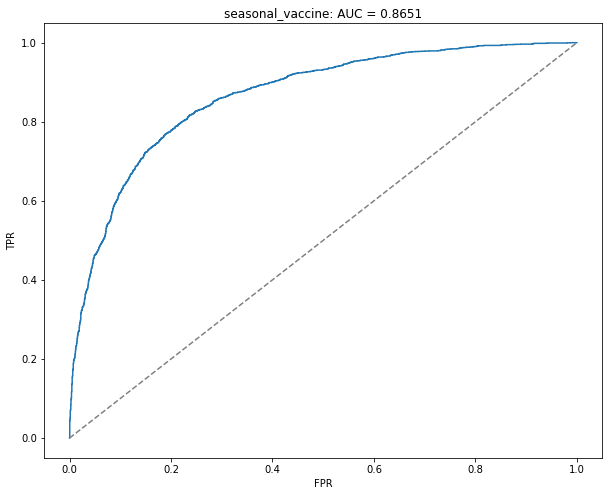

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y2_test, 
    sea_proba, 
    'seasonal_vaccine',
    ax=ax
)

In [29]:
tt = test.drop('respondent_id',axis=1)
test['h1n1_vaccine'] = h1n1_model.predict_proba(tt)[:,1]
test['seasonal_vaccine'] = sea_model.predict_proba(tt)[:,1]

In [30]:
sub = test[['respondent_id','h1n1_vaccine','seasonal_vaccine']].set_index('respondent_id')
sub.to_csv('submission.csv')

In [31]:
sub

h1n1_vaccine  seasonal_vaccine
respondent_id                                
26707              0.100243          0.237694
26708              0.021651          0.022329
26709              0.175805          0.687902
26710              0.569718          0.908983
26711              0.256932          0.521036
...                     ...               ...
53410              0.276521          0.503323
53411              0.183592          0.329698
53412              0.123771          0.217332
53413              0.035305          0.343606
53414              0.534943          0.698314

[26708 rows x 2 columns]

Analyze the catboost models

In [32]:
import shap
shap.initjs()

In [33]:
# visualize the h1n1 vaccine prediction's explanation
explainer_h1n1 = shap.TreeExplainer(h1n1_model)
shap_values_h1n1 = explainer_h1n1.shap_values(Pool(X_train, y1_train, cat_features=X_train.columns.to_list()))
shap.force_plot(explainer_h1n1.expected_value, shap_values_h1n1[0,:], X_train.iloc[0,:])

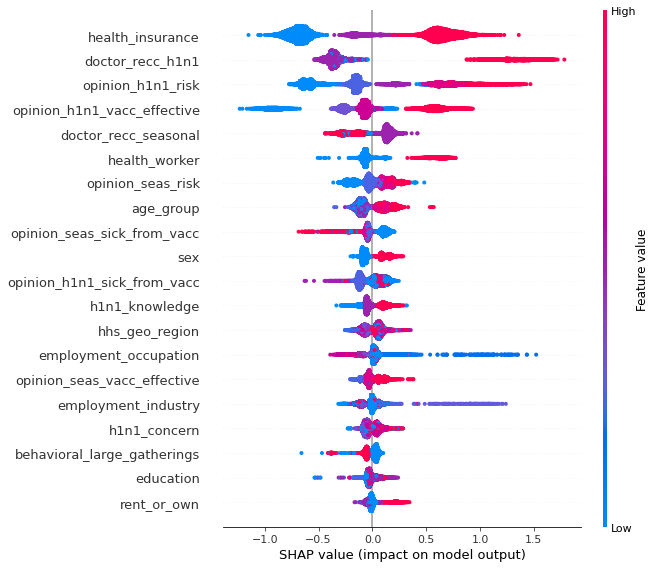

In [34]:
# summarize the effects of all the features to h1n1 vaccine prediction
shap.summary_plot(shap_values_h1n1, X_train)

Top 5 features in the h1n1 catboost model:
    
    a. Whether respondent has health insurance or not.
    b. Whether the h1n1 vaccine was recommended by doctor or not.
    c. Respondent's opinion about risk of getting sick with h1n1 without vaccine.
    d. Respondent's opinion about h1n1 vaccine effectiveness.
    e. Whether the seasonal flu vaccine was recommended by doctor or not.

In [35]:
# visualize the seasonal flu vaccine prediction's explanation
explainer_sea = shap.TreeExplainer(sea_model)
shap_values_sea = explainer_sea.shap_values(Pool(X_train, y2_train, cat_features=X_train.columns.to_list()))
shap.force_plot(explainer_sea.expected_value, shap_values_sea[0,:], X_train.iloc[0,:])

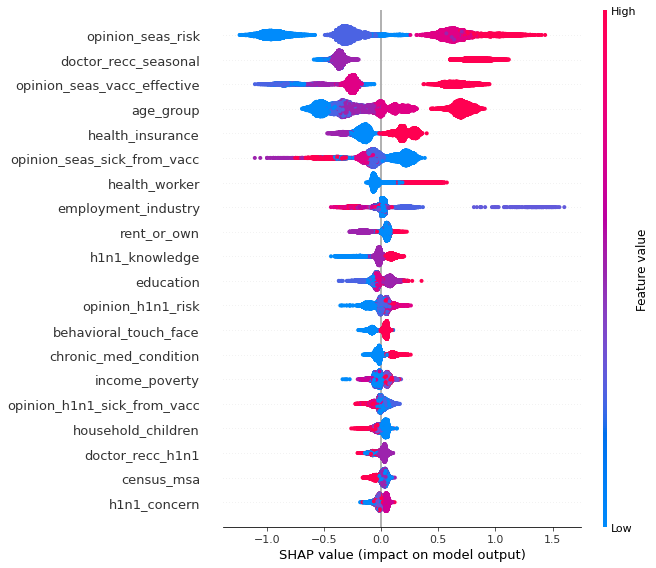

In [36]:
# summarize the effects of all the features to seasonal flu vaccine prediction
shap.summary_plot(shap_values_sea, X_train)

Top 5 features in the seasonal flu catboost model:
    
    a. Whether the seasonal flu vaccine was recommended by doctor or not.
    b. Respondent's opinion about risk of getting sick with seasonal flu without vaccine
    c. Respondent's opinion about seasonal flu vaccine effectiveness.
    d. Age.
    e. Whether respondent has health insurance or not.